# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Linlog_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.308017        0.200414  0.050016  0.290411  0.030805   
       0.50   0.311916        0.199941  0.049814  0.268229  0.052859   
       0.75   0.313981        0.198617  0.049345  0.239449  0.077924   
       1.00   0.314976        0.196707  0.048674  0.207525  0.102554   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.197385  0.002158  0.049524  0.050702  0.000166  
       0.50  0.193933  0.002262  0.056039  0.051147  0.000571  
       0.75  0.192453  0.002339  0.064864  0.051888  0.001150  
       1.00  0.193142  0.002406  0.075374  0.052857  0.001885

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50   0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75   0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00   0.265117        0.190800  0.086004  0.073142  0.210825   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.193065  0.002761  0.053163  0.051176  0.000073  
         0.50  0.181053  0.003095  0.069032  0.053052  0.000270  
         0.75  0.168418  0.003385  0.090652  0.055966  0.000592  
         1.00  0.154756  0.003706  0.116960  0.059768  0.001057

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


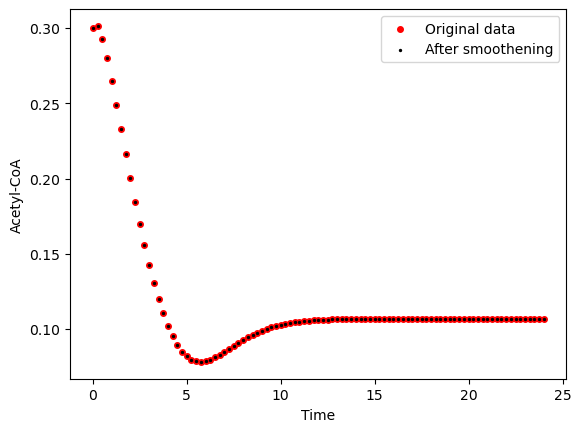

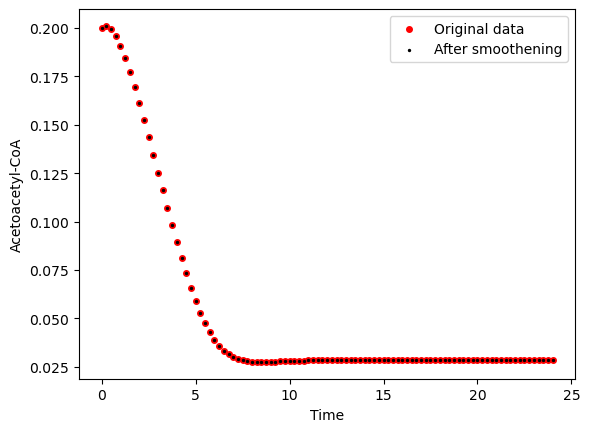

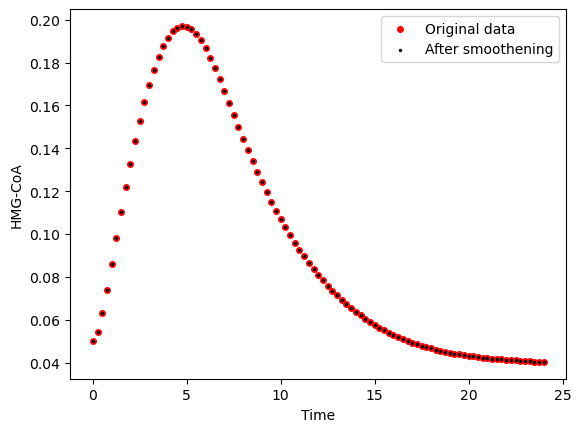

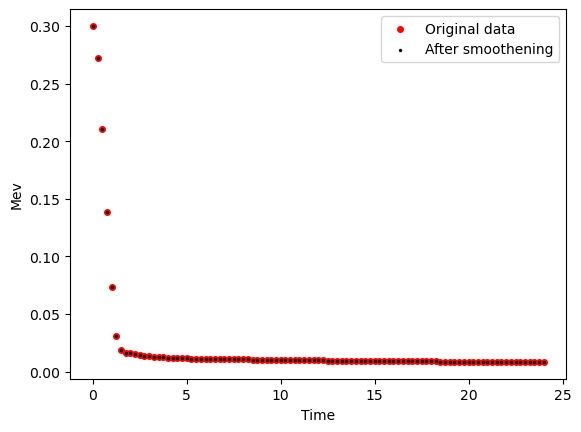

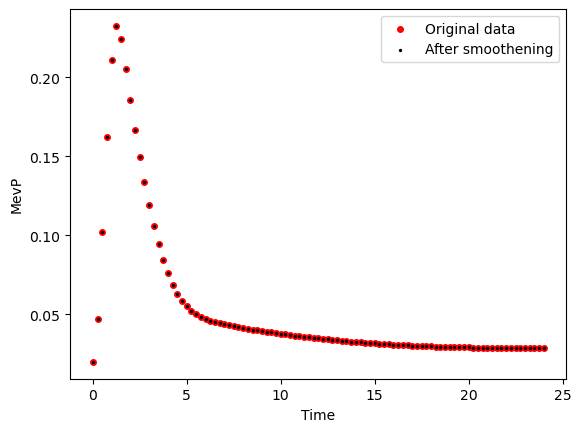

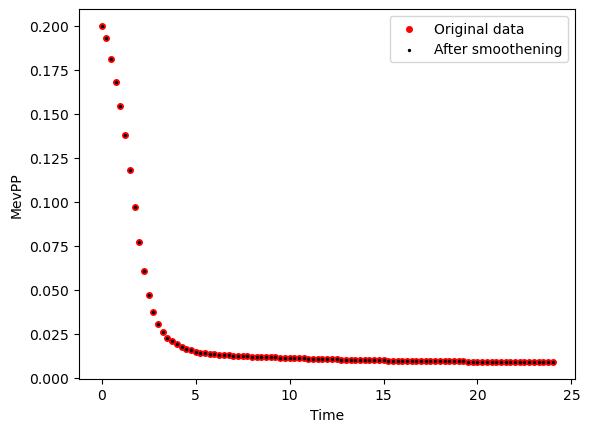

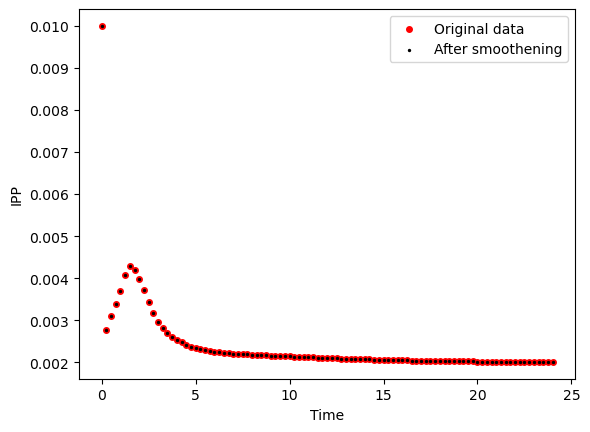

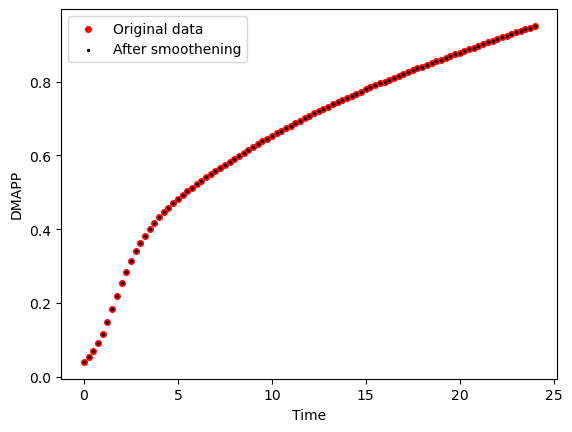

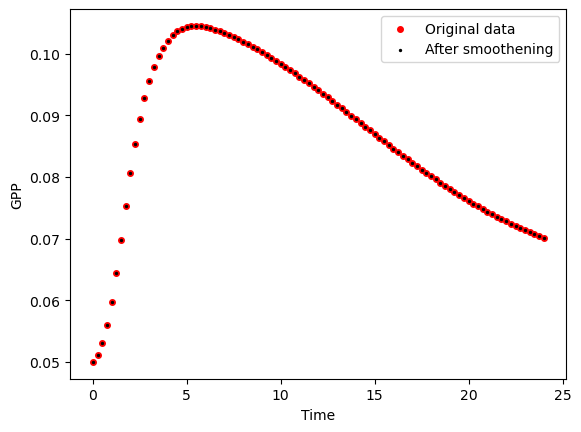

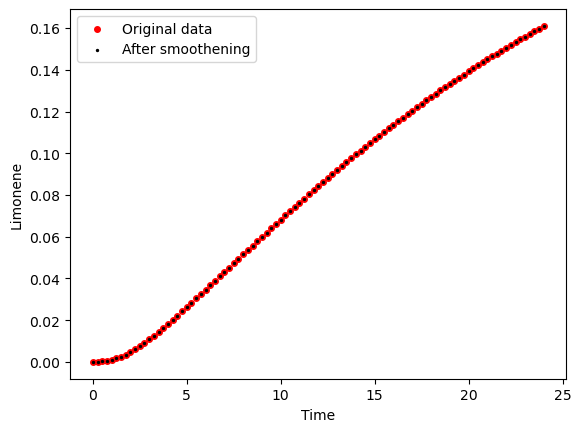

Strain Strain 2


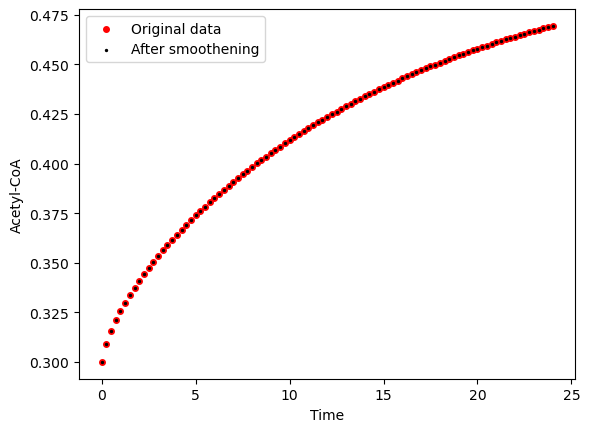

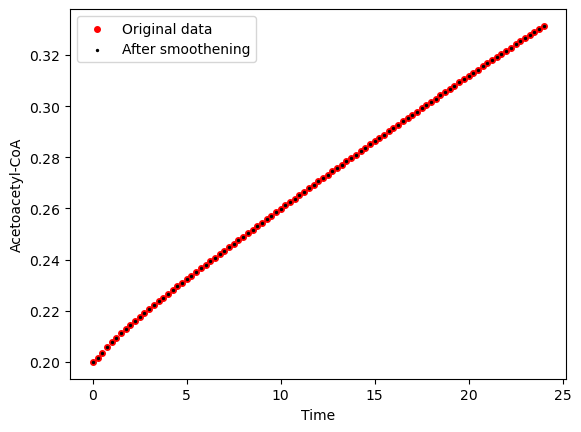

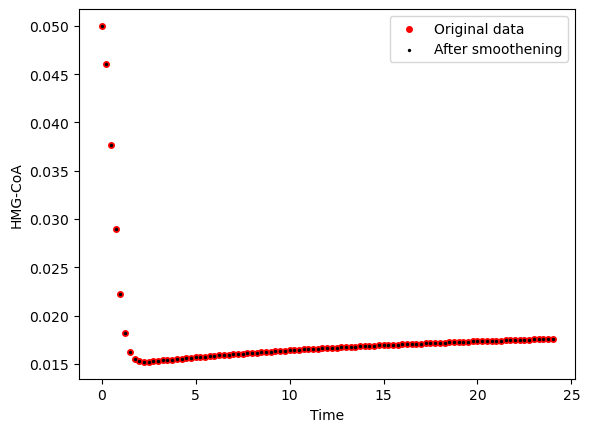

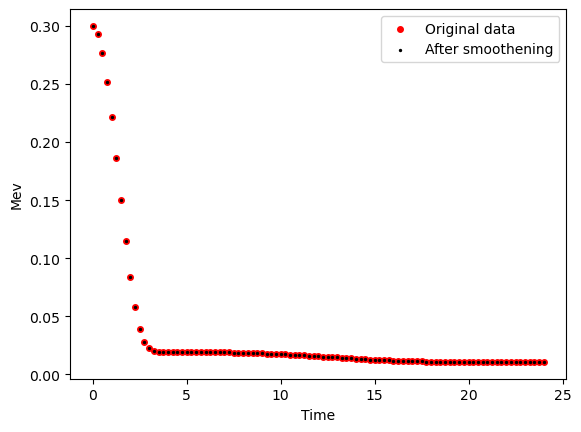

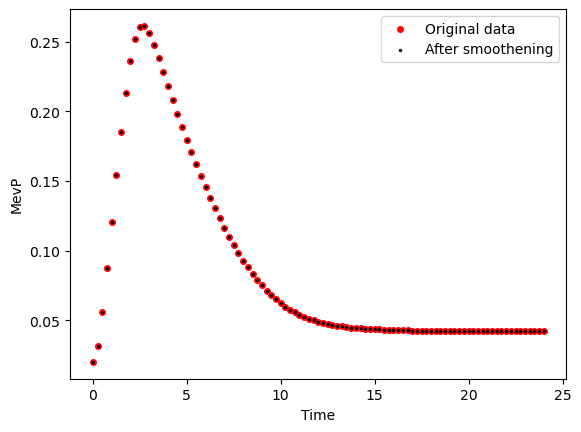

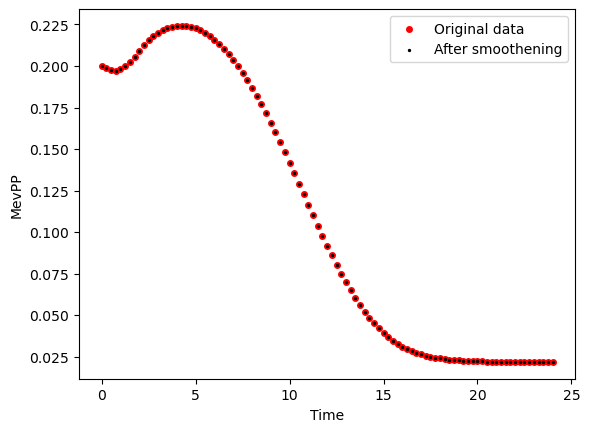

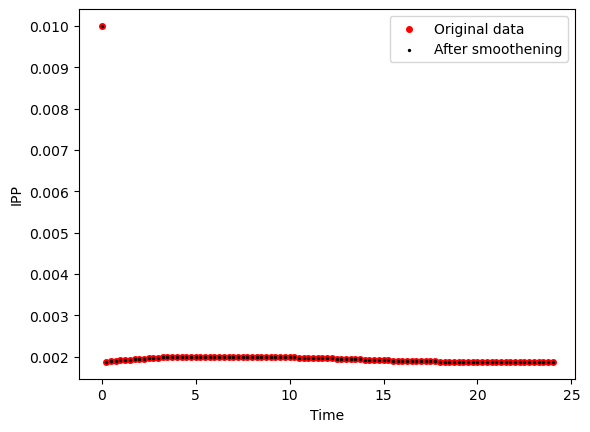

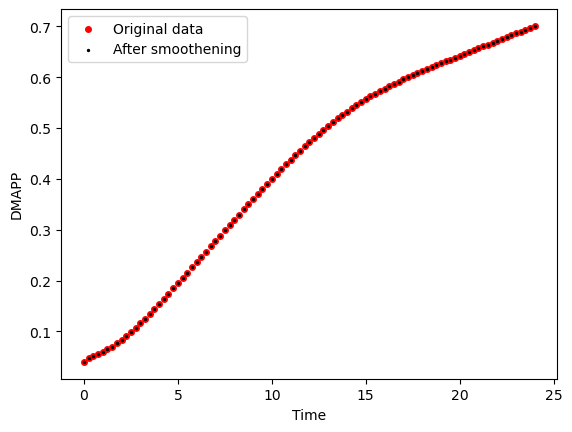

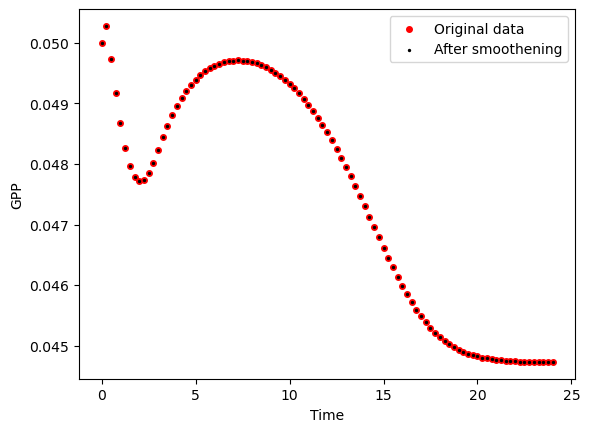

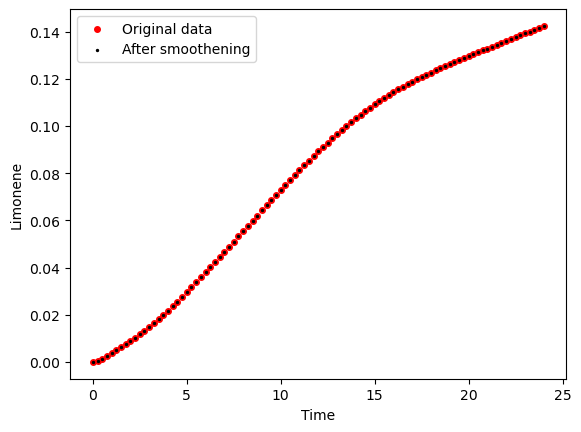

Strain Strain 3


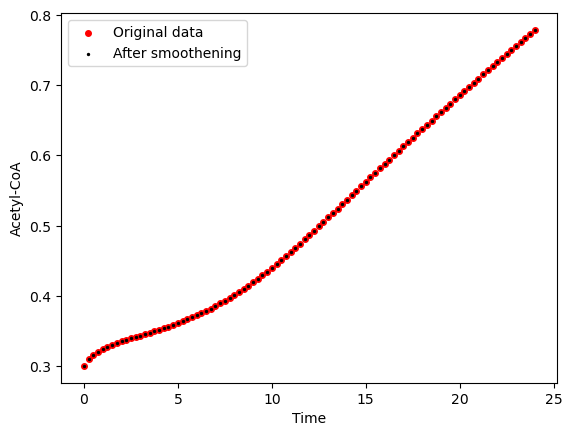

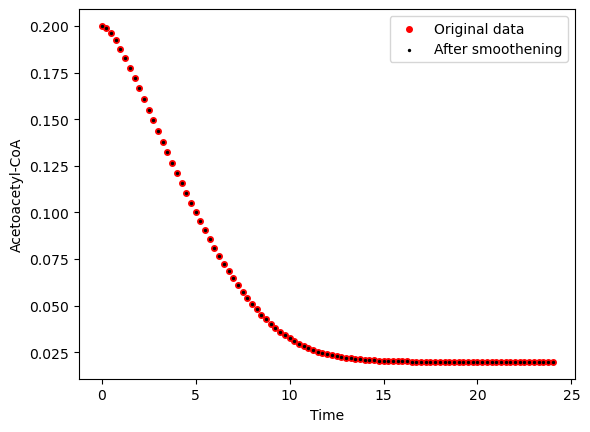

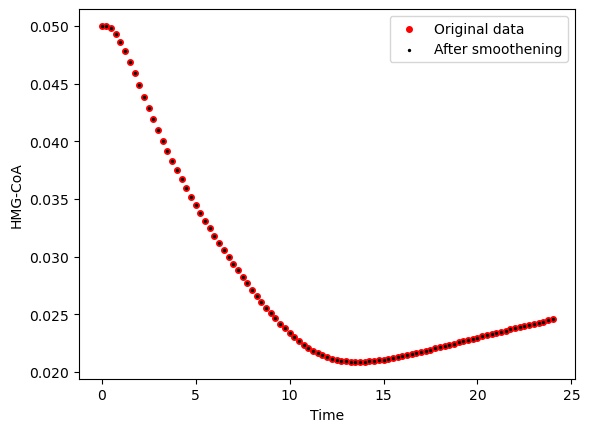

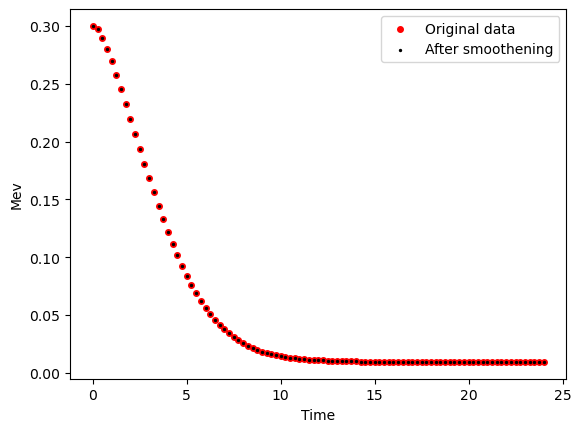

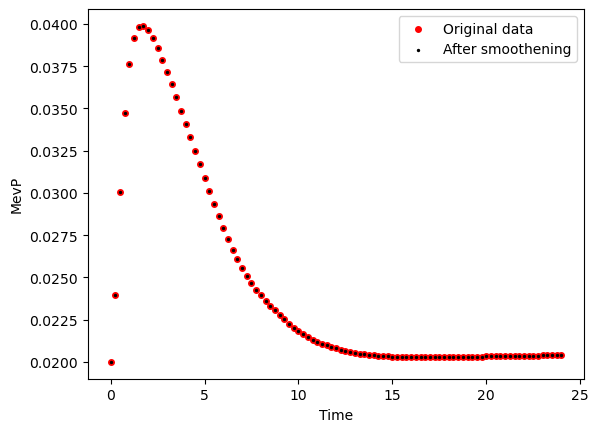

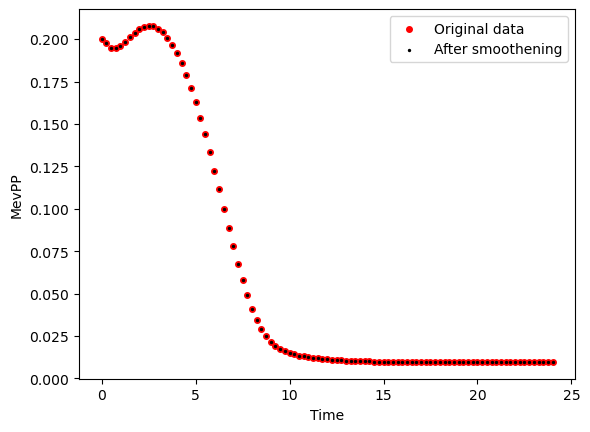

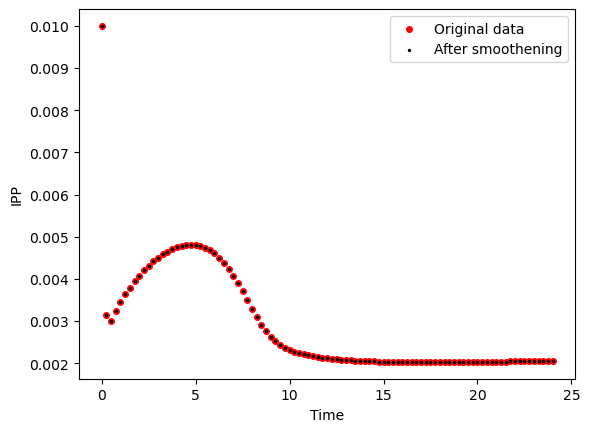

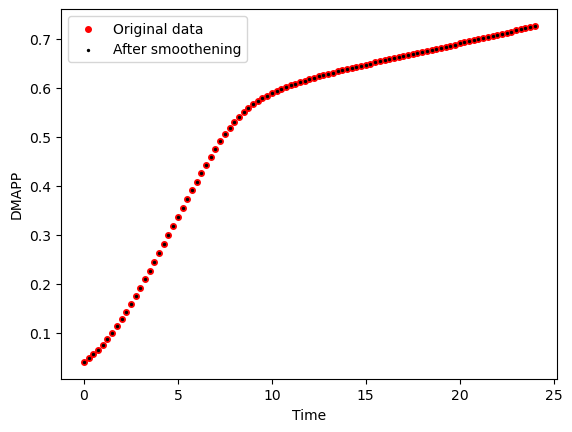

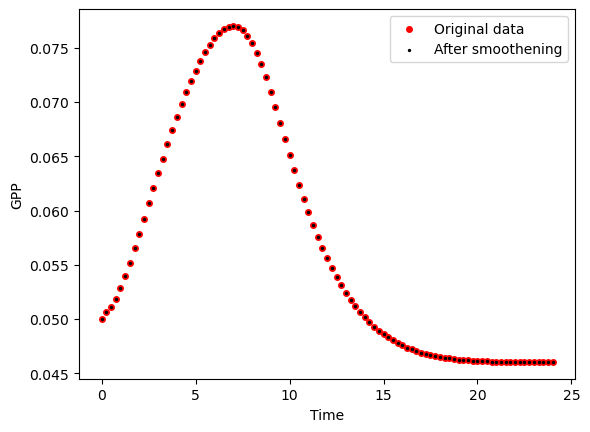

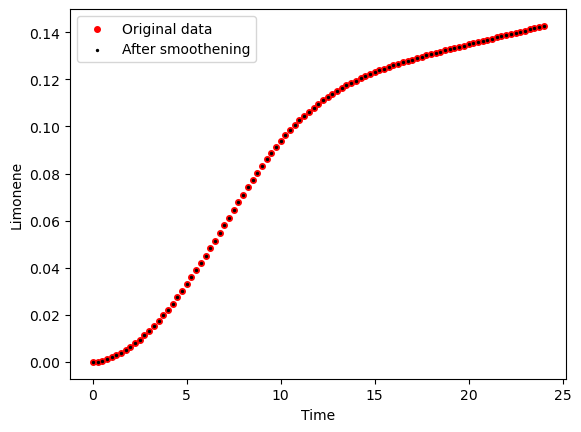

Strain WT


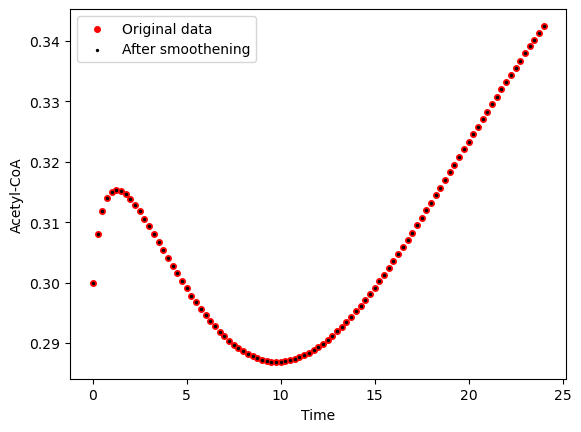

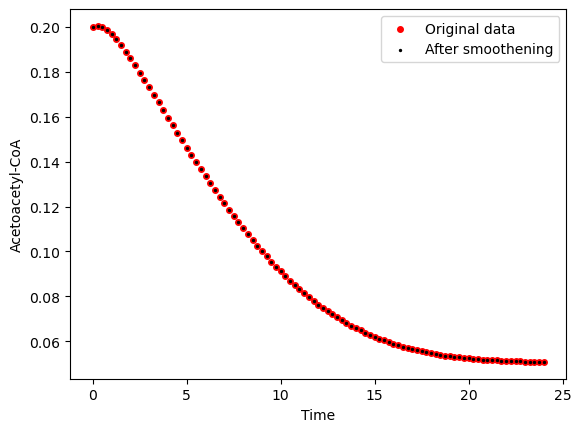

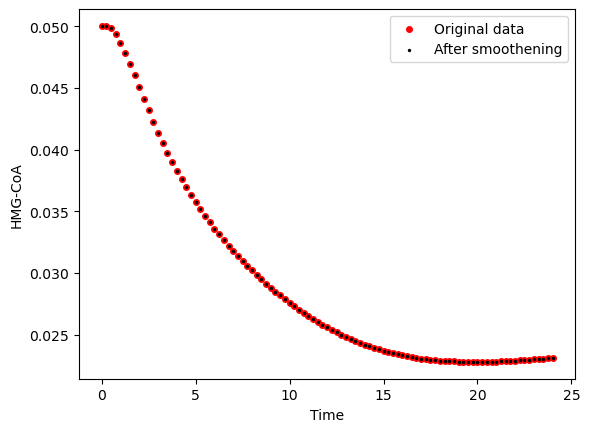

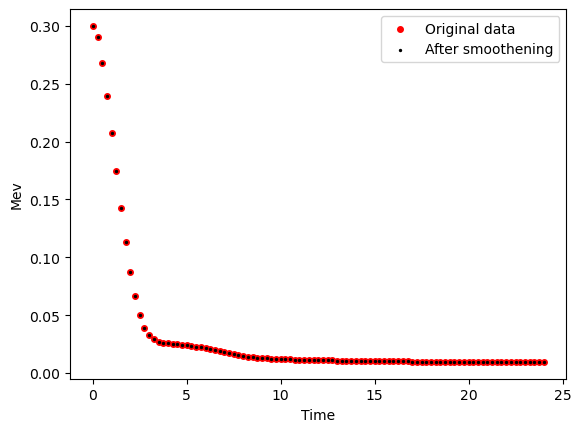

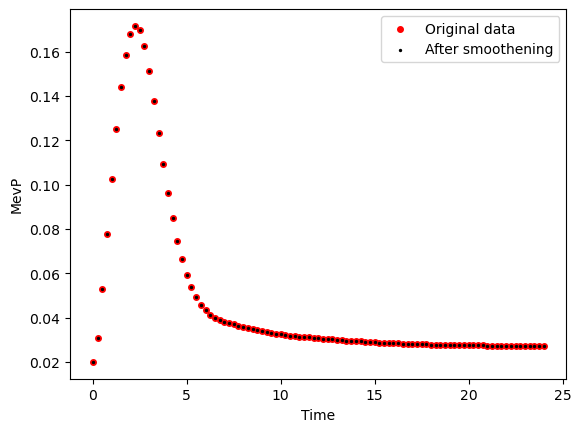

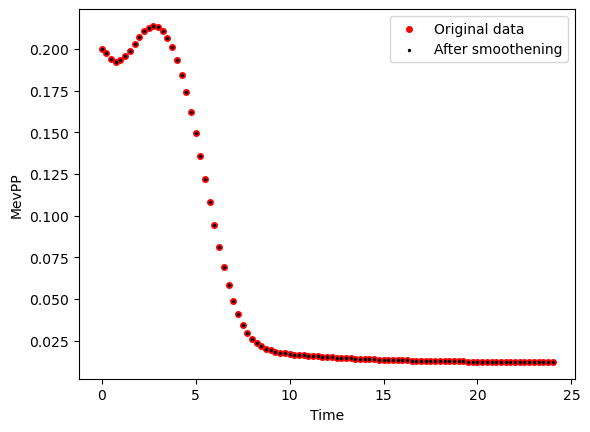

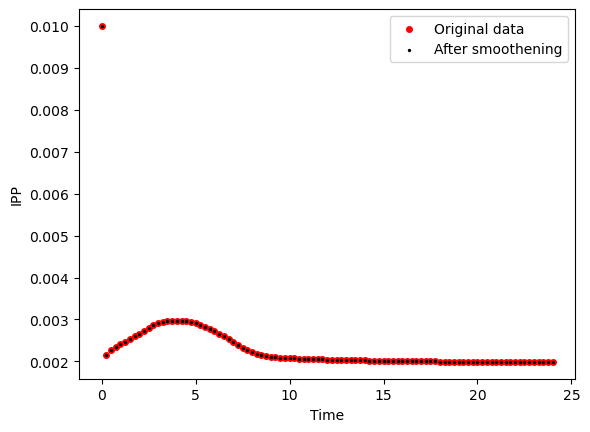

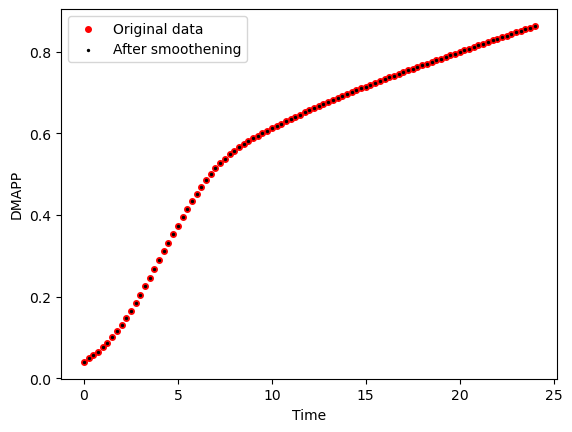

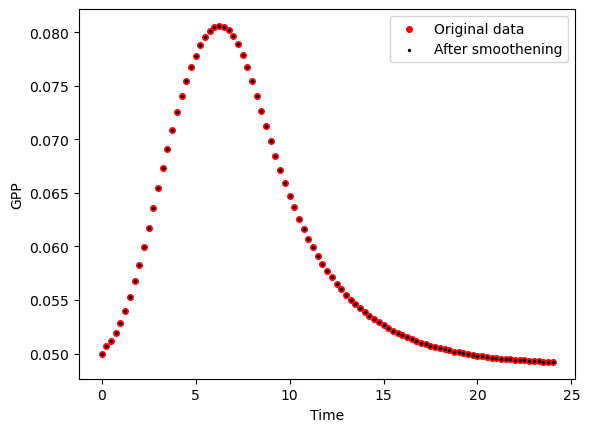

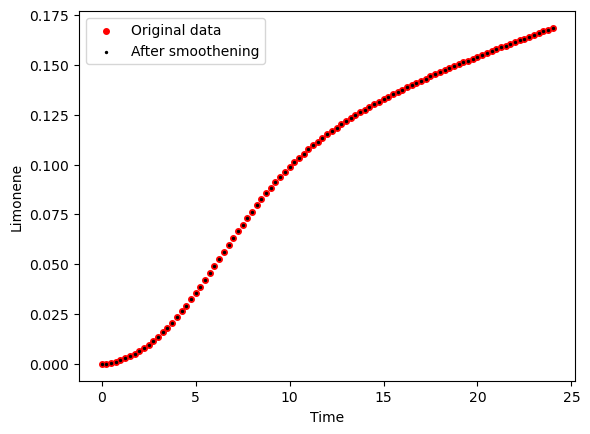

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


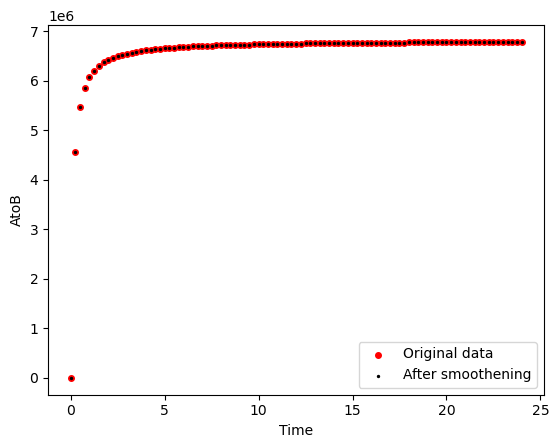

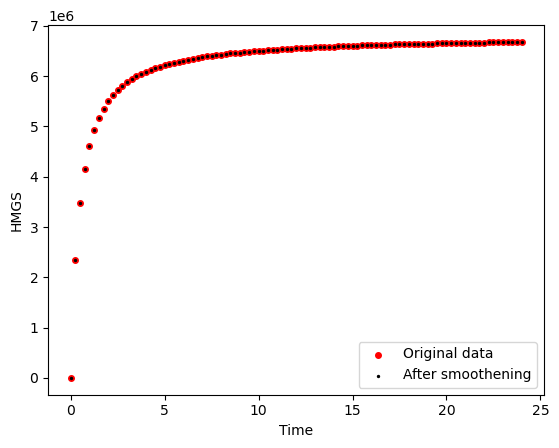

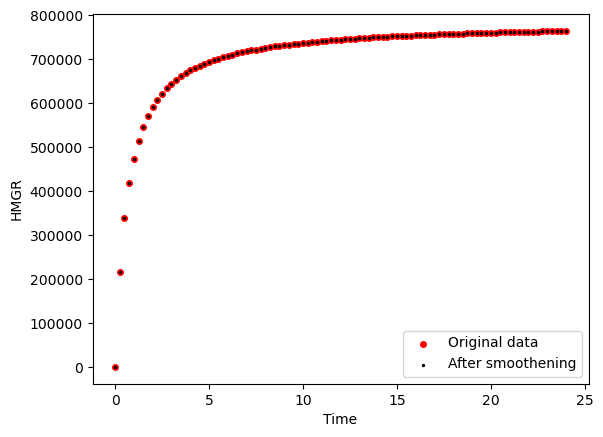

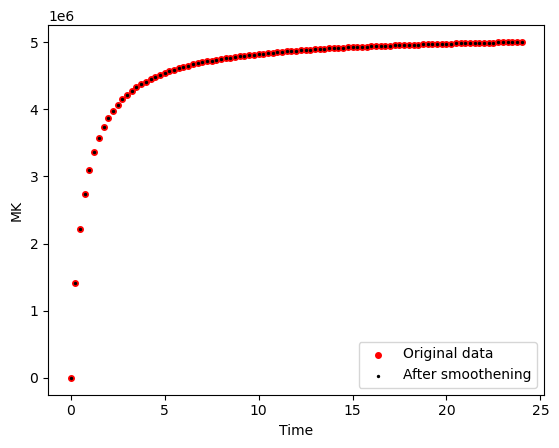

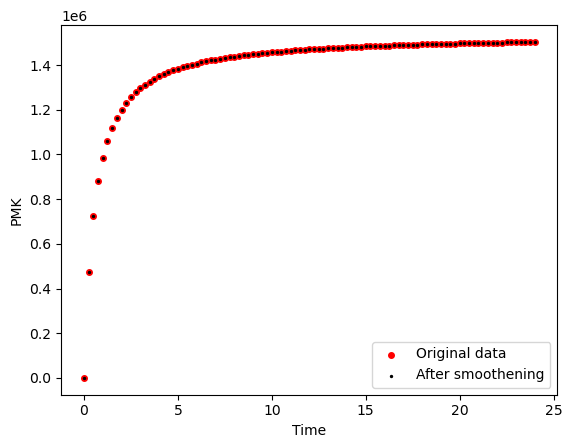

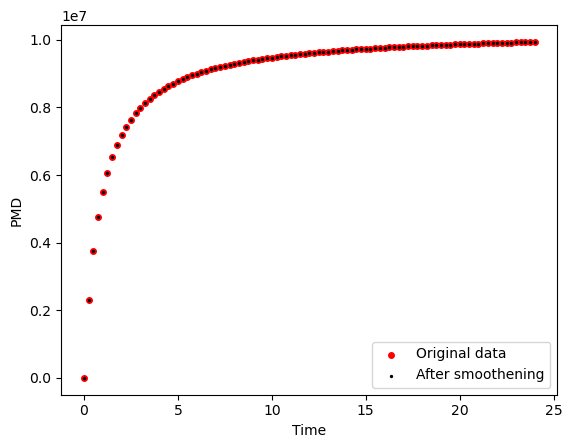

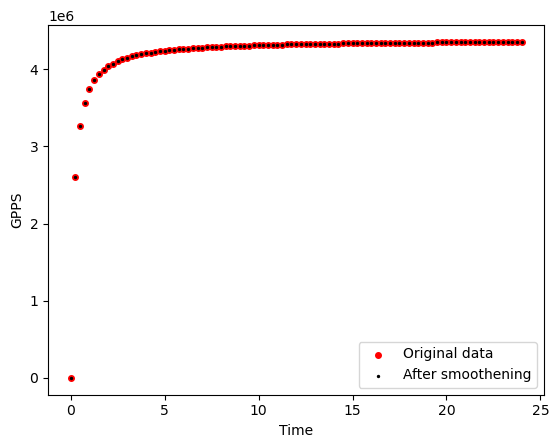

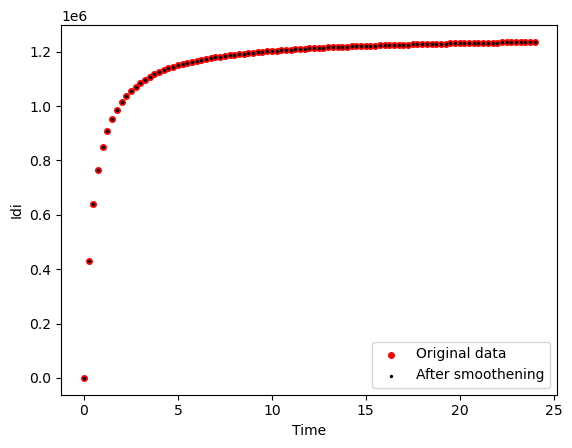

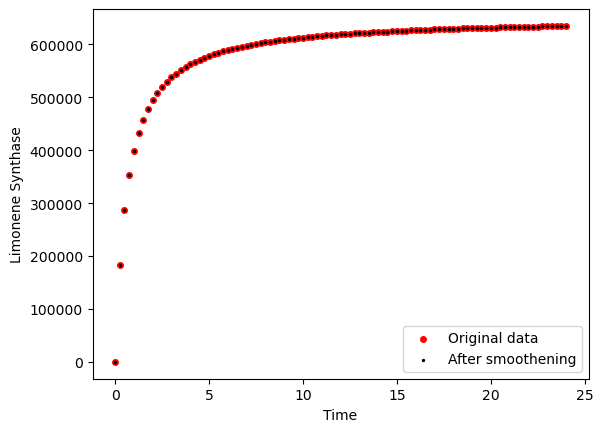

Strain Strain 2


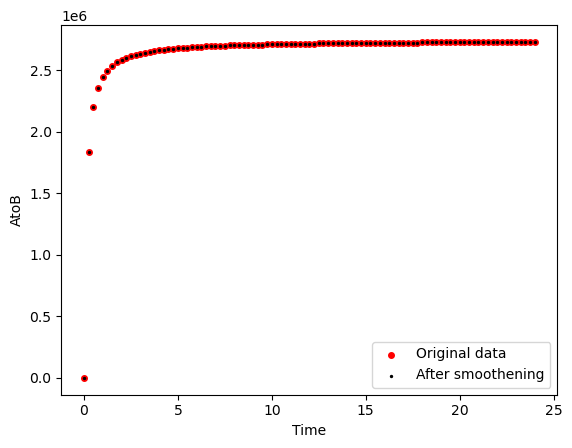

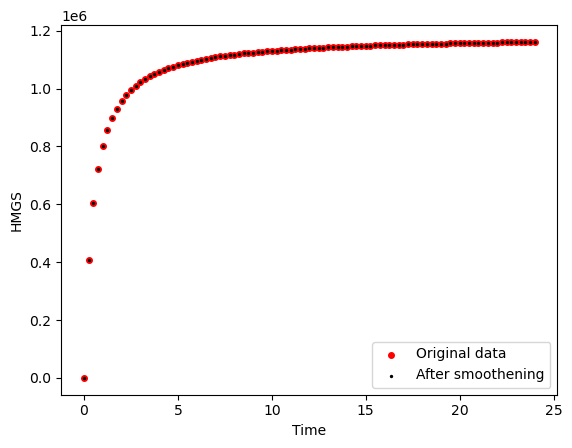

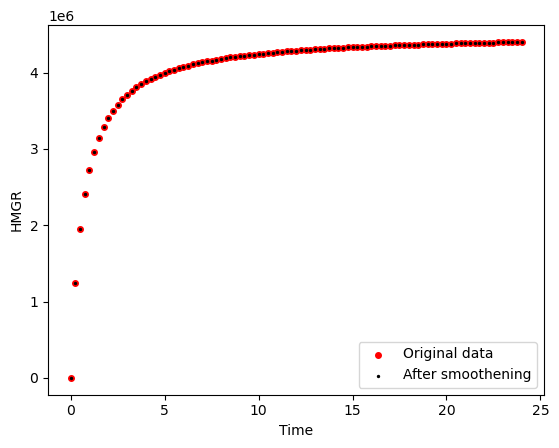

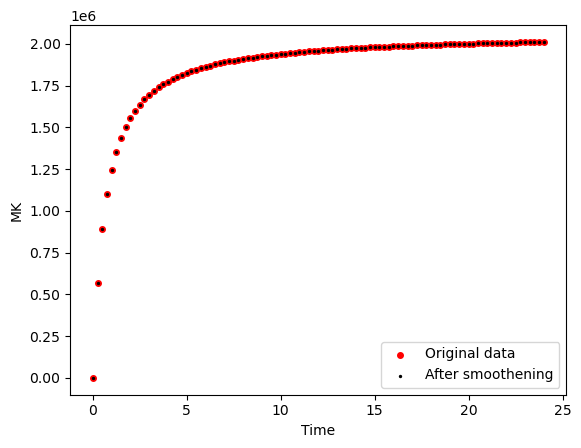

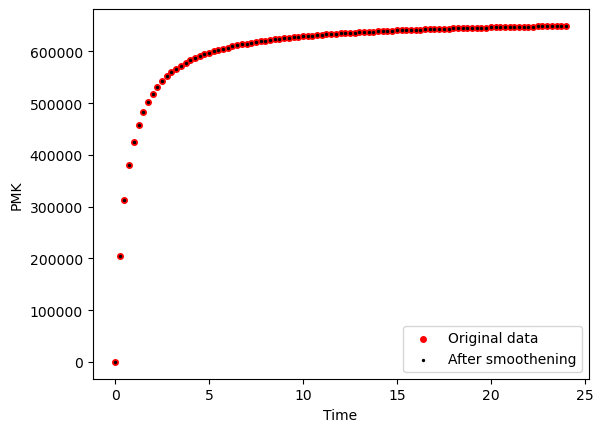

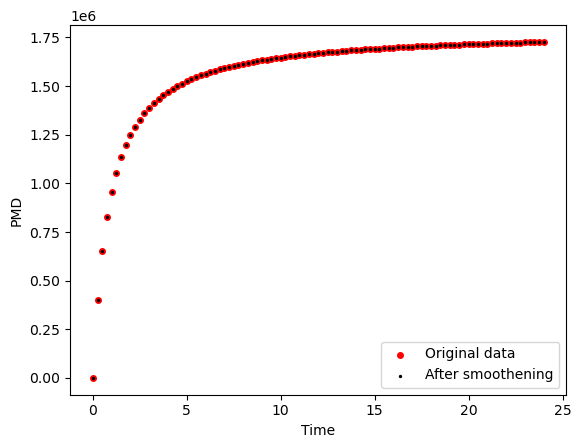

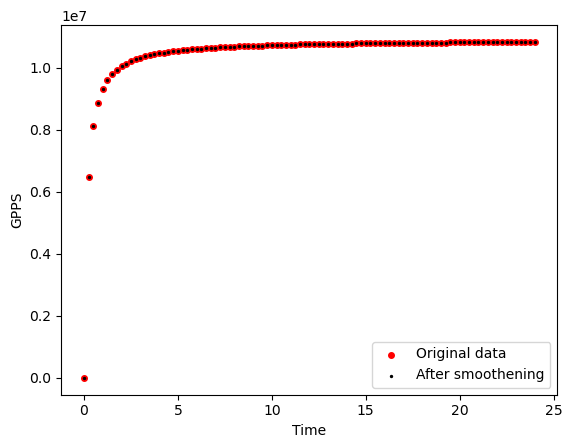

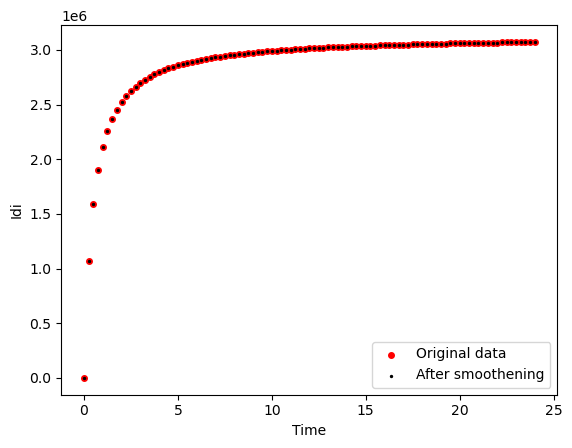

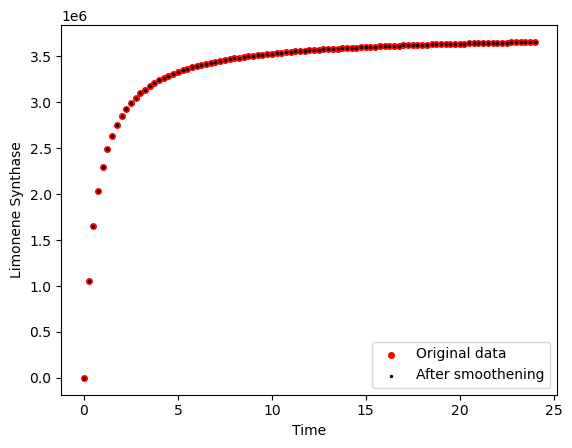

Strain Strain 3


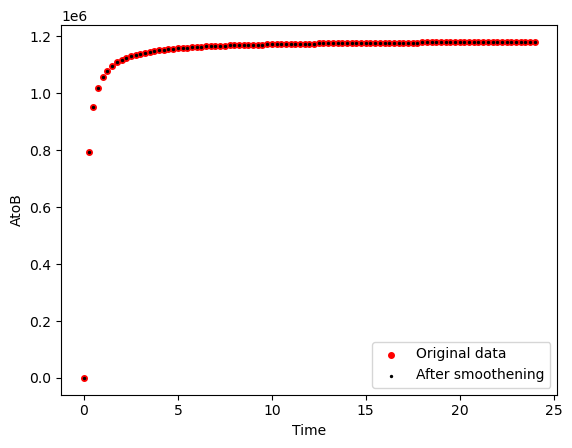

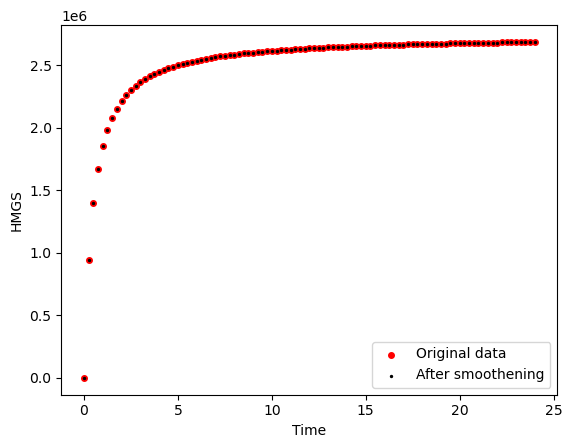

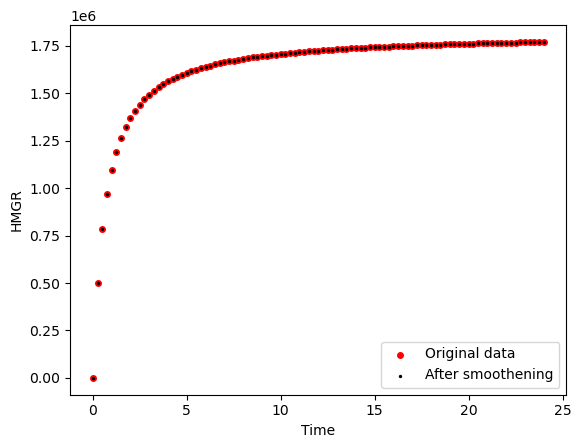

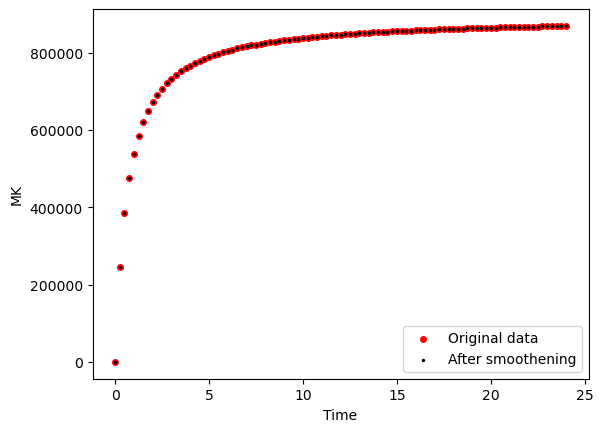

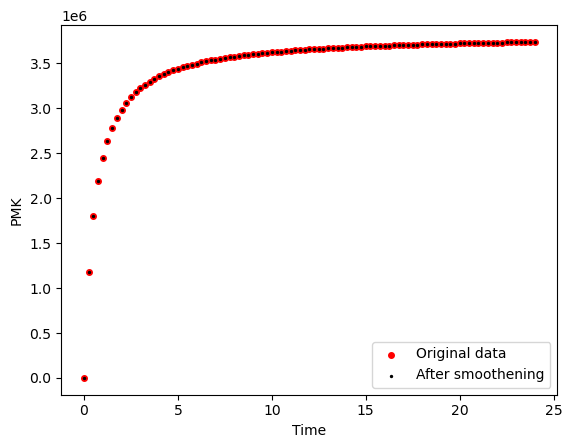

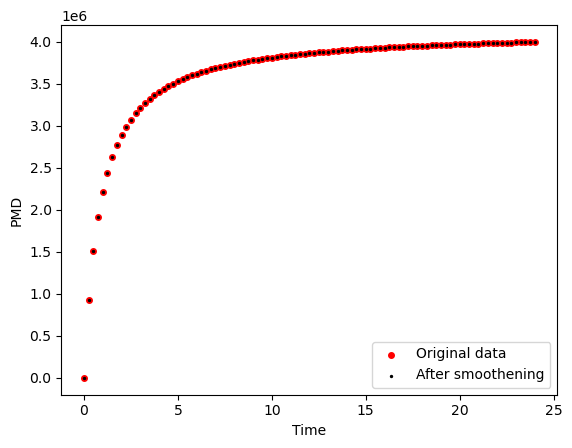

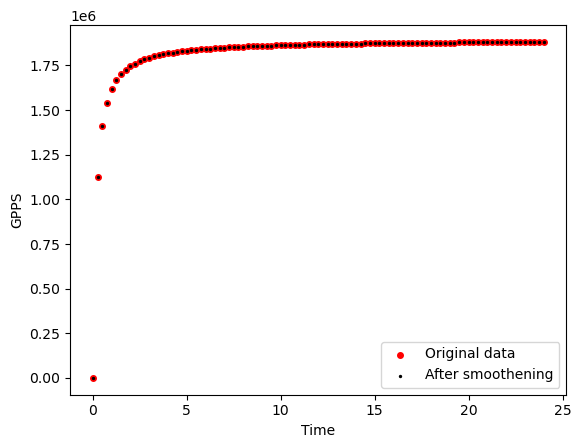

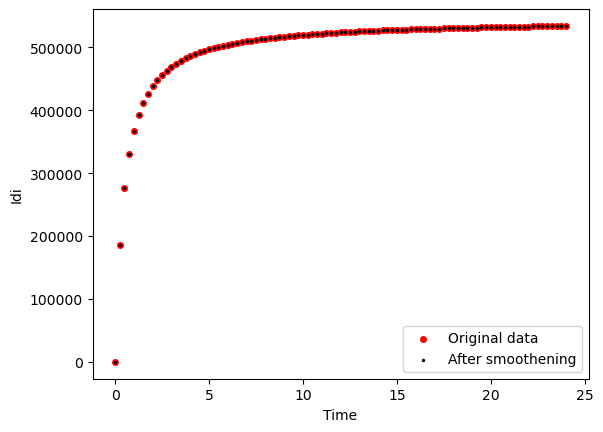

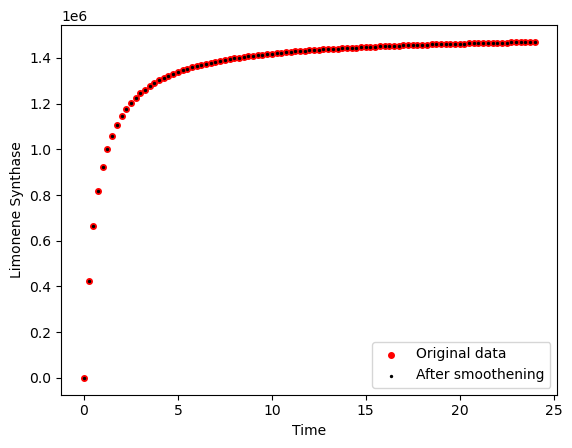

Strain WT


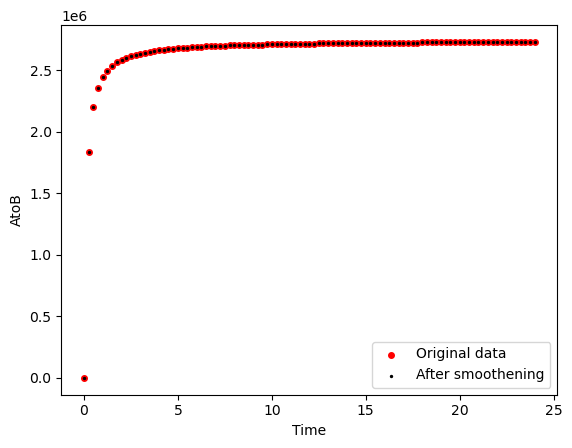

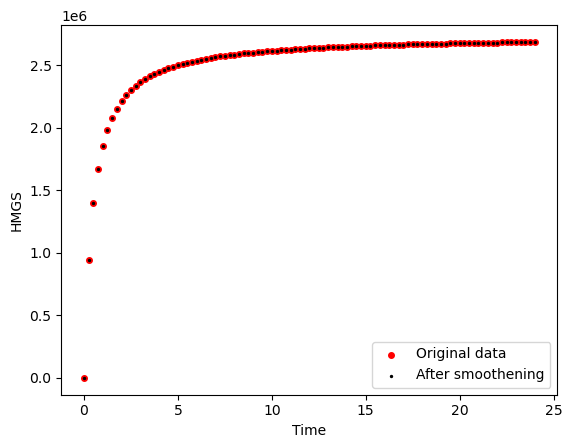

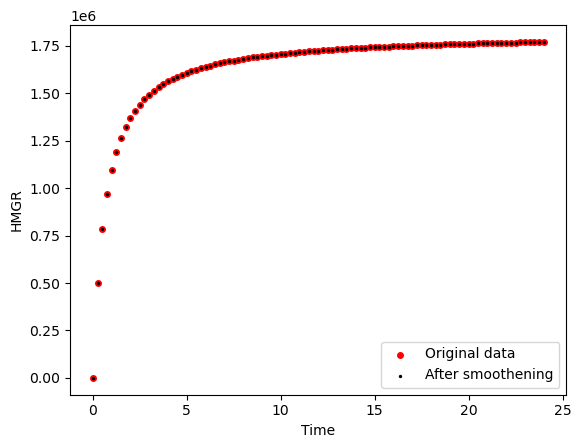

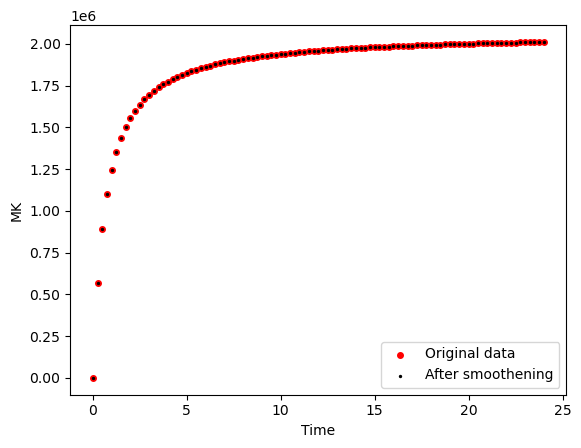

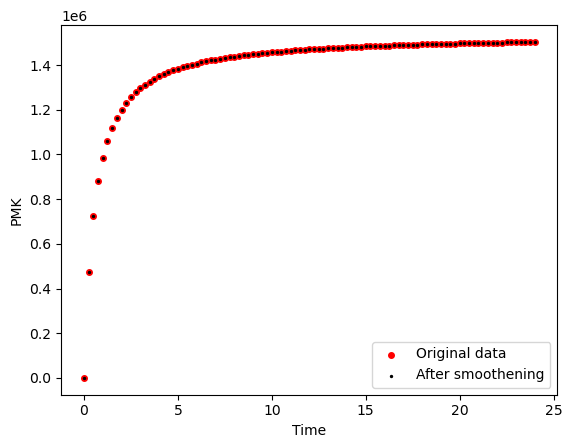

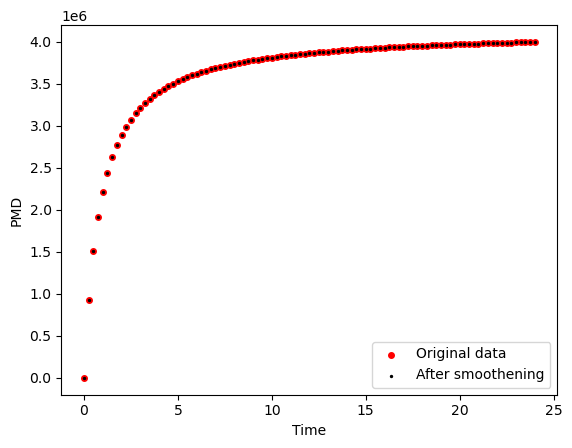

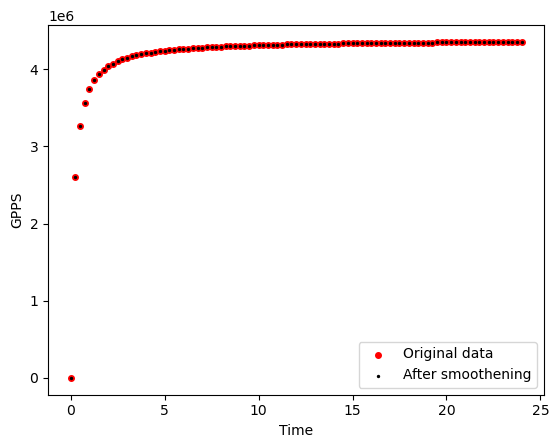

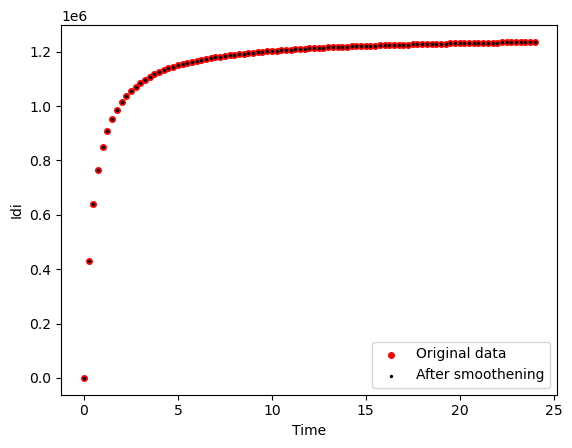

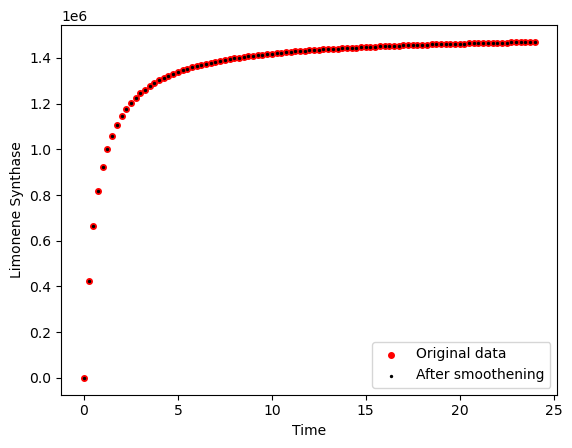

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.301391        0.200998  0.054156  0.272337  0.047074   
         0.50    0.292768        0.199655  0.063090  0.211002  0.102371   
         0.75    0.279998        0.196032  0.074110  0.138704  0.162352   
         1.00    0.265117        0.190800  0.086004  0.073142  0.210825   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.337903        0.050990  0.023000  0.009617  0.027290   
         23.25   0.339059        0.050942  0.023029  0.009614  0.027285   
         23.50   0.340204        0.050901  0.023058  0.009612  0.027281   
         23.75   0.341337        0.050867  0.023088  0.009610  0.027278   
         24.00   0.342458        0.050840  0.023119  0.009609  0.027277   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.193065  0.002761  0.053163  0.051176  0.000073  ...   
         0.50   0.181053  0.003095  0.069032  0.053052  0.000270  ...   
         0.75   0.168418  0.003385  0.090652  0.055966  0.000592  ...   
         1.00   0.154756  0.003706  0.116960  0.059768  0.001057  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.012208  0.001987  0.847895  0.049302  0.164976  ...   
         23.25  0.012202  0.001987  0.851852  0.049279  0.165862  ...   
         23.50  0.012197  0.001987  0.855807  0.049258  0.166746  ...   
         23.75  0.012194  0.001987  0.859761  0.049239  0.167627  ...   
         24.00  0.012191  0.001987  0.863714  0.049222  0.168506  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

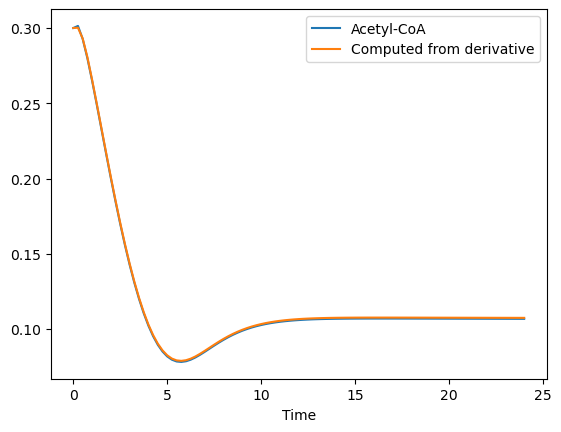

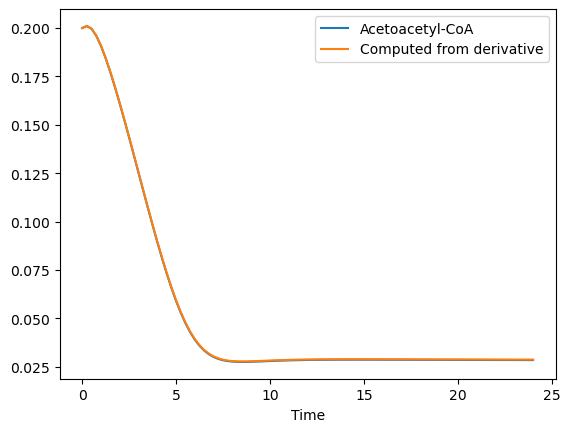

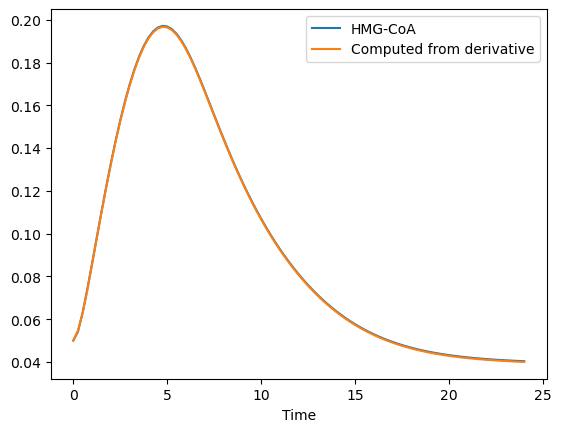

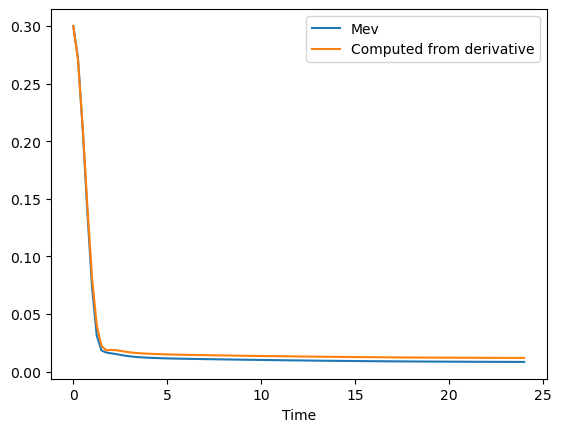

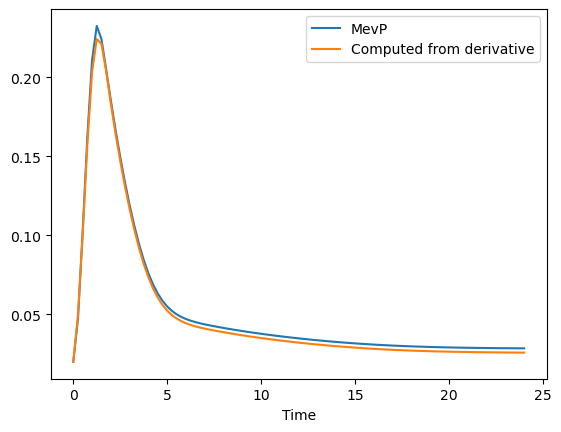

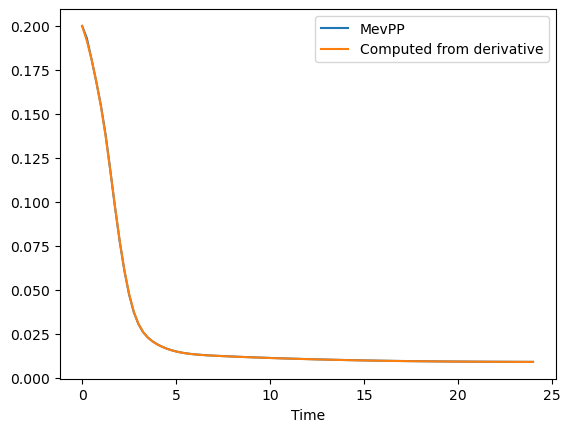

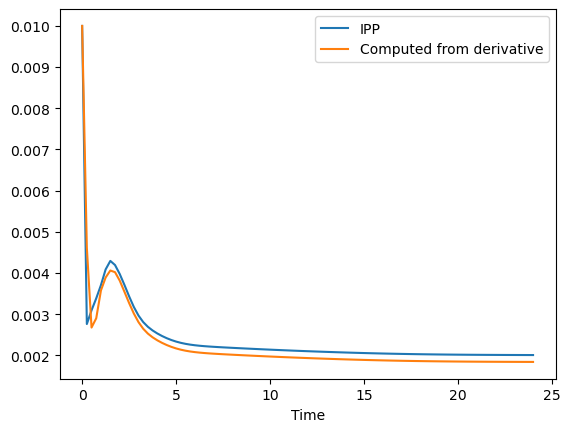

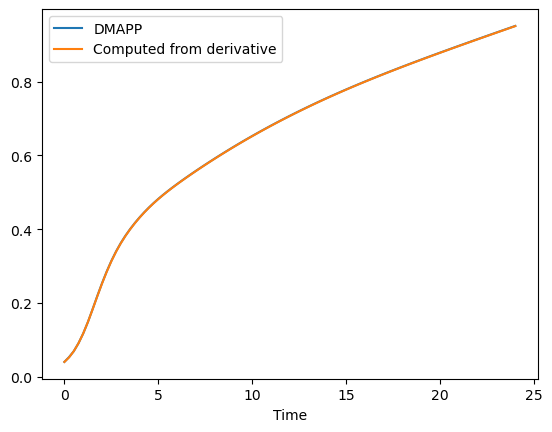

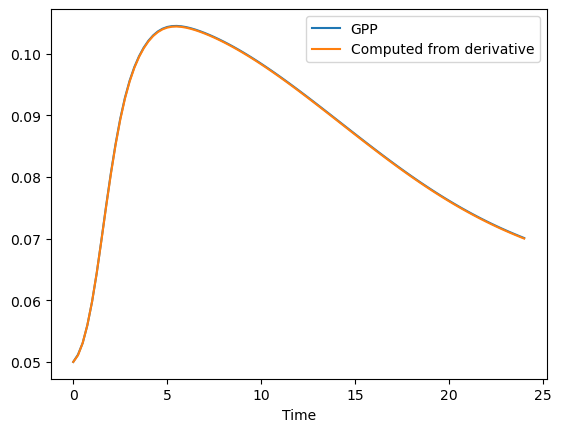

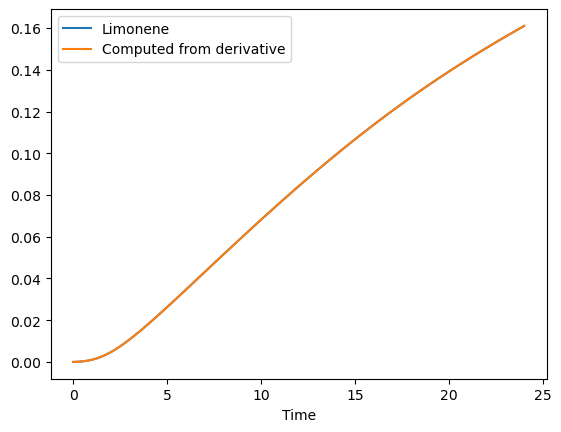

'Time profile from derivative vs. actual profile for Strain 2'

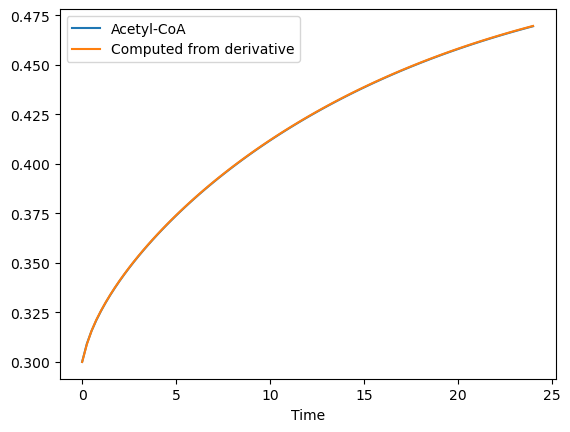

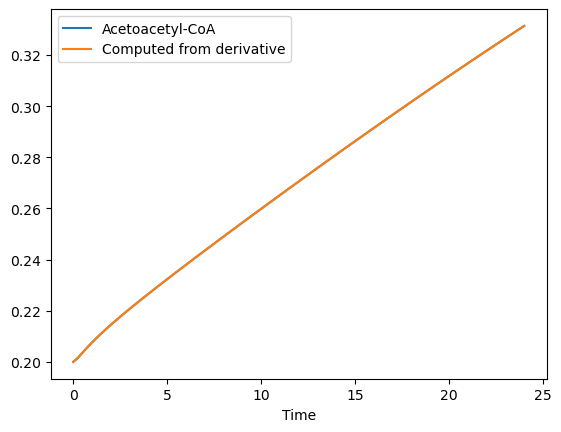

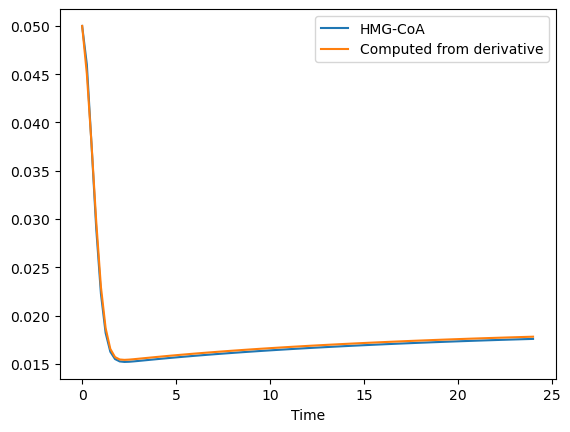

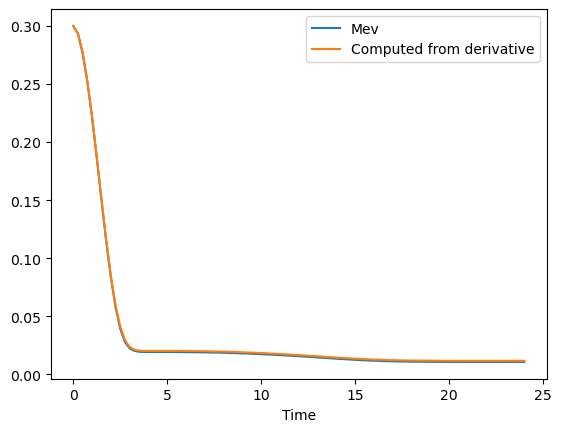

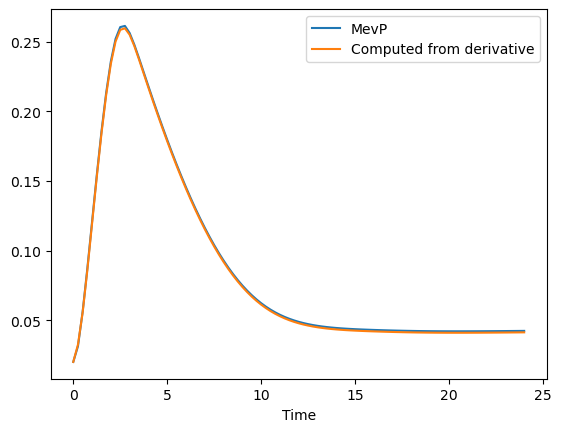

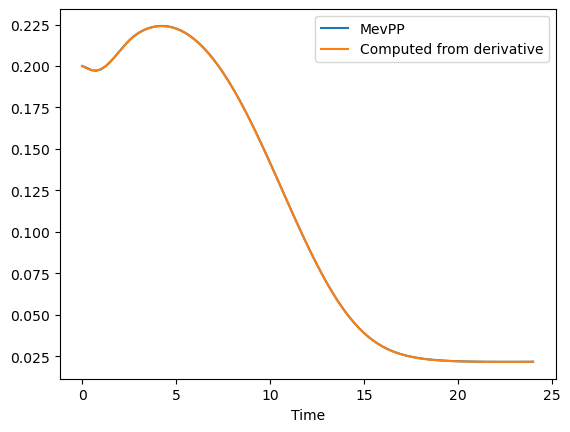

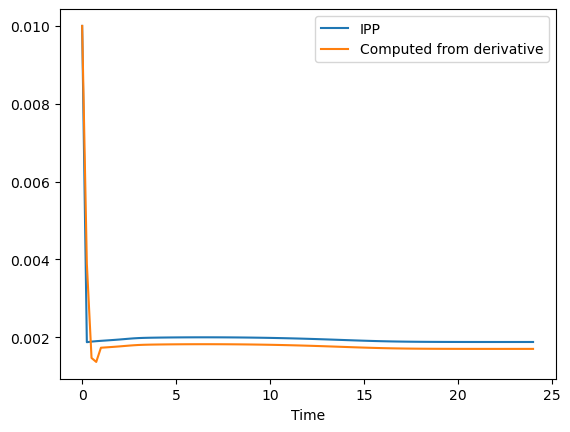

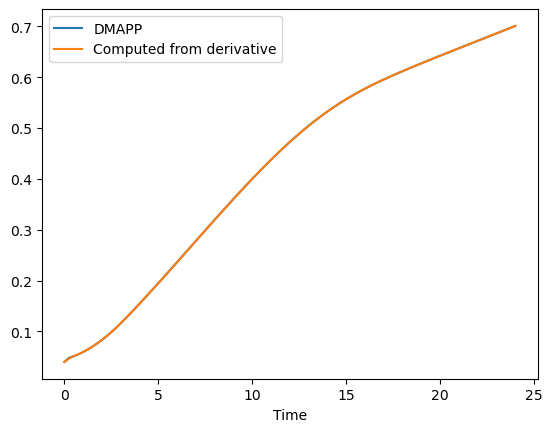

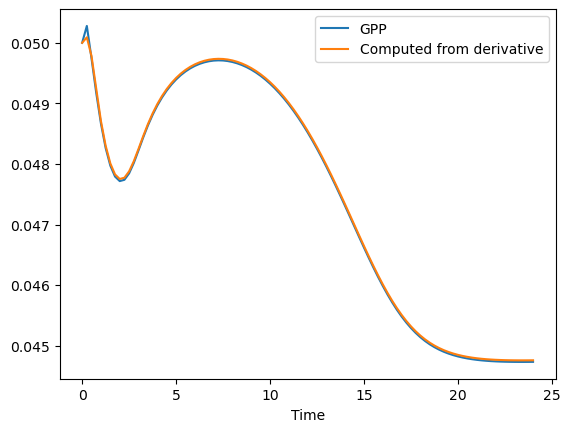

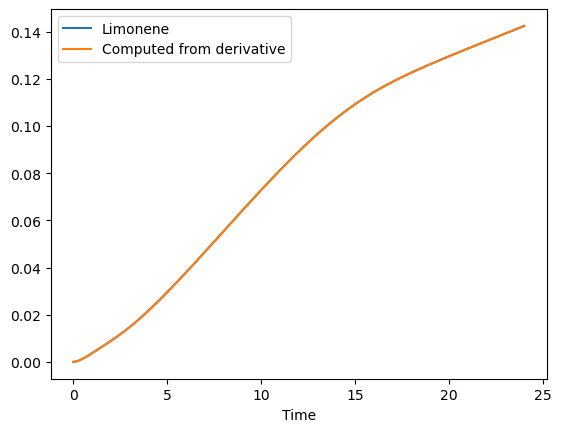

'Time profile from derivative vs. actual profile for Strain 3'

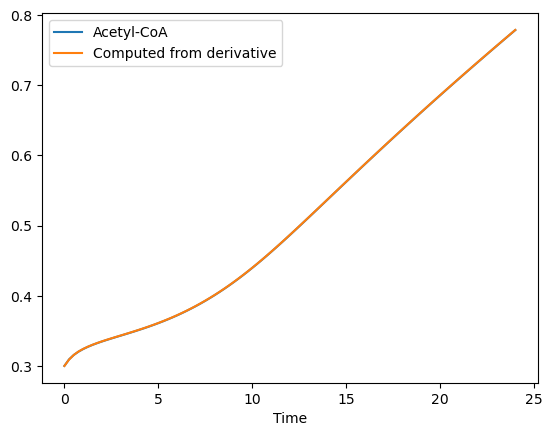

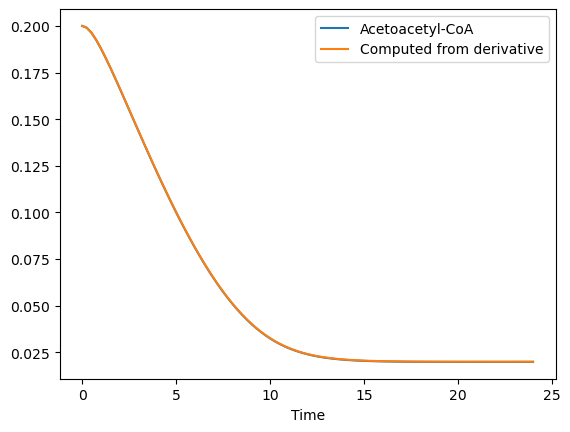

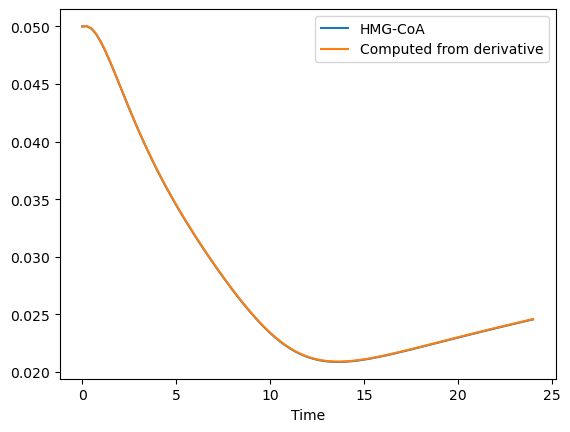

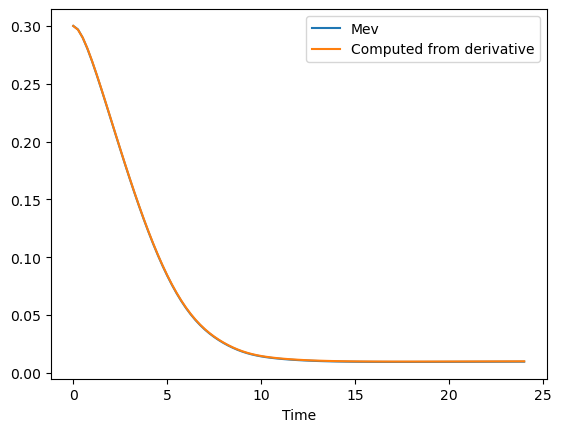

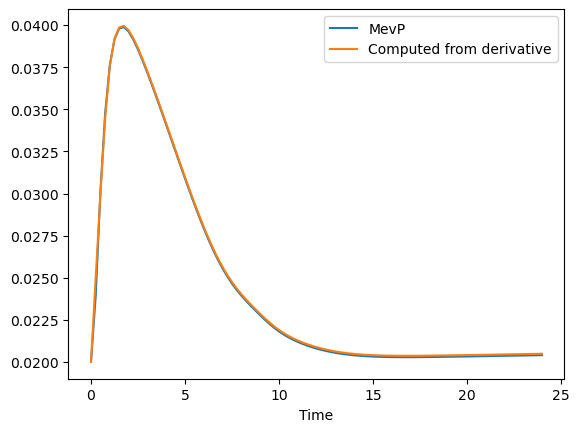

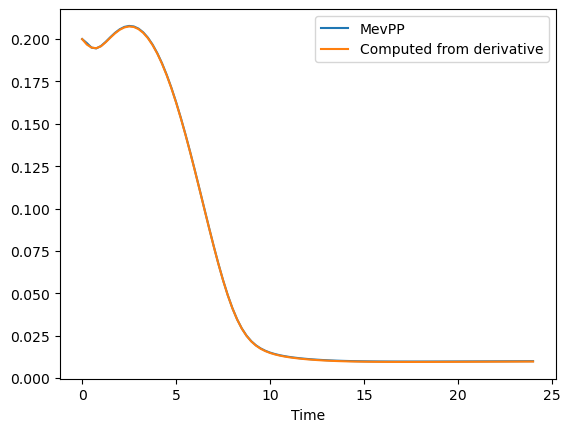

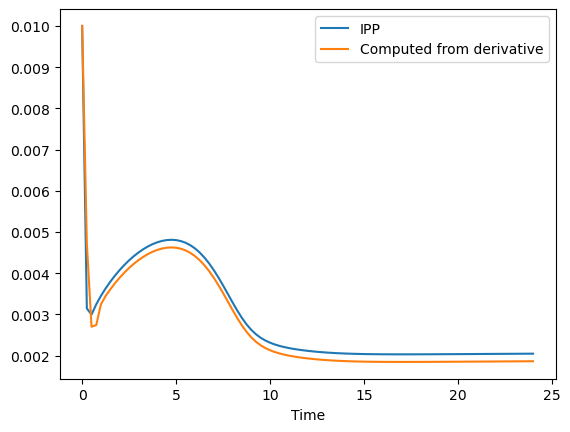

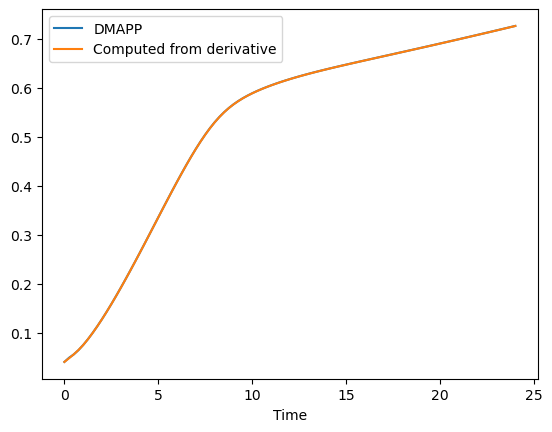

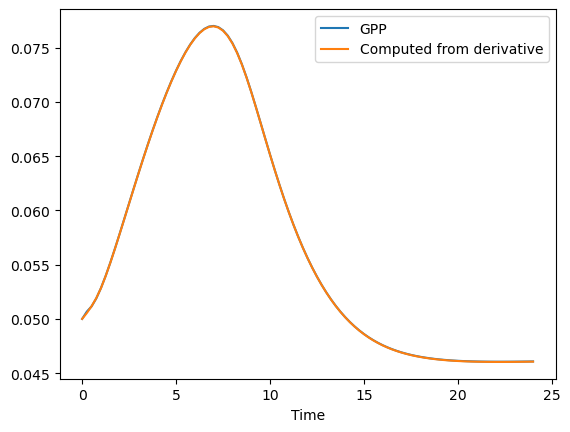

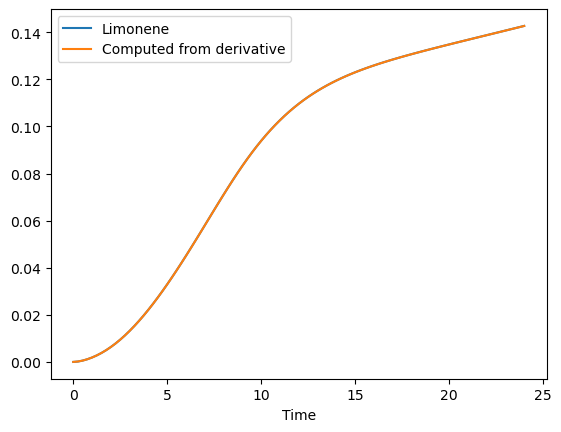

'Time profile from derivative vs. actual profile for WT'

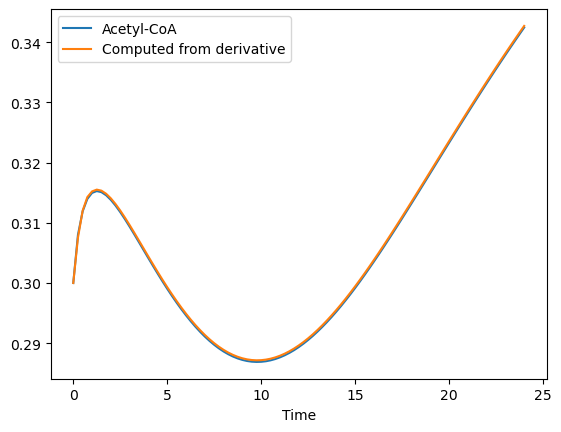

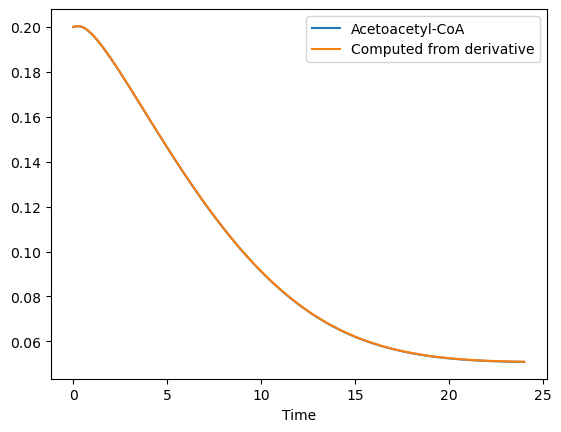

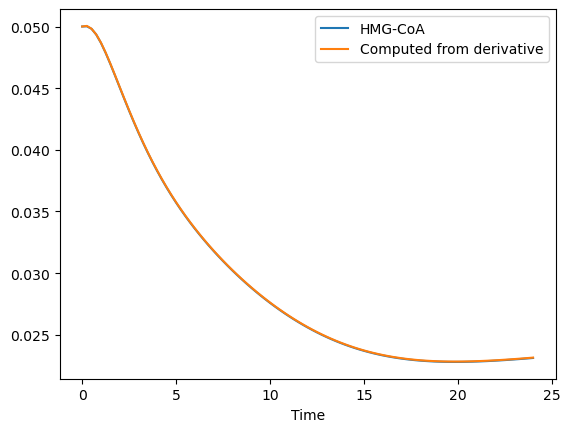

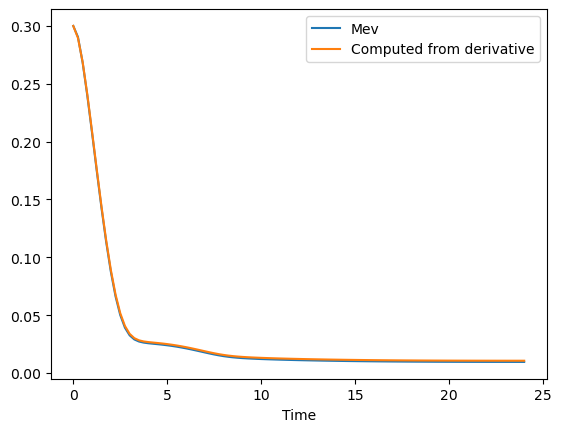

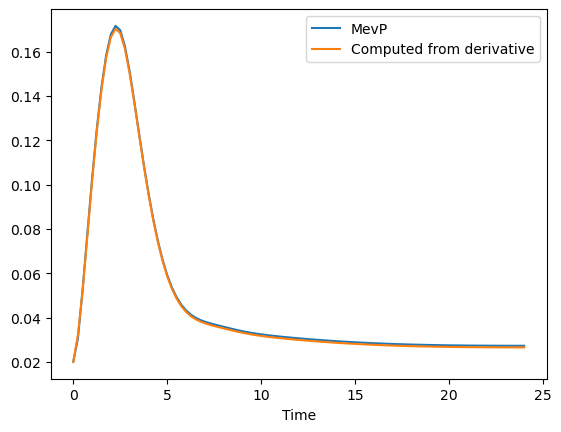

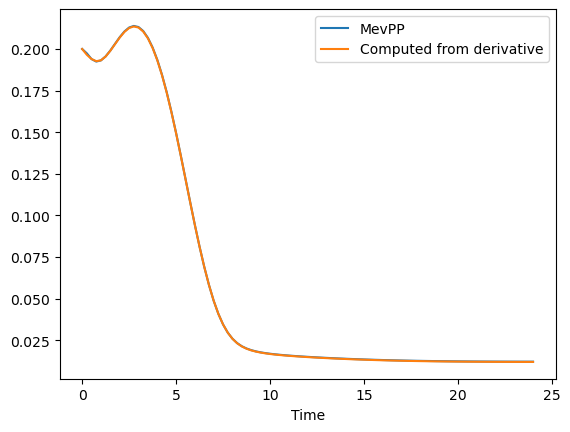

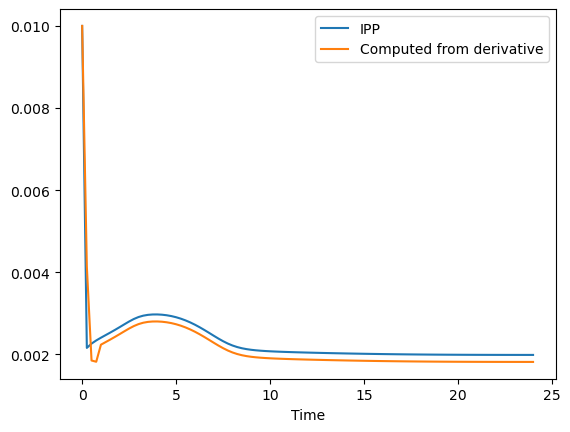

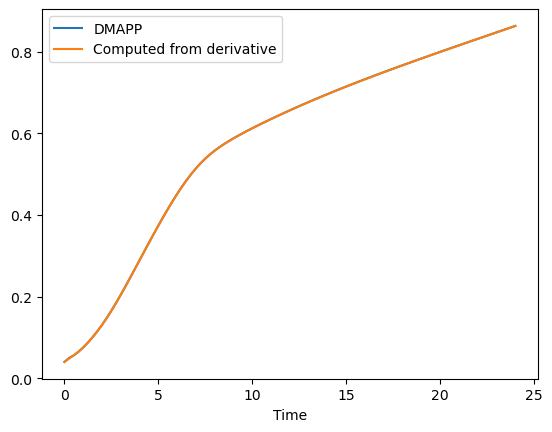

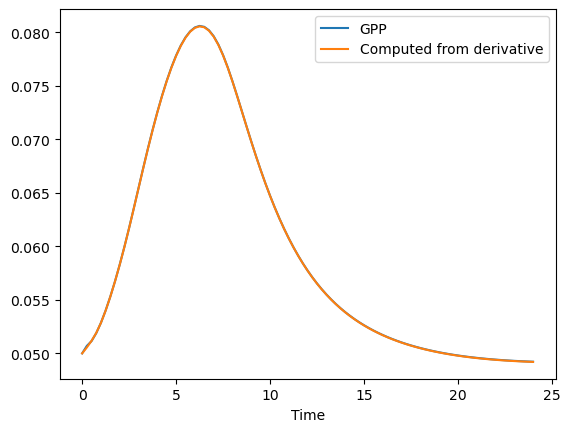

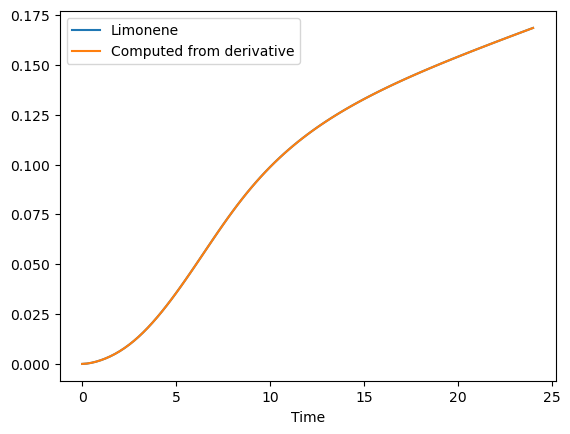

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.301391        0.200998  0.054156   
         0.50       2.866143e+05   0.292768        0.199655  0.063090   
         0.75       3.524272e+05   0.279998        0.196032  0.074110   
         1.00       3.981392e+05   0.265117        0.190800  0.086004   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.337903        0.050990  0.023000   
         23.25      1.468435e+06   0.339059        0.050942  0.023029   
         23.50      1.468851e+06   0.340204        0.050901  0.023058   
         23.75      1.469260e+06   0.341337        0.050867  0.023088   
         24.00      1.469659e+06   0.342458        0.050840  0.023119   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.272337  0.047074  0.193065  0.002761  0.053163  0.051176   
         0.50   0.211002  0.102371  0.181053  0.003095  0.069032  0.053052   
         0.75   0.138704  0.162352  0.168418  0.003385  0.090652  0.055966   
         1.00   0.073142  0.210825  0.154756  0.003706  0.116960  0.059768   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.009617  0.027290  0.012208  0.001987  0.847895  0.049302   
         23.25  0.009614  0.027285  0.012202  0.001987  0.851852  0.049279   
         23.50  0.009612  0.027281  0.012197  0.001987  0.855807 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.017512        0.009931  0.010316 -0.045842  0.061776   
         0.25    -0.015936       -0.001073  0.027008 -0.190397  0.176251   
         0.50    -0.040947       -0.010324  0.039192 -0.270080  0.230916   
         0.75    -0.057522       -0.017820  0.046868 -0.284889  0.225770   
         1.00    -0.062493       -0.023521  0.048540 -0.214293  0.139009   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.004647       -0.000210  0.000110 -0.000012 -0.000023   
         23.25    0.004601       -0.000178  0.000115 -0.000010 -0.000018   
         23.50    0.004555       -0.000149  0.000119 -0.000008 -0.000013   
         23.75    0.004508       -0.000122  0.000123 -0.000006 -0.000008   
         24.00    0.004459       -0.000096  0.000126 -0.000004 -0.000004   

                                                                      
                   MevPP           IPP     DMAPP       GPP  Limonene  
Strain   Time                                                         
Strain 1 0.00  -0.030440 -2.968692e-02  0.040150  0.002395  0.000108  
         0.25  -0.037679 -1.337360e-02  0.058338  0.006151  0.000528  
         0.50  -0.045512 -2.155944e-03  0.076633  0.009806  0.001015  
         0.75  -0.053939  3.966061e-03  0.095035  0.013362  0.001568  
         1.00  -0.061460  1.421971e-03  0.116031  0.017196  0.002183  
...                  ...           ...       ...       ...       ...  
WT       23.00 -0.000025 -4.211236e-07  0.015830 -0.000097  0.003548  
         23.25 -0.000021 -3.244090e-07  0.015823 -0.000088  0.003538  
         23.50 -0.000017 -2.342875e-07  0.015817 -0.000080  0.003529  
         23.75 -0.000013 -1.507546e-07  0.015814 -0.000072  0.003521  
         24.00 -0.000010 -7.381028e-08  0.015812 -0.000065  0.003514  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,
                         -12.0,-12.0,-12.0,-12.0,-12.0,-12.0,-1.30103                         
                         ]), # lower bounds
                         xu=np.array([
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0, 0.0,-1.301029
                         ]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,
                       k21,k22,k23,
                       k31,k32,k33,k34,
                       k41,k42,k43,k44,
                       k51,k52,
                       k61,k62,k63,k64,
                       k71,k72,
                       k81,k82,k83,
                       k91,k92,
                       Vin): #HC: 27
    
        r1 = e1 *( (10**k11) + (10**k12)*np.log(s1) )
        r2 = e2 *( (10**k21) + (10**k22)*np.log(s1) + (10**k23)*np.log(s2) ) 
        r3 = e3 *( (10**k31) - (10**k32)*np.log(s1) - (10**k33)*np.log(s2) + (10**k34)*np.log(s3) )
        r4 = e4 *( (10**k41) + (10**k42)*np.log(s4) - (10**k43)*np.log(s9) - (10**k44)*np.log(s6) )
        r5 = e5 *( (10**k51) + (10**k52)*np.log(s5) )
        r6 = e6 *( (10**k61) + (10**k62)*np.log(s6) - (10**k63)*np.log(s5) - (10**k64)*np.log(s4) )
        r7 = e7 *( (10**k71) + (10**k72)*np.log(s7) )
        r8 = e8 *( (10**k81) + (10**k82)*np.log(s7) + (10**k83)*np.log(s8) )
        r9 = e9 *( (10**k91) + (10**k92)*np.log(s9) )
        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 |  1.238322E+18 |  2.211621E+15
     2 |       74 |  3.132863E+15 |  5.703205E+12
     3 |      138 |  2.893303E+14 |  6.232253E+11
     4 |      202 |  1.959401E+13 |  6.232253E+11
     5 |      266 |  8.109730E+12 |  4.951148E+11
     6 |      330 |  1.679026E+12 |  3.252821E+10
     7 |      394 |  7.076391E+11 |  4.217058E+09
     8 |      458 |  1.109636E+11 |  2.553765E+09
     9 |      522 |  1.963566E+11 |  2.553765E+09
    10 |      586 |  2.430053E+11 |  2.553765E+09
    11 |      650 |  1.385546E+11 |  2.553765E+09
    12 |      714 |  1.725591E+11 |  2.553765E+09
    13 |      778 |  6.507281E+10 |  2.399921E+09
    14 |      842 |  5.097755E+10 |  6.665132E+08
    15 |      906 |  8.321016E+09 |  1.067934E+08
    16 |      970 |  2.918458E+09 |  2.415745E+05
    17 |     1034 |  2.351523E+08 |  2.415745E+05
    18 |     1098 |  6.074650E+07 |  2.415745E+05
    19 |     1162 |  8.260

   162 |    10314 |  4.014588E+01 |  3.982885E+01
   163 |    10378 |  4.012723E+01 |  3.976397E+01
   164 |    10442 |  4.008865E+01 |  3.974971E+01
   165 |    10506 |  3.995424E+01 |  3.968393E+01
   166 |    10570 |  3.974478E+01 |  3.945391E+01
   167 |    10634 |  3.954576E+01 |  3.930913E+01
   168 |    10698 |  3.949819E+01 |  3.930913E+01
   169 |    10762 |  3.943826E+01 |  3.918943E+01
   170 |    10826 |  3.940144E+01 |  3.918943E+01
   171 |    10890 |  3.949485E+01 |  3.918943E+01
   172 |    10954 |  3.936943E+01 |  3.911485E+01
   173 |    11018 |  3.927621E+01 |  3.899323E+01
   174 |    11082 |  3.907413E+01 |  3.878272E+01
   175 |    11146 |  3.892998E+01 |  3.867339E+01
   176 |    11210 |  3.882718E+01 |  3.842026E+01
   177 |    11274 |  3.879344E+01 |  3.842026E+01
   178 |    11338 |  3.864508E+01 |  3.827947E+01
   179 |    11402 |  3.839931E+01 |  3.823243E+01
   180 |    11466 |  3.829486E+01 |  3.816108E+01
   181 |    11530 |  3.826802E+01 |  3.812899E+01


   326 |    20810 |  2.718336E+01 |  2.701475E+01
   327 |    20874 |  2.718669E+01 |  2.701475E+01
   328 |    20938 |  2.717574E+01 |  2.694014E+01
   329 |    21002 |  2.709433E+01 |  2.694014E+01
   330 |    21066 |  2.708260E+01 |  2.685684E+01
   331 |    21130 |  2.707043E+01 |  2.685684E+01
   332 |    21194 |  2.696911E+01 |  2.685684E+01
   333 |    21258 |  2.699694E+01 |  2.685684E+01
   334 |    21322 |  2.696977E+01 |  2.685610E+01
   335 |    21386 |  2.697058E+01 |  2.685610E+01
   336 |    21450 |  2.693244E+01 |  2.674713E+01
   337 |    21514 |  2.686179E+01 |  2.673466E+01
   338 |    21578 |  2.683777E+01 |  2.673466E+01
   339 |    21642 |  2.679434E+01 |  2.673466E+01
   340 |    21706 |  2.676160E+01 |  2.667254E+01
   341 |    21770 |  2.673153E+01 |  2.666767E+01
   342 |    21834 |  2.671965E+01 |  2.662512E+01
   343 |    21898 |  2.671114E+01 |  2.662512E+01
   344 |    21962 |  2.668100E+01 |  2.662512E+01
   345 |    22026 |  2.665599E+01 |  2.662128E+01


   490 |    31306 |  2.213347E+01 |  2.208811E+01
   491 |    31370 |  2.211803E+01 |  2.208811E+01
   492 |    31434 |  2.211794E+01 |  2.207387E+01
   493 |    31498 |  2.209747E+01 |  2.206495E+01
   494 |    31562 |  2.209638E+01 |  2.206495E+01
   495 |    31626 |  2.207610E+01 |  2.203100E+01
   496 |    31690 |  2.208463E+01 |  2.203100E+01
   497 |    31754 |  2.206148E+01 |  2.200200E+01
   498 |    31818 |  2.205690E+01 |  2.200068E+01
   499 |    31882 |  2.205539E+01 |  2.200068E+01
   500 |    31946 |  2.205192E+01 |  2.200068E+01
   501 |    32010 |  2.204946E+01 |  2.200068E+01
   502 |    32074 |  2.203078E+01 |  2.200068E+01
   503 |    32138 |  2.201111E+01 |  2.196864E+01
   504 |    32202 |  2.200444E+01 |  2.196188E+01
   505 |    32266 |  2.200594E+01 |  2.196188E+01
   506 |    32330 |  2.199645E+01 |  2.195779E+01
   507 |    32394 |  2.196305E+01 |  2.193213E+01
   508 |    32458 |  2.195377E+01 |  2.190205E+01
   509 |    32522 |  2.194236E+01 |  2.190135E+01


   654 |    41802 |  2.127700E+01 |  2.127360E+01
   655 |    41866 |  2.127882E+01 |  2.127360E+01
   656 |    41930 |  2.127494E+01 |  2.126976E+01
   657 |    41994 |  2.127028E+01 |  2.126341E+01
   658 |    42058 |  2.126633E+01 |  2.126230E+01
   659 |    42122 |  2.126324E+01 |  2.126150E+01
   660 |    42186 |  2.126068E+01 |  2.125770E+01
   661 |    42250 |  2.125808E+01 |  2.125384E+01
   662 |    42314 |  2.125412E+01 |  2.125055E+01
   663 |    42378 |  2.125082E+01 |  2.124505E+01
   664 |    42442 |  2.124594E+01 |  2.124186E+01
   665 |    42506 |  2.124373E+01 |  2.124010E+01
   666 |    42570 |  2.123756E+01 |  2.123278E+01
   667 |    42634 |  2.123618E+01 |  2.122444E+01
   668 |    42698 |  2.122836E+01 |  2.121982E+01
   669 |    42762 |  2.121877E+01 |  2.120966E+01
   670 |    42826 |  2.120688E+01 |  2.119170E+01
   671 |    42890 |  2.119759E+01 |  2.118891E+01
   672 |    42954 |  2.119169E+01 |  2.118147E+01
   673 |    43018 |  2.118356E+01 |  2.117549E+01


   818 |    52298 |  1.990478E+01 |  1.989394E+01
   819 |    52362 |  1.989493E+01 |  1.987945E+01
   820 |    52426 |  1.988476E+01 |  1.987566E+01
   821 |    52490 |  1.987979E+01 |  1.986659E+01
   822 |    52554 |  1.987472E+01 |  1.985151E+01
   823 |    52618 |  1.986625E+01 |  1.984771E+01
   824 |    52682 |  1.985988E+01 |  1.983620E+01
   825 |    52746 |  1.984983E+01 |  1.982742E+01
   826 |    52810 |  1.983919E+01 |  1.982742E+01
   827 |    52874 |  1.983899E+01 |  1.982256E+01
   828 |    52938 |  1.982251E+01 |  1.980711E+01
   829 |    53002 |  1.980710E+01 |  1.979467E+01
   830 |    53066 |  1.979878E+01 |  1.979102E+01
   831 |    53130 |  1.978948E+01 |  1.977668E+01
   832 |    53194 |  1.977812E+01 |  1.976772E+01
   833 |    53258 |  1.976553E+01 |  1.975574E+01
   834 |    53322 |  1.976151E+01 |  1.975134E+01
   835 |    53386 |  1.975877E+01 |  1.974841E+01
   836 |    53450 |  1.974814E+01 |  1.972900E+01
   837 |    53514 |  1.973987E+01 |  1.972900E+01


   982 |    62794 |  1.811414E+01 |  1.809971E+01
   983 |    62858 |  1.810750E+01 |  1.808357E+01
   984 |    62922 |  1.809469E+01 |  1.807541E+01
   985 |    62986 |  1.808663E+01 |  1.807541E+01
   986 |    63050 |  1.808261E+01 |  1.807541E+01
   987 |    63114 |  1.807879E+01 |  1.807383E+01
   988 |    63178 |  1.807811E+01 |  1.806680E+01
   989 |    63242 |  1.806932E+01 |  1.806515E+01
   990 |    63306 |  1.806603E+01 |  1.805827E+01
   991 |    63370 |  1.806155E+01 |  1.805288E+01
   992 |    63434 |  1.805589E+01 |  1.804308E+01
   993 |    63498 |  1.804959E+01 |  1.803914E+01
   994 |    63562 |  1.804583E+01 |  1.803572E+01
   995 |    63626 |  1.804525E+01 |  1.803572E+01
   996 |    63690 |  1.804066E+01 |  1.803572E+01
   997 |    63754 |  1.803905E+01 |  1.802712E+01
   998 |    63818 |  1.803332E+01 |  1.802533E+01
   999 |    63882 |  1.802938E+01 |  1.802533E+01
  1000 |    63946 |  1.802666E+01 |  1.801972E+01
  1001 |    64010 |  1.801826E+01 |  1.800765E+01


  1146 |    73290 |  1.711209E+01 |  1.710140E+01
  1147 |    73354 |  1.710681E+01 |  1.710038E+01
  1148 |    73418 |  1.710134E+01 |  1.709659E+01
  1149 |    73482 |  1.709914E+01 |  1.709659E+01
  1150 |    73546 |  1.709835E+01 |  1.709133E+01
  1151 |    73610 |  1.709484E+01 |  1.708924E+01
  1152 |    73674 |  1.709265E+01 |  1.708697E+01
  1153 |    73738 |  1.708531E+01 |  1.707916E+01
  1154 |    73802 |  1.708209E+01 |  1.707218E+01
  1155 |    73866 |  1.708105E+01 |  1.707218E+01
  1156 |    73930 |  1.708012E+01 |  1.706808E+01
  1157 |    73994 |  1.707389E+01 |  1.706808E+01
  1158 |    74058 |  1.707318E+01 |  1.706808E+01
  1159 |    74122 |  1.706747E+01 |  1.706128E+01
  1160 |    74186 |  1.706156E+01 |  1.705622E+01
  1161 |    74250 |  1.706124E+01 |  1.705446E+01
  1162 |    74314 |  1.705458E+01 |  1.704601E+01
  1163 |    74378 |  1.704958E+01 |  1.704075E+01
  1164 |    74442 |  1.705035E+01 |  1.704075E+01
  1165 |    74506 |  1.704453E+01 |  1.703403E+01


  1310 |    83786 |  1.642944E+01 |  1.642154E+01
  1311 |    83850 |  1.642296E+01 |  1.641816E+01
  1312 |    83914 |  1.642132E+01 |  1.641463E+01
  1313 |    83978 |  1.641606E+01 |  1.640924E+01
  1314 |    84042 |  1.641171E+01 |  1.640420E+01
  1315 |    84106 |  1.640565E+01 |  1.639863E+01
  1316 |    84170 |  1.640069E+01 |  1.639472E+01
  1317 |    84234 |  1.639658E+01 |  1.639255E+01
  1318 |    84298 |  1.639328E+01 |  1.638948E+01
  1319 |    84362 |  1.639024E+01 |  1.638620E+01
  1320 |    84426 |  1.638875E+01 |  1.637574E+01
  1321 |    84490 |  1.638595E+01 |  1.637574E+01
  1322 |    84554 |  1.638473E+01 |  1.637574E+01
  1323 |    84618 |  1.638232E+01 |  1.637574E+01
  1324 |    84682 |  1.637670E+01 |  1.636979E+01
  1325 |    84746 |  1.637465E+01 |  1.636765E+01
  1326 |    84810 |  1.637212E+01 |  1.636655E+01
  1327 |    84874 |  1.636702E+01 |  1.636037E+01
  1328 |    84938 |  1.636690E+01 |  1.635866E+01
  1329 |    85002 |  1.636412E+01 |  1.635407E+01


  1474 |    94282 |  1.602450E+01 |  1.601935E+01
  1475 |    94346 |  1.602249E+01 |  1.601935E+01
  1476 |    94410 |  1.602002E+01 |  1.601433E+01
  1477 |    94474 |  1.601755E+01 |  1.601261E+01
  1478 |    94538 |  1.601355E+01 |  1.601090E+01
  1479 |    94602 |  1.601177E+01 |  1.600765E+01
  1480 |    94666 |  1.600806E+01 |  1.600399E+01
  1481 |    94730 |  1.600526E+01 |  1.600103E+01
  1482 |    94794 |  1.600311E+01 |  1.599856E+01
  1483 |    94858 |  1.599956E+01 |  1.599649E+01
  1484 |    94922 |  1.599776E+01 |  1.599439E+01
  1485 |    94986 |  1.599545E+01 |  1.599268E+01
  1486 |    95050 |  1.599360E+01 |  1.598993E+01
  1487 |    95114 |  1.599225E+01 |  1.598882E+01
  1488 |    95178 |  1.599076E+01 |  1.598882E+01
  1489 |    95242 |  1.598919E+01 |  1.598756E+01
  1490 |    95306 |  1.598828E+01 |  1.598588E+01
  1491 |    95370 |  1.598806E+01 |  1.598588E+01
  1492 |    95434 |  1.598571E+01 |  1.598281E+01
  1493 |    95498 |  1.598373E+01 |  1.597928E+01


  1638 |   104778 |  1.571662E+01 |  1.571276E+01
  1639 |   104842 |  1.571402E+01 |  1.571212E+01
  1640 |   104906 |  1.571326E+01 |  1.571188E+01
  1641 |   104970 |  1.571176E+01 |  1.571020E+01
  1642 |   105034 |  1.571089E+01 |  1.570997E+01
  1643 |   105098 |  1.571072E+01 |  1.570915E+01
  1644 |   105162 |  1.570980E+01 |  1.570899E+01
  1645 |   105226 |  1.570849E+01 |  1.570708E+01
  1646 |   105290 |  1.570696E+01 |  1.570475E+01
  1647 |   105354 |  1.570381E+01 |  1.570189E+01
  1648 |   105418 |  1.570221E+01 |  1.569863E+01
  1649 |   105482 |  1.569952E+01 |  1.569790E+01
  1650 |   105546 |  1.569701E+01 |  1.569453E+01
  1651 |   105610 |  1.569398E+01 |  1.568815E+01
  1652 |   105674 |  1.568996E+01 |  1.568651E+01
  1653 |   105738 |  1.568512E+01 |  1.567891E+01
  1654 |   105802 |  1.567927E+01 |  1.567268E+01
  1655 |   105866 |  1.567481E+01 |  1.566925E+01
  1656 |   105930 |  1.566941E+01 |  1.566544E+01
  1657 |   105994 |  1.566500E+01 |  1.566072E+01


  1802 |   115274 |  1.526212E+01 |  1.525650E+01
  1803 |   115338 |  1.526161E+01 |  1.525518E+01
  1804 |   115402 |  1.525834E+01 |  1.525491E+01
  1805 |   115466 |  1.525688E+01 |  1.525310E+01
  1806 |   115530 |  1.525414E+01 |  1.525051E+01
  1807 |   115594 |  1.525265E+01 |  1.525022E+01
  1808 |   115658 |  1.525369E+01 |  1.525022E+01
  1809 |   115722 |  1.525229E+01 |  1.524821E+01
  1810 |   115786 |  1.525213E+01 |  1.524821E+01
  1811 |   115850 |  1.525161E+01 |  1.524821E+01
  1812 |   115914 |  1.525194E+01 |  1.524821E+01
  1813 |   115978 |  1.525055E+01 |  1.524621E+01
  1814 |   116042 |  1.524829E+01 |  1.524621E+01
  1815 |   116106 |  1.524754E+01 |  1.524621E+01
  1816 |   116170 |  1.524648E+01 |  1.524422E+01
  1817 |   116234 |  1.524567E+01 |  1.524422E+01
  1818 |   116298 |  1.524458E+01 |  1.524176E+01
  1819 |   116362 |  1.524326E+01 |  1.524176E+01
  1820 |   116426 |  1.524240E+01 |  1.523964E+01
  1821 |   116490 |  1.524108E+01 |  1.523848E+01


  1966 |   125770 |  1.503570E+01 |  1.503164E+01
  1967 |   125834 |  1.503478E+01 |  1.503144E+01
  1968 |   125898 |  1.503179E+01 |  1.502572E+01
  1969 |   125962 |  1.503026E+01 |  1.502405E+01
  1970 |   126026 |  1.502898E+01 |  1.502405E+01
  1971 |   126090 |  1.502768E+01 |  1.502253E+01
  1972 |   126154 |  1.502695E+01 |  1.502253E+01
  1973 |   126218 |  1.502515E+01 |  1.502209E+01
  1974 |   126282 |  1.502218E+01 |  1.501936E+01
  1975 |   126346 |  1.502074E+01 |  1.501775E+01
  1976 |   126410 |  1.501966E+01 |  1.501694E+01
  1977 |   126474 |  1.501678E+01 |  1.501408E+01
  1978 |   126538 |  1.501331E+01 |  1.500892E+01
  1979 |   126602 |  1.501147E+01 |  1.500892E+01
  1980 |   126666 |  1.500964E+01 |  1.500747E+01
  1981 |   126730 |  1.500804E+01 |  1.500647E+01
  1982 |   126794 |  1.500573E+01 |  1.500227E+01
  1983 |   126858 |  1.500353E+01 |  1.499977E+01
  1984 |   126922 |  1.500151E+01 |  1.499830E+01
  1985 |   126986 |  1.499975E+01 |  1.499825E+01


  2130 |   136266 |  1.464697E+01 |  1.464311E+01
  2131 |   136330 |  1.464550E+01 |  1.464289E+01
  2132 |   136394 |  1.464251E+01 |  1.463844E+01
  2133 |   136458 |  1.464079E+01 |  1.463718E+01
  2134 |   136522 |  1.464136E+01 |  1.463718E+01
  2135 |   136586 |  1.463866E+01 |  1.463561E+01
  2136 |   136650 |  1.463563E+01 |  1.463172E+01
  2137 |   136714 |  1.463357E+01 |  1.463161E+01
  2138 |   136778 |  1.463225E+01 |  1.463033E+01
  2139 |   136842 |  1.463158E+01 |  1.462987E+01
  2140 |   136906 |  1.463167E+01 |  1.462870E+01
  2141 |   136970 |  1.463112E+01 |  1.462716E+01
  2142 |   137034 |  1.462963E+01 |  1.462246E+01
  2143 |   137098 |  1.462527E+01 |  1.461924E+01
  2144 |   137162 |  1.462144E+01 |  1.461900E+01
  2145 |   137226 |  1.462012E+01 |  1.461435E+01
  2146 |   137290 |  1.461739E+01 |  1.460775E+01
  2147 |   137354 |  1.461271E+01 |  1.460775E+01
  2148 |   137418 |  1.460990E+01 |  1.460447E+01
  2149 |   137482 |  1.460697E+01 |  1.460447E+01


  2294 |   146762 |  1.364508E+01 |  1.363732E+01
  2295 |   146826 |  1.363984E+01 |  1.363535E+01
  2296 |   146890 |  1.363783E+01 |  1.362936E+01
  2297 |   146954 |  1.363544E+01 |  1.362936E+01
  2298 |   147018 |  1.363299E+01 |  1.362928E+01
  2299 |   147082 |  1.362851E+01 |  1.362297E+01
  2300 |   147146 |  1.362657E+01 |  1.362246E+01
  2301 |   147210 |  1.362497E+01 |  1.361426E+01
  2302 |   147274 |  1.361841E+01 |  1.360499E+01
  2303 |   147338 |  1.361192E+01 |  1.359884E+01
  2304 |   147402 |  1.360866E+01 |  1.359884E+01
  2305 |   147466 |  1.359982E+01 |  1.358907E+01
  2306 |   147530 |  1.359149E+01 |  1.358574E+01
  2307 |   147594 |  1.358763E+01 |  1.358139E+01
  2308 |   147658 |  1.358549E+01 |  1.358139E+01
  2309 |   147722 |  1.358187E+01 |  1.357944E+01
  2310 |   147786 |  1.357620E+01 |  1.356426E+01
  2311 |   147850 |  1.357103E+01 |  1.356426E+01
  2312 |   147914 |  1.356591E+01 |  1.355839E+01
  2313 |   147978 |  1.356163E+01 |  1.355544E+01


  2458 |   157258 |  1.313253E+01 |  1.312918E+01
  2459 |   157322 |  1.312882E+01 |  1.312550E+01
  2460 |   157386 |  1.312670E+01 |  1.312387E+01
  2461 |   157450 |  1.312448E+01 |  1.312151E+01
  2462 |   157514 |  1.312288E+01 |  1.312102E+01
  2463 |   157578 |  1.311989E+01 |  1.311672E+01
  2464 |   157642 |  1.311987E+01 |  1.311672E+01
  2465 |   157706 |  1.312042E+01 |  1.311579E+01
  2466 |   157770 |  1.311899E+01 |  1.311579E+01
  2467 |   157834 |  1.311650E+01 |  1.311161E+01
  2468 |   157898 |  1.311492E+01 |  1.311143E+01
  2469 |   157962 |  1.311184E+01 |  1.310928E+01
  2470 |   158026 |  1.310950E+01 |  1.310740E+01
  2471 |   158090 |  1.310784E+01 |  1.310213E+01
  2472 |   158154 |  1.310570E+01 |  1.310213E+01
  2473 |   158218 |  1.310535E+01 |  1.310213E+01
  2474 |   158282 |  1.310436E+01 |  1.310044E+01
  2475 |   158346 |  1.310360E+01 |  1.309159E+01
  2476 |   158410 |  1.309809E+01 |  1.309159E+01
  2477 |   158474 |  1.309775E+01 |  1.309159E+01


  2622 |   167754 |  1.278929E+01 |  1.278415E+01
  2623 |   167818 |  1.278387E+01 |  1.278044E+01
  2624 |   167882 |  1.278011E+01 |  1.277579E+01
  2625 |   167946 |  1.277750E+01 |  1.277575E+01
  2626 |   168010 |  1.277476E+01 |  1.277120E+01
  2627 |   168074 |  1.277424E+01 |  1.277091E+01
  2628 |   168138 |  1.277043E+01 |  1.276111E+01
  2629 |   168202 |  1.276545E+01 |  1.276111E+01
  2630 |   168266 |  1.276554E+01 |  1.276111E+01
  2631 |   168330 |  1.275933E+01 |  1.274364E+01
  2632 |   168394 |  1.274983E+01 |  1.273888E+01
  2633 |   168458 |  1.274210E+01 |  1.273313E+01
  2634 |   168522 |  1.273581E+01 |  1.272659E+01
  2635 |   168586 |  1.272760E+01 |  1.271988E+01
  2636 |   168650 |  1.272323E+01 |  1.271403E+01
  2637 |   168714 |  1.271215E+01 |  1.270413E+01
  2638 |   168778 |  1.270901E+01 |  1.269447E+01
  2639 |   168842 |  1.270107E+01 |  1.269186E+01
  2640 |   168906 |  1.269375E+01 |  1.267907E+01
  2641 |   168970 |  1.268008E+01 |  1.267033E+01


  2786 |   178250 |  1.172883E+01 |  1.172146E+01
  2787 |   178314 |  1.172228E+01 |  1.171714E+01
  2788 |   178378 |  1.172209E+01 |  1.171583E+01
  2789 |   178442 |  1.172166E+01 |  1.171583E+01
  2790 |   178506 |  1.172141E+01 |  1.171175E+01
  2791 |   178570 |  1.171958E+01 |  1.171175E+01
  2792 |   178634 |  1.171893E+01 |  1.171099E+01
  2793 |   178698 |  1.171675E+01 |  1.170718E+01
  2794 |   178762 |  1.171318E+01 |  1.170585E+01
  2795 |   178826 |  1.171049E+01 |  1.170268E+01
  2796 |   178890 |  1.170521E+01 |  1.169497E+01
  2797 |   178954 |  1.170224E+01 |  1.169497E+01
  2798 |   179018 |  1.170139E+01 |  1.169456E+01
  2799 |   179082 |  1.169708E+01 |  1.169084E+01
  2800 |   179146 |  1.169306E+01 |  1.168578E+01
  2801 |   179210 |  1.168864E+01 |  1.168491E+01
  2802 |   179274 |  1.168502E+01 |  1.168057E+01
  2803 |   179338 |  1.168256E+01 |  1.167745E+01
  2804 |   179402 |  1.167963E+01 |  1.167745E+01
  2805 |   179466 |  1.167508E+01 |  1.166813E+01


  2950 |   188746 |  1.134637E+01 |  1.134535E+01
  2951 |   188810 |  1.134518E+01 |  1.134416E+01
  2952 |   188874 |  1.134414E+01 |  1.134271E+01
  2953 |   188938 |  1.134271E+01 |  1.134101E+01
  2954 |   189002 |  1.134150E+01 |  1.133936E+01
  2955 |   189066 |  1.134018E+01 |  1.133804E+01
  2956 |   189130 |  1.133865E+01 |  1.133647E+01
  2957 |   189194 |  1.133709E+01 |  1.133534E+01
  2958 |   189258 |  1.133589E+01 |  1.133184E+01
  2959 |   189322 |  1.133191E+01 |  1.132712E+01
  2960 |   189386 |  1.132837E+01 |  1.132351E+01
  2961 |   189450 |  1.132437E+01 |  1.132247E+01
  2962 |   189514 |  1.132274E+01 |  1.132109E+01
  2963 |   189578 |  1.132146E+01 |  1.132041E+01
  2964 |   189642 |  1.132141E+01 |  1.131996E+01
  2965 |   189706 |  1.132075E+01 |  1.131887E+01
  2966 |   189770 |  1.131901E+01 |  1.131589E+01
  2967 |   189834 |  1.131841E+01 |  1.131579E+01
  2968 |   189898 |  1.131789E+01 |  1.131579E+01
  2969 |   189962 |  1.131616E+01 |  1.131435E+01


  3114 |   199242 |  1.099770E+01 |  1.098634E+01
  3115 |   199306 |  1.099352E+01 |  1.098634E+01
  3116 |   199370 |  1.098922E+01 |  1.098618E+01
  3117 |   199434 |  1.098319E+01 |  1.097725E+01
  3118 |   199498 |  1.098065E+01 |  1.097541E+01
  3119 |   199562 |  1.097651E+01 |  1.097416E+01
  3120 |   199626 |  1.097452E+01 |  1.097134E+01
  3121 |   199690 |  1.097336E+01 |  1.096976E+01
  3122 |   199754 |  1.097114E+01 |  1.096732E+01
  3123 |   199818 |  1.097040E+01 |  1.096727E+01
  3124 |   199882 |  1.096914E+01 |  1.096076E+01
  3125 |   199946 |  1.096827E+01 |  1.096068E+01
  3126 |   200010 |  1.096428E+01 |  1.096068E+01
  3127 |   200074 |  1.096386E+01 |  1.096068E+01
  3128 |   200138 |  1.096210E+01 |  1.096023E+01
  3129 |   200202 |  1.096179E+01 |  1.095962E+01
  3130 |   200266 |  1.095887E+01 |  1.095391E+01
  3131 |   200330 |  1.095608E+01 |  1.095302E+01
  3132 |   200394 |  1.095516E+01 |  1.095128E+01
  3133 |   200458 |  1.095282E+01 |  1.094900E+01


  3278 |   209738 |  1.066009E+01 |  1.065373E+01
  3279 |   209802 |  1.065541E+01 |  1.065283E+01
  3280 |   209866 |  1.065420E+01 |  1.065281E+01
  3281 |   209930 |  1.065360E+01 |  1.065187E+01
  3282 |   209994 |  1.065212E+01 |  1.064936E+01
  3283 |   210058 |  1.064987E+01 |  1.064831E+01
  3284 |   210122 |  1.064969E+01 |  1.064816E+01
  3285 |   210186 |  1.064842E+01 |  1.064680E+01
  3286 |   210250 |  1.064718E+01 |  1.064591E+01
  3287 |   210314 |  1.064635E+01 |  1.064437E+01
  3288 |   210378 |  1.064525E+01 |  1.064367E+01
  3289 |   210442 |  1.064421E+01 |  1.064118E+01
  3290 |   210506 |  1.064384E+01 |  1.064068E+01
  3291 |   210570 |  1.064187E+01 |  1.063813E+01
  3292 |   210634 |  1.064052E+01 |  1.063813E+01
  3293 |   210698 |  1.063928E+01 |  1.063736E+01
  3294 |   210762 |  1.063847E+01 |  1.063468E+01
  3295 |   210826 |  1.063511E+01 |  1.063089E+01
  3296 |   210890 |  1.063261E+01 |  1.062927E+01
  3297 |   210954 |  1.062995E+01 |  1.062433E+01


  3442 |   220234 |  1.017743E+01 |  1.017197E+01
  3443 |   220298 |  1.017558E+01 |  1.017197E+01
  3444 |   220362 |  1.017561E+01 |  1.017025E+01
  3445 |   220426 |  1.017294E+01 |  1.016804E+01
  3446 |   220490 |  1.017106E+01 |  1.016804E+01
  3447 |   220554 |  1.016872E+01 |  1.016592E+01
  3448 |   220618 |  1.016590E+01 |  1.015907E+01
  3449 |   220682 |  1.016252E+01 |  1.015528E+01
  3450 |   220746 |  1.015964E+01 |  1.015521E+01
  3451 |   220810 |  1.015912E+01 |  1.015441E+01
  3452 |   220874 |  1.015629E+01 |  1.015186E+01
  3453 |   220938 |  1.015464E+01 |  1.015186E+01
  3454 |   221002 |  1.015194E+01 |  1.014612E+01
  3455 |   221066 |  1.014908E+01 |  1.014612E+01
  3456 |   221130 |  1.014806E+01 |  1.014464E+01
  3457 |   221194 |  1.014659E+01 |  1.014149E+01
  3458 |   221258 |  1.014541E+01 |  1.014149E+01
  3459 |   221322 |  1.014507E+01 |  1.014132E+01
  3460 |   221386 |  1.014374E+01 |  1.014132E+01
  3461 |   221450 |  1.014250E+01 |  1.013847E+01


  3606 |   230730 |  9.8068687935 |  9.8047226630
  3607 |   230794 |  9.8062854184 |  9.8047226630
  3608 |   230858 |  9.8049343866 |  9.8035954678
  3609 |   230922 |  9.8042571069 |  9.8017225472
  3610 |   230986 |  9.8026841516 |  9.8003274246
  3611 |   231050 |  9.8007604954 |  9.7982635027
  3612 |   231114 |  9.7989180342 |  9.7951295861
  3613 |   231178 |  9.7959278429 |  9.7888699731
  3614 |   231242 |  9.7906813690 |  9.7864579466
  3615 |   231306 |  9.7891629908 |  9.7854331132
  3616 |   231370 |  9.7876862884 |  9.7850968588
  3617 |   231434 |  9.7860255862 |  9.7847295649
  3618 |   231498 |  9.7826576792 |  9.7799399406
  3619 |   231562 |  9.7796390936 |  9.7770919686
  3620 |   231626 |  9.7766736209 |  9.7738734496
  3621 |   231690 |  9.7748363895 |  9.7737476149
  3622 |   231754 |  9.7730442849 |  9.7713827746
  3623 |   231818 |  9.7718085986 |  9.7694901572
  3624 |   231882 |  9.7704026748 |  9.7663930238
  3625 |   231946 |  9.7677582688 |  9.7643908957


  3770 |   241226 |  9.5638107657 |  9.5622239916
  3771 |   241290 |  9.5637808034 |  9.5620679338
  3772 |   241354 |  9.5606384630 |  9.5556650941
  3773 |   241418 |  9.5576859092 |  9.5546617332
  3774 |   241482 |  9.5579798222 |  9.5546617332
  3775 |   241546 |  9.5557388629 |  9.5533653051
  3776 |   241610 |  9.5542282524 |  9.5521099980
  3777 |   241674 |  9.5534552209 |  9.5517838883
  3778 |   241738 |  9.5508609885 |  9.5487795754
  3779 |   241802 |  9.5498960060 |  9.5487795754
  3780 |   241866 |  9.5497202385 |  9.5476794585
  3781 |   241930 |  9.5481799831 |  9.5453759148
  3782 |   241994 |  9.5458986915 |  9.5443600378
  3783 |   242058 |  9.5444374026 |  9.5434658537
  3784 |   242122 |  9.5441312308 |  9.5423680520
  3785 |   242186 |  9.5433925953 |  9.5420357603
  3786 |   242250 |  9.5430688046 |  9.5415794445
  3787 |   242314 |  9.5422772507 |  9.5415794445
  3788 |   242378 |  9.5412092374 |  9.5385933006
  3789 |   242442 |  9.5402493698 |  9.5379126097


  3934 |   251722 |  9.4342798533 |  9.4324183681
  3935 |   251786 |  9.4326769672 |  9.4315072990
  3936 |   251850 |  9.4317102182 |  9.4312024459
  3937 |   251914 |  9.4306778344 |  9.4289813086
  3938 |   251978 |  9.4292644459 |  9.4284336308
  3939 |   252042 |  9.4287520565 |  9.4275198900
  3940 |   252106 |  9.4285689513 |  9.4275198900
  3941 |   252170 |  9.4279349040 |  9.4267575098
  3942 |   252234 |  9.4277649610 |  9.4267575098
  3943 |   252298 |  9.4266352234 |  9.4251296168
  3944 |   252362 |  9.4251910515 |  9.4242019945
  3945 |   252426 |  9.4243658917 |  9.4230296918
  3946 |   252490 |  9.4233629888 |  9.4220863837
  3947 |   252554 |  9.4222471645 |  9.4205414830
  3948 |   252618 |  9.4210532235 |  9.4186897373
  3949 |   252682 |  9.4196259926 |  9.4182955853
  3950 |   252746 |  9.4182340791 |  9.4169340686
  3951 |   252810 |  9.4162472547 |  9.4139811018
  3952 |   252874 |  9.4157694469 |  9.4139811018
  3953 |   252938 |  9.4146619319 |  9.4133102162


  4098 |   262218 |  9.0541465861 |  9.0352007031
  4099 |   262282 |  9.0389490267 |  9.0237631179
  4100 |   262346 |  9.0300903355 |  9.0174178072
  4101 |   262410 |  9.0144024024 |  8.9870575178
  4102 |   262474 |  8.9953954330 |  8.9768365516
  4103 |   262538 |  8.9793013087 |  8.9716458466
  4104 |   262602 |  8.9765280801 |  8.9695531242
  4105 |   262666 |  8.9686295111 |  8.9609209928
  4106 |   262730 |  8.9600934960 |  8.9510193444
  4107 |   262794 |  8.9538081205 |  8.9457597390
  4108 |   262858 |  8.9443021737 |  8.9263506365
  4109 |   262922 |  8.9324451038 |  8.9201446720
  4110 |   262986 |  8.9265352959 |  8.8991600121
  4111 |   263050 |  8.9080119352 |  8.8930503719
  4112 |   263114 |  8.8909152677 |  8.8751573030
  4113 |   263178 |  8.8834470075 |  8.8663012108
  4114 |   263242 |  8.8721541536 |  8.8650527419
  4115 |   263306 |  8.8681430562 |  8.8631862197
  4116 |   263370 |  8.8670813799 |  8.8606724095
  4117 |   263434 |  8.8641169490 |  8.8563051177


  4262 |   272714 |  8.0930666188 |  8.0921739824
  4263 |   272778 |  8.0924375509 |  8.0916369998
  4264 |   272842 |  8.0919216683 |  8.0900050218
  4265 |   272906 |  8.0897761925 |  8.0860378842
  4266 |   272970 |  8.0865165540 |  8.0832993225
  4267 |   273034 |  8.0850187358 |  8.0832993225
  4268 |   273098 |  8.0835566501 |  8.0815699960
  4269 |   273162 |  8.0814378243 |  8.0786120956
  4270 |   273226 |  8.0790862898 |  8.0770071388
  4271 |   273290 |  8.0778365971 |  8.0754842450
  4272 |   273354 |  8.0764606143 |  8.0754842450
  4273 |   273418 |  8.0758373732 |  8.0743544543
  4274 |   273482 |  8.0745682747 |  8.0727852300
  4275 |   273546 |  8.0738026880 |  8.0727852300
  4276 |   273610 |  8.0733271683 |  8.0721899091
  4277 |   273674 |  8.0729913578 |  8.0703150242
  4278 |   273738 |  8.0723798438 |  8.0703150242
  4279 |   273802 |  8.0716149767 |  8.0703150242
  4280 |   273866 |  8.0703418736 |  8.0686937725
  4281 |   273930 |  8.0695905383 |  8.0682573387


  4426 |   283210 |  7.8648953655 |  7.8628384878
  4427 |   283274 |  7.8640458307 |  7.8620434145
  4428 |   283338 |  7.8626067614 |  7.8618095043
  4429 |   283402 |  7.8618771853 |  7.8607340856
  4430 |   283466 |  7.8612989709 |  7.8606749280
  4431 |   283530 |  7.8604614692 |  7.8590058332
  4432 |   283594 |  7.8605118028 |  7.8590058332
  4433 |   283658 |  7.8607547520 |  7.8590058332
  4434 |   283722 |  7.8601750843 |  7.8588854503
  4435 |   283786 |  7.8593232944 |  7.8579496209
  4436 |   283850 |  7.8596213119 |  7.8579496209
  4437 |   283914 |  7.8597505413 |  7.8570533596
  4438 |   283978 |  7.8585512120 |  7.8560810097
  4439 |   284042 |  7.8575470893 |  7.8557624428
  4440 |   284106 |  7.8565374690 |  7.8540425763
  4441 |   284170 |  7.8555322491 |  7.8529078201
  4442 |   284234 |  7.8540336529 |  7.8524140233
  4443 |   284298 |  7.8533973457 |  7.8521094853
  4444 |   284362 |  7.8532442056 |  7.8521094853
  4445 |   284426 |  7.8534348531 |  7.8514280413


  4590 |   293706 |  7.5826292177 |  7.5792033763
  4591 |   293770 |  7.5807866724 |  7.5785637087
  4592 |   293834 |  7.5811082741 |  7.5775096953
  4593 |   293898 |  7.5798703843 |  7.5747737547
  4594 |   293962 |  7.5776655066 |  7.5747737547
  4595 |   294026 |  7.5770264708 |  7.5735169491
  4596 |   294090 |  7.5740422557 |  7.5693986981
  4597 |   294154 |  7.5733225731 |  7.5693986981
  4598 |   294218 |  7.5717819733 |  7.5690622144
  4599 |   294282 |  7.5711485291 |  7.5669917982
  4600 |   294346 |  7.5699375468 |  7.5669917982
  4601 |   294410 |  7.5697683252 |  7.5669917982
  4602 |   294474 |  7.5696139001 |  7.5669917982
  4603 |   294538 |  7.5695451825 |  7.5653555219
  4604 |   294602 |  7.5680977582 |  7.5653555219
  4605 |   294666 |  7.5672148283 |  7.5648573925
  4606 |   294730 |  7.5665748976 |  7.5622188296
  4607 |   294794 |  7.5640593561 |  7.5616214480
  4608 |   294858 |  7.5648320000 |  7.5616214480
  4609 |   294922 |  7.5631936753 |  7.5600869930


  4754 |   304202 |  7.4724506442 |  7.4716861758
  4755 |   304266 |  7.4717801230 |  7.4713363163
  4756 |   304330 |  7.4713669267 |  7.4705677458
  4757 |   304394 |  7.4706788623 |  7.4693359832
  4758 |   304458 |  7.4697332083 |  7.4686650469
  4759 |   304522 |  7.4690999163 |  7.4685823179
  4760 |   304586 |  7.4687344396 |  7.4681361431
  4761 |   304650 |  7.4682289146 |  7.4678101996
  4762 |   304714 |  7.4676095642 |  7.4670443551
  4763 |   304778 |  7.4671307471 |  7.4663183992
  4764 |   304842 |  7.4664861849 |  7.4654250213
  4765 |   304906 |  7.4657937955 |  7.4635888040
  4766 |   304970 |  7.4641121372 |  7.4627333911
  4767 |   305034 |  7.4633397300 |  7.4625934060
  4768 |   305098 |  7.4626528624 |  7.4619546726
  4769 |   305162 |  7.4620248536 |  7.4614376381
  4770 |   305226 |  7.4615810262 |  7.4610148469
  4771 |   305290 |  7.4613323641 |  7.4606997430
  4772 |   305354 |  7.4607044483 |  7.4593193214
  4773 |   305418 |  7.4599492086 |  7.4592418351


  4918 |   314698 |  7.3392609298 |  7.3369316336
  4919 |   314762 |  7.3386749718 |  7.3369316336
  4920 |   314826 |  7.3379551193 |  7.3360419964
  4921 |   314890 |  7.3373701824 |  7.3356703044
  4922 |   314954 |  7.3369147786 |  7.3354845799
  4923 |   315018 |  7.3356795810 |  7.3345990031
  4924 |   315082 |  7.3353264108 |  7.3341068286
  4925 |   315146 |  7.3350087044 |  7.3341068286
  4926 |   315210 |  7.3353098011 |  7.3341068286
  4927 |   315274 |  7.3345360935 |  7.3327846440
  4928 |   315338 |  7.3340824356 |  7.3323719323
  4929 |   315402 |  7.3340385826 |  7.3321839483
  4930 |   315466 |  7.3329130505 |  7.3312010747
  4931 |   315530 |  7.3319479198 |  7.3310163866
  4932 |   315594 |  7.3313486868 |  7.3295784095
  4933 |   315658 |  7.3300777085 |  7.3284747595
  4934 |   315722 |  7.3297433046 |  7.3284747595
  4935 |   315786 |  7.3282015309 |  7.3269606590
  4936 |   315850 |  7.3270515016 |  7.3259747043
  4937 |   315914 |  7.3263710401 |  7.3249685017


  5082 |   325194 |  7.2213755572 |  7.2189127471
  5083 |   325258 |  7.2198195628 |  7.2171393689
  5084 |   325322 |  7.2177857908 |  7.2168412089
  5085 |   325386 |  7.2168643207 |  7.2160710310
  5086 |   325450 |  7.2158976824 |  7.2147074711
  5087 |   325514 |  7.2144957985 |  7.2133744030
  5088 |   325578 |  7.2135070743 |  7.2127701435
  5089 |   325642 |  7.2129967096 |  7.2118428849
  5090 |   325706 |  7.2126328991 |  7.2118428849
  5091 |   325770 |  7.2116768959 |  7.2098241049
  5092 |   325834 |  7.2101191164 |  7.2088405232
  5093 |   325898 |  7.2094672804 |  7.2074533260
  5094 |   325962 |  7.2082249437 |  7.2062884884
  5095 |   326026 |  7.2063500115 |  7.2049056606
  5096 |   326090 |  7.2047203396 |  7.2035397271
  5097 |   326154 |  7.2038437615 |  7.2024379859
  5098 |   326218 |  7.2029581843 |  7.1998015686
  5099 |   326282 |  7.2003598070 |  7.1983064346
  5100 |   326346 |  7.1989454275 |  7.1960100491
  5101 |   326410 |  7.1957659978 |  7.1902719239


  5246 |   335690 |  6.7170221929 |  6.7109535594
  5247 |   335754 |  6.7133167981 |  6.7092560832
  5248 |   335818 |  6.7118675348 |  6.7086355458
  5249 |   335882 |  6.7106782182 |  6.7086355458
  5250 |   335946 |  6.7103346109 |  6.7067122737
  5251 |   336010 |  6.7072218677 |  6.7059228182
  5252 |   336074 |  6.7047449708 |  6.7016716441
  5253 |   336138 |  6.7031183513 |  6.6988073469
  5254 |   336202 |  6.6995492535 |  6.6979385703
  5255 |   336266 |  6.6985971804 |  6.6963000011
  5256 |   336330 |  6.6964366619 |  6.6947621711
  5257 |   336394 |  6.6948156581 |  6.6934313641
  5258 |   336458 |  6.6942435598 |  6.6929341439
  5259 |   336522 |  6.6925097378 |  6.6911170734
  5260 |   336586 |  6.6919996483 |  6.6908080110
  5261 |   336650 |  6.6894769091 |  6.6882722571
  5262 |   336714 |  6.6891445134 |  6.6882722571
  5263 |   336778 |  6.6887653665 |  6.6880645338
  5264 |   336842 |  6.6871733758 |  6.6858901357
  5265 |   336906 |  6.6861868803 |  6.6841644564


  5410 |   346186 |  6.5249588884 |  6.5232329922
  5411 |   346250 |  6.5240327289 |  6.5228961355
  5412 |   346314 |  6.5230593539 |  6.5213166726
  5413 |   346378 |  6.5225676760 |  6.5213166726
  5414 |   346442 |  6.5219545800 |  6.5208461852
  5415 |   346506 |  6.5210773933 |  6.5200195365
  5416 |   346570 |  6.5205607603 |  6.5180434382
  5417 |   346634 |  6.5185383855 |  6.5172923531
  5418 |   346698 |  6.5182303292 |  6.5165385254
  5419 |   346762 |  6.5173213541 |  6.5140062506
  5420 |   346826 |  6.5162607442 |  6.5140062506
  5421 |   346890 |  6.5156708844 |  6.5126657884
  5422 |   346954 |  6.5145723559 |  6.5126657884
  5423 |   347018 |  6.5141548580 |  6.5126657884
  5424 |   347082 |  6.5133091892 |  6.5117135032
  5425 |   347146 |  6.5131147515 |  6.5117135032
  5426 |   347210 |  6.5127119276 |  6.5117135032
  5427 |   347274 |  6.5113925125 |  6.5100392265
  5428 |   347338 |  6.5104436927 |  6.5095844374
  5429 |   347402 |  6.5097793148 |  6.5078440574


  5574 |   356682 |  6.3641837967 |  6.3629745360
  5575 |   356746 |  6.3632567762 |  6.3619599500
  5576 |   356810 |  6.3625707526 |  6.3609292809
  5577 |   356874 |  6.3616158604 |  6.3585083871
  5578 |   356938 |  6.3605081502 |  6.3585083871
  5579 |   357002 |  6.3599998027 |  6.3575822420
  5580 |   357066 |  6.3584135780 |  6.3563492626
  5581 |   357130 |  6.3573330146 |  6.3549127851
  5582 |   357194 |  6.3556774405 |  6.3538445589
  5583 |   357258 |  6.3542471484 |  6.3506280500
  5584 |   357322 |  6.3530774272 |  6.3506280500
  5585 |   357386 |  6.3511576752 |  6.3484971029
  5586 |   357450 |  6.3501635705 |  6.3475753013
  5587 |   357514 |  6.3489403782 |  6.3465705194
  5588 |   357578 |  6.3480405118 |  6.3463258980
  5589 |   357642 |  6.3466358992 |  6.3451973067
  5590 |   357706 |  6.3455997686 |  6.3443207428
  5591 |   357770 |  6.3439252978 |  6.3424194807
  5592 |   357834 |  6.3433420276 |  6.3413599181
  5593 |   357898 |  6.3421745887 |  6.3407050453


  5738 |   367178 |  6.0996829205 |  6.0934723614
  5739 |   367242 |  6.0980453779 |  6.0879854228
  5740 |   367306 |  6.0940594974 |  6.0879854228
  5741 |   367370 |  6.0934512536 |  6.0879854228
  5742 |   367434 |  6.0929712674 |  6.0879854228
  5743 |   367498 |  6.0883439643 |  6.0807623701
  5744 |   367562 |  6.0850064951 |  6.0799332629
  5745 |   367626 |  6.0806511822 |  6.0760565958
  5746 |   367690 |  6.0768806313 |  6.0692524059
  5747 |   367754 |  6.0722123010 |  6.0638185756
  5748 |   367818 |  6.0706661045 |  6.0638185756
  5749 |   367882 |  6.0702836352 |  6.0626120804
  5750 |   367946 |  6.0695286206 |  6.0626120804
  5751 |   368010 |  6.0663925462 |  6.0616759973
  5752 |   368074 |  6.0639037190 |  6.0601915158
  5753 |   368138 |  6.0618314225 |  6.0601915158
  5754 |   368202 |  6.0620460844 |  6.0571956654
  5755 |   368266 |  6.0602469903 |  6.0536614327
  5756 |   368330 |  6.0575715873 |  6.0499874855
  5757 |   368394 |  6.0545534700 |  6.0499874855


  5902 |   377674 |  5.9244243781 |  5.9227582584
  5903 |   377738 |  5.9227119751 |  5.9204693066
  5904 |   377802 |  5.9215817234 |  5.9202245315
  5905 |   377866 |  5.9201530059 |  5.9191818628
  5906 |   377930 |  5.9188557295 |  5.9135018542
  5907 |   377994 |  5.9154574843 |  5.9123864582
  5908 |   378058 |  5.9145448509 |  5.9122837848
  5909 |   378122 |  5.9134806491 |  5.9118313751
  5910 |   378186 |  5.9124433756 |  5.9080286048
  5911 |   378250 |  5.9110194752 |  5.9080286048
  5912 |   378314 |  5.9123579402 |  5.9080286048
  5913 |   378378 |  5.9126620896 |  5.9080286048
  5914 |   378442 |  5.9112359494 |  5.9073067804
  5915 |   378506 |  5.9088613609 |  5.9037255978
  5916 |   378570 |  5.9088047965 |  5.9037255978
  5917 |   378634 |  5.9065629291 |  5.9037255978
  5918 |   378698 |  5.9060349054 |  5.9026413022
  5919 |   378762 |  5.9036585238 |  5.9016406292
  5920 |   378826 |  5.9018214629 |  5.8983582222
  5921 |   378890 |  5.8981952577 |  5.8940198954


  6066 |   388170 |  5.7696623969 |  5.7685602725
  6067 |   388234 |  5.7689076436 |  5.7683066700
  6068 |   388298 |  5.7684441158 |  5.7678912366
  6069 |   388362 |  5.7679504251 |  5.7666988572
  6070 |   388426 |  5.7668337334 |  5.7649274319
  6071 |   388490 |  5.7658883162 |  5.7635980217
  6072 |   388554 |  5.7646249189 |  5.7633447213
  6073 |   388618 |  5.7635067437 |  5.7621996066
  6074 |   388682 |  5.7630045118 |  5.7617958146
  6075 |   388746 |  5.7621888687 |  5.7613263258
  6076 |   388810 |  5.7620821313 |  5.7605328229
  6077 |   388874 |  5.7613749768 |  5.7605328229
  6078 |   388938 |  5.7602208315 |  5.7580439309
  6079 |   389002 |  5.7590570140 |  5.7580439309
  6080 |   389066 |  5.7584884648 |  5.7565736459
  6081 |   389130 |  5.7577623954 |  5.7552169574
  6082 |   389194 |  5.7566738540 |  5.7545459351
  6083 |   389258 |  5.7556252784 |  5.7545459351
  6084 |   389322 |  5.7549087860 |  5.7537626066
  6085 |   389386 |  5.7547047954 |  5.7537626066


  6230 |   398666 |  5.6264034483 |  5.6243405779
  6231 |   398730 |  5.6252567499 |  5.6229542201
  6232 |   398794 |  5.6246077467 |  5.6229542201
  6233 |   398858 |  5.6240463543 |  5.6229542201
  6234 |   398922 |  5.6232217379 |  5.6215921959
  6235 |   398986 |  5.6225024320 |  5.6215072898
  6236 |   399050 |  5.6214864983 |  5.6195347645
  6237 |   399114 |  5.6207777157 |  5.6194354422
  6238 |   399178 |  5.6199481669 |  5.6188796573
  6239 |   399242 |  5.6193691241 |  5.6180302185
  6240 |   399306 |  5.6189138692 |  5.6173520750
  6241 |   399370 |  5.6180745970 |  5.6169204036
  6242 |   399434 |  5.6177032245 |  5.6167267463
  6243 |   399498 |  5.6177931084 |  5.6167267463
  6244 |   399562 |  5.6175936201 |  5.6161687393
  6245 |   399626 |  5.6166635304 |  5.6154054465
  6246 |   399690 |  5.6150881943 |  5.6129929108
  6247 |   399754 |  5.6139142021 |  5.6129929108
  6248 |   399818 |  5.6138773802 |  5.6125504444
  6249 |   399882 |  5.6123437860 |  5.6105020003


  6394 |   409162 |  5.5104132605 |  5.5095528765
  6395 |   409226 |  5.5096324500 |  5.5086312311
  6396 |   409290 |  5.5088222150 |  5.5079369313
  6397 |   409354 |  5.5082841893 |  5.5067963205
  6398 |   409418 |  5.5073014474 |  5.5057515312
  6399 |   409482 |  5.5061945300 |  5.5046344620
  6400 |   409546 |  5.5053101236 |  5.5043013428
  6401 |   409610 |  5.5046397456 |  5.5023402102
  6402 |   409674 |  5.5037306498 |  5.5023402102
  6403 |   409738 |  5.5026212164 |  5.5013128590
  6404 |   409802 |  5.5023915718 |  5.5013128590
  6405 |   409866 |  5.5015217798 |  5.4988862012
  6406 |   409930 |  5.4998487886 |  5.4975858631
  6407 |   409994 |  5.4984071018 |  5.4971372264
  6408 |   410058 |  5.4984363146 |  5.4971372264
  6409 |   410122 |  5.4975657649 |  5.4957980918
  6410 |   410186 |  5.4962876061 |  5.4946622021
  6411 |   410250 |  5.4950571910 |  5.4942652711
  6412 |   410314 |  5.4943410036 |  5.4935065987
  6413 |   410378 |  5.4936445141 |  5.4922723520


  6558 |   419658 |  5.1019763951 |  5.0973159490
  6559 |   419722 |  5.1011529494 |  5.0973159490
  6560 |   419786 |  5.0990815962 |  5.0963460759
  6561 |   419850 |  5.0972217231 |  5.0957168732
  6562 |   419914 |  5.0973330295 |  5.0957168732
  6563 |   419978 |  5.0968375494 |  5.0954889661
  6564 |   420042 |  5.0958448833 |  5.0936948057
  6565 |   420106 |  5.0951457992 |  5.0934808852
  6566 |   420170 |  5.0939994181 |  5.0899031007
  6567 |   420234 |  5.0925443676 |  5.0899031007
  6568 |   420298 |  5.0911120179 |  5.0889616518
  6569 |   420362 |  5.0895167677 |  5.0883852700
  6570 |   420426 |  5.0887046202 |  5.0875496951
  6571 |   420490 |  5.0882115493 |  5.0862302657
  6572 |   420554 |  5.0874684241 |  5.0855664122
  6573 |   420618 |  5.0869733564 |  5.0855664122
  6574 |   420682 |  5.0858818329 |  5.0848756045
  6575 |   420746 |  5.0846146776 |  5.0835774436
  6576 |   420810 |  5.0837920009 |  5.0821944791
  6577 |   420874 |  5.0830976585 |  5.0818588317


  6722 |   430154 |  5.0115831876 |  5.0101791140
  6723 |   430218 |  5.0104659113 |  5.0096160298
  6724 |   430282 |  5.0101633317 |  5.0088147229
  6725 |   430346 |  5.0097898741 |  5.0087305082
  6726 |   430410 |  5.0091610763 |  5.0077394456
  6727 |   430474 |  5.0082707524 |  5.0077394456
  6728 |   430538 |  5.0078345081 |  5.0069853042
  6729 |   430602 |  5.0075604024 |  5.0069230927
  6730 |   430666 |  5.0068446505 |  5.0056619695
  6731 |   430730 |  5.0067388096 |  5.0056619695
  6732 |   430794 |  5.0062358465 |  5.0042130895
  6733 |   430858 |  5.0057733551 |  5.0038306194
  6734 |   430922 |  5.0047588630 |  5.0038306194
  6735 |   430986 |  5.0043217016 |  5.0024786816
  6736 |   431050 |  5.0029091110 |  5.0019665558
  6737 |   431114 |  5.0024604085 |  5.0018840330
  6738 |   431178 |  5.0018592653 |  5.0013128583
  6739 |   431242 |  5.0013340424 |  5.0005981053
  6740 |   431306 |  5.0006337470 |  4.9997585463
  6741 |   431370 |  4.9994761677 |  4.9989737543


  6886 |   440650 |  4.8482258885 |  4.8473443236
  6887 |   440714 |  4.8479626069 |  4.8473443236
  6888 |   440778 |  4.8475958000 |  4.8471973854
  6889 |   440842 |  4.8471278170 |  4.8456871215
  6890 |   440906 |  4.8458720478 |  4.8451667553
  6891 |   440970 |  4.8458586322 |  4.8449955303
  6892 |   441034 |  4.8454079742 |  4.8441895587
  6893 |   441098 |  4.8449134685 |  4.8441895587
  6894 |   441162 |  4.8444677431 |  4.8433057603
  6895 |   441226 |  4.8441112833 |  4.8433057603
  6896 |   441290 |  4.8441910676 |  4.8433057603
  6897 |   441354 |  4.8437573583 |  4.8433057603
  6898 |   441418 |  4.8433112369 |  4.8423295540
  6899 |   441482 |  4.8430426379 |  4.8418576881
  6900 |   441546 |  4.8416756638 |  4.8406041813
  6901 |   441610 |  4.8408439744 |  4.8404603279
  6902 |   441674 |  4.8408182782 |  4.8403522809
  6903 |   441738 |  4.8406787383 |  4.8403522809
  6904 |   441802 |  4.8401721173 |  4.8398580275
  6905 |   441866 |  4.8401482556 |  4.8396599733


  7050 |   451146 |  4.7979241249 |  4.7977957505
  7051 |   451210 |  4.7978370214 |  4.7976107947
  7052 |   451274 |  4.7977200639 |  4.7975036995
  7053 |   451338 |  4.7976328758 |  4.7974146208
  7054 |   451402 |  4.7974611942 |  4.7970774993
  7055 |   451466 |  4.7972552102 |  4.7970308928
  7056 |   451530 |  4.7971596859 |  4.7970227480
  7057 |   451594 |  4.7969951733 |  4.7967943416
  7058 |   451658 |  4.7968110474 |  4.7964885630
  7059 |   451722 |  4.7966694391 |  4.7963485731
  7060 |   451786 |  4.7965925053 |  4.7963485731
  7061 |   451850 |  4.7964645731 |  4.7962847007
  7062 |   451914 |  4.7963804778 |  4.7962718612
  7063 |   451978 |  4.7962374014 |  4.7959605044
  7064 |   452042 |  4.7960408328 |  4.7956648398
  7065 |   452106 |  4.7958725446 |  4.7955462937
  7066 |   452170 |  4.7957530700 |  4.7953816266
  7067 |   452234 |  4.7956065841 |  4.7953354524
  7068 |   452298 |  4.7954244911 |  4.7952348347
  7069 |   452362 |  4.7952746281 |  4.7949322007


  7214 |   461642 |  4.6955178887 |  4.6953129807
  7215 |   461706 |  4.6952920395 |  4.6947418148
  7216 |   461770 |  4.6948328402 |  4.6941505473
  7217 |   461834 |  4.6942452580 |  4.6936111678
  7218 |   461898 |  4.6939281933 |  4.6930057751
  7219 |   461962 |  4.6932410812 |  4.6923573943
  7220 |   462026 |  4.6925770982 |  4.6920210352
  7221 |   462090 |  4.6920736647 |  4.6913731719
  7222 |   462154 |  4.6918466547 |  4.6909047047
  7223 |   462218 |  4.6916050630 |  4.6909047047
  7224 |   462282 |  4.6915338802 |  4.6906394774
  7225 |   462346 |  4.6908412198 |  4.6901998806
  7226 |   462410 |  4.6906278163 |  4.6901922076
  7227 |   462474 |  4.6902305095 |  4.6898354838
  7228 |   462538 |  4.6899796012 |  4.6894278024
  7229 |   462602 |  4.6893119405 |  4.6888856893
  7230 |   462666 |  4.6887451296 |  4.6879376252
  7231 |   462730 |  4.6882303373 |  4.6878709099
  7232 |   462794 |  4.6877769088 |  4.6873503497
  7233 |   462858 |  4.6872929891 |  4.6869516663


  7378 |   472138 |  4.6102296324 |  4.6097330550
  7379 |   472202 |  4.6100418783 |  4.6093647753
  7380 |   472266 |  4.6101536791 |  4.6090087293
  7381 |   472330 |  4.6096907754 |  4.6085194137
  7382 |   472394 |  4.6092226128 |  4.6080098215
  7383 |   472458 |  4.6088377027 |  4.6080098215
  7384 |   472522 |  4.6084205625 |  4.6075520286
  7385 |   472586 |  4.6078824181 |  4.6071620002
  7386 |   472650 |  4.6074207764 |  4.6064590446
  7387 |   472714 |  4.6071066485 |  4.6061600114
  7388 |   472778 |  4.6065027986 |  4.6060771259
  7389 |   472842 |  4.6061943669 |  4.6055853248
  7390 |   472906 |  4.6057898665 |  4.6052895697
  7391 |   472970 |  4.6055421794 |  4.6049727556
  7392 |   473034 |  4.6053145972 |  4.6049010425
  7393 |   473098 |  4.6048453150 |  4.6044123337
  7394 |   473162 |  4.6043682346 |  4.6039018675
  7395 |   473226 |  4.6042208103 |  4.6035713610
  7396 |   473290 |  4.6039227895 |  4.6035713610
  7397 |   473354 |  4.6037977590 |  4.6035153845


  7542 |   482634 |  4.4084382995 |  4.4040529318
  7543 |   482698 |  4.4055729008 |  4.4031645855
  7544 |   482762 |  4.4018135286 |  4.3942539128
  7545 |   482826 |  4.3964782729 |  4.3912562211
  7546 |   482890 |  4.3911860519 |  4.3850794680
  7547 |   482954 |  4.3865668329 |  4.3832845140
  7548 |   483018 |  4.3837655961 |  4.3811894035
  7549 |   483082 |  4.3834723915 |  4.3806763235
  7550 |   483146 |  4.3817890451 |  4.3799995436
  7551 |   483210 |  4.3798041946 |  4.3772947060
  7552 |   483274 |  4.3771210955 |  4.3717465255
  7553 |   483338 |  4.3734932932 |  4.3704470672
  7554 |   483402 |  4.3711389775 |  4.3685443210
  7555 |   483466 |  4.3692251761 |  4.3672087567
  7556 |   483530 |  4.3666312128 |  4.3640496159
  7557 |   483594 |  4.3642909824 |  4.3580349828
  7558 |   483658 |  4.3617083741 |  4.3580349828
  7559 |   483722 |  4.3599518238 |  4.3579174894
  7560 |   483786 |  4.3601623758 |  4.3579174894
  7561 |   483850 |  4.3577144297 |  4.3495207333


  7706 |   493130 |  4.1612060571 |  4.1604206350
  7707 |   493194 |  4.1609277857 |  4.1602641255
  7708 |   493258 |  4.1609190727 |  4.1601597715
  7709 |   493322 |  4.1606894595 |  4.1598448179
  7710 |   493386 |  4.1604437105 |  4.1598443569
  7711 |   493450 |  4.1601540142 |  4.1594421780
  7712 |   493514 |  4.1597338696 |  4.1587735447
  7713 |   493578 |  4.1593043279 |  4.1587735447
  7714 |   493642 |  4.1589823329 |  4.1582513772
  7715 |   493706 |  4.1589522620 |  4.1578596402
  7716 |   493770 |  4.1586736030 |  4.1574681732
  7717 |   493834 |  4.1581587573 |  4.1574681732
  7718 |   493898 |  4.1577597661 |  4.1569575762
  7719 |   493962 |  4.1576321852 |  4.1565210589
  7720 |   494026 |  4.1570872238 |  4.1565210589
  7721 |   494090 |  4.1566868548 |  4.1560823323
  7722 |   494154 |  4.1565020709 |  4.1555048517
  7723 |   494218 |  4.1560061290 |  4.1554526181
  7724 |   494282 |  4.1558063335 |  4.1551001659
  7725 |   494346 |  4.1556209619 |  4.1547586468


  7870 |   503626 |  4.0831194887 |  4.0810326314
  7871 |   503690 |  4.0821718985 |  4.0807692564
  7872 |   503754 |  4.0817889039 |  4.0802376073
  7873 |   503818 |  4.0805146446 |  4.0792933045
  7874 |   503882 |  4.0797091805 |  4.0767817191
  7875 |   503946 |  4.0778813640 |  4.0767423198
  7876 |   504010 |  4.0766913841 |  4.0751985474
  7877 |   504074 |  4.0755544046 |  4.0738688121
  7878 |   504138 |  4.0742626930 |  4.0721639796
  7879 |   504202 |  4.0730822988 |  4.0716857620
  7880 |   504266 |  4.0719245430 |  4.0713010898
  7881 |   504330 |  4.0711560390 |  4.0697226739
  7882 |   504394 |  4.0700999095 |  4.0689171571
  7883 |   504458 |  4.0695440370 |  4.0685506494
  7884 |   504522 |  4.0691519614 |  4.0677361629
  7885 |   504586 |  4.0685391938 |  4.0677361629
  7886 |   504650 |  4.0682555279 |  4.0671227977
  7887 |   504714 |  4.0672031977 |  4.0658830337
  7888 |   504778 |  4.0660414596 |  4.0648220158
  7889 |   504842 |  4.0643005010 |  4.0635030001


  8034 |   514122 |  3.9912272862 |  3.9908880258
  8035 |   514186 |  3.9910566644 |  3.9905753475
  8036 |   514250 |  3.9907539580 |  3.9899621019
  8037 |   514314 |  3.9900267017 |  3.9894425944
  8038 |   514378 |  3.9899174055 |  3.9889610848
  8039 |   514442 |  3.9896253001 |  3.9889610848
  8040 |   514506 |  3.9893246791 |  3.9888998761
  8041 |   514570 |  3.9891463788 |  3.9882315558
  8042 |   514634 |  3.9890641993 |  3.9882315558
  8043 |   514698 |  3.9888130597 |  3.9882315558
  8044 |   514762 |  3.9885588918 |  3.9878486055
  8045 |   514826 |  3.9881271240 |  3.9859558661
  8046 |   514890 |  3.9872183280 |  3.9859558661
  8047 |   514954 |  3.9861124532 |  3.9850697377
  8048 |   515018 |  3.9856322555 |  3.9848384883
  8049 |   515082 |  3.9853421056 |  3.9842960072
  8050 |   515146 |  3.9847659012 |  3.9839167240
  8051 |   515210 |  3.9843018828 |  3.9838122726
  8052 |   515274 |  3.9839254469 |  3.9833187583
  8053 |   515338 |  3.9835101553 |  3.9829768466


  8198 |   524618 |  3.9023591346 |  3.8966493556
  8199 |   524682 |  3.8991133025 |  3.8944232935
  8200 |   524746 |  3.8966571377 |  3.8931849569
  8201 |   524810 |  3.8946669948 |  3.8908968345
  8202 |   524874 |  3.8935764312 |  3.8904608259
  8203 |   524938 |  3.8918877143 |  3.8861349435
  8204 |   525002 |  3.8874589265 |  3.8838753316
  8205 |   525066 |  3.8855044591 |  3.8829712669
  8206 |   525130 |  3.8842426760 |  3.8819230462
  8207 |   525194 |  3.8826815865 |  3.8809428608
  8208 |   525258 |  3.8807364994 |  3.8771789211
  8209 |   525322 |  3.8795470484 |  3.8756219513
  8210 |   525386 |  3.8779004110 |  3.8749392795
  8211 |   525450 |  3.8760162737 |  3.8734056874
  8212 |   525514 |  3.8743923219 |  3.8709898400
  8213 |   525578 |  3.8728215755 |  3.8693364694
  8214 |   525642 |  3.8704129986 |  3.8664513698
  8215 |   525706 |  3.8665974567 |  3.8641703097
  8216 |   525770 |  3.8655781997 |  3.8593395032
  8217 |   525834 |  3.8618362521 |  3.8536996026


  8362 |   535114 |  3.7019176735 |  3.7010191222
  8363 |   535178 |  3.7020320686 |  3.7010191222
  8364 |   535242 |  3.7017477235 |  3.7008234664
  8365 |   535306 |  3.7012846538 |  3.7007330566
  8366 |   535370 |  3.7005984886 |  3.6996900063
  8367 |   535434 |  3.7000653271 |  3.6996729299
  8368 |   535498 |  3.6995345378 |  3.6985287854
  8369 |   535562 |  3.6989791687 |  3.6977350987
  8370 |   535626 |  3.6986391154 |  3.6973348422
  8371 |   535690 |  3.6981079469 |  3.6973348422
  8372 |   535754 |  3.6972500992 |  3.6964947533
  8373 |   535818 |  3.6961815016 |  3.6950369557
  8374 |   535882 |  3.6952528770 |  3.6941548799
  8375 |   535946 |  3.6943594225 |  3.6937167915
  8376 |   536010 |  3.6938908049 |  3.6932364575
  8377 |   536074 |  3.6936764434 |  3.6922928869
  8378 |   536138 |  3.6929541329 |  3.6914294194
  8379 |   536202 |  3.6921616322 |  3.6905460272
  8380 |   536266 |  3.6913363695 |  3.6905460272
  8381 |   536330 |  3.6906846700 |  3.6899565494


  8526 |   545610 |  3.6142452101 |  3.6125311835
  8527 |   545674 |  3.6128662069 |  3.6114472899
  8528 |   545738 |  3.6121793926 |  3.6113020075
  8529 |   545802 |  3.6118547367 |  3.6109361738
  8530 |   545866 |  3.6111627978 |  3.6103890723
  8531 |   545930 |  3.6097315466 |  3.6080317205
  8532 |   545994 |  3.6088002499 |  3.6079873396
  8533 |   546058 |  3.6083517594 |  3.6063612825
  8534 |   546122 |  3.6075049442 |  3.6055373406
  8535 |   546186 |  3.6067351040 |  3.6055373406
  8536 |   546250 |  3.6064634144 |  3.6055373406
  8537 |   546314 |  3.6055787954 |  3.6045268326
  8538 |   546378 |  3.6050095705 |  3.6029937954
  8539 |   546442 |  3.6042108780 |  3.6026967655
  8540 |   546506 |  3.6035539417 |  3.6024599760
  8541 |   546570 |  3.6031147432 |  3.6023121625
  8542 |   546634 |  3.6024018496 |  3.6006892140
  8543 |   546698 |  3.6015769612 |  3.6004055562
  8544 |   546762 |  3.6004454432 |  3.5992858835
  8545 |   546826 |  3.6004207085 |  3.5992858835


  8690 |   556106 |  3.5537165520 |  3.5535076691
  8691 |   556170 |  3.5537360143 |  3.5535076691
  8692 |   556234 |  3.5537354947 |  3.5534383926
  8693 |   556298 |  3.5534249214 |  3.5531929253
  8694 |   556362 |  3.5533459118 |  3.5531575847
  8695 |   556426 |  3.5531891284 |  3.5527002248
  8696 |   556490 |  3.5530185399 |  3.5527002248
  8697 |   556554 |  3.5529365970 |  3.5527002248
  8698 |   556618 |  3.5527691661 |  3.5523406890
  8699 |   556682 |  3.5526214717 |  3.5521352903
  8700 |   556746 |  3.5522365913 |  3.5519506037
  8701 |   556810 |  3.5521212276 |  3.5518723326
  8702 |   556874 |  3.5518760212 |  3.5517334852
  8703 |   556938 |  3.5516922926 |  3.5513832194
  8704 |   557002 |  3.5515978070 |  3.5512487769
  8705 |   557066 |  3.5514048523 |  3.5510059831
  8706 |   557130 |  3.5511468441 |  3.5506899281
  8707 |   557194 |  3.5508135751 |  3.5504808244
  8708 |   557258 |  3.5506584732 |  3.5503594882
  8709 |   557322 |  3.5504212873 |  3.5501465714


  8854 |   566602 |  3.5012519008 |  3.5008387478
  8855 |   566666 |  3.5010089842 |  3.5006949757
  8856 |   566730 |  3.5006426910 |  3.5002231389
  8857 |   566794 |  3.5003739718 |  3.4999688463
  8858 |   566858 |  3.5000977747 |  3.4997324583
  8859 |   566922 |  3.4996444411 |  3.4990448232
  8860 |   566986 |  3.4992268876 |  3.4989034958
  8861 |   567050 |  3.4987899802 |  3.4983605667
  8862 |   567114 |  3.4984770179 |  3.4981302379
  8863 |   567178 |  3.4980752386 |  3.4967002205
  8864 |   567242 |  3.4969767554 |  3.4962839842
  8865 |   567306 |  3.4964429544 |  3.4961670920
  8866 |   567370 |  3.4958182500 |  3.4951592171
  8867 |   567434 |  3.4951402625 |  3.4945213585
  8868 |   567498 |  3.4946022089 |  3.4939243071
  8869 |   567562 |  3.4941834699 |  3.4936653153
  8870 |   567626 |  3.4937528209 |  3.4933010863
  8871 |   567690 |  3.4935100143 |  3.4931980066
  8872 |   567754 |  3.4930910112 |  3.4929270815
  8873 |   567818 |  3.4928970889 |  3.4925486878


  9018 |   577098 |  3.4052191025 |  3.4041654830
  9019 |   577162 |  3.4045728009 |  3.4037045040
  9020 |   577226 |  3.4039614104 |  3.4031884997
  9021 |   577290 |  3.4032487085 |  3.4022024159
  9022 |   577354 |  3.4020410418 |  3.4009721673
  9023 |   577418 |  3.4007224940 |  3.3997993363
  9024 |   577482 |  3.3998223021 |  3.3993009053
  9025 |   577546 |  3.3990658719 |  3.3982157890
  9026 |   577610 |  3.3983041290 |  3.3963440649
  9027 |   577674 |  3.3969827157 |  3.3960591851
  9028 |   577738 |  3.3959479368 |  3.3955527043
  9029 |   577802 |  3.3952766762 |  3.3948565522
  9030 |   577866 |  3.3947289980 |  3.3943014274
  9031 |   577930 |  3.3940967341 |  3.3937215955
  9032 |   577994 |  3.3936207178 |  3.3932146672
  9033 |   578058 |  3.3933577463 |  3.3928863026
  9034 |   578122 |  3.3929423658 |  3.3924621622
  9035 |   578186 |  3.3924394776 |  3.3917506749
  9036 |   578250 |  3.3918791281 |  3.3916813203
  9037 |   578314 |  3.3916019262 |  3.3913305432


  9182 |   587594 |  3.2320623172 |  3.2315998273
  9183 |   587658 |  3.2309019898 |  3.2297801296
  9184 |   587722 |  3.2301414617 |  3.2293804894
  9185 |   587786 |  3.2296731551 |  3.2281049811
  9186 |   587850 |  3.2284714187 |  3.2269726534
  9187 |   587914 |  3.2272135959 |  3.2264869361
  9188 |   587978 |  3.2266775952 |  3.2258682670
  9189 |   588042 |  3.2259734359 |  3.2250197325
  9190 |   588106 |  3.2250542018 |  3.2244429648
  9191 |   588170 |  3.2243783549 |  3.2232279573
  9192 |   588234 |  3.2233029632 |  3.2223331535
  9193 |   588298 |  3.2229524139 |  3.2223331535
  9194 |   588362 |  3.2225065856 |  3.2218818690
  9195 |   588426 |  3.2219253121 |  3.2202914135
  9196 |   588490 |  3.2213451591 |  3.2200774331
  9197 |   588554 |  3.2208733799 |  3.2196870645
  9198 |   588618 |  3.2202852262 |  3.2196870645
  9199 |   588682 |  3.2199121182 |  3.2191814236
  9200 |   588746 |  3.2193011339 |  3.2188389480
  9201 |   588810 |  3.2186932569 |  3.2174911437


  9346 |   598090 |  3.1309328621 |  3.1264005662
  9347 |   598154 |  3.1300094859 |  3.1264005662
  9348 |   598218 |  3.1279652451 |  3.1258468779
  9349 |   598282 |  3.1267831715 |  3.1245466601
  9350 |   598346 |  3.1269316913 |  3.1245466601
  9351 |   598410 |  3.1265004125 |  3.1245466601
  9352 |   598474 |  3.1257204070 |  3.1239004001
  9353 |   598538 |  3.1263310900 |  3.1239004001
  9354 |   598602 |  3.1261541171 |  3.1239004001
  9355 |   598666 |  3.1254242154 |  3.1239004001
  9356 |   598730 |  3.1245612913 |  3.1232935032
  9357 |   598794 |  3.1244767704 |  3.1232935032
  9358 |   598858 |  3.1232591008 |  3.1220610704
  9359 |   598922 |  3.1225367287 |  3.1216882022
  9360 |   598986 |  3.1222368639 |  3.1210594689
  9361 |   599050 |  3.1223688044 |  3.1205194875
  9362 |   599114 |  3.1223680735 |  3.1205194875
  9363 |   599178 |  3.1216901211 |  3.1205194875
  9364 |   599242 |  3.1207290424 |  3.1199557777
  9365 |   599306 |  3.1207504869 |  3.1199343764


  9510 |   608586 |  3.0763973967 |  3.0759465940
  9511 |   608650 |  3.0761423796 |  3.0758559480
  9512 |   608714 |  3.0755424138 |  3.0748535814
  9513 |   608778 |  3.0751571106 |  3.0747965466
  9514 |   608842 |  3.0748838527 |  3.0743076676
  9515 |   608906 |  3.0746729045 |  3.0742905976
  9516 |   608970 |  3.0743008029 |  3.0737512139
  9517 |   609034 |  3.0740104855 |  3.0735116682
  9518 |   609098 |  3.0737810481 |  3.0732927140
  9519 |   609162 |  3.0735658241 |  3.0732927140
  9520 |   609226 |  3.0731632064 |  3.0727691949
  9521 |   609290 |  3.0730145607 |  3.0726988690
  9522 |   609354 |  3.0725789123 |  3.0721892022
  9523 |   609418 |  3.0723240679 |  3.0720254685
  9524 |   609482 |  3.0720141048 |  3.0717765223
  9525 |   609546 |  3.0718255389 |  3.0717446601
  9526 |   609610 |  3.0717284393 |  3.0715807530
  9527 |   609674 |  3.0715649543 |  3.0714953655
  9528 |   609738 |  3.0714187976 |  3.0711676747
  9529 |   609802 |  3.0712958295 |  3.0710066751


  9674 |   619082 |  2.9989350415 |  2.9981374026
  9675 |   619146 |  2.9985587192 |  2.9978915770
  9676 |   619210 |  2.9979954197 |  2.9971772722
  9677 |   619274 |  2.9974107721 |  2.9968797219
  9678 |   619338 |  2.9970225830 |  2.9964015483
  9679 |   619402 |  2.9965829627 |  2.9962135888
  9680 |   619466 |  2.9963723341 |  2.9956831279
  9681 |   619530 |  2.9954852485 |  2.9947235935
  9682 |   619594 |  2.9952728001 |  2.9947235935
  9683 |   619658 |  2.9944623114 |  2.9940126900
  9684 |   619722 |  2.9941266674 |  2.9931988543
  9685 |   619786 |  2.9935095810 |  2.9927466805
  9686 |   619850 |  2.9929060831 |  2.9923238591
  9687 |   619914 |  2.9923724819 |  2.9914428602
  9688 |   619978 |  2.9916013484 |  2.9906366142
  9689 |   620042 |  2.9908908676 |  2.9900881828
  9690 |   620106 |  2.9898350827 |  2.9885198689
  9691 |   620170 |  2.9889391616 |  2.9881143625
  9692 |   620234 |  2.9884922192 |  2.9874230911
  9693 |   620298 |  2.9877412688 |  2.9870630563


  9838 |   629578 |  2.9268266244 |  2.9265542087
  9839 |   629642 |  2.9265847620 |  2.9258542921
  9840 |   629706 |  2.9263096734 |  2.9258542921
  9841 |   629770 |  2.9259477410 |  2.9257699535
  9842 |   629834 |  2.9257278434 |  2.9255556719
  9843 |   629898 |  2.9254508549 |  2.9250144038
  9844 |   629962 |  2.9250312589 |  2.9247975844
  9845 |   630026 |  2.9246979457 |  2.9244212419
  9846 |   630090 |  2.9244428388 |  2.9241367835
  9847 |   630154 |  2.9242506422 |  2.9240490953
  9848 |   630218 |  2.9241849367 |  2.9238711284
  9849 |   630282 |  2.9237892796 |  2.9234132656
  9850 |   630346 |  2.9235938692 |  2.9233142325
  9851 |   630410 |  2.9233617162 |  2.9230240264
  9852 |   630474 |  2.9232539783 |  2.9229341037
  9853 |   630538 |  2.9228098646 |  2.9223685842
  9854 |   630602 |  2.9223842307 |  2.9219942586
  9855 |   630666 |  2.9220344495 |  2.9216783774
  9856 |   630730 |  2.9217161167 |  2.9214188842
  9857 |   630794 |  2.9216439079 |  2.9214188842


 10002 |   640074 |  2.8872173292 |  2.8864954650
 10003 |   640138 |  2.8867460443 |  2.8864076074
 10004 |   640202 |  2.8865513425 |  2.8862738626
 10005 |   640266 |  2.8862740918 |  2.8859635646
 10006 |   640330 |  2.8860042083 |  2.8855698230
 10007 |   640394 |  2.8858155652 |  2.8855698230
 10008 |   640458 |  2.8857823421 |  2.8854647234
 10009 |   640522 |  2.8855554039 |  2.8853412982
 10010 |   640586 |  2.8855538192 |  2.8850694794
 10011 |   640650 |  2.8852861836 |  2.8849071943
 10012 |   640714 |  2.8850835112 |  2.8847392625
 10013 |   640778 |  2.8848905961 |  2.8845896477
 10014 |   640842 |  2.8847065071 |  2.8844436561
 10015 |   640906 |  2.8846071626 |  2.8843482179
 10016 |   640970 |  2.8844062711 |  2.8841328286
 10017 |   641034 |  2.8841840987 |  2.8840028772
 10018 |   641098 |  2.8839632027 |  2.8838013887
 10019 |   641162 |  2.8837711528 |  2.8834034627
 10020 |   641226 |  2.8835781694 |  2.8833682710
 10021 |   641290 |  2.8833693476 |  2.8831938814


 10166 |   650570 |  2.8141789388 |  2.8137049075
 10167 |   650634 |  2.8134631425 |  2.8120736551
 10168 |   650698 |  2.8126843483 |  2.8119097396
 10169 |   650762 |  2.8116510253 |  2.8109090419
 10170 |   650826 |  2.8109833591 |  2.8102768938
 10171 |   650890 |  2.8103165289 |  2.8093431842
 10172 |   650954 |  2.8096051224 |  2.8083962613
 10173 |   651018 |  2.8090695316 |  2.8079169167
 10174 |   651082 |  2.8082701279 |  2.8079015246
 10175 |   651146 |  2.8077408695 |  2.8059588260
 10176 |   651210 |  2.8068142241 |  2.8049248679
 10177 |   651274 |  2.8053118717 |  2.8037475937
 10178 |   651338 |  2.8041154404 |  2.8035642585
 10179 |   651402 |  2.8033559846 |  2.8028901807
 10180 |   651466 |  2.8032015001 |  2.8025311178
 10181 |   651530 |  2.8024818377 |  2.8016019269
 10182 |   651594 |  2.8015538834 |  2.8000627909
 10183 |   651658 |  2.8007439689 |  2.7998306190
 10184 |   651722 |  2.8000658971 |  2.7995473880
 10185 |   651786 |  2.7992628493 |  2.7983583165


 10330 |   661066 |  2.7102627277 |  2.7096014444
 10331 |   661130 |  2.7099671694 |  2.7094311700
 10332 |   661194 |  2.7098536857 |  2.7094311700
 10333 |   661258 |  2.7096983368 |  2.7094311700
 10334 |   661322 |  2.7095684605 |  2.7094158756
 10335 |   661386 |  2.7095748051 |  2.7094158756
 10336 |   661450 |  2.7095853386 |  2.7093241616
 10337 |   661514 |  2.7095056893 |  2.7089574949
 10338 |   661578 |  2.7093982998 |  2.7089574949
 10339 |   661642 |  2.7093840067 |  2.7089574949
 10340 |   661706 |  2.7091258877 |  2.7088172718
 10341 |   661770 |  2.7090485800 |  2.7087619130
 10342 |   661834 |  2.7088367223 |  2.7084642408
 10343 |   661898 |  2.7085917260 |  2.7082055803
 10344 |   661962 |  2.7083512512 |  2.7080421525
 10345 |   662026 |  2.7081239376 |  2.7080421525
 10346 |   662090 |  2.7081277725 |  2.7078292635
 10347 |   662154 |  2.7079241248 |  2.7075477526
 10348 |   662218 |  2.7078110702 |  2.7073997037
 10349 |   662282 |  2.7076596237 |  2.7073767665


 10494 |   671562 |  2.6821038619 |  2.6817221855
 10495 |   671626 |  2.6819063443 |  2.6817075573
 10496 |   671690 |  2.6817166915 |  2.6815564579
 10497 |   671754 |  2.6817531407 |  2.6814989605
 10498 |   671818 |  2.6816586328 |  2.6814890519
 10499 |   671882 |  2.6817296908 |  2.6814890519
 10500 |   671946 |  2.6816252723 |  2.6813906738
 10501 |   672010 |  2.6816601512 |  2.6813906738
 10502 |   672074 |  2.6815625901 |  2.6812666992
 10503 |   672138 |  2.6814425207 |  2.6810066148
 10504 |   672202 |  2.6812460950 |  2.6807729656
 10505 |   672266 |  2.6810461912 |  2.6807729656
 10506 |   672330 |  2.6810404199 |  2.6807729656
 10507 |   672394 |  2.6809406967 |  2.6804909339
 10508 |   672458 |  2.6808313128 |  2.6804857883
 10509 |   672522 |  2.6805963946 |  2.6803532151
 10510 |   672586 |  2.6805893340 |  2.6803532151
 10511 |   672650 |  2.6805302898 |  2.6803532151
 10512 |   672714 |  2.6804138887 |  2.6802268591
 10513 |   672778 |  2.6803078609 |  2.6796063820


 10658 |   682058 |  2.6629572947 |  2.6626994566
 10659 |   682122 |  2.6628475957 |  2.6623913667
 10660 |   682186 |  2.6625402491 |  2.6619238107
 10661 |   682250 |  2.6620895037 |  2.6617557313
 10662 |   682314 |  2.6616972328 |  2.6612716606
 10663 |   682378 |  2.6613828343 |  2.6612148694
 10664 |   682442 |  2.6612606569 |  2.6608492019
 10665 |   682506 |  2.6610576587 |  2.6608335969
 10666 |   682570 |  2.6609007024 |  2.6604433312
 10667 |   682634 |  2.6606108464 |  2.6603617413
 10668 |   682698 |  2.6604187446 |  2.6601567444
 10669 |   682762 |  2.6601573081 |  2.6599030714
 10670 |   682826 |  2.6598441076 |  2.6594788650
 10671 |   682890 |  2.6594057638 |  2.6590528179
 10672 |   682954 |  2.6590469279 |  2.6583669342
 10673 |   683018 |  2.6582472942 |  2.6572341582
 10674 |   683082 |  2.6576548012 |  2.6572341582
 10675 |   683146 |  2.6572932346 |  2.6570077835
 10676 |   683210 |  2.6569204330 |  2.6567525795
 10677 |   683274 |  2.6568993220 |  2.6566144906


 10822 |   692554 |  2.5887148156 |  2.5876403927
 10823 |   692618 |  2.5878547247 |  2.5867726740
 10824 |   692682 |  2.5871260560 |  2.5866820640
 10825 |   692746 |  2.5865794523 |  2.5857767527
 10826 |   692810 |  2.5866236133 |  2.5857767527
 10827 |   692874 |  2.5861683626 |  2.5855274284
 10828 |   692938 |  2.5860238186 |  2.5841005127
 10829 |   693002 |  2.5854495413 |  2.5839035807
 10830 |   693066 |  2.5852456295 |  2.5839035807
 10831 |   693130 |  2.5849927101 |  2.5839035807
 10832 |   693194 |  2.5843893639 |  2.5828421583
 10833 |   693258 |  2.5837175753 |  2.5828421583
 10834 |   693322 |  2.5833815786 |  2.5828421583
 10835 |   693386 |  2.5833657610 |  2.5825083632
 10836 |   693450 |  2.5830795606 |  2.5820698337
 10837 |   693514 |  2.5824206223 |  2.5808375606
 10838 |   693578 |  2.5821161115 |  2.5808375606
 10839 |   693642 |  2.5814669206 |  2.5802199224
 10840 |   693706 |  2.5814409643 |  2.5798702708
 10841 |   693770 |  2.5807469636 |  2.5798702708


 10986 |   703050 |  2.5150401303 |  2.5142361401
 10987 |   703114 |  2.5143278543 |  2.5131990896
 10988 |   703178 |  2.5137797324 |  2.5131263862
 10989 |   703242 |  2.5134439050 |  2.5131263862
 10990 |   703306 |  2.5131962436 |  2.5128882854
 10991 |   703370 |  2.5128366821 |  2.5124686317
 10992 |   703434 |  2.5127294127 |  2.5123200136
 10993 |   703498 |  2.5124259832 |  2.5119807350
 10994 |   703562 |  2.5120315149 |  2.5111315765
 10995 |   703626 |  2.5116438158 |  2.5109170388
 10996 |   703690 |  2.5115798348 |  2.5109170388
 10997 |   703754 |  2.5113896970 |  2.5108328081
 10998 |   703818 |  2.5113294956 |  2.5108328081
 10999 |   703882 |  2.5114522166 |  2.5108328081
 11000 |   703946 |  2.5110367935 |  2.5107462970
 11001 |   704010 |  2.5109970056 |  2.5102774797
 11002 |   704074 |  2.5108850782 |  2.5101224553
 11003 |   704138 |  2.5106612379 |  2.5100155170
 11004 |   704202 |  2.5103780281 |  2.5097141358
 11005 |   704266 |  2.5102119963 |  2.5090679482


 11150 |   713546 |  2.4720310719 |  2.4706960936
 11151 |   713610 |  2.4714531013 |  2.4706960936
 11152 |   713674 |  2.4712175794 |  2.4706960936
 11153 |   713738 |  2.4712176501 |  2.4706960936
 11154 |   713802 |  2.4710762264 |  2.4706960936
 11155 |   713866 |  2.4706703016 |  2.4702187436
 11156 |   713930 |  2.4707312295 |  2.4700965274
 11157 |   713994 |  2.4705589746 |  2.4696160878
 11158 |   714058 |  2.4699396398 |  2.4689459018
 11159 |   714122 |  2.4695722275 |  2.4688950239
 11160 |   714186 |  2.4690343304 |  2.4687277939
 11161 |   714250 |  2.4689097693 |  2.4682602363
 11162 |   714314 |  2.4687238629 |  2.4682602363
 11163 |   714378 |  2.4684393913 |  2.4680963640
 11164 |   714442 |  2.4683355292 |  2.4680088896
 11165 |   714506 |  2.4679834927 |  2.4674657567
 11166 |   714570 |  2.4674366226 |  2.4671402178
 11167 |   714634 |  2.4672158860 |  2.4668177053
 11168 |   714698 |  2.4669391442 |  2.4667006147
 11169 |   714762 |  2.4666596579 |  2.4659859419


 11314 |   724042 |  2.4328762376 |  2.4326345164
 11315 |   724106 |  2.4326443623 |  2.4324939660
 11316 |   724170 |  2.4324808806 |  2.4322605769
 11317 |   724234 |  2.4323375673 |  2.4320701408
 11318 |   724298 |  2.4321432248 |  2.4319926643
 11319 |   724362 |  2.4321305596 |  2.4319799980
 11320 |   724426 |  2.4320451529 |  2.4318704560
 11321 |   724490 |  2.4319440967 |  2.4317787862
 11322 |   724554 |  2.4318457172 |  2.4316389599
 11323 |   724618 |  2.4318631500 |  2.4314902587
 11324 |   724682 |  2.4316591323 |  2.4314902587
 11325 |   724746 |  2.4315253157 |  2.4313503058
 11326 |   724810 |  2.4314534884 |  2.4313024935
 11327 |   724874 |  2.4313150808 |  2.4310341911
 11328 |   724938 |  2.4311986432 |  2.4310341911
 11329 |   725002 |  2.4309960253 |  2.4307126217
 11330 |   725066 |  2.4308658030 |  2.4306143801
 11331 |   725130 |  2.4307505629 |  2.4305642520
 11332 |   725194 |  2.4307256049 |  2.4305642520
 11333 |   725258 |  2.4305697132 |  2.4303877952


 11478 |   734538 |  2.4105391556 |  2.4104414981
 11479 |   734602 |  2.4104242677 |  2.4103089690
 11480 |   734666 |  2.4102568570 |  2.4100431041
 11481 |   734730 |  2.4100406758 |  2.4097850207
 11482 |   734794 |  2.4099950165 |  2.4097567918
 11483 |   734858 |  2.4098374417 |  2.4095331114
 11484 |   734922 |  2.4096343877 |  2.4094358152
 11485 |   734986 |  2.4095072628 |  2.4093895948
 11486 |   735050 |  2.4093647202 |  2.4091250842
 11487 |   735114 |  2.4092100797 |  2.4090982968
 11488 |   735178 |  2.4091613927 |  2.4088528187
 11489 |   735242 |  2.4090072032 |  2.4088232079
 11490 |   735306 |  2.4088391734 |  2.4086111687
 11491 |   735370 |  2.4087254274 |  2.4085692325
 11492 |   735434 |  2.4086127126 |  2.4085024529
 11493 |   735498 |  2.4084991909 |  2.4084224829
 11494 |   735562 |  2.4083327279 |  2.4081323873
 11495 |   735626 |  2.4082501487 |  2.4080548868
 11496 |   735690 |  2.4080725848 |  2.4077620877
 11497 |   735754 |  2.4078176944 |  2.4076455749


 11642 |   745034 |  2.3926802930 |  2.3924999634
 11643 |   745098 |  2.3925770354 |  2.3924999634
 11644 |   745162 |  2.3925083728 |  2.3923397574
 11645 |   745226 |  2.3924544639 |  2.3923397574
 11646 |   745290 |  2.3924366091 |  2.3923213119
 11647 |   745354 |  2.3923833847 |  2.3922784828
 11648 |   745418 |  2.3923421072 |  2.3922568963
 11649 |   745482 |  2.3923156560 |  2.3921426775
 11650 |   745546 |  2.3922421469 |  2.3921426775
 11651 |   745610 |  2.3921844819 |  2.3920707290
 11652 |   745674 |  2.3921239220 |  2.3919730038
 11653 |   745738 |  2.3920470578 |  2.3919215537
 11654 |   745802 |  2.3919956183 |  2.3918908944
 11655 |   745866 |  2.3919411909 |  2.3918688092
 11656 |   745930 |  2.3918897144 |  2.3917857565
 11657 |   745994 |  2.3918063481 |  2.3916991560
 11658 |   746058 |  2.3917649562 |  2.3916659554
 11659 |   746122 |  2.3916865231 |  2.3916193775
 11660 |   746186 |  2.3916415414 |  2.3915683054
 11661 |   746250 |  2.3915254845 |  2.3913861870


 11806 |   755530 |  2.3722625686 |  2.3718305601
 11807 |   755594 |  2.3721501104 |  2.3718305601
 11808 |   755658 |  2.3719933141 |  2.3717800085
 11809 |   755722 |  2.3719048676 |  2.3716605095
 11810 |   755786 |  2.3717466470 |  2.3714681011
 11811 |   755850 |  2.3716890452 |  2.3714347342
 11812 |   755914 |  2.3715650340 |  2.3712981557
 11813 |   755978 |  2.3715140667 |  2.3712981557
 11814 |   756042 |  2.3714953610 |  2.3711545782
 11815 |   756106 |  2.3712468455 |  2.3710249383
 11816 |   756170 |  2.3711440283 |  2.3710249383
 11817 |   756234 |  2.3711076297 |  2.3709995461
 11818 |   756298 |  2.3710423103 |  2.3708894350
 11819 |   756362 |  2.3709289300 |  2.3708368351
 11820 |   756426 |  2.3709399840 |  2.3707808831
 11821 |   756490 |  2.3708500502 |  2.3706388026
 11822 |   756554 |  2.3707020421 |  2.3705386412
 11823 |   756618 |  2.3706521357 |  2.3705233940
 11824 |   756682 |  2.3706677116 |  2.3704641816
 11825 |   756746 |  2.3705633139 |  2.3704641816


 11970 |   766026 |  2.3617033477 |  2.3615148504
 11971 |   766090 |  2.3616470043 |  2.3615148504
 11972 |   766154 |  2.3615373887 |  2.3614628988
 11973 |   766218 |  2.3614561504 |  2.3613252535
 11974 |   766282 |  2.3614030186 |  2.3613252535
 11975 |   766346 |  2.3613449392 |  2.3612776314
 11976 |   766410 |  2.3613342502 |  2.3612776314
 11977 |   766474 |  2.3613094739 |  2.3612661300
 11978 |   766538 |  2.3613159334 |  2.3612409978
 11979 |   766602 |  2.3612543531 |  2.3611794025
 11980 |   766666 |  2.3612386601 |  2.3611363055
 11981 |   766730 |  2.3612148394 |  2.3610751164
 11982 |   766794 |  2.3611780266 |  2.3610751164
 11983 |   766858 |  2.3611339826 |  2.3610751164
 11984 |   766922 |  2.3610966023 |  2.3610174151
 11985 |   766986 |  2.3610447263 |  2.3609048949
 11986 |   767050 |  2.3609009676 |  2.3607835933
 11987 |   767114 |  2.3608435523 |  2.3607605411
 11988 |   767178 |  2.3608040433 |  2.3607076040
 11989 |   767242 |  2.3608047405 |  2.3607076040


 12134 |   776522 |  2.3536669179 |  2.3535382964
 12135 |   776586 |  2.3536025304 |  2.3534984775
 12136 |   776650 |  2.3535404855 |  2.3534019441
 12137 |   776714 |  2.3534636775 |  2.3533781630
 12138 |   776778 |  2.3534401319 |  2.3533781630
 12139 |   776842 |  2.3534388225 |  2.3533730895
 12140 |   776906 |  2.3534092469 |  2.3533257837
 12141 |   776970 |  2.3533535511 |  2.3532321636
 12142 |   777034 |  2.3532839807 |  2.3532068042
 12143 |   777098 |  2.3531948922 |  2.3530762415
 12144 |   777162 |  2.3531318600 |  2.3530606876
 12145 |   777226 |  2.3530954423 |  2.3530475155
 12146 |   777290 |  2.3530742990 |  2.3530084412
 12147 |   777354 |  2.3530291213 |  2.3529348451
 12148 |   777418 |  2.3529612366 |  2.3528877583
 12149 |   777482 |  2.3528737821 |  2.3527513915
 12150 |   777546 |  2.3528042339 |  2.3527438350
 12151 |   777610 |  2.3527842700 |  2.3527438350
 12152 |   777674 |  2.3527446875 |  2.3526407390
 12153 |   777738 |  2.3526999737 |  2.3525496606


 12298 |   787018 |  2.3370147697 |  2.3366448500
 12299 |   787082 |  2.3367318266 |  2.3364918490
 12300 |   787146 |  2.3365023169 |  2.3359434337
 12301 |   787210 |  2.3361235984 |  2.3358128298
 12302 |   787274 |  2.3357708427 |  2.3354950571
 12303 |   787338 |  2.3355129508 |  2.3353138069
 12304 |   787402 |  2.3353566419 |  2.3349231114
 12305 |   787466 |  2.3351810194 |  2.3349231114
 12306 |   787530 |  2.3349840068 |  2.3345119153
 12307 |   787594 |  2.3345059078 |  2.3337766842
 12308 |   787658 |  2.3340375966 |  2.3330427236
 12309 |   787722 |  2.3332255250 |  2.3324950284
 12310 |   787786 |  2.3324157771 |  2.3317930705
 12311 |   787850 |  2.3319714505 |  2.3316396786
 12312 |   787914 |  2.3317822161 |  2.3312918496
 12313 |   787978 |  2.3315563579 |  2.3312822656
 12314 |   788042 |  2.3313316713 |  2.3307524455
 12315 |   788106 |  2.3306654275 |  2.3296402499
 12316 |   788170 |  2.3300722416 |  2.3293257137
 12317 |   788234 |  2.3294174175 |  2.3288105448


 12462 |   797514 |  2.2734122014 |  2.2708466183
 12463 |   797578 |  2.2726810830 |  2.2705393493
 12464 |   797642 |  2.2717975289 |  2.2705393493
 12465 |   797706 |  2.2713919688 |  2.2703563940
 12466 |   797770 |  2.2703638684 |  2.2692133966
 12467 |   797834 |  2.2694843744 |  2.2678957798
 12468 |   797898 |  2.2688155190 |  2.2678957798
 12469 |   797962 |  2.2686626153 |  2.2676723645
 12470 |   798026 |  2.2677414401 |  2.2671977797
 12471 |   798090 |  2.2675361956 |  2.2666071450
 12472 |   798154 |  2.2674574509 |  2.2659828960
 12473 |   798218 |  2.2664712629 |  2.2655103717
 12474 |   798282 |  2.2662716200 |  2.2649353835
 12475 |   798346 |  2.2656607864 |  2.2647493065
 12476 |   798410 |  2.2647320785 |  2.2632200948
 12477 |   798474 |  2.2645173474 |  2.2627084318
 12478 |   798538 |  2.2640547938 |  2.2617302529
 12479 |   798602 |  2.2639660476 |  2.2617302529
 12480 |   798666 |  2.2630646167 |  2.2617302529
 12481 |   798730 |  2.2624121042 |  2.2602422831


 12626 |   808010 |  2.2228061340 |  2.2226652931
 12627 |   808074 |  2.2226107461 |  2.2224277758
 12628 |   808138 |  2.2225195374 |  2.2222403609
 12629 |   808202 |  2.2223729178 |  2.2221134270
 12630 |   808266 |  2.2222638341 |  2.2221134270
 12631 |   808330 |  2.2222060752 |  2.2221039068
 12632 |   808394 |  2.2221277172 |  2.2219948983
 12633 |   808458 |  2.2220294061 |  2.2216041202
 12634 |   808522 |  2.2217969331 |  2.2213114362
 12635 |   808586 |  2.2215335371 |  2.2213114362
 12636 |   808650 |  2.2213397201 |  2.2210812213
 12637 |   808714 |  2.2212152410 |  2.2210333039
 12638 |   808778 |  2.2210113575 |  2.2206559763
 12639 |   808842 |  2.2208297216 |  2.2205890867
 12640 |   808906 |  2.2207299965 |  2.2205856744
 12641 |   808970 |  2.2205812710 |  2.2201777107
 12642 |   809034 |  2.2204207847 |  2.2201777107
 12643 |   809098 |  2.2202940722 |  2.2199253534
 12644 |   809162 |  2.2200954479 |  2.2198604500
 12645 |   809226 |  2.2199298121 |  2.2198069259


 12790 |   818506 |  2.2096179941 |  2.2095464433
 12791 |   818570 |  2.2095399174 |  2.2094555774
 12792 |   818634 |  2.2094176835 |  2.2091378428
 12793 |   818698 |  2.2092231696 |  2.2091300370
 12794 |   818762 |  2.2091316826 |  2.2089272084
 12795 |   818826 |  2.2090291519 |  2.2088450601
 12796 |   818890 |  2.2088717332 |  2.2086769361
 12797 |   818954 |  2.2087925120 |  2.2086642590
 12798 |   819018 |  2.2086546904 |  2.2085234020
 12799 |   819082 |  2.2084910545 |  2.2083088407
 12800 |   819146 |  2.2084377094 |  2.2083006993
 12801 |   819210 |  2.2083160444 |  2.2082095983
 12802 |   819274 |  2.2082029646 |  2.2079786198
 12803 |   819338 |  2.2080803206 |  2.2079761550
 12804 |   819402 |  2.2080560512 |  2.2079545662
 12805 |   819466 |  2.2079081345 |  2.2076083400
 12806 |   819530 |  2.2077396093 |  2.2075297854
 12807 |   819594 |  2.2076487661 |  2.2074503676
 12808 |   819658 |  2.2075470868 |  2.2074045648
 12809 |   819722 |  2.2074398471 |  2.2072666578


 12954 |   829002 |  2.1869984417 |  2.1867489589
 12955 |   829066 |  2.1868536660 |  2.1866259414
 12956 |   829130 |  2.1867403031 |  2.1865258482
 12957 |   829194 |  2.1866402512 |  2.1864373910
 12958 |   829258 |  2.1864860004 |  2.1862399824
 12959 |   829322 |  2.1862956975 |  2.1861469590
 12960 |   829386 |  2.1862079619 |  2.1859591927
 12961 |   829450 |  2.1861241596 |  2.1858990068
 12962 |   829514 |  2.1859367897 |  2.1857793498
 12963 |   829578 |  2.1858548104 |  2.1857512958
 12964 |   829642 |  2.1858282144 |  2.1856992485
 12965 |   829706 |  2.1856791164 |  2.1854767378
 12966 |   829770 |  2.1856006702 |  2.1854262155
 12967 |   829834 |  2.1854112547 |  2.1851818977
 12968 |   829898 |  2.1852317385 |  2.1849785644
 12969 |   829962 |  2.1852319388 |  2.1849785644
 12970 |   830026 |  2.1850715026 |  2.1847795779
 12971 |   830090 |  2.1847879948 |  2.1843739761
 12972 |   830154 |  2.1847040979 |  2.1843739761
 12973 |   830218 |  2.1845714153 |  2.1842468860


 13118 |   839498 |  2.1518083629 |  2.1512830035
 13119 |   839562 |  2.1516242486 |  2.1509828625
 13120 |   839626 |  2.1511256097 |  2.1508595345
 13121 |   839690 |  2.1509902309 |  2.1505105530
 13122 |   839754 |  2.1505975808 |  2.1499914873
 13123 |   839818 |  2.1502099686 |  2.1495232459
 13124 |   839882 |  2.1498737066 |  2.1491591246
 13125 |   839946 |  2.1493745675 |  2.1485533505
 13126 |   840010 |  2.1487838214 |  2.1480754507
 13127 |   840074 |  2.1480517157 |  2.1471914420
 13128 |   840138 |  2.1476068195 |  2.1467201134
 13129 |   840202 |  2.1468973316 |  2.1460841691
 13130 |   840266 |  2.1459954574 |  2.1452970369
 13131 |   840330 |  2.1452842395 |  2.1443259271
 13132 |   840394 |  2.1445224643 |  2.1435820017
 13133 |   840458 |  2.1441444752 |  2.1430889097
 13134 |   840522 |  2.1436941139 |  2.1429266094
 13135 |   840586 |  2.1427153676 |  2.1417655151
 13136 |   840650 |  2.1423039165 |  2.1417655151
 13137 |   840714 |  2.1416216826 |  2.1410664268


 13282 |   849994 |  2.0923572057 |  2.0920076156
 13283 |   850058 |  2.0921580551 |  2.0918693262
 13284 |   850122 |  2.0919052488 |  2.0915371199
 13285 |   850186 |  2.0916745335 |  2.0914242552
 13286 |   850250 |  2.0914297910 |  2.0909877654
 13287 |   850314 |  2.0912650478 |  2.0909374600
 13288 |   850378 |  2.0909749346 |  2.0904999139
 13289 |   850442 |  2.0906568045 |  2.0903350254
 13290 |   850506 |  2.0904894317 |  2.0902141820
 13291 |   850570 |  2.0904186158 |  2.0901392531
 13292 |   850634 |  2.0902450068 |  2.0901070532
 13293 |   850698 |  2.0901475352 |  2.0900034030
 13294 |   850762 |  2.0901351514 |  2.0900034030
 13295 |   850826 |  2.0899786690 |  2.0897569158
 13296 |   850890 |  2.0898667938 |  2.0894867324
 13297 |   850954 |  2.0896606061 |  2.0893690419
 13298 |   851018 |  2.0895492295 |  2.0893690419
 13299 |   851082 |  2.0894932002 |  2.0893690419
 13300 |   851146 |  2.0893640330 |  2.0892082844
 13301 |   851210 |  2.0893154711 |  2.0891462877


 13446 |   860490 |  2.0705419686 |  2.0702136686
 13447 |   860554 |  2.0702938325 |  2.0701056967
 13448 |   860618 |  2.0701277860 |  2.0696951308
 13449 |   860682 |  2.0700056546 |  2.0696951308
 13450 |   860746 |  2.0699235682 |  2.0696951308
 13451 |   860810 |  2.0698456536 |  2.0696917305
 13452 |   860874 |  2.0697673781 |  2.0695202814
 13453 |   860938 |  2.0695598398 |  2.0693665776
 13454 |   861002 |  2.0693909786 |  2.0689023361
 13455 |   861066 |  2.0691346603 |  2.0688485852
 13456 |   861130 |  2.0689762732 |  2.0686543798
 13457 |   861194 |  2.0688093121 |  2.0684579661
 13458 |   861258 |  2.0683377662 |  2.0680678824
 13459 |   861322 |  2.0681773994 |  2.0679940376
 13460 |   861386 |  2.0679592671 |  2.0676726271
 13461 |   861450 |  2.0677745674 |  2.0674248671
 13462 |   861514 |  2.0674989332 |  2.0671585821
 13463 |   861578 |  2.0672784577 |  2.0670263691
 13464 |   861642 |  2.0670339100 |  2.0668250865
 13465 |   861706 |  2.0668979601 |  2.0667078025


 13610 |   870986 |  2.0387786669 |  2.0386628917
 13611 |   871050 |  2.0386730843 |  2.0382180049
 13612 |   871114 |  2.0384044679 |  2.0380010488
 13613 |   871178 |  2.0382671947 |  2.0380010488
 13614 |   871242 |  2.0381103308 |  2.0377997237
 13615 |   871306 |  2.0379438930 |  2.0377690129
 13616 |   871370 |  2.0379566874 |  2.0377048911
 13617 |   871434 |  2.0376729732 |  2.0373986228
 13618 |   871498 |  2.0375376085 |  2.0373986228
 13619 |   871562 |  2.0374756756 |  2.0373463441
 13620 |   871626 |  2.0374126641 |  2.0372427974
 13621 |   871690 |  2.0373787334 |  2.0371840052
 13622 |   871754 |  2.0373096766 |  2.0367973189
 13623 |   871818 |  2.0370805402 |  2.0367973189
 13624 |   871882 |  2.0369093346 |  2.0365186369
 13625 |   871946 |  2.0366753418 |  2.0365132449
 13626 |   872010 |  2.0364924404 |  2.0364115685
 13627 |   872074 |  2.0363716383 |  2.0361922573
 13628 |   872138 |  2.0362095840 |  2.0360356418
 13629 |   872202 |  2.0361163422 |  2.0358243390


 13774 |   881482 |  1.9879144259 |  1.9875379200
 13775 |   881546 |  1.9877196469 |  1.9874562417
 13776 |   881610 |  1.9875136881 |  1.9873266489
 13777 |   881674 |  1.9873718035 |  1.9870349180
 13778 |   881738 |  1.9872189789 |  1.9870349180
 13779 |   881802 |  1.9872194248 |  1.9870349180
 13780 |   881866 |  1.9871491934 |  1.9870230934
 13781 |   881930 |  1.9870575926 |  1.9868537381
 13782 |   881994 |  1.9869656834 |  1.9868537381
 13783 |   882058 |  1.9867799519 |  1.9866250314
 13784 |   882122 |  1.9866167815 |  1.9863392650
 13785 |   882186 |  1.9865017750 |  1.9863392650
 13786 |   882250 |  1.9864891038 |  1.9863392650
 13787 |   882314 |  1.9864648166 |  1.9863392650
 13788 |   882378 |  1.9865363854 |  1.9863392650
 13789 |   882442 |  1.9864765297 |  1.9862482796
 13790 |   882506 |  1.9865000390 |  1.9862482796
 13791 |   882570 |  1.9864282123 |  1.9860071763
 13792 |   882634 |  1.9863112257 |  1.9860071763
 13793 |   882698 |  1.9860659785 |  1.9859162971


 13938 |   891978 |  1.9705087226 |  1.9703130027
 13939 |   892042 |  1.9703691590 |  1.9701640114
 13940 |   892106 |  1.9702338471 |  1.9701217374
 13941 |   892170 |  1.9701167617 |  1.9700175463
 13942 |   892234 |  1.9700554645 |  1.9699182865
 13943 |   892298 |  1.9699976008 |  1.9698843950
 13944 |   892362 |  1.9699469239 |  1.9697360956
 13945 |   892426 |  1.9698473758 |  1.9696524892
 13946 |   892490 |  1.9697861071 |  1.9696524892
 13947 |   892554 |  1.9696728043 |  1.9696165946
 13948 |   892618 |  1.9696231461 |  1.9694557070
 13949 |   892682 |  1.9694681228 |  1.9693293221
 13950 |   892746 |  1.9693454835 |  1.9692744680
 13951 |   892810 |  1.9692465041 |  1.9690735850
 13952 |   892874 |  1.9691148661 |  1.9689915624
 13953 |   892938 |  1.9689568954 |  1.9688272803
 13954 |   893002 |  1.9688099428 |  1.9687070070
 13955 |   893066 |  1.9687209880 |  1.9686229108
 13956 |   893130 |  1.9686247665 |  1.9685588693
 13957 |   893194 |  1.9685516766 |  1.9684544431


 14102 |   902474 |  1.9524352190 |  1.9521403842
 14103 |   902538 |  1.9521733564 |  1.9519131733
 14104 |   902602 |  1.9519825576 |  1.9518296526
 14105 |   902666 |  1.9518374560 |  1.9516956055
 14106 |   902730 |  1.9517082089 |  1.9515472872
 14107 |   902794 |  1.9515676084 |  1.9513746981
 14108 |   902858 |  1.9514497904 |  1.9511534140
 14109 |   902922 |  1.9511416394 |  1.9508365485
 14110 |   902986 |  1.9509194489 |  1.9506535998
 14111 |   903050 |  1.9507372866 |  1.9506047571
 14112 |   903114 |  1.9505995122 |  1.9503888463
 14113 |   903178 |  1.9503322832 |  1.9501075539
 14114 |   903242 |  1.9502045502 |  1.9500353690
 14115 |   903306 |  1.9498327984 |  1.9495468494
 14116 |   903370 |  1.9496040433 |  1.9492205340
 14117 |   903434 |  1.9493442305 |  1.9491828794
 14118 |   903498 |  1.9489684888 |  1.9484432141
 14119 |   903562 |  1.9486085115 |  1.9480945749
 14120 |   903626 |  1.9482609565 |  1.9478252225
 14121 |   903690 |  1.9478652098 |  1.9475738952


 14266 |   912970 |  1.9107177561 |  1.9104750683
 14267 |   913034 |  1.9106384564 |  1.9103735352
 14268 |   913098 |  1.9106634806 |  1.9103722941
 14269 |   913162 |  1.9105445166 |  1.9103504663
 14270 |   913226 |  1.9105224917 |  1.9103376641
 14271 |   913290 |  1.9102459390 |  1.9100175467
 14272 |   913354 |  1.9100509267 |  1.9098469368
 14273 |   913418 |  1.9098095309 |  1.9096630274
 14274 |   913482 |  1.9097569156 |  1.9096005168
 14275 |   913546 |  1.9096034313 |  1.9093426241
 14276 |   913610 |  1.9093328923 |  1.9091046740
 14277 |   913674 |  1.9092006140 |  1.9090157719
 14278 |   913738 |  1.9091034866 |  1.9090157719
 14279 |   913802 |  1.9090294683 |  1.9087823564
 14280 |   913866 |  1.9089384980 |  1.9087503652
 14281 |   913930 |  1.9088503286 |  1.9087402753
 14282 |   913994 |  1.9086668087 |  1.9085542415
 14283 |   914058 |  1.9085820737 |  1.9084392057
 14284 |   914122 |  1.9085490026 |  1.9084392057
 14285 |   914186 |  1.9083834831 |  1.9082134791


 14430 |   923466 |  1.8803855462 |  1.8802357606
 14431 |   923530 |  1.8803248295 |  1.8801458435
 14432 |   923594 |  1.8802200630 |  1.8801082055
 14433 |   923658 |  1.8801225848 |  1.8799310562
 14434 |   923722 |  1.8799954190 |  1.8798276165
 14435 |   923786 |  1.8798753383 |  1.8797490621
 14436 |   923850 |  1.8797633738 |  1.8796542280
 14437 |   923914 |  1.8796881560 |  1.8795450843
 14438 |   923978 |  1.8796098444 |  1.8792998969
 14439 |   924042 |  1.8795202402 |  1.8792998969
 14440 |   924106 |  1.8793064344 |  1.8791369819
 14441 |   924170 |  1.8791593955 |  1.8788926209
 14442 |   924234 |  1.8789785063 |  1.8788926209
 14443 |   924298 |  1.8789120307 |  1.8787418447
 14444 |   924362 |  1.8788602033 |  1.8786926798
 14445 |   924426 |  1.8786802751 |  1.8784333221
 14446 |   924490 |  1.8785247899 |  1.8783147168
 14447 |   924554 |  1.8783854599 |  1.8782213435
 14448 |   924618 |  1.8782960245 |  1.8780930109
 14449 |   924682 |  1.8782570944 |  1.8780439798


 14594 |   933962 |  1.8590407315 |  1.8587987124
 14595 |   934026 |  1.8588022660 |  1.8585186542
 14596 |   934090 |  1.8586289882 |  1.8583508015
 14597 |   934154 |  1.8582945240 |  1.8581823743
 14598 |   934218 |  1.8581816620 |  1.8580735243
 14599 |   934282 |  1.8580772950 |  1.8579076060
 14600 |   934346 |  1.8578044205 |  1.8575124028
 14601 |   934410 |  1.8574889079 |  1.8572206046
 14602 |   934474 |  1.8572475510 |  1.8568830286
 14603 |   934538 |  1.8569473782 |  1.8567041130
 14604 |   934602 |  1.8567202673 |  1.8565469122
 14605 |   934666 |  1.8565535460 |  1.8563814284
 14606 |   934730 |  1.8564256483 |  1.8563000553
 14607 |   934794 |  1.8563258644 |  1.8561197867
 14608 |   934858 |  1.8561617888 |  1.8557712083
 14609 |   934922 |  1.8559145397 |  1.8557307854
 14610 |   934986 |  1.8557931485 |  1.8555622634
 14611 |   935050 |  1.8555286471 |  1.8553176751
 14612 |   935114 |  1.8554323853 |  1.8553007240
 14613 |   935178 |  1.8551847061 |  1.8549563670


 14758 |   944458 |  1.8346042326 |  1.8343322466
 14759 |   944522 |  1.8344759083 |  1.8342406235
 14760 |   944586 |  1.8343384613 |  1.8341631062
 14761 |   944650 |  1.8341578787 |  1.8340172595
 14762 |   944714 |  1.8340983012 |  1.8339437139
 14763 |   944778 |  1.8339981126 |  1.8338231976
 14764 |   944842 |  1.8338903558 |  1.8337292097
 14765 |   944906 |  1.8338504014 |  1.8337124166
 14766 |   944970 |  1.8338332395 |  1.8335852958
 14767 |   945034 |  1.8337681322 |  1.8335852958
 14768 |   945098 |  1.8337160427 |  1.8335852958
 14769 |   945162 |  1.8336827282 |  1.8335482567
 14770 |   945226 |  1.8336002576 |  1.8334797603
 14771 |   945290 |  1.8335751692 |  1.8334797603
 14772 |   945354 |  1.8334816537 |  1.8332394526
 14773 |   945418 |  1.8333648057 |  1.8332394526
 14774 |   945482 |  1.8333629241 |  1.8331798391
 14775 |   945546 |  1.8333340797 |  1.8331798391
 14776 |   945610 |  1.8333031849 |  1.8331798391
 14777 |   945674 |  1.8332519113 |  1.8331588635


 14922 |   954954 |  1.8149414665 |  1.8144935317
 14923 |   955018 |  1.8147996634 |  1.8144871755
 14924 |   955082 |  1.8146854211 |  1.8138196868
 14925 |   955146 |  1.8143711053 |  1.8135887097
 14926 |   955210 |  1.8139329545 |  1.8134211618
 14927 |   955274 |  1.8136664766 |  1.8131357986
 14928 |   955338 |  1.8136123791 |  1.8131061525
 14929 |   955402 |  1.8134293316 |  1.8130974634
 14930 |   955466 |  1.8131296078 |  1.8127979180
 14931 |   955530 |  1.8128949487 |  1.8126238271
 14932 |   955594 |  1.8127831445 |  1.8125376754
 14933 |   955658 |  1.8126524419 |  1.8124369153
 14934 |   955722 |  1.8126183383 |  1.8121765711
 14935 |   955786 |  1.8124802063 |  1.8121594464
 14936 |   955850 |  1.8124000787 |  1.8120878998
 14937 |   955914 |  1.8122401474 |  1.8119463656
 14938 |   955978 |  1.8120595290 |  1.8115773178
 14939 |   956042 |  1.8119442628 |  1.8115773178
 14940 |   956106 |  1.8115071266 |  1.8110712880
 14941 |   956170 |  1.8113499183 |  1.8110712880


 15086 |   965450 |  1.7998373700 |  1.7997978224
 15087 |   965514 |  1.7998166228 |  1.7997656769
 15088 |   965578 |  1.7997940480 |  1.7997365065
 15089 |   965642 |  1.7997760001 |  1.7997082787
 15090 |   965706 |  1.7997326196 |  1.7997046831
 15091 |   965770 |  1.7997027160 |  1.7996238122
 15092 |   965834 |  1.7997053381 |  1.7996091573
 15093 |   965898 |  1.7996568838 |  1.7995654843
 15094 |   965962 |  1.7996320997 |  1.7995591887
 15095 |   966026 |  1.7996055319 |  1.7995306420
 15096 |   966090 |  1.7995754498 |  1.7995306420
 15097 |   966154 |  1.7995288780 |  1.7994753853
 15098 |   966218 |  1.7994947347 |  1.7994753853
 15099 |   966282 |  1.7994790102 |  1.7994380995
 15100 |   966346 |  1.7994599705 |  1.7994211970
 15101 |   966410 |  1.7994450183 |  1.7993868401
 15102 |   966474 |  1.7994556589 |  1.7993532990
 15103 |   966538 |  1.7994234011 |  1.7993374843
 15104 |   966602 |  1.7993965841 |  1.7993374843
 15105 |   966666 |  1.7994166298 |  1.7993374843


 15250 |   975946 |  1.7938608287 |  1.7937985838
 15251 |   976010 |  1.7938059699 |  1.7937648276
 15252 |   976074 |  1.7937815037 |  1.7937638673
 15253 |   976138 |  1.7937805520 |  1.7937623500
 15254 |   976202 |  1.7937527577 |  1.7937041880
 15255 |   976266 |  1.7937277859 |  1.7936874785
 15256 |   976330 |  1.7937030070 |  1.7936680414
 15257 |   976394 |  1.7936880967 |  1.7936680414
 15258 |   976458 |  1.7936647874 |  1.7936486081
 15259 |   976522 |  1.7936238057 |  1.7935509588
 15260 |   976586 |  1.7935882131 |  1.7934508504
 15261 |   976650 |  1.7934960805 |  1.7934175410
 15262 |   976714 |  1.7934586765 |  1.7933692415
 15263 |   976778 |  1.7934165026 |  1.7933085233
 15264 |   976842 |  1.7933496770 |  1.7933085233
 15265 |   976906 |  1.7933332501 |  1.7932729755
 15266 |   976970 |  1.7933004828 |  1.7932553044
 15267 |   977034 |  1.7932662372 |  1.7932088640
 15268 |   977098 |  1.7932232536 |  1.7931305325
 15269 |   977162 |  1.7931650189 |  1.7931079956


 15414 |   986442 |  1.7840821294 |  1.7839135531
 15415 |   986506 |  1.7839759200 |  1.7838516386
 15416 |   986570 |  1.7838822442 |  1.7837286935
 15417 |   986634 |  1.7837297316 |  1.7835955462
 15418 |   986698 |  1.7835476913 |  1.7833815410
 15419 |   986762 |  1.7835083196 |  1.7833417778
 15420 |   986826 |  1.7832540390 |  1.7829315893
 15421 |   986890 |  1.7830011545 |  1.7827640839
 15422 |   986954 |  1.7828133118 |  1.7824554007
 15423 |   987018 |  1.7825607153 |  1.7823594534
 15424 |   987082 |  1.7823705582 |  1.7821966660
 15425 |   987146 |  1.7822468670 |  1.7818783782
 15426 |   987210 |  1.7820385193 |  1.7818495853
 15427 |   987274 |  1.7819780312 |  1.7817323844
 15428 |   987338 |  1.7817869760 |  1.7816399076
 15429 |   987402 |  1.7815662160 |  1.7813287394
 15430 |   987466 |  1.7813397797 |  1.7808699405
 15431 |   987530 |  1.7810552823 |  1.7808158027
 15432 |   987594 |  1.7809012179 |  1.7807816520
 15433 |   987658 |  1.7808265132 |  1.7806195704


 15578 |   996938 |  1.7474464577 |  1.7471813318
 15579 |   997002 |  1.7471397599 |  1.7468996478
 15580 |   997066 |  1.7469120838 |  1.7464274540
 15581 |   997130 |  1.7467203924 |  1.7461816294
 15582 |   997194 |  1.7460795769 |  1.7453076064
 15583 |   997258 |  1.7456138323 |  1.7449085167
 15584 |   997322 |  1.7452269983 |  1.7448165303
 15585 |   997386 |  1.7449966220 |  1.7446269408
 15586 |   997450 |  1.7447918755 |  1.7443575136
 15587 |   997514 |  1.7446213032 |  1.7441499428
 15588 |   997578 |  1.7443926859 |  1.7438618785
 15589 |   997642 |  1.7439404705 |  1.7434745516
 15590 |   997706 |  1.7436597147 |  1.7433657055
 15591 |   997770 |  1.7435066532 |  1.7432059610
 15592 |   997834 |  1.7434013002 |  1.7428678304
 15593 |   997898 |  1.7431468474 |  1.7428678304
 15594 |   997962 |  1.7431440384 |  1.7428678304
 15595 |   998026 |  1.7430032706 |  1.7427828616
 15596 |   998090 |  1.7429278274 |  1.7426734347
 15597 |   998154 |  1.7427976072 |  1.7424264167


 15742 |  1007434 |  1.7282809221 |  1.7279906557
 15743 |  1007498 |  1.7282005017 |  1.7279777985
 15744 |  1007562 |  1.7280075012 |  1.7278456298
 15745 |  1007626 |  1.7279600701 |  1.7277815262
 15746 |  1007690 |  1.7278074622 |  1.7275687986
 15747 |  1007754 |  1.7277206635 |  1.7275448359
 15748 |  1007818 |  1.7275999602 |  1.7272466903
 15749 |  1007882 |  1.7273264370 |  1.7272452717
 15750 |  1007946 |  1.7272286963 |  1.7270469475
 15751 |  1008010 |  1.7271384145 |  1.7268611392
 15752 |  1008074 |  1.7270405212 |  1.7268611392
 15753 |  1008138 |  1.7269235877 |  1.7267827453
 15754 |  1008202 |  1.7268263686 |  1.7266769632
 15755 |  1008266 |  1.7267338113 |  1.7265901468
 15756 |  1008330 |  1.7266055487 |  1.7265165890
 15757 |  1008394 |  1.7265531217 |  1.7263593095
 15758 |  1008458 |  1.7263931192 |  1.7262843575
 15759 |  1008522 |  1.7263082860 |  1.7261864015
 15760 |  1008586 |  1.7262224255 |  1.7261292261
 15761 |  1008650 |  1.7261801267 |  1.7260761875


 15906 |  1017930 |  1.7029384392 |  1.7028124629
 15907 |  1017994 |  1.7029071959 |  1.7028067849
 15908 |  1018058 |  1.7028172514 |  1.7025926329
 15909 |  1018122 |  1.7027331765 |  1.7025926329
 15910 |  1018186 |  1.7027071719 |  1.7025926329
 15911 |  1018250 |  1.7026968668 |  1.7025926329
 15912 |  1018314 |  1.7026240499 |  1.7025400399
 15913 |  1018378 |  1.7026202033 |  1.7025400399
 15914 |  1018442 |  1.7025736878 |  1.7022838272
 15915 |  1018506 |  1.7024518832 |  1.7022838272
 15916 |  1018570 |  1.7023738505 |  1.7022603973
 15917 |  1018634 |  1.7022685235 |  1.7021889924
 15918 |  1018698 |  1.7022176777 |  1.7021310147
 15919 |  1018762 |  1.7021527593 |  1.7020917597
 15920 |  1018826 |  1.7021173490 |  1.7020380867
 15921 |  1018890 |  1.7021053022 |  1.7020380867
 15922 |  1018954 |  1.7020586575 |  1.7019384419
 15923 |  1019018 |  1.7020175310 |  1.7019156587
 15924 |  1019082 |  1.7019695563 |  1.7018991294
 15925 |  1019146 |  1.7019585231 |  1.7018721562


 16070 |  1028426 |  1.6955387699 |  1.6955189319
 16071 |  1028490 |  1.6955232800 |  1.6954705189
 16072 |  1028554 |  1.6955022260 |  1.6954705189
 16073 |  1028618 |  1.6954910530 |  1.6954617863
 16074 |  1028682 |  1.6954810814 |  1.6954611899
 16075 |  1028746 |  1.6954710008 |  1.6954461544
 16076 |  1028810 |  1.6954669712 |  1.6954461544
 16077 |  1028874 |  1.6954532842 |  1.6954265256
 16078 |  1028938 |  1.6954397330 |  1.6954123622
 16079 |  1029002 |  1.6954299814 |  1.6954090526
 16080 |  1029066 |  1.6954197296 |  1.6954090526
 16081 |  1029130 |  1.6954071966 |  1.6953934440
 16082 |  1029194 |  1.6954050049 |  1.6953903973
 16083 |  1029258 |  1.6953914631 |  1.6953717155
 16084 |  1029322 |  1.6953767570 |  1.6953597654
 16085 |  1029386 |  1.6953629623 |  1.6953471776
 16086 |  1029450 |  1.6953565606 |  1.6953410013
 16087 |  1029514 |  1.6953377748 |  1.6953177622
 16088 |  1029578 |  1.6953257368 |  1.6953090292
 16089 |  1029642 |  1.6953106676 |  1.6952895182


 16234 |  1038922 |  1.6922330610 |  1.6922105165
 16235 |  1038986 |  1.6922292205 |  1.6922089552
 16236 |  1039050 |  1.6922114131 |  1.6921924593
 16237 |  1039114 |  1.6921966418 |  1.6921757144
 16238 |  1039178 |  1.6921754365 |  1.6921626742
 16239 |  1039242 |  1.6921529244 |  1.6921229586
 16240 |  1039306 |  1.6921306309 |  1.6921056434
 16241 |  1039370 |  1.6921057728 |  1.6920566278
 16242 |  1039434 |  1.6920644762 |  1.6920378477
 16243 |  1039498 |  1.6920342821 |  1.6919956790
 16244 |  1039562 |  1.6920133271 |  1.6919476125
 16245 |  1039626 |  1.6919630710 |  1.6918975006
 16246 |  1039690 |  1.6919180795 |  1.6918295691
 16247 |  1039754 |  1.6918459582 |  1.6917477174
 16248 |  1039818 |  1.6917723038 |  1.6916512720
 16249 |  1039882 |  1.6917047380 |  1.6916355654
 16250 |  1039946 |  1.6916284867 |  1.6915701147
 16251 |  1040010 |  1.6916156542 |  1.6915574382
 16252 |  1040074 |  1.6915954244 |  1.6915461433
 16253 |  1040138 |  1.6915000972 |  1.6913655830


 16398 |  1049418 |  1.6810175200 |  1.6806809786
 16399 |  1049482 |  1.6808086017 |  1.6806168237
 16400 |  1049546 |  1.6807159809 |  1.6805557731
 16401 |  1049610 |  1.6806277024 |  1.6804530227
 16402 |  1049674 |  1.6805018082 |  1.6803174027
 16403 |  1049738 |  1.6804187907 |  1.6802641897
 16404 |  1049802 |  1.6803204149 |  1.6801220036
 16405 |  1049866 |  1.6803091479 |  1.6801220036
 16406 |  1049930 |  1.6803174706 |  1.6801220036
 16407 |  1049994 |  1.6802557121 |  1.6801155224
 16408 |  1050058 |  1.6801466100 |  1.6799859501
 16409 |  1050122 |  1.6800177392 |  1.6797992219
 16410 |  1050186 |  1.6798943229 |  1.6797772084
 16411 |  1050250 |  1.6797856494 |  1.6795307639
 16412 |  1050314 |  1.6796602917 |  1.6793415264
 16413 |  1050378 |  1.6795743480 |  1.6793415264
 16414 |  1050442 |  1.6795155283 |  1.6793415264
 16415 |  1050506 |  1.6794827561 |  1.6793105128
 16416 |  1050570 |  1.6793371636 |  1.6790264244
 16417 |  1050634 |  1.6791107835 |  1.6790047470


 16562 |  1059914 |  1.6550586870 |  1.6549677430
 16563 |  1059978 |  1.6550327937 |  1.6549189205
 16564 |  1060042 |  1.6549779447 |  1.6548524220
 16565 |  1060106 |  1.6549477412 |  1.6547506305
 16566 |  1060170 |  1.6548768743 |  1.6547506305
 16567 |  1060234 |  1.6548423196 |  1.6547039489
 16568 |  1060298 |  1.6547093633 |  1.6545130924
 16569 |  1060362 |  1.6545564973 |  1.6543137977
 16570 |  1060426 |  1.6544201549 |  1.6542194105
 16571 |  1060490 |  1.6543647270 |  1.6541277601
 16572 |  1060554 |  1.6542835856 |  1.6540235065
 16573 |  1060618 |  1.6541755423 |  1.6540235065
 16574 |  1060682 |  1.6541553923 |  1.6540235065
 16575 |  1060746 |  1.6541357695 |  1.6539637428
 16576 |  1060810 |  1.6541095878 |  1.6539156275
 16577 |  1060874 |  1.6539674491 |  1.6535198262
 16578 |  1060938 |  1.6537307674 |  1.6532358422
 16579 |  1061002 |  1.6536295742 |  1.6532358422
 16580 |  1061066 |  1.6533872641 |  1.6532106606
 16581 |  1061130 |  1.6533466568 |  1.6531778551


 16726 |  1070410 |  1.6414908233 |  1.6414193846
 16727 |  1070474 |  1.6414174727 |  1.6413425111
 16728 |  1070538 |  1.6414409369 |  1.6413425111
 16729 |  1070602 |  1.6414281844 |  1.6413016654
 16730 |  1070666 |  1.6413986270 |  1.6413016654
 16731 |  1070730 |  1.6413460710 |  1.6412726979
 16732 |  1070794 |  1.6412838537 |  1.6411601567
 16733 |  1070858 |  1.6411940226 |  1.6410530928
 16734 |  1070922 |  1.6411227596 |  1.6410378547
 16735 |  1070986 |  1.6411102659 |  1.6410378547
 16736 |  1071050 |  1.6410615382 |  1.6410233211
 16737 |  1071114 |  1.6410274846 |  1.6409393695
 16738 |  1071178 |  1.6410299311 |  1.6408404209
 16739 |  1071242 |  1.6409415586 |  1.6408404209
 16740 |  1071306 |  1.6408739845 |  1.6408170334
 16741 |  1071370 |  1.6408666958 |  1.6408170334
 16742 |  1071434 |  1.6408951255 |  1.6408170334
 16743 |  1071498 |  1.6408475516 |  1.6407980161
 16744 |  1071562 |  1.6407979482 |  1.6407028534
 16745 |  1071626 |  1.6407436256 |  1.6407028534


 16890 |  1080906 |  1.6239799329 |  1.6238353757
 16891 |  1080970 |  1.6239023405 |  1.6237619247
 16892 |  1081034 |  1.6237946524 |  1.6237156647
 16893 |  1081098 |  1.6237805233 |  1.6236034355
 16894 |  1081162 |  1.6236580047 |  1.6235454987
 16895 |  1081226 |  1.6236164025 |  1.6235120785
 16896 |  1081290 |  1.6235898896 |  1.6235120785
 16897 |  1081354 |  1.6234990727 |  1.6233264735
 16898 |  1081418 |  1.6233683404 |  1.6232446036
 16899 |  1081482 |  1.6232233049 |  1.6231311684
 16900 |  1081546 |  1.6231560233 |  1.6230266719
 16901 |  1081610 |  1.6231215246 |  1.6230266719
 16902 |  1081674 |  1.6230485121 |  1.6228964504
 16903 |  1081738 |  1.6229679785 |  1.6228181232
 16904 |  1081802 |  1.6228375869 |  1.6226686700
 16905 |  1081866 |  1.6227437663 |  1.6225544088
 16906 |  1081930 |  1.6226980955 |  1.6225544088
 16907 |  1081994 |  1.6225772908 |  1.6224354864
 16908 |  1082058 |  1.6224781102 |  1.6223079446
 16909 |  1082122 |  1.6224430466 |  1.6223079446


 17054 |  1091402 |  1.6111180576 |  1.6109682535
 17055 |  1091466 |  1.6110614868 |  1.6109638937
 17056 |  1091530 |  1.6109582980 |  1.6108023791
 17057 |  1091594 |  1.6108408033 |  1.6107279788
 17058 |  1091658 |  1.6108034140 |  1.6107118771
 17059 |  1091722 |  1.6107496214 |  1.6106810138
 17060 |  1091786 |  1.6106818971 |  1.6105458079
 17061 |  1091850 |  1.6106335828 |  1.6105036411
 17062 |  1091914 |  1.6105064470 |  1.6104390023
 17063 |  1091978 |  1.6104939974 |  1.6104157151
 17064 |  1092042 |  1.6104816765 |  1.6103328998
 17065 |  1092106 |  1.6103719281 |  1.6102908562
 17066 |  1092170 |  1.6103803861 |  1.6102616138
 17067 |  1092234 |  1.6103127589 |  1.6102418906
 17068 |  1092298 |  1.6102268149 |  1.6101631179
 17069 |  1092362 |  1.6101677446 |  1.6099856333
 17070 |  1092426 |  1.6100438670 |  1.6099081520
 17071 |  1092490 |  1.6099811301 |  1.6099081520
 17072 |  1092554 |  1.6098875767 |  1.6097860623
 17073 |  1092618 |  1.6097998420 |  1.6097185734


 17218 |  1101898 |  1.5971214441 |  1.5969770777
 17219 |  1101962 |  1.5970102096 |  1.5969100505
 17220 |  1102026 |  1.5969789650 |  1.5968226610
 17221 |  1102090 |  1.5968389679 |  1.5965725090
 17222 |  1102154 |  1.5965137253 |  1.5962048196
 17223 |  1102218 |  1.5959754125 |  1.5956243150
 17224 |  1102282 |  1.5958444254 |  1.5955252083
 17225 |  1102346 |  1.5956177791 |  1.5954582175
 17226 |  1102410 |  1.5954666455 |  1.5952490169
 17227 |  1102474 |  1.5951283827 |  1.5948635605
 17228 |  1102538 |  1.5948901462 |  1.5946538664
 17229 |  1102602 |  1.5947006493 |  1.5944819282
 17230 |  1102666 |  1.5945031025 |  1.5944257986
 17231 |  1102730 |  1.5944104190 |  1.5942155214
 17232 |  1102794 |  1.5942100628 |  1.5939647684
 17233 |  1102858 |  1.5939821972 |  1.5936987143
 17234 |  1102922 |  1.5937341447 |  1.5936523521
 17235 |  1102986 |  1.5936631875 |  1.5932739224
 17236 |  1103050 |  1.5935383606 |  1.5931739340
 17237 |  1103114 |  1.5930848458 |  1.5925467125


 17382 |  1112394 |  1.5718016683 |  1.5716529128
 17383 |  1112458 |  1.5716910932 |  1.5714442459
 17384 |  1112522 |  1.5715336887 |  1.5713637061
 17385 |  1112586 |  1.5714534805 |  1.5713637061
 17386 |  1112650 |  1.5713765021 |  1.5713206133
 17387 |  1112714 |  1.5712938493 |  1.5710470235
 17388 |  1112778 |  1.5711670569 |  1.5710470235
 17389 |  1112842 |  1.5711598280 |  1.5710470235
 17390 |  1112906 |  1.5710695642 |  1.5709579077
 17391 |  1112970 |  1.5709925343 |  1.5709243457
 17392 |  1113034 |  1.5709071775 |  1.5707929294
 17393 |  1113098 |  1.5708329299 |  1.5707300934
 17394 |  1113162 |  1.5707164697 |  1.5705780427
 17395 |  1113226 |  1.5707404708 |  1.5705780427
 17396 |  1113290 |  1.5706245119 |  1.5704389645
 17397 |  1113354 |  1.5704656945 |  1.5703073412
 17398 |  1113418 |  1.5703604209 |  1.5702429480
 17399 |  1113482 |  1.5703023240 |  1.5701694072
 17400 |  1113546 |  1.5702114797 |  1.5701412693
 17401 |  1113610 |  1.5701171092 |  1.5700293181


 17546 |  1122890 |  1.5573356962 |  1.5572733078
 17547 |  1122954 |  1.5572971130 |  1.5571898929
 17548 |  1123018 |  1.5572361069 |  1.5571427357
 17549 |  1123082 |  1.5571526267 |  1.5569997148
 17550 |  1123146 |  1.5570813942 |  1.5569997148
 17551 |  1123210 |  1.5570386561 |  1.5569857730
 17552 |  1123274 |  1.5570274573 |  1.5568768384
 17553 |  1123338 |  1.5569259681 |  1.5568430381
 17554 |  1123402 |  1.5568021049 |  1.5566532193
 17555 |  1123466 |  1.5566988700 |  1.5565237800
 17556 |  1123530 |  1.5566011569 |  1.5563283012
 17557 |  1123594 |  1.5565502970 |  1.5563283012
 17558 |  1123658 |  1.5564882211 |  1.5563283012
 17559 |  1123722 |  1.5564138873 |  1.5563283012
 17560 |  1123786 |  1.5563114121 |  1.5562597910
 17561 |  1123850 |  1.5563285740 |  1.5562146454
 17562 |  1123914 |  1.5562461510 |  1.5560736627
 17563 |  1123978 |  1.5560724169 |  1.5559659653
 17564 |  1124042 |  1.5560356807 |  1.5559632894
 17565 |  1124106 |  1.5560126976 |  1.5558799706


 17710 |  1133386 |  1.5451373441 |  1.5448254769
 17711 |  1133450 |  1.5450021687 |  1.5447795048
 17712 |  1133514 |  1.5449088196 |  1.5446738700
 17713 |  1133578 |  1.5447851510 |  1.5446232353
 17714 |  1133642 |  1.5446354533 |  1.5445512121
 17715 |  1133706 |  1.5445708612 |  1.5443479213
 17716 |  1133770 |  1.5444639393 |  1.5443479213
 17717 |  1133834 |  1.5443953516 |  1.5442612222
 17718 |  1133898 |  1.5443080324 |  1.5441255042
 17719 |  1133962 |  1.5442014017 |  1.5441066969
 17720 |  1134026 |  1.5441467749 |  1.5440947758
 17721 |  1134090 |  1.5440227259 |  1.5438374356
 17722 |  1134154 |  1.5440138609 |  1.5438374356
 17723 |  1134218 |  1.5439229046 |  1.5437749967
 17724 |  1134282 |  1.5438482338 |  1.5437182730
 17725 |  1134346 |  1.5438048723 |  1.5437182730
 17726 |  1134410 |  1.5438580698 |  1.5437182730
 17727 |  1134474 |  1.5439061378 |  1.5437182730
 17728 |  1134538 |  1.5438170351 |  1.5437182730
 17729 |  1134602 |  1.5437223364 |  1.5435893636


 17874 |  1143882 |  1.5358388827 |  1.5357670041
 17875 |  1143946 |  1.5358232230 |  1.5357219374
 17876 |  1144010 |  1.5357193461 |  1.5355631654
 17877 |  1144074 |  1.5356239790 |  1.5354704878
 17878 |  1144138 |  1.5355598610 |  1.5354426746
 17879 |  1144202 |  1.5355063860 |  1.5354019069
 17880 |  1144266 |  1.5354660112 |  1.5353488821
 17881 |  1144330 |  1.5353763654 |  1.5353027406
 17882 |  1144394 |  1.5352762356 |  1.5350646546
 17883 |  1144458 |  1.5352189520 |  1.5350646546
 17884 |  1144522 |  1.5351725817 |  1.5350399563
 17885 |  1144586 |  1.5349543036 |  1.5348026186
 17886 |  1144650 |  1.5348934221 |  1.5348026186
 17887 |  1144714 |  1.5348808741 |  1.5348026186
 17888 |  1144778 |  1.5348252810 |  1.5346765019
 17889 |  1144842 |  1.5347774856 |  1.5346479695
 17890 |  1144906 |  1.5346783103 |  1.5345283676
 17891 |  1144970 |  1.5345990000 |  1.5345089636
 17892 |  1145034 |  1.5345370639 |  1.5344401742
 17893 |  1145098 |  1.5344581597 |  1.5343860661


 18038 |  1154378 |  1.5213870462 |  1.5212726022
 18039 |  1154442 |  1.5213289411 |  1.5212630032
 18040 |  1154506 |  1.5213054600 |  1.5212314180
 18041 |  1154570 |  1.5212200246 |  1.5211572950
 18042 |  1154634 |  1.5211826273 |  1.5210404404
 18043 |  1154698 |  1.5211000131 |  1.5210334142
 18044 |  1154762 |  1.5210432963 |  1.5209115770
 18045 |  1154826 |  1.5209848371 |  1.5208599967
 18046 |  1154890 |  1.5209318496 |  1.5208283168
 18047 |  1154954 |  1.5208853979 |  1.5208178679
 18048 |  1155018 |  1.5207780584 |  1.5206945649
 18049 |  1155082 |  1.5207263383 |  1.5206643472
 18050 |  1155146 |  1.5206872875 |  1.5206148197
 18051 |  1155210 |  1.5206647946 |  1.5206140471
 18052 |  1155274 |  1.5206151006 |  1.5205163526
 18053 |  1155338 |  1.5205773047 |  1.5205163526
 18054 |  1155402 |  1.5205294557 |  1.5204742838
 18055 |  1155466 |  1.5204600428 |  1.5203664059
 18056 |  1155530 |  1.5203797191 |  1.5202975833
 18057 |  1155594 |  1.5203461081 |  1.5202808915


 18202 |  1164874 |  1.5096657492 |  1.5095871647
 18203 |  1164938 |  1.5096450694 |  1.5095382469
 18204 |  1165002 |  1.5095469523 |  1.5094152712
 18205 |  1165066 |  1.5094182468 |  1.5092780350
 18206 |  1165130 |  1.5093600978 |  1.5091974033
 18207 |  1165194 |  1.5092633980 |  1.5090637869
 18208 |  1165258 |  1.5092087246 |  1.5090637869
 18209 |  1165322 |  1.5091665482 |  1.5089970801
 18210 |  1165386 |  1.5089888644 |  1.5087327985
 18211 |  1165450 |  1.5088985560 |  1.5087327985
 18212 |  1165514 |  1.5088543452 |  1.5087327985
 18213 |  1165578 |  1.5088571460 |  1.5087327985
 18214 |  1165642 |  1.5087754595 |  1.5086301507
 18215 |  1165706 |  1.5087388470 |  1.5086301507
 18216 |  1165770 |  1.5086801659 |  1.5085902915
 18217 |  1165834 |  1.5086409350 |  1.5085660825
 18218 |  1165898 |  1.5086421146 |  1.5085602292
 18219 |  1165962 |  1.5086647904 |  1.5084878316
 18220 |  1166026 |  1.5085581816 |  1.5084694234
 18221 |  1166090 |  1.5085198889 |  1.5084082663


 18366 |  1175370 |  1.4994030844 |  1.4992909393
 18367 |  1175434 |  1.4993086250 |  1.4991887317
 18368 |  1175498 |  1.4991902571 |  1.4990875034
 18369 |  1175562 |  1.4991314126 |  1.4990487138
 18370 |  1175626 |  1.4990929721 |  1.4990487138
 18371 |  1175690 |  1.4990448617 |  1.4989665775
 18372 |  1175754 |  1.4990099939 |  1.4989665775
 18373 |  1175818 |  1.4989932267 |  1.4989306650
 18374 |  1175882 |  1.4989415820 |  1.4988731632
 18375 |  1175946 |  1.4988839077 |  1.4988472034
 18376 |  1176010 |  1.4988548659 |  1.4987639689
 18377 |  1176074 |  1.4988128447 |  1.4987639689
 18378 |  1176138 |  1.4987532817 |  1.4986715301
 18379 |  1176202 |  1.4986813446 |  1.4986315660
 18380 |  1176266 |  1.4986424689 |  1.4985795511
 18381 |  1176330 |  1.4985992824 |  1.4985289252
 18382 |  1176394 |  1.4985534298 |  1.4984324703
 18383 |  1176458 |  1.4984590840 |  1.4983964515
 18384 |  1176522 |  1.4984001220 |  1.4983609549
 18385 |  1176586 |  1.4983116854 |  1.4982296216


 18530 |  1185866 |  1.4779944359 |  1.4777652492
 18531 |  1185930 |  1.4778528880 |  1.4774817347
 18532 |  1185994 |  1.4776892495 |  1.4774817347
 18533 |  1186058 |  1.4775702681 |  1.4774141941
 18534 |  1186122 |  1.4774469418 |  1.4773224060
 18535 |  1186186 |  1.4773285681 |  1.4771486531
 18536 |  1186250 |  1.4771935205 |  1.4769976763
 18537 |  1186314 |  1.4770569374 |  1.4768053564
 18538 |  1186378 |  1.4768458893 |  1.4764592263
 18539 |  1186442 |  1.4767400319 |  1.4764592263
 18540 |  1186506 |  1.4766079278 |  1.4764592263
 18541 |  1186570 |  1.4763762829 |  1.4759739968
 18542 |  1186634 |  1.4761616513 |  1.4759216478
 18543 |  1186698 |  1.4760520890 |  1.4757045009
 18544 |  1186762 |  1.4760489816 |  1.4755910510
 18545 |  1186826 |  1.4759146218 |  1.4755464893
 18546 |  1186890 |  1.4757341443 |  1.4754094768
 18547 |  1186954 |  1.4755206334 |  1.4752931013
 18548 |  1187018 |  1.4753296763 |  1.4751036159
 18549 |  1187082 |  1.4749862036 |  1.4746606785


 18694 |  1196362 |  1.4441635483 |  1.4439863527
 18695 |  1196426 |  1.4440408457 |  1.4439322002
 18696 |  1196490 |  1.4439422964 |  1.4437459464
 18697 |  1196554 |  1.4438353051 |  1.4437174253
 18698 |  1196618 |  1.4436802833 |  1.4435230061
 18699 |  1196682 |  1.4435973777 |  1.4435211011
 18700 |  1196746 |  1.4434059716 |  1.4430599999
 18701 |  1196810 |  1.4432307846 |  1.4430513335
 18702 |  1196874 |  1.4430003001 |  1.4427890034
 18703 |  1196938 |  1.4426183714 |  1.4422439901
 18704 |  1197002 |  1.4423800364 |  1.4418686308
 18705 |  1197066 |  1.4420282939 |  1.4418359695
 18706 |  1197130 |  1.4418242774 |  1.4410229450
 18707 |  1197194 |  1.4413182701 |  1.4409398784
 18708 |  1197258 |  1.4411780962 |  1.4409398784
 18709 |  1197322 |  1.4409814977 |  1.4406495271
 18710 |  1197386 |  1.4407887591 |  1.4406495271
 18711 |  1197450 |  1.4405846094 |  1.4404978038
 18712 |  1197514 |  1.4403708605 |  1.4400512934
 18713 |  1197578 |  1.4402051308 |  1.4399484018


 18858 |  1206858 |  1.4010444954 |  1.4008763506
 18859 |  1206922 |  1.4009265748 |  1.4007356368
 18860 |  1206986 |  1.4008611986 |  1.4007356368
 18861 |  1207050 |  1.4008380364 |  1.4007356368
 18862 |  1207114 |  1.4008216922 |  1.4007356368
 18863 |  1207178 |  1.4008492207 |  1.4007356368
 18864 |  1207242 |  1.4008473185 |  1.4007356368
 18865 |  1207306 |  1.4008082775 |  1.4007094915
 18866 |  1207370 |  1.4008215697 |  1.4007094634
 18867 |  1207434 |  1.4007561990 |  1.4006422472
 18868 |  1207498 |  1.4007018190 |  1.4005631098
 18869 |  1207562 |  1.4006523771 |  1.4005631098
 18870 |  1207626 |  1.4006107245 |  1.4005486719
 18871 |  1207690 |  1.4005884286 |  1.4005379940
 18872 |  1207754 |  1.4005625913 |  1.4005180903
 18873 |  1207818 |  1.4005750246 |  1.4004993862
 18874 |  1207882 |  1.4005398626 |  1.4004688683
 18875 |  1207946 |  1.4005347252 |  1.4003994610
 18876 |  1208010 |  1.4004711939 |  1.4003994610
 18877 |  1208074 |  1.4004951882 |  1.4003994610


 19022 |  1217354 |  1.3931857299 |  1.3931217998
 19023 |  1217418 |  1.3931588199 |  1.3931071837
 19024 |  1217482 |  1.3931048707 |  1.3929138702
 19025 |  1217546 |  1.3929982513 |  1.3929054728
 19026 |  1217610 |  1.3929198650 |  1.3927985497
 19027 |  1217674 |  1.3927847967 |  1.3925863533
 19028 |  1217738 |  1.3926359730 |  1.3924970895
 19029 |  1217802 |  1.3925550323 |  1.3924668774
 19030 |  1217866 |  1.3925021950 |  1.3923593246
 19031 |  1217930 |  1.3924612017 |  1.3923593246
 19032 |  1217994 |  1.3924275529 |  1.3922488470
 19033 |  1218058 |  1.3923621162 |  1.3921537218
 19034 |  1218122 |  1.3922540858 |  1.3919807168
 19035 |  1218186 |  1.3920531355 |  1.3917498342
 19036 |  1218250 |  1.3919074647 |  1.3917409139
 19037 |  1218314 |  1.3918609790 |  1.3916742567
 19038 |  1218378 |  1.3917415108 |  1.3916151152
 19039 |  1218442 |  1.3917353977 |  1.3916011481
 19040 |  1218506 |  1.3917263167 |  1.3915209597
 19041 |  1218570 |  1.3916201983 |  1.3914935843


 19186 |  1227850 |  1.3808464251 |  1.3807240161
 19187 |  1227914 |  1.3807628161 |  1.3806108842
 19188 |  1227978 |  1.3806121603 |  1.3803409238
 19189 |  1228042 |  1.3803984314 |  1.3801897163
 19190 |  1228106 |  1.3802564514 |  1.3800475557
 19191 |  1228170 |  1.3801414146 |  1.3800193282
 19192 |  1228234 |  1.3799990053 |  1.3797636338
 19193 |  1228298 |  1.3797601657 |  1.3795594282
 19194 |  1228362 |  1.3796659246 |  1.3793087893
 19195 |  1228426 |  1.3796024425 |  1.3792461447
 19196 |  1228490 |  1.3793966369 |  1.3792183233
 19197 |  1228554 |  1.3790558747 |  1.3786414386
 19198 |  1228618 |  1.3787805813 |  1.3783441815
 19199 |  1228682 |  1.3786185896 |  1.3783441815
 19200 |  1228746 |  1.3784973305 |  1.3782433629
 19201 |  1228810 |  1.3783862024 |  1.3782417064
 19202 |  1228874 |  1.3783334210 |  1.3780188427
 19203 |  1228938 |  1.3780928984 |  1.3779215129
 19204 |  1229002 |  1.3780268081 |  1.3779089995
 19205 |  1229066 |  1.3779641771 |  1.3777778233


 19350 |  1238346 |  1.3678221547 |  1.3675709929
 19351 |  1238410 |  1.3676987795 |  1.3675709929
 19352 |  1238474 |  1.3675929395 |  1.3674614726
 19353 |  1238538 |  1.3674489646 |  1.3672669484
 19354 |  1238602 |  1.3672885444 |  1.3670718405
 19355 |  1238666 |  1.3671343155 |  1.3668734809
 19356 |  1238730 |  1.3669487720 |  1.3667971331
 19357 |  1238794 |  1.3668618713 |  1.3667006494
 19358 |  1238858 |  1.3667015887 |  1.3665042614
 19359 |  1238922 |  1.3665708242 |  1.3664296591
 19360 |  1238986 |  1.3665065753 |  1.3664275594
 19361 |  1239050 |  1.3663945688 |  1.3663104843
 19362 |  1239114 |  1.3662880052 |  1.3660315018
 19363 |  1239178 |  1.3661443310 |  1.3659796592
 19364 |  1239242 |  1.3659491375 |  1.3658117845
 19365 |  1239306 |  1.3659047848 |  1.3657945001
 19366 |  1239370 |  1.3658038745 |  1.3656667411
 19367 |  1239434 |  1.3656717225 |  1.3653167420
 19368 |  1239498 |  1.3655136849 |  1.3653167420
 19369 |  1239562 |  1.3653975033 |  1.3651924558


 19514 |  1248842 |  1.3462608581 |  1.3459698643
 19515 |  1248906 |  1.3461079413 |  1.3457663435
 19516 |  1248970 |  1.3459609127 |  1.3452581391
 19517 |  1249034 |  1.3455160314 |  1.3452581391
 19518 |  1249098 |  1.3452151438 |  1.3448844499
 19519 |  1249162 |  1.3451180199 |  1.3445665966
 19520 |  1249226 |  1.3448199344 |  1.3445665966
 19521 |  1249290 |  1.3447143691 |  1.3445208733
 19522 |  1249354 |  1.3445354944 |  1.3443437011
 19523 |  1249418 |  1.3443870644 |  1.3442457341
 19524 |  1249482 |  1.3443101014 |  1.3441077277
 19525 |  1249546 |  1.3441301220 |  1.3438896984
 19526 |  1249610 |  1.3440302623 |  1.3435640241
 19527 |  1249674 |  1.3437733713 |  1.3435640241
 19528 |  1249738 |  1.3434225926 |  1.3432834831
 19529 |  1249802 |  1.3431891695 |  1.3427046826
 19530 |  1249866 |  1.3430234372 |  1.3427046826
 19531 |  1249930 |  1.3427033395 |  1.3424821986
 19532 |  1249994 |  1.3424899027 |  1.3422715056
 19533 |  1250058 |  1.3423989698 |  1.3421120546


 19678 |  1259338 |  1.3306836766 |  1.3305638151
 19679 |  1259402 |  1.3306509548 |  1.3305308134
 19680 |  1259466 |  1.3306083326 |  1.3303652170
 19681 |  1259530 |  1.3304806555 |  1.3302930574
 19682 |  1259594 |  1.3304187266 |  1.3302930574
 19683 |  1259658 |  1.3303070104 |  1.3302204254
 19684 |  1259722 |  1.3302677695 |  1.3301303411
 19685 |  1259786 |  1.3302273083 |  1.3301239081
 19686 |  1259850 |  1.3301730210 |  1.3300777816
 19687 |  1259914 |  1.3300939238 |  1.3300129733
 19688 |  1259978 |  1.3300989205 |  1.3300129733
 19689 |  1260042 |  1.3300864226 |  1.3299787714
 19690 |  1260106 |  1.3300212610 |  1.3297603747
 19691 |  1260170 |  1.3299102212 |  1.3297466179
 19692 |  1260234 |  1.3297889006 |  1.3295639528
 19693 |  1260298 |  1.3296170714 |  1.3295035364
 19694 |  1260362 |  1.3294636586 |  1.3292750966
 19695 |  1260426 |  1.3293508815 |  1.3292750966
 19696 |  1260490 |  1.3292532960 |  1.3291121567
 19697 |  1260554 |  1.3291992458 |  1.3291121567


 19842 |  1269834 |  1.3182442159 |  1.3181941082
 19843 |  1269898 |  1.3182253544 |  1.3181412226
 19844 |  1269962 |  1.3181681786 |  1.3180097606
 19845 |  1270026 |  1.3181249272 |  1.3180066062
 19846 |  1270090 |  1.3180467469 |  1.3179263627
 19847 |  1270154 |  1.3180080156 |  1.3179253480
 19848 |  1270218 |  1.3179438784 |  1.3178749607
 19849 |  1270282 |  1.3179143643 |  1.3178239590
 19850 |  1270346 |  1.3177903193 |  1.3176244619
 19851 |  1270410 |  1.3177322079 |  1.3175458836
 19852 |  1270474 |  1.3176412785 |  1.3175332619
 19853 |  1270538 |  1.3175762982 |  1.3174343052
 19854 |  1270602 |  1.3175599707 |  1.3174343052
 19855 |  1270666 |  1.3175418548 |  1.3174036539
 19856 |  1270730 |  1.3174562605 |  1.3173796222
 19857 |  1270794 |  1.3174112318 |  1.3173211896
 19858 |  1270858 |  1.3173588052 |  1.3173018586
 19859 |  1270922 |  1.3173372216 |  1.3172432224
 19860 |  1270986 |  1.3173158461 |  1.3172430816
 19861 |  1271050 |  1.3172736230 |  1.3171855605


 20006 |  1280330 |  1.3101628175 |  1.3100385582
 20007 |  1280394 |  1.3100968639 |  1.3099800275
 20008 |  1280458 |  1.3100243649 |  1.3098920138
 20009 |  1280522 |  1.3099372016 |  1.3098105678
 20010 |  1280586 |  1.3098351540 |  1.3097490946
 20011 |  1280650 |  1.3097942964 |  1.3097490946
 20012 |  1280714 |  1.3097108506 |  1.3096442198
 20013 |  1280778 |  1.3096303830 |  1.3095369878
 20014 |  1280842 |  1.3095810951 |  1.3094457326
 20015 |  1280906 |  1.3094983772 |  1.3094136680
 20016 |  1280970 |  1.3094514726 |  1.3094136680
 20017 |  1281034 |  1.3093956150 |  1.3092245862
 20018 |  1281098 |  1.3092549066 |  1.3091107783
 20019 |  1281162 |  1.3092294378 |  1.3091107783
 20020 |  1281226 |  1.3091381580 |  1.3090287398
 20021 |  1281290 |  1.3090623097 |  1.3089075974
 20022 |  1281354 |  1.3089609358 |  1.3088378916
 20023 |  1281418 |  1.3088465361 |  1.3086738991
 20024 |  1281482 |  1.3088010537 |  1.3086338595
 20025 |  1281546 |  1.3085550620 |  1.3084164411


 20170 |  1290826 |  1.2993029990 |  1.2991794731
 20171 |  1290890 |  1.2991504920 |  1.2989911339
 20172 |  1290954 |  1.2990932372 |  1.2988606544
 20173 |  1291018 |  1.2990290519 |  1.2988606544
 20174 |  1291082 |  1.2989459278 |  1.2987172878
 20175 |  1291146 |  1.2988126425 |  1.2986500447
 20176 |  1291210 |  1.2986575186 |  1.2984253463
 20177 |  1291274 |  1.2984874716 |  1.2983284669
 20178 |  1291338 |  1.2983655560 |  1.2980784397
 20179 |  1291402 |  1.2981801284 |  1.2975840905
 20180 |  1291466 |  1.2977543464 |  1.2974999803
 20181 |  1291530 |  1.2974671330 |  1.2972034802
 20182 |  1291594 |  1.2971647041 |  1.2969128670
 20183 |  1291658 |  1.2969739052 |  1.2967675271
 20184 |  1291722 |  1.2967041399 |  1.2962603180
 20185 |  1291786 |  1.2964615897 |  1.2961903422
 20186 |  1291850 |  1.2962273062 |  1.2960979616
 20187 |  1291914 |  1.2960144824 |  1.2958228492
 20188 |  1291978 |  1.2959843831 |  1.2958228492
 20189 |  1292042 |  1.2958646036 |  1.2956986819


 20334 |  1301322 |  1.2831449367 |  1.2830191166
 20335 |  1301386 |  1.2831213833 |  1.2829857603
 20336 |  1301450 |  1.2830629743 |  1.2829666950
 20337 |  1301514 |  1.2830318190 |  1.2828515265
 20338 |  1301578 |  1.2829441170 |  1.2827550555
 20339 |  1301642 |  1.2828660069 |  1.2827550555
 20340 |  1301706 |  1.2828724850 |  1.2827550555
 20341 |  1301770 |  1.2828458282 |  1.2827311505
 20342 |  1301834 |  1.2827801158 |  1.2826179647
 20343 |  1301898 |  1.2827181146 |  1.2826017617
 20344 |  1301962 |  1.2826973761 |  1.2825963594
 20345 |  1302026 |  1.2827150442 |  1.2825963594
 20346 |  1302090 |  1.2826870251 |  1.2825686944
 20347 |  1302154 |  1.2826809058 |  1.2825485349
 20348 |  1302218 |  1.2826686537 |  1.2825485349
 20349 |  1302282 |  1.2825718939 |  1.2824435289
 20350 |  1302346 |  1.2825303463 |  1.2824365491
 20351 |  1302410 |  1.2825131889 |  1.2824365491
 20352 |  1302474 |  1.2824411786 |  1.2823834278
 20353 |  1302538 |  1.2823892211 |  1.2822873145


 20498 |  1311818 |  1.2773641982 |  1.2773328124
 20499 |  1311882 |  1.2773172205 |  1.2772691364
 20500 |  1311946 |  1.2772954565 |  1.2772395275
 20501 |  1312010 |  1.2772353247 |  1.2771600934
 20502 |  1312074 |  1.2771902192 |  1.2771302428
 20503 |  1312138 |  1.2771424791 |  1.2771016886
 20504 |  1312202 |  1.2771358471 |  1.2770658360
 20505 |  1312266 |  1.2770987999 |  1.2770658360
 20506 |  1312330 |  1.2770988248 |  1.2770024198
 20507 |  1312394 |  1.2770256330 |  1.2769406543
 20508 |  1312458 |  1.2770063850 |  1.2769314608
 20509 |  1312522 |  1.2769523519 |  1.2768831621
 20510 |  1312586 |  1.2769178524 |  1.2768819792
 20511 |  1312650 |  1.2768915404 |  1.2768195963
 20512 |  1312714 |  1.2768630363 |  1.2768100927
 20513 |  1312778 |  1.2767615662 |  1.2766457162
 20514 |  1312842 |  1.2767158794 |  1.2766457162
 20515 |  1312906 |  1.2766892014 |  1.2766443742
 20516 |  1312970 |  1.2766636753 |  1.2765421392
 20517 |  1313034 |  1.2765917805 |  1.2764917251


 20662 |  1322314 |  1.2682558888 |  1.2680649599
 20663 |  1322378 |  1.2682110177 |  1.2680649599
 20664 |  1322442 |  1.2681401783 |  1.2680649599
 20665 |  1322506 |  1.2681327747 |  1.2680649599
 20666 |  1322570 |  1.2680867556 |  1.2679595513
 20667 |  1322634 |  1.2680418915 |  1.2679093275
 20668 |  1322698 |  1.2679805372 |  1.2678834137
 20669 |  1322762 |  1.2679574525 |  1.2678834137
 20670 |  1322826 |  1.2679538537 |  1.2678834137
 20671 |  1322890 |  1.2679624930 |  1.2678834137
 20672 |  1322954 |  1.2679436124 |  1.2678652876
 20673 |  1323018 |  1.2679541510 |  1.2678652876
 20674 |  1323082 |  1.2679185079 |  1.2678652876
 20675 |  1323146 |  1.2679033241 |  1.2678526407
 20676 |  1323210 |  1.2678874638 |  1.2678282353
 20677 |  1323274 |  1.2678817035 |  1.2677800340
 20678 |  1323338 |  1.2678718604 |  1.2677800340
 20679 |  1323402 |  1.2678408474 |  1.2677795748
 20680 |  1323466 |  1.2677812135 |  1.2677410672
 20681 |  1323530 |  1.2677583674 |  1.2676950068


 20826 |  1332810 |  1.2606036567 |  1.2604543300
 20827 |  1332874 |  1.2606105157 |  1.2604543300
 20828 |  1332938 |  1.2606283854 |  1.2604543300
 20829 |  1333002 |  1.2605343224 |  1.2604322171
 20830 |  1333066 |  1.2606158592 |  1.2604322171
 20831 |  1333130 |  1.2606897160 |  1.2604322171
 20832 |  1333194 |  1.2606727666 |  1.2604124697
 20833 |  1333258 |  1.2605335013 |  1.2604124697
 20834 |  1333322 |  1.2604606715 |  1.2602185667
 20835 |  1333386 |  1.2603354563 |  1.2601896183
 20836 |  1333450 |  1.2602819153 |  1.2601466264
 20837 |  1333514 |  1.2602086391 |  1.2600917112
 20838 |  1333578 |  1.2601603458 |  1.2600879278
 20839 |  1333642 |  1.2601407827 |  1.2599811206
 20840 |  1333706 |  1.2600752068 |  1.2599716204
 20841 |  1333770 |  1.2600430325 |  1.2599406844
 20842 |  1333834 |  1.2600365895 |  1.2599406844
 20843 |  1333898 |  1.2599937151 |  1.2599406844
 20844 |  1333962 |  1.2599949338 |  1.2599194983
 20845 |  1334026 |  1.2599804175 |  1.2599194983


 20990 |  1343306 |  1.2564105174 |  1.2563818423
 20991 |  1343370 |  1.2563964588 |  1.2563559442
 20992 |  1343434 |  1.2563489548 |  1.2562986657
 20993 |  1343498 |  1.2563107409 |  1.2562692718
 20994 |  1343562 |  1.2562745179 |  1.2562293874
 20995 |  1343626 |  1.2562540963 |  1.2562122110
 20996 |  1343690 |  1.2562178727 |  1.2561910348
 20997 |  1343754 |  1.2561844626 |  1.2561343620
 20998 |  1343818 |  1.2561405390 |  1.2561128677
 20999 |  1343882 |  1.2561099205 |  1.2560474971
 21000 |  1343946 |  1.2560427021 |  1.2559210124
 21001 |  1344010 |  1.2559992248 |  1.2559210124
 21002 |  1344074 |  1.2559555956 |  1.2558743455
 21003 |  1344138 |  1.2558641328 |  1.2556891740
 21004 |  1344202 |  1.2557812349 |  1.2556692727
 21005 |  1344266 |  1.2556952396 |  1.2555886688
 21006 |  1344330 |  1.2556394278 |  1.2555709740
 21007 |  1344394 |  1.2556142954 |  1.2555709740
 21008 |  1344458 |  1.2555647564 |  1.2554888737
 21009 |  1344522 |  1.2555170032 |  1.2554361965


 21154 |  1353802 |  1.2462276567 |  1.2461660040
 21155 |  1353866 |  1.2460941216 |  1.2459161469
 21156 |  1353930 |  1.2459790596 |  1.2458984907
 21157 |  1353994 |  1.2458940907 |  1.2457737301
 21158 |  1354058 |  1.2458545185 |  1.2456918113
 21159 |  1354122 |  1.2457479895 |  1.2456559465
 21160 |  1354186 |  1.2456097684 |  1.2455557974
 21161 |  1354250 |  1.2455462914 |  1.2454610031
 21162 |  1354314 |  1.2455042910 |  1.2453974571
 21163 |  1354378 |  1.2454243970 |  1.2452690583
 21164 |  1354442 |  1.2453619777 |  1.2452690583
 21165 |  1354506 |  1.2453109619 |  1.2452447185
 21166 |  1354570 |  1.2452749521 |  1.2451798749
 21167 |  1354634 |  1.2452303367 |  1.2451429406
 21168 |  1354698 |  1.2451993501 |  1.2451242938
 21169 |  1354762 |  1.2451251602 |  1.2449964882
 21170 |  1354826 |  1.2449310145 |  1.2448063708
 21171 |  1354890 |  1.2447600924 |  1.2447063812
 21172 |  1354954 |  1.2446991390 |  1.2446409402
 21173 |  1355018 |  1.2446548629 |  1.2445584235


 21318 |  1364298 |  1.2362317982 |  1.2361534447
 21319 |  1364362 |  1.2361451716 |  1.2359747613
 21320 |  1364426 |  1.2360454414 |  1.2359747613
 21321 |  1364490 |  1.2360542291 |  1.2359747613
 21322 |  1364554 |  1.2360166967 |  1.2359330792
 21323 |  1364618 |  1.2359479250 |  1.2358263321
 21324 |  1364682 |  1.2358704016 |  1.2358263321
 21325 |  1364746 |  1.2357566516 |  1.2356562290
 21326 |  1364810 |  1.2357226635 |  1.2355611343
 21327 |  1364874 |  1.2355928764 |  1.2355004360
 21328 |  1364938 |  1.2355673834 |  1.2354744050
 21329 |  1365002 |  1.2355762675 |  1.2354744050
 21330 |  1365066 |  1.2354976050 |  1.2354253343
 21331 |  1365130 |  1.2354839101 |  1.2353617423
 21332 |  1365194 |  1.2353757940 |  1.2353156575
 21333 |  1365258 |  1.2353508944 |  1.2352285894
 21334 |  1365322 |  1.2352678199 |  1.2352047906
 21335 |  1365386 |  1.2351741747 |  1.2349889486
 21336 |  1365450 |  1.2351113213 |  1.2349889486
 21337 |  1365514 |  1.2350446771 |  1.2349622895


 21482 |  1374794 |  1.2275006048 |  1.2274340971
 21483 |  1374858 |  1.2274683058 |  1.2274340971
 21484 |  1374922 |  1.2274573896 |  1.2274340971
 21485 |  1374986 |  1.2274382459 |  1.2274143161
 21486 |  1375050 |  1.2274272219 |  1.2273990360
 21487 |  1375114 |  1.2274116748 |  1.2273901181
 21488 |  1375178 |  1.2273942850 |  1.2273725623
 21489 |  1375242 |  1.2273830719 |  1.2273406599
 21490 |  1375306 |  1.2273686951 |  1.2273406599
 21491 |  1375370 |  1.2273525921 |  1.2273321142
 21492 |  1375434 |  1.2273429251 |  1.2273257034
 21493 |  1375498 |  1.2273324429 |  1.2273161385
 21494 |  1375562 |  1.2273031505 |  1.2272658456
 21495 |  1375626 |  1.2272791819 |  1.2272514967
 21496 |  1375690 |  1.2272496007 |  1.2272316266
 21497 |  1375754 |  1.2272448594 |  1.2272134533
 21498 |  1375818 |  1.2272297233 |  1.2271994709
 21499 |  1375882 |  1.2272122776 |  1.2271912030
 21500 |  1375946 |  1.2271931146 |  1.2271660711
 21501 |  1376010 |  1.2271830070 |  1.2271598566


 21646 |  1385290 |  1.2211973812 |  1.2211214630
 21647 |  1385354 |  1.2211621280 |  1.2210511885
 21648 |  1385418 |  1.2210965235 |  1.2210346847
 21649 |  1385482 |  1.2210523897 |  1.2209746591
 21650 |  1385546 |  1.2210290593 |  1.2209746591
 21651 |  1385610 |  1.2209741799 |  1.2209255987
 21652 |  1385674 |  1.2209392998 |  1.2209173935
 21653 |  1385738 |  1.2209277833 |  1.2208825873
 21654 |  1385802 |  1.2209176700 |  1.2208825873
 21655 |  1385866 |  1.2208733873 |  1.2208498431
 21656 |  1385930 |  1.2208602983 |  1.2207808008
 21657 |  1385994 |  1.2207963283 |  1.2207490362
 21658 |  1386058 |  1.2207673531 |  1.2206811247
 21659 |  1386122 |  1.2207093027 |  1.2205981992
 21660 |  1386186 |  1.2206904355 |  1.2205981992
 21661 |  1386250 |  1.2206787450 |  1.2205981992
 21662 |  1386314 |  1.2206257416 |  1.2205410708
 21663 |  1386378 |  1.2205526334 |  1.2204716346
 21664 |  1386442 |  1.2204891907 |  1.2203209797
 21665 |  1386506 |  1.2204518164 |  1.2203101277


 21810 |  1395786 |  1.2117610541 |  1.2116330546
 21811 |  1395850 |  1.2117336005 |  1.2116330546
 21812 |  1395914 |  1.2116987806 |  1.2115602915
 21813 |  1395978 |  1.2116372702 |  1.2113861054
 21814 |  1396042 |  1.2115654607 |  1.2113861054
 21815 |  1396106 |  1.2114962877 |  1.2113861054
 21816 |  1396170 |  1.2114738400 |  1.2113500135
 21817 |  1396234 |  1.2114734646 |  1.2113500135
 21818 |  1396298 |  1.2115033583 |  1.2113500135
 21819 |  1396362 |  1.2114544566 |  1.2112452082
 21820 |  1396426 |  1.2113916972 |  1.2112452082
 21821 |  1396490 |  1.2114151821 |  1.2112452082
 21822 |  1396554 |  1.2113421474 |  1.2112228755
 21823 |  1396618 |  1.2112995806 |  1.2112228755
 21824 |  1396682 |  1.2112982083 |  1.2111646748
 21825 |  1396746 |  1.2112734533 |  1.2111646748
 21826 |  1396810 |  1.2112486728 |  1.2111646748
 21827 |  1396874 |  1.2111723204 |  1.2110332756
 21828 |  1396938 |  1.2111018298 |  1.2110122815
 21829 |  1397002 |  1.2111070213 |  1.2110071765


 21974 |  1406282 |  1.2087829384 |  1.2087692833
 21975 |  1406346 |  1.2087746311 |  1.2087656877
 21976 |  1406410 |  1.2087669692 |  1.2087584857
 21977 |  1406474 |  1.2087614784 |  1.2087521831
 21978 |  1406538 |  1.2087538374 |  1.2087339575
 21979 |  1406602 |  1.2087383913 |  1.2087302847
 21980 |  1406666 |  1.2087296754 |  1.2087206817
 21981 |  1406730 |  1.2087265401 |  1.2087186238
 21982 |  1406794 |  1.2087205995 |  1.2087066024
 21983 |  1406858 |  1.2087143356 |  1.2087066024
 21984 |  1406922 |  1.2087046380 |  1.2086936583
 21985 |  1406986 |  1.2086991254 |  1.2086835975
 21986 |  1407050 |  1.2086873576 |  1.2086823708
 21987 |  1407114 |  1.2086805278 |  1.2086723114
 21988 |  1407178 |  1.2086644962 |  1.2086528922
 21989 |  1407242 |  1.2086476231 |  1.2086307873
 21990 |  1407306 |  1.2086388958 |  1.2086227729
 21991 |  1407370 |  1.2086254959 |  1.2086155968
 21992 |  1407434 |  1.2086223006 |  1.2086137114
 21993 |  1407498 |  1.2086201552 |  1.2086011462


 22138 |  1416778 |  1.2019479922 |  1.2018608428
 22139 |  1416842 |  1.2018719405 |  1.2018035785
 22140 |  1416906 |  1.2018367943 |  1.2017978666
 22141 |  1416970 |  1.2017853315 |  1.2017301066
 22142 |  1417034 |  1.2017485131 |  1.2016340773
 22143 |  1417098 |  1.2017260844 |  1.2016340773
 22144 |  1417162 |  1.2017152752 |  1.2016340773
 22145 |  1417226 |  1.2016695719 |  1.2015605253
 22146 |  1417290 |  1.2016038986 |  1.2015250679
 22147 |  1417354 |  1.2015556638 |  1.2015011506
 22148 |  1417418 |  1.2014979712 |  1.2013986040
 22149 |  1417482 |  1.2014168067 |  1.2012871478
 22150 |  1417546 |  1.2013457683 |  1.2012724926
 22151 |  1417610 |  1.2013047498 |  1.2011858715
 22152 |  1417674 |  1.2012553170 |  1.2010635519
 22153 |  1417738 |  1.2011851315 |  1.2010504267
 22154 |  1417802 |  1.2011335890 |  1.2010504267
 22155 |  1417866 |  1.2011039299 |  1.2010161886
 22156 |  1417930 |  1.2009883071 |  1.2008672659
 22157 |  1417994 |  1.2008892706 |  1.2007948524


 22302 |  1427274 |  1.1940072475 |  1.1939609808
 22303 |  1427338 |  1.1939864877 |  1.1939609808
 22304 |  1427402 |  1.1939622056 |  1.1939052158
 22305 |  1427466 |  1.1939228502 |  1.1938831511
 22306 |  1427530 |  1.1938885130 |  1.1938354107
 22307 |  1427594 |  1.1938475538 |  1.1938018662
 22308 |  1427658 |  1.1938223261 |  1.1937923459
 22309 |  1427722 |  1.1938129752 |  1.1937763621
 22310 |  1427786 |  1.1937894145 |  1.1937599951
 22311 |  1427850 |  1.1937679952 |  1.1937129706
 22312 |  1427914 |  1.1937276020 |  1.1936590706
 22313 |  1427978 |  1.1936902299 |  1.1936420436
 22314 |  1428042 |  1.1936709347 |  1.1936260447
 22315 |  1428106 |  1.1936343132 |  1.1935878801
 22316 |  1428170 |  1.1936199376 |  1.1935647357
 22317 |  1428234 |  1.1935735138 |  1.1935163510
 22318 |  1428298 |  1.1935587679 |  1.1935053703
 22319 |  1428362 |  1.1935117358 |  1.1934857497
 22320 |  1428426 |  1.1935183857 |  1.1934518106
 22321 |  1428490 |  1.1934819477 |  1.1934424750


 22466 |  1437770 |  1.1889100554 |  1.1888253362
 22467 |  1437834 |  1.1888735009 |  1.1888201482
 22468 |  1437898 |  1.1888490460 |  1.1888134979
 22469 |  1437962 |  1.1888350077 |  1.1888049553
 22470 |  1438026 |  1.1887973570 |  1.1887322352
 22471 |  1438090 |  1.1887791062 |  1.1887322352
 22472 |  1438154 |  1.1887624955 |  1.1887121179
 22473 |  1438218 |  1.1886973365 |  1.1886412022
 22474 |  1438282 |  1.1886521274 |  1.1885753273
 22475 |  1438346 |  1.1886040556 |  1.1885538407
 22476 |  1438410 |  1.1886072301 |  1.1885511445
 22477 |  1438474 |  1.1885926175 |  1.1885303199
 22478 |  1438538 |  1.1885673288 |  1.1885187880
 22479 |  1438602 |  1.1885328279 |  1.1884695009
 22480 |  1438666 |  1.1884871155 |  1.1884374648
 22481 |  1438730 |  1.1884574557 |  1.1883765507
 22482 |  1438794 |  1.1884190812 |  1.1883475212
 22483 |  1438858 |  1.1883811636 |  1.1883233691
 22484 |  1438922 |  1.1883750563 |  1.1883233691
 22485 |  1438986 |  1.1883748387 |  1.1883233691


 22630 |  1448266 |  1.1829981747 |  1.1827543524
 22631 |  1448330 |  1.1827873190 |  1.1825216101
 22632 |  1448394 |  1.1826090536 |  1.1824588461
 22633 |  1448458 |  1.1824529747 |  1.1823421098
 22634 |  1448522 |  1.1823545380 |  1.1822887758
 22635 |  1448586 |  1.1822851937 |  1.1821104283
 22636 |  1448650 |  1.1821990215 |  1.1821104283
 22637 |  1448714 |  1.1821124138 |  1.1820542820
 22638 |  1448778 |  1.1820336872 |  1.1819718041
 22639 |  1448842 |  1.1819590461 |  1.1818962764
 22640 |  1448906 |  1.1819370823 |  1.1818945523
 22641 |  1448970 |  1.1818519728 |  1.1817092923
 22642 |  1449034 |  1.1817134394 |  1.1815660769
 22643 |  1449098 |  1.1816035792 |  1.1814853874
 22644 |  1449162 |  1.1815173779 |  1.1814400470
 22645 |  1449226 |  1.1814498459 |  1.1813702854
 22646 |  1449290 |  1.1813873282 |  1.1813010352
 22647 |  1449354 |  1.1813382569 |  1.1812872456
 22648 |  1449418 |  1.1812828794 |  1.1812028308
 22649 |  1449482 |  1.1812241672 |  1.1811754333


 22794 |  1458762 |  1.1711307036 |  1.1709618592
 22795 |  1458826 |  1.1709636878 |  1.1707882635
 22796 |  1458890 |  1.1708938130 |  1.1707816570
 22797 |  1458954 |  1.1708034318 |  1.1706868082
 22798 |  1459018 |  1.1706529213 |  1.1705410110
 22799 |  1459082 |  1.1705053931 |  1.1703314492
 22800 |  1459146 |  1.1703585797 |  1.1702863050
 22801 |  1459210 |  1.1702835257 |  1.1701279748
 22802 |  1459274 |  1.1702067805 |  1.1700686640
 22803 |  1459338 |  1.1700603104 |  1.1699652487
 22804 |  1459402 |  1.1700379754 |  1.1699652487
 22805 |  1459466 |  1.1699111973 |  1.1695673345
 22806 |  1459530 |  1.1697804425 |  1.1695673345
 22807 |  1459594 |  1.1696761474 |  1.1694816085
 22808 |  1459658 |  1.1695725074 |  1.1694816085
 22809 |  1459722 |  1.1694526677 |  1.1693551099
 22810 |  1459786 |  1.1692922161 |  1.1692013283
 22811 |  1459850 |  1.1691818460 |  1.1690201380
 22812 |  1459914 |  1.1690595184 |  1.1689380369
 22813 |  1459978 |  1.1689316715 |  1.1688482215


 22958 |  1469258 |  1.1554872428 |  1.1553914682
 22959 |  1469322 |  1.1554193950 |  1.1553843861
 22960 |  1469386 |  1.1553315663 |  1.1551864535
 22961 |  1469450 |  1.1553250630 |  1.1551864535
 22962 |  1469514 |  1.1552522769 |  1.1551751542
 22963 |  1469578 |  1.1552102268 |  1.1551107129
 22964 |  1469642 |  1.1551679674 |  1.1550749930
 22965 |  1469706 |  1.1550749044 |  1.1550255696
 22966 |  1469770 |  1.1550494141 |  1.1549979965
 22967 |  1469834 |  1.1550332503 |  1.1549792816
 22968 |  1469898 |  1.1549605321 |  1.1548341288
 22969 |  1469962 |  1.1549179135 |  1.1548341288
 22970 |  1470026 |  1.1548569025 |  1.1547657117
 22971 |  1470090 |  1.1548457485 |  1.1547277413
 22972 |  1470154 |  1.1547851569 |  1.1546577022
 22973 |  1470218 |  1.1547291257 |  1.1546577022
 22974 |  1470282 |  1.1546765629 |  1.1545519298
 22975 |  1470346 |  1.1546209413 |  1.1545153246
 22976 |  1470410 |  1.1545604341 |  1.1545063376
 22977 |  1470474 |  1.1545705162 |  1.1545063376


 23122 |  1479754 |  1.1481703720 |  1.1481013359
 23123 |  1479818 |  1.1480955451 |  1.1480198487
 23124 |  1479882 |  1.1480499820 |  1.1480007431
 23125 |  1479946 |  1.1480015400 |  1.1479214440
 23126 |  1480010 |  1.1479525808 |  1.1479025329
 23127 |  1480074 |  1.1479158865 |  1.1478837642
 23128 |  1480138 |  1.1479135024 |  1.1478577375
 23129 |  1480202 |  1.1478659302 |  1.1477900099
 23130 |  1480266 |  1.1478327945 |  1.1477654789
 23131 |  1480330 |  1.1478003228 |  1.1477347822
 23132 |  1480394 |  1.1477456670 |  1.1476682194
 23133 |  1480458 |  1.1476645169 |  1.1475819136
 23134 |  1480522 |  1.1475985313 |  1.1475349929
 23135 |  1480586 |  1.1475524411 |  1.1474423439
 23136 |  1480650 |  1.1474896009 |  1.1474084036
 23137 |  1480714 |  1.1473960491 |  1.1473342065
 23138 |  1480778 |  1.1473251828 |  1.1472684627
 23139 |  1480842 |  1.1473054294 |  1.1472684627
 23140 |  1480906 |  1.1472852960 |  1.1472314182
 23141 |  1480970 |  1.1472401409 |  1.1471722582


 23286 |  1490250 |  1.1428448667 |  1.1427705278
 23287 |  1490314 |  1.1427584454 |  1.1427360929
 23288 |  1490378 |  1.1427068769 |  1.1426563583
 23289 |  1490442 |  1.1426691359 |  1.1426184992
 23290 |  1490506 |  1.1426193786 |  1.1425524467
 23291 |  1490570 |  1.1425762293 |  1.1424884332
 23292 |  1490634 |  1.1424910123 |  1.1423940771
 23293 |  1490698 |  1.1424307992 |  1.1423285787
 23294 |  1490762 |  1.1423521508 |  1.1423059749
 23295 |  1490826 |  1.1422888685 |  1.1421885030
 23296 |  1490890 |  1.1421993990 |  1.1421116412
 23297 |  1490954 |  1.1421148292 |  1.1420794267
 23298 |  1491018 |  1.1420320938 |  1.1419485074
 23299 |  1491082 |  1.1419815873 |  1.1419209287
 23300 |  1491146 |  1.1418982991 |  1.1418596020
 23301 |  1491210 |  1.1418483548 |  1.1417876997
 23302 |  1491274 |  1.1417909425 |  1.1417057652
 23303 |  1491338 |  1.1417694911 |  1.1417057652
 23304 |  1491402 |  1.1417399218 |  1.1417057652
 23305 |  1491466 |  1.1416993380 |  1.1416297669


 23450 |  1500746 |  1.1258388827 |  1.1257477136
 23451 |  1500810 |  1.1258044407 |  1.1256974128
 23452 |  1500874 |  1.1257821754 |  1.1256831302
 23453 |  1500938 |  1.1256989250 |  1.1254953368
 23454 |  1501002 |  1.1256111491 |  1.1254953368
 23455 |  1501066 |  1.1255158572 |  1.1252556813
 23456 |  1501130 |  1.1254025304 |  1.1252347330
 23457 |  1501194 |  1.1252560639 |  1.1252013957
 23458 |  1501258 |  1.1252330892 |  1.1251254877
 23459 |  1501322 |  1.1252054163 |  1.1250788822
 23460 |  1501386 |  1.1250866819 |  1.1250154961
 23461 |  1501450 |  1.1249771869 |  1.1248348757
 23462 |  1501514 |  1.1249146495 |  1.1248348757
 23463 |  1501578 |  1.1248435323 |  1.1246412814
 23464 |  1501642 |  1.1247581722 |  1.1246412814
 23465 |  1501706 |  1.1247018506 |  1.1244654167
 23466 |  1501770 |  1.1246677464 |  1.1244654167
 23467 |  1501834 |  1.1246934202 |  1.1244654167
 23468 |  1501898 |  1.1246595939 |  1.1244654167
 23469 |  1501962 |  1.1245830543 |  1.1244654167


 23614 |  1511242 |  1.1194303942 |  1.1193531278
 23615 |  1511306 |  1.1194059292 |  1.1192857047
 23616 |  1511370 |  1.1193650713 |  1.1192836552
 23617 |  1511434 |  1.1193198375 |  1.1192754060
 23618 |  1511498 |  1.1192831626 |  1.1191576039
 23619 |  1511562 |  1.1192461558 |  1.1191043741
 23620 |  1511626 |  1.1191060069 |  1.1189856427
 23621 |  1511690 |  1.1189976915 |  1.1189272115
 23622 |  1511754 |  1.1189229562 |  1.1188884428
 23623 |  1511818 |  1.1188708803 |  1.1188028421
 23624 |  1511882 |  1.1188246506 |  1.1187473840
 23625 |  1511946 |  1.1187716442 |  1.1187163614
 23626 |  1512010 |  1.1187272292 |  1.1186627371
 23627 |  1512074 |  1.1186530047 |  1.1185645201
 23628 |  1512138 |  1.1185660819 |  1.1184240794
 23629 |  1512202 |  1.1184415168 |  1.1183896512
 23630 |  1512266 |  1.1183693468 |  1.1183093527
 23631 |  1512330 |  1.1182947376 |  1.1182512855
 23632 |  1512394 |  1.1182837092 |  1.1182125862
 23633 |  1512458 |  1.1182124894 |  1.1180662110


 23778 |  1521738 |  1.1063143061 |  1.1061398065
 23779 |  1521802 |  1.1061348572 |  1.1058396302
 23780 |  1521866 |  1.1060441219 |  1.1056534646
 23781 |  1521930 |  1.1058815832 |  1.1056534646
 23782 |  1521994 |  1.1058810643 |  1.1055969395
 23783 |  1522058 |  1.1056399833 |  1.1053388004
 23784 |  1522122 |  1.1054075083 |  1.1052941551
 23785 |  1522186 |  1.1053305111 |  1.1052576942
 23786 |  1522250 |  1.1052344153 |  1.1049767471
 23787 |  1522314 |  1.1051969189 |  1.1049767471
 23788 |  1522378 |  1.1050687123 |  1.1048526360
 23789 |  1522442 |  1.1049907917 |  1.1048526360
 23790 |  1522506 |  1.1049910999 |  1.1047470897
 23791 |  1522570 |  1.1048195522 |  1.1046714322
 23792 |  1522634 |  1.1047410787 |  1.1045699639
 23793 |  1522698 |  1.1047227476 |  1.1044732332
 23794 |  1522762 |  1.1046118565 |  1.1044732332
 23795 |  1522826 |  1.1045588253 |  1.1044318703
 23796 |  1522890 |  1.1044592568 |  1.1043465733
 23797 |  1522954 |  1.1044447676 |  1.1042775258


 23942 |  1532234 |  1.0967556389 |  1.0967153136
 23943 |  1532298 |  1.0967416012 |  1.0967113902
 23944 |  1532362 |  1.0967314598 |  1.0967029050
 23945 |  1532426 |  1.0967027641 |  1.0966835432
 23946 |  1532490 |  1.0966869543 |  1.0966477989
 23947 |  1532554 |  1.0966578569 |  1.0966330125
 23948 |  1532618 |  1.0966362146 |  1.0966035372
 23949 |  1532682 |  1.0966110357 |  1.0965541228
 23950 |  1532746 |  1.0965785295 |  1.0965035189
 23951 |  1532810 |  1.0965415905 |  1.0965034847
 23952 |  1532874 |  1.0965203380 |  1.0965034847
 23953 |  1532938 |  1.0965040827 |  1.0964639520
 23954 |  1533002 |  1.0965065049 |  1.0964639520
 23955 |  1533066 |  1.0964848900 |  1.0964011423
 23956 |  1533130 |  1.0964449637 |  1.0963876784
 23957 |  1533194 |  1.0964512171 |  1.0963365512
 23958 |  1533258 |  1.0963828638 |  1.0963358897
 23959 |  1533322 |  1.0963512362 |  1.0963332775
 23960 |  1533386 |  1.0963266642 |  1.0962637797
 23961 |  1533450 |  1.0963434547 |  1.0962637797


 24106 |  1542730 |  1.0901211164 |  1.0900755390
 24107 |  1542794 |  1.0901055278 |  1.0900523935
 24108 |  1542858 |  1.0900759590 |  1.0900432309
 24109 |  1542922 |  1.0900718118 |  1.0899922753
 24110 |  1542986 |  1.0900531352 |  1.0899922753
 24111 |  1543050 |  1.0900660196 |  1.0899922753
 24112 |  1543114 |  1.0900418672 |  1.0899874882
 24113 |  1543178 |  1.0900366933 |  1.0899196941
 24114 |  1543242 |  1.0900013900 |  1.0899196941
 24115 |  1543306 |  1.0900006762 |  1.0899196941
 24116 |  1543370 |  1.0899903579 |  1.0899196941
 24117 |  1543434 |  1.0899565802 |  1.0898914236
 24118 |  1543498 |  1.0899319139 |  1.0898820142
 24119 |  1543562 |  1.0899087943 |  1.0898732464
 24120 |  1543626 |  1.0899032013 |  1.0898355535
 24121 |  1543690 |  1.0898891177 |  1.0898355535
 24122 |  1543754 |  1.0898908742 |  1.0898355535
 24123 |  1543818 |  1.0898766848 |  1.0898288204
 24124 |  1543882 |  1.0898908834 |  1.0898288204
 24125 |  1543946 |  1.0898775772 |  1.0898025922


 24270 |  1553226 |  1.0877681851 |  1.0877509535
 24271 |  1553290 |  1.0877556027 |  1.0877241537
 24272 |  1553354 |  1.0877426137 |  1.0877109428
 24273 |  1553418 |  1.0877376406 |  1.0877109428
 24274 |  1553482 |  1.0877218455 |  1.0876904224
 24275 |  1553546 |  1.0876958842 |  1.0876364719
 24276 |  1553610 |  1.0876626564 |  1.0876364719
 24277 |  1553674 |  1.0876502741 |  1.0876312598
 24278 |  1553738 |  1.0876346702 |  1.0876066645
 24279 |  1553802 |  1.0875962419 |  1.0875678471
 24280 |  1553866 |  1.0875822481 |  1.0875662043
 24281 |  1553930 |  1.0875629570 |  1.0875232860
 24282 |  1553994 |  1.0875275531 |  1.0875057056
 24283 |  1554058 |  1.0875094684 |  1.0874951059
 24284 |  1554122 |  1.0874846040 |  1.0874261097
 24285 |  1554186 |  1.0874552326 |  1.0874261097
 24286 |  1554250 |  1.0874258944 |  1.0874046088
 24287 |  1554314 |  1.0873992835 |  1.0873232291
 24288 |  1554378 |  1.0873554970 |  1.0873159687
 24289 |  1554442 |  1.0872931017 |  1.0872267591


 24434 |  1563722 |  1.0781893030 |  1.0780909491
 24435 |  1563786 |  1.0781791550 |  1.0780909491
 24436 |  1563850 |  1.0781320787 |  1.0780333716
 24437 |  1563914 |  1.0780712740 |  1.0779729645
 24438 |  1563978 |  1.0780531828 |  1.0779729645
 24439 |  1564042 |  1.0779965807 |  1.0779198822
 24440 |  1564106 |  1.0779551260 |  1.0778857786
 24441 |  1564170 |  1.0779023979 |  1.0778667518
 24442 |  1564234 |  1.0778805255 |  1.0778280921
 24443 |  1564298 |  1.0778156488 |  1.0777622731
 24444 |  1564362 |  1.0777706187 |  1.0777060316
 24445 |  1564426 |  1.0777208453 |  1.0776894925
 24446 |  1564490 |  1.0777316669 |  1.0776844356
 24447 |  1564554 |  1.0777042639 |  1.0776844356
 24448 |  1564618 |  1.0776666364 |  1.0776175777
 24449 |  1564682 |  1.0776114020 |  1.0775774413
 24450 |  1564746 |  1.0775633972 |  1.0775225556
 24451 |  1564810 |  1.0775628266 |  1.0774729704
 24452 |  1564874 |  1.0775290525 |  1.0774729704
 24453 |  1564938 |  1.0775347254 |  1.0774587866


 24598 |  1574218 |  1.0711495181 |  1.0711020218
 24599 |  1574282 |  1.0711277114 |  1.0710835740
 24600 |  1574346 |  1.0711025957 |  1.0710199614
 24601 |  1574410 |  1.0710799163 |  1.0710121825
 24602 |  1574474 |  1.0710551516 |  1.0710099566
 24603 |  1574538 |  1.0710338408 |  1.0709996088
 24604 |  1574602 |  1.0710161953 |  1.0709719936
 24605 |  1574666 |  1.0709952308 |  1.0709530171
 24606 |  1574730 |  1.0709761022 |  1.0709228145
 24607 |  1574794 |  1.0709420465 |  1.0708969621
 24608 |  1574858 |  1.0709126361 |  1.0708632358
 24609 |  1574922 |  1.0709050659 |  1.0708614066
 24610 |  1574986 |  1.0709010849 |  1.0708538798
 24611 |  1575050 |  1.0708823306 |  1.0708332981
 24612 |  1575114 |  1.0708743834 |  1.0708332981
 24613 |  1575178 |  1.0708639698 |  1.0707959288
 24614 |  1575242 |  1.0708409494 |  1.0707838767
 24615 |  1575306 |  1.0708348606 |  1.0707833188
 24616 |  1575370 |  1.0708091387 |  1.0707658484
 24617 |  1575434 |  1.0707966842 |  1.0707348197


 24762 |  1584714 |  1.0675419360 |  1.0674547720
 24763 |  1584778 |  1.0674932773 |  1.0674166260
 24764 |  1584842 |  1.0674658316 |  1.0674166260
 24765 |  1584906 |  1.0674239072 |  1.0673440761
 24766 |  1584970 |  1.0673932091 |  1.0673438587
 24767 |  1585034 |  1.0673797152 |  1.0673438587
 24768 |  1585098 |  1.0673268924 |  1.0672228230
 24769 |  1585162 |  1.0672822990 |  1.0672228230
 24770 |  1585226 |  1.0672852346 |  1.0672228230
 24771 |  1585290 |  1.0672476750 |  1.0671966135
 24772 |  1585354 |  1.0672099992 |  1.0671193635
 24773 |  1585418 |  1.0671336302 |  1.0670464390
 24774 |  1585482 |  1.0670564425 |  1.0669808751
 24775 |  1585546 |  1.0669959081 |  1.0668968362
 24776 |  1585610 |  1.0669365772 |  1.0668273018
 24777 |  1585674 |  1.0668665368 |  1.0668273018
 24778 |  1585738 |  1.0668519190 |  1.0667955638
 24779 |  1585802 |  1.0668415601 |  1.0667955638
 24780 |  1585866 |  1.0668178974 |  1.0667711128
 24781 |  1585930 |  1.0668022502 |  1.0667711128


 24926 |  1595210 |  1.0564747462 |  1.0562705599
 24927 |  1595274 |  1.0564261764 |  1.0562407935
 24928 |  1595338 |  1.0563416338 |  1.0562407935
 24929 |  1595402 |  1.0563092614 |  1.0561119059
 24930 |  1595466 |  1.0562391944 |  1.0560446961
 24931 |  1595530 |  1.0561312699 |  1.0557534633
 24932 |  1595594 |  1.0560164101 |  1.0557534633
 24933 |  1595658 |  1.0559734178 |  1.0557534633
 24934 |  1595722 |  1.0559203976 |  1.0557453466
 24935 |  1595786 |  1.0558640213 |  1.0556820970
 24936 |  1595850 |  1.0557591266 |  1.0556019314
 24937 |  1595914 |  1.0557502203 |  1.0556019314
 24938 |  1595978 |  1.0556188216 |  1.0554331913
 24939 |  1596042 |  1.0555608513 |  1.0553820407
 24940 |  1596106 |  1.0555201069 |  1.0553298836
 24941 |  1596170 |  1.0554547517 |  1.0552650926
 24942 |  1596234 |  1.0553401587 |  1.0552495013
 24943 |  1596298 |  1.0552654858 |  1.0551510088
 24944 |  1596362 |  1.0552432004 |  1.0551000915
 24945 |  1596426 |  1.0551853982 |  1.0549285696


 25090 |  1605706 |  1.0509411634 |  1.0508941415
 25091 |  1605770 |  1.0509233341 |  1.0508896006
 25092 |  1605834 |  1.0509188007 |  1.0508694198
 25093 |  1605898 |  1.0508824942 |  1.0508498314
 25094 |  1605962 |  1.0508552436 |  1.0508232119
 25095 |  1606026 |  1.0508319254 |  1.0507816250
 25096 |  1606090 |  1.0508043829 |  1.0507789795
 25097 |  1606154 |  1.0507782448 |  1.0507198339
 25098 |  1606218 |  1.0507385991 |  1.0507084209
 25099 |  1606282 |  1.0507000343 |  1.0506645793
 25100 |  1606346 |  1.0506674343 |  1.0506229534
 25101 |  1606410 |  1.0506153904 |  1.0505594052
 25102 |  1606474 |  1.0505712914 |  1.0505150401
 25103 |  1606538 |  1.0505524550 |  1.0504993084
 25104 |  1606602 |  1.0505176176 |  1.0504993084
 25105 |  1606666 |  1.0504965050 |  1.0504336859
 25106 |  1606730 |  1.0504795635 |  1.0504213313
 25107 |  1606794 |  1.0504386135 |  1.0503889736
 25108 |  1606858 |  1.0503599721 |  1.0503052790
 25109 |  1606922 |  1.0503363166 |  1.0503052790


 25254 |  1616202 |  1.0348371932 |  1.0346268317
 25255 |  1616266 |  1.0349009356 |  1.0346268317
 25256 |  1616330 |  1.0347748011 |  1.0345243663
 25257 |  1616394 |  1.0345895817 |  1.0341385155
 25258 |  1616458 |  1.0343917476 |  1.0341050257
 25259 |  1616522 |  1.0342461683 |  1.0338727589
 25260 |  1616586 |  1.0340897068 |  1.0335654281
 25261 |  1616650 |  1.0339210417 |  1.0334789352
 25262 |  1616714 |  1.0337415524 |  1.0334261463
 25263 |  1616778 |  1.0334375260 |  1.0327689297
 25264 |  1616842 |  1.0329982925 |  1.0323786489
 25265 |  1616906 |  1.0326235548 |  1.0319624353
 25266 |  1616970 |  1.0321895094 |  1.0316971388
 25267 |  1617034 |  1.0318244678 |  1.0314261936
 25268 |  1617098 |  1.0317074014 |  1.0314261936
 25269 |  1617162 |  1.0316908272 |  1.0312772002
 25270 |  1617226 |  1.0314498865 |  1.0311400456
 25271 |  1617290 |  1.0313400300 |  1.0310650054
 25272 |  1617354 |  1.0310039450 |  1.0308105189
 25273 |  1617418 |  1.0309270436 |  1.0306819656


 25418 |  1626698 |  1.0245538807 |  1.0245278261
 25419 |  1626762 |  1.0245433257 |  1.0245164339
 25420 |  1626826 |  1.0245306607 |  1.0245164339
 25421 |  1626890 |  1.0245106420 |  1.0244783850
 25422 |  1626954 |  1.0244989515 |  1.0244686864
 25423 |  1627018 |  1.0244881624 |  1.0244686864
 25424 |  1627082 |  1.0244803029 |  1.0244557668
 25425 |  1627146 |  1.0244353355 |  1.0244018981
 25426 |  1627210 |  1.0244079000 |  1.0243799921
 25427 |  1627274 |  1.0243974398 |  1.0243674985
 25428 |  1627338 |  1.0243768155 |  1.0243553646
 25429 |  1627402 |  1.0243585291 |  1.0243395218
 25430 |  1627466 |  1.0243449661 |  1.0243247654
 25431 |  1627530 |  1.0243179489 |  1.0242948767
 25432 |  1627594 |  1.0242928622 |  1.0242526158
 25433 |  1627658 |  1.0242641763 |  1.0242502918
 25434 |  1627722 |  1.0242446195 |  1.0242073109
 25435 |  1627786 |  1.0242183721 |  1.0241755110
 25436 |  1627850 |  1.0241938142 |  1.0241754682
 25437 |  1627914 |  1.0241763933 |  1.0241663970


 25582 |  1637194 |  1.0164572003 |  1.0163717156
 25583 |  1637258 |  1.0164278010 |  1.0163680810
 25584 |  1637322 |  1.0163797980 |  1.0163217945
 25585 |  1637386 |  1.0163712660 |  1.0163181611
 25586 |  1637450 |  1.0163479129 |  1.0162867791
 25587 |  1637514 |  1.0163558252 |  1.0162684027
 25588 |  1637578 |  1.0163144587 |  1.0162272320
 25589 |  1637642 |  1.0162694325 |  1.0162181571
 25590 |  1637706 |  1.0162584816 |  1.0161876491
 25591 |  1637770 |  1.0162101056 |  1.0161345329
 25592 |  1637834 |  1.0161883563 |  1.0161024913
 25593 |  1637898 |  1.0161733755 |  1.0160421237
 25594 |  1637962 |  1.0160556801 |  1.0159325928
 25595 |  1638026 |  1.0160024968 |  1.0159325928
 25596 |  1638090 |  1.0159597080 |  1.0159031836
 25597 |  1638154 |  1.0159456626 |  1.0158778979
 25598 |  1638218 |  1.0159319812 |  1.0158778979
 25599 |  1638282 |  1.0159176302 |  1.0158778979
 25600 |  1638346 |  1.0159014915 |  1.0158778979
 25601 |  1638410 |  1.0158749131 |  1.0158291129


 25746 |  1647690 |  1.0054419045 |  1.0053753048
 25747 |  1647754 |  1.0053919141 |  1.0053450934
 25748 |  1647818 |  1.0053707722 |  1.0053063011
 25749 |  1647882 |  1.0053186652 |  1.0052790794
 25750 |  1647946 |  1.0052574221 |  1.0052189970
 25751 |  1648010 |  1.0052076187 |  1.0051511099
 25752 |  1648074 |  1.0051841276 |  1.0051506923
 25753 |  1648138 |  1.0051561902 |  1.0051118007
 25754 |  1648202 |  1.0051200956 |  1.0049913479
 25755 |  1648266 |  1.0050405323 |  1.0049913479
 25756 |  1648330 |  1.0050073551 |  1.0049291566
 25757 |  1648394 |  1.0049742711 |  1.0049274598
 25758 |  1648458 |  1.0049494817 |  1.0048911476
 25759 |  1648522 |  1.0049362373 |  1.0048476873
 25760 |  1648586 |  1.0048715596 |  1.0048148458
 25761 |  1648650 |  1.0048095993 |  1.0047463806
 25762 |  1648714 |  1.0047758058 |  1.0046821847
 25763 |  1648778 |  1.0047136555 |  1.0046537290
 25764 |  1648842 |  1.0046693509 |  1.0045725348
 25765 |  1648906 |  1.0046029344 |  1.0045545238


 25910 |  1658186 |  0.9983496161 |  0.9982394478
 25911 |  1658250 |  0.9982859206 |  0.9982131008
 25912 |  1658314 |  0.9982387777 |  0.9981617940
 25913 |  1658378 |  0.9981928810 |  0.9981269859
 25914 |  1658442 |  0.9981406704 |  0.9980845035
 25915 |  1658506 |  0.9980848127 |  0.9980201599
 25916 |  1658570 |  0.9979998342 |  0.9978918245
 25917 |  1658634 |  0.9979606258 |  0.9978866402
 25918 |  1658698 |  0.9979208343 |  0.9978308561
 25919 |  1658762 |  0.9978480339 |  0.9977258112
 25920 |  1658826 |  0.9977160378 |  0.9976190547
 25921 |  1658890 |  0.9976295061 |  0.9975580160
 25922 |  1658954 |  0.9975693492 |  0.9975149417
 25923 |  1659018 |  0.9975108733 |  0.9974301125
 25924 |  1659082 |  0.9974194801 |  0.9972509373
 25925 |  1659146 |  0.9973477220 |  0.9972509373
 25926 |  1659210 |  0.9973109500 |  0.9972335178
 25927 |  1659274 |  0.9972817101 |  0.9971577631
 25928 |  1659338 |  0.9971955515 |  0.9970949506
 25929 |  1659402 |  0.9971574617 |  0.9970812580


 26074 |  1668682 |  0.9921702490 |  0.9921221749
 26075 |  1668746 |  0.9921458994 |  0.9921175535
 26076 |  1668810 |  0.9921218463 |  0.9920927149
 26077 |  1668874 |  0.9920982257 |  0.9920644087
 26078 |  1668938 |  0.9920777581 |  0.9920519658
 26079 |  1669002 |  0.9920648079 |  0.9920327838
 26080 |  1669066 |  0.9920347987 |  0.9919636941
 26081 |  1669130 |  0.9919793928 |  0.9919183252
 26082 |  1669194 |  0.9919447279 |  0.9918983479
 26083 |  1669258 |  0.9919106027 |  0.9918889607
 26084 |  1669322 |  0.9918952884 |  0.9918607660
 26085 |  1669386 |  0.9918754899 |  0.9918525822
 26086 |  1669450 |  0.9918658768 |  0.9918393701
 26087 |  1669514 |  0.9918461581 |  0.9918158814
 26088 |  1669578 |  0.9918307821 |  0.9918158814
 26089 |  1669642 |  0.9918127504 |  0.9917890383
 26090 |  1669706 |  0.9917959182 |  0.9917802651
 26091 |  1669770 |  0.9917843703 |  0.9917376062
 26092 |  1669834 |  0.9917634174 |  0.9917367222
 26093 |  1669898 |  0.9917217797 |  0.9916933036


 26238 |  1679178 |  0.9883863769 |  0.9883593771
 26239 |  1679242 |  0.9883521319 |  0.9883095768
 26240 |  1679306 |  0.9883145175 |  0.9882623958
 26241 |  1679370 |  0.9882858772 |  0.9882346206
 26242 |  1679434 |  0.9882677125 |  0.9881337520
 26243 |  1679498 |  0.9882016066 |  0.9881012102
 26244 |  1679562 |  0.9881426360 |  0.9880908923
 26245 |  1679626 |  0.9880780029 |  0.9880306110
 26246 |  1679690 |  0.9880512019 |  0.9879915086
 26247 |  1679754 |  0.9880015268 |  0.9879047302
 26248 |  1679818 |  0.9879676219 |  0.9878997939
 26249 |  1679882 |  0.9879623443 |  0.9878997939
 26250 |  1679946 |  0.9879193959 |  0.9878470019
 26251 |  1680010 |  0.9879158478 |  0.9878470019
 26252 |  1680074 |  0.9879001815 |  0.9878123822
 26253 |  1680138 |  0.9878470776 |  0.9877757163
 26254 |  1680202 |  0.9878273869 |  0.9877418766
 26255 |  1680266 |  0.9877496120 |  0.9876320807
 26256 |  1680330 |  0.9876758346 |  0.9875331858
 26257 |  1680394 |  0.9876165855 |  0.9875331858


 26402 |  1689674 |  0.9822622973 |  0.9822377146
 26403 |  1689738 |  0.9822288076 |  0.9821494783
 26404 |  1689802 |  0.9821941034 |  0.9820736347
 26405 |  1689866 |  0.9821150855 |  0.9820522354
 26406 |  1689930 |  0.9820621618 |  0.9819580492
 26407 |  1689994 |  0.9819820801 |  0.9819180320
 26408 |  1690058 |  0.9819334088 |  0.9818663964
 26409 |  1690122 |  0.9818869621 |  0.9818484809
 26410 |  1690186 |  0.9818607066 |  0.9818006975
 26411 |  1690250 |  0.9818326035 |  0.9817635287
 26412 |  1690314 |  0.9818120947 |  0.9817335380
 26413 |  1690378 |  0.9817767091 |  0.9817188188
 26414 |  1690442 |  0.9817246971 |  0.9816525682
 26415 |  1690506 |  0.9816648393 |  0.9815867438
 26416 |  1690570 |  0.9815961289 |  0.9815438446
 26417 |  1690634 |  0.9815563086 |  0.9815133328
 26418 |  1690698 |  0.9815343764 |  0.9814148122
 26419 |  1690762 |  0.9815139205 |  0.9814148122
 26420 |  1690826 |  0.9814791825 |  0.9813801088
 26421 |  1690890 |  0.9814406141 |  0.9813801088


 26566 |  1700170 |  0.9763395792 |  0.9763250717
 26567 |  1700234 |  0.9763320812 |  0.9763185079
 26568 |  1700298 |  0.9763266587 |  0.9763131318
 26569 |  1700362 |  0.9763148496 |  0.9762989459
 26570 |  1700426 |  0.9763145262 |  0.9762939672
 26571 |  1700490 |  0.9763064535 |  0.9762939672
 26572 |  1700554 |  0.9763017884 |  0.9762861207
 26573 |  1700618 |  0.9762961090 |  0.9762858543
 26574 |  1700682 |  0.9762834466 |  0.9762666176
 26575 |  1700746 |  0.9762765196 |  0.9762666176
 26576 |  1700810 |  0.9762687784 |  0.9762593038
 26577 |  1700874 |  0.9762622389 |  0.9762585257
 26578 |  1700938 |  0.9762578876 |  0.9762484757
 26579 |  1701002 |  0.9762490798 |  0.9762369846
 26580 |  1701066 |  0.9762420383 |  0.9762249751
 26581 |  1701130 |  0.9762294437 |  0.9762172599
 26582 |  1701194 |  0.9762246169 |  0.9762145939
 26583 |  1701258 |  0.9762208164 |  0.9762079268
 26584 |  1701322 |  0.9762141803 |  0.9762027898
 26585 |  1701386 |  0.9762031832 |  0.9761891310


 26730 |  1710666 |  0.9692831568 |  0.9692361911
 26731 |  1710730 |  0.9692647658 |  0.9692248207
 26732 |  1710794 |  0.9692400655 |  0.9691799012
 26733 |  1710858 |  0.9691917620 |  0.9691534453
 26734 |  1710922 |  0.9691559508 |  0.9690757659
 26735 |  1710986 |  0.9691100705 |  0.9690517537
 26736 |  1711050 |  0.9690730739 |  0.9690064965
 26737 |  1711114 |  0.9690087272 |  0.9689822071
 26738 |  1711178 |  0.9689800455 |  0.9689441770
 26739 |  1711242 |  0.9689514370 |  0.9689278239
 26740 |  1711306 |  0.9689594556 |  0.9689278239
 26741 |  1711370 |  0.9689468777 |  0.9689055767
 26742 |  1711434 |  0.9689277735 |  0.9689010650
 26743 |  1711498 |  0.9689221948 |  0.9689010650
 26744 |  1711562 |  0.9688947792 |  0.9688671066
 26745 |  1711626 |  0.9688612526 |  0.9688316959
 26746 |  1711690 |  0.9688120291 |  0.9687835034
 26747 |  1711754 |  0.9687774280 |  0.9687407780
 26748 |  1711818 |  0.9687647226 |  0.9687291150
 26749 |  1711882 |  0.9687388019 |  0.9687133194


 26894 |  1721162 |  0.9611379521 |  0.9609163396
 26895 |  1721226 |  0.9609269623 |  0.9608001016
 26896 |  1721290 |  0.9608944633 |  0.9607945479
 26897 |  1721354 |  0.9608266849 |  0.9606792517
 26898 |  1721418 |  0.9607254394 |  0.9603473782
 26899 |  1721482 |  0.9605300091 |  0.9603473782
 26900 |  1721546 |  0.9604311795 |  0.9603473782
 26901 |  1721610 |  0.9604488081 |  0.9603117351
 26902 |  1721674 |  0.9605035014 |  0.9603117351
 26903 |  1721738 |  0.9604394512 |  0.9603063266
 26904 |  1721802 |  0.9603019552 |  0.9602092820
 26905 |  1721866 |  0.9602463083 |  0.9601691034
 26906 |  1721930 |  0.9601043057 |  0.9600181020
 26907 |  1721994 |  0.9600342386 |  0.9599194955
 26908 |  1722058 |  0.9600055730 |  0.9599194955
 26909 |  1722122 |  0.9599647060 |  0.9599194955
 26910 |  1722186 |  0.9598940222 |  0.9597139390
 26911 |  1722250 |  0.9597817572 |  0.9596873085
 26912 |  1722314 |  0.9597542244 |  0.9596873085
 26913 |  1722378 |  0.9597593100 |  0.9596580344


 27058 |  1731658 |  0.9529927201 |  0.9529752773
 27059 |  1731722 |  0.9529800298 |  0.9529328843
 27060 |  1731786 |  0.9529760220 |  0.9529328843
 27061 |  1731850 |  0.9529560729 |  0.9529185778
 27062 |  1731914 |  0.9529435649 |  0.9528810598
 27063 |  1731978 |  0.9529156130 |  0.9528810598
 27064 |  1732042 |  0.9529043499 |  0.9528695802
 27065 |  1732106 |  0.9528899219 |  0.9528695802
 27066 |  1732170 |  0.9528967437 |  0.9528695802
 27067 |  1732234 |  0.9528834002 |  0.9528321280
 27068 |  1732298 |  0.9528582032 |  0.9528207308
 27069 |  1732362 |  0.9528371984 |  0.9527886904
 27070 |  1732426 |  0.9528199425 |  0.9527825101
 27071 |  1732490 |  0.9527753530 |  0.9527473852
 27072 |  1732554 |  0.9527515129 |  0.9527268113
 27073 |  1732618 |  0.9527265246 |  0.9527051773
 27074 |  1732682 |  0.9527136851 |  0.9526745504
 27075 |  1732746 |  0.9526998408 |  0.9526745504
 27076 |  1732810 |  0.9526868643 |  0.9526315242
 27077 |  1732874 |  0.9526652238 |  0.9525882961


 27222 |  1742154 |  0.9460605782 |  0.9460041067
 27223 |  1742218 |  0.9460727004 |  0.9460010804
 27224 |  1742282 |  0.9460389566 |  0.9459797496
 27225 |  1742346 |  0.9459661696 |  0.9457853892
 27226 |  1742410 |  0.9458876871 |  0.9457145356
 27227 |  1742474 |  0.9458076108 |  0.9456976663
 27228 |  1742538 |  0.9457403674 |  0.9455524728
 27229 |  1742602 |  0.9456222831 |  0.9455376387
 27230 |  1742666 |  0.9456061097 |  0.9455376387
 27231 |  1742730 |  0.9455828100 |  0.9454873857
 27232 |  1742794 |  0.9455311871 |  0.9454845564
 27233 |  1742858 |  0.9455302268 |  0.9454548331
 27234 |  1742922 |  0.9455019023 |  0.9454548331
 27235 |  1742986 |  0.9454674211 |  0.9453841795
 27236 |  1743050 |  0.9454296313 |  0.9453486866
 27237 |  1743114 |  0.9454334567 |  0.9453486866
 27238 |  1743178 |  0.9454506272 |  0.9453486866
 27239 |  1743242 |  0.9453952114 |  0.9453399257
 27240 |  1743306 |  0.9453801210 |  0.9452577195
 27241 |  1743370 |  0.9453029257 |  0.9451948247


 27386 |  1752650 |  0.9414703365 |  0.9414291494
 27387 |  1752714 |  0.9414376505 |  0.9414216959
 27388 |  1752778 |  0.9414150554 |  0.9413624066
 27389 |  1752842 |  0.9413762880 |  0.9413479691
 27390 |  1752906 |  0.9413496469 |  0.9413193059
 27391 |  1752970 |  0.9413210313 |  0.9413029903
 27392 |  1753034 |  0.9412989115 |  0.9412532806
 27393 |  1753098 |  0.9412684420 |  0.9412470079
 27394 |  1753162 |  0.9412250604 |  0.9411180819
 27395 |  1753226 |  0.9411724935 |  0.9410675956
 27396 |  1753290 |  0.9410907269 |  0.9409572039
 27397 |  1753354 |  0.9410271027 |  0.9408801486
 27398 |  1753418 |  0.9408990375 |  0.9408593649
 27399 |  1753482 |  0.9408560955 |  0.9408120214
 27400 |  1753546 |  0.9408210810 |  0.9407254752
 27401 |  1753610 |  0.9407964145 |  0.9406719479
 27402 |  1753674 |  0.9407012504 |  0.9405424485
 27403 |  1753738 |  0.9405413846 |  0.9404726245
 27404 |  1753802 |  0.9404338532 |  0.9402837928
 27405 |  1753866 |  0.9403209051 |  0.9401168045


 27550 |  1763146 |  0.9337291584 |  0.9336987684
 27551 |  1763210 |  0.9337045858 |  0.9336686142
 27552 |  1763274 |  0.9336704919 |  0.9336408329
 27553 |  1763338 |  0.9336584383 |  0.9336221415
 27554 |  1763402 |  0.9336164530 |  0.9335064554
 27555 |  1763466 |  0.9335787356 |  0.9335051806
 27556 |  1763530 |  0.9335057922 |  0.9334616827
 27557 |  1763594 |  0.9334669316 |  0.9334092169
 27558 |  1763658 |  0.9334306350 |  0.9333956041
 27559 |  1763722 |  0.9334116355 |  0.9333738811
 27560 |  1763786 |  0.9333810842 |  0.9333502553
 27561 |  1763850 |  0.9333377681 |  0.9332837200
 27562 |  1763914 |  0.9333123866 |  0.9332666188
 27563 |  1763978 |  0.9332954425 |  0.9332597670
 27564 |  1764042 |  0.9332584187 |  0.9332077434
 27565 |  1764106 |  0.9332107239 |  0.9331810839
 27566 |  1764170 |  0.9332021623 |  0.9331475544
 27567 |  1764234 |  0.9331771367 |  0.9331220191
 27568 |  1764298 |  0.9331704540 |  0.9330732558
 27569 |  1764362 |  0.9331245287 |  0.9330695776


 27714 |  1773642 |  0.9297343388 |  0.9297080991
 27715 |  1773706 |  0.9297153923 |  0.9296912799
 27716 |  1773770 |  0.9297034456 |  0.9296774212
 27717 |  1773834 |  0.9296783404 |  0.9296231268
 27718 |  1773898 |  0.9296625045 |  0.9296231268
 27719 |  1773962 |  0.9296603429 |  0.9296231268
 27720 |  1774026 |  0.9296426988 |  0.9295774782
 27721 |  1774090 |  0.9296161788 |  0.9295774782
 27722 |  1774154 |  0.9296105265 |  0.9295753836
 27723 |  1774218 |  0.9295941124 |  0.9295575403
 27724 |  1774282 |  0.9295662064 |  0.9295430872
 27725 |  1774346 |  0.9295502287 |  0.9295311162
 27726 |  1774410 |  0.9295399319 |  0.9295068463
 27727 |  1774474 |  0.9295180388 |  0.9294537507
 27728 |  1774538 |  0.9294789880 |  0.9294537507
 27729 |  1774602 |  0.9294666491 |  0.9294459499
 27730 |  1774666 |  0.9294642029 |  0.9294299654
 27731 |  1774730 |  0.9294401402 |  0.9294096661
 27732 |  1774794 |  0.9294244602 |  0.9293875600
 27733 |  1774858 |  0.9293963848 |  0.9293621643


 27878 |  1784138 |  0.9251317533 |  0.9250329267
 27879 |  1784202 |  0.9250752190 |  0.9249622069
 27880 |  1784266 |  0.9249818707 |  0.9249003420
 27881 |  1784330 |  0.9248818176 |  0.9247578485
 27882 |  1784394 |  0.9247863154 |  0.9246794425
 27883 |  1784458 |  0.9247489659 |  0.9246646023
 27884 |  1784522 |  0.9246717067 |  0.9244798629
 27885 |  1784586 |  0.9245538133 |  0.9244295898
 27886 |  1784650 |  0.9245449682 |  0.9244228594
 27887 |  1784714 |  0.9244178152 |  0.9242875824
 27888 |  1784778 |  0.9243303940 |  0.9241819140
 27889 |  1784842 |  0.9242716895 |  0.9240561158
 27890 |  1784906 |  0.9242574244 |  0.9240561158
 27891 |  1784970 |  0.9242162359 |  0.9239986736
 27892 |  1785034 |  0.9240277184 |  0.9238888078
 27893 |  1785098 |  0.9239348714 |  0.9238226108
 27894 |  1785162 |  0.9238280997 |  0.9236705708
 27895 |  1785226 |  0.9238229447 |  0.9236135179
 27896 |  1785290 |  0.9237127250 |  0.9234549452
 27897 |  1785354 |  0.9236195717 |  0.9234549452


 28042 |  1794634 |  0.9160784785 |  0.9160120794
 28043 |  1794698 |  0.9160158068 |  0.9159212623
 28044 |  1794762 |  0.9159755758 |  0.9159212623
 28045 |  1794826 |  0.9159314623 |  0.9158170933
 28046 |  1794890 |  0.9158814506 |  0.9157890470
 28047 |  1794954 |  0.9158486532 |  0.9157890470
 28048 |  1795018 |  0.9158110277 |  0.9156473513
 28049 |  1795082 |  0.9157619885 |  0.9156473513
 28050 |  1795146 |  0.9157379170 |  0.9156473513
 28051 |  1795210 |  0.9156758694 |  0.9155909599
 28052 |  1795274 |  0.9156504087 |  0.9155909599
 28053 |  1795338 |  0.9156202709 |  0.9155188229
 28054 |  1795402 |  0.9155745344 |  0.9155188229
 28055 |  1795466 |  0.9155490755 |  0.9154895892
 28056 |  1795530 |  0.9155398815 |  0.9154732865
 28057 |  1795594 |  0.9155144444 |  0.9154287256
 28058 |  1795658 |  0.9154841842 |  0.9153826994
 28059 |  1795722 |  0.9154233362 |  0.9153565625
 28060 |  1795786 |  0.9154096083 |  0.9153354685
 28061 |  1795850 |  0.9153337129 |  0.9152709489


 28206 |  1805130 |  0.9084785148 |  0.9083831105
 28207 |  1805194 |  0.9084571869 |  0.9083823019
 28208 |  1805258 |  0.9084239349 |  0.9082685567
 28209 |  1805322 |  0.9083968714 |  0.9082685567
 28210 |  1805386 |  0.9083380197 |  0.9080992548
 28211 |  1805450 |  0.9081676882 |  0.9080186913
 28212 |  1805514 |  0.9081126873 |  0.9080186913
 28213 |  1805578 |  0.9080579937 |  0.9079003016
 28214 |  1805642 |  0.9079708457 |  0.9078775459
 28215 |  1805706 |  0.9078980783 |  0.9078116759
 28216 |  1805770 |  0.9078075402 |  0.9076826396
 28217 |  1805834 |  0.9077652466 |  0.9076241497
 28218 |  1805898 |  0.9077084810 |  0.9076028487
 28219 |  1805962 |  0.9076291020 |  0.9075660422
 28220 |  1806026 |  0.9076249133 |  0.9075660422
 28221 |  1806090 |  0.9075412213 |  0.9074524382
 28222 |  1806154 |  0.9074697162 |  0.9073563691
 28223 |  1806218 |  0.9073936963 |  0.9072977886
 28224 |  1806282 |  0.9073312466 |  0.9071433502
 28225 |  1806346 |  0.9071821794 |  0.9069741013


 28370 |  1815626 |  0.9030290771 |  0.9030110598
 28371 |  1815690 |  0.9030046120 |  0.9029789182
 28372 |  1815754 |  0.9029805724 |  0.9029505022
 28373 |  1815818 |  0.9029579148 |  0.9029236539
 28374 |  1815882 |  0.9029433600 |  0.9028955214
 28375 |  1815946 |  0.9029276278 |  0.9028955214
 28376 |  1816010 |  0.9029115398 |  0.9028955214
 28377 |  1816074 |  0.9028942548 |  0.9028820219
 28378 |  1816138 |  0.9028843647 |  0.9028702120
 28379 |  1816202 |  0.9028761929 |  0.9028596007
 28380 |  1816266 |  0.9028634764 |  0.9028361470
 28381 |  1816330 |  0.9028511342 |  0.9028283586
 28382 |  1816394 |  0.9028371746 |  0.9027843277
 28383 |  1816458 |  0.9028175614 |  0.9027765428
 28384 |  1816522 |  0.9027849424 |  0.9027481459
 28385 |  1816586 |  0.9027637563 |  0.9027151954
 28386 |  1816650 |  0.9027327211 |  0.9026842071
 28387 |  1816714 |  0.9027087759 |  0.9026770967
 28388 |  1816778 |  0.9026824491 |  0.9026643770
 28389 |  1816842 |  0.9026517008 |  0.9026082966


 28534 |  1826122 |  0.9002030692 |  0.9000827107
 28535 |  1826186 |  0.9001626768 |  0.9000827107
 28536 |  1826250 |  0.9001740806 |  0.9000827107
 28537 |  1826314 |  0.9001687266 |  0.9000827107
 28538 |  1826378 |  0.9001462385 |  0.9000827107
 28539 |  1826442 |  0.9000988226 |  0.9000321317
 28540 |  1826506 |  0.9000970827 |  0.9000321317
 28541 |  1826570 |  0.9001209430 |  0.9000321317
 28542 |  1826634 |  0.9000776667 |  0.8999582534
 28543 |  1826698 |  0.9000263626 |  0.8999582534
 28544 |  1826762 |  0.8999776337 |  0.8999359932
 28545 |  1826826 |  0.8999802671 |  0.8999273274
 28546 |  1826890 |  0.8999380389 |  0.8999117096
 28547 |  1826954 |  0.8999263442 |  0.8998852285
 28548 |  1827018 |  0.8998911149 |  0.8998609047
 28549 |  1827082 |  0.8998785643 |  0.8998268807
 28550 |  1827146 |  0.8998604485 |  0.8997684510
 28551 |  1827210 |  0.8998162385 |  0.8997410103
 28552 |  1827274 |  0.8997652209 |  0.8996564525
 28553 |  1827338 |  0.8997341668 |  0.8996564525


 28698 |  1836618 |  0.8947169248 |  0.8946787920
 28699 |  1836682 |  0.8946927871 |  0.8946556378
 28700 |  1836746 |  0.8946890162 |  0.8946556378
 28701 |  1836810 |  0.8946731931 |  0.8946538496
 28702 |  1836874 |  0.8946723199 |  0.8946410735
 28703 |  1836938 |  0.8946713528 |  0.8946410735
 28704 |  1837002 |  0.8946499730 |  0.8946242743
 28705 |  1837066 |  0.8946386316 |  0.8946043801
 28706 |  1837130 |  0.8946184833 |  0.8945927933
 28707 |  1837194 |  0.8946019077 |  0.8945709191
 28708 |  1837258 |  0.8945939841 |  0.8945709191
 28709 |  1837322 |  0.8945933818 |  0.8945709191
 28710 |  1837386 |  0.8945770663 |  0.8945154774
 28711 |  1837450 |  0.8945569915 |  0.8945027949
 28712 |  1837514 |  0.8945404588 |  0.8944992241
 28713 |  1837578 |  0.8944918117 |  0.8944260948
 28714 |  1837642 |  0.8944640200 |  0.8943727198
 28715 |  1837706 |  0.8944306125 |  0.8943727198
 28716 |  1837770 |  0.8944058642 |  0.8943328272
 28717 |  1837834 |  0.8943672704 |  0.8943191119


 28862 |  1847114 |  0.8912967868 |  0.8911833269
 28863 |  1847178 |  0.8912133976 |  0.8910734524
 28864 |  1847242 |  0.8911172150 |  0.8910236041
 28865 |  1847306 |  0.8910423618 |  0.8909618541
 28866 |  1847370 |  0.8910210118 |  0.8909387416
 28867 |  1847434 |  0.8909267666 |  0.8908537863
 28868 |  1847498 |  0.8908698142 |  0.8907282811
 28869 |  1847562 |  0.8907698865 |  0.8907166209
 28870 |  1847626 |  0.8907306900 |  0.8907028427
 28871 |  1847690 |  0.8907042513 |  0.8906474417
 28872 |  1847754 |  0.8906537019 |  0.8905827002
 28873 |  1847818 |  0.8905998674 |  0.8905628047
 28874 |  1847882 |  0.8905595297 |  0.8905176131
 28875 |  1847946 |  0.8905341376 |  0.8905119535
 28876 |  1848010 |  0.8905068236 |  0.8904811676
 28877 |  1848074 |  0.8904767434 |  0.8904461919
 28878 |  1848138 |  0.8904671360 |  0.8904371890
 28879 |  1848202 |  0.8904454294 |  0.8904171357
 28880 |  1848266 |  0.8904226125 |  0.8903611653
 28881 |  1848330 |  0.8903914845 |  0.8903322093


 29026 |  1857610 |  0.8838057712 |  0.8837713545
 29027 |  1857674 |  0.8837961465 |  0.8837713545
 29028 |  1857738 |  0.8838033030 |  0.8837500804
 29029 |  1857802 |  0.8837404155 |  0.8836540263
 29030 |  1857866 |  0.8836972398 |  0.8836304654
 29031 |  1857930 |  0.8836670262 |  0.8835744936
 29032 |  1857994 |  0.8836259544 |  0.8835744936
 29033 |  1858058 |  0.8835685197 |  0.8835375516
 29034 |  1858122 |  0.8835228193 |  0.8833600583
 29035 |  1858186 |  0.8834360071 |  0.8833600583
 29036 |  1858250 |  0.8833655182 |  0.8833236908
 29037 |  1858314 |  0.8833290185 |  0.8832157234
 29038 |  1858378 |  0.8832628265 |  0.8831930937
 29039 |  1858442 |  0.8832474974 |  0.8831824805
 29040 |  1858506 |  0.8832157679 |  0.8831824805
 29041 |  1858570 |  0.8831887555 |  0.8831441985
 29042 |  1858634 |  0.8831776110 |  0.8831441985
 29043 |  1858698 |  0.8831613701 |  0.8831295219
 29044 |  1858762 |  0.8831511900 |  0.8831295219
 29045 |  1858826 |  0.8831364765 |  0.8831191877


 29190 |  1868106 |  0.8807495109 |  0.8807202825
 29191 |  1868170 |  0.8807368242 |  0.8807061244
 29192 |  1868234 |  0.8806945188 |  0.8806695348
 29193 |  1868298 |  0.8806653237 |  0.8806246957
 29194 |  1868362 |  0.8806446826 |  0.8806246957
 29195 |  1868426 |  0.8806302630 |  0.8805760485
 29196 |  1868490 |  0.8805994064 |  0.8805372635
 29197 |  1868554 |  0.8805739647 |  0.8805372635
 29198 |  1868618 |  0.8805291198 |  0.8804571693
 29199 |  1868682 |  0.8804929168 |  0.8804429089
 29200 |  1868746 |  0.8804825865 |  0.8804429089
 29201 |  1868810 |  0.8804671356 |  0.8804429089
 29202 |  1868874 |  0.8804474741 |  0.8804321054
 29203 |  1868938 |  0.8804203844 |  0.8803964032
 29204 |  1869002 |  0.8803920370 |  0.8803641538
 29205 |  1869066 |  0.8803638656 |  0.8803403260
 29206 |  1869130 |  0.8803478710 |  0.8803344116
 29207 |  1869194 |  0.8803384649 |  0.8803241799
 29208 |  1869258 |  0.8803090413 |  0.8802927667
 29209 |  1869322 |  0.8802839613 |  0.8802594334


 29354 |  1878602 |  0.8715279032 |  0.8714093457
 29355 |  1878666 |  0.8714651934 |  0.8712472914
 29356 |  1878730 |  0.8713882588 |  0.8710842683
 29357 |  1878794 |  0.8712419860 |  0.8710760283
 29358 |  1878858 |  0.8711513795 |  0.8710439942
 29359 |  1878922 |  0.8710711435 |  0.8708809366
 29360 |  1878986 |  0.8710197336 |  0.8708809366
 29361 |  1879050 |  0.8709683140 |  0.8708645193
 29362 |  1879114 |  0.8708952379 |  0.8707803936
 29363 |  1879178 |  0.8708723656 |  0.8707763440
 29364 |  1879242 |  0.8708244344 |  0.8707353684
 29365 |  1879306 |  0.8707294134 |  0.8705914985
 29366 |  1879370 |  0.8706224364 |  0.8705317400
 29367 |  1879434 |  0.8706151525 |  0.8705090344
 29368 |  1879498 |  0.8705646812 |  0.8704505516
 29369 |  1879562 |  0.8705379177 |  0.8704188049
 29370 |  1879626 |  0.8704351678 |  0.8703055890
 29371 |  1879690 |  0.8703892336 |  0.8703055890
 29372 |  1879754 |  0.8703425094 |  0.8702549621
 29373 |  1879818 |  0.8702715449 |  0.8701690211


 29518 |  1889098 |  0.8682060135 |  0.8681183128
 29519 |  1889162 |  0.8681674678 |  0.8680845032
 29520 |  1889226 |  0.8681244985 |  0.8680845032
 29521 |  1889290 |  0.8681117753 |  0.8680664100
 29522 |  1889354 |  0.8680793932 |  0.8680256727
 29523 |  1889418 |  0.8679945393 |  0.8679230502
 29524 |  1889482 |  0.8679249996 |  0.8678642031
 29525 |  1889546 |  0.8679197992 |  0.8678642031
 29526 |  1889610 |  0.8679242127 |  0.8678642031
 29527 |  1889674 |  0.8678862215 |  0.8678469693
 29528 |  1889738 |  0.8678434877 |  0.8677730620
 29529 |  1889802 |  0.8678086600 |  0.8677387765
 29530 |  1889866 |  0.8677624428 |  0.8677003128
 29531 |  1889930 |  0.8677080292 |  0.8676631209
 29532 |  1889994 |  0.8676865501 |  0.8676228587
 29533 |  1890058 |  0.8676535114 |  0.8676086552
 29534 |  1890122 |  0.8676048146 |  0.8675684693
 29535 |  1890186 |  0.8675693678 |  0.8675072503
 29536 |  1890250 |  0.8675260058 |  0.8674470019
 29537 |  1890314 |  0.8675045906 |  0.8674268734


 29682 |  1899594 |  0.8632268715 |  0.8631413539
 29683 |  1899658 |  0.8631538246 |  0.8629417211
 29684 |  1899722 |  0.8630727685 |  0.8629228987
 29685 |  1899786 |  0.8629716286 |  0.8628359403
 29686 |  1899850 |  0.8628829184 |  0.8627379424
 29687 |  1899914 |  0.8627528067 |  0.8626232313
 29688 |  1899978 |  0.8625929039 |  0.8625047226
 29689 |  1900042 |  0.8624759499 |  0.8624217665
 29690 |  1900106 |  0.8623738400 |  0.8622759031
 29691 |  1900170 |  0.8623202530 |  0.8622593341
 29692 |  1900234 |  0.8622894227 |  0.8622358303
 29693 |  1900298 |  0.8622881017 |  0.8622341640
 29694 |  1900362 |  0.8622013297 |  0.8621027890
 29695 |  1900426 |  0.8621292401 |  0.8620502065
 29696 |  1900490 |  0.8620977793 |  0.8620284667
 29697 |  1900554 |  0.8620750207 |  0.8620073400
 29698 |  1900618 |  0.8620273699 |  0.8619547701
 29699 |  1900682 |  0.8619751803 |  0.8618644959
 29700 |  1900746 |  0.8619336137 |  0.8618644959
 29701 |  1900810 |  0.8619085105 |  0.8618644959


 29846 |  1910090 |  0.8599460913 |  0.8599368952
 29847 |  1910154 |  0.8599371531 |  0.8599220179
 29848 |  1910218 |  0.8599274202 |  0.8599220080
 29849 |  1910282 |  0.8599162551 |  0.8599124222
 29850 |  1910346 |  0.8599105653 |  0.8599039466
 29851 |  1910410 |  0.8598987946 |  0.8598773461
 29852 |  1910474 |  0.8598906455 |  0.8598773461
 29853 |  1910538 |  0.8598821295 |  0.8598773461
 29854 |  1910602 |  0.8598737725 |  0.8598598114
 29855 |  1910666 |  0.8598599776 |  0.8598488270
 29856 |  1910730 |  0.8598523579 |  0.8598429278
 29857 |  1910794 |  0.8598408199 |  0.8598286644
 29858 |  1910858 |  0.8598249855 |  0.8598149637
 29859 |  1910922 |  0.8598117530 |  0.8597985885
 29860 |  1910986 |  0.8598024163 |  0.8597878450
 29861 |  1911050 |  0.8597862985 |  0.8597582921
 29862 |  1911114 |  0.8597705335 |  0.8597582921
 29863 |  1911178 |  0.8597563204 |  0.8597340639
 29864 |  1911242 |  0.8597396302 |  0.8597242384
 29865 |  1911306 |  0.8597180115 |  0.8597017767


 30010 |  1920586 |  0.8564743998 |  0.8564352992
 30011 |  1920650 |  0.8564521322 |  0.8564352992
 30012 |  1920714 |  0.8564395860 |  0.8563999212
 30013 |  1920778 |  0.8564054314 |  0.8563791873
 30014 |  1920842 |  0.8563805407 |  0.8563596657
 30015 |  1920906 |  0.8563609421 |  0.8563342689
 30016 |  1920970 |  0.8563362157 |  0.8563169631
 30017 |  1921034 |  0.8563136721 |  0.8562906735
 30018 |  1921098 |  0.8563032371 |  0.8562881446
 30019 |  1921162 |  0.8562900301 |  0.8562560263
 30020 |  1921226 |  0.8562629259 |  0.8562236588
 30021 |  1921290 |  0.8562214776 |  0.8561924140
 30022 |  1921354 |  0.8561948753 |  0.8561837438
 30023 |  1921418 |  0.8561659022 |  0.8561402900
 30024 |  1921482 |  0.8561532197 |  0.8561273405
 30025 |  1921546 |  0.8561224929 |  0.8560952714
 30026 |  1921610 |  0.8560912153 |  0.8560649503
 30027 |  1921674 |  0.8560630729 |  0.8560298728
 30028 |  1921738 |  0.8560386094 |  0.8560089973
 30029 |  1921802 |  0.8560127202 |  0.8559957541


 30174 |  1931082 |  0.8531589988 |  0.8531334361
 30175 |  1931146 |  0.8531393200 |  0.8531030674
 30176 |  1931210 |  0.8531248829 |  0.8531030674
 30177 |  1931274 |  0.8531076595 |  0.8530938112
 30178 |  1931338 |  0.8530974014 |  0.8530536785
 30179 |  1931402 |  0.8530585160 |  0.8530046077
 30180 |  1931466 |  0.8530203673 |  0.8530025132
 30181 |  1931530 |  0.8530156180 |  0.8529882615
 30182 |  1931594 |  0.8529980839 |  0.8529694627
 30183 |  1931658 |  0.8529859753 |  0.8529693034
 30184 |  1931722 |  0.8529687061 |  0.8529480752
 30185 |  1931786 |  0.8529478607 |  0.8529112024
 30186 |  1931850 |  0.8529292902 |  0.8528963030
 30187 |  1931914 |  0.8529020141 |  0.8528773378
 30188 |  1931978 |  0.8528868088 |  0.8528673539
 30189 |  1932042 |  0.8528689742 |  0.8528359210
 30190 |  1932106 |  0.8528449483 |  0.8528075753
 30191 |  1932170 |  0.8528123283 |  0.8527967078
 30192 |  1932234 |  0.8528012827 |  0.8527842271
 30193 |  1932298 |  0.8527917365 |  0.8527768891


 30338 |  1941578 |  0.8466368860 |  0.8464891446
 30339 |  1941642 |  0.8465867767 |  0.8464547615
 30340 |  1941706 |  0.8465167655 |  0.8464547615
 30341 |  1941770 |  0.8464351619 |  0.8463564268
 30342 |  1941834 |  0.8464116172 |  0.8463406916
 30343 |  1941898 |  0.8463992100 |  0.8463406916
 30344 |  1941962 |  0.8463398701 |  0.8462978113
 30345 |  1942026 |  0.8463118109 |  0.8462470971
 30346 |  1942090 |  0.8462812141 |  0.8462150879
 30347 |  1942154 |  0.8462401951 |  0.8461016160
 30348 |  1942218 |  0.8462001278 |  0.8461016160
 30349 |  1942282 |  0.8461276433 |  0.8460669082
 30350 |  1942346 |  0.8460867705 |  0.8459949472
 30351 |  1942410 |  0.8460134034 |  0.8459557016
 30352 |  1942474 |  0.8459772105 |  0.8458901581
 30353 |  1942538 |  0.8459064218 |  0.8458266518
 30354 |  1942602 |  0.8458468268 |  0.8457922063
 30355 |  1942666 |  0.8458066530 |  0.8457375205
 30356 |  1942730 |  0.8457732946 |  0.8457280082
 30357 |  1942794 |  0.8457829737 |  0.8457153946


 30502 |  1952074 |  0.8394850963 |  0.8394658526
 30503 |  1952138 |  0.8394666773 |  0.8394402641
 30504 |  1952202 |  0.8394571308 |  0.8394306323
 30505 |  1952266 |  0.8394427022 |  0.8394197277
 30506 |  1952330 |  0.8394318317 |  0.8394017130
 30507 |  1952394 |  0.8394144857 |  0.8393915281
 30508 |  1952458 |  0.8393974349 |  0.8393739917
 30509 |  1952522 |  0.8393796731 |  0.8393514447
 30510 |  1952586 |  0.8393615721 |  0.8393484259
 30511 |  1952650 |  0.8393431086 |  0.8393132625
 30512 |  1952714 |  0.8393242053 |  0.8392820445
 30513 |  1952778 |  0.8393001582 |  0.8392820445
 30514 |  1952842 |  0.8392933472 |  0.8392751566
 30515 |  1952906 |  0.8392773917 |  0.8392642384
 30516 |  1952970 |  0.8392569765 |  0.8392335172
 30517 |  1953034 |  0.8392380309 |  0.8391990947
 30518 |  1953098 |  0.8392313856 |  0.8391990947
 30519 |  1953162 |  0.8392247529 |  0.8391923702
 30520 |  1953226 |  0.8392060960 |  0.8391814055
 30521 |  1953290 |  0.8391968415 |  0.8391768264


 30666 |  1962570 |  0.8364583367 |  0.8364235491
 30667 |  1962634 |  0.8364335498 |  0.8364062764
 30668 |  1962698 |  0.8364084042 |  0.8363665618
 30669 |  1962762 |  0.8363827663 |  0.8363665618
 30670 |  1962826 |  0.8363695959 |  0.8363552809
 30671 |  1962890 |  0.8363596228 |  0.8363131942
 30672 |  1962954 |  0.8363427943 |  0.8362959012
 30673 |  1963018 |  0.8363040851 |  0.8362880391
 30674 |  1963082 |  0.8362773482 |  0.8362376204
 30675 |  1963146 |  0.8362618851 |  0.8362332016
 30676 |  1963210 |  0.8362496112 |  0.8362252281
 30677 |  1963274 |  0.8362435756 |  0.8362133910
 30678 |  1963338 |  0.8362150162 |  0.8361812100
 30679 |  1963402 |  0.8361911944 |  0.8361746602
 30680 |  1963466 |  0.8361659277 |  0.8361308927
 30681 |  1963530 |  0.8361487191 |  0.8361097170
 30682 |  1963594 |  0.8361214201 |  0.8360980038
 30683 |  1963658 |  0.8361194989 |  0.8360629095
 30684 |  1963722 |  0.8360988239 |  0.8360629095
 30685 |  1963786 |  0.8360768756 |  0.8360629095


 30830 |  1973066 |  0.8341196373 |  0.8341128358
 30831 |  1973130 |  0.8341143665 |  0.8340995408
 30832 |  1973194 |  0.8341071038 |  0.8340995408
 30833 |  1973258 |  0.8340974364 |  0.8340865902
 30834 |  1973322 |  0.8340898193 |  0.8340791739
 30835 |  1973386 |  0.8340828150 |  0.8340766227
 30836 |  1973450 |  0.8340737377 |  0.8340680236
 30837 |  1973514 |  0.8340651420 |  0.8340549750
 30838 |  1973578 |  0.8340576624 |  0.8340393996
 30839 |  1973642 |  0.8340448959 |  0.8340376158
 30840 |  1973706 |  0.8340348443 |  0.8340264497
 30841 |  1973770 |  0.8340261082 |  0.8340109058
 30842 |  1973834 |  0.8340142658 |  0.8340006951
 30843 |  1973898 |  0.8340076047 |  0.8339964125
 30844 |  1973962 |  0.8339948556 |  0.8339837504
 30845 |  1974026 |  0.8339866216 |  0.8339700698
 30846 |  1974090 |  0.8339740183 |  0.8339592222
 30847 |  1974154 |  0.8339660833 |  0.8339589765
 30848 |  1974218 |  0.8339607107 |  0.8339541967
 30849 |  1974282 |  0.8339530663 |  0.8339392440


 30994 |  1983562 |  0.8326427137 |  0.8326238717
 30995 |  1983626 |  0.8326351551 |  0.8326238717
 30996 |  1983690 |  0.8326337552 |  0.8326238717
 30997 |  1983754 |  0.8326226036 |  0.8326009931
 30998 |  1983818 |  0.8326063722 |  0.8325654832
 30999 |  1983882 |  0.8325852073 |  0.8325640999
 31000 |  1983946 |  0.8325708518 |  0.8325597098
 31001 |  1984010 |  0.8325658769 |  0.8325569866
 31002 |  1984074 |  0.8325604198 |  0.8325471812
 31003 |  1984138 |  0.8325562745 |  0.8325393645
 31004 |  1984202 |  0.8325448609 |  0.8325293637
 31005 |  1984266 |  0.8325384887 |  0.8325209591
 31006 |  1984330 |  0.8325305452 |  0.8325119085
 31007 |  1984394 |  0.8325171376 |  0.8325097467
 31008 |  1984458 |  0.8325134068 |  0.8324971797
 31009 |  1984522 |  0.8325000216 |  0.8324853307
 31010 |  1984586 |  0.8324962897 |  0.8324853307
 31011 |  1984650 |  0.8324889904 |  0.8324797470
 31012 |  1984714 |  0.8324763189 |  0.8324661916
 31013 |  1984778 |  0.8324682240 |  0.8324485608


 31158 |  1994058 |  0.8295030019 |  0.8294368445
 31159 |  1994122 |  0.8294641381 |  0.8293791972
 31160 |  1994186 |  0.8294239638 |  0.8293771491
 31161 |  1994250 |  0.8294057957 |  0.8293617300
 31162 |  1994314 |  0.8293779941 |  0.8293090967
 31163 |  1994378 |  0.8293395750 |  0.8293006367
 31164 |  1994442 |  0.8293135553 |  0.8292445366
 31165 |  1994506 |  0.8292623157 |  0.8292248684
 31166 |  1994570 |  0.8292398325 |  0.8291911425
 31167 |  1994634 |  0.8292114586 |  0.8291617932
 31168 |  1994698 |  0.8292001073 |  0.8291510257
 31169 |  1994762 |  0.8291841812 |  0.8291510257
 31170 |  1994826 |  0.8291521993 |  0.8291144602
 31171 |  1994890 |  0.8291314637 |  0.8290708960
 31172 |  1994954 |  0.8290994248 |  0.8290708960
 31173 |  1995018 |  0.8290846144 |  0.8290375482
 31174 |  1995082 |  0.8290453852 |  0.8289894671
 31175 |  1995146 |  0.8289974045 |  0.8289611524
 31176 |  1995210 |  0.8289777559 |  0.8289202783
 31177 |  1995274 |  0.8289590592 |  0.8288921720


 31322 |  2004554 |  0.8271682097 |  0.8271451031
 31323 |  2004618 |  0.8271559630 |  0.8271451031
 31324 |  2004682 |  0.8271475481 |  0.8271156265
 31325 |  2004746 |  0.8271393312 |  0.8271156265
 31326 |  2004810 |  0.8271312508 |  0.8271062947
 31327 |  2004874 |  0.8271088949 |  0.8270970045
 31328 |  2004938 |  0.8271008584 |  0.8270870114
 31329 |  2005002 |  0.8270836953 |  0.8270613009
 31330 |  2005066 |  0.8270651385 |  0.8270484085
 31331 |  2005130 |  0.8270450889 |  0.8270334752
 31332 |  2005194 |  0.8270281707 |  0.8270075418
 31333 |  2005258 |  0.8270171271 |  0.8270025341
 31334 |  2005322 |  0.8270023530 |  0.8269786968
 31335 |  2005386 |  0.8269895580 |  0.8269669608
 31336 |  2005450 |  0.8269816606 |  0.8269669608
 31337 |  2005514 |  0.8269644149 |  0.8269400592
 31338 |  2005578 |  0.8269575809 |  0.8269400592
 31339 |  2005642 |  0.8269524518 |  0.8269400592
 31340 |  2005706 |  0.8269532881 |  0.8269291478
 31341 |  2005770 |  0.8269412623 |  0.8269205898


 31486 |  2015050 |  0.8257343088 |  0.8257220373
 31487 |  2015114 |  0.8257237139 |  0.8257116797
 31488 |  2015178 |  0.8257159171 |  0.8257116797
 31489 |  2015242 |  0.8257126593 |  0.8257058006
 31490 |  2015306 |  0.8257081217 |  0.8257003128
 31491 |  2015370 |  0.8257026486 |  0.8256978264
 31492 |  2015434 |  0.8256994040 |  0.8256932850
 31493 |  2015498 |  0.8256984532 |  0.8256932850
 31494 |  2015562 |  0.8256928979 |  0.8256870907
 31495 |  2015626 |  0.8256887788 |  0.8256831896
 31496 |  2015690 |  0.8256830373 |  0.8256794060
 31497 |  2015754 |  0.8256791871 |  0.8256752637
 31498 |  2015818 |  0.8256746950 |  0.8256659956
 31499 |  2015882 |  0.8256683021 |  0.8256641200
 31500 |  2015946 |  0.8256658950 |  0.8256587826
 31501 |  2016010 |  0.8256636244 |  0.8256587826
 31502 |  2016074 |  0.8256585395 |  0.8256448430
 31503 |  2016138 |  0.8256491150 |  0.8256432273
 31504 |  2016202 |  0.8256423561 |  0.8256341501
 31505 |  2016266 |  0.8256334052 |  0.8256155321


 31650 |  2025546 |  0.8224613246 |  0.8224490938
 31651 |  2025610 |  0.8224578695 |  0.8224263816
 31652 |  2025674 |  0.8224388308 |  0.8224114112
 31653 |  2025738 |  0.8224152354 |  0.8223941844
 31654 |  2025802 |  0.8223846103 |  0.8223614558
 31655 |  2025866 |  0.8223768254 |  0.8223328581
 31656 |  2025930 |  0.8223335606 |  0.8223011541
 31657 |  2025994 |  0.8223156183 |  0.8222730407
 31658 |  2026058 |  0.8222973145 |  0.8222698509
 31659 |  2026122 |  0.8222703921 |  0.8222261202
 31660 |  2026186 |  0.8222186620 |  0.8221871919
 31661 |  2026250 |  0.8221965841 |  0.8221352313
 31662 |  2026314 |  0.8221438433 |  0.8221065367
 31663 |  2026378 |  0.8221436722 |  0.8220755090
 31664 |  2026442 |  0.8221064909 |  0.8220410612
 31665 |  2026506 |  0.8220881243 |  0.8220410612
 31666 |  2026570 |  0.8220730315 |  0.8220410612
 31667 |  2026634 |  0.8220781959 |  0.8220410612
 31668 |  2026698 |  0.8220784720 |  0.8220361692
 31669 |  2026762 |  0.8220666341 |  0.8220011844


 31814 |  2036042 |  0.8167110604 |  0.8165768105
 31815 |  2036106 |  0.8166117874 |  0.8165714147
 31816 |  2036170 |  0.8165697441 |  0.8164697915
 31817 |  2036234 |  0.8165108202 |  0.8164682571
 31818 |  2036298 |  0.8164854886 |  0.8164377078
 31819 |  2036362 |  0.8164714846 |  0.8164212718
 31820 |  2036426 |  0.8164159375 |  0.8163600175
 31821 |  2036490 |  0.8163824703 |  0.8163417086
 31822 |  2036554 |  0.8163696072 |  0.8163067094
 31823 |  2036618 |  0.8163341853 |  0.8162979212
 31824 |  2036682 |  0.8162931026 |  0.8162493043
 31825 |  2036746 |  0.8162695501 |  0.8162481902
 31826 |  2036810 |  0.8162306205 |  0.8162055478
 31827 |  2036874 |  0.8162125805 |  0.8161922315
 31828 |  2036938 |  0.8161791223 |  0.8161001421
 31829 |  2037002 |  0.8161335821 |  0.8160837215
 31830 |  2037066 |  0.8160906046 |  0.8160556574
 31831 |  2037130 |  0.8160526819 |  0.8160131982
 31832 |  2037194 |  0.8160272703 |  0.8159391927
 31833 |  2037258 |  0.8159966263 |  0.8159361937


 31978 |  2046538 |  0.8119134825 |  0.8117958643
 31979 |  2046602 |  0.8118598451 |  0.8117931336
 31980 |  2046666 |  0.8118113465 |  0.8117194598
 31981 |  2046730 |  0.8117575021 |  0.8116446798
 31982 |  2046794 |  0.8117064616 |  0.8116106564
 31983 |  2046858 |  0.8116812653 |  0.8116053980
 31984 |  2046922 |  0.8115814430 |  0.8114984597
 31985 |  2046986 |  0.8115550543 |  0.8114688060
 31986 |  2047050 |  0.8115146889 |  0.8114621263
 31987 |  2047114 |  0.8114706673 |  0.8114135868
 31988 |  2047178 |  0.8114829415 |  0.8113805687
 31989 |  2047242 |  0.8114652171 |  0.8113805687
 31990 |  2047306 |  0.8113893717 |  0.8113435384
 31991 |  2047370 |  0.8113532422 |  0.8113060216
 31992 |  2047434 |  0.8113365236 |  0.8112597130
 31993 |  2047498 |  0.8112966494 |  0.8112597130
 31994 |  2047562 |  0.8112874359 |  0.8112597130
 31995 |  2047626 |  0.8112798490 |  0.8112518818
 31996 |  2047690 |  0.8112401910 |  0.8112053531
 31997 |  2047754 |  0.8112327518 |  0.8112053531


 32142 |  2057034 |  0.8099191044 |  0.8099085665
 32143 |  2057098 |  0.8099057641 |  0.8098985699
 32144 |  2057162 |  0.8098936383 |  0.8098880884
 32145 |  2057226 |  0.8098816259 |  0.8098724700
 32146 |  2057290 |  0.8098758927 |  0.8098602332
 32147 |  2057354 |  0.8098662402 |  0.8098568562
 32148 |  2057418 |  0.8098546500 |  0.8098307470
 32149 |  2057482 |  0.8098355678 |  0.8098284884
 32150 |  2057546 |  0.8098241640 |  0.8098097095
 32151 |  2057610 |  0.8098099984 |  0.8097996194
 32152 |  2057674 |  0.8097952826 |  0.8097741414
 32153 |  2057738 |  0.8097805652 |  0.8097555257
 32154 |  2057802 |  0.8097662375 |  0.8097413747
 32155 |  2057866 |  0.8097349105 |  0.8096532243
 32156 |  2057930 |  0.8096635796 |  0.8096304644
 32157 |  2057994 |  0.8096286897 |  0.8096167070
 32158 |  2058058 |  0.8096076377 |  0.8095775014
 32159 |  2058122 |  0.8095782114 |  0.8095564546
 32160 |  2058186 |  0.8095546237 |  0.8095416998
 32161 |  2058250 |  0.8095373336 |  0.8095148893


 32306 |  2067530 |  0.8038243499 |  0.8037563021
 32307 |  2067594 |  0.8037738824 |  0.8037329492
 32308 |  2067658 |  0.8037470102 |  0.8036950305
 32309 |  2067722 |  0.8037072755 |  0.8036608664
 32310 |  2067786 |  0.8036490410 |  0.8035409610
 32311 |  2067850 |  0.8035986447 |  0.8035409610
 32312 |  2067914 |  0.8035672907 |  0.8035409610
 32313 |  2067978 |  0.8035547324 |  0.8034701288
 32314 |  2068042 |  0.8034994653 |  0.8034525396
 32315 |  2068106 |  0.8034781367 |  0.8034512932
 32316 |  2068170 |  0.8034801979 |  0.8034452459
 32317 |  2068234 |  0.8034513495 |  0.8034065871
 32318 |  2068298 |  0.8034349163 |  0.8033935126
 32319 |  2068362 |  0.8034282816 |  0.8033935126
 32320 |  2068426 |  0.8034020753 |  0.8033456251
 32321 |  2068490 |  0.8033679940 |  0.8033318913
 32322 |  2068554 |  0.8033248678 |  0.8033006561
 32323 |  2068618 |  0.8032905474 |  0.8032514943
 32324 |  2068682 |  0.8032802139 |  0.8032514943
 32325 |  2068746 |  0.8032693386 |  0.8032039481


 32470 |  2078026 |  0.7987496710 |  0.7987290635
 32471 |  2078090 |  0.7987337269 |  0.7987192051
 32472 |  2078154 |  0.7987244327 |  0.7987123529
 32473 |  2078218 |  0.7987062936 |  0.7986864952
 32474 |  2078282 |  0.7986931302 |  0.7986645897
 32475 |  2078346 |  0.7986782819 |  0.7986456913
 32476 |  2078410 |  0.7986718336 |  0.7986456913
 32477 |  2078474 |  0.7986624885 |  0.7986286315
 32478 |  2078538 |  0.7986565590 |  0.7986286315
 32479 |  2078602 |  0.7986467949 |  0.7986110811
 32480 |  2078666 |  0.7986352109 |  0.7986110811
 32481 |  2078730 |  0.7986276779 |  0.7986110811
 32482 |  2078794 |  0.7986229928 |  0.7986003182
 32483 |  2078858 |  0.7986174732 |  0.7986003182
 32484 |  2078922 |  0.7986162729 |  0.7985880755
 32485 |  2078986 |  0.7985959244 |  0.7985854537
 32486 |  2079050 |  0.7985825265 |  0.7985704236
 32487 |  2079114 |  0.7985740019 |  0.7985501804
 32488 |  2079178 |  0.7985630099 |  0.7985435443
 32489 |  2079242 |  0.7985578384 |  0.7985380516


 32634 |  2088522 |  0.7971075393 |  0.7970952237
 32635 |  2088586 |  0.7971050510 |  0.7970952237
 32636 |  2088650 |  0.7971031579 |  0.7970911124
 32637 |  2088714 |  0.7970959487 |  0.7970804651
 32638 |  2088778 |  0.7970920794 |  0.7970804651
 32639 |  2088842 |  0.7970895651 |  0.7970804651
 32640 |  2088906 |  0.7970873824 |  0.7970804651
 32641 |  2088970 |  0.7970871128 |  0.7970804651
 32642 |  2089034 |  0.7970858454 |  0.7970804651
 32643 |  2089098 |  0.7970832604 |  0.7970709142
 32644 |  2089162 |  0.7970805726 |  0.7970704416
 32645 |  2089226 |  0.7970776193 |  0.7970683857
 32646 |  2089290 |  0.7970699260 |  0.7970511776
 32647 |  2089354 |  0.7970630148 |  0.7970511776
 32648 |  2089418 |  0.7970601094 |  0.7970450536
 32649 |  2089482 |  0.7970525325 |  0.7970450536
 32650 |  2089546 |  0.7970513526 |  0.7970384480
 32651 |  2089610 |  0.7970441400 |  0.7970276795
 32652 |  2089674 |  0.7970346221 |  0.7970247327
 32653 |  2089738 |  0.7970304373 |  0.7970221758


 32798 |  2099018 |  0.7960556931 |  0.7960426752
 32799 |  2099082 |  0.7960394818 |  0.7960287690
 32800 |  2099146 |  0.7960325241 |  0.7960238014
 32801 |  2099210 |  0.7960235513 |  0.7960126720
 32802 |  2099274 |  0.7960110962 |  0.7960052463
 32803 |  2099338 |  0.7960070791 |  0.7959870320
 32804 |  2099402 |  0.7959967230 |  0.7959790272
 32805 |  2099466 |  0.7959768289 |  0.7959472834
 32806 |  2099530 |  0.7959628496 |  0.7959472834
 32807 |  2099594 |  0.7959429748 |  0.7959179894
 32808 |  2099658 |  0.7959236050 |  0.7959069378
 32809 |  2099722 |  0.7959054502 |  0.7958843230
 32810 |  2099786 |  0.7958807589 |  0.7958695181
 32811 |  2099850 |  0.7958598901 |  0.7958339620
 32812 |  2099914 |  0.7958349951 |  0.7958167678
 32813 |  2099978 |  0.7957996596 |  0.7957722767
 32814 |  2100042 |  0.7957814651 |  0.7957481039
 32815 |  2100106 |  0.7957456151 |  0.7957299834
 32816 |  2100170 |  0.7957180612 |  0.7957025301
 32817 |  2100234 |  0.7957017175 |  0.7956719329


 32962 |  2109514 |  0.7910331873 |  0.7910110588
 32963 |  2109578 |  0.7910271930 |  0.7910011081
 32964 |  2109642 |  0.7910017156 |  0.7909676831
 32965 |  2109706 |  0.7909850130 |  0.7909522087
 32966 |  2109770 |  0.7909525630 |  0.7909370919
 32967 |  2109834 |  0.7909298671 |  0.7909123623
 32968 |  2109898 |  0.7909181557 |  0.7908683360
 32969 |  2109962 |  0.7908959081 |  0.7908514792
 32970 |  2110026 |  0.7908590881 |  0.7908288562
 32971 |  2110090 |  0.7908310079 |  0.7908114879
 32972 |  2110154 |  0.7908095599 |  0.7907335604
 32973 |  2110218 |  0.7907545736 |  0.7907120509
 32974 |  2110282 |  0.7907293330 |  0.7906909023
 32975 |  2110346 |  0.7907124310 |  0.7906758184
 32976 |  2110410 |  0.7906975047 |  0.7906599578
 32977 |  2110474 |  0.7906744551 |  0.7906522492
 32978 |  2110538 |  0.7906570847 |  0.7906311505
 32979 |  2110602 |  0.7906434370 |  0.7906243428
 32980 |  2110666 |  0.7906186198 |  0.7906032851
 32981 |  2110730 |  0.7906036936 |  0.7905691281


 33126 |  2120010 |  0.7883477958 |  0.7883128915
 33127 |  2120074 |  0.7883293704 |  0.7882996663
 33128 |  2120138 |  0.7882967200 |  0.7882505049
 33129 |  2120202 |  0.7882803660 |  0.7882482669
 33130 |  2120266 |  0.7882520850 |  0.7882281043
 33131 |  2120330 |  0.7882436849 |  0.7882131745
 33132 |  2120394 |  0.7882157065 |  0.7881835921
 33133 |  2120458 |  0.7881963913 |  0.7881835921
 33134 |  2120522 |  0.7881712323 |  0.7881291492
 33135 |  2120586 |  0.7881360177 |  0.7881045982
 33136 |  2120650 |  0.7881054411 |  0.7880822480
 33137 |  2120714 |  0.7880858615 |  0.7880736825
 33138 |  2120778 |  0.7880583599 |  0.7880364250
 33139 |  2120842 |  0.7880322352 |  0.7879662015
 33140 |  2120906 |  0.7879925188 |  0.7879398405
 33141 |  2120970 |  0.7879395470 |  0.7879108490
 33142 |  2121034 |  0.7878931485 |  0.7878277120
 33143 |  2121098 |  0.7878651119 |  0.7878277120
 33144 |  2121162 |  0.7878311583 |  0.7877970009
 33145 |  2121226 |  0.7878096514 |  0.7877889906


 33290 |  2130506 |  0.7863404360 |  0.7863301194
 33291 |  2130570 |  0.7863243789 |  0.7863049959
 33292 |  2130634 |  0.7863163539 |  0.7863049959
 33293 |  2130698 |  0.7863047826 |  0.7862846037
 33294 |  2130762 |  0.7862922629 |  0.7862799485
 33295 |  2130826 |  0.7862759222 |  0.7862594887
 33296 |  2130890 |  0.7862627413 |  0.7862501687
 33297 |  2130954 |  0.7862589926 |  0.7862348468
 33298 |  2131018 |  0.7862550802 |  0.7862340875
 33299 |  2131082 |  0.7862419731 |  0.7862052085
 33300 |  2131146 |  0.7862198558 |  0.7862052085
 33301 |  2131210 |  0.7862120430 |  0.7861931704
 33302 |  2131274 |  0.7861893828 |  0.7861552455
 33303 |  2131338 |  0.7861898654 |  0.7861552455
 33304 |  2131402 |  0.7861683345 |  0.7861426259
 33305 |  2131466 |  0.7861473397 |  0.7861194856
 33306 |  2131530 |  0.7861333896 |  0.7861175546
 33307 |  2131594 |  0.7861299505 |  0.7861145711
 33308 |  2131658 |  0.7861134095 |  0.7861010829
 33309 |  2131722 |  0.7860979808 |  0.7860723252


 33454 |  2141002 |  0.7833209814 |  0.7832896707
 33455 |  2141066 |  0.7833063754 |  0.7832857125
 33456 |  2141130 |  0.7832952324 |  0.7832810479
 33457 |  2141194 |  0.7832959808 |  0.7832810479
 33458 |  2141258 |  0.7832750862 |  0.7832364332
 33459 |  2141322 |  0.7832519239 |  0.7832304000
 33460 |  2141386 |  0.7832381583 |  0.7832272138
 33461 |  2141450 |  0.7832206283 |  0.7831958243
 33462 |  2141514 |  0.7832033172 |  0.7831818792
 33463 |  2141578 |  0.7831898626 |  0.7831650173
 33464 |  2141642 |  0.7831755703 |  0.7831611666
 33465 |  2141706 |  0.7831617386 |  0.7831479758
 33466 |  2141770 |  0.7831559027 |  0.7831376590
 33467 |  2141834 |  0.7831421741 |  0.7831302030
 33468 |  2141898 |  0.7831293299 |  0.7831232039
 33469 |  2141962 |  0.7831201503 |  0.7831075660
 33470 |  2142026 |  0.7831092350 |  0.7831001468
 33471 |  2142090 |  0.7830949783 |  0.7830805132
 33472 |  2142154 |  0.7830821825 |  0.7830585522
 33473 |  2142218 |  0.7830639297 |  0.7830372328


 33618 |  2151498 |  0.7808379194 |  0.7808133544
 33619 |  2151562 |  0.7808197587 |  0.7808038646
 33620 |  2151626 |  0.7808090997 |  0.7807935631
 33621 |  2151690 |  0.7808029889 |  0.7807869106
 33622 |  2151754 |  0.7807867536 |  0.7807702685
 33623 |  2151818 |  0.7807683988 |  0.7807542828
 33624 |  2151882 |  0.7807579952 |  0.7807537836
 33625 |  2151946 |  0.7807557670 |  0.7807388975
 33626 |  2152010 |  0.7807347821 |  0.7807062140
 33627 |  2152074 |  0.7807159524 |  0.7807031003
 33628 |  2152138 |  0.7807011802 |  0.7806873896
 33629 |  2152202 |  0.7806875384 |  0.7806524399
 33630 |  2152266 |  0.7806670109 |  0.7806347513
 33631 |  2152330 |  0.7806531739 |  0.7806262103
 33632 |  2152394 |  0.7806379885 |  0.7806242459
 33633 |  2152458 |  0.7806319887 |  0.7806148243
 33634 |  2152522 |  0.7806242243 |  0.7806073116
 33635 |  2152586 |  0.7806104563 |  0.7805985939
 33636 |  2152650 |  0.7806061791 |  0.7805852995
 33637 |  2152714 |  0.7805865588 |  0.7805686177


 33782 |  2161994 |  0.7793141841 |  0.7792877590
 33783 |  2162058 |  0.7792992990 |  0.7792877590
 33784 |  2162122 |  0.7792963428 |  0.7792876739
 33785 |  2162186 |  0.7792935044 |  0.7792771038
 33786 |  2162250 |  0.7792765899 |  0.7792633664
 33787 |  2162314 |  0.7792689654 |  0.7792524868
 33788 |  2162378 |  0.7792544145 |  0.7792358743
 33789 |  2162442 |  0.7792419412 |  0.7792242802
 33790 |  2162506 |  0.7792325671 |  0.7792180755
 33791 |  2162570 |  0.7792183062 |  0.7792089707
 33792 |  2162634 |  0.7792182083 |  0.7791935843
 33793 |  2162698 |  0.7792111114 |  0.7791924405
 33794 |  2162762 |  0.7791999894 |  0.7791839174
 33795 |  2162826 |  0.7791858692 |  0.7791686726
 33796 |  2162890 |  0.7791719586 |  0.7791591898
 33797 |  2162954 |  0.7791611761 |  0.7791494102
 33798 |  2163018 |  0.7791440595 |  0.7791291854
 33799 |  2163082 |  0.7791337559 |  0.7791216951
 33800 |  2163146 |  0.7791287434 |  0.7791216951
 33801 |  2163210 |  0.7791212991 |  0.7791078720


 33946 |  2172490 |  0.7765847150 |  0.7765710112
 33947 |  2172554 |  0.7765710962 |  0.7765571499
 33948 |  2172618 |  0.7765623986 |  0.7765490710
 33949 |  2172682 |  0.7765437289 |  0.7765212124
 33950 |  2172746 |  0.7765354938 |  0.7765068564
 33951 |  2172810 |  0.7765157600 |  0.7764988895
 33952 |  2172874 |  0.7765054589 |  0.7764880034
 33953 |  2172938 |  0.7765032174 |  0.7764741114
 33954 |  2173002 |  0.7764940611 |  0.7764697920
 33955 |  2173066 |  0.7764854171 |  0.7764656071
 33956 |  2173130 |  0.7764636377 |  0.7764532740
 33957 |  2173194 |  0.7764482417 |  0.7764325532
 33958 |  2173258 |  0.7764351466 |  0.7764231841
 33959 |  2173322 |  0.7764320570 |  0.7764217903
 33960 |  2173386 |  0.7764156568 |  0.7763913365
 33961 |  2173450 |  0.7763980069 |  0.7763801449
 33962 |  2173514 |  0.7763707116 |  0.7763455981
 33963 |  2173578 |  0.7763599829 |  0.7763262884
 33964 |  2173642 |  0.7763211237 |  0.7762869382
 33965 |  2173706 |  0.7763040540 |  0.7762723007


 34110 |  2182986 |  0.7728503286 |  0.7728371946
 34111 |  2183050 |  0.7728308108 |  0.7728043708
 34112 |  2183114 |  0.7728140305 |  0.7727903752
 34113 |  2183178 |  0.7727996412 |  0.7727770110
 34114 |  2183242 |  0.7727891753 |  0.7727458889
 34115 |  2183306 |  0.7727620596 |  0.7727385873
 34116 |  2183370 |  0.7727315657 |  0.7726877844
 34117 |  2183434 |  0.7726989180 |  0.7726740446
 34118 |  2183498 |  0.7726766189 |  0.7726375357
 34119 |  2183562 |  0.7726519149 |  0.7726253730
 34120 |  2183626 |  0.7726251424 |  0.7725700032
 34121 |  2183690 |  0.7725810821 |  0.7725482377
 34122 |  2183754 |  0.7725410473 |  0.7725124814
 34123 |  2183818 |  0.7725324367 |  0.7725054690
 34124 |  2183882 |  0.7725108526 |  0.7724701673
 34125 |  2183946 |  0.7724825841 |  0.7724192910
 34126 |  2184010 |  0.7724622856 |  0.7724105186
 34127 |  2184074 |  0.7724230091 |  0.7723944991
 34128 |  2184138 |  0.7724126158 |  0.7723944479
 34129 |  2184202 |  0.7724060985 |  0.7723869262


 34274 |  2193482 |  0.7704543629 |  0.7704279508
 34275 |  2193546 |  0.7704395080 |  0.7704207171
 34276 |  2193610 |  0.7704225828 |  0.7704002522
 34277 |  2193674 |  0.7704089002 |  0.7703851006
 34278 |  2193738 |  0.7703925296 |  0.7703781454
 34279 |  2193802 |  0.7703844677 |  0.7703565554
 34280 |  2193866 |  0.7703520500 |  0.7703068099
 34281 |  2193930 |  0.7703286267 |  0.7703068099
 34282 |  2193994 |  0.7703050302 |  0.7702634244
 34283 |  2194058 |  0.7702699906 |  0.7702205496
 34284 |  2194122 |  0.7702473334 |  0.7701860775
 34285 |  2194186 |  0.7702385097 |  0.7701860775
 34286 |  2194250 |  0.7702202307 |  0.7701780055
 34287 |  2194314 |  0.7701904623 |  0.7701570190
 34288 |  2194378 |  0.7701730598 |  0.7701490925
 34289 |  2194442 |  0.7701445124 |  0.7701057144
 34290 |  2194506 |  0.7701212556 |  0.7700715543
 34291 |  2194570 |  0.7701055600 |  0.7700711494
 34292 |  2194634 |  0.7700896490 |  0.7700711494
 34293 |  2194698 |  0.7700845688 |  0.7700646496


 34438 |  2203978 |  0.7679252114 |  0.7679164160
 34439 |  2204042 |  0.7679114762 |  0.7678897207
 34440 |  2204106 |  0.7679011497 |  0.7678897207
 34441 |  2204170 |  0.7678948466 |  0.7678801121
 34442 |  2204234 |  0.7678831582 |  0.7678666165
 34443 |  2204298 |  0.7678722945 |  0.7678606892
 34444 |  2204362 |  0.7678655781 |  0.7678562132
 34445 |  2204426 |  0.7678584727 |  0.7678514886
 34446 |  2204490 |  0.7678478170 |  0.7678312325
 34447 |  2204554 |  0.7678398366 |  0.7678240871
 34448 |  2204618 |  0.7678263077 |  0.7678078361
 34449 |  2204682 |  0.7678142793 |  0.7677903503
 34450 |  2204746 |  0.7678062575 |  0.7677903503
 34451 |  2204810 |  0.7677953894 |  0.7677595566
 34452 |  2204874 |  0.7677732921 |  0.7677595566
 34453 |  2204938 |  0.7677575714 |  0.7677428035
 34454 |  2205002 |  0.7677461765 |  0.7677319062
 34455 |  2205066 |  0.7677429852 |  0.7677287358
 34456 |  2205130 |  0.7677332174 |  0.7677195259
 34457 |  2205194 |  0.7677237623 |  0.7677004510


 34602 |  2214474 |  0.7638301930 |  0.7638135718
 34603 |  2214538 |  0.7638196933 |  0.7637990130
 34604 |  2214602 |  0.7638098715 |  0.7637909067
 34605 |  2214666 |  0.7637953587 |  0.7637634806
 34606 |  2214730 |  0.7637823322 |  0.7637451397
 34607 |  2214794 |  0.7637533791 |  0.7637168604
 34608 |  2214858 |  0.7637356569 |  0.7637168604
 34609 |  2214922 |  0.7637197528 |  0.7637033269
 34610 |  2214986 |  0.7637108138 |  0.7636942381
 34611 |  2215050 |  0.7637021203 |  0.7636825724
 34612 |  2215114 |  0.7636929952 |  0.7636824375
 34613 |  2215178 |  0.7636894103 |  0.7636774241
 34614 |  2215242 |  0.7636871732 |  0.7636728321
 34615 |  2215306 |  0.7636756619 |  0.7636604475
 34616 |  2215370 |  0.7636705755 |  0.7636604475
 34617 |  2215434 |  0.7636670300 |  0.7636601094
 34618 |  2215498 |  0.7636554529 |  0.7636437663
 34619 |  2215562 |  0.7636470460 |  0.7636354123
 34620 |  2215626 |  0.7636347945 |  0.7636259086
 34621 |  2215690 |  0.7636314735 |  0.7636201718


 34766 |  2224970 |  0.7618886137 |  0.7618796384
 34767 |  2225034 |  0.7618762346 |  0.7618667902
 34768 |  2225098 |  0.7618687643 |  0.7618449780
 34769 |  2225162 |  0.7618536192 |  0.7618320509
 34770 |  2225226 |  0.7618379109 |  0.7618207472
 34771 |  2225290 |  0.7618250886 |  0.7618067398
 34772 |  2225354 |  0.7618201048 |  0.7618063582
 34773 |  2225418 |  0.7618193882 |  0.7617958230
 34774 |  2225482 |  0.7617977609 |  0.7617740434
 34775 |  2225546 |  0.7617788829 |  0.7617555678
 34776 |  2225610 |  0.7617609939 |  0.7617418214
 34777 |  2225674 |  0.7617575349 |  0.7617389597
 34778 |  2225738 |  0.7617415124 |  0.7617168609
 34779 |  2225802 |  0.7617208289 |  0.7616656342
 34780 |  2225866 |  0.7616885713 |  0.7616552754
 34781 |  2225930 |  0.7616683949 |  0.7616540036
 34782 |  2225994 |  0.7616618143 |  0.7616500449
 34783 |  2226058 |  0.7616492235 |  0.7616376556
 34784 |  2226122 |  0.7616422266 |  0.7615983267
 34785 |  2226186 |  0.7616157791 |  0.7615908595


 34930 |  2235466 |  0.7584190273 |  0.7583910096
 34931 |  2235530 |  0.7584205173 |  0.7583910096
 34932 |  2235594 |  0.7584137899 |  0.7583841682
 34933 |  2235658 |  0.7584000080 |  0.7583632583
 34934 |  2235722 |  0.7583992871 |  0.7583632583
 34935 |  2235786 |  0.7584029705 |  0.7583632583
 34936 |  2235850 |  0.7583949826 |  0.7583632583
 34937 |  2235914 |  0.7583778650 |  0.7583561186
 34938 |  2235978 |  0.7583647242 |  0.7583486567
 34939 |  2236042 |  0.7583542289 |  0.7583383953
 34940 |  2236106 |  0.7583405174 |  0.7583286723
 34941 |  2236170 |  0.7583403185 |  0.7583275932
 34942 |  2236234 |  0.7583229956 |  0.7583088306
 34943 |  2236298 |  0.7583148407 |  0.7583058284
 34944 |  2236362 |  0.7583125196 |  0.7582993545
 34945 |  2236426 |  0.7583100825 |  0.7582730710
 34946 |  2236490 |  0.7582962268 |  0.7582588629
 34947 |  2236554 |  0.7582838295 |  0.7582445553
 34948 |  2236618 |  0.7582633491 |  0.7582388122
 34949 |  2236682 |  0.7582550834 |  0.7582328593


 35094 |  2245962 |  0.7557857522 |  0.7557345726
 35095 |  2246026 |  0.7557483242 |  0.7557086728
 35096 |  2246090 |  0.7557041256 |  0.7556903675
 35097 |  2246154 |  0.7556838899 |  0.7556671325
 35098 |  2246218 |  0.7556760224 |  0.7556482971
 35099 |  2246282 |  0.7556524990 |  0.7556319888
 35100 |  2246346 |  0.7556450569 |  0.7556024157
 35101 |  2246410 |  0.7556092495 |  0.7555808687
 35102 |  2246474 |  0.7555952088 |  0.7555689028
 35103 |  2246538 |  0.7555644844 |  0.7555216938
 35104 |  2246602 |  0.7555398926 |  0.7555172760
 35105 |  2246666 |  0.7555307995 |  0.7555015787
 35106 |  2246730 |  0.7555239329 |  0.7555015787
 35107 |  2246794 |  0.7555071527 |  0.7554618894
 35108 |  2246858 |  0.7554911098 |  0.7554618894
 35109 |  2246922 |  0.7554789026 |  0.7554441527
 35110 |  2246986 |  0.7554626466 |  0.7554126789
 35111 |  2247050 |  0.7554326114 |  0.7554063713
 35112 |  2247114 |  0.7554116841 |  0.7553738088
 35113 |  2247178 |  0.7553932196 |  0.7553735320


 35258 |  2256458 |  0.7536169826 |  0.7536048428
 35259 |  2256522 |  0.7536118220 |  0.7535975914
 35260 |  2256586 |  0.7536145849 |  0.7535975914
 35261 |  2256650 |  0.7536133601 |  0.7535975914
 35262 |  2256714 |  0.7536100756 |  0.7535975914
 35263 |  2256778 |  0.7536096439 |  0.7535975914
 35264 |  2256842 |  0.7536094382 |  0.7535975914
 35265 |  2256906 |  0.7536093628 |  0.7535896858
 35266 |  2256970 |  0.7536024902 |  0.7535896858
 35267 |  2257034 |  0.7535982748 |  0.7535840664
 35268 |  2257098 |  0.7535919579 |  0.7535782592
 35269 |  2257162 |  0.7535879186 |  0.7535700014
 35270 |  2257226 |  0.7535762697 |  0.7535677453
 35271 |  2257290 |  0.7535734013 |  0.7535555485
 35272 |  2257354 |  0.7535701108 |  0.7535542785
 35273 |  2257418 |  0.7535600584 |  0.7535453617
 35274 |  2257482 |  0.7535596811 |  0.7535362028
 35275 |  2257546 |  0.7535539587 |  0.7535303972
 35276 |  2257610 |  0.7535470098 |  0.7535272364
 35277 |  2257674 |  0.7535394830 |  0.7535263080


 35422 |  2266954 |  0.7523870336 |  0.7523782882
 35423 |  2267018 |  0.7523764165 |  0.7523689380
 35424 |  2267082 |  0.7523702219 |  0.7523523572
 35425 |  2267146 |  0.7523585214 |  0.7523510148
 35426 |  2267210 |  0.7523465330 |  0.7523338497
 35427 |  2267274 |  0.7523337458 |  0.7523221443
 35428 |  2267338 |  0.7523287888 |  0.7523160988
 35429 |  2267402 |  0.7523211482 |  0.7523105787
 35430 |  2267466 |  0.7523139105 |  0.7523072079
 35431 |  2267530 |  0.7522992857 |  0.7522855598
 35432 |  2267594 |  0.7522834849 |  0.7522537063
 35433 |  2267658 |  0.7522749125 |  0.7522537063
 35434 |  2267722 |  0.7522595321 |  0.7522370184
 35435 |  2267786 |  0.7522517660 |  0.7522362838
 35436 |  2267850 |  0.7522395533 |  0.7522095318
 35437 |  2267914 |  0.7522307039 |  0.7521974063
 35438 |  2267978 |  0.7522173255 |  0.7521974063
 35439 |  2268042 |  0.7522117000 |  0.7521839081
 35440 |  2268106 |  0.7521963130 |  0.7521782772
 35441 |  2268170 |  0.7521842016 |  0.7521718301


 35586 |  2277450 |  0.7505952367 |  0.7505733465
 35587 |  2277514 |  0.7505689262 |  0.7505480624
 35588 |  2277578 |  0.7505425327 |  0.7505205969
 35589 |  2277642 |  0.7505415936 |  0.7505200179
 35590 |  2277706 |  0.7504893144 |  0.7504149834
 35591 |  2277770 |  0.7504447617 |  0.7503937676
 35592 |  2277834 |  0.7503962974 |  0.7503573699
 35593 |  2277898 |  0.7503701710 |  0.7503553452
 35594 |  2277962 |  0.7503375166 |  0.7503017610
 35595 |  2278026 |  0.7503100458 |  0.7502762005
 35596 |  2278090 |  0.7502871715 |  0.7502657916
 35597 |  2278154 |  0.7502579685 |  0.7502047872
 35598 |  2278218 |  0.7502271223 |  0.7502045080
 35599 |  2278282 |  0.7501960400 |  0.7501315241
 35600 |  2278346 |  0.7501642699 |  0.7501315241
 35601 |  2278410 |  0.7501590994 |  0.7501315241
 35602 |  2278474 |  0.7501306701 |  0.7500963462
 35603 |  2278538 |  0.7501076063 |  0.7500611113
 35604 |  2278602 |  0.7500885990 |  0.7500565844
 35605 |  2278666 |  0.7500541065 |  0.7500144955


 35750 |  2287946 |  0.7470653405 |  0.7470271347
 35751 |  2288010 |  0.7470324571 |  0.7469828863
 35752 |  2288074 |  0.7470043850 |  0.7469698070
 35753 |  2288138 |  0.7469747260 |  0.7469268099
 35754 |  2288202 |  0.7469438252 |  0.7469145444
 35755 |  2288266 |  0.7469185331 |  0.7468754013
 35756 |  2288330 |  0.7469022128 |  0.7468754013
 35757 |  2288394 |  0.7468723468 |  0.7468432895
 35758 |  2288458 |  0.7468733022 |  0.7468211750
 35759 |  2288522 |  0.7468616145 |  0.7468017412
 35760 |  2288586 |  0.7468321733 |  0.7467529598
 35761 |  2288650 |  0.7468173244 |  0.7467529598
 35762 |  2288714 |  0.7468223105 |  0.7467529598
 35763 |  2288778 |  0.7467905122 |  0.7467529598
 35764 |  2288842 |  0.7467716576 |  0.7467136610
 35765 |  2288906 |  0.7467451043 |  0.7467011594
 35766 |  2288970 |  0.7467222804 |  0.7466522093
 35767 |  2289034 |  0.7466992968 |  0.7466466906
 35768 |  2289098 |  0.7466801740 |  0.7466459505
 35769 |  2289162 |  0.7466778076 |  0.7466459505


 35914 |  2298442 |  0.7445032942 |  0.7444205483
 35915 |  2298506 |  0.7444568524 |  0.7444035168
 35916 |  2298570 |  0.7444316404 |  0.7443783933
 35917 |  2298634 |  0.7444041766 |  0.7443327070
 35918 |  2298698 |  0.7443951899 |  0.7443327070
 35919 |  2298762 |  0.7443665999 |  0.7443327070
 35920 |  2298826 |  0.7443507262 |  0.7443030138
 35921 |  2298890 |  0.7443278631 |  0.7442879725
 35922 |  2298954 |  0.7442965581 |  0.7442440797
 35923 |  2299018 |  0.7442873761 |  0.7442440797
 35924 |  2299082 |  0.7442633245 |  0.7442357779
 35925 |  2299146 |  0.7442468646 |  0.7442293345
 35926 |  2299210 |  0.7442245440 |  0.7441850747
 35927 |  2299274 |  0.7442004172 |  0.7441630736
 35928 |  2299338 |  0.7441826226 |  0.7441508420
 35929 |  2299402 |  0.7441666808 |  0.7441363338
 35930 |  2299466 |  0.7441417190 |  0.7441270202
 35931 |  2299530 |  0.7441467255 |  0.7441142789
 35932 |  2299594 |  0.7441343032 |  0.7441110770
 35933 |  2299658 |  0.7441128766 |  0.7440948263


 36078 |  2308938 |  0.7405161732 |  0.7404905435
 36079 |  2309002 |  0.7404969038 |  0.7404089666
 36080 |  2309066 |  0.7403949074 |  0.7403549082
 36081 |  2309130 |  0.7403325360 |  0.7402114904
 36082 |  2309194 |  0.7402582139 |  0.7401797686
 36083 |  2309258 |  0.7402092307 |  0.7401482247
 36084 |  2309322 |  0.7401682091 |  0.7401063844
 36085 |  2309386 |  0.7401097133 |  0.7400302091
 36086 |  2309450 |  0.7400617168 |  0.7400013042
 36087 |  2309514 |  0.7400143366 |  0.7399395879
 36088 |  2309578 |  0.7399831503 |  0.7398788222
 36089 |  2309642 |  0.7398860981 |  0.7397997383
 36090 |  2309706 |  0.7398073579 |  0.7396145362
 36091 |  2309770 |  0.7396925534 |  0.7395253864
 36092 |  2309834 |  0.7395919365 |  0.7395253864
 36093 |  2309898 |  0.7395096189 |  0.7392675393
 36094 |  2309962 |  0.7393690483 |  0.7392102355
 36095 |  2310026 |  0.7392701063 |  0.7391980753
 36096 |  2310090 |  0.7392240731 |  0.7391776283
 36097 |  2310154 |  0.7391652586 |  0.7390592928


 36242 |  2319434 |  0.7351422490 |  0.7351202890
 36243 |  2319498 |  0.7351326346 |  0.7351012548
 36244 |  2319562 |  0.7351144692 |  0.7350764874
 36245 |  2319626 |  0.7350950204 |  0.7350642912
 36246 |  2319690 |  0.7350855799 |  0.7350603628
 36247 |  2319754 |  0.7350799960 |  0.7350603628
 36248 |  2319818 |  0.7350718685 |  0.7350550831
 36249 |  2319882 |  0.7350649354 |  0.7350550831
 36250 |  2319946 |  0.7350537931 |  0.7350321850
 36251 |  2320010 |  0.7350446834 |  0.7350283998
 36252 |  2320074 |  0.7350273029 |  0.7350094189
 36253 |  2320138 |  0.7350153078 |  0.7349962798
 36254 |  2320202 |  0.7350086646 |  0.7349962798
 36255 |  2320266 |  0.7350018850 |  0.7349962798
 36256 |  2320330 |  0.7349983940 |  0.7349824796
 36257 |  2320394 |  0.7349877031 |  0.7349769787
 36258 |  2320458 |  0.7349839006 |  0.7349769787
 36259 |  2320522 |  0.7349812943 |  0.7349636348
 36260 |  2320586 |  0.7349719627 |  0.7349636348
 36261 |  2320650 |  0.7349668085 |  0.7349613558


 36406 |  2329930 |  0.7333929579 |  0.7333766913
 36407 |  2329994 |  0.7333870067 |  0.7333617963
 36408 |  2330058 |  0.7333722304 |  0.7333516308
 36409 |  2330122 |  0.7333635134 |  0.7333455733
 36410 |  2330186 |  0.7333505808 |  0.7333315985
 36411 |  2330250 |  0.7333415250 |  0.7333156266
 36412 |  2330314 |  0.7333273688 |  0.7333083709
 36413 |  2330378 |  0.7333196004 |  0.7333079482
 36414 |  2330442 |  0.7333118389 |  0.7332921488
 36415 |  2330506 |  0.7333034497 |  0.7332915987
 36416 |  2330570 |  0.7332953448 |  0.7332833670
 36417 |  2330634 |  0.7332879890 |  0.7332745130
 36418 |  2330698 |  0.7332843925 |  0.7332745130
 36419 |  2330762 |  0.7332785391 |  0.7332674854
 36420 |  2330826 |  0.7332766022 |  0.7332664777
 36421 |  2330890 |  0.7332691712 |  0.7332498452
 36422 |  2330954 |  0.7332571386 |  0.7332496469
 36423 |  2331018 |  0.7332480393 |  0.7332320093
 36424 |  2331082 |  0.7332418701 |  0.7332320093
 36425 |  2331146 |  0.7332349836 |  0.7332264748


 36570 |  2340426 |  0.7321593831 |  0.7321433538
 36571 |  2340490 |  0.7321579347 |  0.7321424885
 36572 |  2340554 |  0.7321549819 |  0.7321297019
 36573 |  2340618 |  0.7321339128 |  0.7321173307
 36574 |  2340682 |  0.7321238729 |  0.7320952827
 36575 |  2340746 |  0.7321063654 |  0.7320865955
 36576 |  2340810 |  0.7321010263 |  0.7320823982
 36577 |  2340874 |  0.7320903369 |  0.7320729544
 36578 |  2340938 |  0.7320913345 |  0.7320729544
 36579 |  2341002 |  0.7320836771 |  0.7320689115
 36580 |  2341066 |  0.7320756516 |  0.7320431099
 36581 |  2341130 |  0.7320698734 |  0.7320431099
 36582 |  2341194 |  0.7320821667 |  0.7320431099
 36583 |  2341258 |  0.7320711946 |  0.7320431099
 36584 |  2341322 |  0.7320663873 |  0.7320431099
 36585 |  2341386 |  0.7320590413 |  0.7320326172
 36586 |  2341450 |  0.7320409796 |  0.7320269955
 36587 |  2341514 |  0.7320391430 |  0.7320235073
 36588 |  2341578 |  0.7320323552 |  0.7320048858
 36589 |  2341642 |  0.7320247816 |  0.7320048858


 36734 |  2350922 |  0.7307490300 |  0.7307317271
 36735 |  2350986 |  0.7307355342 |  0.7307222096
 36736 |  2351050 |  0.7307130607 |  0.7306820652
 36737 |  2351114 |  0.7307039831 |  0.7306738738
 36738 |  2351178 |  0.7306787351 |  0.7306639201
 36739 |  2351242 |  0.7306652665 |  0.7306353275
 36740 |  2351306 |  0.7306366933 |  0.7306042135
 36741 |  2351370 |  0.7305963122 |  0.7305525982
 36742 |  2351434 |  0.7305727988 |  0.7305269376
 36743 |  2351498 |  0.7305405643 |  0.7305029307
 36744 |  2351562 |  0.7305199119 |  0.7304914241
 36745 |  2351626 |  0.7305107508 |  0.7304699190
 36746 |  2351690 |  0.7304905265 |  0.7304699190
 36747 |  2351754 |  0.7304555968 |  0.7304175216
 36748 |  2351818 |  0.7304326987 |  0.7304056280
 36749 |  2351882 |  0.7304059030 |  0.7303782503
 36750 |  2351946 |  0.7303743667 |  0.7303089693
 36751 |  2352010 |  0.7303409133 |  0.7302798249
 36752 |  2352074 |  0.7303028172 |  0.7302624170
 36753 |  2352138 |  0.7302867761 |  0.7302593363


 36898 |  2361418 |  0.7285211922 |  0.7285008261
 36899 |  2361482 |  0.7285069687 |  0.7284805551
 36900 |  2361546 |  0.7284937828 |  0.7284711298
 36901 |  2361610 |  0.7284748256 |  0.7284537982
 36902 |  2361674 |  0.7284634048 |  0.7284516336
 36903 |  2361738 |  0.7284494247 |  0.7284346861
 36904 |  2361802 |  0.7284374267 |  0.7284322347
 36905 |  2361866 |  0.7284313257 |  0.7284254593
 36906 |  2361930 |  0.7284227984 |  0.7284115737
 36907 |  2361994 |  0.7284103066 |  0.7283950321
 36908 |  2362058 |  0.7283993062 |  0.7283721080
 36909 |  2362122 |  0.7283799711 |  0.7283695590
 36910 |  2362186 |  0.7283657965 |  0.7283413615
 36911 |  2362250 |  0.7283573229 |  0.7283298974
 36912 |  2362314 |  0.7283483230 |  0.7283298974
 36913 |  2362378 |  0.7283306425 |  0.7283154985
 36914 |  2362442 |  0.7283131062 |  0.7282960934
 36915 |  2362506 |  0.7282984483 |  0.7282837103
 36916 |  2362570 |  0.7282881129 |  0.7282706564
 36917 |  2362634 |  0.7282749494 |  0.7282597930


 37062 |  2371914 |  0.7257762395 |  0.7257631524
 37063 |  2371978 |  0.7257772331 |  0.7257631524
 37064 |  2372042 |  0.7257641736 |  0.7257346652
 37065 |  2372106 |  0.7257508618 |  0.7257235291
 37066 |  2372170 |  0.7257358584 |  0.7256738643
 37067 |  2372234 |  0.7257125351 |  0.7256738643
 37068 |  2372298 |  0.7256944360 |  0.7256568144
 37069 |  2372362 |  0.7256621559 |  0.7256255245
 37070 |  2372426 |  0.7256412814 |  0.7256255245
 37071 |  2372490 |  0.7256268776 |  0.7256100754
 37072 |  2372554 |  0.7256206546 |  0.7256100754
 37073 |  2372618 |  0.7256113976 |  0.7255875233
 37074 |  2372682 |  0.7255813038 |  0.7255570649
 37075 |  2372746 |  0.7255629281 |  0.7255437495
 37076 |  2372810 |  0.7255448045 |  0.7255302627
 37077 |  2372874 |  0.7255369437 |  0.7255162765
 37078 |  2372938 |  0.7255160311 |  0.7255017142
 37079 |  2373002 |  0.7254977183 |  0.7254637747
 37080 |  2373066 |  0.7254659940 |  0.7254092856
 37081 |  2373130 |  0.7254494225 |  0.7254092856


 37226 |  2382410 |  0.7220589227 |  0.7220393192
 37227 |  2382474 |  0.7220540543 |  0.7220336818
 37228 |  2382538 |  0.7220479203 |  0.7220231483
 37229 |  2382602 |  0.7220344646 |  0.7220163956
 37230 |  2382666 |  0.7220327975 |  0.7219953237
 37231 |  2382730 |  0.7220210225 |  0.7219953237
 37232 |  2382794 |  0.7220158265 |  0.7219862925
 37233 |  2382858 |  0.7219947649 |  0.7219413589
 37234 |  2382922 |  0.7219602394 |  0.7219043738
 37235 |  2382986 |  0.7219523566 |  0.7219043738
 37236 |  2383050 |  0.7219443848 |  0.7219043738
 37237 |  2383114 |  0.7219296006 |  0.7219043738
 37238 |  2383178 |  0.7219360467 |  0.7219000635
 37239 |  2383242 |  0.7219225349 |  0.7218829605
 37240 |  2383306 |  0.7219062216 |  0.7218743951
 37241 |  2383370 |  0.7218929432 |  0.7218665949
 37242 |  2383434 |  0.7218766796 |  0.7218645983
 37243 |  2383498 |  0.7218582816 |  0.7218181007
 37244 |  2383562 |  0.7218378227 |  0.7218181007
 37245 |  2383626 |  0.7218380174 |  0.7218181007


 37390 |  2392906 |  0.7200285100 |  0.7199895663
 37391 |  2392970 |  0.7199932759 |  0.7199782565
 37392 |  2393034 |  0.7199816176 |  0.7199570116
 37393 |  2393098 |  0.7199640526 |  0.7199317414
 37394 |  2393162 |  0.7199498098 |  0.7199263035
 37395 |  2393226 |  0.7199375649 |  0.7199252016
 37396 |  2393290 |  0.7199340076 |  0.7199106323
 37397 |  2393354 |  0.7199182150 |  0.7198899057
 37398 |  2393418 |  0.7198964968 |  0.7198796442
 37399 |  2393482 |  0.7198852198 |  0.7198765217
 37400 |  2393546 |  0.7198813301 |  0.7198677808
 37401 |  2393610 |  0.7198744635 |  0.7198499883
 37402 |  2393674 |  0.7198671030 |  0.7198266724
 37403 |  2393738 |  0.7198445403 |  0.7198266724
 37404 |  2393802 |  0.7198451626 |  0.7198266724
 37405 |  2393866 |  0.7198293781 |  0.7198028227
 37406 |  2393930 |  0.7198229075 |  0.7198028227
 37407 |  2393994 |  0.7198161037 |  0.7197819108
 37408 |  2394058 |  0.7197901928 |  0.7197601839
 37409 |  2394122 |  0.7197809665 |  0.7197601839


 37554 |  2403402 |  0.7186363054 |  0.7186246608
 37555 |  2403466 |  0.7186299434 |  0.7186233278
 37556 |  2403530 |  0.7186264159 |  0.7186216898
 37557 |  2403594 |  0.7186247317 |  0.7186140702
 37558 |  2403658 |  0.7186177143 |  0.7185995584
 37559 |  2403722 |  0.7186117691 |  0.7185995584
 37560 |  2403786 |  0.7186064292 |  0.7185914578
 37561 |  2403850 |  0.7185933074 |  0.7185662279
 37562 |  2403914 |  0.7185749395 |  0.7185617021
 37563 |  2403978 |  0.7185691822 |  0.7185448219
 37564 |  2404042 |  0.7185589540 |  0.7185448219
 37565 |  2404106 |  0.7185628212 |  0.7185420731
 37566 |  2404170 |  0.7185510950 |  0.7185365421
 37567 |  2404234 |  0.7185428007 |  0.7185269120
 37568 |  2404298 |  0.7185393622 |  0.7185215953
 37569 |  2404362 |  0.7185337951 |  0.7185179065
 37570 |  2404426 |  0.7185280754 |  0.7185169368
 37571 |  2404490 |  0.7185209842 |  0.7185056719
 37572 |  2404554 |  0.7185084309 |  0.7184917551
 37573 |  2404618 |  0.7184964812 |  0.7184880530


 37718 |  2413898 |  0.7168028236 |  0.7167842454
 37719 |  2413962 |  0.7168067753 |  0.7167842454
 37720 |  2414026 |  0.7167905100 |  0.7167747051
 37721 |  2414090 |  0.7167822911 |  0.7167658261
 37722 |  2414154 |  0.7167619115 |  0.7167546387
 37723 |  2414218 |  0.7167555475 |  0.7167241681
 37724 |  2414282 |  0.7167444793 |  0.7167173753
 37725 |  2414346 |  0.7167210556 |  0.7167094590
 37726 |  2414410 |  0.7167236777 |  0.7167094590
 37727 |  2414474 |  0.7167188814 |  0.7166854930
 37728 |  2414538 |  0.7167072536 |  0.7166854930
 37729 |  2414602 |  0.7166954955 |  0.7166741599
 37730 |  2414666 |  0.7166866349 |  0.7166633324
 37731 |  2414730 |  0.7166705793 |  0.7166569647
 37732 |  2414794 |  0.7166526416 |  0.7166324775
 37733 |  2414858 |  0.7166253890 |  0.7166063598
 37734 |  2414922 |  0.7165998531 |  0.7165716806
 37735 |  2414986 |  0.7165759325 |  0.7165498210
 37736 |  2415050 |  0.7165516724 |  0.7165137034
 37737 |  2415114 |  0.7165358599 |  0.7165024753


 37882 |  2424394 |  0.7146513132 |  0.7146404735
 37883 |  2424458 |  0.7146484003 |  0.7146370304
 37884 |  2424522 |  0.7146399604 |  0.7146303224
 37885 |  2424586 |  0.7146297409 |  0.7146142799
 37886 |  2424650 |  0.7146216668 |  0.7146142799
 37887 |  2424714 |  0.7146182205 |  0.7146070415
 37888 |  2424778 |  0.7146073840 |  0.7145914380
 37889 |  2424842 |  0.7145950571 |  0.7145854064
 37890 |  2424906 |  0.7145852282 |  0.7145733983
 37891 |  2424970 |  0.7145789138 |  0.7145720489
 37892 |  2425034 |  0.7145726979 |  0.7145665196
 37893 |  2425098 |  0.7145683063 |  0.7145580012
 37894 |  2425162 |  0.7145635531 |  0.7145577664
 37895 |  2425226 |  0.7145557317 |  0.7145450254
 37896 |  2425290 |  0.7145490356 |  0.7145419626
 37897 |  2425354 |  0.7145452418 |  0.7145381251
 37898 |  2425418 |  0.7145394123 |  0.7145314792
 37899 |  2425482 |  0.7145368126 |  0.7145268837
 37900 |  2425546 |  0.7145305128 |  0.7145150772
 37901 |  2425610 |  0.7145227891 |  0.7145150772


 38046 |  2434890 |  0.7132051637 |  0.7131766969
 38047 |  2434954 |  0.7131865031 |  0.7131546045
 38048 |  2435018 |  0.7131725747 |  0.7131546045
 38049 |  2435082 |  0.7131597994 |  0.7131470945
 38050 |  2435146 |  0.7131461038 |  0.7131284126
 38051 |  2435210 |  0.7131184609 |  0.7130853874
 38052 |  2435274 |  0.7130961978 |  0.7130679556
 38053 |  2435338 |  0.7130770330 |  0.7130679556
 38054 |  2435402 |  0.7130583848 |  0.7130359931
 38055 |  2435466 |  0.7130523245 |  0.7130359931
 38056 |  2435530 |  0.7130457612 |  0.7130175161
 38057 |  2435594 |  0.7130347909 |  0.7130175161
 38058 |  2435658 |  0.7130278166 |  0.7130130992
 38059 |  2435722 |  0.7130169659 |  0.7130000024
 38060 |  2435786 |  0.7130016520 |  0.7129812022
 38061 |  2435850 |  0.7129919808 |  0.7129764097
 38062 |  2435914 |  0.7129799551 |  0.7129468116
 38063 |  2435978 |  0.7129541896 |  0.7129234404
 38064 |  2436042 |  0.7129435184 |  0.7129217193
 38065 |  2436106 |  0.7129171115 |  0.7128933031


 38210 |  2445386 |  0.7110648893 |  0.7110430385
 38211 |  2445450 |  0.7110557900 |  0.7110430385
 38212 |  2445514 |  0.7110593005 |  0.7110430385
 38213 |  2445578 |  0.7110594525 |  0.7110430385
 38214 |  2445642 |  0.7110533561 |  0.7110425217
 38215 |  2445706 |  0.7110478537 |  0.7110198140
 38216 |  2445770 |  0.7110329888 |  0.7110188916
 38217 |  2445834 |  0.7110301990 |  0.7110188916
 38218 |  2445898 |  0.7110236427 |  0.7110117604
 38219 |  2445962 |  0.7110123116 |  0.7109951949
 38220 |  2446026 |  0.7110021030 |  0.7109889655
 38221 |  2446090 |  0.7109987800 |  0.7109865907
 38222 |  2446154 |  0.7109998401 |  0.7109865907
 38223 |  2446218 |  0.7109856330 |  0.7109703822
 38224 |  2446282 |  0.7109774352 |  0.7109645472
 38225 |  2446346 |  0.7109672813 |  0.7109524208
 38226 |  2446410 |  0.7109571743 |  0.7109377740
 38227 |  2446474 |  0.7109479387 |  0.7109377740
 38228 |  2446538 |  0.7109409172 |  0.7109283584
 38229 |  2446602 |  0.7109356874 |  0.7109283584


 38374 |  2455882 |  0.7098069070 |  0.7097781078
 38375 |  2455946 |  0.7097929885 |  0.7097687116
 38376 |  2456010 |  0.7097798955 |  0.7097687116
 38377 |  2456074 |  0.7097730333 |  0.7097601819
 38378 |  2456138 |  0.7097681352 |  0.7097561697
 38379 |  2456202 |  0.7097593335 |  0.7097462344
 38380 |  2456266 |  0.7097525622 |  0.7097430479
 38381 |  2456330 |  0.7097494124 |  0.7097399961
 38382 |  2456394 |  0.7097492419 |  0.7097399961
 38383 |  2456458 |  0.7097421089 |  0.7097281380
 38384 |  2456522 |  0.7097368111 |  0.7097136281
 38385 |  2456586 |  0.7097241698 |  0.7096975996
 38386 |  2456650 |  0.7097118255 |  0.7096932403
 38387 |  2456714 |  0.7096999715 |  0.7096829983
 38388 |  2456778 |  0.7096834667 |  0.7096700234
 38389 |  2456842 |  0.7096835098 |  0.7096700234
 38390 |  2456906 |  0.7096748062 |  0.7096633041
 38391 |  2456970 |  0.7096623988 |  0.7096506134
 38392 |  2457034 |  0.7096597293 |  0.7096498931
 38393 |  2457098 |  0.7096554777 |  0.7096408559


 38538 |  2466378 |  0.7089598351 |  0.7089391857
 38539 |  2466442 |  0.7089483939 |  0.7089391857
 38540 |  2466506 |  0.7089469847 |  0.7089391857
 38541 |  2466570 |  0.7089402111 |  0.7089357104
 38542 |  2466634 |  0.7089351877 |  0.7089275851
 38543 |  2466698 |  0.7089299214 |  0.7089213643
 38544 |  2466762 |  0.7089227854 |  0.7089163169
 38545 |  2466826 |  0.7089181397 |  0.7089108188
 38546 |  2466890 |  0.7089161643 |  0.7089086783
 38547 |  2466954 |  0.7089088303 |  0.7088978114
 38548 |  2467018 |  0.7089018394 |  0.7088912844
 38549 |  2467082 |  0.7088969609 |  0.7088912844
 38550 |  2467146 |  0.7088962592 |  0.7088912844
 38551 |  2467210 |  0.7088881245 |  0.7088804404
 38552 |  2467274 |  0.7088759784 |  0.7088632962
 38553 |  2467338 |  0.7088670251 |  0.7088601289
 38554 |  2467402 |  0.7088642670 |  0.7088581301
 38555 |  2467466 |  0.7088630947 |  0.7088581301
 38556 |  2467530 |  0.7088583326 |  0.7088519687
 38557 |  2467594 |  0.7088558088 |  0.7088506789


 38702 |  2476874 |  0.7073864839 |  0.7073659010
 38703 |  2476938 |  0.7073784568 |  0.7073390005
 38704 |  2477002 |  0.7073589412 |  0.7073288604
 38705 |  2477066 |  0.7073424507 |  0.7073236374
 38706 |  2477130 |  0.7073315351 |  0.7073063807
 38707 |  2477194 |  0.7073187691 |  0.7072829153
 38708 |  2477258 |  0.7073023082 |  0.7072811795
 38709 |  2477322 |  0.7072857210 |  0.7072619259
 38710 |  2477386 |  0.7072826894 |  0.7072573837
 38711 |  2477450 |  0.7072675589 |  0.7072573837
 38712 |  2477514 |  0.7072695730 |  0.7072497862
 38713 |  2477578 |  0.7072646202 |  0.7072497862
 38714 |  2477642 |  0.7072613797 |  0.7072497862
 38715 |  2477706 |  0.7072628906 |  0.7072414694
 38716 |  2477770 |  0.7072604159 |  0.7072414694
 38717 |  2477834 |  0.7072470842 |  0.7072368366
 38718 |  2477898 |  0.7072382303 |  0.7072219244
 38719 |  2477962 |  0.7072290303 |  0.7072111271
 38720 |  2478026 |  0.7072219553 |  0.7072064409
 38721 |  2478090 |  0.7072182530 |  0.7072064409


 38866 |  2487370 |  0.7062586589 |  0.7062068418
 38867 |  2487434 |  0.7062256356 |  0.7061852309
 38868 |  2487498 |  0.7061775888 |  0.7059889532
 38869 |  2487562 |  0.7060643444 |  0.7059889532
 38870 |  2487626 |  0.7060025176 |  0.7059042042
 38871 |  2487690 |  0.7059304645 |  0.7058760256
 38872 |  2487754 |  0.7058953925 |  0.7058401306
 38873 |  2487818 |  0.7058562745 |  0.7057687492
 38874 |  2487882 |  0.7058102375 |  0.7057325372
 38875 |  2487946 |  0.7057567125 |  0.7056634248
 38876 |  2488010 |  0.7056929827 |  0.7056197432
 38877 |  2488074 |  0.7056540852 |  0.7056197432
 38878 |  2488138 |  0.7056076869 |  0.7055910042
 38879 |  2488202 |  0.7055882644 |  0.7055132271
 38880 |  2488266 |  0.7055445679 |  0.7054852073
 38881 |  2488330 |  0.7054865007 |  0.7054405497
 38882 |  2488394 |  0.7054688592 |  0.7054231791
 38883 |  2488458 |  0.7054345351 |  0.7054056506
 38884 |  2488522 |  0.7054047980 |  0.7053638893
 38885 |  2488586 |  0.7053801747 |  0.7053477454


 39030 |  2497866 |  0.7039563953 |  0.7039549923
 39031 |  2497930 |  0.7039556085 |  0.7039535706
 39032 |  2497994 |  0.7039545200 |  0.7039523007
 39033 |  2498058 |  0.7039537203 |  0.7039517598
 39034 |  2498122 |  0.7039516573 |  0.7039474290
 39035 |  2498186 |  0.7039489120 |  0.7039457154
 39036 |  2498250 |  0.7039469617 |  0.7039446027
 39037 |  2498314 |  0.7039441369 |  0.7039413591
 39038 |  2498378 |  0.7039432766 |  0.7039408889
 39039 |  2498442 |  0.7039410222 |  0.7039386597
 39040 |  2498506 |  0.7039392148 |  0.7039358465
 39041 |  2498570 |  0.7039360659 |  0.7039294874
 39042 |  2498634 |  0.7039323459 |  0.7039278135
 39043 |  2498698 |  0.7039303864 |  0.7039270351
 39044 |  2498762 |  0.7039297530 |  0.7039270351
 39045 |  2498826 |  0.7039281580 |  0.7039255407
 39046 |  2498890 |  0.7039270879 |  0.7039218922
 39047 |  2498954 |  0.7039246826 |  0.7039156077
 39048 |  2499018 |  0.7039223312 |  0.7039156077
 39049 |  2499082 |  0.7039200656 |  0.7039144477


 39194 |  2508362 |  0.7032121951 |  0.7032058595
 39195 |  2508426 |  0.7032085708 |  0.7032019177
 39196 |  2508490 |  0.7032017973 |  0.7031988446
 39197 |  2508554 |  0.7031982546 |  0.7031890696
 39198 |  2508618 |  0.7031928003 |  0.7031846885
 39199 |  2508682 |  0.7031877390 |  0.7031793116
 39200 |  2508746 |  0.7031851113 |  0.7031793116
 39201 |  2508810 |  0.7031821882 |  0.7031783322
 39202 |  2508874 |  0.7031792165 |  0.7031750789
 39203 |  2508938 |  0.7031776217 |  0.7031716264
 39204 |  2509002 |  0.7031733270 |  0.7031675065
 39205 |  2509066 |  0.7031680792 |  0.7031625203
 39206 |  2509130 |  0.7031646596 |  0.7031575881
 39207 |  2509194 |  0.7031593038 |  0.7031545440
 39208 |  2509258 |  0.7031573650 |  0.7031519201
 39209 |  2509322 |  0.7031543075 |  0.7031494722
 39210 |  2509386 |  0.7031534759 |  0.7031494722
 39211 |  2509450 |  0.7031501673 |  0.7031436741
 39212 |  2509514 |  0.7031473447 |  0.7031436741
 39213 |  2509578 |  0.7031465759 |  0.7031420444


 39358 |  2518858 |  0.7014636874 |  0.7014380631
 39359 |  2518922 |  0.7014289038 |  0.7014062096
 39360 |  2518986 |  0.7014158792 |  0.7013945055
 39361 |  2519050 |  0.7014039883 |  0.7013705475
 39362 |  2519114 |  0.7013803092 |  0.7013505632
 39363 |  2519178 |  0.7013493578 |  0.7013045861
 39364 |  2519242 |  0.7013169707 |  0.7012742451
 39365 |  2519306 |  0.7012925760 |  0.7012688667
 39366 |  2519370 |  0.7012706091 |  0.7012362814
 39367 |  2519434 |  0.7012400144 |  0.7012019234
 39368 |  2519498 |  0.7012088055 |  0.7011825529
 39369 |  2519562 |  0.7011902122 |  0.7011627983
 39370 |  2519626 |  0.7011640492 |  0.7011462475
 39371 |  2519690 |  0.7011580123 |  0.7011392294
 39372 |  2519754 |  0.7011422002 |  0.7011147566
 39373 |  2519818 |  0.7011198621 |  0.7010913197
 39374 |  2519882 |  0.7011001653 |  0.7010908401
 39375 |  2519946 |  0.7010835851 |  0.7010577253
 39376 |  2520010 |  0.7010672001 |  0.7010550062
 39377 |  2520074 |  0.7010611611 |  0.7010529457


 39522 |  2529354 |  0.6999912520 |  0.6999892154
 39523 |  2529418 |  0.6999895549 |  0.6999871940
 39524 |  2529482 |  0.6999874284 |  0.6999854173
 39525 |  2529546 |  0.6999857710 |  0.6999829882
 39526 |  2529610 |  0.6999822077 |  0.6999773415
 39527 |  2529674 |  0.6999789264 |  0.6999738875
 39528 |  2529738 |  0.6999722884 |  0.6999657855
 39529 |  2529802 |  0.6999684949 |  0.6999627890
 39530 |  2529866 |  0.6999654871 |  0.6999620306
 39531 |  2529930 |  0.6999614091 |  0.6999573278
 39532 |  2529994 |  0.6999591000 |  0.6999557910
 39533 |  2530058 |  0.6999559657 |  0.6999502090
 39534 |  2530122 |  0.6999520705 |  0.6999483230
 39535 |  2530186 |  0.6999508031 |  0.6999481802
 39536 |  2530250 |  0.6999509225 |  0.6999481802
 39537 |  2530314 |  0.6999470563 |  0.6999416385
 39538 |  2530378 |  0.6999467575 |  0.6999416385
 39539 |  2530442 |  0.6999448936 |  0.6999394709
 39540 |  2530506 |  0.6999416205 |  0.6999377101
 39541 |  2530570 |  0.6999416550 |  0.6999359694


 39686 |  2539850 |  0.6991832292 |  0.6991719534
 39687 |  2539914 |  0.6991766184 |  0.6991719534
 39688 |  2539978 |  0.6991704022 |  0.6991657179
 39689 |  2540042 |  0.6991686245 |  0.6991637461
 39690 |  2540106 |  0.6991631362 |  0.6991598719
 39691 |  2540170 |  0.6991591485 |  0.6991513783
 39692 |  2540234 |  0.6991547411 |  0.6991419268
 39693 |  2540298 |  0.6991474527 |  0.6991405342
 39694 |  2540362 |  0.6991415594 |  0.6991355406
 39695 |  2540426 |  0.6991389215 |  0.6991339618
 39696 |  2540490 |  0.6991378064 |  0.6991333566
 39697 |  2540554 |  0.6991349536 |  0.6991250625
 39698 |  2540618 |  0.6991284717 |  0.6991155864
 39699 |  2540682 |  0.6991187117 |  0.6991121271
 39700 |  2540746 |  0.6991141232 |  0.6991053957
 39701 |  2540810 |  0.6991072972 |  0.6991005586
 39702 |  2540874 |  0.6990999437 |  0.6990882364
 39703 |  2540938 |  0.6990938829 |  0.6990868843
 39704 |  2541002 |  0.6990863974 |  0.6990770533
 39705 |  2541066 |  0.6990783378 |  0.6990643372


 39850 |  2550346 |  0.6965111186 |  0.6964673889
 39851 |  2550410 |  0.6964811188 |  0.6964417303
 39852 |  2550474 |  0.6964411561 |  0.6964006881
 39853 |  2550538 |  0.6964150259 |  0.6963810323
 39854 |  2550602 |  0.6963946741 |  0.6963343777
 39855 |  2550666 |  0.6963779101 |  0.6963248985
 39856 |  2550730 |  0.6963549406 |  0.6963248985
 39857 |  2550794 |  0.6963330748 |  0.6963153693
 39858 |  2550858 |  0.6963256174 |  0.6962975648
 39859 |  2550922 |  0.6963211656 |  0.6962973776
 39860 |  2550986 |  0.6963037488 |  0.6962723238
 39861 |  2551050 |  0.6963019500 |  0.6962723238
 39862 |  2551114 |  0.6962732311 |  0.6962328555
 39863 |  2551178 |  0.6962636140 |  0.6962174632
 39864 |  2551242 |  0.6962450663 |  0.6962155696
 39865 |  2551306 |  0.6962232568 |  0.6962007414
 39866 |  2551370 |  0.6962131426 |  0.6961899775
 39867 |  2551434 |  0.6962027304 |  0.6961899775
 39868 |  2551498 |  0.6961796512 |  0.6961603042
 39869 |  2551562 |  0.6961743967 |  0.6961561526


 40014 |  2560842 |  0.6954536109 |  0.6954360766
 40015 |  2560906 |  0.6954441361 |  0.6954320615
 40016 |  2560970 |  0.6954352514 |  0.6954163507
 40017 |  2561034 |  0.6954249647 |  0.6954129796
 40018 |  2561098 |  0.6954133026 |  0.6953937435
 40019 |  2561162 |  0.6954017572 |  0.6953839995
 40020 |  2561226 |  0.6953972484 |  0.6953839995
 40021 |  2561290 |  0.6953929442 |  0.6953839995
 40022 |  2561354 |  0.6953878700 |  0.6953837447
 40023 |  2561418 |  0.6953841419 |  0.6953679918
 40024 |  2561482 |  0.6953778880 |  0.6953611523
 40025 |  2561546 |  0.6953747568 |  0.6953515549
 40026 |  2561610 |  0.6953656821 |  0.6953515549
 40027 |  2561674 |  0.6953542374 |  0.6953374555
 40028 |  2561738 |  0.6953441817 |  0.6953325410
 40029 |  2561802 |  0.6953350551 |  0.6953110922
 40030 |  2561866 |  0.6953243638 |  0.6952966918
 40031 |  2561930 |  0.6953169900 |  0.6952966918
 40032 |  2561994 |  0.6953037537 |  0.6952868055
 40033 |  2562058 |  0.6952911018 |  0.6952849587


 40178 |  2571338 |  0.6941628893 |  0.6941553280
 40179 |  2571402 |  0.6941567231 |  0.6941465733
 40180 |  2571466 |  0.6941464782 |  0.6941384181
 40181 |  2571530 |  0.6941391510 |  0.6941313112
 40182 |  2571594 |  0.6941314667 |  0.6941246340
 40183 |  2571658 |  0.6941264164 |  0.6941216732
 40184 |  2571722 |  0.6941205968 |  0.6941168536
 40185 |  2571786 |  0.6941166624 |  0.6941105411
 40186 |  2571850 |  0.6941123469 |  0.6941096787
 40187 |  2571914 |  0.6941086477 |  0.6941062449
 40188 |  2571978 |  0.6941045333 |  0.6940969411
 40189 |  2572042 |  0.6940979473 |  0.6940858995
 40190 |  2572106 |  0.6940904061 |  0.6940822823
 40191 |  2572170 |  0.6940829298 |  0.6940755513
 40192 |  2572234 |  0.6940760293 |  0.6940666714
 40193 |  2572298 |  0.6940678844 |  0.6940612494
 40194 |  2572362 |  0.6940611942 |  0.6940557870
 40195 |  2572426 |  0.6940540394 |  0.6940423129
 40196 |  2572490 |  0.6940479823 |  0.6940398082
 40197 |  2572554 |  0.6940422697 |  0.6940378655


 40342 |  2581834 |  0.6923884605 |  0.6923625642
 40343 |  2581898 |  0.6923795841 |  0.6923625642
 40344 |  2581962 |  0.6923572664 |  0.6923445672
 40345 |  2582026 |  0.6923366868 |  0.6923093478
 40346 |  2582090 |  0.6923159847 |  0.6922928330
 40347 |  2582154 |  0.6923029061 |  0.6922625969
 40348 |  2582218 |  0.6922865618 |  0.6922564221
 40349 |  2582282 |  0.6922658630 |  0.6922340020
 40350 |  2582346 |  0.6922537583 |  0.6922130036
 40351 |  2582410 |  0.6922242307 |  0.6921987828
 40352 |  2582474 |  0.6922077544 |  0.6921819045
 40353 |  2582538 |  0.6921976549 |  0.6921816018
 40354 |  2582602 |  0.6921795986 |  0.6921596440
 40355 |  2582666 |  0.6921684625 |  0.6921555737
 40356 |  2582730 |  0.6921617455 |  0.6921446253
 40357 |  2582794 |  0.6921514681 |  0.6921365190
 40358 |  2582858 |  0.6921455982 |  0.6921338143
 40359 |  2582922 |  0.6921402925 |  0.6921259274
 40360 |  2582986 |  0.6921336502 |  0.6921251572
 40361 |  2583050 |  0.6921279494 |  0.6921064455


 40506 |  2592330 |  0.6897546880 |  0.6897332168
 40507 |  2592394 |  0.6897607049 |  0.6897332168
 40508 |  2592458 |  0.6897433340 |  0.6897047687
 40509 |  2592522 |  0.6897333153 |  0.6897047687
 40510 |  2592586 |  0.6896988189 |  0.6896833890
 40511 |  2592650 |  0.6896842883 |  0.6896540406
 40512 |  2592714 |  0.6896749792 |  0.6896228160
 40513 |  2592778 |  0.6896545117 |  0.6896126455
 40514 |  2592842 |  0.6896325962 |  0.6895987335
 40515 |  2592906 |  0.6896358136 |  0.6895987335
 40516 |  2592970 |  0.6896446844 |  0.6895987335
 40517 |  2593034 |  0.6896393006 |  0.6895987335
 40518 |  2593098 |  0.6896441460 |  0.6895767599
 40519 |  2593162 |  0.6896601392 |  0.6895767599
 40520 |  2593226 |  0.6896559569 |  0.6895767599
 40521 |  2593290 |  0.6896342417 |  0.6895767599
 40522 |  2593354 |  0.6896193987 |  0.6895767599
 40523 |  2593418 |  0.6896327861 |  0.6895767599
 40524 |  2593482 |  0.6896468337 |  0.6895640941
 40525 |  2593546 |  0.6896313140 |  0.6895640941


 40670 |  2602826 |  0.6875949203 |  0.6875772733
 40671 |  2602890 |  0.6875865220 |  0.6875627752
 40672 |  2602954 |  0.6875711792 |  0.6875526394
 40673 |  2603018 |  0.6875609763 |  0.6875442222
 40674 |  2603082 |  0.6875489966 |  0.6875355081
 40675 |  2603146 |  0.6875435602 |  0.6875304570
 40676 |  2603210 |  0.6875373726 |  0.6875117014
 40677 |  2603274 |  0.6875197410 |  0.6874752464
 40678 |  2603338 |  0.6875004905 |  0.6874752464
 40679 |  2603402 |  0.6874902056 |  0.6874505037
 40680 |  2603466 |  0.6874786751 |  0.6874505037
 40681 |  2603530 |  0.6874708346 |  0.6874201641
 40682 |  2603594 |  0.6874435404 |  0.6874071309
 40683 |  2603658 |  0.6874336092 |  0.6873873619
 40684 |  2603722 |  0.6874036244 |  0.6873873619
 40685 |  2603786 |  0.6873830285 |  0.6873576913
 40686 |  2603850 |  0.6873833421 |  0.6873576913
 40687 |  2603914 |  0.6873781518 |  0.6873485808
 40688 |  2603978 |  0.6873567398 |  0.6873346096
 40689 |  2604042 |  0.6873466751 |  0.6873100155


 40834 |  2613322 |  0.6858585497 |  0.6858388002
 40835 |  2613386 |  0.6858526035 |  0.6858334596
 40836 |  2613450 |  0.6858316122 |  0.6857864897
 40837 |  2613514 |  0.6858005197 |  0.6857836110
 40838 |  2613578 |  0.6858117404 |  0.6857836110
 40839 |  2613642 |  0.6857933607 |  0.6857686971
 40840 |  2613706 |  0.6857887176 |  0.6857382767
 40841 |  2613770 |  0.6857734242 |  0.6857382767
 40842 |  2613834 |  0.6857619702 |  0.6857221226
 40843 |  2613898 |  0.6857194228 |  0.6856664685
 40844 |  2613962 |  0.6856594702 |  0.6856177651
 40845 |  2614026 |  0.6856414657 |  0.6856177651
 40846 |  2614090 |  0.6856176737 |  0.6855776812
 40847 |  2614154 |  0.6855951319 |  0.6855363782
 40848 |  2614218 |  0.6855798095 |  0.6855363782
 40849 |  2614282 |  0.6855472492 |  0.6855041186
 40850 |  2614346 |  0.6855016390 |  0.6854534000
 40851 |  2614410 |  0.6854721407 |  0.6853929548
 40852 |  2614474 |  0.6854465927 |  0.6853891641
 40853 |  2614538 |  0.6854197645 |  0.6853380810


 40998 |  2623818 |  0.6828968981 |  0.6828806964
 40999 |  2623882 |  0.6828833053 |  0.6828687038
 41000 |  2623946 |  0.6828824557 |  0.6828654782
 41001 |  2624010 |  0.6828722957 |  0.6828482193
 41002 |  2624074 |  0.6828634320 |  0.6828482193
 41003 |  2624138 |  0.6828514372 |  0.6828374457
 41004 |  2624202 |  0.6828472217 |  0.6828327661
 41005 |  2624266 |  0.6828400865 |  0.6828208547
 41006 |  2624330 |  0.6828342024 |  0.6828024363
 41007 |  2624394 |  0.6828176713 |  0.6827930063
 41008 |  2624458 |  0.6828119002 |  0.6827851283
 41009 |  2624522 |  0.6828051573 |  0.6827849694
 41010 |  2624586 |  0.6827886276 |  0.6827704628
 41011 |  2624650 |  0.6827725856 |  0.6827478314
 41012 |  2624714 |  0.6827609192 |  0.6827427277
 41013 |  2624778 |  0.6827466625 |  0.6827297832
 41014 |  2624842 |  0.6827344151 |  0.6827261263
 41015 |  2624906 |  0.6827295942 |  0.6827211989
 41016 |  2624970 |  0.6827262593 |  0.6827112289
 41017 |  2625034 |  0.6827221083 |  0.6827080125


 41162 |  2634314 |  0.6818309864 |  0.6818248726
 41163 |  2634378 |  0.6818259861 |  0.6818196185
 41164 |  2634442 |  0.6818259051 |  0.6818174611
 41165 |  2634506 |  0.6818245545 |  0.6818169263
 41166 |  2634570 |  0.6818207133 |  0.6818145497
 41167 |  2634634 |  0.6818167430 |  0.6818108745
 41168 |  2634698 |  0.6818164391 |  0.6818092471
 41169 |  2634762 |  0.6818109632 |  0.6818066845
 41170 |  2634826 |  0.6818088397 |  0.6818020835
 41171 |  2634890 |  0.6818008692 |  0.6817935027
 41172 |  2634954 |  0.6817952121 |  0.6817887439
 41173 |  2635018 |  0.6817923633 |  0.6817887439
 41174 |  2635082 |  0.6817879167 |  0.6817817305
 41175 |  2635146 |  0.6817817270 |  0.6817745028
 41176 |  2635210 |  0.6817775326 |  0.6817708786
 41177 |  2635274 |  0.6817719537 |  0.6817658516
 41178 |  2635338 |  0.6817670071 |  0.6817622155
 41179 |  2635402 |  0.6817627290 |  0.6817488908
 41180 |  2635466 |  0.6817547403 |  0.6817488908
 41181 |  2635530 |  0.6817496975 |  0.6817456384


 41326 |  2644810 |  0.6809712883 |  0.6809587764
 41327 |  2644874 |  0.6809672761 |  0.6809546221
 41328 |  2644938 |  0.6809588310 |  0.6809421746
 41329 |  2645002 |  0.6809470477 |  0.6809400831
 41330 |  2645066 |  0.6809363837 |  0.6809166029
 41331 |  2645130 |  0.6809269339 |  0.6809096748
 41332 |  2645194 |  0.6809151820 |  0.6809041237
 41333 |  2645258 |  0.6809141263 |  0.6809041237
 41334 |  2645322 |  0.6809077451 |  0.6808927075
 41335 |  2645386 |  0.6809054826 |  0.6808913500
 41336 |  2645450 |  0.6808962261 |  0.6808888358
 41337 |  2645514 |  0.6808863233 |  0.6808756357
 41338 |  2645578 |  0.6808817215 |  0.6808755128
 41339 |  2645642 |  0.6808807802 |  0.6808750820
 41340 |  2645706 |  0.6808724079 |  0.6808591035
 41341 |  2645770 |  0.6808690197 |  0.6808591035
 41342 |  2645834 |  0.6808630549 |  0.6808505232
 41343 |  2645898 |  0.6808561339 |  0.6808435925
 41344 |  2645962 |  0.6808451179 |  0.6808393148
 41345 |  2646026 |  0.6808365788 |  0.6808231238


 41490 |  2655306 |  0.6789045717 |  0.6788943256
 41491 |  2655370 |  0.6788980220 |  0.6788877863
 41492 |  2655434 |  0.6788908632 |  0.6788877389
 41493 |  2655498 |  0.6788836032 |  0.6788777527
 41494 |  2655562 |  0.6788843892 |  0.6788705402
 41495 |  2655626 |  0.6788753524 |  0.6788616527
 41496 |  2655690 |  0.6788634914 |  0.6788566303
 41497 |  2655754 |  0.6788649887 |  0.6788566303
 41498 |  2655818 |  0.6788612612 |  0.6788545674
 41499 |  2655882 |  0.6788553587 |  0.6788476167
 41500 |  2655946 |  0.6788509195 |  0.6788469760
 41501 |  2656010 |  0.6788462535 |  0.6788400148
 41502 |  2656074 |  0.6788428800 |  0.6788351948
 41503 |  2656138 |  0.6788364338 |  0.6788225247
 41504 |  2656202 |  0.6788307097 |  0.6788225247
 41505 |  2656266 |  0.6788256208 |  0.6788184010
 41506 |  2656330 |  0.6788193987 |  0.6788108093
 41507 |  2656394 |  0.6788153384 |  0.6788089534
 41508 |  2656458 |  0.6788136307 |  0.6788089534
 41509 |  2656522 |  0.6788054753 |  0.6787921766


 41654 |  2665802 |  0.6781358015 |  0.6781272976
 41655 |  2665866 |  0.6781294982 |  0.6781233656
 41656 |  2665930 |  0.6781199970 |  0.6781127710
 41657 |  2665994 |  0.6781145673 |  0.6781085473
 41658 |  2666058 |  0.6781126382 |  0.6781063408
 41659 |  2666122 |  0.6781074063 |  0.6781015725
 41660 |  2666186 |  0.6781041896 |  0.6781011261
 41661 |  2666250 |  0.6781017770 |  0.6780860229
 41662 |  2666314 |  0.6780947307 |  0.6780860229
 41663 |  2666378 |  0.6780856610 |  0.6780690802
 41664 |  2666442 |  0.6780741041 |  0.6780661059
 41665 |  2666506 |  0.6780648511 |  0.6780523838
 41666 |  2666570 |  0.6780555677 |  0.6780424499
 41667 |  2666634 |  0.6780501265 |  0.6780424499
 41668 |  2666698 |  0.6780422787 |  0.6780349826
 41669 |  2666762 |  0.6780411992 |  0.6780287818
 41670 |  2666826 |  0.6780353018 |  0.6780261827
 41671 |  2666890 |  0.6780263789 |  0.6780140340
 41672 |  2666954 |  0.6780183450 |  0.6780116544
 41673 |  2667018 |  0.6780080383 |  0.6780022985


 41818 |  2676298 |  0.6772140916 |  0.6772100838
 41819 |  2676362 |  0.6772122258 |  0.6772073336
 41820 |  2676426 |  0.6772078721 |  0.6772040157
 41821 |  2676490 |  0.6772044873 |  0.6772000453
 41822 |  2676554 |  0.6772017637 |  0.6771986173
 41823 |  2676618 |  0.6771982354 |  0.6771932609
 41824 |  2676682 |  0.6771935555 |  0.6771891597
 41825 |  2676746 |  0.6771898846 |  0.6771836969
 41826 |  2676810 |  0.6771875204 |  0.6771836969
 41827 |  2676874 |  0.6771856851 |  0.6771776281
 41828 |  2676938 |  0.6771779344 |  0.6771745909
 41829 |  2677002 |  0.6771760114 |  0.6771699316
 41830 |  2677066 |  0.6771738586 |  0.6771699316
 41831 |  2677130 |  0.6771700885 |  0.6771656055
 41832 |  2677194 |  0.6771665935 |  0.6771620807
 41833 |  2677258 |  0.6771644139 |  0.6771618196
 41834 |  2677322 |  0.6771608709 |  0.6771581560
 41835 |  2677386 |  0.6771604040 |  0.6771561175
 41836 |  2677450 |  0.6771575713 |  0.6771509164
 41837 |  2677514 |  0.6771543800 |  0.6771505053


 41982 |  2686794 |  0.6751354905 |  0.6750830701
 41983 |  2686858 |  0.6751210853 |  0.6750763829
 41984 |  2686922 |  0.6750968933 |  0.6750621258
 41985 |  2686986 |  0.6750752530 |  0.6750085117
 41986 |  2687050 |  0.6750528106 |  0.6749512990
 41987 |  2687114 |  0.6749833435 |  0.6749003575
 41988 |  2687178 |  0.6749281551 |  0.6748434189
 41989 |  2687242 |  0.6748737772 |  0.6748370559
 41990 |  2687306 |  0.6748680656 |  0.6747966866
 41991 |  2687370 |  0.6748421569 |  0.6747890025
 41992 |  2687434 |  0.6748202663 |  0.6747501901
 41993 |  2687498 |  0.6748021675 |  0.6747290844
 41994 |  2687562 |  0.6747956080 |  0.6747290844
 41995 |  2687626 |  0.6748128890 |  0.6747290844
 41996 |  2687690 |  0.6747587081 |  0.6747232814
 41997 |  2687754 |  0.6747522150 |  0.6747033748
 41998 |  2687818 |  0.6747479121 |  0.6746929959
 41999 |  2687882 |  0.6747261925 |  0.6746929959
 42000 |  2687946 |  0.6747121984 |  0.6746825620
 42001 |  2688010 |  0.6747001142 |  0.6746643836


 42146 |  2697290 |  0.6731671380 |  0.6731299825
 42147 |  2697354 |  0.6731468128 |  0.6731199814
 42148 |  2697418 |  0.6731293743 |  0.6730861665
 42149 |  2697482 |  0.6730897772 |  0.6730404314
 42150 |  2697546 |  0.6730589198 |  0.6730300638
 42151 |  2697610 |  0.6730401471 |  0.6730160234
 42152 |  2697674 |  0.6730237513 |  0.6729842866
 42153 |  2697738 |  0.6729930655 |  0.6729551631
 42154 |  2697802 |  0.6729629545 |  0.6729229078
 42155 |  2697866 |  0.6729283657 |  0.6728693254
 42156 |  2697930 |  0.6728908378 |  0.6728393711
 42157 |  2697994 |  0.6728714369 |  0.6728339066
 42158 |  2698058 |  0.6728448447 |  0.6727764603
 42159 |  2698122 |  0.6728580647 |  0.6727764603
 42160 |  2698186 |  0.6728131494 |  0.6727764603
 42161 |  2698250 |  0.6727807671 |  0.6727471278
 42162 |  2698314 |  0.6727352072 |  0.6726762205
 42163 |  2698378 |  0.6726944789 |  0.6726618471
 42164 |  2698442 |  0.6726627052 |  0.6725967692
 42165 |  2698506 |  0.6726139329 |  0.6725712473


 42310 |  2707786 |  0.6710835375 |  0.6710650019
 42311 |  2707850 |  0.6710903815 |  0.6710650019
 42312 |  2707914 |  0.6710795709 |  0.6710650019
 42313 |  2707978 |  0.6710625543 |  0.6710434810
 42314 |  2708042 |  0.6710459007 |  0.6710293244
 42315 |  2708106 |  0.6710298830 |  0.6710049865
 42316 |  2708170 |  0.6710198795 |  0.6709951177
 42317 |  2708234 |  0.6710066032 |  0.6709899591
 42318 |  2708298 |  0.6709948889 |  0.6709863119
 42319 |  2708362 |  0.6709925282 |  0.6709754064
 42320 |  2708426 |  0.6709784592 |  0.6709525244
 42321 |  2708490 |  0.6709578501 |  0.6709455872
 42322 |  2708554 |  0.6709508624 |  0.6709455872
 42323 |  2708618 |  0.6709520061 |  0.6709404498
 42324 |  2708682 |  0.6709323862 |  0.6709233068
 42325 |  2708746 |  0.6709298005 |  0.6709217356
 42326 |  2708810 |  0.6709126144 |  0.6709069615
 42327 |  2708874 |  0.6708963178 |  0.6708792610
 42328 |  2708938 |  0.6708953440 |  0.6708727715
 42329 |  2709002 |  0.6708860651 |  0.6708727715


 42474 |  2718282 |  0.6698351428 |  0.6698319253
 42475 |  2718346 |  0.6698322989 |  0.6698266379
 42476 |  2718410 |  0.6698308643 |  0.6698256778
 42477 |  2718474 |  0.6698283945 |  0.6698254811
 42478 |  2718538 |  0.6698285197 |  0.6698254811
 42479 |  2718602 |  0.6698281919 |  0.6698249103
 42480 |  2718666 |  0.6698273281 |  0.6698249103
 42481 |  2718730 |  0.6698289268 |  0.6698249103
 42482 |  2718794 |  0.6698261943 |  0.6698210779
 42483 |  2718858 |  0.6698269472 |  0.6698210779
 42484 |  2718922 |  0.6698251477 |  0.6698202405
 42485 |  2718986 |  0.6698230349 |  0.6698181577
 42486 |  2719050 |  0.6698233626 |  0.6698159385
 42487 |  2719114 |  0.6698202420 |  0.6698159385
 42488 |  2719178 |  0.6698202414 |  0.6698159385
 42489 |  2719242 |  0.6698197169 |  0.6698159385
 42490 |  2719306 |  0.6698160483 |  0.6698117543
 42491 |  2719370 |  0.6698132133 |  0.6698094031
 42492 |  2719434 |  0.6698132860 |  0.6698094031
 42493 |  2719498 |  0.6698108420 |  0.6698081269


 42638 |  2728778 |  0.6692520745 |  0.6692463436
 42639 |  2728842 |  0.6692486115 |  0.6692433467
 42640 |  2728906 |  0.6692450536 |  0.6692380735
 42641 |  2728970 |  0.6692417187 |  0.6692278506
 42642 |  2729034 |  0.6692357769 |  0.6692278506
 42643 |  2729098 |  0.6692327655 |  0.6692246038
 42644 |  2729162 |  0.6692306699 |  0.6692246038
 42645 |  2729226 |  0.6692305810 |  0.6692246038
 42646 |  2729290 |  0.6692282079 |  0.6692214989
 42647 |  2729354 |  0.6692236144 |  0.6692180835
 42648 |  2729418 |  0.6692179529 |  0.6692106362
 42649 |  2729482 |  0.6692128391 |  0.6692087596
 42650 |  2729546 |  0.6692076609 |  0.6691970909
 42651 |  2729610 |  0.6692031822 |  0.6691949876
 42652 |  2729674 |  0.6692003466 |  0.6691934111
 42653 |  2729738 |  0.6691969535 |  0.6691852267
 42654 |  2729802 |  0.6691902022 |  0.6691819533
 42655 |  2729866 |  0.6691872083 |  0.6691795377
 42656 |  2729930 |  0.6691847643 |  0.6691732285
 42657 |  2729994 |  0.6691783423 |  0.6691603735


 42802 |  2739274 |  0.6683156299 |  0.6683065575
 42803 |  2739338 |  0.6683100415 |  0.6682998346
 42804 |  2739402 |  0.6683006479 |  0.6682914846
 42805 |  2739466 |  0.6682921608 |  0.6682832929
 42806 |  2739530 |  0.6682812978 |  0.6682749795
 42807 |  2739594 |  0.6682744591 |  0.6682669092
 42808 |  2739658 |  0.6682663145 |  0.6682557577
 42809 |  2739722 |  0.6682579676 |  0.6682465150
 42810 |  2739786 |  0.6682485580 |  0.6682376979
 42811 |  2739850 |  0.6682394884 |  0.6682322152
 42812 |  2739914 |  0.6682227931 |  0.6682107087
 42813 |  2739978 |  0.6682120492 |  0.6682062424
 42814 |  2740042 |  0.6682089735 |  0.6681969880
 42815 |  2740106 |  0.6682004484 |  0.6681907729
 42816 |  2740170 |  0.6681900114 |  0.6681758500
 42817 |  2740234 |  0.6681829351 |  0.6681731622
 42818 |  2740298 |  0.6681709387 |  0.6681591526
 42819 |  2740362 |  0.6681646860 |  0.6681591526
 42820 |  2740426 |  0.6681622358 |  0.6681591526
 42821 |  2740490 |  0.6681593360 |  0.6681509402


 42966 |  2749770 |  0.6672643335 |  0.6672517959
 42967 |  2749834 |  0.6672560074 |  0.6672427523
 42968 |  2749898 |  0.6672502407 |  0.6672427523
 42969 |  2749962 |  0.6672481221 |  0.6672352191
 42970 |  2750026 |  0.6672429863 |  0.6672323667
 42971 |  2750090 |  0.6672409583 |  0.6672323667
 42972 |  2750154 |  0.6672346766 |  0.6672209249
 42973 |  2750218 |  0.6672273467 |  0.6672036729
 42974 |  2750282 |  0.6672164898 |  0.6672017452
 42975 |  2750346 |  0.6672104111 |  0.6672015273
 42976 |  2750410 |  0.6672062239 |  0.6671989615
 42977 |  2750474 |  0.6671996686 |  0.6671944874
 42978 |  2750538 |  0.6671945424 |  0.6671862195
 42979 |  2750602 |  0.6671913634 |  0.6671832018
 42980 |  2750666 |  0.6671826128 |  0.6671794242
 42981 |  2750730 |  0.6671829610 |  0.6671761586
 42982 |  2750794 |  0.6671799129 |  0.6671721389
 42983 |  2750858 |  0.6671764670 |  0.6671675783
 42984 |  2750922 |  0.6671757237 |  0.6671675783
 42985 |  2750986 |  0.6671715804 |  0.6671651043


 43130 |  2760266 |  0.6660882009 |  0.6660694085
 43131 |  2760330 |  0.6660735860 |  0.6660631986
 43132 |  2760394 |  0.6660755929 |  0.6660610729
 43133 |  2760458 |  0.6660708705 |  0.6660524029
 43134 |  2760522 |  0.6660593633 |  0.6660403571
 43135 |  2760586 |  0.6660441867 |  0.6660328019
 43136 |  2760650 |  0.6660379914 |  0.6660228254
 43137 |  2760714 |  0.6660297816 |  0.6660209784
 43138 |  2760778 |  0.6660252277 |  0.6660116813
 43139 |  2760842 |  0.6660192424 |  0.6659923314
 43140 |  2760906 |  0.6660054888 |  0.6659876148
 43141 |  2760970 |  0.6659955435 |  0.6659858312
 43142 |  2761034 |  0.6659894705 |  0.6659792071
 43143 |  2761098 |  0.6659785064 |  0.6659666485
 43144 |  2761162 |  0.6659781751 |  0.6659617421
 43145 |  2761226 |  0.6659681055 |  0.6659541112
 43146 |  2761290 |  0.6659637973 |  0.6659506107
 43147 |  2761354 |  0.6659590944 |  0.6659506107
 43148 |  2761418 |  0.6659545631 |  0.6659446307
 43149 |  2761482 |  0.6659513553 |  0.6659446307


 43294 |  2770762 |  0.6651840498 |  0.6651765375
 43295 |  2770826 |  0.6651775863 |  0.6651622410
 43296 |  2770890 |  0.6651678789 |  0.6651622410
 43297 |  2770954 |  0.6651565365 |  0.6651456671
 43298 |  2771018 |  0.6651509338 |  0.6651337551
 43299 |  2771082 |  0.6651393083 |  0.6651225959
 43300 |  2771146 |  0.6651258157 |  0.6651057177
 43301 |  2771210 |  0.6651102263 |  0.6650927547
 43302 |  2771274 |  0.6650942700 |  0.6650801461
 43303 |  2771338 |  0.6650858075 |  0.6650733088
 43304 |  2771402 |  0.6650819139 |  0.6650726862
 43305 |  2771466 |  0.6650686684 |  0.6650478151
 43306 |  2771530 |  0.6650620044 |  0.6650353132
 43307 |  2771594 |  0.6650427451 |  0.6650303540
 43308 |  2771658 |  0.6650348276 |  0.6650215390
 43309 |  2771722 |  0.6650271159 |  0.6650202209
 43310 |  2771786 |  0.6650273687 |  0.6650175836
 43311 |  2771850 |  0.6650150466 |  0.6650001281
 43312 |  2771914 |  0.6650072376 |  0.6649945444
 43313 |  2771978 |  0.6649953575 |  0.6649826131


 43458 |  2781258 |  0.6638716544 |  0.6638611840
 43459 |  2781322 |  0.6638679588 |  0.6638493365
 43460 |  2781386 |  0.6638580222 |  0.6638493365
 43461 |  2781450 |  0.6638587997 |  0.6638493365
 43462 |  2781514 |  0.6638489050 |  0.6638422589
 43463 |  2781578 |  0.6638425489 |  0.6638218720
 43464 |  2781642 |  0.6638300212 |  0.6638159344
 43465 |  2781706 |  0.6638238327 |  0.6638111372
 43466 |  2781770 |  0.6638132718 |  0.6637982188
 43467 |  2781834 |  0.6638044598 |  0.6637918632
 43468 |  2781898 |  0.6637975641 |  0.6637865121
 43469 |  2781962 |  0.6637920231 |  0.6637862534
 43470 |  2782026 |  0.6637851873 |  0.6637704044
 43471 |  2782090 |  0.6637766851 |  0.6637680698
 43472 |  2782154 |  0.6637728163 |  0.6637640085
 43473 |  2782218 |  0.6637647486 |  0.6637531178
 43474 |  2782282 |  0.6637609408 |  0.6637517835
 43475 |  2782346 |  0.6637551051 |  0.6637367609
 43476 |  2782410 |  0.6637511185 |  0.6637367609
 43477 |  2782474 |  0.6637437291 |  0.6637331258


 43622 |  2791754 |  0.6629025049 |  0.6628870260
 43623 |  2791818 |  0.6628936411 |  0.6628798941
 43624 |  2791882 |  0.6628825724 |  0.6628664839
 43625 |  2791946 |  0.6628716760 |  0.6628615620
 43626 |  2792010 |  0.6628670029 |  0.6628607258
 43627 |  2792074 |  0.6628634432 |  0.6628586504
 43628 |  2792138 |  0.6628626874 |  0.6628564414
 43629 |  2792202 |  0.6628578605 |  0.6628530096
 43630 |  2792266 |  0.6628532094 |  0.6628487860
 43631 |  2792330 |  0.6628462052 |  0.6628387780
 43632 |  2792394 |  0.6628398192 |  0.6628297027
 43633 |  2792458 |  0.6628325311 |  0.6628132541
 43634 |  2792522 |  0.6628171409 |  0.6628022347
 43635 |  2792586 |  0.6628059590 |  0.6627953155
 43636 |  2792650 |  0.6627991174 |  0.6627945161
 43637 |  2792714 |  0.6628016920 |  0.6627945161
 43638 |  2792778 |  0.6627959404 |  0.6627822951
 43639 |  2792842 |  0.6627867493 |  0.6627787095
 43640 |  2792906 |  0.6627717289 |  0.6627646462
 43641 |  2792970 |  0.6627603062 |  0.6627407876


 43786 |  2802250 |  0.6616594111 |  0.6616531942
 43787 |  2802314 |  0.6616567004 |  0.6616531942
 43788 |  2802378 |  0.6616558628 |  0.6616478875
 43789 |  2802442 |  0.6616484832 |  0.6616448661
 43790 |  2802506 |  0.6616464399 |  0.6616388012
 43791 |  2802570 |  0.6616448012 |  0.6616388012
 43792 |  2802634 |  0.6616423983 |  0.6616304781
 43793 |  2802698 |  0.6616359903 |  0.6616239881
 43794 |  2802762 |  0.6616292324 |  0.6616239881
 43795 |  2802826 |  0.6616248067 |  0.6616191354
 43796 |  2802890 |  0.6616200301 |  0.6616105243
 43797 |  2802954 |  0.6616149628 |  0.6616091193
 43798 |  2803018 |  0.6616123813 |  0.6616079578
 43799 |  2803082 |  0.6616077527 |  0.6616059785
 43800 |  2803146 |  0.6616057384 |  0.6616017522
 43801 |  2803210 |  0.6616028011 |  0.6615967510
 43802 |  2803274 |  0.6616021486 |  0.6615967510
 43803 |  2803338 |  0.6615969845 |  0.6615898653
 43804 |  2803402 |  0.6615920446 |  0.6615852619
 43805 |  2803466 |  0.6615874913 |  0.6615790833


 43950 |  2812746 |  0.6613538356 |  0.6613516588
 43951 |  2812810 |  0.6613519076 |  0.6613494527
 43952 |  2812874 |  0.6613500129 |  0.6613488026
 43953 |  2812938 |  0.6613485815 |  0.6613471387
 43954 |  2813002 |  0.6613458651 |  0.6613426644
 43955 |  2813066 |  0.6613453520 |  0.6613426644
 43956 |  2813130 |  0.6613427892 |  0.6613405017
 43957 |  2813194 |  0.6613403109 |  0.6613384891
 43958 |  2813258 |  0.6613394910 |  0.6613374695
 43959 |  2813322 |  0.6613383366 |  0.6613370709
 43960 |  2813386 |  0.6613364800 |  0.6613342140
 43961 |  2813450 |  0.6613337165 |  0.6613290864
 43962 |  2813514 |  0.6613315247 |  0.6613290864
 43963 |  2813578 |  0.6613290057 |  0.6613244852
 43964 |  2813642 |  0.6613253014 |  0.6613215409
 43965 |  2813706 |  0.6613201596 |  0.6613160585
 43966 |  2813770 |  0.6613186106 |  0.6613160585
 43967 |  2813834 |  0.6613173626 |  0.6613148124
 43968 |  2813898 |  0.6613155643 |  0.6613140412
 43969 |  2813962 |  0.6613142654 |  0.6613131644


 44114 |  2823242 |  0.6603661032 |  0.6603564583
 44115 |  2823306 |  0.6603618789 |  0.6603546692
 44116 |  2823370 |  0.6603584004 |  0.6603507903
 44117 |  2823434 |  0.6603546997 |  0.6603412811
 44118 |  2823498 |  0.6603512198 |  0.6603373872
 44119 |  2823562 |  0.6603406734 |  0.6603270064
 44120 |  2823626 |  0.6603371529 |  0.6603270064
 44121 |  2823690 |  0.6603379905 |  0.6603270064
 44122 |  2823754 |  0.6603274582 |  0.6603150800
 44123 |  2823818 |  0.6603193788 |  0.6603119537
 44124 |  2823882 |  0.6603168537 |  0.6603119537
 44125 |  2823946 |  0.6603141418 |  0.6603062943
 44126 |  2824010 |  0.6603091402 |  0.6603032861
 44127 |  2824074 |  0.6603056856 |  0.6602906632
 44128 |  2824138 |  0.6602989929 |  0.6602899720
 44129 |  2824202 |  0.6602946926 |  0.6602877421
 44130 |  2824266 |  0.6602935379 |  0.6602872207
 44131 |  2824330 |  0.6602939511 |  0.6602872207
 44132 |  2824394 |  0.6602913374 |  0.6602746824
 44133 |  2824458 |  0.6602844961 |  0.6602746824


 44278 |  2833738 |  0.6595231678 |  0.6595060796
 44279 |  2833802 |  0.6595169841 |  0.6595060796
 44280 |  2833866 |  0.6595118029 |  0.6594988436
 44281 |  2833930 |  0.6594998939 |  0.6594895160
 44282 |  2833994 |  0.6594957151 |  0.6594775258
 44283 |  2834058 |  0.6594790159 |  0.6594605259
 44284 |  2834122 |  0.6594686003 |  0.6594549911
 44285 |  2834186 |  0.6594596927 |  0.6594425459
 44286 |  2834250 |  0.6594423971 |  0.6594311792
 44287 |  2834314 |  0.6594334724 |  0.6594301290
 44288 |  2834378 |  0.6594308779 |  0.6594223815
 44289 |  2834442 |  0.6594280466 |  0.6594172867
 44290 |  2834506 |  0.6594182444 |  0.6594068496
 44291 |  2834570 |  0.6594061832 |  0.6593920937
 44292 |  2834634 |  0.6593957487 |  0.6593855008
 44293 |  2834698 |  0.6593881841 |  0.6593769178
 44294 |  2834762 |  0.6593752894 |  0.6593499582
 44295 |  2834826 |  0.6593546797 |  0.6593390338
 44296 |  2834890 |  0.6593401979 |  0.6593259975
 44297 |  2834954 |  0.6593239764 |  0.6593172984


 44442 |  2844234 |  0.6584850316 |  0.6584826262
 44443 |  2844298 |  0.6584844509 |  0.6584815816
 44444 |  2844362 |  0.6584836095 |  0.6584804220
 44445 |  2844426 |  0.6584810828 |  0.6584781895
 44446 |  2844490 |  0.6584791250 |  0.6584740116
 44447 |  2844554 |  0.6584769716 |  0.6584740116
 44448 |  2844618 |  0.6584754654 |  0.6584698800
 44449 |  2844682 |  0.6584713003 |  0.6584676345
 44450 |  2844746 |  0.6584693907 |  0.6584636213
 44451 |  2844810 |  0.6584668543 |  0.6584616543
 44452 |  2844874 |  0.6584646486 |  0.6584589941
 44453 |  2844938 |  0.6584625784 |  0.6584589941
 44454 |  2845002 |  0.6584604403 |  0.6584589058
 44455 |  2845066 |  0.6584607109 |  0.6584581322
 44456 |  2845130 |  0.6584618229 |  0.6584581322
 44457 |  2845194 |  0.6584577097 |  0.6584546569
 44458 |  2845258 |  0.6584553202 |  0.6584493836
 44459 |  2845322 |  0.6584535849 |  0.6584478350
 44460 |  2845386 |  0.6584510996 |  0.6584476292
 44461 |  2845450 |  0.6584467940 |  0.6584437978


 44606 |  2854730 |  0.6579118830 |  0.6579033312
 44607 |  2854794 |  0.6579111878 |  0.6578957506
 44608 |  2854858 |  0.6579037583 |  0.6578852828
 44609 |  2854922 |  0.6579008814 |  0.6578852828
 44610 |  2854986 |  0.6578972707 |  0.6578852828
 44611 |  2855050 |  0.6578917901 |  0.6578782716
 44612 |  2855114 |  0.6578836724 |  0.6578727709
 44613 |  2855178 |  0.6578747894 |  0.6578655762
 44614 |  2855242 |  0.6578662833 |  0.6578575107
 44615 |  2855306 |  0.6578553397 |  0.6578259761
 44616 |  2855370 |  0.6578403891 |  0.6578215231
 44617 |  2855434 |  0.6578320104 |  0.6578159638
 44618 |  2855498 |  0.6578308637 |  0.6578159638
 44619 |  2855562 |  0.6578275857 |  0.6578159638
 44620 |  2855626 |  0.6578268657 |  0.6578159638
 44621 |  2855690 |  0.6578213139 |  0.6578134162
 44622 |  2855754 |  0.6578220644 |  0.6578091246
 44623 |  2855818 |  0.6578158945 |  0.6578053926
 44624 |  2855882 |  0.6578129562 |  0.6577915716
 44625 |  2855946 |  0.6578026359 |  0.6577907052


 44770 |  2865226 |  0.6568186413 |  0.6568026906
 44771 |  2865290 |  0.6568223125 |  0.6567909305
 44772 |  2865354 |  0.6568085707 |  0.6567909305
 44773 |  2865418 |  0.6567962073 |  0.6567815002
 44774 |  2865482 |  0.6567883659 |  0.6567733749
 44775 |  2865546 |  0.6567660340 |  0.6567152287
 44776 |  2865610 |  0.6567366630 |  0.6567073679
 44777 |  2865674 |  0.6567231824 |  0.6567051351
 44778 |  2865738 |  0.6567199807 |  0.6567051351
 44779 |  2865802 |  0.6567122086 |  0.6566620166
 44780 |  2865866 |  0.6566989274 |  0.6566620166
 44781 |  2865930 |  0.6566923802 |  0.6566430079
 44782 |  2865994 |  0.6566494011 |  0.6566053154
 44783 |  2866058 |  0.6566259730 |  0.6566053005
 44784 |  2866122 |  0.6566277729 |  0.6565973391
 44785 |  2866186 |  0.6566317924 |  0.6565877265
 44786 |  2866250 |  0.6566119298 |  0.6565513979
 44787 |  2866314 |  0.6565893463 |  0.6565513979
 44788 |  2866378 |  0.6565826640 |  0.6565513979
 44789 |  2866442 |  0.6565735865 |  0.6565386607


 44934 |  2875722 |  0.6557614622 |  0.6557546629
 44935 |  2875786 |  0.6557577276 |  0.6557438729
 44936 |  2875850 |  0.6557450762 |  0.6557398949
 44937 |  2875914 |  0.6557345268 |  0.6557215982
 44938 |  2875978 |  0.6557243206 |  0.6557054257
 44939 |  2876042 |  0.6557142542 |  0.6557054257
 44940 |  2876106 |  0.6557060908 |  0.6556976270
 44941 |  2876170 |  0.6557004696 |  0.6556951845
 44942 |  2876234 |  0.6556920536 |  0.6556871800
 44943 |  2876298 |  0.6556845928 |  0.6556767058
 44944 |  2876362 |  0.6556784814 |  0.6556677310
 44945 |  2876426 |  0.6556702059 |  0.6556618700
 44946 |  2876490 |  0.6556634795 |  0.6556526688
 44947 |  2876554 |  0.6556567432 |  0.6556465797
 44948 |  2876618 |  0.6556524682 |  0.6556422934
 44949 |  2876682 |  0.6556546294 |  0.6556422934
 44950 |  2876746 |  0.6556391176 |  0.6556316111
 44951 |  2876810 |  0.6556309108 |  0.6556151645
 44952 |  2876874 |  0.6556241854 |  0.6556106154
 44953 |  2876938 |  0.6556185197 |  0.6555972623


 45098 |  2886218 |  0.6550515078 |  0.6550490716
 45099 |  2886282 |  0.6550496352 |  0.6550407211
 45100 |  2886346 |  0.6550443315 |  0.6550386683
 45101 |  2886410 |  0.6550399529 |  0.6550357903
 45102 |  2886474 |  0.6550373000 |  0.6550344227
 45103 |  2886538 |  0.6550352782 |  0.6550331019
 45104 |  2886602 |  0.6550336480 |  0.6550306827
 45105 |  2886666 |  0.6550331214 |  0.6550306827
 45106 |  2886730 |  0.6550324916 |  0.6550306827
 45107 |  2886794 |  0.6550299455 |  0.6550270879
 45108 |  2886858 |  0.6550279542 |  0.6550241570
 45109 |  2886922 |  0.6550249382 |  0.6550225314
 45110 |  2886986 |  0.6550221540 |  0.6550186635
 45111 |  2887050 |  0.6550191330 |  0.6550175549
 45112 |  2887114 |  0.6550169462 |  0.6550139632
 45113 |  2887178 |  0.6550154539 |  0.6550124404
 45114 |  2887242 |  0.6550128208 |  0.6550096240
 45115 |  2887306 |  0.6550101635 |  0.6550063119
 45116 |  2887370 |  0.6550035896 |  0.6549958665
 45117 |  2887434 |  0.6549967717 |  0.6549906620


 45262 |  2896714 |  0.6539249009 |  0.6539093962
 45263 |  2896778 |  0.6539137148 |  0.6538962147
 45264 |  2896842 |  0.6539055043 |  0.6538941916
 45265 |  2896906 |  0.6539048019 |  0.6538932851
 45266 |  2896970 |  0.6538961370 |  0.6538814052
 45267 |  2897034 |  0.6538845740 |  0.6538714782
 45268 |  2897098 |  0.6538710234 |  0.6538500359
 45269 |  2897162 |  0.6538583552 |  0.6538388352
 45270 |  2897226 |  0.6538534223 |  0.6538388352
 45271 |  2897290 |  0.6538414603 |  0.6538194723
 45272 |  2897354 |  0.6538275877 |  0.6538018619
 45273 |  2897418 |  0.6538249442 |  0.6538018619
 45274 |  2897482 |  0.6538099692 |  0.6537927019
 45275 |  2897546 |  0.6538082742 |  0.6537927019
 45276 |  2897610 |  0.6537919925 |  0.6537611001
 45277 |  2897674 |  0.6537663723 |  0.6537611001
 45278 |  2897738 |  0.6537541447 |  0.6537312533
 45279 |  2897802 |  0.6537278453 |  0.6536885455
 45280 |  2897866 |  0.6537087324 |  0.6536876442
 45281 |  2897930 |  0.6536940159 |  0.6536705133


 45426 |  2907210 |  0.6523742391 |  0.6523608073
 45427 |  2907274 |  0.6523601586 |  0.6523338207
 45428 |  2907338 |  0.6523446117 |  0.6523230280
 45429 |  2907402 |  0.6523328239 |  0.6523199864
 45430 |  2907466 |  0.6523200360 |  0.6523065805
 45431 |  2907530 |  0.6523053339 |  0.6522898616
 45432 |  2907594 |  0.6522909329 |  0.6522742036
 45433 |  2907658 |  0.6522882003 |  0.6522738853
 45434 |  2907722 |  0.6522812842 |  0.6522682847
 45435 |  2907786 |  0.6522694984 |  0.6522394778
 45436 |  2907850 |  0.6522595610 |  0.6522394778
 45437 |  2907914 |  0.6522587361 |  0.6522341807
 45438 |  2907978 |  0.6522605520 |  0.6522341807
 45439 |  2908042 |  0.6522365923 |  0.6522234757
 45440 |  2908106 |  0.6522257654 |  0.6522087030
 45441 |  2908170 |  0.6522122365 |  0.6521973038
 45442 |  2908234 |  0.6522033703 |  0.6521973038
 45443 |  2908298 |  0.6521961260 |  0.6521853377
 45444 |  2908362 |  0.6521902766 |  0.6521774400
 45445 |  2908426 |  0.6521838146 |  0.6521774400


 45590 |  2917706 |  0.6513976507 |  0.6513931530
 45591 |  2917770 |  0.6513930047 |  0.6513866202
 45592 |  2917834 |  0.6513896721 |  0.6513852361
 45593 |  2917898 |  0.6513853629 |  0.6513825541
 45594 |  2917962 |  0.6513819242 |  0.6513769270
 45595 |  2918026 |  0.6513775748 |  0.6513662559
 45596 |  2918090 |  0.6513704918 |  0.6513625988
 45597 |  2918154 |  0.6513656398 |  0.6513585837
 45598 |  2918218 |  0.6513586847 |  0.6513516517
 45599 |  2918282 |  0.6513529936 |  0.6513461751
 45600 |  2918346 |  0.6513526003 |  0.6513461751
 45601 |  2918410 |  0.6513515133 |  0.6513461751
 45602 |  2918474 |  0.6513468400 |  0.6513425120
 45603 |  2918538 |  0.6513448796 |  0.6513392386
 45604 |  2918602 |  0.6513431167 |  0.6513356462
 45605 |  2918666 |  0.6513374565 |  0.6513332023
 45606 |  2918730 |  0.6513348021 |  0.6513321372
 45607 |  2918794 |  0.6513327934 |  0.6513261069
 45608 |  2918858 |  0.6513243103 |  0.6513185970
 45609 |  2918922 |  0.6513235229 |  0.6513172335


 45754 |  2928202 |  0.6507929773 |  0.6507830122
 45755 |  2928266 |  0.6507928610 |  0.6507830122
 45756 |  2928330 |  0.6507873245 |  0.6507791339
 45757 |  2928394 |  0.6507868874 |  0.6507718414
 45758 |  2928458 |  0.6507817619 |  0.6507718414
 45759 |  2928522 |  0.6507835931 |  0.6507718414
 45760 |  2928586 |  0.6507738116 |  0.6507660021
 45761 |  2928650 |  0.6507718720 |  0.6507634014
 45762 |  2928714 |  0.6507675634 |  0.6507545282
 45763 |  2928778 |  0.6507646611 |  0.6507545282
 45764 |  2928842 |  0.6507642755 |  0.6507545282
 45765 |  2928906 |  0.6507603837 |  0.6507533093
 45766 |  2928970 |  0.6507522418 |  0.6507353589
 45767 |  2929034 |  0.6507434243 |  0.6507263540
 45768 |  2929098 |  0.6507372582 |  0.6507205271
 45769 |  2929162 |  0.6507307965 |  0.6507205271
 45770 |  2929226 |  0.6507238588 |  0.6507104060
 45771 |  2929290 |  0.6507164748 |  0.6507095253
 45772 |  2929354 |  0.6507128287 |  0.6507015668
 45773 |  2929418 |  0.6507074395 |  0.6507015668


 45918 |  2938698 |  0.6497713857 |  0.6497432375
 45919 |  2938762 |  0.6497589717 |  0.6497329713
 45920 |  2938826 |  0.6497298510 |  0.6496935437
 45921 |  2938890 |  0.6497202848 |  0.6496860153
 45922 |  2938954 |  0.6496985697 |  0.6496583460
 45923 |  2939018 |  0.6496800076 |  0.6496524996
 45924 |  2939082 |  0.6496714315 |  0.6496161419
 45925 |  2939146 |  0.6496243985 |  0.6495948618
 45926 |  2939210 |  0.6496027381 |  0.6495720582
 45927 |  2939274 |  0.6496038404 |  0.6495624986
 45928 |  2939338 |  0.6495707007 |  0.6495343533
 45929 |  2939402 |  0.6495794171 |  0.6495292179
 45930 |  2939466 |  0.6495519101 |  0.6495116009
 45931 |  2939530 |  0.6495409545 |  0.6494870252
 45932 |  2939594 |  0.6495014071 |  0.6494440414
 45933 |  2939658 |  0.6494967419 |  0.6494351470
 45934 |  2939722 |  0.6494915704 |  0.6494260034
 45935 |  2939786 |  0.6494598155 |  0.6493810440
 45936 |  2939850 |  0.6494354215 |  0.6493278616
 45937 |  2939914 |  0.6493763698 |  0.6493113687


 46082 |  2949194 |  0.6478846728 |  0.6478625259
 46083 |  2949258 |  0.6478775718 |  0.6478494542
 46084 |  2949322 |  0.6478547250 |  0.6478216591
 46085 |  2949386 |  0.6478380279 |  0.6478158998
 46086 |  2949450 |  0.6478285647 |  0.6478085381
 46087 |  2949514 |  0.6478201399 |  0.6477857219
 46088 |  2949578 |  0.6477972275 |  0.6477685974
 46089 |  2949642 |  0.6477807064 |  0.6477436576
 46090 |  2949706 |  0.6477626135 |  0.6477273953
 46091 |  2949770 |  0.6477391802 |  0.6477039957
 46092 |  2949834 |  0.6477244555 |  0.6476919834
 46093 |  2949898 |  0.6477017902 |  0.6476857428
 46094 |  2949962 |  0.6476925929 |  0.6476754826
 46095 |  2950026 |  0.6476890815 |  0.6476754826
 46096 |  2950090 |  0.6476730815 |  0.6476405295
 46097 |  2950154 |  0.6476677350 |  0.6476405295
 46098 |  2950218 |  0.6476570828 |  0.6476405295
 46099 |  2950282 |  0.6476507983 |  0.6476185532
 46100 |  2950346 |  0.6476321674 |  0.6476161905
 46101 |  2950410 |  0.6476222503 |  0.6476141298


 46246 |  2959690 |  0.6466167225 |  0.6466134308
 46247 |  2959754 |  0.6466146027 |  0.6466120421
 46248 |  2959818 |  0.6466134794 |  0.6466099831
 46249 |  2959882 |  0.6466124314 |  0.6466076266
 46250 |  2959946 |  0.6466084925 |  0.6466057522
 46251 |  2960010 |  0.6466080020 |  0.6466057522
 46252 |  2960074 |  0.6466074672 |  0.6466055120
 46253 |  2960138 |  0.6466029123 |  0.6465965953
 46254 |  2960202 |  0.6466001366 |  0.6465935563
 46255 |  2960266 |  0.6465990272 |  0.6465933635
 46256 |  2960330 |  0.6465972000 |  0.6465933041
 46257 |  2960394 |  0.6465974771 |  0.6465933041
 46258 |  2960458 |  0.6465977832 |  0.6465918734
 46259 |  2960522 |  0.6465950342 |  0.6465866134
 46260 |  2960586 |  0.6465916346 |  0.6465801813
 46261 |  2960650 |  0.6465841136 |  0.6465786252
 46262 |  2960714 |  0.6465872362 |  0.6465780545
 46263 |  2960778 |  0.6465806606 |  0.6465733116
 46264 |  2960842 |  0.6465778286 |  0.6465703653
 46265 |  2960906 |  0.6465740715 |  0.6465669640


 46410 |  2970186 |  0.6458461675 |  0.6458275693
 46411 |  2970250 |  0.6458433707 |  0.6458241106
 46412 |  2970314 |  0.6458475267 |  0.6458241106
 46413 |  2970378 |  0.6458474479 |  0.6458241106
 46414 |  2970442 |  0.6458233601 |  0.6458039317
 46415 |  2970506 |  0.6458115897 |  0.6457960181
 46416 |  2970570 |  0.6458096785 |  0.6457757627
 46417 |  2970634 |  0.6458021396 |  0.6457757627
 46418 |  2970698 |  0.6457868678 |  0.6457746836
 46419 |  2970762 |  0.6457809725 |  0.6457633345
 46420 |  2970826 |  0.6457704974 |  0.6457528415
 46421 |  2970890 |  0.6457651886 |  0.6457528415
 46422 |  2970954 |  0.6457608205 |  0.6457528415
 46423 |  2971018 |  0.6457593655 |  0.6457513505
 46424 |  2971082 |  0.6457554398 |  0.6457508582
 46425 |  2971146 |  0.6457553852 |  0.6457497160
 46426 |  2971210 |  0.6457511832 |  0.6457445181
 46427 |  2971274 |  0.6457452203 |  0.6457361882
 46428 |  2971338 |  0.6457470454 |  0.6457336980
 46429 |  2971402 |  0.6457352475 |  0.6457112006


 46574 |  2980682 |  0.6450944183 |  0.6450544134
 46575 |  2980746 |  0.6450726529 |  0.6450424522
 46576 |  2980810 |  0.6450569000 |  0.6450407569
 46577 |  2980874 |  0.6450451697 |  0.6450297092
 46578 |  2980938 |  0.6450334787 |  0.6450145058
 46579 |  2981002 |  0.6450195196 |  0.6450099581
 46580 |  2981066 |  0.6450146446 |  0.6450039087
 46581 |  2981130 |  0.6450071928 |  0.6449891470
 46582 |  2981194 |  0.6450059775 |  0.6449825604
 46583 |  2981258 |  0.6449788842 |  0.6449540340
 46584 |  2981322 |  0.6449602696 |  0.6449540340
 46585 |  2981386 |  0.6449529682 |  0.6449305309
 46586 |  2981450 |  0.6449427886 |  0.6449263421
 46587 |  2981514 |  0.6449339310 |  0.6449157638
 46588 |  2981578 |  0.6449272199 |  0.6449146473
 46589 |  2981642 |  0.6449261102 |  0.6449146473
 46590 |  2981706 |  0.6449197055 |  0.6448961779
 46591 |  2981770 |  0.6449114292 |  0.6448854308
 46592 |  2981834 |  0.6449085442 |  0.6448854308
 46593 |  2981898 |  0.6448983326 |  0.6448756331


 46738 |  2991178 |  0.6443944718 |  0.6443921657
 46739 |  2991242 |  0.6443932498 |  0.6443903653
 46740 |  2991306 |  0.6443902743 |  0.6443872496
 46741 |  2991370 |  0.6443884057 |  0.6443849143
 46742 |  2991434 |  0.6443863983 |  0.6443839625
 46743 |  2991498 |  0.6443848553 |  0.6443822577
 46744 |  2991562 |  0.6443819925 |  0.6443786228
 46745 |  2991626 |  0.6443793422 |  0.6443776077
 46746 |  2991690 |  0.6443774440 |  0.6443753913
 46747 |  2991754 |  0.6443766535 |  0.6443747950
 46748 |  2991818 |  0.6443748535 |  0.6443727148
 46749 |  2991882 |  0.6443732722 |  0.6443703020
 46750 |  2991946 |  0.6443716408 |  0.6443684164
 46751 |  2992010 |  0.6443697558 |  0.6443676932
 46752 |  2992074 |  0.6443685634 |  0.6443675712
 46753 |  2992138 |  0.6443675391 |  0.6443661356
 46754 |  2992202 |  0.6443662091 |  0.6443635042
 46755 |  2992266 |  0.6443645606 |  0.6443619468
 46756 |  2992330 |  0.6443624727 |  0.6443609045
 46757 |  2992394 |  0.6443610556 |  0.6443601384


 46902 |  3001674 |  0.6438606356 |  0.6438580647
 46903 |  3001738 |  0.6438589128 |  0.6438561379
 46904 |  3001802 |  0.6438579850 |  0.6438561379
 46905 |  3001866 |  0.6438573010 |  0.6438558461
 46906 |  3001930 |  0.6438555687 |  0.6438516043
 46907 |  3001994 |  0.6438540660 |  0.6438516043
 46908 |  3002058 |  0.6438535358 |  0.6438516043
 46909 |  3002122 |  0.6438522356 |  0.6438491447
 46910 |  3002186 |  0.6438505248 |  0.6438485263
 46911 |  3002250 |  0.6438488059 |  0.6438462502
 46912 |  3002314 |  0.6438469407 |  0.6438445386
 46913 |  3002378 |  0.6438448143 |  0.6438422195
 46914 |  3002442 |  0.6438441918 |  0.6438421924
 46915 |  3002506 |  0.6438430555 |  0.6438411810
 46916 |  3002570 |  0.6438418880 |  0.6438394108
 46917 |  3002634 |  0.6438395581 |  0.6438366456
 46918 |  3002698 |  0.6438377313 |  0.6438360087
 46919 |  3002762 |  0.6438378881 |  0.6438360087
 46920 |  3002826 |  0.6438368998 |  0.6438352121
 46921 |  3002890 |  0.6438354614 |  0.6438325316


 47066 |  3012170 |  0.6435655322 |  0.6435634785
 47067 |  3012234 |  0.6435647158 |  0.6435634785
 47068 |  3012298 |  0.6435640597 |  0.6435616686
 47069 |  3012362 |  0.6435630170 |  0.6435603552
 47070 |  3012426 |  0.6435616686 |  0.6435597027
 47071 |  3012490 |  0.6435596870 |  0.6435583854
 47072 |  3012554 |  0.6435589287 |  0.6435582190
 47073 |  3012618 |  0.6435581968 |  0.6435560899
 47074 |  3012682 |  0.6435567930 |  0.6435551112
 47075 |  3012746 |  0.6435550920 |  0.6435536997
 47076 |  3012810 |  0.6435535040 |  0.6435520393
 47077 |  3012874 |  0.6435537653 |  0.6435520393
 47078 |  3012938 |  0.6435524138 |  0.6435516490
 47079 |  3013002 |  0.6435514495 |  0.6435500943
 47080 |  3013066 |  0.6435507651 |  0.6435496644
 47081 |  3013130 |  0.6435502156 |  0.6435496644
 47082 |  3013194 |  0.6435501757 |  0.6435489798
 47083 |  3013258 |  0.6435491189 |  0.6435460642
 47084 |  3013322 |  0.6435474583 |  0.6435460642
 47085 |  3013386 |  0.6435468135 |  0.6435453335


 47230 |  3022666 |  0.6428361337 |  0.6428252882
 47231 |  3022730 |  0.6428334702 |  0.6428198835
 47232 |  3022794 |  0.6428276602 |  0.6428198731
 47233 |  3022858 |  0.6428262488 |  0.6428091535
 47234 |  3022922 |  0.6428192617 |  0.6428091535
 47235 |  3022986 |  0.6428163774 |  0.6428063328
 47236 |  3023050 |  0.6428115534 |  0.6428056436
 47237 |  3023114 |  0.6428114319 |  0.6428056436
 47238 |  3023178 |  0.6428104280 |  0.6428056436
 47239 |  3023242 |  0.6428052508 |  0.6428006979
 47240 |  3023306 |  0.6428035580 |  0.6427956936
 47241 |  3023370 |  0.6427989281 |  0.6427932398
 47242 |  3023434 |  0.6427947265 |  0.6427903062
 47243 |  3023498 |  0.6427931358 |  0.6427874439
 47244 |  3023562 |  0.6427919890 |  0.6427863833
 47245 |  3023626 |  0.6427896036 |  0.6427810080
 47246 |  3023690 |  0.6427856863 |  0.6427793280
 47247 |  3023754 |  0.6427833614 |  0.6427790363
 47248 |  3023818 |  0.6427774093 |  0.6427717488
 47249 |  3023882 |  0.6427740024 |  0.6427681502


 47394 |  3033162 |  0.6424246190 |  0.6424231098
 47395 |  3033226 |  0.6424237978 |  0.6424219582
 47396 |  3033290 |  0.6424228847 |  0.6424198979
 47397 |  3033354 |  0.6424205257 |  0.6424176689
 47398 |  3033418 |  0.6424188997 |  0.6424176689
 47399 |  3033482 |  0.6424179464 |  0.6424167368
 47400 |  3033546 |  0.6424168139 |  0.6424136616
 47401 |  3033610 |  0.6424159578 |  0.6424135565
 47402 |  3033674 |  0.6424142541 |  0.6424117478
 47403 |  3033738 |  0.6424129448 |  0.6424117478
 47404 |  3033802 |  0.6424122151 |  0.6424082969
 47405 |  3033866 |  0.6424096687 |  0.6424082969
 47406 |  3033930 |  0.6424087348 |  0.6424075593
 47407 |  3033994 |  0.6424076548 |  0.6424068283
 47408 |  3034058 |  0.6424063892 |  0.6424042949
 47409 |  3034122 |  0.6424051439 |  0.6424040624
 47410 |  3034186 |  0.6424039444 |  0.6424017449
 47411 |  3034250 |  0.6424020349 |  0.6423998233
 47412 |  3034314 |  0.6424002971 |  0.6423988300
 47413 |  3034378 |  0.6423995605 |  0.6423959191


 47558 |  3043658 |  0.6416145962 |  0.6416013731
 47559 |  3043722 |  0.6416091146 |  0.6416013731
 47560 |  3043786 |  0.6416027516 |  0.6415991067
 47561 |  3043850 |  0.6415978629 |  0.6415925399
 47562 |  3043914 |  0.6415937405 |  0.6415912014
 47563 |  3043978 |  0.6415920814 |  0.6415898848
 47564 |  3044042 |  0.6415882014 |  0.6415822078
 47565 |  3044106 |  0.6415835802 |  0.6415799984
 47566 |  3044170 |  0.6415807474 |  0.6415754330
 47567 |  3044234 |  0.6415756870 |  0.6415695927
 47568 |  3044298 |  0.6415687855 |  0.6415641347
 47569 |  3044362 |  0.6415641482 |  0.6415553642
 47570 |  3044426 |  0.6415548902 |  0.6415430403
 47571 |  3044490 |  0.6415493234 |  0.6415430403
 47572 |  3044554 |  0.6415453906 |  0.6415390081
 47573 |  3044618 |  0.6415415761 |  0.6415353143
 47574 |  3044682 |  0.6415339950 |  0.6415227612
 47575 |  3044746 |  0.6415274590 |  0.6415227612
 47576 |  3044810 |  0.6415248167 |  0.6415156666
 47577 |  3044874 |  0.6415258366 |  0.6415156666


 47722 |  3054154 |  0.6408449065 |  0.6408388885
 47723 |  3054218 |  0.6408423251 |  0.6408309709
 47724 |  3054282 |  0.6408380196 |  0.6408309709
 47725 |  3054346 |  0.6408330535 |  0.6408245936
 47726 |  3054410 |  0.6408278288 |  0.6408127896
 47727 |  3054474 |  0.6408212097 |  0.6408127896
 47728 |  3054538 |  0.6408173195 |  0.6408055309
 47729 |  3054602 |  0.6408123478 |  0.6408033419
 47730 |  3054666 |  0.6408043932 |  0.6407909637
 47731 |  3054730 |  0.6407975197 |  0.6407909637
 47732 |  3054794 |  0.6407947253 |  0.6407906130
 47733 |  3054858 |  0.6407897964 |  0.6407810890
 47734 |  3054922 |  0.6407882687 |  0.6407810890
 47735 |  3054986 |  0.6407847738 |  0.6407805590
 47736 |  3055050 |  0.6407853849 |  0.6407778073
 47737 |  3055114 |  0.6407857922 |  0.6407778073
 47738 |  3055178 |  0.6407785065 |  0.6407734419
 47739 |  3055242 |  0.6407729706 |  0.6407675452
 47740 |  3055306 |  0.6407719929 |  0.6407621726
 47741 |  3055370 |  0.6407683866 |  0.6407621726


 47886 |  3064650 |  0.6402242756 |  0.6402199434
 47887 |  3064714 |  0.6402166404 |  0.6402028781
 47888 |  3064778 |  0.6402124470 |  0.6402028781
 47889 |  3064842 |  0.6402059336 |  0.6401980320
 47890 |  3064906 |  0.6402013040 |  0.6401952825
 47891 |  3064970 |  0.6401957938 |  0.6401907738
 47892 |  3065034 |  0.6401913239 |  0.6401844383
 47893 |  3065098 |  0.6401864147 |  0.6401782243
 47894 |  3065162 |  0.6401820164 |  0.6401746109
 47895 |  3065226 |  0.6401796485 |  0.6401719419
 47896 |  3065290 |  0.6401727358 |  0.6401678362
 47897 |  3065354 |  0.6401655822 |  0.6401613070
 47898 |  3065418 |  0.6401614819 |  0.6401546864
 47899 |  3065482 |  0.6401552987 |  0.6401486230
 47900 |  3065546 |  0.6401531282 |  0.6401466474
 47901 |  3065610 |  0.6401458787 |  0.6401412082
 47902 |  3065674 |  0.6401409386 |  0.6401360998
 47903 |  3065738 |  0.6401350678 |  0.6401305371
 47904 |  3065802 |  0.6401304182 |  0.6401233869
 47905 |  3065866 |  0.6401270822 |  0.6401214949


 48050 |  3075146 |  0.6395390125 |  0.6395347565
 48051 |  3075210 |  0.6395359478 |  0.6395299304
 48052 |  3075274 |  0.6395339732 |  0.6395299304
 48053 |  3075338 |  0.6395307575 |  0.6395276840
 48054 |  3075402 |  0.6395265514 |  0.6395220307
 48055 |  3075466 |  0.6395228355 |  0.6395161133
 48056 |  3075530 |  0.6395206978 |  0.6395133096
 48057 |  3075594 |  0.6395184744 |  0.6395133096
 48058 |  3075658 |  0.6395170597 |  0.6395116176
 48059 |  3075722 |  0.6395133390 |  0.6395116176
 48060 |  3075786 |  0.6395132762 |  0.6395108897
 48061 |  3075850 |  0.6395125439 |  0.6395096491
 48062 |  3075914 |  0.6395096304 |  0.6395036176
 48063 |  3075978 |  0.6395068811 |  0.6395027325
 48064 |  3076042 |  0.6395050315 |  0.6394985839
 48065 |  3076106 |  0.6395015232 |  0.6394985490
 48066 |  3076170 |  0.6395006950 |  0.6394968403
 48067 |  3076234 |  0.6394974068 |  0.6394916833
 48068 |  3076298 |  0.6394939433 |  0.6394875719
 48069 |  3076362 |  0.6394885783 |  0.6394804824


 48214 |  3085642 |  0.6388828470 |  0.6388778623
 48215 |  3085706 |  0.6388800186 |  0.6388762524
 48216 |  3085770 |  0.6388768270 |  0.6388674803
 48217 |  3085834 |  0.6388740128 |  0.6388638227
 48218 |  3085898 |  0.6388686396 |  0.6388597471
 48219 |  3085962 |  0.6388672896 |  0.6388597471
 48220 |  3086026 |  0.6388645538 |  0.6388597471
 48221 |  3086090 |  0.6388617722 |  0.6388548613
 48222 |  3086154 |  0.6388576710 |  0.6388490913
 48223 |  3086218 |  0.6388519097 |  0.6388490209
 48224 |  3086282 |  0.6388500085 |  0.6388449558
 48225 |  3086346 |  0.6388477349 |  0.6388425880
 48226 |  3086410 |  0.6388459757 |  0.6388422637
 48227 |  3086474 |  0.6388427325 |  0.6388378422
 48228 |  3086538 |  0.6388396774 |  0.6388344526
 48229 |  3086602 |  0.6388382659 |  0.6388306393
 48230 |  3086666 |  0.6388351208 |  0.6388270438
 48231 |  3086730 |  0.6388304756 |  0.6388250151
 48232 |  3086794 |  0.6388271594 |  0.6388218617
 48233 |  3086858 |  0.6388246813 |  0.6388183449


 48378 |  3096138 |  0.6379675423 |  0.6379559663
 48379 |  3096202 |  0.6379589925 |  0.6379513899
 48380 |  3096266 |  0.6379499965 |  0.6379411672
 48381 |  3096330 |  0.6379412296 |  0.6379283377
 48382 |  3096394 |  0.6379326098 |  0.6379241420
 48383 |  3096458 |  0.6379223484 |  0.6379102173
 48384 |  3096522 |  0.6379098279 |  0.6379003032
 48385 |  3096586 |  0.6379086722 |  0.6379003032
 48386 |  3096650 |  0.6379021113 |  0.6378902329
 48387 |  3096714 |  0.6378942817 |  0.6378838386
 48388 |  3096778 |  0.6378896821 |  0.6378806859
 48389 |  3096842 |  0.6378838722 |  0.6378652590
 48390 |  3096906 |  0.6378690704 |  0.6378548251
 48391 |  3096970 |  0.6378597205 |  0.6378449742
 48392 |  3097034 |  0.6378421912 |  0.6378206886
 48393 |  3097098 |  0.6378252387 |  0.6378046484
 48394 |  3097162 |  0.6378131816 |  0.6377964617
 48395 |  3097226 |  0.6378016943 |  0.6377917349
 48396 |  3097290 |  0.6377937822 |  0.6377828764
 48397 |  3097354 |  0.6377873013 |  0.6377701689


 48542 |  3106634 |  0.6368923425 |  0.6368853544
 48543 |  3106698 |  0.6368860161 |  0.6368755552
 48544 |  3106762 |  0.6368789031 |  0.6368692061
 48545 |  3106826 |  0.6368738533 |  0.6368672899
 48546 |  3106890 |  0.6368663739 |  0.6368602951
 48547 |  3106954 |  0.6368655103 |  0.6368551757
 48548 |  3107018 |  0.6368587644 |  0.6368518188
 48549 |  3107082 |  0.6368544661 |  0.6368474837
 48550 |  3107146 |  0.6368504700 |  0.6368439663
 48551 |  3107210 |  0.6368452475 |  0.6368385070
 48552 |  3107274 |  0.6368377685 |  0.6368320478
 48553 |  3107338 |  0.6368292155 |  0.6368217767
 48554 |  3107402 |  0.6368247772 |  0.6368158999
 48555 |  3107466 |  0.6368192415 |  0.6368143208
 48556 |  3107530 |  0.6368183939 |  0.6368135872
 48557 |  3107594 |  0.6368150077 |  0.6368083972
 48558 |  3107658 |  0.6368094817 |  0.6368049781
 48559 |  3107722 |  0.6368047257 |  0.6367964625
 48560 |  3107786 |  0.6367985699 |  0.6367937763
 48561 |  3107850 |  0.6367950792 |  0.6367899786


 48706 |  3117130 |  0.6357594723 |  0.6357527091
 48707 |  3117194 |  0.6357594032 |  0.6357527091
 48708 |  3117258 |  0.6357549964 |  0.6357498225
 48709 |  3117322 |  0.6357525442 |  0.6357481401
 48710 |  3117386 |  0.6357506549 |  0.6357465190
 48711 |  3117450 |  0.6357494759 |  0.6357450972
 48712 |  3117514 |  0.6357466932 |  0.6357446622
 48713 |  3117578 |  0.6357450504 |  0.6357389137
 48714 |  3117642 |  0.6357422822 |  0.6357380156
 48715 |  3117706 |  0.6357394682 |  0.6357355077
 48716 |  3117770 |  0.6357392942 |  0.6357346579
 48717 |  3117834 |  0.6357371908 |  0.6357338221
 48718 |  3117898 |  0.6357337502 |  0.6357272120
 48719 |  3117962 |  0.6357310700 |  0.6357272120
 48720 |  3118026 |  0.6357289666 |  0.6357239297
 48721 |  3118090 |  0.6357271507 |  0.6357239297
 48722 |  3118154 |  0.6357257390 |  0.6357235324
 48723 |  3118218 |  0.6357234294 |  0.6357204707
 48724 |  3118282 |  0.6357213346 |  0.6357179683
 48725 |  3118346 |  0.6357199763 |  0.6357179683


 48870 |  3127626 |  0.6352020522 |  0.6351932694
 48871 |  3127690 |  0.6351985431 |  0.6351925433
 48872 |  3127754 |  0.6351969195 |  0.6351892111
 48873 |  3127818 |  0.6351957540 |  0.6351892111
 48874 |  3127882 |  0.6351935558 |  0.6351892111
 48875 |  3127946 |  0.6351903786 |  0.6351853191
 48876 |  3128010 |  0.6351883470 |  0.6351853191
 48877 |  3128074 |  0.6351854252 |  0.6351785776
 48878 |  3128138 |  0.6351804759 |  0.6351780203
 48879 |  3128202 |  0.6351790772 |  0.6351756316
 48880 |  3128266 |  0.6351777110 |  0.6351712584
 48881 |  3128330 |  0.6351736700 |  0.6351706268
 48882 |  3128394 |  0.6351723776 |  0.6351693353
 48883 |  3128458 |  0.6351705111 |  0.6351620318
 48884 |  3128522 |  0.6351679956 |  0.6351620318
 48885 |  3128586 |  0.6351656731 |  0.6351609035
 48886 |  3128650 |  0.6351635972 |  0.6351609035
 48887 |  3128714 |  0.6351623478 |  0.6351596159
 48888 |  3128778 |  0.6351619264 |  0.6351596159
 48889 |  3128842 |  0.6351584513 |  0.6351563837


 49034 |  3138122 |  0.6343661848 |  0.6343547070
 49035 |  3138186 |  0.6343600442 |  0.6343456219
 49036 |  3138250 |  0.6343570181 |  0.6343433272
 49037 |  3138314 |  0.6343505430 |  0.6343409969
 49038 |  3138378 |  0.6343395464 |  0.6343313587
 49039 |  3138442 |  0.6343316094 |  0.6343214730
 49040 |  3138506 |  0.6343258677 |  0.6343175198
 49041 |  3138570 |  0.6343202698 |  0.6343123457
 49042 |  3138634 |  0.6343120156 |  0.6343002685
 49043 |  3138698 |  0.6343046697 |  0.6342933765
 49044 |  3138762 |  0.6342986936 |  0.6342924802
 49045 |  3138826 |  0.6342909596 |  0.6342758429
 49046 |  3138890 |  0.6342812437 |  0.6342704054
 49047 |  3138954 |  0.6342708018 |  0.6342621200
 49048 |  3139018 |  0.6342618656 |  0.6342416824
 49049 |  3139082 |  0.6342502743 |  0.6342351821
 49050 |  3139146 |  0.6342367960 |  0.6342164116
 49051 |  3139210 |  0.6342275575 |  0.6342066212
 49052 |  3139274 |  0.6342154322 |  0.6341962109
 49053 |  3139338 |  0.6342084333 |  0.6341781640


 49198 |  3148618 |  0.6332301981 |  0.6332266369
 49199 |  3148682 |  0.6332279731 |  0.6332260852
 49200 |  3148746 |  0.6332257242 |  0.6332230460
 49201 |  3148810 |  0.6332260015 |  0.6332230460
 49202 |  3148874 |  0.6332255243 |  0.6332230460
 49203 |  3148938 |  0.6332243398 |  0.6332225639
 49204 |  3149002 |  0.6332228479 |  0.6332199502
 49205 |  3149066 |  0.6332200608 |  0.6332164825
 49206 |  3149130 |  0.6332178212 |  0.6332149675
 49207 |  3149194 |  0.6332169772 |  0.6332149675
 49208 |  3149258 |  0.6332148515 |  0.6332104738
 49209 |  3149322 |  0.6332117936 |  0.6332094064
 49210 |  3149386 |  0.6332108914 |  0.6332088404
 49211 |  3149450 |  0.6332090265 |  0.6332052827
 49212 |  3149514 |  0.6332064980 |  0.6332040216
 49213 |  3149578 |  0.6332048170 |  0.6332024954
 49214 |  3149642 |  0.6332026192 |  0.6332008440
 49215 |  3149706 |  0.6332005950 |  0.6331985086
 49216 |  3149770 |  0.6331995284 |  0.6331985086
 49217 |  3149834 |  0.6331988059 |  0.6331969306


 49362 |  3159114 |  0.6329039486 |  0.6328922629
 49363 |  3159178 |  0.6328978641 |  0.6328816052
 49364 |  3159242 |  0.6328918602 |  0.6328804537
 49365 |  3159306 |  0.6328773720 |  0.6328622564
 49366 |  3159370 |  0.6328666985 |  0.6328565608
 49367 |  3159434 |  0.6328572090 |  0.6328485021
 49368 |  3159498 |  0.6328503807 |  0.6328423809
 49369 |  3159562 |  0.6328373742 |  0.6328182498
 49370 |  3159626 |  0.6328212403 |  0.6327943029
 49371 |  3159690 |  0.6328044076 |  0.6327879881
 49372 |  3159754 |  0.6327954501 |  0.6327834986
 49373 |  3159818 |  0.6327875064 |  0.6327777156
 49374 |  3159882 |  0.6327850707 |  0.6327746515
 49375 |  3159946 |  0.6327801310 |  0.6327648691
 49376 |  3160010 |  0.6327672447 |  0.6327578751
 49377 |  3160074 |  0.6327674358 |  0.6327578751
 49378 |  3160138 |  0.6327646345 |  0.6327543707
 49379 |  3160202 |  0.6327620807 |  0.6327543707
 49380 |  3160266 |  0.6327638204 |  0.6327537603
 49381 |  3160330 |  0.6327561343 |  0.6327391319


 49526 |  3169610 |  0.6319901134 |  0.6319868562
 49527 |  3169674 |  0.6319888141 |  0.6319831270
 49528 |  3169738 |  0.6319880876 |  0.6319831270
 49529 |  3169802 |  0.6319826308 |  0.6319773341
 49530 |  3169866 |  0.6319787455 |  0.6319720028
 49531 |  3169930 |  0.6319745086 |  0.6319678026
 49532 |  3169994 |  0.6319710864 |  0.6319589861
 49533 |  3170058 |  0.6319634311 |  0.6319545189
 49534 |  3170122 |  0.6319593076 |  0.6319545189
 49535 |  3170186 |  0.6319553483 |  0.6319480221
 49536 |  3170250 |  0.6319536089 |  0.6319461746
 49537 |  3170314 |  0.6319502339 |  0.6319397526
 49538 |  3170378 |  0.6319460941 |  0.6319395172
 49539 |  3170442 |  0.6319390338 |  0.6319307710
 49540 |  3170506 |  0.6319319704 |  0.6319242291
 49541 |  3170570 |  0.6319280967 |  0.6319194268
 49542 |  3170634 |  0.6319223438 |  0.6319152787
 49543 |  3170698 |  0.6319214829 |  0.6319152787
 49544 |  3170762 |  0.6319181049 |  0.6319096242
 49545 |  3170826 |  0.6319140042 |  0.6319030614


 49690 |  3180106 |  0.6316103268 |  0.6316065743
 49691 |  3180170 |  0.6316076222 |  0.6316051810
 49692 |  3180234 |  0.6316048389 |  0.6315985583
 49693 |  3180298 |  0.6316012858 |  0.6315985583
 49694 |  3180362 |  0.6315991633 |  0.6315972788
 49695 |  3180426 |  0.6315963866 |  0.6315938641
 49696 |  3180490 |  0.6315931605 |  0.6315906925
 49697 |  3180554 |  0.6315899971 |  0.6315889733
 49698 |  3180618 |  0.6315883930 |  0.6315850689
 49699 |  3180682 |  0.6315861830 |  0.6315836858
 49700 |  3180746 |  0.6315826242 |  0.6315789191
 49701 |  3180810 |  0.6315792523 |  0.6315759844
 49702 |  3180874 |  0.6315747970 |  0.6315707189
 49703 |  3180938 |  0.6315711124 |  0.6315679228
 49704 |  3181002 |  0.6315688862 |  0.6315656361
 49705 |  3181066 |  0.6315665814 |  0.6315631983
 49706 |  3181130 |  0.6315645205 |  0.6315631983
 49707 |  3181194 |  0.6315629114 |  0.6315580827
 49708 |  3181258 |  0.6315586974 |  0.6315524560
 49709 |  3181322 |  0.6315550533 |  0.6315517798


 49854 |  3190602 |  0.6305720166 |  0.6305677171
 49855 |  3190666 |  0.6305675539 |  0.6305600456
 49856 |  3190730 |  0.6305628039 |  0.6305583679
 49857 |  3190794 |  0.6305569756 |  0.6305460655
 49858 |  3190858 |  0.6305483414 |  0.6305436562
 49859 |  3190922 |  0.6305441741 |  0.6305394622
 49860 |  3190986 |  0.6305397447 |  0.6305378266
 49861 |  3191050 |  0.6305366035 |  0.6305315236
 49862 |  3191114 |  0.6305329421 |  0.6305293756
 49863 |  3191178 |  0.6305298864 |  0.6305250548
 49864 |  3191242 |  0.6305262100 |  0.6305234220
 49865 |  3191306 |  0.6305247683 |  0.6305200654
 49866 |  3191370 |  0.6305193188 |  0.6305111976
 49867 |  3191434 |  0.6305124752 |  0.6305103438
 49868 |  3191498 |  0.6305108001 |  0.6305088243
 49869 |  3191562 |  0.6305071693 |  0.6305023637
 49870 |  3191626 |  0.6305054128 |  0.6305013014
 49871 |  3191690 |  0.6305030269 |  0.6304981235
 49872 |  3191754 |  0.6304998062 |  0.6304951955
 49873 |  3191818 |  0.6304971973 |  0.6304947247


 50018 |  3201098 |  0.6299063707 |  0.6299022661
 50019 |  3201162 |  0.6299036896 |  0.6299005750
 50020 |  3201226 |  0.6299014038 |  0.6298959118
 50021 |  3201290 |  0.6298995818 |  0.6298959118
 50022 |  3201354 |  0.6298969536 |  0.6298906287
 50023 |  3201418 |  0.6298930515 |  0.6298889209
 50024 |  3201482 |  0.6298889574 |  0.6298833255
 50025 |  3201546 |  0.6298851773 |  0.6298815219
 50026 |  3201610 |  0.6298847438 |  0.6298815219
 50027 |  3201674 |  0.6298833582 |  0.6298815219
 50028 |  3201738 |  0.6298818944 |  0.6298755822
 50029 |  3201802 |  0.6298788663 |  0.6298740562
 50030 |  3201866 |  0.6298757057 |  0.6298721438
 50031 |  3201930 |  0.6298741925 |  0.6298683310
 50032 |  3201994 |  0.6298726307 |  0.6298673416
 50033 |  3202058 |  0.6298694464 |  0.6298623176
 50034 |  3202122 |  0.6298670612 |  0.6298617347
 50035 |  3202186 |  0.6298633679 |  0.6298596717
 50036 |  3202250 |  0.6298623316 |  0.6298579568
 50037 |  3202314 |  0.6298601112 |  0.6298561055


 50182 |  3211594 |  0.6288707447 |  0.6288646492
 50183 |  3211658 |  0.6288675275 |  0.6288570415
 50184 |  3211722 |  0.6288605560 |  0.6288552648
 50185 |  3211786 |  0.6288566202 |  0.6288502805
 50186 |  3211850 |  0.6288542495 |  0.6288500388
 50187 |  3211914 |  0.6288509190 |  0.6288462812
 50188 |  3211978 |  0.6288475994 |  0.6288422970
 50189 |  3212042 |  0.6288445192 |  0.6288351755
 50190 |  3212106 |  0.6288385846 |  0.6288317294
 50191 |  3212170 |  0.6288334903 |  0.6288297201
 50192 |  3212234 |  0.6288332295 |  0.6288279000
 50193 |  3212298 |  0.6288260558 |  0.6288242796
 50194 |  3212362 |  0.6288226318 |  0.6288196702
 50195 |  3212426 |  0.6288179893 |  0.6288149955
 50196 |  3212490 |  0.6288182089 |  0.6288128919
 50197 |  3212554 |  0.6288156419 |  0.6288105914
 50198 |  3212618 |  0.6288120224 |  0.6288078735
 50199 |  3212682 |  0.6288094436 |  0.6288022458
 50200 |  3212746 |  0.6288051816 |  0.6288007913
 50201 |  3212810 |  0.6288028052 |  0.6287983687


 50346 |  3222090 |  0.6285023058 |  0.6284982920
 50347 |  3222154 |  0.6285011054 |  0.6284962717
 50348 |  3222218 |  0.6284988242 |  0.6284951652
 50349 |  3222282 |  0.6284961522 |  0.6284941028
 50350 |  3222346 |  0.6284953454 |  0.6284937977
 50351 |  3222410 |  0.6284958279 |  0.6284937977
 50352 |  3222474 |  0.6284948917 |  0.6284915379
 50353 |  3222538 |  0.6284920440 |  0.6284898749
 50354 |  3222602 |  0.6284906606 |  0.6284895486
 50355 |  3222666 |  0.6284897141 |  0.6284873673
 50356 |  3222730 |  0.6284889831 |  0.6284828099
 50357 |  3222794 |  0.6284814665 |  0.6284747205
 50358 |  3222858 |  0.6284792300 |  0.6284737241
 50359 |  3222922 |  0.6284766079 |  0.6284693620
 50360 |  3222986 |  0.6284750320 |  0.6284693620
 50361 |  3223050 |  0.6284732601 |  0.6284693620
 50362 |  3223114 |  0.6284724747 |  0.6284690701
 50363 |  3223178 |  0.6284707121 |  0.6284668462
 50364 |  3223242 |  0.6284677874 |  0.6284630576
 50365 |  3223306 |  0.6284656159 |  0.6284572713


 50510 |  3232586 |  0.6281531580 |  0.6281514121
 50511 |  3232650 |  0.6281509919 |  0.6281493452
 50512 |  3232714 |  0.6281484510 |  0.6281443386
 50513 |  3232778 |  0.6281469271 |  0.6281443386
 50514 |  3232842 |  0.6281459127 |  0.6281438385
 50515 |  3232906 |  0.6281446927 |  0.6281424681
 50516 |  3232970 |  0.6281432222 |  0.6281418382
 50517 |  3233034 |  0.6281421077 |  0.6281382732
 50518 |  3233098 |  0.6281397349 |  0.6281368787
 50519 |  3233162 |  0.6281376878 |  0.6281353964
 50520 |  3233226 |  0.6281373264 |  0.6281353964
 50521 |  3233290 |  0.6281361795 |  0.6281349833
 50522 |  3233354 |  0.6281355243 |  0.6281345256
 50523 |  3233418 |  0.6281342437 |  0.6281334516
 50524 |  3233482 |  0.6281328821 |  0.6281311107
 50525 |  3233546 |  0.6281317220 |  0.6281287313
 50526 |  3233610 |  0.6281298178 |  0.6281264086
 50527 |  3233674 |  0.6281265576 |  0.6281246732
 50528 |  3233738 |  0.6281253286 |  0.6281231977
 50529 |  3233802 |  0.6281257734 |  0.6281231977


 50674 |  3243082 |  0.6279640524 |  0.6279629603
 50675 |  3243146 |  0.6279633057 |  0.6279621004
 50676 |  3243210 |  0.6279621302 |  0.6279607119
 50677 |  3243274 |  0.6279610835 |  0.6279603603
 50678 |  3243338 |  0.6279601499 |  0.6279592699
 50679 |  3243402 |  0.6279591182 |  0.6279570637
 50680 |  3243466 |  0.6279574877 |  0.6279553749
 50681 |  3243530 |  0.6279563539 |  0.6279550454
 50682 |  3243594 |  0.6279555030 |  0.6279539296
 50683 |  3243658 |  0.6279545889 |  0.6279527867
 50684 |  3243722 |  0.6279546451 |  0.6279520974
 50685 |  3243786 |  0.6279540467 |  0.6279520028
 50686 |  3243850 |  0.6279542138 |  0.6279520028
 50687 |  3243914 |  0.6279531395 |  0.6279496260
 50688 |  3243978 |  0.6279507946 |  0.6279472464
 50689 |  3244042 |  0.6279499180 |  0.6279472464
 50690 |  3244106 |  0.6279492986 |  0.6279470586
 50691 |  3244170 |  0.6279481814 |  0.6279470541
 50692 |  3244234 |  0.6279473365 |  0.6279459692
 50693 |  3244298 |  0.6279472099 |  0.6279453775


 50838 |  3253578 |  0.6278161633 |  0.6278127449
 50839 |  3253642 |  0.6278128375 |  0.6278098205
 50840 |  3253706 |  0.6278101875 |  0.6278086951
 50841 |  3253770 |  0.6278083944 |  0.6278053469
 50842 |  3253834 |  0.6278060359 |  0.6278027675
 50843 |  3253898 |  0.6278044395 |  0.6278019138
 50844 |  3253962 |  0.6278015214 |  0.6277988388
 50845 |  3254026 |  0.6277989341 |  0.6277957803
 50846 |  3254090 |  0.6277958090 |  0.6277947899
 50847 |  3254154 |  0.6277940566 |  0.6277913218
 50848 |  3254218 |  0.6277910832 |  0.6277883765
 50849 |  3254282 |  0.6277902844 |  0.6277862647
 50850 |  3254346 |  0.6277892901 |  0.6277862647
 50851 |  3254410 |  0.6277865902 |  0.6277838099
 50852 |  3254474 |  0.6277851745 |  0.6277820318
 50853 |  3254538 |  0.6277826718 |  0.6277814427
 50854 |  3254602 |  0.6277818603 |  0.6277802310
 50855 |  3254666 |  0.6277815751 |  0.6277799695
 50856 |  3254730 |  0.6277796179 |  0.6277773470
 50857 |  3254794 |  0.6277774196 |  0.6277755517


 51002 |  3264074 |  0.6269162755 |  0.6269112615
 51003 |  3264138 |  0.6269112767 |  0.6269053814
 51004 |  3264202 |  0.6269084235 |  0.6269030035
 51005 |  3264266 |  0.6269048724 |  0.6268988214
 51006 |  3264330 |  0.6269031460 |  0.6268988214
 51007 |  3264394 |  0.6269001854 |  0.6268979232
 51008 |  3264458 |  0.6268971101 |  0.6268881837
 51009 |  3264522 |  0.6268904604 |  0.6268823671
 51010 |  3264586 |  0.6268842771 |  0.6268773269
 51011 |  3264650 |  0.6268812328 |  0.6268749986
 51012 |  3264714 |  0.6268783339 |  0.6268749986
 51013 |  3264778 |  0.6268754757 |  0.6268703011
 51014 |  3264842 |  0.6268723188 |  0.6268650793
 51015 |  3264906 |  0.6268666959 |  0.6268579310
 51016 |  3264970 |  0.6268617671 |  0.6268538664
 51017 |  3265034 |  0.6268586568 |  0.6268538664
 51018 |  3265098 |  0.6268549046 |  0.6268488211
 51019 |  3265162 |  0.6268511528 |  0.6268480439
 51020 |  3265226 |  0.6268499869 |  0.6268476112
 51021 |  3265290 |  0.6268467491 |  0.6268433830


 51166 |  3274570 |  0.6264400140 |  0.6264332679
 51167 |  3274634 |  0.6264352898 |  0.6264317056
 51168 |  3274698 |  0.6264330663 |  0.6264289941
 51169 |  3274762 |  0.6264307890 |  0.6264249812
 51170 |  3274826 |  0.6264226253 |  0.6264199916
 51171 |  3274890 |  0.6264180311 |  0.6264133611
 51172 |  3274954 |  0.6264157808 |  0.6264075759
 51173 |  3275018 |  0.6264078714 |  0.6263876001
 51174 |  3275082 |  0.6263971879 |  0.6263876001
 51175 |  3275146 |  0.6263933368 |  0.6263817491
 51176 |  3275210 |  0.6263853781 |  0.6263758156
 51177 |  3275274 |  0.6263753334 |  0.6263683355
 51178 |  3275338 |  0.6263665263 |  0.6263600643
 51179 |  3275402 |  0.6263587594 |  0.6263483815
 51180 |  3275466 |  0.6263505331 |  0.6263397295
 51181 |  3275530 |  0.6263443551 |  0.6263370106
 51182 |  3275594 |  0.6263385895 |  0.6263351576
 51183 |  3275658 |  0.6263319458 |  0.6263269661
 51184 |  3275722 |  0.6263248374 |  0.6263194193
 51185 |  3275786 |  0.6263215621 |  0.6263157271


 51330 |  3285066 |  0.6255028998 |  0.6254927289
 51331 |  3285130 |  0.6254961265 |  0.6254879395
 51332 |  3285194 |  0.6254971766 |  0.6254864981
 51333 |  3285258 |  0.6254906944 |  0.6254824915
 51334 |  3285322 |  0.6254840218 |  0.6254748037
 51335 |  3285386 |  0.6254787116 |  0.6254748037
 51336 |  3285450 |  0.6254743095 |  0.6254637160
 51337 |  3285514 |  0.6254692878 |  0.6254569134
 51338 |  3285578 |  0.6254620504 |  0.6254488225
 51339 |  3285642 |  0.6254533126 |  0.6254350505
 51340 |  3285706 |  0.6254482845 |  0.6254350505
 51341 |  3285770 |  0.6254458912 |  0.6254329577
 51342 |  3285834 |  0.6254478811 |  0.6254329295
 51343 |  3285898 |  0.6254478577 |  0.6254329295
 51344 |  3285962 |  0.6254416973 |  0.6254237053
 51345 |  3286026 |  0.6254357978 |  0.6254232369
 51346 |  3286090 |  0.6254258903 |  0.6254116955
 51347 |  3286154 |  0.6254226007 |  0.6254116955
 51348 |  3286218 |  0.6254110399 |  0.6253924869
 51349 |  3286282 |  0.6254079723 |  0.6253924869


 51494 |  3295562 |  0.6248777150 |  0.6248695073
 51495 |  3295626 |  0.6248724386 |  0.6248675811
 51496 |  3295690 |  0.6248697366 |  0.6248675591
 51497 |  3295754 |  0.6248640885 |  0.6248582265
 51498 |  3295818 |  0.6248596266 |  0.6248549561
 51499 |  3295882 |  0.6248568708 |  0.6248523880
 51500 |  3295946 |  0.6248526315 |  0.6248482537
 51501 |  3296010 |  0.6248507403 |  0.6248453631
 51502 |  3296074 |  0.6248496863 |  0.6248453631
 51503 |  3296138 |  0.6248482424 |  0.6248441993
 51504 |  3296202 |  0.6248467827 |  0.6248441993
 51505 |  3296266 |  0.6248424396 |  0.6248367309
 51506 |  3296330 |  0.6248385914 |  0.6248315006
 51507 |  3296394 |  0.6248352591 |  0.6248298256
 51508 |  3296458 |  0.6248307344 |  0.6248257506
 51509 |  3296522 |  0.6248291377 |  0.6248253508
 51510 |  3296586 |  0.6248257440 |  0.6248195593
 51511 |  3296650 |  0.6248210059 |  0.6248152858
 51512 |  3296714 |  0.6248175006 |  0.6248128658
 51513 |  3296778 |  0.6248136041 |  0.6248099236


 51658 |  3306058 |  0.6242070883 |  0.6242038817
 51659 |  3306122 |  0.6242047130 |  0.6242031324
 51660 |  3306186 |  0.6242024412 |  0.6241973714
 51661 |  3306250 |  0.6241999489 |  0.6241953110
 51662 |  3306314 |  0.6241969316 |  0.6241909321
 51663 |  3306378 |  0.6241944409 |  0.6241873508
 51664 |  3306442 |  0.6241912837 |  0.6241859869
 51665 |  3306506 |  0.6241893223 |  0.6241846221
 51666 |  3306570 |  0.6241867020 |  0.6241846221
 51667 |  3306634 |  0.6241861319 |  0.6241844938
 51668 |  3306698 |  0.6241846099 |  0.6241826614
 51669 |  3306762 |  0.6241833548 |  0.6241783922
 51670 |  3306826 |  0.6241810443 |  0.6241748624
 51671 |  3306890 |  0.6241782739 |  0.6241748624
 51672 |  3306954 |  0.6241752492 |  0.6241725859
 51673 |  3307018 |  0.6241733449 |  0.6241693096
 51674 |  3307082 |  0.6241717540 |  0.6241692026
 51675 |  3307146 |  0.6241699267 |  0.6241656643
 51676 |  3307210 |  0.6241670894 |  0.6241639651
 51677 |  3307274 |  0.6241664202 |  0.6241588166


 51822 |  3316554 |  0.6237187251 |  0.6237142328
 51823 |  3316618 |  0.6237101327 |  0.6236960793
 51824 |  3316682 |  0.6237073680 |  0.6236960793
 51825 |  3316746 |  0.6236997850 |  0.6236871719
 51826 |  3316810 |  0.6236924726 |  0.6236835904
 51827 |  3316874 |  0.6236859425 |  0.6236715887
 51828 |  3316938 |  0.6236709208 |  0.6236536021
 51829 |  3317002 |  0.6236659747 |  0.6236536021
 51830 |  3317066 |  0.6236595978 |  0.6236445104
 51831 |  3317130 |  0.6236490872 |  0.6236277727
 51832 |  3317194 |  0.6236375227 |  0.6236191627
 51833 |  3317258 |  0.6236312033 |  0.6236148049
 51834 |  3317322 |  0.6236171828 |  0.6236097547
 51835 |  3317386 |  0.6236088393 |  0.6236018601
 51836 |  3317450 |  0.6236083830 |  0.6236018601
 51837 |  3317514 |  0.6236141366 |  0.6235958397
 51838 |  3317578 |  0.6236116327 |  0.6235844997
 51839 |  3317642 |  0.6235988507 |  0.6235844997
 51840 |  3317706 |  0.6235975578 |  0.6235844997
 51841 |  3317770 |  0.6235952770 |  0.6235844289


 51986 |  3327050 |  0.6230553058 |  0.6230538996
 51987 |  3327114 |  0.6230542002 |  0.6230532757
 51988 |  3327178 |  0.6230526123 |  0.6230506443
 51989 |  3327242 |  0.6230506129 |  0.6230482490
 51990 |  3327306 |  0.6230486736 |  0.6230462782
 51991 |  3327370 |  0.6230472184 |  0.6230449067
 51992 |  3327434 |  0.6230460695 |  0.6230426466
 51993 |  3327498 |  0.6230439829 |  0.6230422024
 51994 |  3327562 |  0.6230420325 |  0.6230396336
 51995 |  3327626 |  0.6230396541 |  0.6230375724
 51996 |  3327690 |  0.6230377421 |  0.6230328259
 51997 |  3327754 |  0.6230343723 |  0.6230309071
 51998 |  3327818 |  0.6230328414 |  0.6230304125
 51999 |  3327882 |  0.6230304560 |  0.6230289648
 52000 |  3327946 |  0.6230291942 |  0.6230274287
 52001 |  3328010 |  0.6230276372 |  0.6230266279
 52002 |  3328074 |  0.6230263903 |  0.6230247059
 52003 |  3328138 |  0.6230244783 |  0.6230209355
 52004 |  3328202 |  0.6230225464 |  0.6230209355
 52005 |  3328266 |  0.6230206538 |  0.6230185363


 52150 |  3337546 |  0.6219380053 |  0.6219319498
 52151 |  3337610 |  0.6219345940 |  0.6219279206
 52152 |  3337674 |  0.6219294898 |  0.6219220531
 52153 |  3337738 |  0.6219226419 |  0.6219178011
 52154 |  3337802 |  0.6219200881 |  0.6219141427
 52155 |  3337866 |  0.6219165220 |  0.6219109668
 52156 |  3337930 |  0.6219150675 |  0.6219109668
 52157 |  3337994 |  0.6219136136 |  0.6219072459
 52158 |  3338058 |  0.6219128689 |  0.6219072459
 52159 |  3338122 |  0.6219081565 |  0.6219012859
 52160 |  3338186 |  0.6219037896 |  0.6218997447
 52161 |  3338250 |  0.6219025953 |  0.6218978939
 52162 |  3338314 |  0.6219013850 |  0.6218961009
 52163 |  3338378 |  0.6218987167 |  0.6218894605
 52164 |  3338442 |  0.6218965611 |  0.6218894605
 52165 |  3338506 |  0.6218943896 |  0.6218894605
 52166 |  3338570 |  0.6218911703 |  0.6218884235
 52167 |  3338634 |  0.6218897351 |  0.6218805588
 52168 |  3338698 |  0.6218855599 |  0.6218767034
 52169 |  3338762 |  0.6218836951 |  0.6218767034


 52314 |  3348042 |  0.6213452092 |  0.6213392630
 52315 |  3348106 |  0.6213401224 |  0.6213316401
 52316 |  3348170 |  0.6213359351 |  0.6213291357
 52317 |  3348234 |  0.6213326913 |  0.6213287275
 52318 |  3348298 |  0.6213269274 |  0.6213150857
 52319 |  3348362 |  0.6213229699 |  0.6213138324
 52320 |  3348426 |  0.6213213524 |  0.6213138324
 52321 |  3348490 |  0.6213199625 |  0.6213117231
 52322 |  3348554 |  0.6213130228 |  0.6213017472
 52323 |  3348618 |  0.6213063870 |  0.6212966410
 52324 |  3348682 |  0.6212988314 |  0.6212921295
 52325 |  3348746 |  0.6212933697 |  0.6212872740
 52326 |  3348810 |  0.6212903532 |  0.6212854788
 52327 |  3348874 |  0.6212909602 |  0.6212854788
 52328 |  3348938 |  0.6212912468 |  0.6212854788
 52329 |  3349002 |  0.6212866581 |  0.6212738559
 52330 |  3349066 |  0.6212818473 |  0.6212738559
 52331 |  3349130 |  0.6212765856 |  0.6212707650
 52332 |  3349194 |  0.6212747646 |  0.6212666534
 52333 |  3349258 |  0.6212685631 |  0.6212516928


 52478 |  3358538 |  0.6204186450 |  0.6204117154
 52479 |  3358602 |  0.6204164334 |  0.6204117154
 52480 |  3358666 |  0.6204126641 |  0.6204069988
 52481 |  3358730 |  0.6204077560 |  0.6204036703
 52482 |  3358794 |  0.6204037787 |  0.6203951753
 52483 |  3358858 |  0.6204039361 |  0.6203951753
 52484 |  3358922 |  0.6204016782 |  0.6203951753
 52485 |  3358986 |  0.6203986625 |  0.6203944496
 52486 |  3359050 |  0.6203957873 |  0.6203887526
 52487 |  3359114 |  0.6203920187 |  0.6203835192
 52488 |  3359178 |  0.6203913750 |  0.6203835192
 52489 |  3359242 |  0.6203866138 |  0.6203762177
 52490 |  3359306 |  0.6203825624 |  0.6203745881
 52491 |  3359370 |  0.6203803597 |  0.6203741520
 52492 |  3359434 |  0.6203752966 |  0.6203647212
 52493 |  3359498 |  0.6203715192 |  0.6203647212
 52494 |  3359562 |  0.6203701573 |  0.6203647212
 52495 |  3359626 |  0.6203671170 |  0.6203627931
 52496 |  3359690 |  0.6203611062 |  0.6203571712
 52497 |  3359754 |  0.6203599419 |  0.6203519665


 52642 |  3369034 |  0.6199241918 |  0.6199192156
 52643 |  3369098 |  0.6199225393 |  0.6199172922
 52644 |  3369162 |  0.6199216808 |  0.6199172922
 52645 |  3369226 |  0.6199197374 |  0.6199153119
 52646 |  3369290 |  0.6199183588 |  0.6199130073
 52647 |  3369354 |  0.6199156895 |  0.6199111366
 52648 |  3369418 |  0.6199136473 |  0.6199092883
 52649 |  3369482 |  0.6199119842 |  0.6199079707
 52650 |  3369546 |  0.6199126418 |  0.6199079707
 52651 |  3369610 |  0.6199105959 |  0.6199079707
 52652 |  3369674 |  0.6199062584 |  0.6199020428
 52653 |  3369738 |  0.6199028177 |  0.6198994587
 52654 |  3369802 |  0.6198998982 |  0.6198948052
 52655 |  3369866 |  0.6198996452 |  0.6198948052
 52656 |  3369930 |  0.6198948031 |  0.6198909214
 52657 |  3369994 |  0.6198924055 |  0.6198890700
 52658 |  3370058 |  0.6198893072 |  0.6198862252
 52659 |  3370122 |  0.6198877948 |  0.6198850270
 52660 |  3370186 |  0.6198860731 |  0.6198832755
 52661 |  3370250 |  0.6198842783 |  0.6198821262


 52806 |  3379530 |  0.6196172341 |  0.6196114296
 52807 |  3379594 |  0.6196129120 |  0.6196087386
 52808 |  3379658 |  0.6196080176 |  0.6195996279
 52809 |  3379722 |  0.6196042073 |  0.6195987657
 52810 |  3379786 |  0.6195989187 |  0.6195933747
 52811 |  3379850 |  0.6195969682 |  0.6195924205
 52812 |  3379914 |  0.6195938403 |  0.6195904082
 52813 |  3379978 |  0.6195907980 |  0.6195875620
 52814 |  3380042 |  0.6195886260 |  0.6195852120
 52815 |  3380106 |  0.6195863090 |  0.6195781433
 52816 |  3380170 |  0.6195814666 |  0.6195781433
 52817 |  3380234 |  0.6195806964 |  0.6195781433
 52818 |  3380298 |  0.6195785139 |  0.6195756153
 52819 |  3380362 |  0.6195775742 |  0.6195756153
 52820 |  3380426 |  0.6195752838 |  0.6195693040
 52821 |  3380490 |  0.6195717829 |  0.6195689616
 52822 |  3380554 |  0.6195696167 |  0.6195671106
 52823 |  3380618 |  0.6195684667 |  0.6195662583
 52824 |  3380682 |  0.6195662077 |  0.6195612305
 52825 |  3380746 |  0.6195631019 |  0.6195607077


 52970 |  3390026 |  0.6192151436 |  0.6192052930
 52971 |  3390090 |  0.6192110191 |  0.6192052930
 52972 |  3390154 |  0.6192030897 |  0.6191925320
 52973 |  3390218 |  0.6191956393 |  0.6191879543
 52974 |  3390282 |  0.6191916020 |  0.6191854764
 52975 |  3390346 |  0.6191884434 |  0.6191824787
 52976 |  3390410 |  0.6191837813 |  0.6191759013
 52977 |  3390474 |  0.6191749779 |  0.6191709255
 52978 |  3390538 |  0.6191720383 |  0.6191671608
 52979 |  3390602 |  0.6191710747 |  0.6191664754
 52980 |  3390666 |  0.6191692558 |  0.6191642347
 52981 |  3390730 |  0.6191676861 |  0.6191619714
 52982 |  3390794 |  0.6191653132 |  0.6191580199
 52983 |  3390858 |  0.6191618794 |  0.6191548056
 52984 |  3390922 |  0.6191579919 |  0.6191529343
 52985 |  3390986 |  0.6191527629 |  0.6191485159
 52986 |  3391050 |  0.6191505748 |  0.6191437456
 52987 |  3391114 |  0.6191443600 |  0.6191349807
 52988 |  3391178 |  0.6191343650 |  0.6191265475
 52989 |  3391242 |  0.6191253109 |  0.6191163225


 53134 |  3400522 |  0.6184320443 |  0.6184286395
 53135 |  3400586 |  0.6184304289 |  0.6184269821
 53136 |  3400650 |  0.6184255368 |  0.6184157196
 53137 |  3400714 |  0.6184196077 |  0.6184125407
 53138 |  3400778 |  0.6184133182 |  0.6184044247
 53139 |  3400842 |  0.6184075277 |  0.6184001009
 53140 |  3400906 |  0.6184014097 |  0.6183989817
 53141 |  3400970 |  0.6183978079 |  0.6183878921
 53142 |  3401034 |  0.6183913598 |  0.6183792047
 53143 |  3401098 |  0.6183839584 |  0.6183722040
 53144 |  3401162 |  0.6183760435 |  0.6183595228
 53145 |  3401226 |  0.6183717652 |  0.6183595228
 53146 |  3401290 |  0.6183640035 |  0.6183559305
 53147 |  3401354 |  0.6183490287 |  0.6183364855
 53148 |  3401418 |  0.6183376014 |  0.6183194708
 53149 |  3401482 |  0.6183264982 |  0.6183174798
 53150 |  3401546 |  0.6183203099 |  0.6183087662
 53151 |  3401610 |  0.6183112545 |  0.6183026249
 53152 |  3401674 |  0.6183065017 |  0.6182998711
 53153 |  3401738 |  0.6183026302 |  0.6182916731


 53298 |  3411018 |  0.6168841661 |  0.6168769137
 53299 |  3411082 |  0.6168799460 |  0.6168665756
 53300 |  3411146 |  0.6168702701 |  0.6168633217
 53301 |  3411210 |  0.6168642141 |  0.6168524076
 53302 |  3411274 |  0.6168579934 |  0.6168433717
 53303 |  3411338 |  0.6168501828 |  0.6168423879
 53304 |  3411402 |  0.6168441236 |  0.6168366449
 53305 |  3411466 |  0.6168423079 |  0.6168366449
 53306 |  3411530 |  0.6168378585 |  0.6168320070
 53307 |  3411594 |  0.6168348842 |  0.6168278550
 53308 |  3411658 |  0.6168301200 |  0.6168247935
 53309 |  3411722 |  0.6168240681 |  0.6168164220
 53310 |  3411786 |  0.6168196404 |  0.6168092084
 53311 |  3411850 |  0.6168170176 |  0.6168092084
 53312 |  3411914 |  0.6168129251 |  0.6168031860
 53313 |  3411978 |  0.6168092264 |  0.6168031860
 53314 |  3412042 |  0.6168069884 |  0.6167953379
 53315 |  3412106 |  0.6168006206 |  0.6167819138
 53316 |  3412170 |  0.6167887130 |  0.6167738557
 53317 |  3412234 |  0.6167825518 |  0.6167738557


 53462 |  3421514 |  0.6163802906 |  0.6163772873
 53463 |  3421578 |  0.6163782828 |  0.6163747164
 53464 |  3421642 |  0.6163770785 |  0.6163747164
 53465 |  3421706 |  0.6163761058 |  0.6163743205
 53466 |  3421770 |  0.6163744711 |  0.6163728210
 53467 |  3421834 |  0.6163727786 |  0.6163713486
 53468 |  3421898 |  0.6163706228 |  0.6163690293
 53469 |  3421962 |  0.6163683693 |  0.6163665479
 53470 |  3422026 |  0.6163669651 |  0.6163651367
 53471 |  3422090 |  0.6163653866 |  0.6163639129
 53472 |  3422154 |  0.6163657950 |  0.6163639129
 53473 |  3422218 |  0.6163630100 |  0.6163608523
 53474 |  3422282 |  0.6163622593 |  0.6163591271
 53475 |  3422346 |  0.6163611459 |  0.6163567847
 53476 |  3422410 |  0.6163587227 |  0.6163561451
 53477 |  3422474 |  0.6163578694 |  0.6163561451
 53478 |  3422538 |  0.6163563203 |  0.6163526459
 53479 |  3422602 |  0.6163543215 |  0.6163521084
 53480 |  3422666 |  0.6163533875 |  0.6163516942
 53481 |  3422730 |  0.6163520246 |  0.6163482095


 53626 |  3432010 |  0.6161026805 |  0.6161017103
 53627 |  3432074 |  0.6161017655 |  0.6160992573
 53628 |  3432138 |  0.6161013545 |  0.6160992573
 53629 |  3432202 |  0.6161002214 |  0.6160986827
 53630 |  3432266 |  0.6160991611 |  0.6160969362
 53631 |  3432330 |  0.6160982317 |  0.6160957318
 53632 |  3432394 |  0.6160964776 |  0.6160956995
 53633 |  3432458 |  0.6160951225 |  0.6160939396
 53634 |  3432522 |  0.6160946990 |  0.6160934757
 53635 |  3432586 |  0.6160936160 |  0.6160907620
 53636 |  3432650 |  0.6160925126 |  0.6160907620
 53637 |  3432714 |  0.6160912319 |  0.6160886338
 53638 |  3432778 |  0.6160900766 |  0.6160886338
 53639 |  3432842 |  0.6160896249 |  0.6160872570
 53640 |  3432906 |  0.6160880452 |  0.6160862973
 53641 |  3432970 |  0.6160867005 |  0.6160853687
 53642 |  3433034 |  0.6160860036 |  0.6160843710
 53643 |  3433098 |  0.6160849148 |  0.6160834130
 53644 |  3433162 |  0.6160837055 |  0.6160820308
 53645 |  3433226 |  0.6160826893 |  0.6160809515


 53790 |  3442506 |  0.6157521871 |  0.6157486401
 53791 |  3442570 |  0.6157507608 |  0.6157429139
 53792 |  3442634 |  0.6157492247 |  0.6157424646
 53793 |  3442698 |  0.6157473224 |  0.6157424646
 53794 |  3442762 |  0.6157457114 |  0.6157386705
 53795 |  3442826 |  0.6157423292 |  0.6157353378
 53796 |  3442890 |  0.6157362355 |  0.6157266828
 53797 |  3442954 |  0.6157298569 |  0.6157233733
 53798 |  3443018 |  0.6157240545 |  0.6157174230
 53799 |  3443082 |  0.6157190646 |  0.6157065538
 53800 |  3443146 |  0.6157103482 |  0.6157024837
 53801 |  3443210 |  0.6157037710 |  0.6156965373
 53802 |  3443274 |  0.6156965619 |  0.6156868856
 53803 |  3443338 |  0.6156845797 |  0.6156715928
 53804 |  3443402 |  0.6156766303 |  0.6156712778
 53805 |  3443466 |  0.6156726116 |  0.6156695999
 53806 |  3443530 |  0.6156706740 |  0.6156684118
 53807 |  3443594 |  0.6156693051 |  0.6156614538
 53808 |  3443658 |  0.6156656726 |  0.6156558750
 53809 |  3443722 |  0.6156632878 |  0.6156534393


 53954 |  3453002 |  0.6153214509 |  0.6153180152
 53955 |  3453066 |  0.6153188180 |  0.6153135927
 53956 |  3453130 |  0.6153166811 |  0.6153096743
 53957 |  3453194 |  0.6153138499 |  0.6153070017
 53958 |  3453258 |  0.6153103902 |  0.6153063578
 53959 |  3453322 |  0.6153080152 |  0.6153036634
 53960 |  3453386 |  0.6153028624 |  0.6152971486
 53961 |  3453450 |  0.6152986333 |  0.6152950542
 53962 |  3453514 |  0.6152958788 |  0.6152901248
 53963 |  3453578 |  0.6152967845 |  0.6152901248
 53964 |  3453642 |  0.6152950692 |  0.6152901248
 53965 |  3453706 |  0.6152950079 |  0.6152893392
 53966 |  3453770 |  0.6152919542 |  0.6152773403
 53967 |  3453834 |  0.6152881623 |  0.6152773403
 53968 |  3453898 |  0.6152873781 |  0.6152773403
 53969 |  3453962 |  0.6152840355 |  0.6152773403
 53970 |  3454026 |  0.6152809662 |  0.6152731053
 53971 |  3454090 |  0.6152809532 |  0.6152731053
 53972 |  3454154 |  0.6152787263 |  0.6152702001
 53973 |  3454218 |  0.6152783213 |  0.6152702001


 54118 |  3463498 |  0.6150442000 |  0.6150409929
 54119 |  3463562 |  0.6150421246 |  0.6150382441
 54120 |  3463626 |  0.6150393228 |  0.6150348691
 54121 |  3463690 |  0.6150356127 |  0.6150329153
 54122 |  3463754 |  0.6150343222 |  0.6150320393
 54123 |  3463818 |  0.6150315627 |  0.6150289321
 54124 |  3463882 |  0.6150293006 |  0.6150273824
 54125 |  3463946 |  0.6150282866 |  0.6150256517
 54126 |  3464010 |  0.6150277895 |  0.6150248404
 54127 |  3464074 |  0.6150264586 |  0.6150231786
 54128 |  3464138 |  0.6150245101 |  0.6150230442
 54129 |  3464202 |  0.6150216607 |  0.6150170346
 54130 |  3464266 |  0.6150166890 |  0.6150129580
 54131 |  3464330 |  0.6150132543 |  0.6150074721
 54132 |  3464394 |  0.6150092569 |  0.6150061993
 54133 |  3464458 |  0.6150074774 |  0.6150047542
 54134 |  3464522 |  0.6150062011 |  0.6150033108
 54135 |  3464586 |  0.6150042384 |  0.6150016492
 54136 |  3464650 |  0.6150010891 |  0.6149964648
 54137 |  3464714 |  0.6149988741 |  0.6149964648


 54282 |  3473994 |  0.6146452926 |  0.6146426243
 54283 |  3474058 |  0.6146430451 |  0.6146402245
 54284 |  3474122 |  0.6146430248 |  0.6146399487
 54285 |  3474186 |  0.6146405457 |  0.6146362324
 54286 |  3474250 |  0.6146399522 |  0.6146362324
 54287 |  3474314 |  0.6146384764 |  0.6146352580
 54288 |  3474378 |  0.6146367510 |  0.6146352580
 54289 |  3474442 |  0.6146355181 |  0.6146335032
 54290 |  3474506 |  0.6146346261 |  0.6146324673
 54291 |  3474570 |  0.6146335006 |  0.6146301658
 54292 |  3474634 |  0.6146326751 |  0.6146301658
 54293 |  3474698 |  0.6146328223 |  0.6146301658
 54294 |  3474762 |  0.6146321565 |  0.6146301658
 54295 |  3474826 |  0.6146303111 |  0.6146262059
 54296 |  3474890 |  0.6146279287 |  0.6146246054
 54297 |  3474954 |  0.6146256837 |  0.6146236850
 54298 |  3475018 |  0.6146250304 |  0.6146233783
 54299 |  3475082 |  0.6146229593 |  0.6146214912
 54300 |  3475146 |  0.6146218552 |  0.6146205315
 54301 |  3475210 |  0.6146214873 |  0.6146191681


 54446 |  3484490 |  0.6140485769 |  0.6140436386
 54447 |  3484554 |  0.6140432258 |  0.6140390154
 54448 |  3484618 |  0.6140408976 |  0.6140349841
 54449 |  3484682 |  0.6140368028 |  0.6140294580
 54450 |  3484746 |  0.6140315134 |  0.6140262133
 54451 |  3484810 |  0.6140301729 |  0.6140251899
 54452 |  3484874 |  0.6140273234 |  0.6140216632
 54453 |  3484938 |  0.6140229201 |  0.6140154020
 54454 |  3485002 |  0.6140181613 |  0.6140107226
 54455 |  3485066 |  0.6140168055 |  0.6140107226
 54456 |  3485130 |  0.6140143506 |  0.6140107226
 54457 |  3485194 |  0.6140131482 |  0.6140040125
 54458 |  3485258 |  0.6140091387 |  0.6140039088
 54459 |  3485322 |  0.6140069473 |  0.6139977143
 54460 |  3485386 |  0.6140050941 |  0.6139966466
 54461 |  3485450 |  0.6139995378 |  0.6139885477
 54462 |  3485514 |  0.6139957783 |  0.6139885477
 54463 |  3485578 |  0.6139954853 |  0.6139854076
 54464 |  3485642 |  0.6139868182 |  0.6139806155
 54465 |  3485706 |  0.6139829212 |  0.6139761156


 54610 |  3494986 |  0.6133303957 |  0.6133254167
 54611 |  3495050 |  0.6133263070 |  0.6133227564
 54612 |  3495114 |  0.6133249519 |  0.6133215202
 54613 |  3495178 |  0.6133233407 |  0.6133180868
 54614 |  3495242 |  0.6133209786 |  0.6133162068
 54615 |  3495306 |  0.6133186571 |  0.6133162068
 54616 |  3495370 |  0.6133181395 |  0.6133135511
 54617 |  3495434 |  0.6133163314 |  0.6133099766
 54618 |  3495498 |  0.6133138365 |  0.6133099766
 54619 |  3495562 |  0.6133133239 |  0.6133098820
 54620 |  3495626 |  0.6133118015 |  0.6133068399
 54621 |  3495690 |  0.6133105729 |  0.6133068399
 54622 |  3495754 |  0.6133092681 |  0.6133068399
 54623 |  3495818 |  0.6133087349 |  0.6133066611
 54624 |  3495882 |  0.6133064292 |  0.6133043182
 54625 |  3495946 |  0.6133052981 |  0.6133036390
 54626 |  3496010 |  0.6133055171 |  0.6133036390
 54627 |  3496074 |  0.6133043967 |  0.6133035286
 54628 |  3496138 |  0.6133046719 |  0.6133027434
 54629 |  3496202 |  0.6133036885 |  0.6133004453


 54774 |  3505482 |  0.6132497322 |  0.6132480340
 54775 |  3505546 |  0.6132487999 |  0.6132480032
 54776 |  3505610 |  0.6132485908 |  0.6132477163
 54777 |  3505674 |  0.6132482188 |  0.6132472590
 54778 |  3505738 |  0.6132468709 |  0.6132454582
 54779 |  3505802 |  0.6132452291 |  0.6132440748
 54780 |  3505866 |  0.6132444688 |  0.6132432945
 54781 |  3505930 |  0.6132437666 |  0.6132429921
 54782 |  3505994 |  0.6132432273 |  0.6132423497
 54783 |  3506058 |  0.6132422481 |  0.6132406492
 54784 |  3506122 |  0.6132413662 |  0.6132393404
 54785 |  3506186 |  0.6132400129 |  0.6132377593
 54786 |  3506250 |  0.6132399009 |  0.6132376698
 54787 |  3506314 |  0.6132390028 |  0.6132367961
 54788 |  3506378 |  0.6132379368 |  0.6132367961
 54789 |  3506442 |  0.6132369894 |  0.6132335166
 54790 |  3506506 |  0.6132356135 |  0.6132335166
 54791 |  3506570 |  0.6132342752 |  0.6132323570
 54792 |  3506634 |  0.6132335344 |  0.6132322504
 54793 |  3506698 |  0.6132332416 |  0.6132309912


 54938 |  3515978 |  0.6128398826 |  0.6128343946
 54939 |  3516042 |  0.6128359324 |  0.6128323127
 54940 |  3516106 |  0.6128324594 |  0.6128267139
 54941 |  3516170 |  0.6128282747 |  0.6128248244
 54942 |  3516234 |  0.6128247214 |  0.6128211737
 54943 |  3516298 |  0.6128242050 |  0.6128207319
 54944 |  3516362 |  0.6128199557 |  0.6128165422
 54945 |  3516426 |  0.6128197132 |  0.6128151807
 54946 |  3516490 |  0.6128154095 |  0.6128064259
 54947 |  3516554 |  0.6128089967 |  0.6128056358
 54948 |  3516618 |  0.6128039881 |  0.6127926932
 54949 |  3516682 |  0.6127971511 |  0.6127911094
 54950 |  3516746 |  0.6127926342 |  0.6127895884
 54951 |  3516810 |  0.6127884683 |  0.6127819545
 54952 |  3516874 |  0.6127835248 |  0.6127787203
 54953 |  3516938 |  0.6127805927 |  0.6127774881
 54954 |  3517002 |  0.6127794053 |  0.6127753454
 54955 |  3517066 |  0.6127758845 |  0.6127712372
 54956 |  3517130 |  0.6127739232 |  0.6127682684
 54957 |  3517194 |  0.6127690815 |  0.6127636308


 55102 |  3526474 |  0.6123448373 |  0.6123332774
 55103 |  3526538 |  0.6123387356 |  0.6123240319
 55104 |  3526602 |  0.6123330296 |  0.6123156848
 55105 |  3526666 |  0.6123267747 |  0.6123054694
 55106 |  3526730 |  0.6123246343 |  0.6123054694
 55107 |  3526794 |  0.6123248491 |  0.6123054694
 55108 |  3526858 |  0.6123212931 |  0.6123054694
 55109 |  3526922 |  0.6123152614 |  0.6123017741
 55110 |  3526986 |  0.6123070240 |  0.6122917023
 55111 |  3527050 |  0.6122974404 |  0.6122837988
 55112 |  3527114 |  0.6122921956 |  0.6122699520
 55113 |  3527178 |  0.6122825162 |  0.6122699520
 55114 |  3527242 |  0.6122783904 |  0.6122613232
 55115 |  3527306 |  0.6122657497 |  0.6122448898
 55116 |  3527370 |  0.6122423131 |  0.6122196044
 55117 |  3527434 |  0.6122332303 |  0.6122044456
 55118 |  3527498 |  0.6122240386 |  0.6122035537
 55119 |  3527562 |  0.6122148968 |  0.6122035537
 55120 |  3527626 |  0.6122121793 |  0.6122007409
 55121 |  3527690 |  0.6122012927 |  0.6121833301


 55266 |  3536970 |  0.6118107432 |  0.6118076737
 55267 |  3537034 |  0.6118104860 |  0.6118076737
 55268 |  3537098 |  0.6118094655 |  0.6118076737
 55269 |  3537162 |  0.6118094572 |  0.6118057492
 55270 |  3537226 |  0.6118085007 |  0.6118051495
 55271 |  3537290 |  0.6118078139 |  0.6118031720
 55272 |  3537354 |  0.6118071646 |  0.6118031720
 55273 |  3537418 |  0.6118058524 |  0.6118013668
 55274 |  3537482 |  0.6118041955 |  0.6118013668
 55275 |  3537546 |  0.6118047120 |  0.6118007475
 55276 |  3537610 |  0.6118039132 |  0.6118007475
 55277 |  3537674 |  0.6118025487 |  0.6118007475
 55278 |  3537738 |  0.6118017941 |  0.6117981963
 55279 |  3537802 |  0.6117996967 |  0.6117981963
 55280 |  3537866 |  0.6117998788 |  0.6117981963
 55281 |  3537930 |  0.6117991485 |  0.6117974082
 55282 |  3537994 |  0.6117981696 |  0.6117965362
 55283 |  3538058 |  0.6117974966 |  0.6117945929
 55284 |  3538122 |  0.6117970758 |  0.6117945929
 55285 |  3538186 |  0.6117964894 |  0.6117935078


 55430 |  3547466 |  0.6116096778 |  0.6116030794
 55431 |  3547530 |  0.6116062378 |  0.6116017805
 55432 |  3547594 |  0.6116040268 |  0.6116012349
 55433 |  3547658 |  0.6116018979 |  0.6115969069
 55434 |  3547722 |  0.6115994737 |  0.6115939519
 55435 |  3547786 |  0.6115966163 |  0.6115939519
 55436 |  3547850 |  0.6115946936 |  0.6115926568
 55437 |  3547914 |  0.6115946870 |  0.6115926568
 55438 |  3547978 |  0.6115946631 |  0.6115901138
 55439 |  3548042 |  0.6115936935 |  0.6115901138
 55440 |  3548106 |  0.6115939062 |  0.6115874309
 55441 |  3548170 |  0.6115918993 |  0.6115866181
 55442 |  3548234 |  0.6115878431 |  0.6115855254
 55443 |  3548298 |  0.6115858333 |  0.6115801649
 55444 |  3548362 |  0.6115819783 |  0.6115801649
 55445 |  3548426 |  0.6115815699 |  0.6115762638
 55446 |  3548490 |  0.6115798168 |  0.6115762638
 55447 |  3548554 |  0.6115764475 |  0.6115742546
 55448 |  3548618 |  0.6115738798 |  0.6115693100
 55449 |  3548682 |  0.6115714603 |  0.6115679278


 55594 |  3557962 |  0.6111256608 |  0.6111115818
 55595 |  3558026 |  0.6111143616 |  0.6110924149
 55596 |  3558090 |  0.6110987376 |  0.6110796526
 55597 |  3558154 |  0.6110818056 |  0.6110662501
 55598 |  3558218 |  0.6110693927 |  0.6110634340
 55599 |  3558282 |  0.6110610182 |  0.6110452093
 55600 |  3558346 |  0.6110460146 |  0.6110225341
 55601 |  3558410 |  0.6110299760 |  0.6109979384
 55602 |  3558474 |  0.6110131280 |  0.6109979384
 55603 |  3558538 |  0.6110030782 |  0.6109881478
 55604 |  3558602 |  0.6109979626 |  0.6109831819
 55605 |  3558666 |  0.6109907354 |  0.6109744145
 55606 |  3558730 |  0.6109754257 |  0.6109558042
 55607 |  3558794 |  0.6109600100 |  0.6109477353
 55608 |  3558858 |  0.6109600075 |  0.6109450865
 55609 |  3558922 |  0.6109497028 |  0.6109420368
 55610 |  3558986 |  0.6109308608 |  0.6108997027
 55611 |  3559050 |  0.6109049879 |  0.6108844087
 55612 |  3559114 |  0.6108915330 |  0.6108788725
 55613 |  3559178 |  0.6108721889 |  0.6108480408


 55758 |  3568458 |  0.6100963274 |  0.6100877586
 55759 |  3568522 |  0.6100937288 |  0.6100877586
 55760 |  3568586 |  0.6100921065 |  0.6100871354
 55761 |  3568650 |  0.6100935688 |  0.6100865252
 55762 |  3568714 |  0.6100900098 |  0.6100822330
 55763 |  3568778 |  0.6100874263 |  0.6100799757
 55764 |  3568842 |  0.6100851011 |  0.6100797994
 55765 |  3568906 |  0.6100855426 |  0.6100797994
 55766 |  3568970 |  0.6100810844 |  0.6100732923
 55767 |  3569034 |  0.6100753605 |  0.6100703810
 55768 |  3569098 |  0.6100736885 |  0.6100676808
 55769 |  3569162 |  0.6100733837 |  0.6100676808
 55770 |  3569226 |  0.6100723692 |  0.6100676808
 55771 |  3569290 |  0.6100771057 |  0.6100676808
 55772 |  3569354 |  0.6100750875 |  0.6100655438
 55773 |  3569418 |  0.6100717301 |  0.6100647933
 55774 |  3569482 |  0.6100713047 |  0.6100647933
 55775 |  3569546 |  0.6100705287 |  0.6100647566
 55776 |  3569610 |  0.6100710503 |  0.6100647566
 55777 |  3569674 |  0.6100687152 |  0.6100600343


 55922 |  3578954 |  0.6096881701 |  0.6096842300
 55923 |  3579018 |  0.6096858422 |  0.6096842300
 55924 |  3579082 |  0.6096845802 |  0.6096795426
 55925 |  3579146 |  0.6096813552 |  0.6096783497
 55926 |  3579210 |  0.6096791409 |  0.6096767657
 55927 |  3579274 |  0.6096751273 |  0.6096683215
 55928 |  3579338 |  0.6096687956 |  0.6096605870
 55929 |  3579402 |  0.6096640375 |  0.6096604195
 55930 |  3579466 |  0.6096624919 |  0.6096604195
 55931 |  3579530 |  0.6096600644 |  0.6096572536
 55932 |  3579594 |  0.6096555573 |  0.6096506291
 55933 |  3579658 |  0.6096527122 |  0.6096462512
 55934 |  3579722 |  0.6096494846 |  0.6096460493
 55935 |  3579786 |  0.6096470063 |  0.6096445181
 55936 |  3579850 |  0.6096446781 |  0.6096409662
 55937 |  3579914 |  0.6096418787 |  0.6096389503
 55938 |  3579978 |  0.6096415000 |  0.6096389503
 55939 |  3580042 |  0.6096404259 |  0.6096372204
 55940 |  3580106 |  0.6096376426 |  0.6096337946
 55941 |  3580170 |  0.6096347516 |  0.6096294784


 56086 |  3589450 |  0.6092876964 |  0.6092836660
 56087 |  3589514 |  0.6092874411 |  0.6092832289
 56088 |  3589578 |  0.6092841526 |  0.6092806721
 56089 |  3589642 |  0.6092814599 |  0.6092752169
 56090 |  3589706 |  0.6092793071 |  0.6092733700
 56091 |  3589770 |  0.6092779170 |  0.6092725734
 56092 |  3589834 |  0.6092758630 |  0.6092712573
 56093 |  3589898 |  0.6092737024 |  0.6092680318
 56094 |  3589962 |  0.6092712901 |  0.6092680318
 56095 |  3590026 |  0.6092705790 |  0.6092658349
 56096 |  3590090 |  0.6092690507 |  0.6092641803
 56097 |  3590154 |  0.6092683979 |  0.6092641803
 56098 |  3590218 |  0.6092663444 |  0.6092597310
 56099 |  3590282 |  0.6092633834 |  0.6092589239
 56100 |  3590346 |  0.6092614469 |  0.6092580196
 56101 |  3590410 |  0.6092602702 |  0.6092574306
 56102 |  3590474 |  0.6092590889 |  0.6092550371
 56103 |  3590538 |  0.6092574453 |  0.6092502024
 56104 |  3590602 |  0.6092560717 |  0.6092502024
 56105 |  3590666 |  0.6092554266 |  0.6092502024


 56250 |  3599946 |  0.6090563468 |  0.6090553919
 56251 |  3600010 |  0.6090562466 |  0.6090545152
 56252 |  3600074 |  0.6090547898 |  0.6090530516
 56253 |  3600138 |  0.6090536450 |  0.6090494733
 56254 |  3600202 |  0.6090519991 |  0.6090494733
 56255 |  3600266 |  0.6090500642 |  0.6090484066
 56256 |  3600330 |  0.6090495710 |  0.6090484066
 56257 |  3600394 |  0.6090480482 |  0.6090454289
 56258 |  3600458 |  0.6090462328 |  0.6090440179
 56259 |  3600522 |  0.6090442204 |  0.6090413175
 56260 |  3600586 |  0.6090426154 |  0.6090403102
 56261 |  3600650 |  0.6090394130 |  0.6090362988
 56262 |  3600714 |  0.6090367253 |  0.6090320602
 56263 |  3600778 |  0.6090338741 |  0.6090315010
 56264 |  3600842 |  0.6090329291 |  0.6090287659
 56265 |  3600906 |  0.6090315618 |  0.6090277686
 56266 |  3600970 |  0.6090278652 |  0.6090249935
 56267 |  3601034 |  0.6090235521 |  0.6090202405
 56268 |  3601098 |  0.6090216396 |  0.6090193224
 56269 |  3601162 |  0.6090211656 |  0.6090188351


 56414 |  3610442 |  0.6088655631 |  0.6088640428
 56415 |  3610506 |  0.6088653259 |  0.6088640076
 56416 |  3610570 |  0.6088642196 |  0.6088626600
 56417 |  3610634 |  0.6088633878 |  0.6088617366
 56418 |  3610698 |  0.6088622206 |  0.6088600711
 56419 |  3610762 |  0.6088605459 |  0.6088585338
 56420 |  3610826 |  0.6088594233 |  0.6088583591
 56421 |  3610890 |  0.6088585051 |  0.6088572003
 56422 |  3610954 |  0.6088570946 |  0.6088560060
 56423 |  3611018 |  0.6088555825 |  0.6088539784
 56424 |  3611082 |  0.6088541338 |  0.6088522985
 56425 |  3611146 |  0.6088531746 |  0.6088522985
 56426 |  3611210 |  0.6088526377 |  0.6088516713
 56427 |  3611274 |  0.6088520044 |  0.6088510869
 56428 |  3611338 |  0.6088512325 |  0.6088506472
 56429 |  3611402 |  0.6088504039 |  0.6088494295
 56430 |  3611466 |  0.6088498597 |  0.6088489967
 56431 |  3611530 |  0.6088488688 |  0.6088482990
 56432 |  3611594 |  0.6088486387 |  0.6088481530
 56433 |  3611658 |  0.6088483479 |  0.6088467052


 56578 |  3620938 |  0.6085960473 |  0.6085931065
 56579 |  3621002 |  0.6085943371 |  0.6085927166
 56580 |  3621066 |  0.6085927574 |  0.6085893386
 56581 |  3621130 |  0.6085924293 |  0.6085890948
 56582 |  3621194 |  0.6085923403 |  0.6085890948
 56583 |  3621258 |  0.6085909179 |  0.6085840906
 56584 |  3621322 |  0.6085889068 |  0.6085840906
 56585 |  3621386 |  0.6085870639 |  0.6085832089
 56586 |  3621450 |  0.6085839958 |  0.6085786885
 56587 |  3621514 |  0.6085810771 |  0.6085767368
 56588 |  3621578 |  0.6085799122 |  0.6085767368
 56589 |  3621642 |  0.6085781763 |  0.6085759514
 56590 |  3621706 |  0.6085767369 |  0.6085725759
 56591 |  3621770 |  0.6085754705 |  0.6085725759
 56592 |  3621834 |  0.6085730900 |  0.6085701954
 56593 |  3621898 |  0.6085712892 |  0.6085682614
 56594 |  3621962 |  0.6085691334 |  0.6085665297
 56595 |  3622026 |  0.6085672768 |  0.6085653635
 56596 |  3622090 |  0.6085661926 |  0.6085648991
 56597 |  3622154 |  0.6085649493 |  0.6085620990


 56742 |  3631434 |  0.6084548634 |  0.6084542676
 56743 |  3631498 |  0.6084544633 |  0.6084540503
 56744 |  3631562 |  0.6084541442 |  0.6084537341
 56745 |  3631626 |  0.6084536090 |  0.6084530279
 56746 |  3631690 |  0.6084528543 |  0.6084520978
 56747 |  3631754 |  0.6084524948 |  0.6084520498
 56748 |  3631818 |  0.6084520139 |  0.6084507987
 56749 |  3631882 |  0.6084510620 |  0.6084506976
 56750 |  3631946 |  0.6084504804 |  0.6084501067
 56751 |  3632010 |  0.6084501510 |  0.6084492326
 56752 |  3632074 |  0.6084493591 |  0.6084479208
 56753 |  3632138 |  0.6084482131 |  0.6084471421
 56754 |  3632202 |  0.6084473321 |  0.6084462994
 56755 |  3632266 |  0.6084467491 |  0.6084461743
 56756 |  3632330 |  0.6084461592 |  0.6084458226
 56757 |  3632394 |  0.6084455273 |  0.6084435723
 56758 |  3632458 |  0.6084443681 |  0.6084422052
 56759 |  3632522 |  0.6084430138 |  0.6084413470
 56760 |  3632586 |  0.6084413861 |  0.6084398363
 56761 |  3632650 |  0.6084395927 |  0.6084379533


 56906 |  3641930 |  0.6076782954 |  0.6076738930
 56907 |  3641994 |  0.6076745558 |  0.6076709275
 56908 |  3642058 |  0.6076718646 |  0.6076655522
 56909 |  3642122 |  0.6076705166 |  0.6076655522
 56910 |  3642186 |  0.6076672817 |  0.6076629296
 56911 |  3642250 |  0.6076638199 |  0.6076576032
 56912 |  3642314 |  0.6076593869 |  0.6076511189
 56913 |  3642378 |  0.6076555566 |  0.6076493403
 56914 |  3642442 |  0.6076542009 |  0.6076484387
 56915 |  3642506 |  0.6076524322 |  0.6076458516
 56916 |  3642570 |  0.6076500330 |  0.6076405095
 56917 |  3642634 |  0.6076455399 |  0.6076404636
 56918 |  3642698 |  0.6076396108 |  0.6076297233
 56919 |  3642762 |  0.6076367611 |  0.6076297233
 56920 |  3642826 |  0.6076323007 |  0.6076233416
 56921 |  3642890 |  0.6076255412 |  0.6076185315
 56922 |  3642954 |  0.6076225596 |  0.6076185315
 56923 |  3643018 |  0.6076195112 |  0.6076128263
 56924 |  3643082 |  0.6076169032 |  0.6076054598
 56925 |  3643146 |  0.6076141449 |  0.6076032861


 57070 |  3652426 |  0.6072576317 |  0.6072506850
 57071 |  3652490 |  0.6072536496 |  0.6072462547
 57072 |  3652554 |  0.6072446239 |  0.6072356736
 57073 |  3652618 |  0.6072402770 |  0.6072342959
 57074 |  3652682 |  0.6072367137 |  0.6072315298
 57075 |  3652746 |  0.6072308754 |  0.6072263309
 57076 |  3652810 |  0.6072248744 |  0.6072200405
 57077 |  3652874 |  0.6072239316 |  0.6072181270
 57078 |  3652938 |  0.6072221385 |  0.6072181270
 57079 |  3653002 |  0.6072191063 |  0.6072122767
 57080 |  3653066 |  0.6072146820 |  0.6072061370
 57081 |  3653130 |  0.6072110329 |  0.6072061370
 57082 |  3653194 |  0.6072059529 |  0.6072010313
 57083 |  3653258 |  0.6072027077 |  0.6071994738
 57084 |  3653322 |  0.6071978659 |  0.6071882855
 57085 |  3653386 |  0.6071942381 |  0.6071882855
 57086 |  3653450 |  0.6071916363 |  0.6071848839
 57087 |  3653514 |  0.6071871979 |  0.6071816146
 57088 |  3653578 |  0.6071842746 |  0.6071816146
 57089 |  3653642 |  0.6071806959 |  0.6071754934


 57234 |  3662922 |  0.6064787772 |  0.6064739466
 57235 |  3662986 |  0.6064765818 |  0.6064721561
 57236 |  3663050 |  0.6064745794 |  0.6064712717
 57237 |  3663114 |  0.6064717948 |  0.6064679867
 57238 |  3663178 |  0.6064691805 |  0.6064661949
 57239 |  3663242 |  0.6064666668 |  0.6064641089
 57240 |  3663306 |  0.6064652624 |  0.6064626534
 57241 |  3663370 |  0.6064647382 |  0.6064619523
 57242 |  3663434 |  0.6064625929 |  0.6064593595
 57243 |  3663498 |  0.6064607998 |  0.6064590484
 57244 |  3663562 |  0.6064591581 |  0.6064577826
 57245 |  3663626 |  0.6064569591 |  0.6064549466
 57246 |  3663690 |  0.6064552586 |  0.6064537712
 57247 |  3663754 |  0.6064540994 |  0.6064519687
 57248 |  3663818 |  0.6064522587 |  0.6064511235
 57249 |  3663882 |  0.6064514703 |  0.6064481259
 57250 |  3663946 |  0.6064510836 |  0.6064481259
 57251 |  3664010 |  0.6064507271 |  0.6064481259
 57252 |  3664074 |  0.6064493598 |  0.6064471062
 57253 |  3664138 |  0.6064488095 |  0.6064463772


 57398 |  3673418 |  0.6062928620 |  0.6062920163
 57399 |  3673482 |  0.6062923023 |  0.6062917653
 57400 |  3673546 |  0.6062917137 |  0.6062900824
 57401 |  3673610 |  0.6062903396 |  0.6062881010
 57402 |  3673674 |  0.6062891961 |  0.6062880388
 57403 |  3673738 |  0.6062884165 |  0.6062876204
 57404 |  3673802 |  0.6062877692 |  0.6062871133
 57405 |  3673866 |  0.6062876038 |  0.6062866155
 57406 |  3673930 |  0.6062874897 |  0.6062866155
 57407 |  3673994 |  0.6062868236 |  0.6062859425
 57408 |  3674058 |  0.6062862763 |  0.6062855759
 57409 |  3674122 |  0.6062859869 |  0.6062846093
 57410 |  3674186 |  0.6062848778 |  0.6062838779
 57411 |  3674250 |  0.6062841890 |  0.6062831485
 57412 |  3674314 |  0.6062829901 |  0.6062823281
 57413 |  3674378 |  0.6062824176 |  0.6062812535
 57414 |  3674442 |  0.6062816874 |  0.6062809309
 57415 |  3674506 |  0.6062813248 |  0.6062801659
 57416 |  3674570 |  0.6062800766 |  0.6062787994
 57417 |  3674634 |  0.6062791709 |  0.6062787979


 57562 |  3683914 |  0.6060662387 |  0.6060636363
 57563 |  3683978 |  0.6060651009 |  0.6060636201
 57564 |  3684042 |  0.6060647936 |  0.6060632738
 57565 |  3684106 |  0.6060642019 |  0.6060619338
 57566 |  3684170 |  0.6060636495 |  0.6060616912
 57567 |  3684234 |  0.6060629105 |  0.6060616912
 57568 |  3684298 |  0.6060621361 |  0.6060594786
 57569 |  3684362 |  0.6060609335 |  0.6060572840
 57570 |  3684426 |  0.6060586366 |  0.6060568011
 57571 |  3684490 |  0.6060573282 |  0.6060553834
 57572 |  3684554 |  0.6060558994 |  0.6060547006
 57573 |  3684618 |  0.6060546599 |  0.6060522816
 57574 |  3684682 |  0.6060544220 |  0.6060520473
 57575 |  3684746 |  0.6060534754 |  0.6060515659
 57576 |  3684810 |  0.6060522022 |  0.6060509722
 57577 |  3684874 |  0.6060516355 |  0.6060506411
 57578 |  3684938 |  0.6060506412 |  0.6060494261
 57579 |  3685002 |  0.6060491267 |  0.6060477386
 57580 |  3685066 |  0.6060470531 |  0.6060455419
 57581 |  3685130 |  0.6060461988 |  0.6060450314


 57726 |  3694410 |  0.6058726279 |  0.6058720118
 57727 |  3694474 |  0.6058717860 |  0.6058710923
 57728 |  3694538 |  0.6058711921 |  0.6058702780
 57729 |  3694602 |  0.6058707434 |  0.6058694184
 57730 |  3694666 |  0.6058691537 |  0.6058683606
 57731 |  3694730 |  0.6058686558 |  0.6058673199
 57732 |  3694794 |  0.6058672408 |  0.6058666066
 57733 |  3694858 |  0.6058665253 |  0.6058654482
 57734 |  3694922 |  0.6058651546 |  0.6058641938
 57735 |  3694986 |  0.6058642764 |  0.6058632776
 57736 |  3695050 |  0.6058630642 |  0.6058621357
 57737 |  3695114 |  0.6058620536 |  0.6058597804
 57738 |  3695178 |  0.6058610670 |  0.6058595025
 57739 |  3695242 |  0.6058598832 |  0.6058590284
 57740 |  3695306 |  0.6058594565 |  0.6058587238
 57741 |  3695370 |  0.6058588798 |  0.6058570015
 57742 |  3695434 |  0.6058576343 |  0.6058569630
 57743 |  3695498 |  0.6058568349 |  0.6058558166
 57744 |  3695562 |  0.6058556950 |  0.6058553417
 57745 |  3695626 |  0.6058553858 |  0.6058540809


 57890 |  3704906 |  0.6056267966 |  0.6056203912
 57891 |  3704970 |  0.6056232160 |  0.6056203912
 57892 |  3705034 |  0.6056209337 |  0.6056189337
 57893 |  3705098 |  0.6056171952 |  0.6056114932
 57894 |  3705162 |  0.6056144294 |  0.6056110498
 57895 |  3705226 |  0.6056116302 |  0.6056076407
 57896 |  3705290 |  0.6056091114 |  0.6056071518
 57897 |  3705354 |  0.6056053998 |  0.6056018254
 57898 |  3705418 |  0.6056035460 |  0.6055984942
 57899 |  3705482 |  0.6056002680 |  0.6055981773
 57900 |  3705546 |  0.6055997303 |  0.6055974213
 57901 |  3705610 |  0.6055970869 |  0.6055943014
 57902 |  3705674 |  0.6055960934 |  0.6055925337
 57903 |  3705738 |  0.6055946655 |  0.6055921804
 57904 |  3705802 |  0.6055944920 |  0.6055921804
 57905 |  3705866 |  0.6055922686 |  0.6055885454
 57906 |  3705930 |  0.6055900217 |  0.6055872398
 57907 |  3705994 |  0.6055872034 |  0.6055848600
 57908 |  3706058 |  0.6055840693 |  0.6055812879
 57909 |  3706122 |  0.6055819146 |  0.6055794019


 58054 |  3715402 |  0.6051567822 |  0.6051555338
 58055 |  3715466 |  0.6051562466 |  0.6051541042
 58056 |  3715530 |  0.6051551498 |  0.6051536226
 58057 |  3715594 |  0.6051532896 |  0.6051492194
 58058 |  3715658 |  0.6051516394 |  0.6051492194
 58059 |  3715722 |  0.6051506914 |  0.6051474522
 58060 |  3715786 |  0.6051493676 |  0.6051474522
 58061 |  3715850 |  0.6051483812 |  0.6051451379
 58062 |  3715914 |  0.6051477342 |  0.6051445296
 58063 |  3715978 |  0.6051462131 |  0.6051440250
 58064 |  3716042 |  0.6051448002 |  0.6051419977
 58065 |  3716106 |  0.6051430834 |  0.6051419977
 58066 |  3716170 |  0.6051422029 |  0.6051403622
 58067 |  3716234 |  0.6051406438 |  0.6051394428
 58068 |  3716298 |  0.6051398598 |  0.6051372157
 58069 |  3716362 |  0.6051380870 |  0.6051363351
 58070 |  3716426 |  0.6051370165 |  0.6051343118
 58071 |  3716490 |  0.6051351638 |  0.6051343118
 58072 |  3716554 |  0.6051337642 |  0.6051318647
 58073 |  3716618 |  0.6051322108 |  0.6051296029


 58218 |  3725898 |  0.6048312633 |  0.6048284885
 58219 |  3725962 |  0.6048298923 |  0.6048278917
 58220 |  3726026 |  0.6048282635 |  0.6048253109
 58221 |  3726090 |  0.6048271764 |  0.6048243425
 58222 |  3726154 |  0.6048255343 |  0.6048231666
 58223 |  3726218 |  0.6048240222 |  0.6048226989
 58224 |  3726282 |  0.6048220593 |  0.6048192968
 58225 |  3726346 |  0.6048204091 |  0.6048181628
 58226 |  3726410 |  0.6048184158 |  0.6048155365
 58227 |  3726474 |  0.6048170622 |  0.6048154535
 58228 |  3726538 |  0.6048161441 |  0.6048142880
 58229 |  3726602 |  0.6048146060 |  0.6048106250
 58230 |  3726666 |  0.6048119728 |  0.6048095397
 58231 |  3726730 |  0.6048108460 |  0.6048085655
 58232 |  3726794 |  0.6048104728 |  0.6048081207
 58233 |  3726858 |  0.6048086422 |  0.6048050653
 58234 |  3726922 |  0.6048061504 |  0.6048036619
 58235 |  3726986 |  0.6048044746 |  0.6047997386
 58236 |  3727050 |  0.6048023157 |  0.6047971719
 58237 |  3727114 |  0.6047997726 |  0.6047963396


 58382 |  3736394 |  0.6046979256 |  0.6046971311
 58383 |  3736458 |  0.6046974896 |  0.6046967494
 58384 |  3736522 |  0.6046972328 |  0.6046967494
 58385 |  3736586 |  0.6046968522 |  0.6046963975
 58386 |  3736650 |  0.6046963915 |  0.6046956586
 58387 |  3736714 |  0.6046957915 |  0.6046944573
 58388 |  3736778 |  0.6046949986 |  0.6046943338
 58389 |  3736842 |  0.6046945079 |  0.6046935564
 58390 |  3736906 |  0.6046939345 |  0.6046935564
 58391 |  3736970 |  0.6046934264 |  0.6046926597
 58392 |  3737034 |  0.6046928550 |  0.6046923887
 58393 |  3737098 |  0.6046918540 |  0.6046911641
 58394 |  3737162 |  0.6046908686 |  0.6046897849
 58395 |  3737226 |  0.6046902314 |  0.6046890884
 58396 |  3737290 |  0.6046890904 |  0.6046882734
 58397 |  3737354 |  0.6046881218 |  0.6046874121
 58398 |  3737418 |  0.6046874979 |  0.6046869055
 58399 |  3737482 |  0.6046872494 |  0.6046863400
 58400 |  3737546 |  0.6046865019 |  0.6046859171
 58401 |  3737610 |  0.6046859868 |  0.6046850810


 58546 |  3746890 |  0.6042749001 |  0.6042706651
 58547 |  3746954 |  0.6042731416 |  0.6042699525
 58548 |  3747018 |  0.6042720411 |  0.6042699525
 58549 |  3747082 |  0.6042702214 |  0.6042688435
 58550 |  3747146 |  0.6042687411 |  0.6042655961
 58551 |  3747210 |  0.6042668678 |  0.6042644627
 58552 |  3747274 |  0.6042650011 |  0.6042630303
 58553 |  3747338 |  0.6042638907 |  0.6042619166
 58554 |  3747402 |  0.6042617698 |  0.6042606995
 58555 |  3747466 |  0.6042592699 |  0.6042571965
 58556 |  3747530 |  0.6042577536 |  0.6042558132
 58557 |  3747594 |  0.6042561752 |  0.6042542434
 58558 |  3747658 |  0.6042543756 |  0.6042495734
 58559 |  3747722 |  0.6042513644 |  0.6042474874
 58560 |  3747786 |  0.6042493001 |  0.6042459013
 58561 |  3747850 |  0.6042463490 |  0.6042407931
 58562 |  3747914 |  0.6042417545 |  0.6042401624
 58563 |  3747978 |  0.6042396916 |  0.6042360596
 58564 |  3748042 |  0.6042380483 |  0.6042360596
 58565 |  3748106 |  0.6042358745 |  0.6042336403


 58710 |  3757386 |  0.6039713069 |  0.6039680276
 58711 |  3757450 |  0.6039706280 |  0.6039680276
 58712 |  3757514 |  0.6039680771 |  0.6039631068
 58713 |  3757578 |  0.6039648085 |  0.6039601017
 58714 |  3757642 |  0.6039614098 |  0.6039585795
 58715 |  3757706 |  0.6039594307 |  0.6039562393
 58716 |  3757770 |  0.6039584638 |  0.6039554452
 58717 |  3757834 |  0.6039570728 |  0.6039543524
 58718 |  3757898 |  0.6039559210 |  0.6039541318
 58719 |  3757962 |  0.6039548685 |  0.6039531439
 58720 |  3758026 |  0.6039534900 |  0.6039488258
 58721 |  3758090 |  0.6039492327 |  0.6039453791
 58722 |  3758154 |  0.6039463806 |  0.6039431145
 58723 |  3758218 |  0.6039435882 |  0.6039426172
 58724 |  3758282 |  0.6039419880 |  0.6039398491
 58725 |  3758346 |  0.6039395736 |  0.6039374154
 58726 |  3758410 |  0.6039376474 |  0.6039332128
 58727 |  3758474 |  0.6039341431 |  0.6039323009
 58728 |  3758538 |  0.6039302529 |  0.6039268371
 58729 |  3758602 |  0.6039267659 |  0.6039245161


 58874 |  3767882 |  0.6032878039 |  0.6032846037
 58875 |  3767946 |  0.6032868937 |  0.6032841297
 58876 |  3768010 |  0.6032871564 |  0.6032841297
 58877 |  3768074 |  0.6032859998 |  0.6032816064
 58878 |  3768138 |  0.6032845032 |  0.6032804229
 58879 |  3768202 |  0.6032803449 |  0.6032779875
 58880 |  3768266 |  0.6032792481 |  0.6032769139
 58881 |  3768330 |  0.6032768128 |  0.6032729154
 58882 |  3768394 |  0.6032753628 |  0.6032729154
 58883 |  3768458 |  0.6032747992 |  0.6032729154
 58884 |  3768522 |  0.6032735845 |  0.6032717416
 58885 |  3768586 |  0.6032722869 |  0.6032717278
 58886 |  3768650 |  0.6032724628 |  0.6032692619
 58887 |  3768714 |  0.6032713293 |  0.6032692619
 58888 |  3768778 |  0.6032705298 |  0.6032683327
 58889 |  3768842 |  0.6032692568 |  0.6032677697
 58890 |  3768906 |  0.6032685336 |  0.6032672820
 58891 |  3768970 |  0.6032683454 |  0.6032668781
 58892 |  3769034 |  0.6032678237 |  0.6032666219
 58893 |  3769098 |  0.6032665197 |  0.6032640243


 59038 |  3778378 |  0.6030900478 |  0.6030882791
 59039 |  3778442 |  0.6030886398 |  0.6030877049
 59040 |  3778506 |  0.6030883770 |  0.6030877049
 59041 |  3778570 |  0.6030870290 |  0.6030861823
 59042 |  3778634 |  0.6030862506 |  0.6030846148
 59043 |  3778698 |  0.6030856965 |  0.6030846148
 59044 |  3778762 |  0.6030845382 |  0.6030821433
 59045 |  3778826 |  0.6030837828 |  0.6030811002
 59046 |  3778890 |  0.6030818087 |  0.6030800912
 59047 |  3778954 |  0.6030812231 |  0.6030795992
 59048 |  3779018 |  0.6030799539 |  0.6030775196
 59049 |  3779082 |  0.6030788756 |  0.6030768057
 59050 |  3779146 |  0.6030784323 |  0.6030768057
 59051 |  3779210 |  0.6030788809 |  0.6030768057
 59052 |  3779274 |  0.6030788089 |  0.6030768057
 59053 |  3779338 |  0.6030784043 |  0.6030762847
 59054 |  3779402 |  0.6030771901 |  0.6030757294
 59055 |  3779466 |  0.6030767297 |  0.6030757294
 59056 |  3779530 |  0.6030762167 |  0.6030748218
 59057 |  3779594 |  0.6030755232 |  0.6030741975


 59202 |  3788874 |  0.6029190488 |  0.6029179800
 59203 |  3788938 |  0.6029188806 |  0.6029176620
 59204 |  3789002 |  0.6029179774 |  0.6029162521
 59205 |  3789066 |  0.6029173371 |  0.6029154998
 59206 |  3789130 |  0.6029167469 |  0.6029148192
 59207 |  3789194 |  0.6029154336 |  0.6029139531
 59208 |  3789258 |  0.6029148684 |  0.6029130180
 59209 |  3789322 |  0.6029138918 |  0.6029111219
 59210 |  3789386 |  0.6029127988 |  0.6029111219
 59211 |  3789450 |  0.6029117606 |  0.6029098335
 59212 |  3789514 |  0.6029110846 |  0.6029085605
 59213 |  3789578 |  0.6029100187 |  0.6029082527
 59214 |  3789642 |  0.6029088030 |  0.6029077823
 59215 |  3789706 |  0.6029077026 |  0.6029055304
 59216 |  3789770 |  0.6029069452 |  0.6029048001
 59217 |  3789834 |  0.6029057841 |  0.6029041525
 59218 |  3789898 |  0.6029045487 |  0.6029021266
 59219 |  3789962 |  0.6029024690 |  0.6028994921
 59220 |  3790026 |  0.6029009425 |  0.6028986441
 59221 |  3790090 |  0.6029008370 |  0.6028982890


 59366 |  3799370 |  0.6026888971 |  0.6026878712
 59367 |  3799434 |  0.6026875817 |  0.6026867739
 59368 |  3799498 |  0.6026867524 |  0.6026858812
 59369 |  3799562 |  0.6026860341 |  0.6026853259
 59370 |  3799626 |  0.6026851555 |  0.6026842071
 59371 |  3799690 |  0.6026843319 |  0.6026837801
 59372 |  3799754 |  0.6026837278 |  0.6026831080
 59373 |  3799818 |  0.6026831661 |  0.6026824131
 59374 |  3799882 |  0.6026821268 |  0.6026815834
 59375 |  3799946 |  0.6026813671 |  0.6026805401
 59376 |  3800010 |  0.6026805928 |  0.6026798659
 59377 |  3800074 |  0.6026802732 |  0.6026798659
 59378 |  3800138 |  0.6026796535 |  0.6026790921
 59379 |  3800202 |  0.6026791115 |  0.6026786096
 59380 |  3800266 |  0.6026787040 |  0.6026781289
 59381 |  3800330 |  0.6026780141 |  0.6026773790
 59382 |  3800394 |  0.6026771877 |  0.6026764832
 59383 |  3800458 |  0.6026764522 |  0.6026755245
 59384 |  3800522 |  0.6026756671 |  0.6026750941
 59385 |  3800586 |  0.6026750423 |  0.6026746067


 59530 |  3809866 |  0.6023537368 |  0.6023485618
 59531 |  3809930 |  0.6023509534 |  0.6023468562
 59532 |  3809994 |  0.6023485369 |  0.6023450851
 59533 |  3810058 |  0.6023467197 |  0.6023432286
 59534 |  3810122 |  0.6023440836 |  0.6023429357
 59535 |  3810186 |  0.6023431344 |  0.6023406143
 59536 |  3810250 |  0.6023410923 |  0.6023392485
 59537 |  3810314 |  0.6023408007 |  0.6023383984
 59538 |  3810378 |  0.6023397014 |  0.6023370875
 59539 |  3810442 |  0.6023372905 |  0.6023340817
 59540 |  3810506 |  0.6023362775 |  0.6023340817
 59541 |  3810570 |  0.6023353032 |  0.6023336040
 59542 |  3810634 |  0.6023344982 |  0.6023331510
 59543 |  3810698 |  0.6023344645 |  0.6023331510
 59544 |  3810762 |  0.6023340818 |  0.6023315044
 59545 |  3810826 |  0.6023323914 |  0.6023304149
 59546 |  3810890 |  0.6023318389 |  0.6023304149
 59547 |  3810954 |  0.6023313811 |  0.6023302900
 59548 |  3811018 |  0.6023308755 |  0.6023295021
 59549 |  3811082 |  0.6023310352 |  0.6023295021


 59694 |  3820362 |  0.6022377213 |  0.6022359377
 59695 |  3820426 |  0.6022356269 |  0.6022330670
 59696 |  3820490 |  0.6022335561 |  0.6022305651
 59697 |  3820554 |  0.6022309937 |  0.6022294889
 59698 |  3820618 |  0.6022289655 |  0.6022259669
 59699 |  3820682 |  0.6022271931 |  0.6022258555
 59700 |  3820746 |  0.6022261827 |  0.6022239789
 59701 |  3820810 |  0.6022235681 |  0.6022173080
 59702 |  3820874 |  0.6022203489 |  0.6022173080
 59703 |  3820938 |  0.6022185568 |  0.6022138962
 59704 |  3821002 |  0.6022170353 |  0.6022138962
 59705 |  3821066 |  0.6022152032 |  0.6022133323
 59706 |  3821130 |  0.6022130272 |  0.6022090687
 59707 |  3821194 |  0.6022106641 |  0.6022083236
 59708 |  3821258 |  0.6022081101 |  0.6022032712
 59709 |  3821322 |  0.6022044498 |  0.6022000778
 59710 |  3821386 |  0.6022025423 |  0.6022000778
 59711 |  3821450 |  0.6022003857 |  0.6021974750
 59712 |  3821514 |  0.6021988456 |  0.6021969946
 59713 |  3821578 |  0.6021967574 |  0.6021951541


 59858 |  3830858 |  0.6018595281 |  0.6018548915
 59859 |  3830922 |  0.6018548071 |  0.6018520178
 59860 |  3830986 |  0.6018536184 |  0.6018520178
 59861 |  3831050 |  0.6018519670 |  0.6018474181
 59862 |  3831114 |  0.6018487520 |  0.6018435051
 59863 |  3831178 |  0.6018448060 |  0.6018405288
 59864 |  3831242 |  0.6018424725 |  0.6018390378
 59865 |  3831306 |  0.6018397888 |  0.6018358129
 59866 |  3831370 |  0.6018388866 |  0.6018358129
 59867 |  3831434 |  0.6018363306 |  0.6018335008
 59868 |  3831498 |  0.6018338210 |  0.6018292533
 59869 |  3831562 |  0.6018319462 |  0.6018292533
 59870 |  3831626 |  0.6018286100 |  0.6018242489
 59871 |  3831690 |  0.6018254276 |  0.6018196055
 59872 |  3831754 |  0.6018227102 |  0.6018182911
 59873 |  3831818 |  0.6018209027 |  0.6018143180
 59874 |  3831882 |  0.6018192807 |  0.6018143180
 59875 |  3831946 |  0.6018175058 |  0.6018143180
 59876 |  3832010 |  0.6018137082 |  0.6018117634
 59877 |  3832074 |  0.6018115252 |  0.6018079811


 60022 |  3841354 |  0.6015604051 |  0.6015591914
 60023 |  3841418 |  0.6015598242 |  0.6015581341
 60024 |  3841482 |  0.6015584733 |  0.6015555691
 60025 |  3841546 |  0.6015563452 |  0.6015551641
 60026 |  3841610 |  0.6015549878 |  0.6015528367
 60027 |  3841674 |  0.6015548520 |  0.6015528367
 60028 |  3841738 |  0.6015531741 |  0.6015516498
 60029 |  3841802 |  0.6015528105 |  0.6015506112
 60030 |  3841866 |  0.6015515976 |  0.6015500069
 60031 |  3841930 |  0.6015508242 |  0.6015485460
 60032 |  3841994 |  0.6015513927 |  0.6015485460
 60033 |  3842058 |  0.6015498163 |  0.6015483602
 60034 |  3842122 |  0.6015492712 |  0.6015483602
 60035 |  3842186 |  0.6015478980 |  0.6015467459
 60036 |  3842250 |  0.6015475265 |  0.6015461492
 60037 |  3842314 |  0.6015473556 |  0.6015458927
 60038 |  3842378 |  0.6015470425 |  0.6015458927
 60039 |  3842442 |  0.6015477452 |  0.6015451130
 60040 |  3842506 |  0.6015461714 |  0.6015444348
 60041 |  3842570 |  0.6015459264 |  0.6015444348


 60186 |  3851850 |  0.6014013605 |  0.6013944248
 60187 |  3851914 |  0.6013970964 |  0.6013882675
 60188 |  3851978 |  0.6013896853 |  0.6013872595
 60189 |  3852042 |  0.6013865084 |  0.6013843175
 60190 |  3852106 |  0.6013818156 |  0.6013764012
 60191 |  3852170 |  0.6013791256 |  0.6013740968
 60192 |  3852234 |  0.6013753244 |  0.6013702321
 60193 |  3852298 |  0.6013705770 |  0.6013642569
 60194 |  3852362 |  0.6013676379 |  0.6013622476
 60195 |  3852426 |  0.6013641110 |  0.6013601202
 60196 |  3852490 |  0.6013612335 |  0.6013581061
 60197 |  3852554 |  0.6013563576 |  0.6013529714
 60198 |  3852618 |  0.6013526334 |  0.6013467218
 60199 |  3852682 |  0.6013473292 |  0.6013417490
 60200 |  3852746 |  0.6013414792 |  0.6013314775
 60201 |  3852810 |  0.6013341799 |  0.6013270955
 60202 |  3852874 |  0.6013278243 |  0.6013246175
 60203 |  3852938 |  0.6013256335 |  0.6013219068
 60204 |  3853002 |  0.6013223456 |  0.6013165151
 60205 |  3853066 |  0.6013208982 |  0.6013165151


 60350 |  3862346 |  0.6009835030 |  0.6009830886
 60351 |  3862410 |  0.6009829549 |  0.6009821101
 60352 |  3862474 |  0.6009823257 |  0.6009817715
 60353 |  3862538 |  0.6009817939 |  0.6009813235
 60354 |  3862602 |  0.6009814676 |  0.6009810658
 60355 |  3862666 |  0.6009811266 |  0.6009801565
 60356 |  3862730 |  0.6009803089 |  0.6009798702
 60357 |  3862794 |  0.6009799189 |  0.6009791740
 60358 |  3862858 |  0.6009792725 |  0.6009789574
 60359 |  3862922 |  0.6009791003 |  0.6009789574
 60360 |  3862986 |  0.6009787282 |  0.6009781241
 60361 |  3863050 |  0.6009782184 |  0.6009778026
 60362 |  3863114 |  0.6009776614 |  0.6009773088
 60363 |  3863178 |  0.6009774985 |  0.6009772498
 60364 |  3863242 |  0.6009769566 |  0.6009758952
 60365 |  3863306 |  0.6009762646 |  0.6009757891
 60366 |  3863370 |  0.6009758352 |  0.6009754944
 60367 |  3863434 |  0.6009750660 |  0.6009744063
 60368 |  3863498 |  0.6009745194 |  0.6009741579
 60369 |  3863562 |  0.6009742591 |  0.6009738859


 60514 |  3872842 |  0.6005547302 |  0.6005532581
 60515 |  3872906 |  0.6005537026 |  0.6005490985
 60516 |  3872970 |  0.6005510533 |  0.6005487504
 60517 |  3873034 |  0.6005500587 |  0.6005487504
 60518 |  3873098 |  0.6005476709 |  0.6005451093
 60519 |  3873162 |  0.6005458634 |  0.6005441922
 60520 |  3873226 |  0.6005447865 |  0.6005434541
 60521 |  3873290 |  0.6005430653 |  0.6005381625
 60522 |  3873354 |  0.6005393242 |  0.6005349337
 60523 |  3873418 |  0.6005369547 |  0.6005340429
 60524 |  3873482 |  0.6005356513 |  0.6005325986
 60525 |  3873546 |  0.6005352418 |  0.6005313497
 60526 |  3873610 |  0.6005334443 |  0.6005298597
 60527 |  3873674 |  0.6005321496 |  0.6005298597
 60528 |  3873738 |  0.6005311972 |  0.6005289675
 60529 |  3873802 |  0.6005310078 |  0.6005286856
 60530 |  3873866 |  0.6005294463 |  0.6005261003
 60531 |  3873930 |  0.6005252911 |  0.6005235041
 60532 |  3873994 |  0.6005248169 |  0.6005234874
 60533 |  3874058 |  0.6005241676 |  0.6005219843


 60678 |  3883338 |  0.6001447220 |  0.6001415508
 60679 |  3883402 |  0.6001421031 |  0.6001400207
 60680 |  3883466 |  0.6001405278 |  0.6001383641
 60681 |  3883530 |  0.6001386370 |  0.6001369823
 60682 |  3883594 |  0.6001368468 |  0.6001297801
 60683 |  3883658 |  0.6001340438 |  0.6001297801
 60684 |  3883722 |  0.6001309293 |  0.6001262089
 60685 |  3883786 |  0.6001292347 |  0.6001262089
 60686 |  3883850 |  0.6001262997 |  0.6001243911
 60687 |  3883914 |  0.6001234691 |  0.6001201693
 60688 |  3883978 |  0.6001208560 |  0.6001168578
 60689 |  3884042 |  0.6001177960 |  0.6001145341
 60690 |  3884106 |  0.6001163315 |  0.6001132944
 60691 |  3884170 |  0.6001140636 |  0.6001109176
 60692 |  3884234 |  0.6001121206 |  0.6001102023
 60693 |  3884298 |  0.6001094296 |  0.6001059672
 60694 |  3884362 |  0.6001076663 |  0.6001053411
 60695 |  3884426 |  0.6001064130 |  0.6001027935
 60696 |  3884490 |  0.6001047935 |  0.6001019906
 60697 |  3884554 |  0.6001023657 |  0.6001013519


 60842 |  3893834 |  0.5996875130 |  0.5996864544
 60843 |  3893898 |  0.5996862795 |  0.5996846431
 60844 |  3893962 |  0.5996851953 |  0.5996841893
 60845 |  3894026 |  0.5996840235 |  0.5996821198
 60846 |  3894090 |  0.5996831884 |  0.5996821135
 60847 |  3894154 |  0.5996824085 |  0.5996813764
 60848 |  3894218 |  0.5996816330 |  0.5996806541
 60849 |  3894282 |  0.5996809439 |  0.5996798994
 60850 |  3894346 |  0.5996803490 |  0.5996796910
 60851 |  3894410 |  0.5996798351 |  0.5996790763
 60852 |  3894474 |  0.5996790225 |  0.5996781347
 60853 |  3894538 |  0.5996780632 |  0.5996769005
 60854 |  3894602 |  0.5996772846 |  0.5996766389
 60855 |  3894666 |  0.5996761795 |  0.5996750543
 60856 |  3894730 |  0.5996754198 |  0.5996733609
 60857 |  3894794 |  0.5996746048 |  0.5996733609
 60858 |  3894858 |  0.5996739669 |  0.5996732317
 60859 |  3894922 |  0.5996734260 |  0.5996728968
 60860 |  3894986 |  0.5996731849 |  0.5996727093
 60861 |  3895050 |  0.5996731402 |  0.5996727093


 61006 |  3904330 |  0.5994498731 |  0.5994448984
 61007 |  3904394 |  0.5994472318 |  0.5994442969
 61008 |  3904458 |  0.5994457281 |  0.5994439029
 61009 |  3904522 |  0.5994447789 |  0.5994419367
 61010 |  3904586 |  0.5994421135 |  0.5994399456
 61011 |  3904650 |  0.5994419734 |  0.5994382350
 61012 |  3904714 |  0.5994409876 |  0.5994375330
 61013 |  3904778 |  0.5994408764 |  0.5994375330
 61014 |  3904842 |  0.5994399851 |  0.5994373846
 61015 |  3904906 |  0.5994382841 |  0.5994372330
 61016 |  3904970 |  0.5994373671 |  0.5994345617
 61017 |  3905034 |  0.5994356130 |  0.5994322555
 61018 |  3905098 |  0.5994330460 |  0.5994304889
 61019 |  3905162 |  0.5994306140 |  0.5994281767
 61020 |  3905226 |  0.5994290826 |  0.5994265595
 61021 |  3905290 |  0.5994275676 |  0.5994233015
 61022 |  3905354 |  0.5994253038 |  0.5994224820
 61023 |  3905418 |  0.5994229083 |  0.5994206386
 61024 |  3905482 |  0.5994208976 |  0.5994187729
 61025 |  3905546 |  0.5994201667 |  0.5994182977


 61170 |  3914826 |  0.5989004440 |  0.5988929481
 61171 |  3914890 |  0.5988976436 |  0.5988929481
 61172 |  3914954 |  0.5988987518 |  0.5988899109
 61173 |  3915018 |  0.5988948536 |  0.5988819628
 61174 |  3915082 |  0.5988921997 |  0.5988819628
 61175 |  3915146 |  0.5988927869 |  0.5988752614
 61176 |  3915210 |  0.5988870701 |  0.5988752614
 61177 |  3915274 |  0.5988841607 |  0.5988665080
 61178 |  3915338 |  0.5988799828 |  0.5988665080
 61179 |  3915402 |  0.5988829234 |  0.5988665080
 61180 |  3915466 |  0.5988818663 |  0.5988665080
 61181 |  3915530 |  0.5988761457 |  0.5988665080
 61182 |  3915594 |  0.5988738736 |  0.5988665080
 61183 |  3915658 |  0.5988738031 |  0.5988633691
 61184 |  3915722 |  0.5988707052 |  0.5988622163
 61185 |  3915786 |  0.5988675400 |  0.5988524345
 61186 |  3915850 |  0.5988623388 |  0.5988524345
 61187 |  3915914 |  0.5988616275 |  0.5988524345
 61188 |  3915978 |  0.5988566221 |  0.5988498195
 61189 |  3916042 |  0.5988490586 |  0.5988419935


 61334 |  3925322 |  0.5985375725 |  0.5985365576
 61335 |  3925386 |  0.5985362829 |  0.5985348215
 61336 |  3925450 |  0.5985361308 |  0.5985343956
 61337 |  3925514 |  0.5985350306 |  0.5985303525
 61338 |  3925578 |  0.5985332053 |  0.5985303525
 61339 |  3925642 |  0.5985324153 |  0.5985303525
 61340 |  3925706 |  0.5985307989 |  0.5985282721
 61341 |  3925770 |  0.5985284109 |  0.5985258639
 61342 |  3925834 |  0.5985265041 |  0.5985250756
 61343 |  3925898 |  0.5985253482 |  0.5985237213
 61344 |  3925962 |  0.5985247194 |  0.5985227493
 61345 |  3926026 |  0.5985239938 |  0.5985227493
 61346 |  3926090 |  0.5985229720 |  0.5985195968
 61347 |  3926154 |  0.5985221976 |  0.5985195968
 61348 |  3926218 |  0.5985204737 |  0.5985178583
 61349 |  3926282 |  0.5985191107 |  0.5985164222
 61350 |  3926346 |  0.5985180398 |  0.5985155594
 61351 |  3926410 |  0.5985168366 |  0.5985147627
 61352 |  3926474 |  0.5985157876 |  0.5985132987
 61353 |  3926538 |  0.5985146476 |  0.5985126405


 61498 |  3935818 |  0.5984053676 |  0.5984046496
 61499 |  3935882 |  0.5984048381 |  0.5984039440
 61500 |  3935946 |  0.5984042844 |  0.5984036549
 61501 |  3936010 |  0.5984038561 |  0.5984030403
 61502 |  3936074 |  0.5984034193 |  0.5984029786
 61503 |  3936138 |  0.5984029246 |  0.5984018195
 61504 |  3936202 |  0.5984023493 |  0.5984018003
 61505 |  3936266 |  0.5984017589 |  0.5984011476
 61506 |  3936330 |  0.5984013148 |  0.5984008718
 61507 |  3936394 |  0.5984012033 |  0.5984004075
 61508 |  3936458 |  0.5984005010 |  0.5983992055
 61509 |  3936522 |  0.5983995750 |  0.5983983198
 61510 |  3936586 |  0.5983986219 |  0.5983982757
 61511 |  3936650 |  0.5983982968 |  0.5983976164
 61512 |  3936714 |  0.5983981243 |  0.5983972614
 61513 |  3936778 |  0.5983976362 |  0.5983971979
 61514 |  3936842 |  0.5983973276 |  0.5983967709
 61515 |  3936906 |  0.5983969482 |  0.5983960223
 61516 |  3936970 |  0.5983962900 |  0.5983956237
 61517 |  3937034 |  0.5983953346 |  0.5983935848


 61662 |  3946314 |  0.5983136990 |  0.5983127682
 61663 |  3946378 |  0.5983125704 |  0.5983115714
 61664 |  3946442 |  0.5983115773 |  0.5983108094
 61665 |  3946506 |  0.5983109269 |  0.5983106317
 61666 |  3946570 |  0.5983107267 |  0.5983104200
 61667 |  3946634 |  0.5983105847 |  0.5983100878
 61668 |  3946698 |  0.5983096864 |  0.5983077803
 61669 |  3946762 |  0.5983078849 |  0.5983071182
 61670 |  3946826 |  0.5983072401 |  0.5983067256
 61671 |  3946890 |  0.5983065005 |  0.5983053396
 61672 |  3946954 |  0.5983053285 |  0.5983034608
 61673 |  3947018 |  0.5983038585 |  0.5983027356
 61674 |  3947082 |  0.5983030024 |  0.5983021657
 61675 |  3947146 |  0.5983018794 |  0.5983004992
 61676 |  3947210 |  0.5983006811 |  0.5982987781
 61677 |  3947274 |  0.5982997510 |  0.5982978729
 61678 |  3947338 |  0.5982984657 |  0.5982972705
 61679 |  3947402 |  0.5982978307 |  0.5982967059
 61680 |  3947466 |  0.5982965800 |  0.5982948666
 61681 |  3947530 |  0.5982942015 |  0.5982923967


 61826 |  3956810 |  0.5980322207 |  0.5980287350
 61827 |  3956874 |  0.5980319074 |  0.5980287350
 61828 |  3956938 |  0.5980292695 |  0.5980242951
 61829 |  3957002 |  0.5980271345 |  0.5980221698
 61830 |  3957066 |  0.5980235539 |  0.5980216814
 61831 |  3957130 |  0.5980215413 |  0.5980162107
 61832 |  3957194 |  0.5980189435 |  0.5980159328
 61833 |  3957258 |  0.5980164311 |  0.5980142331
 61834 |  3957322 |  0.5980147713 |  0.5980102595
 61835 |  3957386 |  0.5980122585 |  0.5980077954
 61836 |  3957450 |  0.5980099053 |  0.5980077954
 61837 |  3957514 |  0.5980090573 |  0.5980067059
 61838 |  3957578 |  0.5980077680 |  0.5980048042
 61839 |  3957642 |  0.5980055372 |  0.5980024939
 61840 |  3957706 |  0.5980043647 |  0.5979994718
 61841 |  3957770 |  0.5980005400 |  0.5979967814
 61842 |  3957834 |  0.5979981604 |  0.5979955608
 61843 |  3957898 |  0.5979968890 |  0.5979954577
 61844 |  3957962 |  0.5979955557 |  0.5979930847
 61845 |  3958026 |  0.5979933677 |  0.5979906802


 61990 |  3967306 |  0.5978376093 |  0.5978367319
 61991 |  3967370 |  0.5978370004 |  0.5978362691
 61992 |  3967434 |  0.5978366687 |  0.5978362691
 61993 |  3967498 |  0.5978363786 |  0.5978360699
 61994 |  3967562 |  0.5978358441 |  0.5978352029
 61995 |  3967626 |  0.5978356594 |  0.5978351839
 61996 |  3967690 |  0.5978353732 |  0.5978351399
 61997 |  3967754 |  0.5978353624 |  0.5978344254
 61998 |  3967818 |  0.5978350716 |  0.5978344254
 61999 |  3967882 |  0.5978345373 |  0.5978335940
 62000 |  3967946 |  0.5978338789 |  0.5978334863
 62001 |  3968010 |  0.5978335064 |  0.5978330694
 62002 |  3968074 |  0.5978335778 |  0.5978325320
 62003 |  3968138 |  0.5978332048 |  0.5978325320
 62004 |  3968202 |  0.5978329203 |  0.5978320161
 62005 |  3968266 |  0.5978323206 |  0.5978319032
 62006 |  3968330 |  0.5978322046 |  0.5978312192
 62007 |  3968394 |  0.5978317010 |  0.5978312192
 62008 |  3968458 |  0.5978311099 |  0.5978306650
 62009 |  3968522 |  0.5978306053 |  0.5978299099


 62154 |  3977802 |  0.5976752723 |  0.5976728404
 62155 |  3977866 |  0.5976735596 |  0.5976714848
 62156 |  3977930 |  0.5976721340 |  0.5976695186
 62157 |  3977994 |  0.5976724658 |  0.5976695186
 62158 |  3978058 |  0.5976714887 |  0.5976690327
 62159 |  3978122 |  0.5976700623 |  0.5976679931
 62160 |  3978186 |  0.5976693831 |  0.5976678849
 62161 |  3978250 |  0.5976686696 |  0.5976670229
 62162 |  3978314 |  0.5976684181 |  0.5976660939
 62163 |  3978378 |  0.5976683997 |  0.5976660939
 62164 |  3978442 |  0.5976678848 |  0.5976660939
 62165 |  3978506 |  0.5976667103 |  0.5976628078
 62166 |  3978570 |  0.5976654287 |  0.5976620939
 62167 |  3978634 |  0.5976643284 |  0.5976620939
 62168 |  3978698 |  0.5976635504 |  0.5976602134
 62169 |  3978762 |  0.5976635324 |  0.5976602134
 62170 |  3978826 |  0.5976617599 |  0.5976571297
 62171 |  3978890 |  0.5976611747 |  0.5976571297
 62172 |  3978954 |  0.5976593387 |  0.5976569007
 62173 |  3979018 |  0.5976579140 |  0.5976557107


 62318 |  3988298 |  0.5975489376 |  0.5975479900
 62319 |  3988362 |  0.5975482787 |  0.5975457593
 62320 |  3988426 |  0.5975468565 |  0.5975448459
 62321 |  3988490 |  0.5975465280 |  0.5975448459
 62322 |  3988554 |  0.5975462142 |  0.5975448459
 62323 |  3988618 |  0.5975455685 |  0.5975448459
 62324 |  3988682 |  0.5975453661 |  0.5975443783
 62325 |  3988746 |  0.5975446427 |  0.5975439397
 62326 |  3988810 |  0.5975441329 |  0.5975434808
 62327 |  3988874 |  0.5975444814 |  0.5975434808
 62328 |  3988938 |  0.5975444007 |  0.5975426124
 62329 |  3989002 |  0.5975441746 |  0.5975426124
 62330 |  3989066 |  0.5975435005 |  0.5975415675
 62331 |  3989130 |  0.5975424959 |  0.5975396379
 62332 |  3989194 |  0.5975412559 |  0.5975377043
 62333 |  3989258 |  0.5975396837 |  0.5975377043
 62334 |  3989322 |  0.5975395103 |  0.5975377043
 62335 |  3989386 |  0.5975385468 |  0.5975367881
 62336 |  3989450 |  0.5975381798 |  0.5975362542
 62337 |  3989514 |  0.5975370993 |  0.5975359879


 62482 |  3998794 |  0.5974334877 |  0.5974322218
 62483 |  3998858 |  0.5974330570 |  0.5974312427
 62484 |  3998922 |  0.5974324715 |  0.5974312427
 62485 |  3998986 |  0.5974312005 |  0.5974290622
 62486 |  3999050 |  0.5974298633 |  0.5974271152
 62487 |  3999114 |  0.5974286058 |  0.5974259614
 62488 |  3999178 |  0.5974274774 |  0.5974245759
 62489 |  3999242 |  0.5974257894 |  0.5974230573
 62490 |  3999306 |  0.5974247306 |  0.5974228167
 62491 |  3999370 |  0.5974234820 |  0.5974216489
 62492 |  3999434 |  0.5974220974 |  0.5974185131
 62493 |  3999498 |  0.5974217442 |  0.5974174798
 62494 |  3999562 |  0.5974194633 |  0.5974174798
 62495 |  3999626 |  0.5974183385 |  0.5974164819
 62496 |  3999690 |  0.5974169381 |  0.5974155163
 62497 |  3999754 |  0.5974155829 |  0.5974144948
 62498 |  3999818 |  0.5974139881 |  0.5974113910
 62499 |  3999882 |  0.5974137851 |  0.5974113910
 62500 |  3999946 |  0.5974129432 |  0.5974092474
 62501 |  4000010 |  0.5974102857 |  0.5974081379


 62646 |  4009290 |  0.5972039707 |  0.5971987436
 62647 |  4009354 |  0.5972001981 |  0.5971932530
 62648 |  4009418 |  0.5971954105 |  0.5971891200
 62649 |  4009482 |  0.5971925118 |  0.5971891200
 62650 |  4009546 |  0.5971900154 |  0.5971845849
 62651 |  4009610 |  0.5971874487 |  0.5971832909
 62652 |  4009674 |  0.5971849224 |  0.5971795664
 62653 |  4009738 |  0.5971822855 |  0.5971786686
 62654 |  4009802 |  0.5971798392 |  0.5971778765
 62655 |  4009866 |  0.5971787132 |  0.5971735954
 62656 |  4009930 |  0.5971771495 |  0.5971735954
 62657 |  4009994 |  0.5971760324 |  0.5971726631
 62658 |  4010058 |  0.5971745381 |  0.5971702155
 62659 |  4010122 |  0.5971733115 |  0.5971691204
 62660 |  4010186 |  0.5971711516 |  0.5971667845
 62661 |  4010250 |  0.5971691601 |  0.5971656496
 62662 |  4010314 |  0.5971668408 |  0.5971647200
 62663 |  4010378 |  0.5971648896 |  0.5971613734
 62664 |  4010442 |  0.5971629668 |  0.5971596492
 62665 |  4010506 |  0.5971622771 |  0.5971596492


 62810 |  4019786 |  0.5969825597 |  0.5969802310
 62811 |  4019850 |  0.5969818526 |  0.5969797584
 62812 |  4019914 |  0.5969806561 |  0.5969770067
 62813 |  4019978 |  0.5969789637 |  0.5969769701
 62814 |  4020042 |  0.5969790653 |  0.5969769701
 62815 |  4020106 |  0.5969795907 |  0.5969769701
 62816 |  4020170 |  0.5969785928 |  0.5969756946
 62817 |  4020234 |  0.5969776713 |  0.5969756946
 62818 |  4020298 |  0.5969768788 |  0.5969751242
 62819 |  4020362 |  0.5969755414 |  0.5969738453
 62820 |  4020426 |  0.5969746630 |  0.5969738453
 62821 |  4020490 |  0.5969740888 |  0.5969733420
 62822 |  4020554 |  0.5969734737 |  0.5969723013
 62823 |  4020618 |  0.5969727100 |  0.5969720760
 62824 |  4020682 |  0.5969717750 |  0.5969704556
 62825 |  4020746 |  0.5969711713 |  0.5969700414
 62826 |  4020810 |  0.5969709296 |  0.5969695831
 62827 |  4020874 |  0.5969701820 |  0.5969688513
 62828 |  4020938 |  0.5969689540 |  0.5969668530
 62829 |  4021002 |  0.5969677116 |  0.5969664871


 62974 |  4030282 |  0.5967200297 |  0.5967172288
 62975 |  4030346 |  0.5967190385 |  0.5967172288
 62976 |  4030410 |  0.5967188861 |  0.5967162392
 62977 |  4030474 |  0.5967177719 |  0.5967155120
 62978 |  4030538 |  0.5967167837 |  0.5967146707
 62979 |  4030602 |  0.5967161098 |  0.5967141503
 62980 |  4030666 |  0.5967148418 |  0.5967123733
 62981 |  4030730 |  0.5967134748 |  0.5967109063
 62982 |  4030794 |  0.5967130829 |  0.5967105968
 62983 |  4030858 |  0.5967123871 |  0.5967098762
 62984 |  4030922 |  0.5967115340 |  0.5967098611
 62985 |  4030986 |  0.5967106044 |  0.5967078082
 62986 |  4031050 |  0.5967093079 |  0.5967070625
 62987 |  4031114 |  0.5967089726 |  0.5967070625
 62988 |  4031178 |  0.5967085401 |  0.5967070625
 62989 |  4031242 |  0.5967076009 |  0.5967057009
 62990 |  4031306 |  0.5967069053 |  0.5967055126
 62991 |  4031370 |  0.5967068929 |  0.5967055126
 62992 |  4031434 |  0.5967065153 |  0.5967055126
 62993 |  4031498 |  0.5967061405 |  0.5967051332


 63138 |  4040778 |  0.5966319364 |  0.5966314506
 63139 |  4040842 |  0.5966316982 |  0.5966309180
 63140 |  4040906 |  0.5966313588 |  0.5966309180
 63141 |  4040970 |  0.5966310586 |  0.5966306451
 63142 |  4041034 |  0.5966306878 |  0.5966303878
 63143 |  4041098 |  0.5966305952 |  0.5966299259
 63144 |  4041162 |  0.5966305485 |  0.5966299259
 63145 |  4041226 |  0.5966299764 |  0.5966284977
 63146 |  4041290 |  0.5966295690 |  0.5966284977
 63147 |  4041354 |  0.5966289773 |  0.5966280341
 63148 |  4041418 |  0.5966284351 |  0.5966278084
 63149 |  4041482 |  0.5966278057 |  0.5966268431
 63150 |  4041546 |  0.5966272651 |  0.5966262616
 63151 |  4041610 |  0.5966271428 |  0.5966262616
 63152 |  4041674 |  0.5966262914 |  0.5966253520
 63153 |  4041738 |  0.5966260478 |  0.5966253188
 63154 |  4041802 |  0.5966259001 |  0.5966248002
 63155 |  4041866 |  0.5966249066 |  0.5966238642
 63156 |  4041930 |  0.5966240630 |  0.5966232501
 63157 |  4041994 |  0.5966232553 |  0.5966223902


 63302 |  4051274 |  0.5965469387 |  0.5965455868
 63303 |  4051338 |  0.5965463459 |  0.5965452126
 63304 |  4051402 |  0.5965451881 |  0.5965443237
 63305 |  4051466 |  0.5965445280 |  0.5965433150
 63306 |  4051530 |  0.5965434984 |  0.5965427417
 63307 |  4051594 |  0.5965428546 |  0.5965393349
 63308 |  4051658 |  0.5965408278 |  0.5965393349
 63309 |  4051722 |  0.5965394576 |  0.5965375767
 63310 |  4051786 |  0.5965385688 |  0.5965352121
 63311 |  4051850 |  0.5965369382 |  0.5965308749
 63312 |  4051914 |  0.5965331391 |  0.5965308749
 63313 |  4051978 |  0.5965319074 |  0.5965297009
 63314 |  4052042 |  0.5965300798 |  0.5965279264
 63315 |  4052106 |  0.5965285276 |  0.5965250323
 63316 |  4052170 |  0.5965272458 |  0.5965250323
 63317 |  4052234 |  0.5965260325 |  0.5965240927
 63318 |  4052298 |  0.5965256965 |  0.5965240927
 63319 |  4052362 |  0.5965226528 |  0.5965187641
 63320 |  4052426 |  0.5965206711 |  0.5965179310
 63321 |  4052490 |  0.5965196677 |  0.5965179310


 63466 |  4061770 |  0.5961999872 |  0.5961982873
 63467 |  4061834 |  0.5961986643 |  0.5961965362
 63468 |  4061898 |  0.5961974251 |  0.5961965362
 63469 |  4061962 |  0.5961970365 |  0.5961959244
 63470 |  4062026 |  0.5961960357 |  0.5961949031
 63471 |  4062090 |  0.5961952616 |  0.5961942858
 63472 |  4062154 |  0.5961947075 |  0.5961928585
 63473 |  4062218 |  0.5961929963 |  0.5961918466
 63474 |  4062282 |  0.5961926628 |  0.5961915374
 63475 |  4062346 |  0.5961922265 |  0.5961911469
 63476 |  4062410 |  0.5961918688 |  0.5961911037
 63477 |  4062474 |  0.5961914028 |  0.5961906873
 63478 |  4062538 |  0.5961910314 |  0.5961890106
 63479 |  4062602 |  0.5961898244 |  0.5961887605
 63480 |  4062666 |  0.5961891934 |  0.5961881071
 63481 |  4062730 |  0.5961885989 |  0.5961876454
 63482 |  4062794 |  0.5961884192 |  0.5961875245
 63483 |  4062858 |  0.5961876153 |  0.5961862065
 63484 |  4062922 |  0.5961869547 |  0.5961851916
 63485 |  4062986 |  0.5961861984 |  0.5961847266


 63630 |  4072266 |  0.5954837988 |  0.5954735795
 63631 |  4072330 |  0.5954761845 |  0.5954655816
 63632 |  4072394 |  0.5954758793 |  0.5954655816
 63633 |  4072458 |  0.5954720279 |  0.5954644081
 63634 |  4072522 |  0.5954634354 |  0.5954549124
 63635 |  4072586 |  0.5954580227 |  0.5954493253
 63636 |  4072650 |  0.5954569756 |  0.5954464194
 63637 |  4072714 |  0.5954530774 |  0.5954433689
 63638 |  4072778 |  0.5954499825 |  0.5954427109
 63639 |  4072842 |  0.5954454375 |  0.5954332536
 63640 |  4072906 |  0.5954351377 |  0.5954260102
 63641 |  4072970 |  0.5954307379 |  0.5954231174
 63642 |  4073034 |  0.5954290824 |  0.5954231174
 63643 |  4073098 |  0.5954262209 |  0.5954219211
 63644 |  4073162 |  0.5954218957 |  0.5954137505
 63645 |  4073226 |  0.5954184621 |  0.5954096652
 63646 |  4073290 |  0.5954152272 |  0.5954083455
 63647 |  4073354 |  0.5954107723 |  0.5954062962
 63648 |  4073418 |  0.5954055283 |  0.5954018090
 63649 |  4073482 |  0.5954028169 |  0.5953955385


 63794 |  4082762 |  0.5950268739 |  0.5950250008
 63795 |  4082826 |  0.5950254791 |  0.5950236180
 63796 |  4082890 |  0.5950246874 |  0.5950230594
 63797 |  4082954 |  0.5950240402 |  0.5950227577
 63798 |  4083018 |  0.5950236450 |  0.5950221360
 63799 |  4083082 |  0.5950240690 |  0.5950221360
 63800 |  4083146 |  0.5950235892 |  0.5950221360
 63801 |  4083210 |  0.5950231732 |  0.5950210860
 63802 |  4083274 |  0.5950225920 |  0.5950199792
 63803 |  4083338 |  0.5950210962 |  0.5950190821
 63804 |  4083402 |  0.5950198156 |  0.5950177147
 63805 |  4083466 |  0.5950187890 |  0.5950167953
 63806 |  4083530 |  0.5950175558 |  0.5950157150
 63807 |  4083594 |  0.5950164821 |  0.5950140758
 63808 |  4083658 |  0.5950150880 |  0.5950117922
 63809 |  4083722 |  0.5950132423 |  0.5950091151
 63810 |  4083786 |  0.5950107990 |  0.5950091151
 63811 |  4083850 |  0.5950101971 |  0.5950080695
 63812 |  4083914 |  0.5950094358 |  0.5950075485
 63813 |  4083978 |  0.5950084123 |  0.5950070714


 63958 |  4093258 |  0.5948592305 |  0.5948548555
 63959 |  4093322 |  0.5948579897 |  0.5948536194
 63960 |  4093386 |  0.5948570260 |  0.5948536194
 63961 |  4093450 |  0.5948558927 |  0.5948529858
 63962 |  4093514 |  0.5948538881 |  0.5948514479
 63963 |  4093578 |  0.5948531140 |  0.5948497998
 63964 |  4093642 |  0.5948514993 |  0.5948497998
 63965 |  4093706 |  0.5948510683 |  0.5948488176
 63966 |  4093770 |  0.5948499530 |  0.5948480508
 63967 |  4093834 |  0.5948497930 |  0.5948480508
 63968 |  4093898 |  0.5948487441 |  0.5948459693
 63969 |  4093962 |  0.5948477750 |  0.5948459006
 63970 |  4094026 |  0.5948467016 |  0.5948456390
 63971 |  4094090 |  0.5948461264 |  0.5948454800
 63972 |  4094154 |  0.5948451461 |  0.5948437729
 63973 |  4094218 |  0.5948445084 |  0.5948431941
 63974 |  4094282 |  0.5948442138 |  0.5948431941
 63975 |  4094346 |  0.5948439995 |  0.5948430258
 63976 |  4094410 |  0.5948435150 |  0.5948411681
 63977 |  4094474 |  0.5948424659 |  0.5948411681


 64122 |  4103754 |  0.5947515297 |  0.5947508727
 64123 |  4103818 |  0.5947509479 |  0.5947504044
 64124 |  4103882 |  0.5947504599 |  0.5947488365
 64125 |  4103946 |  0.5947492949 |  0.5947486806
 64126 |  4104010 |  0.5947485332 |  0.5947480280
 64127 |  4104074 |  0.5947478613 |  0.5947463083
 64128 |  4104138 |  0.5947470903 |  0.5947456832
 64129 |  4104202 |  0.5947463016 |  0.5947452127
 64130 |  4104266 |  0.5947447164 |  0.5947429848
 64131 |  4104330 |  0.5947435913 |  0.5947417348
 64132 |  4104394 |  0.5947426536 |  0.5947415923
 64133 |  4104458 |  0.5947412497 |  0.5947395174
 64134 |  4104522 |  0.5947402925 |  0.5947394741
 64135 |  4104586 |  0.5947394332 |  0.5947378209
 64136 |  4104650 |  0.5947378592 |  0.5947352736
 64137 |  4104714 |  0.5947359389 |  0.5947349385
 64138 |  4104778 |  0.5947350588 |  0.5947330775
 64139 |  4104842 |  0.5947340169 |  0.5947326282
 64140 |  4104906 |  0.5947331608 |  0.5947323174
 64141 |  4104970 |  0.5947325181 |  0.5947317252


 64286 |  4114250 |  0.5944410354 |  0.5944391703
 64287 |  4114314 |  0.5944397019 |  0.5944373939
 64288 |  4114378 |  0.5944380218 |  0.5944348285
 64289 |  4114442 |  0.5944357433 |  0.5944312505
 64290 |  4114506 |  0.5944333309 |  0.5944303200
 64291 |  4114570 |  0.5944316061 |  0.5944295865
 64292 |  4114634 |  0.5944303818 |  0.5944264001
 64293 |  4114698 |  0.5944290861 |  0.5944259116
 64294 |  4114762 |  0.5944272565 |  0.5944230773
 64295 |  4114826 |  0.5944259047 |  0.5944230773
 64296 |  4114890 |  0.5944226374 |  0.5944183668
 64297 |  4114954 |  0.5944207240 |  0.5944154096
 64298 |  4115018 |  0.5944185969 |  0.5944143753
 64299 |  4115082 |  0.5944183194 |  0.5944143753
 64300 |  4115146 |  0.5944176250 |  0.5944143753
 64301 |  4115210 |  0.5944156032 |  0.5944126000
 64302 |  4115274 |  0.5944130387 |  0.5944089084
 64303 |  4115338 |  0.5944106626 |  0.5944081073
 64304 |  4115402 |  0.5944103897 |  0.5944073533
 64305 |  4115466 |  0.5944098468 |  0.5944073533


 64450 |  4124746 |  0.5941654009 |  0.5941597728
 64451 |  4124810 |  0.5941596696 |  0.5941498566
 64452 |  4124874 |  0.5941555122 |  0.5941498566
 64453 |  4124938 |  0.5941519416 |  0.5941440769
 64454 |  4125002 |  0.5941469171 |  0.5941411809
 64455 |  4125066 |  0.5941431214 |  0.5941379643
 64456 |  4125130 |  0.5941385043 |  0.5941360125
 64457 |  4125194 |  0.5941378942 |  0.5941322034
 64458 |  4125258 |  0.5941354333 |  0.5941312736
 64459 |  4125322 |  0.5941326951 |  0.5941300701
 64460 |  4125386 |  0.5941326186 |  0.5941298600
 64461 |  4125450 |  0.5941316909 |  0.5941275693
 64462 |  4125514 |  0.5941296609 |  0.5941275693
 64463 |  4125578 |  0.5941289409 |  0.5941212658
 64464 |  4125642 |  0.5941245153 |  0.5941197862
 64465 |  4125706 |  0.5941222374 |  0.5941197799
 64466 |  4125770 |  0.5941222445 |  0.5941174064
 64467 |  4125834 |  0.5941192283 |  0.5941139491
 64468 |  4125898 |  0.5941160780 |  0.5941129645
 64469 |  4125962 |  0.5941157526 |  0.5941120558


 64614 |  4135242 |  0.5938298947 |  0.5938278743
 64615 |  4135306 |  0.5938289526 |  0.5938271194
 64616 |  4135370 |  0.5938272291 |  0.5938253145
 64617 |  4135434 |  0.5938250750 |  0.5938241214
 64618 |  4135498 |  0.5938245800 |  0.5938212948
 64619 |  4135562 |  0.5938229033 |  0.5938212948
 64620 |  4135626 |  0.5938223629 |  0.5938189365
 64621 |  4135690 |  0.5938211939 |  0.5938189365
 64622 |  4135754 |  0.5938199870 |  0.5938189365
 64623 |  4135818 |  0.5938191522 |  0.5938175860
 64624 |  4135882 |  0.5938179120 |  0.5938148681
 64625 |  4135946 |  0.5938159401 |  0.5938140550
 64626 |  4136010 |  0.5938148019 |  0.5938136529
 64627 |  4136074 |  0.5938151025 |  0.5938136522
 64628 |  4136138 |  0.5938138025 |  0.5938122029
 64629 |  4136202 |  0.5938122640 |  0.5938107478
 64630 |  4136266 |  0.5938107714 |  0.5938089539
 64631 |  4136330 |  0.5938091918 |  0.5938072578
 64632 |  4136394 |  0.5938081656 |  0.5938072578
 64633 |  4136458 |  0.5938081313 |  0.5938061628


 64778 |  4145738 |  0.5936740291 |  0.5936718147
 64779 |  4145802 |  0.5936737258 |  0.5936711394
 64780 |  4145866 |  0.5936725463 |  0.5936696935
 64781 |  4145930 |  0.5936720229 |  0.5936696935
 64782 |  4145994 |  0.5936733749 |  0.5936682439
 64783 |  4146058 |  0.5936710495 |  0.5936670687
 64784 |  4146122 |  0.5936692356 |  0.5936662504
 64785 |  4146186 |  0.5936683019 |  0.5936662504
 64786 |  4146250 |  0.5936676628 |  0.5936648462
 64787 |  4146314 |  0.5936663055 |  0.5936645643
 64788 |  4146378 |  0.5936651260 |  0.5936636171
 64789 |  4146442 |  0.5936643568 |  0.5936636171
 64790 |  4146506 |  0.5936634508 |  0.5936618356
 64791 |  4146570 |  0.5936623102 |  0.5936607570
 64792 |  4146634 |  0.5936612756 |  0.5936596391
 64793 |  4146698 |  0.5936606126 |  0.5936595918
 64794 |  4146762 |  0.5936598576 |  0.5936589955
 64795 |  4146826 |  0.5936590744 |  0.5936578985
 64796 |  4146890 |  0.5936584303 |  0.5936578086
 64797 |  4146954 |  0.5936582805 |  0.5936573221


 64942 |  4156234 |  0.5935694180 |  0.5935677971
 64943 |  4156298 |  0.5935687269 |  0.5935677971
 64944 |  4156362 |  0.5935677109 |  0.5935661137
 64945 |  4156426 |  0.5935668808 |  0.5935651247
 64946 |  4156490 |  0.5935663888 |  0.5935651247
 64947 |  4156554 |  0.5935657350 |  0.5935647354
 64948 |  4156618 |  0.5935653243 |  0.5935641170
 64949 |  4156682 |  0.5935647922 |  0.5935638403
 64950 |  4156746 |  0.5935642558 |  0.5935632804
 64951 |  4156810 |  0.5935638982 |  0.5935628986
 64952 |  4156874 |  0.5935634842 |  0.5935627294
 64953 |  4156938 |  0.5935627729 |  0.5935617199
 64954 |  4157002 |  0.5935623038 |  0.5935613683
 64955 |  4157066 |  0.5935616140 |  0.5935609276
 64956 |  4157130 |  0.5935610742 |  0.5935601508
 64957 |  4157194 |  0.5935607129 |  0.5935601508
 64958 |  4157258 |  0.5935603812 |  0.5935596386
 64959 |  4157322 |  0.5935601847 |  0.5935591936
 64960 |  4157386 |  0.5935599436 |  0.5935590470
 64961 |  4157450 |  0.5935594522 |  0.5935589030


 65106 |  4166730 |  0.5934780030 |  0.5934769422
 65107 |  4166794 |  0.5934774408 |  0.5934769422
 65108 |  4166858 |  0.5934769774 |  0.5934761217
 65109 |  4166922 |  0.5934764791 |  0.5934751978
 65110 |  4166986 |  0.5934762487 |  0.5934751978
 65111 |  4167050 |  0.5934754711 |  0.5934745714
 65112 |  4167114 |  0.5934748110 |  0.5934744681
 65113 |  4167178 |  0.5934747576 |  0.5934737820
 65114 |  4167242 |  0.5934744941 |  0.5934737180
 65115 |  4167306 |  0.5934738319 |  0.5934732250
 65116 |  4167370 |  0.5934737275 |  0.5934729670
 65117 |  4167434 |  0.5934736392 |  0.5934729670
 65118 |  4167498 |  0.5934728832 |  0.5934717812
 65119 |  4167562 |  0.5934724351 |  0.5934710466
 65120 |  4167626 |  0.5934721260 |  0.5934710088
 65121 |  4167690 |  0.5934716861 |  0.5934696334
 65122 |  4167754 |  0.5934706566 |  0.5934690112
 65123 |  4167818 |  0.5934698625 |  0.5934672461
 65124 |  4167882 |  0.5934687220 |  0.5934672461
 65125 |  4167946 |  0.5934679353 |  0.5934671332


 65270 |  4177226 |  0.5933728026 |  0.5933722720
 65271 |  4177290 |  0.5933724152 |  0.5933719169
 65272 |  4177354 |  0.5933721448 |  0.5933712302
 65273 |  4177418 |  0.5933716459 |  0.5933708469
 65274 |  4177482 |  0.5933709767 |  0.5933699634
 65275 |  4177546 |  0.5933703704 |  0.5933692653
 65276 |  4177610 |  0.5933699910 |  0.5933692653
 65277 |  4177674 |  0.5933695132 |  0.5933687582
 65278 |  4177738 |  0.5933688920 |  0.5933685057
 65279 |  4177802 |  0.5933688634 |  0.5933681897
 65280 |  4177866 |  0.5933686770 |  0.5933681730
 65281 |  4177930 |  0.5933681742 |  0.5933669300
 65282 |  4177994 |  0.5933679444 |  0.5933664393
 65283 |  4178058 |  0.5933673638 |  0.5933664393
 65284 |  4178122 |  0.5933672776 |  0.5933661992
 65285 |  4178186 |  0.5933667963 |  0.5933661261
 65286 |  4178250 |  0.5933667053 |  0.5933658093
 65287 |  4178314 |  0.5933662161 |  0.5933655498
 65288 |  4178378 |  0.5933655470 |  0.5933646483
 65289 |  4178442 |  0.5933653281 |  0.5933642772


 65434 |  4187722 |  0.5932055662 |  0.5932044308
 65435 |  4187786 |  0.5932043857 |  0.5932033887
 65436 |  4187850 |  0.5932033736 |  0.5932024957
 65437 |  4187914 |  0.5932027464 |  0.5932016499
 65438 |  4187978 |  0.5932029166 |  0.5932010785
 65439 |  4188042 |  0.5932020073 |  0.5932004867
 65440 |  4188106 |  0.5932016068 |  0.5932000125
 65441 |  4188170 |  0.5932008647 |  0.5931993387
 65442 |  4188234 |  0.5932001080 |  0.5931993218
 65443 |  4188298 |  0.5931994348 |  0.5931984541
 65444 |  4188362 |  0.5931988043 |  0.5931982141
 65445 |  4188426 |  0.5931986976 |  0.5931979807
 65446 |  4188490 |  0.5931985803 |  0.5931978505
 65447 |  4188554 |  0.5931981623 |  0.5931977495
 65448 |  4188618 |  0.5931976444 |  0.5931958222
 65449 |  4188682 |  0.5931965314 |  0.5931958222
 65450 |  4188746 |  0.5931959234 |  0.5931953404
 65451 |  4188810 |  0.5931952920 |  0.5931945189
 65452 |  4188874 |  0.5931947964 |  0.5931943012
 65453 |  4188938 |  0.5931942575 |  0.5931933742


 65598 |  4198218 |  0.5931132554 |  0.5931122758
 65599 |  4198282 |  0.5931130751 |  0.5931122758
 65600 |  4198346 |  0.5931128534 |  0.5931119159
 65601 |  4198410 |  0.5931125642 |  0.5931119159
 65602 |  4198474 |  0.5931122433 |  0.5931117637
 65603 |  4198538 |  0.5931123040 |  0.5931114169
 65604 |  4198602 |  0.5931120207 |  0.5931108544
 65605 |  4198666 |  0.5931117991 |  0.5931107465
 65606 |  4198730 |  0.5931115396 |  0.5931102596
 65607 |  4198794 |  0.5931110101 |  0.5931096518
 65608 |  4198858 |  0.5931104479 |  0.5931096518
 65609 |  4198922 |  0.5931097790 |  0.5931089831
 65610 |  4198986 |  0.5931102157 |  0.5931089831
 65611 |  4199050 |  0.5931096111 |  0.5931089295
 65612 |  4199114 |  0.5931094195 |  0.5931087507
 65613 |  4199178 |  0.5931091526 |  0.5931083081
 65614 |  4199242 |  0.5931095427 |  0.5931083081
 65615 |  4199306 |  0.5931096311 |  0.5931083081
 65616 |  4199370 |  0.5931091768 |  0.5931079182
 65617 |  4199434 |  0.5931092497 |  0.5931079182


 65762 |  4208714 |  0.5930836867 |  0.5930833536
 65763 |  4208778 |  0.5930834678 |  0.5930833046
 65764 |  4208842 |  0.5930833773 |  0.5930830766
 65765 |  4208906 |  0.5930831577 |  0.5930829344
 65766 |  4208970 |  0.5930830208 |  0.5930828089
 65767 |  4209034 |  0.5930829544 |  0.5930827158
 65768 |  4209098 |  0.5930827402 |  0.5930826661
 65769 |  4209162 |  0.5930826636 |  0.5930825570
 65770 |  4209226 |  0.5930824869 |  0.5930822231
 65771 |  4209290 |  0.5930823062 |  0.5930819684
 65772 |  4209354 |  0.5930820921 |  0.5930818809
 65773 |  4209418 |  0.5930818461 |  0.5930811680
 65774 |  4209482 |  0.5930815102 |  0.5930811185
 65775 |  4209546 |  0.5930813327 |  0.5930809583
 65776 |  4209610 |  0.5930810983 |  0.5930807997
 65777 |  4209674 |  0.5930808759 |  0.5930804260
 65778 |  4209738 |  0.5930806330 |  0.5930804070
 65779 |  4209802 |  0.5930805023 |  0.5930802610
 65780 |  4209866 |  0.5930803169 |  0.5930798727
 65781 |  4209930 |  0.5930799826 |  0.5930798095


 65926 |  4219210 |  0.5930288307 |  0.5930260916
 65927 |  4219274 |  0.5930281128 |  0.5930257035
 65928 |  4219338 |  0.5930269010 |  0.5930247289
 65929 |  4219402 |  0.5930266769 |  0.5930247289
 65930 |  4219466 |  0.5930256356 |  0.5930240447
 65931 |  4219530 |  0.5930240163 |  0.5930224317
 65932 |  4219594 |  0.5930231495 |  0.5930216582
 65933 |  4219658 |  0.5930225151 |  0.5930212554
 65934 |  4219722 |  0.5930221033 |  0.5930212073
 65935 |  4219786 |  0.5930218192 |  0.5930209595
 65936 |  4219850 |  0.5930212645 |  0.5930201968
 65937 |  4219914 |  0.5930213323 |  0.5930201968
 65938 |  4219978 |  0.5930207426 |  0.5930193021
 65939 |  4220042 |  0.5930199939 |  0.5930191304
 65940 |  4220106 |  0.5930195967 |  0.5930183704
 65941 |  4220170 |  0.5930184665 |  0.5930173811
 65942 |  4220234 |  0.5930173990 |  0.5930163805
 65943 |  4220298 |  0.5930165080 |  0.5930159618
 65944 |  4220362 |  0.5930154679 |  0.5930130119
 65945 |  4220426 |  0.5930139751 |  0.5930127238


 66090 |  4229706 |  0.5928948348 |  0.5928886528
 66091 |  4229770 |  0.5928910024 |  0.5928871913
 66092 |  4229834 |  0.5928878493 |  0.5928845571
 66093 |  4229898 |  0.5928839189 |  0.5928809946
 66094 |  4229962 |  0.5928809819 |  0.5928790128
 66095 |  4230026 |  0.5928787922 |  0.5928770088
 66096 |  4230090 |  0.5928766174 |  0.5928722340
 66097 |  4230154 |  0.5928738580 |  0.5928712279
 66098 |  4230218 |  0.5928726922 |  0.5928704260
 66099 |  4230282 |  0.5928707940 |  0.5928687517
 66100 |  4230346 |  0.5928695974 |  0.5928664237
 66101 |  4230410 |  0.5928684814 |  0.5928650698
 66102 |  4230474 |  0.5928662687 |  0.5928637958
 66103 |  4230538 |  0.5928647120 |  0.5928621890
 66104 |  4230602 |  0.5928635621 |  0.5928595313
 66105 |  4230666 |  0.5928613405 |  0.5928595149
 66106 |  4230730 |  0.5928585870 |  0.5928546048
 66107 |  4230794 |  0.5928566133 |  0.5928546048
 66108 |  4230858 |  0.5928548535 |  0.5928537065
 66109 |  4230922 |  0.5928540667 |  0.5928528748


 66254 |  4240202 |  0.5926185355 |  0.5926133643
 66255 |  4240266 |  0.5926167140 |  0.5926110723
 66256 |  4240330 |  0.5926132192 |  0.5926110723
 66257 |  4240394 |  0.5926116568 |  0.5926090595
 66258 |  4240458 |  0.5926091953 |  0.5926079665
 66259 |  4240522 |  0.5926088523 |  0.5926067868
 66260 |  4240586 |  0.5926067215 |  0.5926039451
 66261 |  4240650 |  0.5926035495 |  0.5926022836
 66262 |  4240714 |  0.5926032290 |  0.5926000246
 66263 |  4240778 |  0.5926026036 |  0.5926000246
 66264 |  4240842 |  0.5925995993 |  0.5925967039
 66265 |  4240906 |  0.5925983767 |  0.5925967039
 66266 |  4240970 |  0.5925978471 |  0.5925957904
 66267 |  4241034 |  0.5925955459 |  0.5925935028
 66268 |  4241098 |  0.5925948709 |  0.5925928843
 66269 |  4241162 |  0.5925937864 |  0.5925910522
 66270 |  4241226 |  0.5925922986 |  0.5925901526
 66271 |  4241290 |  0.5925916838 |  0.5925890361
 66272 |  4241354 |  0.5925908764 |  0.5925890361
 66273 |  4241418 |  0.5925912979 |  0.5925890361


 66418 |  4250698 |  0.5924485101 |  0.5924460377
 66419 |  4250762 |  0.5924474779 |  0.5924453040
 66420 |  4250826 |  0.5924463826 |  0.5924450923
 66421 |  4250890 |  0.5924460717 |  0.5924443200
 66422 |  4250954 |  0.5924448366 |  0.5924420764
 66423 |  4251018 |  0.5924445409 |  0.5924420764
 66424 |  4251082 |  0.5924428975 |  0.5924406961
 66425 |  4251146 |  0.5924419592 |  0.5924402992
 66426 |  4251210 |  0.5924403743 |  0.5924387236
 66427 |  4251274 |  0.5924392017 |  0.5924382817
 66428 |  4251338 |  0.5924388242 |  0.5924381647
 66429 |  4251402 |  0.5924385508 |  0.5924365113
 66430 |  4251466 |  0.5924377746 |  0.5924360454
 66431 |  4251530 |  0.5924366760 |  0.5924351263
 66432 |  4251594 |  0.5924359982 |  0.5924342376
 66433 |  4251658 |  0.5924343185 |  0.5924334895
 66434 |  4251722 |  0.5924334802 |  0.5924320338
 66435 |  4251786 |  0.5924328669 |  0.5924313012
 66436 |  4251850 |  0.5924330811 |  0.5924313012
 66437 |  4251914 |  0.5924321959 |  0.5924304252


 66582 |  4261194 |  0.5923066755 |  0.5923057357
 66583 |  4261258 |  0.5923062946 |  0.5923057357
 66584 |  4261322 |  0.5923059450 |  0.5923055988
 66585 |  4261386 |  0.5923054103 |  0.5923047302
 66586 |  4261450 |  0.5923048334 |  0.5923040480
 66587 |  4261514 |  0.5923044582 |  0.5923035813
 66588 |  4261578 |  0.5923036792 |  0.5923030826
 66589 |  4261642 |  0.5923033165 |  0.5923026324
 66590 |  4261706 |  0.5923028226 |  0.5923022441
 66591 |  4261770 |  0.5923023756 |  0.5923018149
 66592 |  4261834 |  0.5923018860 |  0.5923012332
 66593 |  4261898 |  0.5923017345 |  0.5923004881
 66594 |  4261962 |  0.5923011157 |  0.5923004804
 66595 |  4262026 |  0.5923007432 |  0.5923002302
 66596 |  4262090 |  0.5923000610 |  0.5922996235
 66597 |  4262154 |  0.5922997555 |  0.5922985770
 66598 |  4262218 |  0.5922992648 |  0.5922984789
 66599 |  4262282 |  0.5922986154 |  0.5922981108
 66600 |  4262346 |  0.5922983666 |  0.5922980229
 66601 |  4262410 |  0.5922978615 |  0.5922972346


 66746 |  4271690 |  0.5921812904 |  0.5921780117
 66747 |  4271754 |  0.5921793078 |  0.5921773354
 66748 |  4271818 |  0.5921777335 |  0.5921757194
 66749 |  4271882 |  0.5921775789 |  0.5921757194
 66750 |  4271946 |  0.5921753953 |  0.5921726792
 66751 |  4272010 |  0.5921737926 |  0.5921691983
 66752 |  4272074 |  0.5921721790 |  0.5921684924
 66753 |  4272138 |  0.5921694170 |  0.5921647535
 66754 |  4272202 |  0.5921661565 |  0.5921605149
 66755 |  4272266 |  0.5921658790 |  0.5921605149
 66756 |  4272330 |  0.5921633197 |  0.5921573143
 66757 |  4272394 |  0.5921595009 |  0.5921539455
 66758 |  4272458 |  0.5921576682 |  0.5921515655
 66759 |  4272522 |  0.5921532288 |  0.5921493591
 66760 |  4272586 |  0.5921495144 |  0.5921452090
 66761 |  4272650 |  0.5921475010 |  0.5921428016
 66762 |  4272714 |  0.5921451359 |  0.5921420010
 66763 |  4272778 |  0.5921431150 |  0.5921414935
 66764 |  4272842 |  0.5921410804 |  0.5921378232
 66765 |  4272906 |  0.5921379212 |  0.5921326986


 66910 |  4282186 |  0.5919774252 |  0.5919752890
 66911 |  4282250 |  0.5919760847 |  0.5919723411
 66912 |  4282314 |  0.5919758898 |  0.5919723411
 66913 |  4282378 |  0.5919739240 |  0.5919689688
 66914 |  4282442 |  0.5919707376 |  0.5919650339
 66915 |  4282506 |  0.5919669446 |  0.5919611626
 66916 |  4282570 |  0.5919647689 |  0.5919611626
 66917 |  4282634 |  0.5919634272 |  0.5919608885
 66918 |  4282698 |  0.5919621526 |  0.5919565655
 66919 |  4282762 |  0.5919588691 |  0.5919553495
 66920 |  4282826 |  0.5919566702 |  0.5919514210
 66921 |  4282890 |  0.5919554920 |  0.5919514210
 66922 |  4282954 |  0.5919548004 |  0.5919508648
 66923 |  4283018 |  0.5919522728 |  0.5919508648
 66924 |  4283082 |  0.5919510780 |  0.5919484813
 66925 |  4283146 |  0.5919494746 |  0.5919467381
 66926 |  4283210 |  0.5919483697 |  0.5919454691
 66927 |  4283274 |  0.5919469275 |  0.5919452831
 66928 |  4283338 |  0.5919456458 |  0.5919436763
 66929 |  4283402 |  0.5919434694 |  0.5919410371


 67074 |  4292682 |  0.5918024279 |  0.5918006059
 67075 |  4292746 |  0.5918009592 |  0.5917996403
 67076 |  4292810 |  0.5917999518 |  0.5917981542
 67077 |  4292874 |  0.5917997576 |  0.5917975364
 67078 |  4292938 |  0.5917986287 |  0.5917949768
 67079 |  4293002 |  0.5917964584 |  0.5917918745
 67080 |  4293066 |  0.5917948925 |  0.5917918745
 67081 |  4293130 |  0.5917929660 |  0.5917906762
 67082 |  4293194 |  0.5917917046 |  0.5917895333
 67083 |  4293258 |  0.5917915673 |  0.5917895333
 67084 |  4293322 |  0.5917918803 |  0.5917895333
 67085 |  4293386 |  0.5917907994 |  0.5917877927
 67086 |  4293450 |  0.5917893760 |  0.5917869456
 67087 |  4293514 |  0.5917882399 |  0.5917838715
 67088 |  4293578 |  0.5917856388 |  0.5917834771
 67089 |  4293642 |  0.5917838587 |  0.5917808128
 67090 |  4293706 |  0.5917817529 |  0.5917792833
 67091 |  4293770 |  0.5917811096 |  0.5917790389
 67092 |  4293834 |  0.5917794235 |  0.5917752555
 67093 |  4293898 |  0.5917784806 |  0.5917725335


 67238 |  4303178 |  0.5915547900 |  0.5915505142
 67239 |  4303242 |  0.5915513278 |  0.5915482085
 67240 |  4303306 |  0.5915509873 |  0.5915478635
 67241 |  4303370 |  0.5915496119 |  0.5915470176
 67242 |  4303434 |  0.5915487135 |  0.5915461296
 67243 |  4303498 |  0.5915455189 |  0.5915368383
 67244 |  4303562 |  0.5915417558 |  0.5915335411
 67245 |  4303626 |  0.5915371969 |  0.5915335411
 67246 |  4303690 |  0.5915364422 |  0.5915335411
 67247 |  4303754 |  0.5915360843 |  0.5915335411
 67248 |  4303818 |  0.5915353011 |  0.5915308684
 67249 |  4303882 |  0.5915335290 |  0.5915299417
 67250 |  4303946 |  0.5915322131 |  0.5915299417
 67251 |  4304010 |  0.5915311803 |  0.5915287827
 67252 |  4304074 |  0.5915304865 |  0.5915287827
 67253 |  4304138 |  0.5915291744 |  0.5915274602
 67254 |  4304202 |  0.5915293283 |  0.5915274602
 67255 |  4304266 |  0.5915283739 |  0.5915262401
 67256 |  4304330 |  0.5915272003 |  0.5915254931
 67257 |  4304394 |  0.5915259776 |  0.5915233215


 67402 |  4313674 |  0.5914374477 |  0.5914365307
 67403 |  4313738 |  0.5914365149 |  0.5914346115
 67404 |  4313802 |  0.5914353047 |  0.5914343958
 67405 |  4313866 |  0.5914343195 |  0.5914325870
 67406 |  4313930 |  0.5914333073 |  0.5914325870
 67407 |  4313994 |  0.5914322217 |  0.5914308143
 67408 |  4314058 |  0.5914309418 |  0.5914303963
 67409 |  4314122 |  0.5914306892 |  0.5914301571
 67410 |  4314186 |  0.5914297150 |  0.5914289705
 67411 |  4314250 |  0.5914289299 |  0.5914276264
 67412 |  4314314 |  0.5914280825 |  0.5914274267
 67413 |  4314378 |  0.5914277052 |  0.5914271703
 67414 |  4314442 |  0.5914270111 |  0.5914260866
 67415 |  4314506 |  0.5914266516 |  0.5914257983
 67416 |  4314570 |  0.5914253851 |  0.5914235011
 67417 |  4314634 |  0.5914242773 |  0.5914227708
 67418 |  4314698 |  0.5914234821 |  0.5914216108
 67419 |  4314762 |  0.5914223416 |  0.5914207197
 67420 |  4314826 |  0.5914211749 |  0.5914205362
 67421 |  4314890 |  0.5914201727 |  0.5914183442


 67566 |  4324170 |  0.5910011681 |  0.5909976664
 67567 |  4324234 |  0.5910000317 |  0.5909976664
 67568 |  4324298 |  0.5909997884 |  0.5909971406
 67569 |  4324362 |  0.5909980320 |  0.5909965482
 67570 |  4324426 |  0.5909970831 |  0.5909955047
 67571 |  4324490 |  0.5909963916 |  0.5909945406
 67572 |  4324554 |  0.5909959672 |  0.5909940881
 67573 |  4324618 |  0.5909962203 |  0.5909940881
 67574 |  4324682 |  0.5909954554 |  0.5909936256
 67575 |  4324746 |  0.5909942405 |  0.5909927684
 67576 |  4324810 |  0.5909930650 |  0.5909918367
 67577 |  4324874 |  0.5909926187 |  0.5909913463
 67578 |  4324938 |  0.5909917680 |  0.5909892832
 67579 |  4325002 |  0.5909901304 |  0.5909891181
 67580 |  4325066 |  0.5909894985 |  0.5909883730
 67581 |  4325130 |  0.5909889428 |  0.5909880215
 67582 |  4325194 |  0.5909880684 |  0.5909859655
 67583 |  4325258 |  0.5909870112 |  0.5909851838
 67584 |  4325322 |  0.5909855178 |  0.5909836714
 67585 |  4325386 |  0.5909850656 |  0.5909833017


 67730 |  4334666 |  0.5908620564 |  0.5908601892
 67731 |  4334730 |  0.5908609312 |  0.5908591329
 67732 |  4334794 |  0.5908600874 |  0.5908587116
 67733 |  4334858 |  0.5908594428 |  0.5908580838
 67734 |  4334922 |  0.5908585484 |  0.5908569630
 67735 |  4334986 |  0.5908579655 |  0.5908556569
 67736 |  4335050 |  0.5908568666 |  0.5908549522
 67737 |  4335114 |  0.5908558369 |  0.5908548442
 67738 |  4335178 |  0.5908552425 |  0.5908543410
 67739 |  4335242 |  0.5908542267 |  0.5908526005
 67740 |  4335306 |  0.5908526919 |  0.5908511101
 67741 |  4335370 |  0.5908518627 |  0.5908504712
 67742 |  4335434 |  0.5908506363 |  0.5908496371
 67743 |  4335498 |  0.5908503115 |  0.5908489274
 67744 |  4335562 |  0.5908494851 |  0.5908488701
 67745 |  4335626 |  0.5908494670 |  0.5908488701
 67746 |  4335690 |  0.5908491189 |  0.5908478420
 67747 |  4335754 |  0.5908482725 |  0.5908461163
 67748 |  4335818 |  0.5908468202 |  0.5908456648
 67749 |  4335882 |  0.5908460933 |  0.5908456050


 67894 |  4345162 |  0.5906833767 |  0.5906794654
 67895 |  4345226 |  0.5906808581 |  0.5906769178
 67896 |  4345290 |  0.5906783557 |  0.5906757454
 67897 |  4345354 |  0.5906767636 |  0.5906754558
 67898 |  4345418 |  0.5906754198 |  0.5906742127
 67899 |  4345482 |  0.5906752182 |  0.5906733199
 67900 |  4345546 |  0.5906746148 |  0.5906730573
 67901 |  4345610 |  0.5906731761 |  0.5906703029
 67902 |  4345674 |  0.5906716831 |  0.5906703029
 67903 |  4345738 |  0.5906691737 |  0.5906650334
 67904 |  4345802 |  0.5906660226 |  0.5906635881
 67905 |  4345866 |  0.5906643993 |  0.5906624808
 67906 |  4345930 |  0.5906638427 |  0.5906619424
 67907 |  4345994 |  0.5906619347 |  0.5906605956
 67908 |  4346058 |  0.5906613140 |  0.5906605956
 67909 |  4346122 |  0.5906604248 |  0.5906594304
 67910 |  4346186 |  0.5906604024 |  0.5906573719
 67911 |  4346250 |  0.5906595123 |  0.5906571075
 67912 |  4346314 |  0.5906577174 |  0.5906549425
 67913 |  4346378 |  0.5906556864 |  0.5906529313


 68058 |  4355658 |  0.5905451978 |  0.5905445384
 68059 |  4355722 |  0.5905448888 |  0.5905444942
 68060 |  4355786 |  0.5905437176 |  0.5905427299
 68061 |  4355850 |  0.5905433288 |  0.5905420527
 68062 |  4355914 |  0.5905422029 |  0.5905413561
 68063 |  4355978 |  0.5905414593 |  0.5905403936
 68064 |  4356042 |  0.5905407427 |  0.5905399831
 68065 |  4356106 |  0.5905399502 |  0.5905390701
 68066 |  4356170 |  0.5905392907 |  0.5905387105
 68067 |  4356234 |  0.5905390290 |  0.5905373268
 68068 |  4356298 |  0.5905385267 |  0.5905373268
 68069 |  4356362 |  0.5905382711 |  0.5905373268
 68070 |  4356426 |  0.5905371821 |  0.5905357868
 68071 |  4356490 |  0.5905365201 |  0.5905351380
 68072 |  4356554 |  0.5905351736 |  0.5905342005
 68073 |  4356618 |  0.5905347815 |  0.5905334660
 68074 |  4356682 |  0.5905340074 |  0.5905330451
 68075 |  4356746 |  0.5905335955 |  0.5905324645
 68076 |  4356810 |  0.5905329763 |  0.5905316666
 68077 |  4356874 |  0.5905325142 |  0.5905309054


 68222 |  4366154 |  0.5904471169 |  0.5904467124
 68223 |  4366218 |  0.5904467821 |  0.5904461221
 68224 |  4366282 |  0.5904467949 |  0.5904461221
 68225 |  4366346 |  0.5904466394 |  0.5904457947
 68226 |  4366410 |  0.5904464155 |  0.5904456189
 68227 |  4366474 |  0.5904461352 |  0.5904455753
 68228 |  4366538 |  0.5904455689 |  0.5904452656
 68229 |  4366602 |  0.5904453933 |  0.5904448546
 68230 |  4366666 |  0.5904448129 |  0.5904438843
 68231 |  4366730 |  0.5904440644 |  0.5904433960
 68232 |  4366794 |  0.5904435441 |  0.5904426147
 68233 |  4366858 |  0.5904432819 |  0.5904426147
 68234 |  4366922 |  0.5904430495 |  0.5904426147
 68235 |  4366986 |  0.5904427443 |  0.5904417335
 68236 |  4367050 |  0.5904422608 |  0.5904413644
 68237 |  4367114 |  0.5904414397 |  0.5904408060
 68238 |  4367178 |  0.5904411162 |  0.5904405527
 68239 |  4367242 |  0.5904408396 |  0.5904405527
 68240 |  4367306 |  0.5904405535 |  0.5904404053
 68241 |  4367370 |  0.5904402607 |  0.5904399078


 68386 |  4376650 |  0.5903637373 |  0.5903629690
 68387 |  4376714 |  0.5903634408 |  0.5903627877
 68388 |  4376778 |  0.5903624836 |  0.5903616515
 68389 |  4376842 |  0.5903619199 |  0.5903607312
 68390 |  4376906 |  0.5903610968 |  0.5903599069
 68391 |  4376970 |  0.5903608213 |  0.5903599069
 68392 |  4377034 |  0.5903607495 |  0.5903599069
 68393 |  4377098 |  0.5903601567 |  0.5903588570
 68394 |  4377162 |  0.5903596938 |  0.5903588570
 68395 |  4377226 |  0.5903600357 |  0.5903588570
 68396 |  4377290 |  0.5903598915 |  0.5903588570
 68397 |  4377354 |  0.5903597010 |  0.5903588100
 68398 |  4377418 |  0.5903595341 |  0.5903588100
 68399 |  4377482 |  0.5903590099 |  0.5903580440
 68400 |  4377546 |  0.5903586757 |  0.5903580440
 68401 |  4377610 |  0.5903581933 |  0.5903573851
 68402 |  4377674 |  0.5903579581 |  0.5903573851
 68403 |  4377738 |  0.5903577801 |  0.5903570127
 68404 |  4377802 |  0.5903573756 |  0.5903565241
 68405 |  4377866 |  0.5903572756 |  0.5903565241


 68550 |  4387146 |  0.5902680135 |  0.5902672324
 68551 |  4387210 |  0.5902673352 |  0.5902659848
 68552 |  4387274 |  0.5902666342 |  0.5902659848
 68553 |  4387338 |  0.5902660614 |  0.5902650661
 68554 |  4387402 |  0.5902654821 |  0.5902650087
 68555 |  4387466 |  0.5902644633 |  0.5902632486
 68556 |  4387530 |  0.5902636148 |  0.5902626154
 68557 |  4387594 |  0.5902626878 |  0.5902618676
 68558 |  4387658 |  0.5902615445 |  0.5902604891
 68559 |  4387722 |  0.5902608547 |  0.5902596483
 68560 |  4387786 |  0.5902602810 |  0.5902595120
 68561 |  4387850 |  0.5902597489 |  0.5902588224
 68562 |  4387914 |  0.5902591942 |  0.5902587577
 68563 |  4387978 |  0.5902585608 |  0.5902582681
 68564 |  4388042 |  0.5902582494 |  0.5902580185
 68565 |  4388106 |  0.5902576754 |  0.5902570469
 68566 |  4388170 |  0.5902571265 |  0.5902566867
 68567 |  4388234 |  0.5902569409 |  0.5902564184
 68568 |  4388298 |  0.5902567422 |  0.5902564045
 68569 |  4388362 |  0.5902563058 |  0.5902558162


 68714 |  4397642 |  0.5901814763 |  0.5901805504
 68715 |  4397706 |  0.5901810337 |  0.5901805504
 68716 |  4397770 |  0.5901804006 |  0.5901799915
 68717 |  4397834 |  0.5901798503 |  0.5901788572
 68718 |  4397898 |  0.5901792486 |  0.5901780579
 68719 |  4397962 |  0.5901784640 |  0.5901774878
 68720 |  4398026 |  0.5901781610 |  0.5901773929
 68721 |  4398090 |  0.5901776756 |  0.5901769425
 68722 |  4398154 |  0.5901773072 |  0.5901766554
 68723 |  4398218 |  0.5901770228 |  0.5901765468
 68724 |  4398282 |  0.5901764539 |  0.5901759954
 68725 |  4398346 |  0.5901761674 |  0.5901753914
 68726 |  4398410 |  0.5901756766 |  0.5901753914
 68727 |  4398474 |  0.5901754160 |  0.5901749481
 68728 |  4398538 |  0.5901751848 |  0.5901743956
 68729 |  4398602 |  0.5901749071 |  0.5901739733
 68730 |  4398666 |  0.5901746112 |  0.5901739278
 68731 |  4398730 |  0.5901738181 |  0.5901728565
 68732 |  4398794 |  0.5901733924 |  0.5901726090
 68733 |  4398858 |  0.5901733610 |  0.5901726090


 68878 |  4408138 |  0.5900393979 |  0.5900314299
 68879 |  4408202 |  0.5900353179 |  0.5900294712
 68880 |  4408266 |  0.5900319417 |  0.5900285913
 68881 |  4408330 |  0.5900292080 |  0.5900243749
 68882 |  4408394 |  0.5900251443 |  0.5900223417
 68883 |  4408458 |  0.5900223275 |  0.5900207011
 68884 |  4408522 |  0.5900200605 |  0.5900162621
 68885 |  4408586 |  0.5900178316 |  0.5900152934
 68886 |  4408650 |  0.5900161812 |  0.5900148777
 68887 |  4408714 |  0.5900148087 |  0.5900137724
 68888 |  4408778 |  0.5900135427 |  0.5900120135
 68889 |  4408842 |  0.5900122883 |  0.5900103044
 68890 |  4408906 |  0.5900104455 |  0.5900069051
 68891 |  4408970 |  0.5900085635 |  0.5900062890
 68892 |  4409034 |  0.5900068046 |  0.5900053029
 68893 |  4409098 |  0.5900062980 |  0.5900037630
 68894 |  4409162 |  0.5900046594 |  0.5900032743
 68895 |  4409226 |  0.5900038205 |  0.5900022088
 68896 |  4409290 |  0.5900025936 |  0.5900016346
 68897 |  4409354 |  0.5900018758 |  0.5899993043


 69042 |  4418634 |  0.5899059359 |  0.5899045010
 69043 |  4418698 |  0.5899050810 |  0.5899042446
 69044 |  4418762 |  0.5899050015 |  0.5899040703
 69045 |  4418826 |  0.5899042560 |  0.5899034823
 69046 |  4418890 |  0.5899035356 |  0.5899023062
 69047 |  4418954 |  0.5899026313 |  0.5899014439
 69048 |  4419018 |  0.5899025272 |  0.5899014439
 69049 |  4419082 |  0.5899019411 |  0.5899011112
 69050 |  4419146 |  0.5899017236 |  0.5899011112
 69051 |  4419210 |  0.5899010244 |  0.5898997305
 69052 |  4419274 |  0.5898995326 |  0.5898978246
 69053 |  4419338 |  0.5898980555 |  0.5898965118
 69054 |  4419402 |  0.5898974542 |  0.5898965118
 69055 |  4419466 |  0.5898970201 |  0.5898965118
 69056 |  4419530 |  0.5898960949 |  0.5898951143
 69057 |  4419594 |  0.5898954944 |  0.5898941345
 69058 |  4419658 |  0.5898945945 |  0.5898926288
 69059 |  4419722 |  0.5898940112 |  0.5898926288
 69060 |  4419786 |  0.5898929031 |  0.5898923088
 69061 |  4419850 |  0.5898923625 |  0.5898913831


 69206 |  4429130 |  0.5898245151 |  0.5898235268
 69207 |  4429194 |  0.5898237853 |  0.5898232681
 69208 |  4429258 |  0.5898236556 |  0.5898229380
 69209 |  4429322 |  0.5898232423 |  0.5898226955
 69210 |  4429386 |  0.5898229119 |  0.5898222012
 69211 |  4429450 |  0.5898224254 |  0.5898218005
 69212 |  4429514 |  0.5898221542 |  0.5898218005
 69213 |  4429578 |  0.5898220149 |  0.5898216837
 69214 |  4429642 |  0.5898218518 |  0.5898215421
 69215 |  4429706 |  0.5898218298 |  0.5898213864
 69216 |  4429770 |  0.5898216031 |  0.5898213584
 69217 |  4429834 |  0.5898214556 |  0.5898211038
 69218 |  4429898 |  0.5898212178 |  0.5898208513
 69219 |  4429962 |  0.5898210616 |  0.5898206506
 69220 |  4430026 |  0.5898207671 |  0.5898204785
 69221 |  4430090 |  0.5898205492 |  0.5898201107
 69222 |  4430154 |  0.5898203045 |  0.5898194323
 69223 |  4430218 |  0.5898197694 |  0.5898189378
 69224 |  4430282 |  0.5898193720 |  0.5898188047
 69225 |  4430346 |  0.5898188729 |  0.5898183333


 69370 |  4439626 |  0.5896971144 |  0.5896958821
 69371 |  4439690 |  0.5896968477 |  0.5896958821
 69372 |  4439754 |  0.5896957811 |  0.5896944815
 69373 |  4439818 |  0.5896948307 |  0.5896928472
 69374 |  4439882 |  0.5896935797 |  0.5896928472
 69375 |  4439946 |  0.5896923233 |  0.5896905904
 69376 |  4440010 |  0.5896919651 |  0.5896904562
 69377 |  4440074 |  0.5896911120 |  0.5896904562
 69378 |  4440138 |  0.5896908422 |  0.5896898677
 69379 |  4440202 |  0.5896899747 |  0.5896877734
 69380 |  4440266 |  0.5896893198 |  0.5896877734
 69381 |  4440330 |  0.5896883575 |  0.5896873983
 69382 |  4440394 |  0.5896876806 |  0.5896863854
 69383 |  4440458 |  0.5896870204 |  0.5896862041
 69384 |  4440522 |  0.5896865477 |  0.5896846812
 69385 |  4440586 |  0.5896849590 |  0.5896832267
 69386 |  4440650 |  0.5896838329 |  0.5896826649
 69387 |  4440714 |  0.5896830843 |  0.5896806930
 69388 |  4440778 |  0.5896822704 |  0.5896777778
 69389 |  4440842 |  0.5896820151 |  0.5896777778


 69534 |  4450122 |  0.5895727807 |  0.5895723094
 69535 |  4450186 |  0.5895724624 |  0.5895719692
 69536 |  4450250 |  0.5895721807 |  0.5895714567
 69537 |  4450314 |  0.5895720018 |  0.5895714567
 69538 |  4450378 |  0.5895715612 |  0.5895712756
 69539 |  4450442 |  0.5895711989 |  0.5895709572
 69540 |  4450506 |  0.5895709159 |  0.5895702881
 69541 |  4450570 |  0.5895705007 |  0.5895701137
 69542 |  4450634 |  0.5895700699 |  0.5895697524
 69543 |  4450698 |  0.5895698662 |  0.5895694909
 69544 |  4450762 |  0.5895696290 |  0.5895693786
 69545 |  4450826 |  0.5895694469 |  0.5895692354
 69546 |  4450890 |  0.5895693029 |  0.5895690730
 69547 |  4450954 |  0.5895692017 |  0.5895689530
 69548 |  4451018 |  0.5895690170 |  0.5895687261
 69549 |  4451082 |  0.5895686609 |  0.5895680836
 69550 |  4451146 |  0.5895683865 |  0.5895679732
 69551 |  4451210 |  0.5895681411 |  0.5895672389
 69552 |  4451274 |  0.5895677875 |  0.5895671571
 69553 |  4451338 |  0.5895674821 |  0.5895671571


 69698 |  4460618 |  0.5895073613 |  0.5895069827
 69699 |  4460682 |  0.5895070047 |  0.5895061700
 69700 |  4460746 |  0.5895065695 |  0.5895059970
 69701 |  4460810 |  0.5895062126 |  0.5895059970
 69702 |  4460874 |  0.5895060568 |  0.5895057411
 69703 |  4460938 |  0.5895058329 |  0.5895053019
 69704 |  4461002 |  0.5895055296 |  0.5895050037
 69705 |  4461066 |  0.5895052314 |  0.5895048858
 69706 |  4461130 |  0.5895048851 |  0.5895045288
 69707 |  4461194 |  0.5895046009 |  0.5895042258
 69708 |  4461258 |  0.5895044009 |  0.5895040556
 69709 |  4461322 |  0.5895043131 |  0.5895037648
 69710 |  4461386 |  0.5895040265 |  0.5895036548
 69711 |  4461450 |  0.5895039147 |  0.5895034621
 69712 |  4461514 |  0.5895034034 |  0.5895028565
 69713 |  4461578 |  0.5895030896 |  0.5895024809
 69714 |  4461642 |  0.5895028710 |  0.5895022892
 69715 |  4461706 |  0.5895025596 |  0.5895022846
 69716 |  4461770 |  0.5895024951 |  0.5895015786
 69717 |  4461834 |  0.5895021277 |  0.5895015786


 69862 |  4471114 |  0.5894570753 |  0.5894557909
 69863 |  4471178 |  0.5894562238 |  0.5894554972
 69864 |  4471242 |  0.5894556486 |  0.5894549855
 69865 |  4471306 |  0.5894554612 |  0.5894548719
 69866 |  4471370 |  0.5894550671 |  0.5894548302
 69867 |  4471434 |  0.5894548876 |  0.5894543610
 69868 |  4471498 |  0.5894546052 |  0.5894541431
 69869 |  4471562 |  0.5894542294 |  0.5894537906
 69870 |  4471626 |  0.5894538617 |  0.5894528516
 69871 |  4471690 |  0.5894534119 |  0.5894528516
 69872 |  4471754 |  0.5894529220 |  0.5894524083
 69873 |  4471818 |  0.5894524166 |  0.5894519438
 69874 |  4471882 |  0.5894521863 |  0.5894518668
 69875 |  4471946 |  0.5894521213 |  0.5894517581
 69876 |  4472010 |  0.5894517891 |  0.5894516310
 69877 |  4472074 |  0.5894514940 |  0.5894509733
 69878 |  4472138 |  0.5894509664 |  0.5894505120
 69879 |  4472202 |  0.5894506222 |  0.5894497747
 69880 |  4472266 |  0.5894498609 |  0.5894493155
 69881 |  4472330 |  0.5894493549 |  0.5894489249


 70026 |  4481610 |  0.5893648551 |  0.5893633026
 70027 |  4481674 |  0.5893636656 |  0.5893626668
 70028 |  4481738 |  0.5893627665 |  0.5893613361
 70029 |  4481802 |  0.5893615033 |  0.5893604878
 70030 |  4481866 |  0.5893607383 |  0.5893597155
 70031 |  4481930 |  0.5893603151 |  0.5893586682
 70032 |  4481994 |  0.5893598324 |  0.5893575761
 70033 |  4482058 |  0.5893589484 |  0.5893560662
 70034 |  4482122 |  0.5893577443 |  0.5893559487
 70035 |  4482186 |  0.5893563931 |  0.5893555138
 70036 |  4482250 |  0.5893552123 |  0.5893540172
 70037 |  4482314 |  0.5893541944 |  0.5893528426
 70038 |  4482378 |  0.5893538331 |  0.5893520223
 70039 |  4482442 |  0.5893530537 |  0.5893520223
 70040 |  4482506 |  0.5893522703 |  0.5893511979
 70041 |  4482570 |  0.5893515740 |  0.5893508517
 70042 |  4482634 |  0.5893515377 |  0.5893507030
 70043 |  4482698 |  0.5893509622 |  0.5893499155
 70044 |  4482762 |  0.5893504684 |  0.5893494607
 70045 |  4482826 |  0.5893496491 |  0.5893487810


 70190 |  4492106 |  0.5892114439 |  0.5892103597
 70191 |  4492170 |  0.5892116576 |  0.5892103597
 70192 |  4492234 |  0.5892108981 |  0.5892099963
 70193 |  4492298 |  0.5892101713 |  0.5892092449
 70194 |  4492362 |  0.5892096384 |  0.5892081200
 70195 |  4492426 |  0.5892089149 |  0.5892071895
 70196 |  4492490 |  0.5892078433 |  0.5892062409
 70197 |  4492554 |  0.5892071305 |  0.5892062409
 70198 |  4492618 |  0.5892069993 |  0.5892062392
 70199 |  4492682 |  0.5892064963 |  0.5892060686
 70200 |  4492746 |  0.5892063652 |  0.5892059776
 70201 |  4492810 |  0.5892061697 |  0.5892058637
 70202 |  4492874 |  0.5892058231 |  0.5892046601
 70203 |  4492938 |  0.5892053566 |  0.5892046601
 70204 |  4493002 |  0.5892047789 |  0.5892042639
 70205 |  4493066 |  0.5892044185 |  0.5892031869
 70206 |  4493130 |  0.5892033806 |  0.5892011129
 70207 |  4493194 |  0.5892023600 |  0.5892011129
 70208 |  4493258 |  0.5892015983 |  0.5891994712
 70209 |  4493322 |  0.5892006060 |  0.5891984298


 70354 |  4502602 |  0.5891139235 |  0.5891106688
 70355 |  4502666 |  0.5891122057 |  0.5891094085
 70356 |  4502730 |  0.5891110641 |  0.5891094085
 70357 |  4502794 |  0.5891107720 |  0.5891071061
 70358 |  4502858 |  0.5891080043 |  0.5891061787
 70359 |  4502922 |  0.5891071567 |  0.5891055283
 70360 |  4502986 |  0.5891064363 |  0.5891053589
 70361 |  4503050 |  0.5891044571 |  0.5891036246
 70362 |  4503114 |  0.5891033465 |  0.5891024351
 70363 |  4503178 |  0.5891026256 |  0.5891022032
 70364 |  4503242 |  0.5891016926 |  0.5891003478
 70365 |  4503306 |  0.5891011553 |  0.5890996559
 70366 |  4503370 |  0.5891007243 |  0.5890992348
 70367 |  4503434 |  0.5890993074 |  0.5890980606
 70368 |  4503498 |  0.5890980037 |  0.5890973094
 70369 |  4503562 |  0.5890977725 |  0.5890968386
 70370 |  4503626 |  0.5890972270 |  0.5890964754
 70371 |  4503690 |  0.5890963788 |  0.5890949985
 70372 |  4503754 |  0.5890953640 |  0.5890939494
 70373 |  4503818 |  0.5890945409 |  0.5890938355


 70518 |  4513098 |  0.5889479166 |  0.5889466154
 70519 |  4513162 |  0.5889479129 |  0.5889462927
 70520 |  4513226 |  0.5889463193 |  0.5889447041
 70521 |  4513290 |  0.5889456404 |  0.5889446623
 70522 |  4513354 |  0.5889444030 |  0.5889434701
 70523 |  4513418 |  0.5889438383 |  0.5889431825
 70524 |  4513482 |  0.5889431185 |  0.5889424084
 70525 |  4513546 |  0.5889424968 |  0.5889417030
 70526 |  4513610 |  0.5889426597 |  0.5889417030
 70527 |  4513674 |  0.5889425764 |  0.5889417030
 70528 |  4513738 |  0.5889421443 |  0.5889408288
 70529 |  4513802 |  0.5889410030 |  0.5889401784
 70530 |  4513866 |  0.5889400957 |  0.5889394157
 70531 |  4513930 |  0.5889392609 |  0.5889385570
 70532 |  4513994 |  0.5889389158 |  0.5889381082
 70533 |  4514058 |  0.5889384291 |  0.5889378335
 70534 |  4514122 |  0.5889380468 |  0.5889371594
 70535 |  4514186 |  0.5889368543 |  0.5889361250
 70536 |  4514250 |  0.5889362293 |  0.5889350427
 70537 |  4514314 |  0.5889354928 |  0.5889342636


 70682 |  4523594 |  0.5888718779 |  0.5888714339
 70683 |  4523658 |  0.5888716064 |  0.5888709867
 70684 |  4523722 |  0.5888712706 |  0.5888704853
 70685 |  4523786 |  0.5888708965 |  0.5888704853
 70686 |  4523850 |  0.5888706580 |  0.5888701886
 70687 |  4523914 |  0.5888703305 |  0.5888699697
 70688 |  4523978 |  0.5888699399 |  0.5888693794
 70689 |  4524042 |  0.5888695857 |  0.5888692084
 70690 |  4524106 |  0.5888693605 |  0.5888690824
 70691 |  4524170 |  0.5888691262 |  0.5888688030
 70692 |  4524234 |  0.5888690930 |  0.5888687849
 70693 |  4524298 |  0.5888689659 |  0.5888687731
 70694 |  4524362 |  0.5888688616 |  0.5888684790
 70695 |  4524426 |  0.5888686610 |  0.5888682341
 70696 |  4524490 |  0.5888685410 |  0.5888682341
 70697 |  4524554 |  0.5888684678 |  0.5888678802
 70698 |  4524618 |  0.5888682639 |  0.5888676942
 70699 |  4524682 |  0.5888680406 |  0.5888676942
 70700 |  4524746 |  0.5888678907 |  0.5888675321
 70701 |  4524810 |  0.5888675983 |  0.5888672119


 70846 |  4534090 |  0.5888174928 |  0.5888162878
 70847 |  4534154 |  0.5888171778 |  0.5888162878
 70848 |  4534218 |  0.5888166583 |  0.5888157914
 70849 |  4534282 |  0.5888166630 |  0.5888157914
 70850 |  4534346 |  0.5888161797 |  0.5888154915
 70851 |  4534410 |  0.5888158609 |  0.5888152767
 70852 |  4534474 |  0.5888154841 |  0.5888150633
 70853 |  4534538 |  0.5888151435 |  0.5888147839
 70854 |  4534602 |  0.5888150434 |  0.5888144293
 70855 |  4534666 |  0.5888149213 |  0.5888144293
 70856 |  4534730 |  0.5888147535 |  0.5888142707
 70857 |  4534794 |  0.5888144802 |  0.5888140413
 70858 |  4534858 |  0.5888144418 |  0.5888140413
 70859 |  4534922 |  0.5888141557 |  0.5888135993
 70860 |  4534986 |  0.5888137755 |  0.5888131216
 70861 |  4535050 |  0.5888131610 |  0.5888126154
 70862 |  4535114 |  0.5888126718 |  0.5888120807
 70863 |  4535178 |  0.5888125071 |  0.5888118896
 70864 |  4535242 |  0.5888123729 |  0.5888117470
 70865 |  4535306 |  0.5888122145 |  0.5888117470


 71010 |  4544586 |  0.5887600176 |  0.5887592800
 71011 |  4544650 |  0.5887595221 |  0.5887582496
 71012 |  4544714 |  0.5887588267 |  0.5887582496
 71013 |  4544778 |  0.5887583100 |  0.5887573420
 71014 |  4544842 |  0.5887575350 |  0.5887567372
 71015 |  4544906 |  0.5887571461 |  0.5887566401
 71016 |  4544970 |  0.5887567144 |  0.5887561654
 71017 |  4545034 |  0.5887565774 |  0.5887561276
 71018 |  4545098 |  0.5887563330 |  0.5887560281
 71019 |  4545162 |  0.5887560760 |  0.5887556219
 71020 |  4545226 |  0.5887557611 |  0.5887552310
 71021 |  4545290 |  0.5887553589 |  0.5887546059
 71022 |  4545354 |  0.5887547543 |  0.5887542156
 71023 |  4545418 |  0.5887543264 |  0.5887538210
 71024 |  4545482 |  0.5887539983 |  0.5887536069
 71025 |  4545546 |  0.5887535981 |  0.5887532221
 71026 |  4545610 |  0.5887535232 |  0.5887531750
 71027 |  4545674 |  0.5887531996 |  0.5887529622
 71028 |  4545738 |  0.5887530241 |  0.5887527250
 71029 |  4545802 |  0.5887526484 |  0.5887523451


 71174 |  4555082 |  0.5886903099 |  0.5886893882
 71175 |  4555146 |  0.5886902028 |  0.5886889115
 71176 |  4555210 |  0.5886890329 |  0.5886878136
 71177 |  4555274 |  0.5886887586 |  0.5886878136
 71178 |  4555338 |  0.5886887869 |  0.5886878136
 71179 |  4555402 |  0.5886882674 |  0.5886874713
 71180 |  4555466 |  0.5886881345 |  0.5886874713
 71181 |  4555530 |  0.5886874130 |  0.5886867564
 71182 |  4555594 |  0.5886873376 |  0.5886867564
 71183 |  4555658 |  0.5886871937 |  0.5886865586
 71184 |  4555722 |  0.5886872099 |  0.5886865586
 71185 |  4555786 |  0.5886868374 |  0.5886855277
 71186 |  4555850 |  0.5886863218 |  0.5886851011
 71187 |  4555914 |  0.5886858152 |  0.5886847575
 71188 |  4555978 |  0.5886854454 |  0.5886847575
 71189 |  4556042 |  0.5886849663 |  0.5886843722
 71190 |  4556106 |  0.5886846889 |  0.5886837526
 71191 |  4556170 |  0.5886843508 |  0.5886836798
 71192 |  4556234 |  0.5886841505 |  0.5886836798
 71193 |  4556298 |  0.5886836123 |  0.5886829713


 71338 |  4565578 |  0.5886681473 |  0.5886679165
 71339 |  4565642 |  0.5886680186 |  0.5886678396
 71340 |  4565706 |  0.5886679327 |  0.5886676735
 71341 |  4565770 |  0.5886676676 |  0.5886674374
 71342 |  4565834 |  0.5886675013 |  0.5886672529
 71343 |  4565898 |  0.5886674997 |  0.5886672529
 71344 |  4565962 |  0.5886673873 |  0.5886671539
 71345 |  4566026 |  0.5886673061 |  0.5886671539
 71346 |  4566090 |  0.5886672198 |  0.5886670000
 71347 |  4566154 |  0.5886670584 |  0.5886669525
 71348 |  4566218 |  0.5886670066 |  0.5886667605
 71349 |  4566282 |  0.5886668740 |  0.5886667258
 71350 |  4566346 |  0.5886668239 |  0.5886667054
 71351 |  4566410 |  0.5886666985 |  0.5886665889
 71352 |  4566474 |  0.5886666535 |  0.5886665661
 71353 |  4566538 |  0.5886665536 |  0.5886663467
 71354 |  4566602 |  0.5886663165 |  0.5886660326
 71355 |  4566666 |  0.5886661378 |  0.5886659479
 71356 |  4566730 |  0.5886659042 |  0.5886655043
 71357 |  4566794 |  0.5886657591 |  0.5886655043


 71502 |  4576074 |  0.5885963016 |  0.5885953769
 71503 |  4576138 |  0.5885955678 |  0.5885936740
 71504 |  4576202 |  0.5885946101 |  0.5885931474
 71505 |  4576266 |  0.5885936806 |  0.5885918059
 71506 |  4576330 |  0.5885923485 |  0.5885914944
 71507 |  4576394 |  0.5885915905 |  0.5885900992
 71508 |  4576458 |  0.5885911411 |  0.5885891365
 71509 |  4576522 |  0.5885892300 |  0.5885862376
 71510 |  4576586 |  0.5885858441 |  0.5885831412
 71511 |  4576650 |  0.5885839277 |  0.5885822074
 71512 |  4576714 |  0.5885823859 |  0.5885808919
 71513 |  4576778 |  0.5885805966 |  0.5885783980
 71514 |  4576842 |  0.5885791994 |  0.5885772379
 71515 |  4576906 |  0.5885776076 |  0.5885750025
 71516 |  4576970 |  0.5885754632 |  0.5885731492
 71517 |  4577034 |  0.5885742238 |  0.5885724818
 71518 |  4577098 |  0.5885731626 |  0.5885715804
 71519 |  4577162 |  0.5885724238 |  0.5885712807
 71520 |  4577226 |  0.5885726232 |  0.5885712807
 71521 |  4577290 |  0.5885716908 |  0.5885705458


 71666 |  4586570 |  0.5884671923 |  0.5884647186
 71667 |  4586634 |  0.5884654853 |  0.5884647117
 71668 |  4586698 |  0.5884645239 |  0.5884633510
 71669 |  4586762 |  0.5884640682 |  0.5884633510
 71670 |  4586826 |  0.5884627244 |  0.5884605471
 71671 |  4586890 |  0.5884609776 |  0.5884595951
 71672 |  4586954 |  0.5884604002 |  0.5884595951
 71673 |  4587018 |  0.5884596600 |  0.5884593412
 71674 |  4587082 |  0.5884586274 |  0.5884572043
 71675 |  4587146 |  0.5884581766 |  0.5884572043
 71676 |  4587210 |  0.5884560286 |  0.5884549134
 71677 |  4587274 |  0.5884555229 |  0.5884542606
 71678 |  4587338 |  0.5884551305 |  0.5884535371
 71679 |  4587402 |  0.5884530533 |  0.5884514090
 71680 |  4587466 |  0.5884509078 |  0.5884497095
 71681 |  4587530 |  0.5884505430 |  0.5884491016
 71682 |  4587594 |  0.5884499207 |  0.5884483054
 71683 |  4587658 |  0.5884489577 |  0.5884460841
 71684 |  4587722 |  0.5884473947 |  0.5884442597
 71685 |  4587786 |  0.5884461137 |  0.5884442005


 71830 |  4597066 |  0.5883704039 |  0.5883699202
 71831 |  4597130 |  0.5883701988 |  0.5883691393
 71832 |  4597194 |  0.5883695851 |  0.5883682719
 71833 |  4597258 |  0.5883688239 |  0.5883682719
 71834 |  4597322 |  0.5883681441 |  0.5883673699
 71835 |  4597386 |  0.5883676891 |  0.5883673158
 71836 |  4597450 |  0.5883672437 |  0.5883664952
 71837 |  4597514 |  0.5883670262 |  0.5883664952
 71838 |  4597578 |  0.5883666990 |  0.5883664299
 71839 |  4597642 |  0.5883663339 |  0.5883656946
 71840 |  4597706 |  0.5883660111 |  0.5883656461
 71841 |  4597770 |  0.5883658031 |  0.5883651543
 71842 |  4597834 |  0.5883652800 |  0.5883641423
 71843 |  4597898 |  0.5883649647 |  0.5883641423
 71844 |  4597962 |  0.5883644877 |  0.5883637737
 71845 |  4598026 |  0.5883643661 |  0.5883633983
 71846 |  4598090 |  0.5883639814 |  0.5883629633
 71847 |  4598154 |  0.5883638888 |  0.5883629633
 71848 |  4598218 |  0.5883629135 |  0.5883616115
 71849 |  4598282 |  0.5883621067 |  0.5883610347


 71994 |  4607562 |  0.5882792547 |  0.5882785290
 71995 |  4607626 |  0.5882788091 |  0.5882783389
 71996 |  4607690 |  0.5882785829 |  0.5882781693
 71997 |  4607754 |  0.5882782004 |  0.5882776304
 71998 |  4607818 |  0.5882778715 |  0.5882775531
 71999 |  4607882 |  0.5882777259 |  0.5882773908
 72000 |  4607946 |  0.5882772107 |  0.5882763676
 72001 |  4608010 |  0.5882764571 |  0.5882755255
 72002 |  4608074 |  0.5882760023 |  0.5882753602
 72003 |  4608138 |  0.5882757282 |  0.5882752724
 72004 |  4608202 |  0.5882754178 |  0.5882750265
 72005 |  4608266 |  0.5882752044 |  0.5882749990
 72006 |  4608330 |  0.5882748642 |  0.5882744123
 72007 |  4608394 |  0.5882744375 |  0.5882741166
 72008 |  4608458 |  0.5882742080 |  0.5882738393
 72009 |  4608522 |  0.5882738385 |  0.5882736120
 72010 |  4608586 |  0.5882736910 |  0.5882729776
 72011 |  4608650 |  0.5882735224 |  0.5882725297
 72012 |  4608714 |  0.5882733495 |  0.5882725297
 72013 |  4608778 |  0.5882731488 |  0.5882725297


 72158 |  4618058 |  0.5882020612 |  0.5882004298
 72159 |  4618122 |  0.5882014146 |  0.5882004298
 72160 |  4618186 |  0.5882008474 |  0.5881997088
 72161 |  4618250 |  0.5881997528 |  0.5881985968
 72162 |  4618314 |  0.5881991441 |  0.5881981257
 72163 |  4618378 |  0.5881986607 |  0.5881979868
 72164 |  4618442 |  0.5881983659 |  0.5881966227
 72165 |  4618506 |  0.5881975054 |  0.5881966227
 72166 |  4618570 |  0.5881969398 |  0.5881962662
 72167 |  4618634 |  0.5881964562 |  0.5881951474
 72168 |  4618698 |  0.5881956014 |  0.5881948935
 72169 |  4618762 |  0.5881953324 |  0.5881948029
 72170 |  4618826 |  0.5881946720 |  0.5881940502
 72171 |  4618890 |  0.5881940345 |  0.5881931311
 72172 |  4618954 |  0.5881936352 |  0.5881927010
 72173 |  4619018 |  0.5881928986 |  0.5881918552
 72174 |  4619082 |  0.5881920410 |  0.5881910892
 72175 |  4619146 |  0.5881915894 |  0.5881910892
 72176 |  4619210 |  0.5881909278 |  0.5881900442
 72177 |  4619274 |  0.5881901083 |  0.5881888433


 72322 |  4628554 |  0.5881193721 |  0.5881191345
 72323 |  4628618 |  0.5881192953 |  0.5881186621
 72324 |  4628682 |  0.5881190270 |  0.5881184890
 72325 |  4628746 |  0.5881186815 |  0.5881182318
 72326 |  4628810 |  0.5881185807 |  0.5881182160
 72327 |  4628874 |  0.5881183345 |  0.5881178731
 72328 |  4628938 |  0.5881180669 |  0.5881177854
 72329 |  4629002 |  0.5881178474 |  0.5881174413
 72330 |  4629066 |  0.5881177353 |  0.5881174413
 72331 |  4629130 |  0.5881174027 |  0.5881168284
 72332 |  4629194 |  0.5881172189 |  0.5881168158
 72333 |  4629258 |  0.5881170148 |  0.5881167801
 72334 |  4629322 |  0.5881168842 |  0.5881164775
 72335 |  4629386 |  0.5881167947 |  0.5881164775
 72336 |  4629450 |  0.5881167771 |  0.5881164775
 72337 |  4629514 |  0.5881167001 |  0.5881164676
 72338 |  4629578 |  0.5881164893 |  0.5881161943
 72339 |  4629642 |  0.5881162628 |  0.5881160264
 72340 |  4629706 |  0.5881159906 |  0.5881158270
 72341 |  4629770 |  0.5881157593 |  0.5881153563


 72486 |  4639050 |  0.5879744161 |  0.5879735153
 72487 |  4639114 |  0.5879738885 |  0.5879732340
 72488 |  4639178 |  0.5879735512 |  0.5879728529
 72489 |  4639242 |  0.5879731004 |  0.5879725279
 72490 |  4639306 |  0.5879726944 |  0.5879723927
 72491 |  4639370 |  0.5879724410 |  0.5879717513
 72492 |  4639434 |  0.5879721693 |  0.5879714990
 72493 |  4639498 |  0.5879716235 |  0.5879706654
 72494 |  4639562 |  0.5879709611 |  0.5879704854
 72495 |  4639626 |  0.5879705902 |  0.5879703262
 72496 |  4639690 |  0.5879703421 |  0.5879698461
 72497 |  4639754 |  0.5879698252 |  0.5879693287
 72498 |  4639818 |  0.5879693630 |  0.5879687856
 72499 |  4639882 |  0.5879690263 |  0.5879678947
 72500 |  4639946 |  0.5879684144 |  0.5879677394
 72501 |  4640010 |  0.5879682089 |  0.5879677394
 72502 |  4640074 |  0.5879679641 |  0.5879671233
 72503 |  4640138 |  0.5879678822 |  0.5879671233
 72504 |  4640202 |  0.5879679392 |  0.5879671233
 72505 |  4640266 |  0.5879674438 |  0.5879667123


 72650 |  4649546 |  0.5878702407 |  0.5878697590
 72651 |  4649610 |  0.5878697914 |  0.5878687967
 72652 |  4649674 |  0.5878694012 |  0.5878684128
 72653 |  4649738 |  0.5878688677 |  0.5878679340
 72654 |  4649802 |  0.5878680392 |  0.5878671747
 72655 |  4649866 |  0.5878672701 |  0.5878661450
 72656 |  4649930 |  0.5878666395 |  0.5878643586
 72657 |  4649994 |  0.5878656004 |  0.5878642009
 72658 |  4650058 |  0.5878651211 |  0.5878640305
 72659 |  4650122 |  0.5878648448 |  0.5878637808
 72660 |  4650186 |  0.5878642893 |  0.5878631843
 72661 |  4650250 |  0.5878641400 |  0.5878625042
 72662 |  4650314 |  0.5878634464 |  0.5878621479
 72663 |  4650378 |  0.5878626626 |  0.5878615468
 72664 |  4650442 |  0.5878620663 |  0.5878607965
 72665 |  4650506 |  0.5878615357 |  0.5878607965
 72666 |  4650570 |  0.5878608490 |  0.5878597135
 72667 |  4650634 |  0.5878599522 |  0.5878591552
 72668 |  4650698 |  0.5878591921 |  0.5878577325
 72669 |  4650762 |  0.5878584050 |  0.5878573172


 72814 |  4660042 |  0.5877606692 |  0.5877594742
 72815 |  4660106 |  0.5877599309 |  0.5877593198
 72816 |  4660170 |  0.5877594023 |  0.5877583760
 72817 |  4660234 |  0.5877589346 |  0.5877578943
 72818 |  4660298 |  0.5877583722 |  0.5877577492
 72819 |  4660362 |  0.5877579436 |  0.5877566216
 72820 |  4660426 |  0.5877572721 |  0.5877564860
 72821 |  4660490 |  0.5877563670 |  0.5877548153
 72822 |  4660554 |  0.5877551659 |  0.5877541406
 72823 |  4660618 |  0.5877539261 |  0.5877531605
 72824 |  4660682 |  0.5877532687 |  0.5877522605
 72825 |  4660746 |  0.5877524963 |  0.5877511786
 72826 |  4660810 |  0.5877513615 |  0.5877500943
 72827 |  4660874 |  0.5877505683 |  0.5877500589
 72828 |  4660938 |  0.5877491233 |  0.5877465746
 72829 |  4661002 |  0.5877477030 |  0.5877462626
 72830 |  4661066 |  0.5877467095 |  0.5877456764
 72831 |  4661130 |  0.5877457063 |  0.5877448191
 72832 |  4661194 |  0.5877444086 |  0.5877428550
 72833 |  4661258 |  0.5877432489 |  0.5877418991


 72978 |  4670538 |  0.5876694909 |  0.5876693275
 72979 |  4670602 |  0.5876693998 |  0.5876692103
 72980 |  4670666 |  0.5876692647 |  0.5876689129
 72981 |  4670730 |  0.5876687241 |  0.5876680165
 72982 |  4670794 |  0.5876682739 |  0.5876680165
 72983 |  4670858 |  0.5876679878 |  0.5876677684
 72984 |  4670922 |  0.5876678527 |  0.5876677502
 72985 |  4670986 |  0.5876676097 |  0.5876674278
 72986 |  4671050 |  0.5876671605 |  0.5876663728
 72987 |  4671114 |  0.5876669255 |  0.5876663728
 72988 |  4671178 |  0.5876668728 |  0.5876663728
 72989 |  4671242 |  0.5876665274 |  0.5876660911
 72990 |  4671306 |  0.5876661039 |  0.5876657403
 72991 |  4671370 |  0.5876655445 |  0.5876649833
 72992 |  4671434 |  0.5876648827 |  0.5876645935
 72993 |  4671498 |  0.5876644163 |  0.5876641373
 72994 |  4671562 |  0.5876639476 |  0.5876634909
 72995 |  4671626 |  0.5876633123 |  0.5876627272
 72996 |  4671690 |  0.5876628831 |  0.5876625551
 72997 |  4671754 |  0.5876623708 |  0.5876618031


 73142 |  4681034 |  0.5875616211 |  0.5875598816
 73143 |  4681098 |  0.5875611677 |  0.5875596911
 73144 |  4681162 |  0.5875613596 |  0.5875596911
 73145 |  4681226 |  0.5875611428 |  0.5875596911
 73146 |  4681290 |  0.5875600477 |  0.5875579922
 73147 |  4681354 |  0.5875592544 |  0.5875572811
 73148 |  4681418 |  0.5875589492 |  0.5875572811
 73149 |  4681482 |  0.5875581759 |  0.5875571904
 73150 |  4681546 |  0.5875579748 |  0.5875570485
 73151 |  4681610 |  0.5875578500 |  0.5875568683
 73152 |  4681674 |  0.5875570187 |  0.5875556336
 73153 |  4681738 |  0.5875567051 |  0.5875554411
 73154 |  4681802 |  0.5875567090 |  0.5875552473
 73155 |  4681866 |  0.5875567461 |  0.5875542681
 73156 |  4681930 |  0.5875556567 |  0.5875542681
 73157 |  4681994 |  0.5875551166 |  0.5875539198
 73158 |  4682058 |  0.5875550245 |  0.5875530032
 73159 |  4682122 |  0.5875543524 |  0.5875530032
 73160 |  4682186 |  0.5875540741 |  0.5875528370
 73161 |  4682250 |  0.5875530657 |  0.5875511031


 73306 |  4691530 |  0.5875114371 |  0.5875109061
 73307 |  4691594 |  0.5875110606 |  0.5875107582
 73308 |  4691658 |  0.5875107453 |  0.5875103251
 73309 |  4691722 |  0.5875105674 |  0.5875103251
 73310 |  4691786 |  0.5875104990 |  0.5875100475
 73311 |  4691850 |  0.5875101800 |  0.5875098287
 73312 |  4691914 |  0.5875101272 |  0.5875098287
 73313 |  4691978 |  0.5875100826 |  0.5875098287
 73314 |  4692042 |  0.5875096679 |  0.5875092765
 73315 |  4692106 |  0.5875094112 |  0.5875090768
 73316 |  4692170 |  0.5875091428 |  0.5875088709
 73317 |  4692234 |  0.5875090735 |  0.5875084875
 73318 |  4692298 |  0.5875086689 |  0.5875079936
 73319 |  4692362 |  0.5875082974 |  0.5875079936
 73320 |  4692426 |  0.5875081500 |  0.5875079359
 73321 |  4692490 |  0.5875080696 |  0.5875078199
 73322 |  4692554 |  0.5875078780 |  0.5875075981
 73323 |  4692618 |  0.5875077458 |  0.5875075981
 73324 |  4692682 |  0.5875076690 |  0.5875075716
 73325 |  4692746 |  0.5875075188 |  0.5875073256


 73470 |  4702026 |  0.5874860289 |  0.5874857887
 73471 |  4702090 |  0.5874858144 |  0.5874856454
 73472 |  4702154 |  0.5874857675 |  0.5874856165
 73473 |  4702218 |  0.5874856202 |  0.5874855307
 73474 |  4702282 |  0.5874855499 |  0.5874853998
 73475 |  4702346 |  0.5874854827 |  0.5874853126
 73476 |  4702410 |  0.5874853428 |  0.5874852649
 73477 |  4702474 |  0.5874852245 |  0.5874851120
 73478 |  4702538 |  0.5874850988 |  0.5874849788
 73479 |  4702602 |  0.5874849962 |  0.5874848851
 73480 |  4702666 |  0.5874847815 |  0.5874846655
 73481 |  4702730 |  0.5874846499 |  0.5874845527
 73482 |  4702794 |  0.5874845724 |  0.5874844715
 73483 |  4702858 |  0.5874844987 |  0.5874843835
 73484 |  4702922 |  0.5874844002 |  0.5874843161
 73485 |  4702986 |  0.5874843311 |  0.5874841854
 73486 |  4703050 |  0.5874842736 |  0.5874840945
 73487 |  4703114 |  0.5874841445 |  0.5874838786
 73488 |  4703178 |  0.5874839441 |  0.5874838312
 73489 |  4703242 |  0.5874837901 |  0.5874836328


 73634 |  4712522 |  0.5873812693 |  0.5873794502
 73635 |  4712586 |  0.5873796606 |  0.5873780836
 73636 |  4712650 |  0.5873790452 |  0.5873769176
 73637 |  4712714 |  0.5873787119 |  0.5873767366
 73638 |  4712778 |  0.5873772332 |  0.5873757468
 73639 |  4712842 |  0.5873762650 |  0.5873749373
 73640 |  4712906 |  0.5873760598 |  0.5873749373
 73641 |  4712970 |  0.5873760256 |  0.5873749373
 73642 |  4713034 |  0.5873749623 |  0.5873737022
 73643 |  4713098 |  0.5873744634 |  0.5873737022
 73644 |  4713162 |  0.5873737764 |  0.5873728672
 73645 |  4713226 |  0.5873738026 |  0.5873728431
 73646 |  4713290 |  0.5873729620 |  0.5873716850
 73647 |  4713354 |  0.5873723564 |  0.5873713750
 73648 |  4713418 |  0.5873720684 |  0.5873708501
 73649 |  4713482 |  0.5873708522 |  0.5873702436
 73650 |  4713546 |  0.5873709049 |  0.5873699715
 73651 |  4713610 |  0.5873704662 |  0.5873699529
 73652 |  4713674 |  0.5873703389 |  0.5873691081
 73653 |  4713738 |  0.5873696809 |  0.5873688935


 73798 |  4723018 |  0.5873131110 |  0.5873128163
 73799 |  4723082 |  0.5873127797 |  0.5873125222
 73800 |  4723146 |  0.5873126228 |  0.5873123819
 73801 |  4723210 |  0.5873124714 |  0.5873122618
 73802 |  4723274 |  0.5873122919 |  0.5873119232
 73803 |  4723338 |  0.5873119600 |  0.5873117435
 73804 |  4723402 |  0.5873119445 |  0.5873112107
 73805 |  4723466 |  0.5873115048 |  0.5873110557
 73806 |  4723530 |  0.5873113123 |  0.5873109395
 73807 |  4723594 |  0.5873111751 |  0.5873109395
 73808 |  4723658 |  0.5873109762 |  0.5873106608
 73809 |  4723722 |  0.5873106859 |  0.5873104336
 73810 |  4723786 |  0.5873105312 |  0.5873101631
 73811 |  4723850 |  0.5873102871 |  0.5873096831
 73812 |  4723914 |  0.5873100183 |  0.5873096387
 73813 |  4723978 |  0.5873096946 |  0.5873094179
 73814 |  4724042 |  0.5873094845 |  0.5873093326
 73815 |  4724106 |  0.5873095306 |  0.5873093326
 73816 |  4724170 |  0.5873092518 |  0.5873088066
 73817 |  4724234 |  0.5873088972 |  0.5873086532


 73962 |  4733514 |  0.5872822211 |  0.5872817889
 73963 |  4733578 |  0.5872821615 |  0.5872817308
 73964 |  4733642 |  0.5872819632 |  0.5872814307
 73965 |  4733706 |  0.5872817341 |  0.5872810426
 73966 |  4733770 |  0.5872813241 |  0.5872809092
 73967 |  4733834 |  0.5872811597 |  0.5872808805
 73968 |  4733898 |  0.5872811370 |  0.5872806847
 73969 |  4733962 |  0.5872808700 |  0.5872804302
 73970 |  4734026 |  0.5872804880 |  0.5872801976
 73971 |  4734090 |  0.5872801924 |  0.5872799144
 73972 |  4734154 |  0.5872798650 |  0.5872794863
 73973 |  4734218 |  0.5872796100 |  0.5872793286
 73974 |  4734282 |  0.5872794453 |  0.5872792201
 73975 |  4734346 |  0.5872793582 |  0.5872790136
 73976 |  4734410 |  0.5872792409 |  0.5872787285
 73977 |  4734474 |  0.5872790479 |  0.5872784100
 73978 |  4734538 |  0.5872787109 |  0.5872783389
 73979 |  4734602 |  0.5872785202 |  0.5872781018
 73980 |  4734666 |  0.5872783793 |  0.5872778587
 73981 |  4734730 |  0.5872782870 |  0.5872778587


 74126 |  4744010 |  0.5872293107 |  0.5872287380
 74127 |  4744074 |  0.5872288956 |  0.5872285185
 74128 |  4744138 |  0.5872287103 |  0.5872285185
 74129 |  4744202 |  0.5872282945 |  0.5872278542
 74130 |  4744266 |  0.5872279920 |  0.5872274278
 74131 |  4744330 |  0.5872275573 |  0.5872268004
 74132 |  4744394 |  0.5872265410 |  0.5872258478
 74133 |  4744458 |  0.5872259795 |  0.5872252690
 74134 |  4744522 |  0.5872253390 |  0.5872248867
 74135 |  4744586 |  0.5872246680 |  0.5872235130
 74136 |  4744650 |  0.5872241631 |  0.5872231929
 74137 |  4744714 |  0.5872237802 |  0.5872231373
 74138 |  4744778 |  0.5872230208 |  0.5872222917
 74139 |  4744842 |  0.5872224319 |  0.5872217614
 74140 |  4744906 |  0.5872218329 |  0.5872213427
 74141 |  4744970 |  0.5872211124 |  0.5872199116
 74142 |  4745034 |  0.5872204701 |  0.5872195793
 74143 |  4745098 |  0.5872201783 |  0.5872195793
 74144 |  4745162 |  0.5872196833 |  0.5872192316
 74145 |  4745226 |  0.5872188265 |  0.5872176395


 74290 |  4754506 |  0.5871578408 |  0.5871574328
 74291 |  4754570 |  0.5871577674 |  0.5871572831
 74292 |  4754634 |  0.5871577318 |  0.5871572831
 74293 |  4754698 |  0.5871577075 |  0.5871571857
 74294 |  4754762 |  0.5871574615 |  0.5871571312
 74295 |  4754826 |  0.5871573116 |  0.5871569411
 74296 |  4754890 |  0.5871571759 |  0.5871567890
 74297 |  4754954 |  0.5871570556 |  0.5871566463
 74298 |  4755018 |  0.5871567671 |  0.5871563741
 74299 |  4755082 |  0.5871565635 |  0.5871561049
 74300 |  4755146 |  0.5871562033 |  0.5871558239
 74301 |  4755210 |  0.5871560534 |  0.5871557890
 74302 |  4755274 |  0.5871558572 |  0.5871555807
 74303 |  4755338 |  0.5871556247 |  0.5871550345
 74304 |  4755402 |  0.5871553278 |  0.5871549866
 74305 |  4755466 |  0.5871551398 |  0.5871549162
 74306 |  4755530 |  0.5871549890 |  0.5871547636
 74307 |  4755594 |  0.5871548861 |  0.5871541198
 74308 |  4755658 |  0.5871545583 |  0.5871539312
 74309 |  4755722 |  0.5871542393 |  0.5871538042


 74454 |  4765002 |  0.5870853852 |  0.5870842365
 74455 |  4765066 |  0.5870846448 |  0.5870839401
 74456 |  4765130 |  0.5870839465 |  0.5870832832
 74457 |  4765194 |  0.5870834141 |  0.5870824609
 74458 |  4765258 |  0.5870827623 |  0.5870816306
 74459 |  4765322 |  0.5870822479 |  0.5870810134
 74460 |  4765386 |  0.5870819218 |  0.5870810013
 74461 |  4765450 |  0.5870814841 |  0.5870807788
 74462 |  4765514 |  0.5870810982 |  0.5870801255
 74463 |  4765578 |  0.5870799191 |  0.5870779155
 74464 |  4765642 |  0.5870784823 |  0.5870778460
 74465 |  4765706 |  0.5870777218 |  0.5870770419
 74466 |  4765770 |  0.5870774037 |  0.5870768017
 74467 |  4765834 |  0.5870770526 |  0.5870762037
 74468 |  4765898 |  0.5870764747 |  0.5870746885
 74469 |  4765962 |  0.5870760566 |  0.5870743441
 74470 |  4766026 |  0.5870748058 |  0.5870736417
 74471 |  4766090 |  0.5870743980 |  0.5870732082
 74472 |  4766154 |  0.5870734270 |  0.5870725645
 74473 |  4766218 |  0.5870726449 |  0.5870706913


 74618 |  4775498 |  0.5870053041 |  0.5870045968
 74619 |  4775562 |  0.5870051910 |  0.5870038564
 74620 |  4775626 |  0.5870047872 |  0.5870032786
 74621 |  4775690 |  0.5870033413 |  0.5870019903
 74622 |  4775754 |  0.5870031460 |  0.5870014766
 74623 |  4775818 |  0.5870022292 |  0.5870014766
 74624 |  4775882 |  0.5870017891 |  0.5869999168
 74625 |  4775946 |  0.5870001141 |  0.5869985495
 74626 |  4776010 |  0.5869997719 |  0.5869966797
 74627 |  4776074 |  0.5869979420 |  0.5869961198
 74628 |  4776138 |  0.5869964950 |  0.5869948725
 74629 |  4776202 |  0.5869949762 |  0.5869937319
 74630 |  4776266 |  0.5869931930 |  0.5869888719
 74631 |  4776330 |  0.5869917584 |  0.5869888719
 74632 |  4776394 |  0.5869899643 |  0.5869886748
 74633 |  4776458 |  0.5869893637 |  0.5869872562
 74634 |  4776522 |  0.5869881708 |  0.5869850006
 74635 |  4776586 |  0.5869868922 |  0.5869850006
 74636 |  4776650 |  0.5869853957 |  0.5869835761
 74637 |  4776714 |  0.5869848045 |  0.5869834835


 74782 |  4785994 |  0.5868834496 |  0.5868818228
 74783 |  4786058 |  0.5868833678 |  0.5868816334
 74784 |  4786122 |  0.5868821613 |  0.5868797726
 74785 |  4786186 |  0.5868808914 |  0.5868793506
 74786 |  4786250 |  0.5868789887 |  0.5868773132
 74787 |  4786314 |  0.5868772434 |  0.5868750303
 74788 |  4786378 |  0.5868764774 |  0.5868749744
 74789 |  4786442 |  0.5868748256 |  0.5868730345
 74790 |  4786506 |  0.5868741865 |  0.5868730345
 74791 |  4786570 |  0.5868723437 |  0.5868706651
 74792 |  4786634 |  0.5868712875 |  0.5868702777
 74793 |  4786698 |  0.5868705938 |  0.5868688952
 74794 |  4786762 |  0.5868696452 |  0.5868683957
 74795 |  4786826 |  0.5868688595 |  0.5868671970
 74796 |  4786890 |  0.5868680667 |  0.5868658816
 74797 |  4786954 |  0.5868670822 |  0.5868658816
 74798 |  4787018 |  0.5868665820 |  0.5868658111
 74799 |  4787082 |  0.5868668287 |  0.5868655262
 74800 |  4787146 |  0.5868658479 |  0.5868650637
 74801 |  4787210 |  0.5868660085 |  0.5868644732


 74946 |  4796490 |  0.5867911024 |  0.5867902360
 74947 |  4796554 |  0.5867908658 |  0.5867902360
 74948 |  4796618 |  0.5867900933 |  0.5867889312
 74949 |  4796682 |  0.5867895076 |  0.5867877507
 74950 |  4796746 |  0.5867884500 |  0.5867872444
 74951 |  4796810 |  0.5867878049 |  0.5867863061
 74952 |  4796874 |  0.5867867129 |  0.5867852318
 74953 |  4796938 |  0.5867856019 |  0.5867837310
 74954 |  4797002 |  0.5867843134 |  0.5867832710
 74955 |  4797066 |  0.5867838584 |  0.5867822470
 74956 |  4797130 |  0.5867834853 |  0.5867822470
 74957 |  4797194 |  0.5867825550 |  0.5867814323
 74958 |  4797258 |  0.5867817791 |  0.5867812026
 74959 |  4797322 |  0.5867810205 |  0.5867797711
 74960 |  4797386 |  0.5867804493 |  0.5867792959
 74961 |  4797450 |  0.5867795479 |  0.5867782756
 74962 |  4797514 |  0.5867790033 |  0.5867777860
 74963 |  4797578 |  0.5867785339 |  0.5867777860
 74964 |  4797642 |  0.5867780188 |  0.5867765701
 74965 |  4797706 |  0.5867773885 |  0.5867755855


 75110 |  4806986 |  0.5867371123 |  0.5867368440
 75111 |  4807050 |  0.5867368076 |  0.5867366472
 75112 |  4807114 |  0.5867367127 |  0.5867365860
 75113 |  4807178 |  0.5867366020 |  0.5867364094
 75114 |  4807242 |  0.5867364093 |  0.5867363171
 75115 |  4807306 |  0.5867363019 |  0.5867361583
 75116 |  4807370 |  0.5867362253 |  0.5867361583
 75117 |  4807434 |  0.5867361534 |  0.5867360261
 75118 |  4807498 |  0.5867361358 |  0.5867358247
 75119 |  4807562 |  0.5867359921 |  0.5867358247
 75120 |  4807626 |  0.5867358811 |  0.5867355387
 75121 |  4807690 |  0.5867357561 |  0.5867352960
 75122 |  4807754 |  0.5867354991 |  0.5867352430
 75123 |  4807818 |  0.5867353067 |  0.5867350903
 75124 |  4807882 |  0.5867352590 |  0.5867350903
 75125 |  4807946 |  0.5867351586 |  0.5867349955
 75126 |  4808010 |  0.5867351664 |  0.5867349955
 75127 |  4808074 |  0.5867350925 |  0.5867348095
 75128 |  4808138 |  0.5867349246 |  0.5867347344
 75129 |  4808202 |  0.5867348479 |  0.5867346765


 75274 |  4817482 |  0.5866784306 |  0.5866776121
 75275 |  4817546 |  0.5866776869 |  0.5866770634
 75276 |  4817610 |  0.5866774320 |  0.5866765222
 75277 |  4817674 |  0.5866773350 |  0.5866755629
 75278 |  4817738 |  0.5866762920 |  0.5866755629
 75279 |  4817802 |  0.5866762069 |  0.5866746993
 75280 |  4817866 |  0.5866753669 |  0.5866743532
 75281 |  4817930 |  0.5866744411 |  0.5866736631
 75282 |  4817994 |  0.5866739680 |  0.5866732857
 75283 |  4818058 |  0.5866734413 |  0.5866729817
 75284 |  4818122 |  0.5866733377 |  0.5866716492
 75285 |  4818186 |  0.5866727860 |  0.5866713652
 75286 |  4818250 |  0.5866721579 |  0.5866713652
 75287 |  4818314 |  0.5866714915 |  0.5866708537
 75288 |  4818378 |  0.5866713298 |  0.5866704792
 75289 |  4818442 |  0.5866705355 |  0.5866693495
 75290 |  4818506 |  0.5866700090 |  0.5866693495
 75291 |  4818570 |  0.5866697959 |  0.5866685175
 75292 |  4818634 |  0.5866692281 |  0.5866683961
 75293 |  4818698 |  0.5866688165 |  0.5866680044


 75438 |  4827978 |  0.5866312408 |  0.5866311733
 75439 |  4828042 |  0.5866311045 |  0.5866308588
 75440 |  4828106 |  0.5866309631 |  0.5866307896
 75441 |  4828170 |  0.5866308731 |  0.5866307503
 75442 |  4828234 |  0.5866308496 |  0.5866307503
 75443 |  4828298 |  0.5866307719 |  0.5866306231
 75444 |  4828362 |  0.5866306227 |  0.5866303495
 75445 |  4828426 |  0.5866305191 |  0.5866300847
 75446 |  4828490 |  0.5866303465 |  0.5866300847
 75447 |  4828554 |  0.5866303275 |  0.5866300847
 75448 |  4828618 |  0.5866303047 |  0.5866300797
 75449 |  4828682 |  0.5866302571 |  0.5866300797
 75450 |  4828746 |  0.5866302943 |  0.5866300797
 75451 |  4828810 |  0.5866301728 |  0.5866299640
 75452 |  4828874 |  0.5866300745 |  0.5866298195
 75453 |  4828938 |  0.5866299914 |  0.5866298155
 75454 |  4829002 |  0.5866298977 |  0.5866298109
 75455 |  4829066 |  0.5866298586 |  0.5866296476
 75456 |  4829130 |  0.5866296550 |  0.5866294690
 75457 |  4829194 |  0.5866295283 |  0.5866293411


 75602 |  4838474 |  0.5866140508 |  0.5866137990
 75603 |  4838538 |  0.5866138645 |  0.5866136536
 75604 |  4838602 |  0.5866136845 |  0.5866133438
 75605 |  4838666 |  0.5866134085 |  0.5866131839
 75606 |  4838730 |  0.5866132106 |  0.5866126931
 75607 |  4838794 |  0.5866129569 |  0.5866125767
 75608 |  4838858 |  0.5866127347 |  0.5866122395
 75609 |  4838922 |  0.5866125632 |  0.5866122217
 75610 |  4838986 |  0.5866122658 |  0.5866114961
 75611 |  4839050 |  0.5866119624 |  0.5866113088
 75612 |  4839114 |  0.5866116476 |  0.5866112150
 75613 |  4839178 |  0.5866114426 |  0.5866104446
 75614 |  4839242 |  0.5866110237 |  0.5866104446
 75615 |  4839306 |  0.5866108634 |  0.5866103083
 75616 |  4839370 |  0.5866107361 |  0.5866103083
 75617 |  4839434 |  0.5866104959 |  0.5866097080
 75618 |  4839498 |  0.5866104137 |  0.5866097080
 75619 |  4839562 |  0.5866102562 |  0.5866097080
 75620 |  4839626 |  0.5866099177 |  0.5866091831
 75621 |  4839690 |  0.5866097742 |  0.5866091406


 75766 |  4848970 |  0.5865919966 |  0.5865918316
 75767 |  4849034 |  0.5865919635 |  0.5865918316
 75768 |  4849098 |  0.5865918296 |  0.5865917493
 75769 |  4849162 |  0.5865916593 |  0.5865913371
 75770 |  4849226 |  0.5865914333 |  0.5865912245
 75771 |  4849290 |  0.5865912634 |  0.5865911411
 75772 |  4849354 |  0.5865911597 |  0.5865910377
 75773 |  4849418 |  0.5865910573 |  0.5865909914
 75774 |  4849482 |  0.5865909420 |  0.5865908007
 75775 |  4849546 |  0.5865907830 |  0.5865906691
 75776 |  4849610 |  0.5865906980 |  0.5865904699
 75777 |  4849674 |  0.5865905646 |  0.5865904453
 75778 |  4849738 |  0.5865904888 |  0.5865903152
 75779 |  4849802 |  0.5865904217 |  0.5865902486
 75780 |  4849866 |  0.5865903343 |  0.5865901934
 75781 |  4849930 |  0.5865902276 |  0.5865901179
 75782 |  4849994 |  0.5865900775 |  0.5865899421
 75783 |  4850058 |  0.5865899739 |  0.5865898676
 75784 |  4850122 |  0.5865899108 |  0.5865898512
 75785 |  4850186 |  0.5865897763 |  0.5865896666


 75930 |  4859466 |  0.5864996154 |  0.5864986142
 75931 |  4859530 |  0.5864993087 |  0.5864984487
 75932 |  4859594 |  0.5864988043 |  0.5864982537
 75933 |  4859658 |  0.5864982231 |  0.5864977972
 75934 |  4859722 |  0.5864979717 |  0.5864974990
 75935 |  4859786 |  0.5864974184 |  0.5864968634
 75936 |  4859850 |  0.5864971762 |  0.5864968634
 75937 |  4859914 |  0.5864969927 |  0.5864958603
 75938 |  4859978 |  0.5864962512 |  0.5864948482
 75939 |  4860042 |  0.5864956347 |  0.5864948482
 75940 |  4860106 |  0.5864952580 |  0.5864948482
 75941 |  4860170 |  0.5864950908 |  0.5864945412
 75942 |  4860234 |  0.5864950891 |  0.5864944615
 75943 |  4860298 |  0.5864946453 |  0.5864938446
 75944 |  4860362 |  0.5864940665 |  0.5864933896
 75945 |  4860426 |  0.5864939376 |  0.5864933896
 75946 |  4860490 |  0.5864939464 |  0.5864933896
 75947 |  4860554 |  0.5864938830 |  0.5864933525
 75948 |  4860618 |  0.5864934386 |  0.5864927122
 75949 |  4860682 |  0.5864930881 |  0.5864923694


 76094 |  4869962 |  0.5864660419 |  0.5864659488
 76095 |  4870026 |  0.5864659820 |  0.5864659148
 76096 |  4870090 |  0.5864659692 |  0.5864659148
 76097 |  4870154 |  0.5864659621 |  0.5864659148
 76098 |  4870218 |  0.5864659325 |  0.5864658488
 76099 |  4870282 |  0.5864658717 |  0.5864657833
 76100 |  4870346 |  0.5864657532 |  0.5864656823
 76101 |  4870410 |  0.5864657437 |  0.5864656091
 76102 |  4870474 |  0.5864656947 |  0.5864655617
 76103 |  4870538 |  0.5864656365 |  0.5864655617
 76104 |  4870602 |  0.5864655005 |  0.5864653883
 76105 |  4870666 |  0.5864653743 |  0.5864653027
 76106 |  4870730 |  0.5864652630 |  0.5864651436
 76107 |  4870794 |  0.5864651923 |  0.5864651274
 76108 |  4870858 |  0.5864650731 |  0.5864649724
 76109 |  4870922 |  0.5864650229 |  0.5864649640
 76110 |  4870986 |  0.5864649511 |  0.5864648313
 76111 |  4871050 |  0.5864648830 |  0.5864647215
 76112 |  4871114 |  0.5864648341 |  0.5864647106
 76113 |  4871178 |  0.5864647428 |  0.5864646599


 76258 |  4880458 |  0.5864470170 |  0.5864468630
 76259 |  4880522 |  0.5864469612 |  0.5864466821
 76260 |  4880586 |  0.5864469963 |  0.5864466821
 76261 |  4880650 |  0.5864470066 |  0.5864466056
 76262 |  4880714 |  0.5864466989 |  0.5864463902
 76263 |  4880778 |  0.5864466133 |  0.5864460611
 76264 |  4880842 |  0.5864462374 |  0.5864459358
 76265 |  4880906 |  0.5864460833 |  0.5864457063
 76266 |  4880970 |  0.5864458620 |  0.5864456422
 76267 |  4881034 |  0.5864458480 |  0.5864453429
 76268 |  4881098 |  0.5864455544 |  0.5864450540
 76269 |  4881162 |  0.5864452936 |  0.5864450077
 76270 |  4881226 |  0.5864450341 |  0.5864445692
 76271 |  4881290 |  0.5864448553 |  0.5864442489
 76272 |  4881354 |  0.5864443430 |  0.5864440371
 76273 |  4881418 |  0.5864441126 |  0.5864439100
 76274 |  4881482 |  0.5864438841 |  0.5864437597
 76275 |  4881546 |  0.5864437068 |  0.5864435631
 76276 |  4881610 |  0.5864435136 |  0.5864428291
 76277 |  4881674 |  0.5864431862 |  0.5864428291


 76422 |  4890954 |  0.5864181275 |  0.5864176011
 76423 |  4891018 |  0.5864178353 |  0.5864171887
 76424 |  4891082 |  0.5864174240 |  0.5864170411
 76425 |  4891146 |  0.5864170957 |  0.5864167757
 76426 |  4891210 |  0.5864169967 |  0.5864166838
 76427 |  4891274 |  0.5864169337 |  0.5864163096
 76428 |  4891338 |  0.5864168832 |  0.5864163096
 76429 |  4891402 |  0.5864168599 |  0.5864163096
 76430 |  4891466 |  0.5864167054 |  0.5864162024
 76431 |  4891530 |  0.5864167061 |  0.5864159064
 76432 |  4891594 |  0.5864164891 |  0.5864159064
 76433 |  4891658 |  0.5864160592 |  0.5864152918
 76434 |  4891722 |  0.5864156185 |  0.5864152918
 76435 |  4891786 |  0.5864155219 |  0.5864151398
 76436 |  4891850 |  0.5864154365 |  0.5864151398
 76437 |  4891914 |  0.5864152344 |  0.5864148894
 76438 |  4891978 |  0.5864149716 |  0.5864146823
 76439 |  4892042 |  0.5864148215 |  0.5864143345
 76440 |  4892106 |  0.5864147066 |  0.5864143345
 76441 |  4892170 |  0.5864146492 |  0.5864142182


 76586 |  4901450 |  0.5863969111 |  0.5863964978
 76587 |  4901514 |  0.5863966476 |  0.5863963400
 76588 |  4901578 |  0.5863963079 |  0.5863954540
 76589 |  4901642 |  0.5863957820 |  0.5863954355
 76590 |  4901706 |  0.5863955300 |  0.5863952800
 76591 |  4901770 |  0.5863952556 |  0.5863950493
 76592 |  4901834 |  0.5863950716 |  0.5863946766
 76593 |  4901898 |  0.5863948336 |  0.5863946101
 76594 |  4901962 |  0.5863946462 |  0.5863943872
 76595 |  4902026 |  0.5863944156 |  0.5863941963
 76596 |  4902090 |  0.5863942113 |  0.5863939397
 76597 |  4902154 |  0.5863940495 |  0.5863938833
 76598 |  4902218 |  0.5863939354 |  0.5863938087
 76599 |  4902282 |  0.5863937821 |  0.5863934588
 76600 |  4902346 |  0.5863935820 |  0.5863933251
 76601 |  4902410 |  0.5863933506 |  0.5863931191
 76602 |  4902474 |  0.5863932033 |  0.5863930009
 76603 |  4902538 |  0.5863931474 |  0.5863929905
 76604 |  4902602 |  0.5863929426 |  0.5863924831
 76605 |  4902666 |  0.5863925807 |  0.5863921833


 76750 |  4911946 |  0.5863585453 |  0.5863580896
 76751 |  4912010 |  0.5863583586 |  0.5863580866
 76752 |  4912074 |  0.5863583301 |  0.5863578863
 76753 |  4912138 |  0.5863582104 |  0.5863578863
 76754 |  4912202 |  0.5863581468 |  0.5863578174
 76755 |  4912266 |  0.5863581378 |  0.5863577334
 76756 |  4912330 |  0.5863578573 |  0.5863574486
 76757 |  4912394 |  0.5863576049 |  0.5863570543
 76758 |  4912458 |  0.5863572477 |  0.5863566587
 76759 |  4912522 |  0.5863567600 |  0.5863564366
 76760 |  4912586 |  0.5863565087 |  0.5863560134
 76761 |  4912650 |  0.5863561348 |  0.5863555244
 76762 |  4912714 |  0.5863559186 |  0.5863555244
 76763 |  4912778 |  0.5863556459 |  0.5863551620
 76764 |  4912842 |  0.5863552142 |  0.5863550146
 76765 |  4912906 |  0.5863551443 |  0.5863547921
 76766 |  4912970 |  0.5863547520 |  0.5863540852
 76767 |  4913034 |  0.5863545004 |  0.5863540852
 76768 |  4913098 |  0.5863541930 |  0.5863538743
 76769 |  4913162 |  0.5863537241 |  0.5863529392


 76914 |  4922442 |  0.5862701399 |  0.5862690931
 76915 |  4922506 |  0.5862699401 |  0.5862690931
 76916 |  4922570 |  0.5862692719 |  0.5862676679
 76917 |  4922634 |  0.5862686026 |  0.5862672108
 76918 |  4922698 |  0.5862677623 |  0.5862666819
 76919 |  4922762 |  0.5862675781 |  0.5862655327
 76920 |  4922826 |  0.5862675005 |  0.5862652607
 76921 |  4922890 |  0.5862666857 |  0.5862642443
 76922 |  4922954 |  0.5862652802 |  0.5862636087
 76923 |  4923018 |  0.5862637480 |  0.5862622637
 76924 |  4923082 |  0.5862633365 |  0.5862619132
 76925 |  4923146 |  0.5862622016 |  0.5862610134
 76926 |  4923210 |  0.5862615402 |  0.5862604362
 76927 |  4923274 |  0.5862609224 |  0.5862601030
 76928 |  4923338 |  0.5862599513 |  0.5862590735
 76929 |  4923402 |  0.5862594508 |  0.5862566922
 76930 |  4923466 |  0.5862581721 |  0.5862566922
 76931 |  4923530 |  0.5862578069 |  0.5862562201
 76932 |  4923594 |  0.5862562597 |  0.5862553179
 76933 |  4923658 |  0.5862551440 |  0.5862540236


 77078 |  4932938 |  0.5861746360 |  0.5861745301
 77079 |  4933002 |  0.5861745640 |  0.5861744466
 77080 |  4933066 |  0.5861744245 |  0.5861742279
 77081 |  4933130 |  0.5861742265 |  0.5861741378
 77082 |  4933194 |  0.5861741522 |  0.5861738712
 77083 |  4933258 |  0.5861739610 |  0.5861737580
 77084 |  4933322 |  0.5861737604 |  0.5861735498
 77085 |  4933386 |  0.5861735127 |  0.5861733491
 77086 |  4933450 |  0.5861733567 |  0.5861731586
 77087 |  4933514 |  0.5861731016 |  0.5861728945
 77088 |  4933578 |  0.5861729097 |  0.5861727611
 77089 |  4933642 |  0.5861727649 |  0.5861725774
 77090 |  4933706 |  0.5861724608 |  0.5861721853
 77091 |  4933770 |  0.5861721570 |  0.5861717426
 77092 |  4933834 |  0.5861719159 |  0.5861715743
 77093 |  4933898 |  0.5861716341 |  0.5861715157
 77094 |  4933962 |  0.5861714432 |  0.5861708326
 77095 |  4934026 |  0.5861710867 |  0.5861707764
 77096 |  4934090 |  0.5861707464 |  0.5861703901
 77097 |  4934154 |  0.5861704835 |  0.5861695654


 77242 |  4943434 |  0.5861231122 |  0.5861221306
 77243 |  4943498 |  0.5861223448 |  0.5861218290
 77244 |  4943562 |  0.5861220415 |  0.5861213758
 77245 |  4943626 |  0.5861216519 |  0.5861210586
 77246 |  4943690 |  0.5861214865 |  0.5861210228
 77247 |  4943754 |  0.5861207742 |  0.5861196092
 77248 |  4943818 |  0.5861199085 |  0.5861193005
 77249 |  4943882 |  0.5861195219 |  0.5861189443
 77250 |  4943946 |  0.5861193210 |  0.5861189443
 77251 |  4944010 |  0.5861186478 |  0.5861171343
 77252 |  4944074 |  0.5861176792 |  0.5861171343
 77253 |  4944138 |  0.5861173307 |  0.5861168936
 77254 |  4944202 |  0.5861169111 |  0.5861160464
 77255 |  4944266 |  0.5861164132 |  0.5861154992
 77256 |  4944330 |  0.5861162008 |  0.5861150878
 77257 |  4944394 |  0.5861160196 |  0.5861150878
 77258 |  4944458 |  0.5861154027 |  0.5861149007
 77259 |  4944522 |  0.5861147429 |  0.5861139803
 77260 |  4944586 |  0.5861143464 |  0.5861136932
 77261 |  4944650 |  0.5861139828 |  0.5861135861


 77406 |  4953930 |  0.5860824276 |  0.5860822014
 77407 |  4953994 |  0.5860822680 |  0.5860820440
 77408 |  4954058 |  0.5860821671 |  0.5860820440
 77409 |  4954122 |  0.5860820952 |  0.5860819494
 77410 |  4954186 |  0.5860819687 |  0.5860818569
 77411 |  4954250 |  0.5860818883 |  0.5860817273
 77412 |  4954314 |  0.5860818155 |  0.5860815784
 77413 |  4954378 |  0.5860817080 |  0.5860815742
 77414 |  4954442 |  0.5860816156 |  0.5860815356
 77415 |  4954506 |  0.5860814725 |  0.5860812689
 77416 |  4954570 |  0.5860813652 |  0.5860811803
 77417 |  4954634 |  0.5860812103 |  0.5860811196
 77418 |  4954698 |  0.5860811205 |  0.5860810518
 77419 |  4954762 |  0.5860810229 |  0.5860808769
 77420 |  4954826 |  0.5860807878 |  0.5860806816
 77421 |  4954890 |  0.5860807214 |  0.5860806396
 77422 |  4954954 |  0.5860806659 |  0.5860805857
 77423 |  4955018 |  0.5860805812 |  0.5860803984
 77424 |  4955082 |  0.5860803787 |  0.5860802088
 77425 |  4955146 |  0.5860802379 |  0.5860801084


 77570 |  4964426 |  0.5860558040 |  0.5860555728
 77571 |  4964490 |  0.5860556067 |  0.5860554314
 77572 |  4964554 |  0.5860554347 |  0.5860551524
 77573 |  4964618 |  0.5860552436 |  0.5860549536
 77574 |  4964682 |  0.5860550090 |  0.5860544482
 77575 |  4964746 |  0.5860547117 |  0.5860544482
 77576 |  4964810 |  0.5860545188 |  0.5860539462
 77577 |  4964874 |  0.5860541411 |  0.5860536931
 77578 |  4964938 |  0.5860538529 |  0.5860534631
 77579 |  4965002 |  0.5860536412 |  0.5860534355
 77580 |  4965066 |  0.5860534236 |  0.5860531036
 77581 |  4965130 |  0.5860531993 |  0.5860529412
 77582 |  4965194 |  0.5860529792 |  0.5860526975
 77583 |  4965258 |  0.5860528413 |  0.5860525734
 77584 |  4965322 |  0.5860526884 |  0.5860521729
 77585 |  4965386 |  0.5860523617 |  0.5860519658
 77586 |  4965450 |  0.5860518986 |  0.5860512197
 77587 |  4965514 |  0.5860513891 |  0.5860510804
 77588 |  4965578 |  0.5860511692 |  0.5860508416
 77589 |  4965642 |  0.5860508194 |  0.5860502602


 77734 |  4974922 |  0.5859990899 |  0.5859986890
 77735 |  4974986 |  0.5859988492 |  0.5859983999
 77736 |  4975050 |  0.5859987083 |  0.5859983999
 77737 |  4975114 |  0.5859984934 |  0.5859981892
 77738 |  4975178 |  0.5859981854 |  0.5859977163
 77739 |  4975242 |  0.5859978523 |  0.5859973619
 77740 |  4975306 |  0.5859975712 |  0.5859973619
 77741 |  4975370 |  0.5859973684 |  0.5859968245
 77742 |  4975434 |  0.5859970908 |  0.5859968245
 77743 |  4975498 |  0.5859967454 |  0.5859964001
 77744 |  4975562 |  0.5859965142 |  0.5859963710
 77745 |  4975626 |  0.5859964022 |  0.5859961899
 77746 |  4975690 |  0.5859961377 |  0.5859958629
 77747 |  4975754 |  0.5859959331 |  0.5859955902
 77748 |  4975818 |  0.5859956569 |  0.5859955580
 77749 |  4975882 |  0.5859955910 |  0.5859952206
 77750 |  4975946 |  0.5859954315 |  0.5859951551
 77751 |  4976010 |  0.5859954026 |  0.5859951551
 77752 |  4976074 |  0.5859952548 |  0.5859951209
 77753 |  4976138 |  0.5859950785 |  0.5859947506


 77898 |  4985418 |  0.5859581228 |  0.5859564078
 77899 |  4985482 |  0.5859569602 |  0.5859556241
 77900 |  4985546 |  0.5859565803 |  0.5859556241
 77901 |  4985610 |  0.5859559883 |  0.5859549629
 77902 |  4985674 |  0.5859556258 |  0.5859548895
 77903 |  4985738 |  0.5859549075 |  0.5859539333
 77904 |  4985802 |  0.5859541213 |  0.5859531584
 77905 |  4985866 |  0.5859542691 |  0.5859531584
 77906 |  4985930 |  0.5859536751 |  0.5859525738
 77907 |  4985994 |  0.5859529739 |  0.5859519748
 77908 |  4986058 |  0.5859522239 |  0.5859516196
 77909 |  4986122 |  0.5859517166 |  0.5859512043
 77910 |  4986186 |  0.5859513969 |  0.5859508329
 77911 |  4986250 |  0.5859511533 |  0.5859504578
 77912 |  4986314 |  0.5859507966 |  0.5859501540
 77913 |  4986378 |  0.5859505694 |  0.5859499584
 77914 |  4986442 |  0.5859501460 |  0.5859495055
 77915 |  4986506 |  0.5859495080 |  0.5859489239
 77916 |  4986570 |  0.5859492523 |  0.5859486816
 77917 |  4986634 |  0.5859488239 |  0.5859485393


 78062 |  4995914 |  0.5859177682 |  0.5859172653
 78063 |  4995978 |  0.5859173597 |  0.5859168948
 78064 |  4996042 |  0.5859168964 |  0.5859166683
 78065 |  4996106 |  0.5859167989 |  0.5859165709
 78066 |  4996170 |  0.5859165795 |  0.5859163258
 78067 |  4996234 |  0.5859163005 |  0.5859154715
 78068 |  4996298 |  0.5859159399 |  0.5859154715
 78069 |  4996362 |  0.5859155687 |  0.5859148059
 78070 |  4996426 |  0.5859150189 |  0.5859147576
 78071 |  4996490 |  0.5859147108 |  0.5859141918
 78072 |  4996554 |  0.5859143088 |  0.5859137010
 78073 |  4996618 |  0.5859140111 |  0.5859137010
 78074 |  4996682 |  0.5859135915 |  0.5859130486
 78075 |  4996746 |  0.5859133138 |  0.5859129210
 78076 |  4996810 |  0.5859128783 |  0.5859126835
 78077 |  4996874 |  0.5859126544 |  0.5859122241
 78078 |  4996938 |  0.5859122527 |  0.5859115017
 78079 |  4997002 |  0.5859119270 |  0.5859115017
 78080 |  4997066 |  0.5859116706 |  0.5859114717
 78081 |  4997130 |  0.5859114567 |  0.5859108312


 78226 |  5006410 |  0.5858256622 |  0.5858253890
 78227 |  5006474 |  0.5858252152 |  0.5858247587
 78228 |  5006538 |  0.5858248528 |  0.5858242381
 78229 |  5006602 |  0.5858241692 |  0.5858232608
 78230 |  5006666 |  0.5858238877 |  0.5858232608
 78231 |  5006730 |  0.5858234727 |  0.5858230410
 78232 |  5006794 |  0.5858230744 |  0.5858227177
 78233 |  5006858 |  0.5858229108 |  0.5858225980
 78234 |  5006922 |  0.5858225455 |  0.5858218987
 78235 |  5006986 |  0.5858218862 |  0.5858205626
 78236 |  5007050 |  0.5858210820 |  0.5858205285
 78237 |  5007114 |  0.5858205994 |  0.5858200245
 78238 |  5007178 |  0.5858202891 |  0.5858193893
 78239 |  5007242 |  0.5858196316 |  0.5858185878
 78240 |  5007306 |  0.5858184920 |  0.5858178032
 78241 |  5007370 |  0.5858178114 |  0.5858172185
 78242 |  5007434 |  0.5858175065 |  0.5858169649
 78243 |  5007498 |  0.5858171904 |  0.5858164260
 78244 |  5007562 |  0.5858165607 |  0.5858156076
 78245 |  5007626 |  0.5858156766 |  0.5858148313


 78390 |  5016906 |  0.5857273927 |  0.5857228725
 78391 |  5016970 |  0.5857258138 |  0.5857228548
 78392 |  5017034 |  0.5857221795 |  0.5857192789
 78393 |  5017098 |  0.5857213367 |  0.5857184353
 78394 |  5017162 |  0.5857205136 |  0.5857184353
 78395 |  5017226 |  0.5857191323 |  0.5857158232
 78396 |  5017290 |  0.5857189588 |  0.5857158232
 78397 |  5017354 |  0.5857186636 |  0.5857139554
 78398 |  5017418 |  0.5857164532 |  0.5857124660
 78399 |  5017482 |  0.5857147999 |  0.5857124660
 78400 |  5017546 |  0.5857125066 |  0.5857100677
 78401 |  5017610 |  0.5857117633 |  0.5857072374
 78402 |  5017674 |  0.5857111562 |  0.5857072374
 78403 |  5017738 |  0.5857096942 |  0.5857072374
 78404 |  5017802 |  0.5857060305 |  0.5857031342
 78405 |  5017866 |  0.5857045357 |  0.5857011414
 78406 |  5017930 |  0.5857029227 |  0.5857006244
 78407 |  5017994 |  0.5857030007 |  0.5857003455
 78408 |  5018058 |  0.5857015017 |  0.5856996158
 78409 |  5018122 |  0.5856999917 |  0.5856970817


 78554 |  5027402 |  0.5855887439 |  0.5855879378
 78555 |  5027466 |  0.5855886270 |  0.5855872533
 78556 |  5027530 |  0.5855876911 |  0.5855867460
 78557 |  5027594 |  0.5855873186 |  0.5855862562
 78558 |  5027658 |  0.5855869896 |  0.5855862562
 78559 |  5027722 |  0.5855868028 |  0.5855862562
 78560 |  5027786 |  0.5855867866 |  0.5855862562
 78561 |  5027850 |  0.5855864315 |  0.5855859631
 78562 |  5027914 |  0.5855862889 |  0.5855859631
 78563 |  5027978 |  0.5855861791 |  0.5855859631
 78564 |  5028042 |  0.5855861032 |  0.5855857202
 78565 |  5028106 |  0.5855856794 |  0.5855849424
 78566 |  5028170 |  0.5855854461 |  0.5855849424
 78567 |  5028234 |  0.5855851428 |  0.5855845950
 78568 |  5028298 |  0.5855848743 |  0.5855843183
 78569 |  5028362 |  0.5855845750 |  0.5855838145
 78570 |  5028426 |  0.5855842426 |  0.5855835034
 78571 |  5028490 |  0.5855843167 |  0.5855832526
 78572 |  5028554 |  0.5855843533 |  0.5855832526
 78573 |  5028618 |  0.5855839596 |  0.5855832526


 78718 |  5037898 |  0.5855245672 |  0.5855242869
 78719 |  5037962 |  0.5855244197 |  0.5855240381
 78720 |  5038026 |  0.5855242976 |  0.5855240381
 78721 |  5038090 |  0.5855242414 |  0.5855238078
 78722 |  5038154 |  0.5855240462 |  0.5855238078
 78723 |  5038218 |  0.5855239707 |  0.5855237773
 78724 |  5038282 |  0.5855238412 |  0.5855233620
 78725 |  5038346 |  0.5855237421 |  0.5855233130
 78726 |  5038410 |  0.5855236147 |  0.5855233130
 78727 |  5038474 |  0.5855232378 |  0.5855228500
 78728 |  5038538 |  0.5855230291 |  0.5855225945
 78729 |  5038602 |  0.5855229265 |  0.5855225945
 78730 |  5038666 |  0.5855225191 |  0.5855223008
 78731 |  5038730 |  0.5855224434 |  0.5855221583
 78732 |  5038794 |  0.5855223887 |  0.5855221583
 78733 |  5038858 |  0.5855223992 |  0.5855220428
 78734 |  5038922 |  0.5855223044 |  0.5855217150
 78735 |  5038986 |  0.5855221343 |  0.5855214688
 78736 |  5039050 |  0.5855218603 |  0.5855214688
 78737 |  5039114 |  0.5855215988 |  0.5855212644


 78882 |  5048394 |  0.5854765007 |  0.5854763359
 78883 |  5048458 |  0.5854762533 |  0.5854761126
 78884 |  5048522 |  0.5854762185 |  0.5854759703
 78885 |  5048586 |  0.5854761026 |  0.5854758388
 78886 |  5048650 |  0.5854759261 |  0.5854757256
 78887 |  5048714 |  0.5854758165 |  0.5854755485
 78888 |  5048778 |  0.5854755616 |  0.5854752324
 78889 |  5048842 |  0.5854754368 |  0.5854752324
 78890 |  5048906 |  0.5854753113 |  0.5854750079
 78891 |  5048970 |  0.5854750444 |  0.5854748979
 78892 |  5049034 |  0.5854749531 |  0.5854747488
 78893 |  5049098 |  0.5854748489 |  0.5854746502
 78894 |  5049162 |  0.5854747466 |  0.5854745071
 78895 |  5049226 |  0.5854746337 |  0.5854744710
 78896 |  5049290 |  0.5854746476 |  0.5854742722
 78897 |  5049354 |  0.5854745672 |  0.5854742722
 78898 |  5049418 |  0.5854744683 |  0.5854742722
 78899 |  5049482 |  0.5854744217 |  0.5854741466
 78900 |  5049546 |  0.5854742728 |  0.5854741466
 78901 |  5049610 |  0.5854743626 |  0.5854740873


 79046 |  5058890 |  0.5854573700 |  0.5854572074
 79047 |  5058954 |  0.5854572923 |  0.5854572002
 79048 |  5059018 |  0.5854571388 |  0.5854570079
 79049 |  5059082 |  0.5854570801 |  0.5854569328
 79050 |  5059146 |  0.5854570392 |  0.5854568613
 79051 |  5059210 |  0.5854569740 |  0.5854568613
 79052 |  5059274 |  0.5854568935 |  0.5854567869
 79053 |  5059338 |  0.5854567983 |  0.5854566551
 79054 |  5059402 |  0.5854567026 |  0.5854564892
 79055 |  5059466 |  0.5854565742 |  0.5854564290
 79056 |  5059530 |  0.5854565140 |  0.5854563838
 79057 |  5059594 |  0.5854564411 |  0.5854561226
 79058 |  5059658 |  0.5854562929 |  0.5854561226
 79059 |  5059722 |  0.5854562794 |  0.5854561226
 79060 |  5059786 |  0.5854562686 |  0.5854560444
 79061 |  5059850 |  0.5854561916 |  0.5854560444
 79062 |  5059914 |  0.5854561328 |  0.5854559901
 79063 |  5059978 |  0.5854560249 |  0.5854559206
 79064 |  5060042 |  0.5854560201 |  0.5854559206
 79065 |  5060106 |  0.5854560163 |  0.5854558572


 79210 |  5069386 |  0.5854426285 |  0.5854423439
 79211 |  5069450 |  0.5854424435 |  0.5854422240
 79212 |  5069514 |  0.5854422718 |  0.5854420768
 79213 |  5069578 |  0.5854421670 |  0.5854418000
 79214 |  5069642 |  0.5854420012 |  0.5854417130
 79215 |  5069706 |  0.5854417944 |  0.5854416409
 79216 |  5069770 |  0.5854417663 |  0.5854416121
 79217 |  5069834 |  0.5854417087 |  0.5854414979
 79218 |  5069898 |  0.5854415955 |  0.5854414138
 79219 |  5069962 |  0.5854415168 |  0.5854413465
 79220 |  5070026 |  0.5854413625 |  0.5854412067
 79221 |  5070090 |  0.5854413484 |  0.5854411182
 79222 |  5070154 |  0.5854412224 |  0.5854408712
 79223 |  5070218 |  0.5854410613 |  0.5854408450
 79224 |  5070282 |  0.5854409388 |  0.5854408105
 79225 |  5070346 |  0.5854408925 |  0.5854407211
 79226 |  5070410 |  0.5854408105 |  0.5854407046
 79227 |  5070474 |  0.5854407932 |  0.5854406576
 79228 |  5070538 |  0.5854406725 |  0.5854405735
 79229 |  5070602 |  0.5854405604 |  0.5854402736


 79374 |  5079882 |  0.5854142691 |  0.5854134966
 79375 |  5079946 |  0.5854140769 |  0.5854134966
 79376 |  5080010 |  0.5854139272 |  0.5854133062
 79377 |  5080074 |  0.5854136871 |  0.5854130410
 79378 |  5080138 |  0.5854133025 |  0.5854129999
 79379 |  5080202 |  0.5854132703 |  0.5854123374
 79380 |  5080266 |  0.5854128950 |  0.5854120074
 79381 |  5080330 |  0.5854125120 |  0.5854119120
 79382 |  5080394 |  0.5854122934 |  0.5854119120
 79383 |  5080458 |  0.5854122010 |  0.5854115397
 79384 |  5080522 |  0.5854122739 |  0.5854115397
 79385 |  5080586 |  0.5854122737 |  0.5854115397
 79386 |  5080650 |  0.5854120721 |  0.5854115279
 79387 |  5080714 |  0.5854120613 |  0.5854115279
 79388 |  5080778 |  0.5854119901 |  0.5854115279
 79389 |  5080842 |  0.5854116538 |  0.5854114518
 79390 |  5080906 |  0.5854117507 |  0.5854112567
 79391 |  5080970 |  0.5854116234 |  0.5854111519
 79392 |  5081034 |  0.5854113913 |  0.5854110650
 79393 |  5081098 |  0.5854110625 |  0.5854107663


 79538 |  5090378 |  0.5853900202 |  0.5853893712
 79539 |  5090442 |  0.5853896637 |  0.5853893712
 79540 |  5090506 |  0.5853893997 |  0.5853888992
 79541 |  5090570 |  0.5853888850 |  0.5853885453
 79542 |  5090634 |  0.5853885662 |  0.5853881198
 79543 |  5090698 |  0.5853880812 |  0.5853876710
 79544 |  5090762 |  0.5853877740 |  0.5853876209
 79545 |  5090826 |  0.5853875529 |  0.5853870290
 79546 |  5090890 |  0.5853870228 |  0.5853860370
 79547 |  5090954 |  0.5853861862 |  0.5853855892
 79548 |  5091018 |  0.5853855777 |  0.5853850821
 79549 |  5091082 |  0.5853851433 |  0.5853843205
 79550 |  5091146 |  0.5853847085 |  0.5853843205
 79551 |  5091210 |  0.5853843853 |  0.5853837682
 79552 |  5091274 |  0.5853842293 |  0.5853837682
 79553 |  5091338 |  0.5853837575 |  0.5853827498
 79554 |  5091402 |  0.5853834183 |  0.5853827498
 79555 |  5091466 |  0.5853822172 |  0.5853813584
 79556 |  5091530 |  0.5853812915 |  0.5853806689
 79557 |  5091594 |  0.5853812964 |  0.5853806689


 79702 |  5100874 |  0.5853128425 |  0.5853113077
 79703 |  5100938 |  0.5853121555 |  0.5853111743
 79704 |  5101002 |  0.5853118027 |  0.5853104774
 79705 |  5101066 |  0.5853106734 |  0.5853098847
 79706 |  5101130 |  0.5853100687 |  0.5853089108
 79707 |  5101194 |  0.5853091951 |  0.5853080280
 79708 |  5101258 |  0.5853088405 |  0.5853080280
 79709 |  5101322 |  0.5853079905 |  0.5853071919
 79710 |  5101386 |  0.5853077878 |  0.5853071417
 79711 |  5101450 |  0.5853076117 |  0.5853063925
 79712 |  5101514 |  0.5853068702 |  0.5853054537
 79713 |  5101578 |  0.5853065450 |  0.5853052934
 79714 |  5101642 |  0.5853061630 |  0.5853046403
 79715 |  5101706 |  0.5853055381 |  0.5853046403
 79716 |  5101770 |  0.5853052790 |  0.5853038012
 79717 |  5101834 |  0.5853051678 |  0.5853038012
 79718 |  5101898 |  0.5853050076 |  0.5853031437
 79719 |  5101962 |  0.5853056182 |  0.5853031437
 79720 |  5102026 |  0.5853051681 |  0.5853020641
 79721 |  5102090 |  0.5853043694 |  0.5853020641


 79866 |  5111370 |  0.5852354188 |  0.5852350057
 79867 |  5111434 |  0.5852349259 |  0.5852340964
 79868 |  5111498 |  0.5852346027 |  0.5852338340
 79869 |  5111562 |  0.5852342065 |  0.5852336387
 79870 |  5111626 |  0.5852342159 |  0.5852332431
 79871 |  5111690 |  0.5852338538 |  0.5852331608
 79872 |  5111754 |  0.5852335498 |  0.5852325702
 79873 |  5111818 |  0.5852330924 |  0.5852325702
 79874 |  5111882 |  0.5852327793 |  0.5852323155
 79875 |  5111946 |  0.5852325810 |  0.5852323155
 79876 |  5112010 |  0.5852321592 |  0.5852316257
 79877 |  5112074 |  0.5852318247 |  0.5852312170
 79878 |  5112138 |  0.5852314497 |  0.5852310648
 79879 |  5112202 |  0.5852309232 |  0.5852306267
 79880 |  5112266 |  0.5852305352 |  0.5852302762
 79881 |  5112330 |  0.5852304229 |  0.5852298840
 79882 |  5112394 |  0.5852303529 |  0.5852296619
 79883 |  5112458 |  0.5852302446 |  0.5852296619
 79884 |  5112522 |  0.5852301929 |  0.5852296619
 79885 |  5112586 |  0.5852301575 |  0.5852296619


 80030 |  5121866 |  0.5851384239 |  0.5851383122
 80031 |  5121930 |  0.5851383519 |  0.5851380347
 80032 |  5121994 |  0.5851383127 |  0.5851380319
 80033 |  5122058 |  0.5851379687 |  0.5851374410
 80034 |  5122122 |  0.5851376000 |  0.5851371047
 80035 |  5122186 |  0.5851373155 |  0.5851370570
 80036 |  5122250 |  0.5851372142 |  0.5851369530
 80037 |  5122314 |  0.5851370379 |  0.5851368477
 80038 |  5122378 |  0.5851369349 |  0.5851367852
 80039 |  5122442 |  0.5851368247 |  0.5851366765
 80040 |  5122506 |  0.5851366774 |  0.5851365883
 80041 |  5122570 |  0.5851365916 |  0.5851364575
 80042 |  5122634 |  0.5851363867 |  0.5851361132
 80043 |  5122698 |  0.5851362838 |  0.5851361132
 80044 |  5122762 |  0.5851361662 |  0.5851360649
 80045 |  5122826 |  0.5851360959 |  0.5851360094
 80046 |  5122890 |  0.5851359508 |  0.5851357515
 80047 |  5122954 |  0.5851357882 |  0.5851355020
 80048 |  5123018 |  0.5851356406 |  0.5851355020
 80049 |  5123082 |  0.5851355589 |  0.5851354148


 80194 |  5132362 |  0.5851023202 |  0.5851018742
 80195 |  5132426 |  0.5851019737 |  0.5851016506
 80196 |  5132490 |  0.5851015076 |  0.5851008731
 80197 |  5132554 |  0.5851010199 |  0.5851005411
 80198 |  5132618 |  0.5851003372 |  0.5850996123
 80199 |  5132682 |  0.5850998621 |  0.5850993836
 80200 |  5132746 |  0.5850992864 |  0.5850987234
 80201 |  5132810 |  0.5850987143 |  0.5850981514
 80202 |  5132874 |  0.5850983248 |  0.5850976304
 80203 |  5132938 |  0.5850978334 |  0.5850972665
 80204 |  5133002 |  0.5850975631 |  0.5850972014
 80205 |  5133066 |  0.5850973387 |  0.5850969551
 80206 |  5133130 |  0.5850971229 |  0.5850966339
 80207 |  5133194 |  0.5850969434 |  0.5850965444
 80208 |  5133258 |  0.5850964824 |  0.5850960845
 80209 |  5133322 |  0.5850964206 |  0.5850960845
 80210 |  5133386 |  0.5850963928 |  0.5850960718
 80211 |  5133450 |  0.5850960728 |  0.5850955818
 80212 |  5133514 |  0.5850957942 |  0.5850954796
 80213 |  5133578 |  0.5850955201 |  0.5850949997


 80358 |  5142858 |  0.5850238772 |  0.5850235725
 80359 |  5142922 |  0.5850240112 |  0.5850235725
 80360 |  5142986 |  0.5850237418 |  0.5850231280
 80361 |  5143050 |  0.5850238972 |  0.5850231280
 80362 |  5143114 |  0.5850237481 |  0.5850231280
 80363 |  5143178 |  0.5850237041 |  0.5850227184
 80364 |  5143242 |  0.5850235218 |  0.5850223829
 80365 |  5143306 |  0.5850230497 |  0.5850221101
 80366 |  5143370 |  0.5850227331 |  0.5850221101
 80367 |  5143434 |  0.5850227611 |  0.5850221101
 80368 |  5143498 |  0.5850227112 |  0.5850221101
 80369 |  5143562 |  0.5850226304 |  0.5850216477
 80370 |  5143626 |  0.5850222266 |  0.5850216477
 80371 |  5143690 |  0.5850220980 |  0.5850215308
 80372 |  5143754 |  0.5850217599 |  0.5850210134
 80373 |  5143818 |  0.5850215951 |  0.5850210134
 80374 |  5143882 |  0.5850213999 |  0.5850202855
 80375 |  5143946 |  0.5850211103 |  0.5850199788
 80376 |  5144010 |  0.5850209210 |  0.5850199788
 80377 |  5144074 |  0.5850208099 |  0.5850198093


 80522 |  5153354 |  0.5850014776 |  0.5850013867
 80523 |  5153418 |  0.5850014333 |  0.5850012266
 80524 |  5153482 |  0.5850013620 |  0.5850011504
 80525 |  5153546 |  0.5850012825 |  0.5850010253
 80526 |  5153610 |  0.5850010631 |  0.5850008714
 80527 |  5153674 |  0.5850009760 |  0.5850006977
 80528 |  5153738 |  0.5850007134 |  0.5850006213
 80529 |  5153802 |  0.5850006438 |  0.5850005068
 80530 |  5153866 |  0.5850005666 |  0.5850004543
 80531 |  5153930 |  0.5850005102 |  0.5850002711
 80532 |  5153994 |  0.5850004273 |  0.5850002711
 80533 |  5154058 |  0.5850003352 |  0.5850001794
 80534 |  5154122 |  0.5850002333 |  0.5849999243
 80535 |  5154186 |  0.5850000653 |  0.5849998008
 80536 |  5154250 |  0.5849999829 |  0.5849998008
 80537 |  5154314 |  0.5849998742 |  0.5849997468
 80538 |  5154378 |  0.5849998246 |  0.5849996302
 80539 |  5154442 |  0.5849997392 |  0.5849996277
 80540 |  5154506 |  0.5849996765 |  0.5849994337
 80541 |  5154570 |  0.5849995438 |  0.5849993896


 80686 |  5163850 |  0.5849782815 |  0.5849780558
 80687 |  5163914 |  0.5849781479 |  0.5849780046
 80688 |  5163978 |  0.5849780575 |  0.5849778636
 80689 |  5164042 |  0.5849779979 |  0.5849778488
 80690 |  5164106 |  0.5849779223 |  0.5849777917
 80691 |  5164170 |  0.5849779019 |  0.5849777209
 80692 |  5164234 |  0.5849778369 |  0.5849777209
 80693 |  5164298 |  0.5849778194 |  0.5849777094
 80694 |  5164362 |  0.5849777413 |  0.5849775570
 80695 |  5164426 |  0.5849776790 |  0.5849774664
 80696 |  5164490 |  0.5849775085 |  0.5849773316
 80697 |  5164554 |  0.5849773472 |  0.5849771098
 80698 |  5164618 |  0.5849772072 |  0.5849768034
 80699 |  5164682 |  0.5849770142 |  0.5849768034
 80700 |  5164746 |  0.5849769548 |  0.5849764286
 80701 |  5164810 |  0.5849766112 |  0.5849764000
 80702 |  5164874 |  0.5849764738 |  0.5849761326
 80703 |  5164938 |  0.5849762852 |  0.5849759152
 80704 |  5165002 |  0.5849761790 |  0.5849757462
 80705 |  5165066 |  0.5849758672 |  0.5849756194


 80850 |  5174346 |  0.5849496811 |  0.5849493272
 80851 |  5174410 |  0.5849496909 |  0.5849493272
 80852 |  5174474 |  0.5849494457 |  0.5849488637
 80853 |  5174538 |  0.5849493239 |  0.5849487504
 80854 |  5174602 |  0.5849490436 |  0.5849487504
 80855 |  5174666 |  0.5849490157 |  0.5849487504
 80856 |  5174730 |  0.5849488378 |  0.5849485476
 80857 |  5174794 |  0.5849486416 |  0.5849482956
 80858 |  5174858 |  0.5849483826 |  0.5849480367
 80859 |  5174922 |  0.5849481984 |  0.5849479959
 80860 |  5174986 |  0.5849481035 |  0.5849477351
 80861 |  5175050 |  0.5849478521 |  0.5849476633
 80862 |  5175114 |  0.5849476522 |  0.5849473472
 80863 |  5175178 |  0.5849475220 |  0.5849472641
 80864 |  5175242 |  0.5849473906 |  0.5849471688
 80865 |  5175306 |  0.5849472536 |  0.5849470208
 80866 |  5175370 |  0.5849471298 |  0.5849467296
 80867 |  5175434 |  0.5849470505 |  0.5849467296
 80868 |  5175498 |  0.5849468092 |  0.5849464405
 80869 |  5175562 |  0.5849465782 |  0.5849462728


 81014 |  5184842 |  0.5849162433 |  0.5849160012
 81015 |  5184906 |  0.5849159709 |  0.5849157868
 81016 |  5184970 |  0.5849159231 |  0.5849156494
 81017 |  5185034 |  0.5849156620 |  0.5849153970
 81018 |  5185098 |  0.5849154881 |  0.5849153496
 81019 |  5185162 |  0.5849153282 |  0.5849149340
 81020 |  5185226 |  0.5849150916 |  0.5849148300
 81021 |  5185290 |  0.5849148432 |  0.5849145685
 81022 |  5185354 |  0.5849146853 |  0.5849143276
 81023 |  5185418 |  0.5849145262 |  0.5849142851
 81024 |  5185482 |  0.5849142833 |  0.5849139919
 81025 |  5185546 |  0.5849141365 |  0.5849139919
 81026 |  5185610 |  0.5849139321 |  0.5849137456
 81027 |  5185674 |  0.5849137358 |  0.5849135571
 81028 |  5185738 |  0.5849135023 |  0.5849131684
 81029 |  5185802 |  0.5849133910 |  0.5849129902
 81030 |  5185866 |  0.5849133021 |  0.5849129902
 81031 |  5185930 |  0.5849129981 |  0.5849120933
 81032 |  5185994 |  0.5849125452 |  0.5849120137
 81033 |  5186058 |  0.5849125103 |  0.5849120137


 81178 |  5195338 |  0.5848559107 |  0.5848545513
 81179 |  5195402 |  0.5848548894 |  0.5848541721
 81180 |  5195466 |  0.5848544931 |  0.5848541153
 81181 |  5195530 |  0.5848542733 |  0.5848535138
 81182 |  5195594 |  0.5848535944 |  0.5848523252
 81183 |  5195658 |  0.5848536395 |  0.5848523252
 81184 |  5195722 |  0.5848523062 |  0.5848516917
 81185 |  5195786 |  0.5848510737 |  0.5848499213
 81186 |  5195850 |  0.5848508381 |  0.5848496944
 81187 |  5195914 |  0.5848505748 |  0.5848489951
 81188 |  5195978 |  0.5848498578 |  0.5848489951
 81189 |  5196042 |  0.5848492550 |  0.5848483732
 81190 |  5196106 |  0.5848488428 |  0.5848483275
 81191 |  5196170 |  0.5848486542 |  0.5848471069
 81192 |  5196234 |  0.5848483081 |  0.5848471069
 81193 |  5196298 |  0.5848484163 |  0.5848471069
 81194 |  5196362 |  0.5848480304 |  0.5848469451
 81195 |  5196426 |  0.5848476685 |  0.5848469451
 81196 |  5196490 |  0.5848470970 |  0.5848465340
 81197 |  5196554 |  0.5848467074 |  0.5848458171


 81342 |  5205834 |  0.5848043061 |  0.5848038186
 81343 |  5205898 |  0.5848041302 |  0.5848037870
 81344 |  5205962 |  0.5848040858 |  0.5848037870
 81345 |  5206026 |  0.5848039781 |  0.5848037861
 81346 |  5206090 |  0.5848036991 |  0.5848033405
 81347 |  5206154 |  0.5848034096 |  0.5848032189
 81348 |  5206218 |  0.5848033362 |  0.5848028948
 81349 |  5206282 |  0.5848030127 |  0.5848027092
 81350 |  5206346 |  0.5848028200 |  0.5848024215
 81351 |  5206410 |  0.5848025338 |  0.5848021651
 81352 |  5206474 |  0.5848022283 |  0.5848019690
 81353 |  5206538 |  0.5848020613 |  0.5848017903
 81354 |  5206602 |  0.5848018235 |  0.5848015168
 81355 |  5206666 |  0.5848017144 |  0.5848014628
 81356 |  5206730 |  0.5848015499 |  0.5848013535
 81357 |  5206794 |  0.5848014604 |  0.5848012226
 81358 |  5206858 |  0.5848013191 |  0.5848009835
 81359 |  5206922 |  0.5848009593 |  0.5848007852
 81360 |  5206986 |  0.5848008898 |  0.5848004926
 81361 |  5207050 |  0.5848008779 |  0.5848004727


 81506 |  5216330 |  0.5847809679 |  0.5847807602
 81507 |  5216394 |  0.5847809481 |  0.5847807602
 81508 |  5216458 |  0.5847809029 |  0.5847806804
 81509 |  5216522 |  0.5847808140 |  0.5847806804
 81510 |  5216586 |  0.5847806537 |  0.5847804391
 81511 |  5216650 |  0.5847805215 |  0.5847803319
 81512 |  5216714 |  0.5847805013 |  0.5847803319
 81513 |  5216778 |  0.5847805086 |  0.5847803319
 81514 |  5216842 |  0.5847804825 |  0.5847803319
 81515 |  5216906 |  0.5847804377 |  0.5847803319
 81516 |  5216970 |  0.5847804177 |  0.5847802760
 81517 |  5217034 |  0.5847803925 |  0.5847802760
 81518 |  5217098 |  0.5847803383 |  0.5847802185
 81519 |  5217162 |  0.5847802653 |  0.5847801589
 81520 |  5217226 |  0.5847802026 |  0.5847801305
 81521 |  5217290 |  0.5847801952 |  0.5847799203
 81522 |  5217354 |  0.5847801126 |  0.5847799203
 81523 |  5217418 |  0.5847800092 |  0.5847798651
 81524 |  5217482 |  0.5847799091 |  0.5847798223
 81525 |  5217546 |  0.5847799018 |  0.5847798223


 81670 |  5226826 |  0.5847702878 |  0.5847700622
 81671 |  5226890 |  0.5847701747 |  0.5847700453
 81672 |  5226954 |  0.5847700425 |  0.5847699910
 81673 |  5227018 |  0.5847698785 |  0.5847697581
 81674 |  5227082 |  0.5847697199 |  0.5847696148
 81675 |  5227146 |  0.5847696595 |  0.5847695362
 81676 |  5227210 |  0.5847695085 |  0.5847693485
 81677 |  5227274 |  0.5847693398 |  0.5847692223
 81678 |  5227338 |  0.5847691541 |  0.5847689191
 81679 |  5227402 |  0.5847689494 |  0.5847687461
 81680 |  5227466 |  0.5847686947 |  0.5847683733
 81681 |  5227530 |  0.5847684868 |  0.5847682836
 81682 |  5227594 |  0.5847682689 |  0.5847679546
 81683 |  5227658 |  0.5847680704 |  0.5847679546
 81684 |  5227722 |  0.5847678798 |  0.5847677244
 81685 |  5227786 |  0.5847677652 |  0.5847676695
 81686 |  5227850 |  0.5847675796 |  0.5847674454
 81687 |  5227914 |  0.5847673874 |  0.5847672403
 81688 |  5227978 |  0.5847671726 |  0.5847669813
 81689 |  5228042 |  0.5847668615 |  0.5847666840


 81834 |  5237322 |  0.5847315823 |  0.5847313506
 81835 |  5237386 |  0.5847314278 |  0.5847312768
 81836 |  5237450 |  0.5847312269 |  0.5847310700
 81837 |  5237514 |  0.5847311054 |  0.5847308698
 81838 |  5237578 |  0.5847309395 |  0.5847306571
 81839 |  5237642 |  0.5847307772 |  0.5847306150
 81840 |  5237706 |  0.5847306680 |  0.5847304381
 81841 |  5237770 |  0.5847304447 |  0.5847301870
 81842 |  5237834 |  0.5847302895 |  0.5847300585
 81843 |  5237898 |  0.5847301649 |  0.5847300331
 81844 |  5237962 |  0.5847299833 |  0.5847297064
 81845 |  5238026 |  0.5847297851 |  0.5847296002
 81846 |  5238090 |  0.5847296355 |  0.5847291172
 81847 |  5238154 |  0.5847292343 |  0.5847289542
 81848 |  5238218 |  0.5847289663 |  0.5847288155
 81849 |  5238282 |  0.5847287058 |  0.5847279991
 81850 |  5238346 |  0.5847283057 |  0.5847278680
 81851 |  5238410 |  0.5847279801 |  0.5847277819
 81852 |  5238474 |  0.5847277599 |  0.5847276139
 81853 |  5238538 |  0.5847275699 |  0.5847271651


 81998 |  5247818 |  0.5846793970 |  0.5846789882
 81999 |  5247882 |  0.5846792931 |  0.5846789882
 82000 |  5247946 |  0.5846791601 |  0.5846788297
 82001 |  5248010 |  0.5846790180 |  0.5846788297
 82002 |  5248074 |  0.5846790098 |  0.5846788297
 82003 |  5248138 |  0.5846789697 |  0.5846786658
 82004 |  5248202 |  0.5846788647 |  0.5846786658
 82005 |  5248266 |  0.5846788888 |  0.5846786658
 82006 |  5248330 |  0.5846788520 |  0.5846785915
 82007 |  5248394 |  0.5846787736 |  0.5846784691
 82008 |  5248458 |  0.5846787402 |  0.5846784665
 82009 |  5248522 |  0.5846786047 |  0.5846783226
 82010 |  5248586 |  0.5846785785 |  0.5846782092
 82011 |  5248650 |  0.5846784474 |  0.5846781797
 82012 |  5248714 |  0.5846783023 |  0.5846781110
 82013 |  5248778 |  0.5846782550 |  0.5846779144
 82014 |  5248842 |  0.5846782477 |  0.5846777504
 82015 |  5248906 |  0.5846781848 |  0.5846777504
 82016 |  5248970 |  0.5846780680 |  0.5846776512
 82017 |  5249034 |  0.5846778810 |  0.5846775966


 82162 |  5258314 |  0.5846630854 |  0.5846630059
 82163 |  5258378 |  0.5846630436 |  0.5846629973
 82164 |  5258442 |  0.5846630097 |  0.5846629592
 82165 |  5258506 |  0.5846629643 |  0.5846628974
 82166 |  5258570 |  0.5846629022 |  0.5846627662
 82167 |  5258634 |  0.5846628224 |  0.5846627376
 82168 |  5258698 |  0.5846627250 |  0.5846626706
 82169 |  5258762 |  0.5846626572 |  0.5846625487
 82170 |  5258826 |  0.5846626485 |  0.5846625487
 82171 |  5258890 |  0.5846625973 |  0.5846625244
 82172 |  5258954 |  0.5846625810 |  0.5846624831
 82173 |  5259018 |  0.5846625572 |  0.5846624831
 82174 |  5259082 |  0.5846625376 |  0.5846624804
 82175 |  5259146 |  0.5846624665 |  0.5846623513
 82176 |  5259210 |  0.5846624097 |  0.5846623406
 82177 |  5259274 |  0.5846623973 |  0.5846623406
 82178 |  5259338 |  0.5846623271 |  0.5846622012
 82179 |  5259402 |  0.5846621896 |  0.5846620415
 82180 |  5259466 |  0.5846621418 |  0.5846620415
 82181 |  5259530 |  0.5846620834 |  0.5846619973


 82326 |  5268810 |  0.5846357327 |  0.5846352371
 82327 |  5268874 |  0.5846357662 |  0.5846352371
 82328 |  5268938 |  0.5846359288 |  0.5846352371
 82329 |  5269002 |  0.5846356787 |  0.5846352371
 82330 |  5269066 |  0.5846358040 |  0.5846352371
 82331 |  5269130 |  0.5846357145 |  0.5846352371
 82332 |  5269194 |  0.5846357872 |  0.5846351216
 82333 |  5269258 |  0.5846356060 |  0.5846349141
 82334 |  5269322 |  0.5846353533 |  0.5846347736
 82335 |  5269386 |  0.5846351043 |  0.5846342088
 82336 |  5269450 |  0.5846346284 |  0.5846342088
 82337 |  5269514 |  0.5846344196 |  0.5846337375
 82338 |  5269578 |  0.5846343506 |  0.5846337375
 82339 |  5269642 |  0.5846342358 |  0.5846336923
 82340 |  5269706 |  0.5846339165 |  0.5846334087
 82341 |  5269770 |  0.5846336848 |  0.5846332438
 82342 |  5269834 |  0.5846336992 |  0.5846332438
 82343 |  5269898 |  0.5846338398 |  0.5846332438
 82344 |  5269962 |  0.5846333329 |  0.5846326086
 82345 |  5270026 |  0.5846332283 |  0.5846326086


 82490 |  5279306 |  0.5846188636 |  0.5846187593
 82491 |  5279370 |  0.5846187770 |  0.5846187214
 82492 |  5279434 |  0.5846187234 |  0.5846185030
 82493 |  5279498 |  0.5846185382 |  0.5846184123
 82494 |  5279562 |  0.5846184317 |  0.5846182564
 82495 |  5279626 |  0.5846183651 |  0.5846182174
 82496 |  5279690 |  0.5846182838 |  0.5846181458
 82497 |  5279754 |  0.5846181719 |  0.5846180621
 82498 |  5279818 |  0.5846180520 |  0.5846178596
 82499 |  5279882 |  0.5846179636 |  0.5846178596
 82500 |  5279946 |  0.5846178114 |  0.5846176365
 82501 |  5280010 |  0.5846177514 |  0.5846176331
 82502 |  5280074 |  0.5846176556 |  0.5846174253
 82503 |  5280138 |  0.5846175448 |  0.5846174253
 82504 |  5280202 |  0.5846174990 |  0.5846174253
 82505 |  5280266 |  0.5846173836 |  0.5846172776
 82506 |  5280330 |  0.5846172649 |  0.5846170628
 82507 |  5280394 |  0.5846171006 |  0.5846170037
 82508 |  5280458 |  0.5846169948 |  0.5846168359
 82509 |  5280522 |  0.5846169291 |  0.5846167893


 82654 |  5289802 |  0.5845943530 |  0.5845932579
 82655 |  5289866 |  0.5845938176 |  0.5845924466
 82656 |  5289930 |  0.5845934415 |  0.5845924466
 82657 |  5289994 |  0.5845928910 |  0.5845922392
 82658 |  5290058 |  0.5845928090 |  0.5845922392
 82659 |  5290122 |  0.5845918794 |  0.5845907229
 82660 |  5290186 |  0.5845914226 |  0.5845907229
 82661 |  5290250 |  0.5845907212 |  0.5845893959
 82662 |  5290314 |  0.5845898247 |  0.5845888350
 82663 |  5290378 |  0.5845888813 |  0.5845879493
 82664 |  5290442 |  0.5845885976 |  0.5845872687
 82665 |  5290506 |  0.5845880998 |  0.5845872687
 82666 |  5290570 |  0.5845879643 |  0.5845870264
 82667 |  5290634 |  0.5845877078 |  0.5845870264
 82668 |  5290698 |  0.5845871952 |  0.5845863120
 82669 |  5290762 |  0.5845871042 |  0.5845863120
 82670 |  5290826 |  0.5845869293 |  0.5845863120
 82671 |  5290890 |  0.5845868864 |  0.5845856542
 82672 |  5290954 |  0.5845867890 |  0.5845856542
 82673 |  5291018 |  0.5845862951 |  0.5845849756


 82818 |  5300298 |  0.5845578828 |  0.5845577191
 82819 |  5300362 |  0.5845577857 |  0.5845577129
 82820 |  5300426 |  0.5845577004 |  0.5845575928
 82821 |  5300490 |  0.5845576039 |  0.5845574551
 82822 |  5300554 |  0.5845574948 |  0.5845574293
 82823 |  5300618 |  0.5845573717 |  0.5845573111
 82824 |  5300682 |  0.5845573137 |  0.5845570881
 82825 |  5300746 |  0.5845572271 |  0.5845570549
 82826 |  5300810 |  0.5845571427 |  0.5845569740
 82827 |  5300874 |  0.5845570326 |  0.5845569547
 82828 |  5300938 |  0.5845569842 |  0.5845568767
 82829 |  5301002 |  0.5845568705 |  0.5845567696
 82830 |  5301066 |  0.5845567529 |  0.5845565598
 82831 |  5301130 |  0.5845567211 |  0.5845565402
 82832 |  5301194 |  0.5845566062 |  0.5845563671
 82833 |  5301258 |  0.5845565007 |  0.5845563671
 82834 |  5301322 |  0.5845563911 |  0.5845563336
 82835 |  5301386 |  0.5845563105 |  0.5845562020
 82836 |  5301450 |  0.5845562336 |  0.5845560842
 82837 |  5301514 |  0.5845561345 |  0.5845560528


 82982 |  5310794 |  0.5844916005 |  0.5844907477
 82983 |  5310858 |  0.5844904320 |  0.5844890424
 82984 |  5310922 |  0.5844887508 |  0.5844877661
 82985 |  5310986 |  0.5844881990 |  0.5844860853
 82986 |  5311050 |  0.5844873928 |  0.5844855508
 82987 |  5311114 |  0.5844865045 |  0.5844847453
 82988 |  5311178 |  0.5844851612 |  0.5844822835
 82989 |  5311242 |  0.5844835089 |  0.5844822835
 82990 |  5311306 |  0.5844826682 |  0.5844820613
 82991 |  5311370 |  0.5844824150 |  0.5844814406
 82992 |  5311434 |  0.5844814819 |  0.5844806376
 82993 |  5311498 |  0.5844806408 |  0.5844798040
 82994 |  5311562 |  0.5844803060 |  0.5844789918
 82995 |  5311626 |  0.5844795516 |  0.5844788947
 82996 |  5311690 |  0.5844785515 |  0.5844775833
 82997 |  5311754 |  0.5844774237 |  0.5844764820
 82998 |  5311818 |  0.5844773385 |  0.5844763305
 82999 |  5311882 |  0.5844768175 |  0.5844751740
 83000 |  5311946 |  0.5844767327 |  0.5844751740
 83001 |  5312010 |  0.5844758875 |  0.5844751207


 83146 |  5321290 |  0.5844445029 |  0.5844440776
 83147 |  5321354 |  0.5844443935 |  0.5844440776
 83148 |  5321418 |  0.5844441343 |  0.5844439138
 83149 |  5321482 |  0.5844441206 |  0.5844437989
 83150 |  5321546 |  0.5844440501 |  0.5844437322
 83151 |  5321610 |  0.5844439075 |  0.5844435528
 83152 |  5321674 |  0.5844438025 |  0.5844434946
 83153 |  5321738 |  0.5844435498 |  0.5844434032
 83154 |  5321802 |  0.5844434830 |  0.5844432531
 83155 |  5321866 |  0.5844432840 |  0.5844431671
 83156 |  5321930 |  0.5844431456 |  0.5844427976
 83157 |  5321994 |  0.5844430954 |  0.5844425722
 83158 |  5322058 |  0.5844428295 |  0.5844425722
 83159 |  5322122 |  0.5844426849 |  0.5844421945
 83160 |  5322186 |  0.5844423242 |  0.5844419249
 83161 |  5322250 |  0.5844420479 |  0.5844417684
 83162 |  5322314 |  0.5844419769 |  0.5844416678
 83163 |  5322378 |  0.5844417889 |  0.5844413548
 83164 |  5322442 |  0.5844417104 |  0.5844413548
 83165 |  5322506 |  0.5844415909 |  0.5844412806


 83310 |  5331786 |  0.5844165478 |  0.5844164272
 83311 |  5331850 |  0.5844164022 |  0.5844163093
 83312 |  5331914 |  0.5844164140 |  0.5844163093
 83313 |  5331978 |  0.5844163055 |  0.5844161698
 83314 |  5332042 |  0.5844162134 |  0.5844161258
 83315 |  5332106 |  0.5844161885 |  0.5844161258
 83316 |  5332170 |  0.5844161320 |  0.5844160059
 83317 |  5332234 |  0.5844160174 |  0.5844158489
 83318 |  5332298 |  0.5844159338 |  0.5844157942
 83319 |  5332362 |  0.5844158222 |  0.5844157106
 83320 |  5332426 |  0.5844157872 |  0.5844156747
 83321 |  5332490 |  0.5844157670 |  0.5844156669
 83322 |  5332554 |  0.5844157278 |  0.5844155351
 83323 |  5332618 |  0.5844156733 |  0.5844154708
 83324 |  5332682 |  0.5844155730 |  0.5844154708
 83325 |  5332746 |  0.5844154532 |  0.5844152110
 83326 |  5332810 |  0.5844153205 |  0.5844151323
 83327 |  5332874 |  0.5844152496 |  0.5844151255
 83328 |  5332938 |  0.5844151970 |  0.5844151165
 83329 |  5333002 |  0.5844150146 |  0.5844147465


 83474 |  5342282 |  0.5843945834 |  0.5843944288
 83475 |  5342346 |  0.5843942957 |  0.5843940650
 83476 |  5342410 |  0.5843940271 |  0.5843937656
 83477 |  5342474 |  0.5843936633 |  0.5843932714
 83478 |  5342538 |  0.5843933946 |  0.5843931049
 83479 |  5342602 |  0.5843929496 |  0.5843927445
 83480 |  5342666 |  0.5843927767 |  0.5843925179
 83481 |  5342730 |  0.5843925361 |  0.5843922465
 83482 |  5342794 |  0.5843921851 |  0.5843917805
 83483 |  5342858 |  0.5843918847 |  0.5843915759
 83484 |  5342922 |  0.5843915791 |  0.5843914387
 83485 |  5342986 |  0.5843912466 |  0.5843909065
 83486 |  5343050 |  0.5843909398 |  0.5843907792
 83487 |  5343114 |  0.5843907992 |  0.5843906567
 83488 |  5343178 |  0.5843905414 |  0.5843903047
 83489 |  5343242 |  0.5843902539 |  0.5843899784
 83490 |  5343306 |  0.5843901474 |  0.5843899491
 83491 |  5343370 |  0.5843899848 |  0.5843896994
 83492 |  5343434 |  0.5843897401 |  0.5843895206
 83493 |  5343498 |  0.5843893125 |  0.5843888909


 83638 |  5352778 |  0.5843589142 |  0.5843588167
 83639 |  5352842 |  0.5843588883 |  0.5843588109
 83640 |  5352906 |  0.5843588196 |  0.5843587077
 83641 |  5352970 |  0.5843587433 |  0.5843585176
 83642 |  5353034 |  0.5843587007 |  0.5843585176
 83643 |  5353098 |  0.5843586422 |  0.5843585176
 83644 |  5353162 |  0.5843585370 |  0.5843583458
 83645 |  5353226 |  0.5843584114 |  0.5843583247
 83646 |  5353290 |  0.5843583629 |  0.5843582210
 83647 |  5353354 |  0.5843583289 |  0.5843582210
 83648 |  5353418 |  0.5843583307 |  0.5843580894
 83649 |  5353482 |  0.5843582683 |  0.5843580894
 83650 |  5353546 |  0.5843582036 |  0.5843579547
 83651 |  5353610 |  0.5843580308 |  0.5843578908
 83652 |  5353674 |  0.5843579143 |  0.5843577753
 83653 |  5353738 |  0.5843577591 |  0.5843574937
 83654 |  5353802 |  0.5843575633 |  0.5843574597
 83655 |  5353866 |  0.5843575329 |  0.5843573510
 83656 |  5353930 |  0.5843574301 |  0.5843571942
 83657 |  5353994 |  0.5843573471 |  0.5843571528


 83802 |  5363274 |  0.5843407203 |  0.5843405879
 83803 |  5363338 |  0.5843406541 |  0.5843405101
 83804 |  5363402 |  0.5843405948 |  0.5843404863
 83805 |  5363466 |  0.5843406342 |  0.5843404863
 83806 |  5363530 |  0.5843405587 |  0.5843404233
 83807 |  5363594 |  0.5843405824 |  0.5843404233
 83808 |  5363658 |  0.5843405180 |  0.5843404233
 83809 |  5363722 |  0.5843404952 |  0.5843403803
 83810 |  5363786 |  0.5843404228 |  0.5843403015
 83811 |  5363850 |  0.5843403836 |  0.5843403015
 83812 |  5363914 |  0.5843403570 |  0.5843403015
 83813 |  5363978 |  0.5843403325 |  0.5843401717
 83814 |  5364042 |  0.5843402280 |  0.5843401416
 83815 |  5364106 |  0.5843401870 |  0.5843401416
 83816 |  5364170 |  0.5843401712 |  0.5843400693
 83817 |  5364234 |  0.5843401465 |  0.5843400693
 83818 |  5364298 |  0.5843401379 |  0.5843400693
 83819 |  5364362 |  0.5843400536 |  0.5843399773
 83820 |  5364426 |  0.5843400298 |  0.5843399700
 83821 |  5364490 |  0.5843399861 |  0.5843398756


 83966 |  5373770 |  0.5843353710 |  0.5843353376
 83967 |  5373834 |  0.5843353254 |  0.5843352821
 83968 |  5373898 |  0.5843352788 |  0.5843352043
 83969 |  5373962 |  0.5843352232 |  0.5843351827
 83970 |  5374026 |  0.5843351760 |  0.5843351150
 83971 |  5374090 |  0.5843351570 |  0.5843351150
 83972 |  5374154 |  0.5843351218 |  0.5843350761
 83973 |  5374218 |  0.5843350880 |  0.5843350663
 83974 |  5374282 |  0.5843350676 |  0.5843350393
 83975 |  5374346 |  0.5843350496 |  0.5843350153
 83976 |  5374410 |  0.5843350215 |  0.5843349967
 83977 |  5374474 |  0.5843350015 |  0.5843349540
 83978 |  5374538 |  0.5843349825 |  0.5843349200
 83979 |  5374602 |  0.5843349392 |  0.5843348739
 83980 |  5374666 |  0.5843349256 |  0.5843348739
 83981 |  5374730 |  0.5843349053 |  0.5843348739
 83982 |  5374794 |  0.5843348865 |  0.5843348104
 83983 |  5374858 |  0.5843348529 |  0.5843348104
 83984 |  5374922 |  0.5843348060 |  0.5843347242
 83985 |  5374986 |  0.5843347438 |  0.5843347088


 84130 |  5384266 |  0.5843185138 |  0.5843176755
 84131 |  5384330 |  0.5843181212 |  0.5843176755
 84132 |  5384394 |  0.5843176312 |  0.5843163600
 84133 |  5384458 |  0.5843168354 |  0.5843163092
 84134 |  5384522 |  0.5843162017 |  0.5843154159
 84135 |  5384586 |  0.5843159467 |  0.5843153491
 84136 |  5384650 |  0.5843156574 |  0.5843150078
 84137 |  5384714 |  0.5843152225 |  0.5843150078
 84138 |  5384778 |  0.5843152185 |  0.5843149272
 84139 |  5384842 |  0.5843151022 |  0.5843148453
 84140 |  5384906 |  0.5843147928 |  0.5843140241
 84141 |  5384970 |  0.5843142062 |  0.5843136471
 84142 |  5385034 |  0.5843138246 |  0.5843133446
 84143 |  5385098 |  0.5843133373 |  0.5843127696
 84144 |  5385162 |  0.5843131565 |  0.5843127696
 84145 |  5385226 |  0.5843128551 |  0.5843120758
 84146 |  5385290 |  0.5843124180 |  0.5843120752
 84147 |  5385354 |  0.5843122700 |  0.5843120752
 84148 |  5385418 |  0.5843121316 |  0.5843119452
 84149 |  5385482 |  0.5843120245 |  0.5843116576


 84294 |  5394762 |  0.5843006969 |  0.5843005762
 84295 |  5394826 |  0.5843006195 |  0.5843005418
 84296 |  5394890 |  0.5843005445 |  0.5843005021
 84297 |  5394954 |  0.5843004866 |  0.5843004267
 84298 |  5395018 |  0.5843004114 |  0.5843003273
 84299 |  5395082 |  0.5843003618 |  0.5843002803
 84300 |  5395146 |  0.5843002969 |  0.5843002412
 84301 |  5395210 |  0.5843002611 |  0.5843002144
 84302 |  5395274 |  0.5843002031 |  0.5843001508
 84303 |  5395338 |  0.5843001712 |  0.5843001357
 84304 |  5395402 |  0.5843001336 |  0.5843000829
 84305 |  5395466 |  0.5843000941 |  0.5843000274
 84306 |  5395530 |  0.5843000765 |  0.5843000176
 84307 |  5395594 |  0.5843000391 |  0.5842999850
 84308 |  5395658 |  0.5843000214 |  0.5842999795
 84309 |  5395722 |  0.5842999633 |  0.5842998687
 84310 |  5395786 |  0.5842999010 |  0.5842998600
 84311 |  5395850 |  0.5842998667 |  0.5842997526
 84312 |  5395914 |  0.5842998110 |  0.5842997285
 84313 |  5395978 |  0.5842997495 |  0.5842996818


 84458 |  5405258 |  0.5842579350 |  0.5842573264
 84459 |  5405322 |  0.5842570259 |  0.5842557769
 84460 |  5405386 |  0.5842556890 |  0.5842550489
 84461 |  5405450 |  0.5842552740 |  0.5842545014
 84462 |  5405514 |  0.5842544384 |  0.5842518876
 84463 |  5405578 |  0.5842532723 |  0.5842518876
 84464 |  5405642 |  0.5842523517 |  0.5842513307
 84465 |  5405706 |  0.5842512932 |  0.5842505074
 84466 |  5405770 |  0.5842502528 |  0.5842487498
 84467 |  5405834 |  0.5842495710 |  0.5842485880
 84468 |  5405898 |  0.5842487292 |  0.5842469430
 84469 |  5405962 |  0.5842472835 |  0.5842439340
 84470 |  5406026 |  0.5842453146 |  0.5842438495
 84471 |  5406090 |  0.5842449416 |  0.5842434437
 84472 |  5406154 |  0.5842439036 |  0.5842428471
 84473 |  5406218 |  0.5842428824 |  0.5842411097
 84474 |  5406282 |  0.5842421999 |  0.5842404782
 84475 |  5406346 |  0.5842409373 |  0.5842395195
 84476 |  5406410 |  0.5842399041 |  0.5842388098
 84477 |  5406474 |  0.5842391332 |  0.5842371902


 84622 |  5415754 |  0.5841751359 |  0.5841748365
 84623 |  5415818 |  0.5841747254 |  0.5841742580
 84624 |  5415882 |  0.5841746370 |  0.5841742248
 84625 |  5415946 |  0.5841742096 |  0.5841738016
 84626 |  5416010 |  0.5841738508 |  0.5841734230
 84627 |  5416074 |  0.5841735350 |  0.5841729717
 84628 |  5416138 |  0.5841730822 |  0.5841727027
 84629 |  5416202 |  0.5841724715 |  0.5841721421
 84630 |  5416266 |  0.5841722739 |  0.5841719273
 84631 |  5416330 |  0.5841720488 |  0.5841717327
 84632 |  5416394 |  0.5841717192 |  0.5841708256
 84633 |  5416458 |  0.5841715773 |  0.5841708256
 84634 |  5416522 |  0.5841712422 |  0.5841702837
 84635 |  5416586 |  0.5841707813 |  0.5841696230
 84636 |  5416650 |  0.5841700853 |  0.5841694373
 84637 |  5416714 |  0.5841694725 |  0.5841688990
 84638 |  5416778 |  0.5841689351 |  0.5841682210
 84639 |  5416842 |  0.5841685001 |  0.5841680027
 84640 |  5416906 |  0.5841681102 |  0.5841673181
 84641 |  5416970 |  0.5841676629 |  0.5841672658


 84786 |  5426250 |  0.5841393695 |  0.5841392826
 84787 |  5426314 |  0.5841392879 |  0.5841391812
 84788 |  5426378 |  0.5841391916 |  0.5841391009
 84789 |  5426442 |  0.5841391356 |  0.5841390589
 84790 |  5426506 |  0.5841390524 |  0.5841389511
 84791 |  5426570 |  0.5841390136 |  0.5841389511
 84792 |  5426634 |  0.5841389419 |  0.5841388865
 84793 |  5426698 |  0.5841388083 |  0.5841385924
 84794 |  5426762 |  0.5841387247 |  0.5841385924
 84795 |  5426826 |  0.5841386808 |  0.5841385107
 84796 |  5426890 |  0.5841386556 |  0.5841384675
 84797 |  5426954 |  0.5841385963 |  0.5841384223
 84798 |  5427018 |  0.5841385006 |  0.5841383200
 84799 |  5427082 |  0.5841383986 |  0.5841381657
 84800 |  5427146 |  0.5841383357 |  0.5841381657
 84801 |  5427210 |  0.5841382815 |  0.5841381657
 84802 |  5427274 |  0.5841382065 |  0.5841378948
 84803 |  5427338 |  0.5841380602 |  0.5841378672
 84804 |  5427402 |  0.5841379377 |  0.5841378011
 84805 |  5427466 |  0.5841378330 |  0.5841377126


 84950 |  5436746 |  0.5841166694 |  0.5841164827
 84951 |  5436810 |  0.5841164635 |  0.5841162355
 84952 |  5436874 |  0.5841164255 |  0.5841162242
 84953 |  5436938 |  0.5841161411 |  0.5841159960
 84954 |  5437002 |  0.5841159456 |  0.5841156670
 84955 |  5437066 |  0.5841157711 |  0.5841156194
 84956 |  5437130 |  0.5841159030 |  0.5841156194
 84957 |  5437194 |  0.5841159056 |  0.5841153269
 84958 |  5437258 |  0.5841154942 |  0.5841153269
 84959 |  5437322 |  0.5841154035 |  0.5841151274
 84960 |  5437386 |  0.5841152771 |  0.5841148687
 84961 |  5437450 |  0.5841150115 |  0.5841146270
 84962 |  5437514 |  0.5841148752 |  0.5841145233
 84963 |  5437578 |  0.5841145949 |  0.5841144237
 84964 |  5437642 |  0.5841143766 |  0.5841140622
 84965 |  5437706 |  0.5841141906 |  0.5841138834
 84966 |  5437770 |  0.5841139522 |  0.5841137514
 84967 |  5437834 |  0.5841137455 |  0.5841134088
 84968 |  5437898 |  0.5841134962 |  0.5841131309
 84969 |  5437962 |  0.5841132906 |  0.5841129687


 85114 |  5447242 |  0.5840975293 |  0.5840972963
 85115 |  5447306 |  0.5840973394 |  0.5840971290
 85116 |  5447370 |  0.5840971838 |  0.5840971025
 85117 |  5447434 |  0.5840970718 |  0.5840970300
 85118 |  5447498 |  0.5840970000 |  0.5840968524
 85119 |  5447562 |  0.5840969071 |  0.5840967717
 85120 |  5447626 |  0.5840967460 |  0.5840964728
 85121 |  5447690 |  0.5840965830 |  0.5840963717
 85122 |  5447754 |  0.5840964028 |  0.5840963115
 85123 |  5447818 |  0.5840962936 |  0.5840960597
 85124 |  5447882 |  0.5840961138 |  0.5840959571
 85125 |  5447946 |  0.5840958962 |  0.5840956692
 85126 |  5448010 |  0.5840957570 |  0.5840955195
 85127 |  5448074 |  0.5840956414 |  0.5840953879
 85128 |  5448138 |  0.5840954834 |  0.5840953107
 85129 |  5448202 |  0.5840952602 |  0.5840950238
 85130 |  5448266 |  0.5840950609 |  0.5840947085
 85131 |  5448330 |  0.5840946644 |  0.5840943754
 85132 |  5448394 |  0.5840945018 |  0.5840941916
 85133 |  5448458 |  0.5840942262 |  0.5840937028


 85278 |  5457738 |  0.5840830859 |  0.5840829680
 85279 |  5457802 |  0.5840830162 |  0.5840829680
 85280 |  5457866 |  0.5840829935 |  0.5840829417
 85281 |  5457930 |  0.5840829634 |  0.5840828905
 85282 |  5457994 |  0.5840829105 |  0.5840828345
 85283 |  5458058 |  0.5840828723 |  0.5840828036
 85284 |  5458122 |  0.5840828564 |  0.5840828036
 85285 |  5458186 |  0.5840828389 |  0.5840827831
 85286 |  5458250 |  0.5840828035 |  0.5840827073
 85287 |  5458314 |  0.5840827343 |  0.5840826688
 85288 |  5458378 |  0.5840826846 |  0.5840826304
 85289 |  5458442 |  0.5840826642 |  0.5840826245
 85290 |  5458506 |  0.5840826186 |  0.5840825644
 85291 |  5458570 |  0.5840825679 |  0.5840824453
 85292 |  5458634 |  0.5840824663 |  0.5840824243
 85293 |  5458698 |  0.5840824435 |  0.5840823911
 85294 |  5458762 |  0.5840824064 |  0.5840823690
 85295 |  5458826 |  0.5840823802 |  0.5840822891
 85296 |  5458890 |  0.5840823282 |  0.5840821854
 85297 |  5458954 |  0.5840822305 |  0.5840821854


 85442 |  5468234 |  0.5840723468 |  0.5840722097
 85443 |  5468298 |  0.5840722556 |  0.5840721130
 85444 |  5468362 |  0.5840720823 |  0.5840720187
 85445 |  5468426 |  0.5840719509 |  0.5840717049
 85446 |  5468490 |  0.5840719011 |  0.5840717049
 85447 |  5468554 |  0.5840717985 |  0.5840715453
 85448 |  5468618 |  0.5840716694 |  0.5840714937
 85449 |  5468682 |  0.5840715288 |  0.5840713420
 85450 |  5468746 |  0.5840714664 |  0.5840712207
 85451 |  5468810 |  0.5840714228 |  0.5840712207
 85452 |  5468874 |  0.5840713550 |  0.5840712106
 85453 |  5468938 |  0.5840712115 |  0.5840711456
 85454 |  5469002 |  0.5840711143 |  0.5840708482
 85455 |  5469066 |  0.5840709163 |  0.5840707466
 85456 |  5469130 |  0.5840708105 |  0.5840706757
 85457 |  5469194 |  0.5840705756 |  0.5840704201
 85458 |  5469258 |  0.5840703912 |  0.5840702287
 85459 |  5469322 |  0.5840702656 |  0.5840700019
 85460 |  5469386 |  0.5840700496 |  0.5840699115
 85461 |  5469450 |  0.5840699147 |  0.5840697821


 85606 |  5478730 |  0.5840539146 |  0.5840536913
 85607 |  5478794 |  0.5840537555 |  0.5840534595
 85608 |  5478858 |  0.5840535595 |  0.5840534117
 85609 |  5478922 |  0.5840535356 |  0.5840533034
 85610 |  5478986 |  0.5840533585 |  0.5840532483
 85611 |  5479050 |  0.5840531674 |  0.5840529566
 85612 |  5479114 |  0.5840530456 |  0.5840527965
 85613 |  5479178 |  0.5840529522 |  0.5840527965
 85614 |  5479242 |  0.5840528278 |  0.5840526013
 85615 |  5479306 |  0.5840525946 |  0.5840521763
 85616 |  5479370 |  0.5840524988 |  0.5840521594
 85617 |  5479434 |  0.5840523085 |  0.5840521508
 85618 |  5479498 |  0.5840521341 |  0.5840517229
 85619 |  5479562 |  0.5840518724 |  0.5840514669
 85620 |  5479626 |  0.5840516868 |  0.5840514669
 85621 |  5479690 |  0.5840516116 |  0.5840511716
 85622 |  5479754 |  0.5840514440 |  0.5840511716
 85623 |  5479818 |  0.5840514181 |  0.5840510698
 85624 |  5479882 |  0.5840513359 |  0.5840510698
 85625 |  5479946 |  0.5840510145 |  0.5840507956


 85770 |  5489226 |  0.5840058534 |  0.5840056280
 85771 |  5489290 |  0.5840056461 |  0.5840053154
 85772 |  5489354 |  0.5840054988 |  0.5840051630
 85773 |  5489418 |  0.5840053453 |  0.5840050541
 85774 |  5489482 |  0.5840051277 |  0.5840048715
 85775 |  5489546 |  0.5840049616 |  0.5840047746
 85776 |  5489610 |  0.5840048500 |  0.5840043114
 85777 |  5489674 |  0.5840045294 |  0.5840041620
 85778 |  5489738 |  0.5840043580 |  0.5840041620
 85779 |  5489802 |  0.5840042409 |  0.5840037265
 85780 |  5489866 |  0.5840039500 |  0.5840036742
 85781 |  5489930 |  0.5840037916 |  0.5840035494
 85782 |  5489994 |  0.5840036349 |  0.5840034363
 85783 |  5490058 |  0.5840034012 |  0.5840031890
 85784 |  5490122 |  0.5840032971 |  0.5840031549
 85785 |  5490186 |  0.5840030347 |  0.5840027191
 85786 |  5490250 |  0.5840029965 |  0.5840027191
 85787 |  5490314 |  0.5840026780 |  0.5840023666
 85788 |  5490378 |  0.5840025706 |  0.5840022815
 85789 |  5490442 |  0.5840022696 |  0.5840020200


 85934 |  5499722 |  0.5839802203 |  0.5839796610
 85935 |  5499786 |  0.5839799089 |  0.5839792555
 85936 |  5499850 |  0.5839795357 |  0.5839790675
 85937 |  5499914 |  0.5839790285 |  0.5839786723
 85938 |  5499978 |  0.5839788532 |  0.5839785878
 85939 |  5500042 |  0.5839788707 |  0.5839784927
 85940 |  5500106 |  0.5839786905 |  0.5839784833
 85941 |  5500170 |  0.5839785562 |  0.5839781407
 85942 |  5500234 |  0.5839783115 |  0.5839780343
 85943 |  5500298 |  0.5839780542 |  0.5839775776
 85944 |  5500362 |  0.5839779449 |  0.5839775776
 85945 |  5500426 |  0.5839778139 |  0.5839774851
 85946 |  5500490 |  0.5839775543 |  0.5839772919
 85947 |  5500554 |  0.5839774341 |  0.5839771798
 85948 |  5500618 |  0.5839774085 |  0.5839771767
 85949 |  5500682 |  0.5839772460 |  0.5839767751
 85950 |  5500746 |  0.5839769977 |  0.5839766951
 85951 |  5500810 |  0.5839769122 |  0.5839765044
 85952 |  5500874 |  0.5839767495 |  0.5839763361
 85953 |  5500938 |  0.5839765413 |  0.5839760160


 86098 |  5510218 |  0.5839391188 |  0.5839382422
 86099 |  5510282 |  0.5839389037 |  0.5839378662
 86100 |  5510346 |  0.5839382029 |  0.5839373789
 86101 |  5510410 |  0.5839379072 |  0.5839371228
 86102 |  5510474 |  0.5839376173 |  0.5839371228
 86103 |  5510538 |  0.5839373574 |  0.5839367383
 86104 |  5510602 |  0.5839371861 |  0.5839365788
 86105 |  5510666 |  0.5839369577 |  0.5839364428
 86106 |  5510730 |  0.5839365272 |  0.5839359130
 86107 |  5510794 |  0.5839361520 |  0.5839359130
 86108 |  5510858 |  0.5839360099 |  0.5839355216
 86109 |  5510922 |  0.5839358918 |  0.5839348566
 86110 |  5510986 |  0.5839356613 |  0.5839348566
 86111 |  5511050 |  0.5839351629 |  0.5839342880
 86112 |  5511114 |  0.5839344565 |  0.5839337252
 86113 |  5511178 |  0.5839339181 |  0.5839334770
 86114 |  5511242 |  0.5839336208 |  0.5839332562
 86115 |  5511306 |  0.5839333907 |  0.5839330669
 86116 |  5511370 |  0.5839331125 |  0.5839326511
 86117 |  5511434 |  0.5839329990 |  0.5839322216


 86262 |  5520714 |  0.5839052254 |  0.5839049977
 86263 |  5520778 |  0.5839050166 |  0.5839048622
 86264 |  5520842 |  0.5839048860 |  0.5839046814
 86265 |  5520906 |  0.5839047791 |  0.5839045022
 86266 |  5520970 |  0.5839045803 |  0.5839041093
 86267 |  5521034 |  0.5839043828 |  0.5839041093
 86268 |  5521098 |  0.5839041961 |  0.5839038668
 86269 |  5521162 |  0.5839040515 |  0.5839037316
 86270 |  5521226 |  0.5839038765 |  0.5839035028
 86271 |  5521290 |  0.5839035520 |  0.5839032951
 86272 |  5521354 |  0.5839033338 |  0.5839031720
 86273 |  5521418 |  0.5839032903 |  0.5839030735
 86274 |  5521482 |  0.5839030506 |  0.5839028733
 86275 |  5521546 |  0.5839030347 |  0.5839026384
 86276 |  5521610 |  0.5839029267 |  0.5839026384
 86277 |  5521674 |  0.5839028329 |  0.5839026384
 86278 |  5521738 |  0.5839028092 |  0.5839026384
 86279 |  5521802 |  0.5839026455 |  0.5839025097
 86280 |  5521866 |  0.5839025936 |  0.5839022673
 86281 |  5521930 |  0.5839025264 |  0.5839021427


 86426 |  5531210 |  0.5838892816 |  0.5838892024
 86427 |  5531274 |  0.5838892383 |  0.5838891901
 86428 |  5531338 |  0.5838891528 |  0.5838890314
 86429 |  5531402 |  0.5838891090 |  0.5838889361
 86430 |  5531466 |  0.5838890925 |  0.5838889361
 86431 |  5531530 |  0.5838890326 |  0.5838889361
 86432 |  5531594 |  0.5838889602 |  0.5838888155
 86433 |  5531658 |  0.5838889094 |  0.5838888155
 86434 |  5531722 |  0.5838887824 |  0.5838887364
 86435 |  5531786 |  0.5838887671 |  0.5838887198
 86436 |  5531850 |  0.5838887561 |  0.5838886895
 86437 |  5531914 |  0.5838886893 |  0.5838886294
 86438 |  5531978 |  0.5838886239 |  0.5838885599
 86439 |  5532042 |  0.5838885819 |  0.5838885325
 86440 |  5532106 |  0.5838885458 |  0.5838884380
 86441 |  5532170 |  0.5838884984 |  0.5838883269
 86442 |  5532234 |  0.5838884142 |  0.5838882781
 86443 |  5532298 |  0.5838883092 |  0.5838882111
 86444 |  5532362 |  0.5838882563 |  0.5838881837
 86445 |  5532426 |  0.5838882603 |  0.5838881834


 86590 |  5541706 |  0.5838828775 |  0.5838826677
 86591 |  5541770 |  0.5838827351 |  0.5838826677
 86592 |  5541834 |  0.5838826194 |  0.5838825426
 86593 |  5541898 |  0.5838825355 |  0.5838824759
 86594 |  5541962 |  0.5838824697 |  0.5838822747
 86595 |  5542026 |  0.5838823890 |  0.5838822747
 86596 |  5542090 |  0.5838823521 |  0.5838822747
 86597 |  5542154 |  0.5838822971 |  0.5838822277
 86598 |  5542218 |  0.5838822162 |  0.5838820988
 86599 |  5542282 |  0.5838821145 |  0.5838819821
 86600 |  5542346 |  0.5838820106 |  0.5838818299
 86601 |  5542410 |  0.5838819468 |  0.5838818299
 86602 |  5542474 |  0.5838819319 |  0.5838818299
 86603 |  5542538 |  0.5838818716 |  0.5838817517
 86604 |  5542602 |  0.5838818051 |  0.5838817393
 86605 |  5542666 |  0.5838817577 |  0.5838816906
 86606 |  5542730 |  0.5838816852 |  0.5838816457
 86607 |  5542794 |  0.5838816152 |  0.5838815007
 86608 |  5542858 |  0.5838816118 |  0.5838814507
 86609 |  5542922 |  0.5838815397 |  0.5838814349


 86754 |  5552202 |  0.5838738494 |  0.5838737937
 86755 |  5552266 |  0.5838737946 |  0.5838737389
 86756 |  5552330 |  0.5838737417 |  0.5838736586
 86757 |  5552394 |  0.5838736979 |  0.5838736556
 86758 |  5552458 |  0.5838736662 |  0.5838736247
 86759 |  5552522 |  0.5838736441 |  0.5838736243
 86760 |  5552586 |  0.5838735907 |  0.5838735471
 86761 |  5552650 |  0.5838735727 |  0.5838735438
 86762 |  5552714 |  0.5838735319 |  0.5838734599
 86763 |  5552778 |  0.5838734927 |  0.5838734231
 86764 |  5552842 |  0.5838734481 |  0.5838734208
 86765 |  5552906 |  0.5838734335 |  0.5838734166
 86766 |  5552970 |  0.5838734112 |  0.5838733599
 86767 |  5553034 |  0.5838733718 |  0.5838733412
 86768 |  5553098 |  0.5838733631 |  0.5838733303
 86769 |  5553162 |  0.5838733338 |  0.5838732400
 86770 |  5553226 |  0.5838732847 |  0.5838732104
 86771 |  5553290 |  0.5838732157 |  0.5838731794
 86772 |  5553354 |  0.5838731901 |  0.5838731750
 86773 |  5553418 |  0.5838731786 |  0.5838731435


 86918 |  5562698 |  0.5838651667 |  0.5838650497
 86919 |  5562762 |  0.5838651010 |  0.5838650031
 86920 |  5562826 |  0.5838650654 |  0.5838650001
 86921 |  5562890 |  0.5838650434 |  0.5838650001
 86922 |  5562954 |  0.5838649981 |  0.5838649342
 86923 |  5563018 |  0.5838649494 |  0.5838648699
 86924 |  5563082 |  0.5838648959 |  0.5838647989
 86925 |  5563146 |  0.5838648447 |  0.5838647962
 86926 |  5563210 |  0.5838647974 |  0.5838647554
 86927 |  5563274 |  0.5838647407 |  0.5838646857
 86928 |  5563338 |  0.5838646981 |  0.5838646225
 86929 |  5563402 |  0.5838646641 |  0.5838645868
 86930 |  5563466 |  0.5838646519 |  0.5838645868
 86931 |  5563530 |  0.5838646324 |  0.5838645868
 86932 |  5563594 |  0.5838646276 |  0.5838645844
 86933 |  5563658 |  0.5838645820 |  0.5838645214
 86934 |  5563722 |  0.5838645470 |  0.5838644781
 86935 |  5563786 |  0.5838645335 |  0.5838644588
 86936 |  5563850 |  0.5838644675 |  0.5838644085
 86937 |  5563914 |  0.5838644399 |  0.5838644084


 87082 |  5573194 |  0.5838621505 |  0.5838621188
 87083 |  5573258 |  0.5838621387 |  0.5838621188
 87084 |  5573322 |  0.5838621248 |  0.5838620963
 87085 |  5573386 |  0.5838621164 |  0.5838620942
 87086 |  5573450 |  0.5838620988 |  0.5838620673
 87087 |  5573514 |  0.5838620789 |  0.5838620590
 87088 |  5573578 |  0.5838620599 |  0.5838620274
 87089 |  5573642 |  0.5838620389 |  0.5838620259
 87090 |  5573706 |  0.5838620305 |  0.5838620150
 87091 |  5573770 |  0.5838620139 |  0.5838619833
 87092 |  5573834 |  0.5838619974 |  0.5838619691
 87093 |  5573898 |  0.5838619712 |  0.5838619348
 87094 |  5573962 |  0.5838619504 |  0.5838619255
 87095 |  5574026 |  0.5838619270 |  0.5838619108
 87096 |  5574090 |  0.5838619156 |  0.5838619095
 87097 |  5574154 |  0.5838619034 |  0.5838618788
 87098 |  5574218 |  0.5838618889 |  0.5838618759
 87099 |  5574282 |  0.5838618826 |  0.5838618444
 87100 |  5574346 |  0.5838618644 |  0.5838618420
 87101 |  5574410 |  0.5838618531 |  0.5838618290


 87246 |  5583690 |  0.5838590707 |  0.5838590569
 87247 |  5583754 |  0.5838590614 |  0.5838590449
 87248 |  5583818 |  0.5838590514 |  0.5838590362
 87249 |  5583882 |  0.5838590336 |  0.5838590178
 87250 |  5583946 |  0.5838590045 |  0.5838589763
 87251 |  5584010 |  0.5838589876 |  0.5838589678
 87252 |  5584074 |  0.5838589760 |  0.5838589678
 87253 |  5584138 |  0.5838589605 |  0.5838589341
 87254 |  5584202 |  0.5838589305 |  0.5838588949
 87255 |  5584266 |  0.5838589086 |  0.5838588688
 87256 |  5584330 |  0.5838588916 |  0.5838588688
 87257 |  5584394 |  0.5838588767 |  0.5838588575
 87258 |  5584458 |  0.5838588572 |  0.5838588236
 87259 |  5584522 |  0.5838588295 |  0.5838588027
 87260 |  5584586 |  0.5838588136 |  0.5838587649
 87261 |  5584650 |  0.5838587825 |  0.5838587501
 87262 |  5584714 |  0.5838587673 |  0.5838587466
 87263 |  5584778 |  0.5838587533 |  0.5838587302
 87264 |  5584842 |  0.5838587280 |  0.5838586830
 87265 |  5584906 |  0.5838586992 |  0.5838586830


 87410 |  5594186 |  0.5838511575 |  0.5838510334
 87411 |  5594250 |  0.5838511797 |  0.5838509738
 87412 |  5594314 |  0.5838511311 |  0.5838509738
 87413 |  5594378 |  0.5838510782 |  0.5838509341
 87414 |  5594442 |  0.5838509864 |  0.5838508453
 87415 |  5594506 |  0.5838508687 |  0.5838507741
 87416 |  5594570 |  0.5838507669 |  0.5838506781
 87417 |  5594634 |  0.5838505917 |  0.5838503652
 87418 |  5594698 |  0.5838505004 |  0.5838503518
 87419 |  5594762 |  0.5838503588 |  0.5838499791
 87420 |  5594826 |  0.5838501246 |  0.5838499769
 87421 |  5594890 |  0.5838500104 |  0.5838499176
 87422 |  5594954 |  0.5838498927 |  0.5838496535
 87423 |  5595018 |  0.5838496569 |  0.5838494806
 87424 |  5595082 |  0.5838495564 |  0.5838493866
 87425 |  5595146 |  0.5838494120 |  0.5838492471
 87426 |  5595210 |  0.5838491987 |  0.5838489582
 87427 |  5595274 |  0.5838490489 |  0.5838487610
 87428 |  5595338 |  0.5838485210 |  0.5838480693
 87429 |  5595402 |  0.5838482491 |  0.5838477481


 87574 |  5604682 |  0.5838212422 |  0.5838211171
 87575 |  5604746 |  0.5838211844 |  0.5838211171
 87576 |  5604810 |  0.5838211577 |  0.5838210917
 87577 |  5604874 |  0.5838211061 |  0.5838210094
 87578 |  5604938 |  0.5838210597 |  0.5838208848
 87579 |  5605002 |  0.5838209686 |  0.5838208478
 87580 |  5605066 |  0.5838209257 |  0.5838208116
 87581 |  5605130 |  0.5838208686 |  0.5838207242
 87582 |  5605194 |  0.5838208101 |  0.5838207242
 87583 |  5605258 |  0.5838207947 |  0.5838206572
 87584 |  5605322 |  0.5838207553 |  0.5838205829
 87585 |  5605386 |  0.5838206581 |  0.5838205625
 87586 |  5605450 |  0.5838206628 |  0.5838205300
 87587 |  5605514 |  0.5838205363 |  0.5838202960
 87588 |  5605578 |  0.5838205346 |  0.5838202953
 87589 |  5605642 |  0.5838204764 |  0.5838202953
 87590 |  5605706 |  0.5838204316 |  0.5838200624
 87591 |  5605770 |  0.5838202180 |  0.5838200624
 87592 |  5605834 |  0.5838202228 |  0.5838200624
 87593 |  5605898 |  0.5838201837 |  0.5838199161


 87738 |  5615178 |  0.5838151500 |  0.5838151163
 87739 |  5615242 |  0.5838151269 |  0.5838150876
 87740 |  5615306 |  0.5838151090 |  0.5838150870
 87741 |  5615370 |  0.5838150781 |  0.5838150531
 87742 |  5615434 |  0.5838150349 |  0.5838149894
 87743 |  5615498 |  0.5838150031 |  0.5838149847
 87744 |  5615562 |  0.5838149913 |  0.5838149647
 87745 |  5615626 |  0.5838149809 |  0.5838149337
 87746 |  5615690 |  0.5838149598 |  0.5838149318
 87747 |  5615754 |  0.5838149448 |  0.5838149227
 87748 |  5615818 |  0.5838149211 |  0.5838148985
 87749 |  5615882 |  0.5838148983 |  0.5838148573
 87750 |  5615946 |  0.5838148836 |  0.5838148457
 87751 |  5616010 |  0.5838148648 |  0.5838148423
 87752 |  5616074 |  0.5838148418 |  0.5838147860
 87753 |  5616138 |  0.5838147889 |  0.5838147499
 87754 |  5616202 |  0.5838147510 |  0.5838147296
 87755 |  5616266 |  0.5838147101 |  0.5838146861
 87756 |  5616330 |  0.5838146805 |  0.5838146383
 87757 |  5616394 |  0.5838146652 |  0.5838146383


 87902 |  5625674 |  0.5838001759 |  0.5838000214
 87903 |  5625738 |  0.5837999695 |  0.5837997035
 87904 |  5625802 |  0.5837997308 |  0.5837993880
 87905 |  5625866 |  0.5837994930 |  0.5837993136
 87906 |  5625930 |  0.5837992582 |  0.5837989598
 87907 |  5625994 |  0.5837990953 |  0.5837989272
 87908 |  5626058 |  0.5837989818 |  0.5837988437
 87909 |  5626122 |  0.5837988420 |  0.5837985939
 87910 |  5626186 |  0.5837985548 |  0.5837982610
 87911 |  5626250 |  0.5837983279 |  0.5837981597
 87912 |  5626314 |  0.5837981310 |  0.5837978148
 87913 |  5626378 |  0.5837979885 |  0.5837977178
 87914 |  5626442 |  0.5837976617 |  0.5837972384
 87915 |  5626506 |  0.5837972875 |  0.5837968411
 87916 |  5626570 |  0.5837967689 |  0.5837960972
 87917 |  5626634 |  0.5837962448 |  0.5837957893
 87918 |  5626698 |  0.5837959415 |  0.5837957356
 87919 |  5626762 |  0.5837957062 |  0.5837955062
 87920 |  5626826 |  0.5837954244 |  0.5837947830
 87921 |  5626890 |  0.5837951200 |  0.5837947830


 88066 |  5636170 |  0.5837766531 |  0.5837765679
 88067 |  5636234 |  0.5837766449 |  0.5837765679
 88068 |  5636298 |  0.5837765951 |  0.5837764966
 88069 |  5636362 |  0.5837765741 |  0.5837764966
 88070 |  5636426 |  0.5837765448 |  0.5837764961
 88071 |  5636490 |  0.5837765430 |  0.5837764537
 88072 |  5636554 |  0.5837764692 |  0.5837763816
 88073 |  5636618 |  0.5837764011 |  0.5837763424
 88074 |  5636682 |  0.5837763256 |  0.5837762635
 88075 |  5636746 |  0.5837763051 |  0.5837762635
 88076 |  5636810 |  0.5837762822 |  0.5837762241
 88077 |  5636874 |  0.5837762470 |  0.5837761868
 88078 |  5636938 |  0.5837762611 |  0.5837761868
 88079 |  5637002 |  0.5837762185 |  0.5837761807
 88080 |  5637066 |  0.5837762016 |  0.5837761447
 88081 |  5637130 |  0.5837761812 |  0.5837761447
 88082 |  5637194 |  0.5837761579 |  0.5837760971
 88083 |  5637258 |  0.5837761433 |  0.5837760971
 88084 |  5637322 |  0.5837761155 |  0.5837760704
 88085 |  5637386 |  0.5837760660 |  0.5837759949


 88230 |  5646666 |  0.5837509881 |  0.5837506182
 88231 |  5646730 |  0.5837507015 |  0.5837504745
 88232 |  5646794 |  0.5837505507 |  0.5837502120
 88233 |  5646858 |  0.5837502872 |  0.5837498851
 88234 |  5646922 |  0.5837499998 |  0.5837497534
 88235 |  5646986 |  0.5837497488 |  0.5837490371
 88236 |  5647050 |  0.5837494616 |  0.5837488878
 88237 |  5647114 |  0.5837491966 |  0.5837488878
 88238 |  5647178 |  0.5837491898 |  0.5837488878
 88239 |  5647242 |  0.5837492068 |  0.5837487877
 88240 |  5647306 |  0.5837491726 |  0.5837487788
 88241 |  5647370 |  0.5837489540 |  0.5837487054
 88242 |  5647434 |  0.5837489707 |  0.5837486388
 88243 |  5647498 |  0.5837488630 |  0.5837486388
 88244 |  5647562 |  0.5837486791 |  0.5837481638
 88245 |  5647626 |  0.5837485554 |  0.5837481638
 88246 |  5647690 |  0.5837486191 |  0.5837481638
 88247 |  5647754 |  0.5837483956 |  0.5837481185
 88248 |  5647818 |  0.5837484695 |  0.5837481185
 88249 |  5647882 |  0.5837483127 |  0.5837480634


 88394 |  5657162 |  0.5837302577 |  0.5837300263
 88395 |  5657226 |  0.5837301226 |  0.5837298799
 88396 |  5657290 |  0.5837299773 |  0.5837296570
 88397 |  5657354 |  0.5837298226 |  0.5837296502
 88398 |  5657418 |  0.5837296714 |  0.5837295207
 88399 |  5657482 |  0.5837295796 |  0.5837294813
 88400 |  5657546 |  0.5837295482 |  0.5837293684
 88401 |  5657610 |  0.5837295058 |  0.5837292745
 88402 |  5657674 |  0.5837293926 |  0.5837292215
 88403 |  5657738 |  0.5837293562 |  0.5837292215
 88404 |  5657802 |  0.5837292558 |  0.5837289545
 88405 |  5657866 |  0.5837290948 |  0.5837288945
 88406 |  5657930 |  0.5837289145 |  0.5837288135
 88407 |  5657994 |  0.5837288400 |  0.5837286912
 88408 |  5658058 |  0.5837287281 |  0.5837283381
 88409 |  5658122 |  0.5837285026 |  0.5837282208
 88410 |  5658186 |  0.5837282663 |  0.5837280751
 88411 |  5658250 |  0.5837281476 |  0.5837280314
 88412 |  5658314 |  0.5837280089 |  0.5837279385
 88413 |  5658378 |  0.5837278909 |  0.5837277148


 88558 |  5667658 |  0.5837155676 |  0.5837153309
 88559 |  5667722 |  0.5837153195 |  0.5837151077
 88560 |  5667786 |  0.5837151146 |  0.5837147800
 88561 |  5667850 |  0.5837150093 |  0.5837147800
 88562 |  5667914 |  0.5837148448 |  0.5837146939
 88563 |  5667978 |  0.5837147120 |  0.5837145188
 88564 |  5668042 |  0.5837146135 |  0.5837144100
 88565 |  5668106 |  0.5837144073 |  0.5837141821
 88566 |  5668170 |  0.5837141455 |  0.5837134431
 88567 |  5668234 |  0.5837137084 |  0.5837133888
 88568 |  5668298 |  0.5837135839 |  0.5837133491
 88569 |  5668362 |  0.5837134525 |  0.5837132934
 88570 |  5668426 |  0.5837133906 |  0.5837129675
 88571 |  5668490 |  0.5837131462 |  0.5837128550
 88572 |  5668554 |  0.5837130550 |  0.5837128487
 88573 |  5668618 |  0.5837129272 |  0.5837127594
 88574 |  5668682 |  0.5837127367 |  0.5837124369
 88575 |  5668746 |  0.5837126233 |  0.5837124020
 88576 |  5668810 |  0.5837124912 |  0.5837122852
 88577 |  5668874 |  0.5837123153 |  0.5837121171


 88722 |  5678154 |  0.5836957521 |  0.5836951628
 88723 |  5678218 |  0.5836954075 |  0.5836951628
 88724 |  5678282 |  0.5836953150 |  0.5836948757
 88725 |  5678346 |  0.5836951982 |  0.5836948378
 88726 |  5678410 |  0.5836950151 |  0.5836947772
 88727 |  5678474 |  0.5836948101 |  0.5836945901
 88728 |  5678538 |  0.5836946619 |  0.5836945014
 88729 |  5678602 |  0.5836945246 |  0.5836942926
 88730 |  5678666 |  0.5836943902 |  0.5836942396
 88731 |  5678730 |  0.5836942700 |  0.5836940672
 88732 |  5678794 |  0.5836941551 |  0.5836939850
 88733 |  5678858 |  0.5836940584 |  0.5836939313
 88734 |  5678922 |  0.5836938446 |  0.5836937417
 88735 |  5678986 |  0.5836936219 |  0.5836934689
 88736 |  5679050 |  0.5836935376 |  0.5836934192
 88737 |  5679114 |  0.5836934755 |  0.5836933467
 88738 |  5679178 |  0.5836933298 |  0.5836931046
 88739 |  5679242 |  0.5836932919 |  0.5836931046
 88740 |  5679306 |  0.5836932273 |  0.5836930685
 88741 |  5679370 |  0.5836930460 |  0.5836928915


 88886 |  5688650 |  0.5836492895 |  0.5836483561
 88887 |  5688714 |  0.5836491619 |  0.5836483561
 88888 |  5688778 |  0.5836489575 |  0.5836483561
 88889 |  5688842 |  0.5836487467 |  0.5836480862
 88890 |  5688906 |  0.5836483385 |  0.5836480199
 88891 |  5688970 |  0.5836482181 |  0.5836476831
 88892 |  5689034 |  0.5836479001 |  0.5836473184
 88893 |  5689098 |  0.5836475036 |  0.5836472682
 88894 |  5689162 |  0.5836475761 |  0.5836472682
 88895 |  5689226 |  0.5836473775 |  0.5836469040
 88896 |  5689290 |  0.5836471402 |  0.5836465591
 88897 |  5689354 |  0.5836468673 |  0.5836461919
 88898 |  5689418 |  0.5836466950 |  0.5836461919
 88899 |  5689482 |  0.5836464337 |  0.5836461470
 88900 |  5689546 |  0.5836460875 |  0.5836457603
 88901 |  5689610 |  0.5836459107 |  0.5836455343
 88902 |  5689674 |  0.5836457039 |  0.5836453167
 88903 |  5689738 |  0.5836455243 |  0.5836450404
 88904 |  5689802 |  0.5836449294 |  0.5836444346
 88905 |  5689866 |  0.5836445756 |  0.5836440097


 89050 |  5699146 |  0.5836256943 |  0.5836252917
 89051 |  5699210 |  0.5836254879 |  0.5836252420
 89052 |  5699274 |  0.5836253724 |  0.5836252420
 89053 |  5699338 |  0.5836253653 |  0.5836251028
 89054 |  5699402 |  0.5836252573 |  0.5836250714
 89055 |  5699466 |  0.5836251400 |  0.5836249357
 89056 |  5699530 |  0.5836250668 |  0.5836249357
 89057 |  5699594 |  0.5836249775 |  0.5836246994
 89058 |  5699658 |  0.5836247802 |  0.5836244865
 89059 |  5699722 |  0.5836246124 |  0.5836244799
 89060 |  5699786 |  0.5836245371 |  0.5836244768
 89061 |  5699850 |  0.5836245190 |  0.5836244304
 89062 |  5699914 |  0.5836244983 |  0.5836244046
 89063 |  5699978 |  0.5836244629 |  0.5836243106
 89064 |  5700042 |  0.5836243827 |  0.5836243106
 89065 |  5700106 |  0.5836243052 |  0.5836241559
 89066 |  5700170 |  0.5836241835 |  0.5836240410
 89067 |  5700234 |  0.5836241358 |  0.5836240410
 89068 |  5700298 |  0.5836241035 |  0.5836240363
 89069 |  5700362 |  0.5836240376 |  0.5836239473


 89214 |  5709642 |  0.5836137360 |  0.5836136528
 89215 |  5709706 |  0.5836136650 |  0.5836135929
 89216 |  5709770 |  0.5836136128 |  0.5836135573
 89217 |  5709834 |  0.5836135926 |  0.5836135028
 89218 |  5709898 |  0.5836134812 |  0.5836133531
 89219 |  5709962 |  0.5836134134 |  0.5836133270
 89220 |  5710026 |  0.5836133590 |  0.5836133039
 89221 |  5710090 |  0.5836132489 |  0.5836131446
 89222 |  5710154 |  0.5836131753 |  0.5836130740
 89223 |  5710218 |  0.5836131385 |  0.5836129725
 89224 |  5710282 |  0.5836130826 |  0.5836128712
 89225 |  5710346 |  0.5836129705 |  0.5836128312
 89226 |  5710410 |  0.5836128356 |  0.5836126223
 89227 |  5710474 |  0.5836127339 |  0.5836125733
 89228 |  5710538 |  0.5836126165 |  0.5836124520
 89229 |  5710602 |  0.5836125325 |  0.5836124166
 89230 |  5710666 |  0.5836124062 |  0.5836122210
 89231 |  5710730 |  0.5836123542 |  0.5836122210
 89232 |  5710794 |  0.5836122508 |  0.5836121785
 89233 |  5710858 |  0.5836122680 |  0.5836121601


 89378 |  5720138 |  0.5835910306 |  0.5835908195
 89379 |  5720202 |  0.5835909357 |  0.5835905705
 89380 |  5720266 |  0.5835908409 |  0.5835905705
 89381 |  5720330 |  0.5835906790 |  0.5835904297
 89382 |  5720394 |  0.5835905780 |  0.5835903083
 89383 |  5720458 |  0.5835904181 |  0.5835899651
 89384 |  5720522 |  0.5835903704 |  0.5835899651
 89385 |  5720586 |  0.5835902498 |  0.5835899651
 89386 |  5720650 |  0.5835901916 |  0.5835898684
 89387 |  5720714 |  0.5835901578 |  0.5835898684
 89388 |  5720778 |  0.5835900594 |  0.5835898684
 89389 |  5720842 |  0.5835900724 |  0.5835897141
 89390 |  5720906 |  0.5835898719 |  0.5835896183
 89391 |  5720970 |  0.5835897363 |  0.5835896183
 89392 |  5721034 |  0.5835897783 |  0.5835896183
 89393 |  5721098 |  0.5835897574 |  0.5835894407
 89394 |  5721162 |  0.5835897160 |  0.5835894407
 89395 |  5721226 |  0.5835895987 |  0.5835894407
 89396 |  5721290 |  0.5835896503 |  0.5835894407
 89397 |  5721354 |  0.5835895047 |  0.5835892821


 89542 |  5730634 |  0.5835789584 |  0.5835787932
 89543 |  5730698 |  0.5835788843 |  0.5835787627
 89544 |  5730762 |  0.5835788285 |  0.5835787377
 89545 |  5730826 |  0.5835787622 |  0.5835787033
 89546 |  5730890 |  0.5835787218 |  0.5835786730
 89547 |  5730954 |  0.5835786681 |  0.5835786360
 89548 |  5731018 |  0.5835786325 |  0.5835785999
 89549 |  5731082 |  0.5835786097 |  0.5835785814
 89550 |  5731146 |  0.5835785842 |  0.5835784754
 89551 |  5731210 |  0.5835784865 |  0.5835783112
 89552 |  5731274 |  0.5835783761 |  0.5835782828
 89553 |  5731338 |  0.5835782940 |  0.5835782400
 89554 |  5731402 |  0.5835782458 |  0.5835780557
 89555 |  5731466 |  0.5835781075 |  0.5835779746
 89556 |  5731530 |  0.5835779966 |  0.5835778853
 89557 |  5731594 |  0.5835779237 |  0.5835778601
 89558 |  5731658 |  0.5835778753 |  0.5835778113
 89559 |  5731722 |  0.5835778015 |  0.5835776749
 89560 |  5731786 |  0.5835777386 |  0.5835776749
 89561 |  5731850 |  0.5835776821 |  0.5835775666


 89706 |  5741130 |  0.5835598654 |  0.5835595677
 89707 |  5741194 |  0.5835596555 |  0.5835592438
 89708 |  5741258 |  0.5835594913 |  0.5835592364
 89709 |  5741322 |  0.5835593302 |  0.5835591124
 89710 |  5741386 |  0.5835591915 |  0.5835590867
 89711 |  5741450 |  0.5835590673 |  0.5835588884
 89712 |  5741514 |  0.5835588906 |  0.5835587626
 89713 |  5741578 |  0.5835587656 |  0.5835584737
 89714 |  5741642 |  0.5835585066 |  0.5835583545
 89715 |  5741706 |  0.5835583453 |  0.5835581114
 89716 |  5741770 |  0.5835582347 |  0.5835581114
 89717 |  5741834 |  0.5835581900 |  0.5835581003
 89718 |  5741898 |  0.5835581682 |  0.5835580771
 89719 |  5741962 |  0.5835581215 |  0.5835579909
 89720 |  5742026 |  0.5835580626 |  0.5835579718
 89721 |  5742090 |  0.5835579907 |  0.5835579362
 89722 |  5742154 |  0.5835579906 |  0.5835577673
 89723 |  5742218 |  0.5835578322 |  0.5835576435
 89724 |  5742282 |  0.5835576822 |  0.5835575869
 89725 |  5742346 |  0.5835576513 |  0.5835575049


 89870 |  5751626 |  0.5835174186 |  0.5835171114
 89871 |  5751690 |  0.5835172868 |  0.5835169705
 89872 |  5751754 |  0.5835172338 |  0.5835169705
 89873 |  5751818 |  0.5835171281 |  0.5835166682
 89874 |  5751882 |  0.5835169730 |  0.5835166682
 89875 |  5751946 |  0.5835168593 |  0.5835165013
 89876 |  5752010 |  0.5835167552 |  0.5835165013
 89877 |  5752074 |  0.5835167307 |  0.5835164790
 89878 |  5752138 |  0.5835165652 |  0.5835159606
 89879 |  5752202 |  0.5835163699 |  0.5835158304
 89880 |  5752266 |  0.5835160137 |  0.5835155808
 89881 |  5752330 |  0.5835158141 |  0.5835155808
 89882 |  5752394 |  0.5835156385 |  0.5835153520
 89883 |  5752458 |  0.5835155152 |  0.5835152340
 89884 |  5752522 |  0.5835153951 |  0.5835151497
 89885 |  5752586 |  0.5835152967 |  0.5835147392
 89886 |  5752650 |  0.5835151291 |  0.5835147392
 89887 |  5752714 |  0.5835148172 |  0.5835146630
 89888 |  5752778 |  0.5835148209 |  0.5835145794
 89889 |  5752842 |  0.5835148146 |  0.5835144628


 90034 |  5762122 |  0.5835068210 |  0.5835067649
 90035 |  5762186 |  0.5835067978 |  0.5835067629
 90036 |  5762250 |  0.5835067663 |  0.5835066644
 90037 |  5762314 |  0.5835067335 |  0.5835066596
 90038 |  5762378 |  0.5835067336 |  0.5835066596
 90039 |  5762442 |  0.5835067083 |  0.5835066596
 90040 |  5762506 |  0.5835067284 |  0.5835066596
 90041 |  5762570 |  0.5835067054 |  0.5835066199
 90042 |  5762634 |  0.5835066713 |  0.5835065434
 90043 |  5762698 |  0.5835066121 |  0.5835065434
 90044 |  5762762 |  0.5835065894 |  0.5835065417
 90045 |  5762826 |  0.5835065582 |  0.5835064928
 90046 |  5762890 |  0.5835065157 |  0.5835064696
 90047 |  5762954 |  0.5835064818 |  0.5835064436
 90048 |  5763018 |  0.5835064666 |  0.5835064277
 90049 |  5763082 |  0.5835064728 |  0.5835064277
 90050 |  5763146 |  0.5835064542 |  0.5835064261
 90051 |  5763210 |  0.5835064474 |  0.5835064261
 90052 |  5763274 |  0.5835064242 |  0.5835063948
 90053 |  5763338 |  0.5835064092 |  0.5835063632


 90198 |  5772618 |  0.5835008534 |  0.5835007241
 90199 |  5772682 |  0.5835007734 |  0.5835005977
 90200 |  5772746 |  0.5835007074 |  0.5835005977
 90201 |  5772810 |  0.5835006811 |  0.5835005977
 90202 |  5772874 |  0.5835006087 |  0.5835004946
 90203 |  5772938 |  0.5835005502 |  0.5835004289
 90204 |  5773002 |  0.5835004963 |  0.5835003712
 90205 |  5773066 |  0.5835004648 |  0.5835002028
 90206 |  5773130 |  0.5835003121 |  0.5835002028
 90207 |  5773194 |  0.5835002652 |  0.5835002028
 90208 |  5773258 |  0.5835002048 |  0.5835001140
 90209 |  5773322 |  0.5835001827 |  0.5835000927
 90210 |  5773386 |  0.5835001048 |  0.5834999985
 90211 |  5773450 |  0.5835000281 |  0.5834999558
 90212 |  5773514 |  0.5834999727 |  0.5834999155
 90213 |  5773578 |  0.5834999231 |  0.5834998189
 90214 |  5773642 |  0.5834998792 |  0.5834997775
 90215 |  5773706 |  0.5834997686 |  0.5834996274
 90216 |  5773770 |  0.5834996879 |  0.5834995762
 90217 |  5773834 |  0.5834996319 |  0.5834995097


 90362 |  5783114 |  0.5834874148 |  0.5834871922
 90363 |  5783178 |  0.5834873554 |  0.5834870930
 90364 |  5783242 |  0.5834871746 |  0.5834869962
 90365 |  5783306 |  0.5834871301 |  0.5834869236
 90366 |  5783370 |  0.5834869290 |  0.5834867715
 90367 |  5783434 |  0.5834868394 |  0.5834866660
 90368 |  5783498 |  0.5834867404 |  0.5834865498
 90369 |  5783562 |  0.5834866851 |  0.5834865498
 90370 |  5783626 |  0.5834865114 |  0.5834863724
 90371 |  5783690 |  0.5834864292 |  0.5834862882
 90372 |  5783754 |  0.5834863686 |  0.5834862208
 90373 |  5783818 |  0.5834863310 |  0.5834861367
 90374 |  5783882 |  0.5834862226 |  0.5834860985
 90375 |  5783946 |  0.5834862207 |  0.5834860921
 90376 |  5784010 |  0.5834861852 |  0.5834860921
 90377 |  5784074 |  0.5834861977 |  0.5834860921
 90378 |  5784138 |  0.5834861557 |  0.5834860492
 90379 |  5784202 |  0.5834860837 |  0.5834858964
 90380 |  5784266 |  0.5834859897 |  0.5834858461
 90381 |  5784330 |  0.5834859476 |  0.5834858256


 90526 |  5793610 |  0.5834695461 |  0.5834694633
 90527 |  5793674 |  0.5834694207 |  0.5834693197
 90528 |  5793738 |  0.5834693395 |  0.5834692722
 90529 |  5793802 |  0.5834692699 |  0.5834691941
 90530 |  5793866 |  0.5834692331 |  0.5834691158
 90531 |  5793930 |  0.5834691835 |  0.5834690240
 90532 |  5793994 |  0.5834690362 |  0.5834689258
 90533 |  5794058 |  0.5834689889 |  0.5834689073
 90534 |  5794122 |  0.5834689349 |  0.5834688610
 90535 |  5794186 |  0.5834689190 |  0.5834687936
 90536 |  5794250 |  0.5834688362 |  0.5834687882
 90537 |  5794314 |  0.5834687920 |  0.5834687404
 90538 |  5794378 |  0.5834687631 |  0.5834686818
 90539 |  5794442 |  0.5834686993 |  0.5834686240
 90540 |  5794506 |  0.5834686440 |  0.5834685747
 90541 |  5794570 |  0.5834686037 |  0.5834685596
 90542 |  5794634 |  0.5834685453 |  0.5834685009
 90543 |  5794698 |  0.5834685135 |  0.5834684222
 90544 |  5794762 |  0.5834684248 |  0.5834683918
 90545 |  5794826 |  0.5834684152 |  0.5834683233


 90690 |  5804106 |  0.5834621050 |  0.5834620853
 90691 |  5804170 |  0.5834620734 |  0.5834620488
 90692 |  5804234 |  0.5834620625 |  0.5834620260
 90693 |  5804298 |  0.5834620114 |  0.5834619566
 90694 |  5804362 |  0.5834619668 |  0.5834618641
 90695 |  5804426 |  0.5834619159 |  0.5834618615
 90696 |  5804490 |  0.5834618298 |  0.5834617335
 90697 |  5804554 |  0.5834618004 |  0.5834616902
 90698 |  5804618 |  0.5834617160 |  0.5834616271
 90699 |  5804682 |  0.5834616899 |  0.5834616271
 90700 |  5804746 |  0.5834616500 |  0.5834615941
 90701 |  5804810 |  0.5834616204 |  0.5834615941
 90702 |  5804874 |  0.5834616086 |  0.5834615622
 90703 |  5804938 |  0.5834615712 |  0.5834615195
 90704 |  5805002 |  0.5834615508 |  0.5834615195
 90705 |  5805066 |  0.5834615409 |  0.5834615123
 90706 |  5805130 |  0.5834615520 |  0.5834615104
 90707 |  5805194 |  0.5834615383 |  0.5834615038
 90708 |  5805258 |  0.5834615159 |  0.5834614843
 90709 |  5805322 |  0.5834615138 |  0.5834614389


 90854 |  5814602 |  0.5834503204 |  0.5834501653
 90855 |  5814666 |  0.5834500547 |  0.5834498963
 90856 |  5814730 |  0.5834499088 |  0.5834497536
 90857 |  5814794 |  0.5834496107 |  0.5834493186
 90858 |  5814858 |  0.5834493114 |  0.5834491492
 90859 |  5814922 |  0.5834491111 |  0.5834487029
 90860 |  5814986 |  0.5834489215 |  0.5834485911
 90861 |  5815050 |  0.5834486448 |  0.5834483952
 90862 |  5815114 |  0.5834484567 |  0.5834483793
 90863 |  5815178 |  0.5834482677 |  0.5834478174
 90864 |  5815242 |  0.5834478632 |  0.5834476364
 90865 |  5815306 |  0.5834475816 |  0.5834473026
 90866 |  5815370 |  0.5834473927 |  0.5834468491
 90867 |  5815434 |  0.5834470535 |  0.5834466901
 90868 |  5815498 |  0.5834468946 |  0.5834466901
 90869 |  5815562 |  0.5834467456 |  0.5834462758
 90870 |  5815626 |  0.5834465535 |  0.5834462758
 90871 |  5815690 |  0.5834459556 |  0.5834456464
 90872 |  5815754 |  0.5834455251 |  0.5834452122
 90873 |  5815818 |  0.5834451041 |  0.5834444583


 91018 |  5825098 |  0.5834168799 |  0.5834167923
 91019 |  5825162 |  0.5834167875 |  0.5834166332
 91020 |  5825226 |  0.5834166757 |  0.5834165304
 91021 |  5825290 |  0.5834165640 |  0.5834164922
 91022 |  5825354 |  0.5834165440 |  0.5834164922
 91023 |  5825418 |  0.5834165206 |  0.5834164846
 91024 |  5825482 |  0.5834165087 |  0.5834164291
 91025 |  5825546 |  0.5834164582 |  0.5834163494
 91026 |  5825610 |  0.5834164016 |  0.5834161778
 91027 |  5825674 |  0.5834162938 |  0.5834161364
 91028 |  5825738 |  0.5834161821 |  0.5834161355
 91029 |  5825802 |  0.5834161421 |  0.5834160541
 91030 |  5825866 |  0.5834160768 |  0.5834160377
 91031 |  5825930 |  0.5834160314 |  0.5834159260
 91032 |  5825994 |  0.5834159099 |  0.5834157715
 91033 |  5826058 |  0.5834158583 |  0.5834156683
 91034 |  5826122 |  0.5834157338 |  0.5834156014
 91035 |  5826186 |  0.5834156272 |  0.5834155516
 91036 |  5826250 |  0.5834155387 |  0.5834153370
 91037 |  5826314 |  0.5834153595 |  0.5834152390


 91182 |  5835594 |  0.5833892827 |  0.5833890486
 91183 |  5835658 |  0.5833890953 |  0.5833887354
 91184 |  5835722 |  0.5833889512 |  0.5833886791
 91185 |  5835786 |  0.5833890345 |  0.5833885275
 91186 |  5835850 |  0.5833886097 |  0.5833881603
 91187 |  5835914 |  0.5833884726 |  0.5833879630
 91188 |  5835978 |  0.5833881634 |  0.5833877994
 91189 |  5836042 |  0.5833879674 |  0.5833877994
 91190 |  5836106 |  0.5833879645 |  0.5833877994
 91191 |  5836170 |  0.5833877574 |  0.5833870902
 91192 |  5836234 |  0.5833873868 |  0.5833870902
 91193 |  5836298 |  0.5833874571 |  0.5833870902
 91194 |  5836362 |  0.5833874665 |  0.5833867934
 91195 |  5836426 |  0.5833871992 |  0.5833867456
 91196 |  5836490 |  0.5833872259 |  0.5833867456
 91197 |  5836554 |  0.5833870372 |  0.5833866877
 91198 |  5836618 |  0.5833869628 |  0.5833864891
 91199 |  5836682 |  0.5833868673 |  0.5833864592
 91200 |  5836746 |  0.5833867604 |  0.5833864163
 91201 |  5836810 |  0.5833867078 |  0.5833863867


 91346 |  5846090 |  0.5833709398 |  0.5833708438
 91347 |  5846154 |  0.5833708693 |  0.5833708204
 91348 |  5846218 |  0.5833708128 |  0.5833707716
 91349 |  5846282 |  0.5833707480 |  0.5833706841
 91350 |  5846346 |  0.5833706923 |  0.5833706048
 91351 |  5846410 |  0.5833706197 |  0.5833705593
 91352 |  5846474 |  0.5833705607 |  0.5833704134
 91353 |  5846538 |  0.5833704652 |  0.5833703910
 91354 |  5846602 |  0.5833704302 |  0.5833703747
 91355 |  5846666 |  0.5833703955 |  0.5833703298
 91356 |  5846730 |  0.5833703473 |  0.5833702733
 91357 |  5846794 |  0.5833702971 |  0.5833702173
 91358 |  5846858 |  0.5833702250 |  0.5833701394
 91359 |  5846922 |  0.5833701658 |  0.5833700734
 91360 |  5846986 |  0.5833700839 |  0.5833699021
 91361 |  5847050 |  0.5833699492 |  0.5833698702
 91362 |  5847114 |  0.5833699121 |  0.5833698702
 91363 |  5847178 |  0.5833698919 |  0.5833698449
 91364 |  5847242 |  0.5833698640 |  0.5833698130
 91365 |  5847306 |  0.5833698235 |  0.5833697776


 91510 |  5856586 |  0.5833603807 |  0.5833601648
 91511 |  5856650 |  0.5833601673 |  0.5833600415
 91512 |  5856714 |  0.5833601882 |  0.5833599398
 91513 |  5856778 |  0.5833599993 |  0.5833597692
 91514 |  5856842 |  0.5833600745 |  0.5833597692
 91515 |  5856906 |  0.5833599318 |  0.5833597137
 91516 |  5856970 |  0.5833597810 |  0.5833594503
 91517 |  5857034 |  0.5833597700 |  0.5833594503
 91518 |  5857098 |  0.5833595262 |  0.5833592891
 91519 |  5857162 |  0.5833594673 |  0.5833592891
 91520 |  5857226 |  0.5833594756 |  0.5833592562
 91521 |  5857290 |  0.5833593719 |  0.5833592152
 91522 |  5857354 |  0.5833591972 |  0.5833587398
 91523 |  5857418 |  0.5833590066 |  0.5833587398
 91524 |  5857482 |  0.5833587046 |  0.5833584204
 91525 |  5857546 |  0.5833585970 |  0.5833584204
 91526 |  5857610 |  0.5833585191 |  0.5833583142
 91527 |  5857674 |  0.5833584149 |  0.5833581106
 91528 |  5857738 |  0.5833582317 |  0.5833579126
 91529 |  5857802 |  0.5833579363 |  0.5833575474


 91674 |  5867082 |  0.5833467073 |  0.5833465917
 91675 |  5867146 |  0.5833466242 |  0.5833465432
 91676 |  5867210 |  0.5833464651 |  0.5833463311
 91677 |  5867274 |  0.5833463549 |  0.5833462535
 91678 |  5867338 |  0.5833462623 |  0.5833461475
 91679 |  5867402 |  0.5833461577 |  0.5833460218
 91680 |  5867466 |  0.5833460877 |  0.5833459471
 91681 |  5867530 |  0.5833459908 |  0.5833458964
 91682 |  5867594 |  0.5833459089 |  0.5833457861
 91683 |  5867658 |  0.5833458501 |  0.5833457521
 91684 |  5867722 |  0.5833458261 |  0.5833456682
 91685 |  5867786 |  0.5833456787 |  0.5833454742
 91686 |  5867850 |  0.5833454939 |  0.5833453821
 91687 |  5867914 |  0.5833453984 |  0.5833453016
 91688 |  5867978 |  0.5833453067 |  0.5833451496
 91689 |  5868042 |  0.5833452333 |  0.5833451068
 91690 |  5868106 |  0.5833451126 |  0.5833449238
 91691 |  5868170 |  0.5833449746 |  0.5833447862
 91692 |  5868234 |  0.5833448395 |  0.5833447227
 91693 |  5868298 |  0.5833447431 |  0.5833445569


 91838 |  5877578 |  0.5833233434 |  0.5833232425
 91839 |  5877642 |  0.5833231941 |  0.5833230656
 91840 |  5877706 |  0.5833231330 |  0.5833229601
 91841 |  5877770 |  0.5833230437 |  0.5833229445
 91842 |  5877834 |  0.5833230022 |  0.5833228945
 91843 |  5877898 |  0.5833228878 |  0.5833228178
 91844 |  5877962 |  0.5833227928 |  0.5833226369
 91845 |  5878026 |  0.5833226622 |  0.5833225535
 91846 |  5878090 |  0.5833225594 |  0.5833224500
 91847 |  5878154 |  0.5833224441 |  0.5833222265
 91848 |  5878218 |  0.5833222663 |  0.5833221049
 91849 |  5878282 |  0.5833221663 |  0.5833220028
 91850 |  5878346 |  0.5833220619 |  0.5833217978
 91851 |  5878410 |  0.5833219640 |  0.5833217978
 91852 |  5878474 |  0.5833218152 |  0.5833216484
 91853 |  5878538 |  0.5833216712 |  0.5833214552
 91854 |  5878602 |  0.5833215592 |  0.5833214130
 91855 |  5878666 |  0.5833214805 |  0.5833213644
 91856 |  5878730 |  0.5833213707 |  0.5833213122
 91857 |  5878794 |  0.5833212314 |  0.5833210053


 92002 |  5888074 |  0.5832959921 |  0.5832957753
 92003 |  5888138 |  0.5832958319 |  0.5832957116
 92004 |  5888202 |  0.5832957839 |  0.5832956612
 92005 |  5888266 |  0.5832957628 |  0.5832956612
 92006 |  5888330 |  0.5832957377 |  0.5832956399
 92007 |  5888394 |  0.5832956968 |  0.5832956399
 92008 |  5888458 |  0.5832956551 |  0.5832953053
 92009 |  5888522 |  0.5832956054 |  0.5832953053
 92010 |  5888586 |  0.5832954521 |  0.5832951267
 92011 |  5888650 |  0.5832951820 |  0.5832949435
 92012 |  5888714 |  0.5832951538 |  0.5832949078
 92013 |  5888778 |  0.5832950597 |  0.5832947145
 92014 |  5888842 |  0.5832948707 |  0.5832946243
 92015 |  5888906 |  0.5832947185 |  0.5832945940
 92016 |  5888970 |  0.5832946922 |  0.5832943197
 92017 |  5889034 |  0.5832945308 |  0.5832942817
 92018 |  5889098 |  0.5832945086 |  0.5832942817
 92019 |  5889162 |  0.5832943472 |  0.5832942340
 92020 |  5889226 |  0.5832942569 |  0.5832941606
 92021 |  5889290 |  0.5832941338 |  0.5832939505


 92166 |  5898570 |  0.5832813343 |  0.5832808687
 92167 |  5898634 |  0.5832810562 |  0.5832804916
 92168 |  5898698 |  0.5832807064 |  0.5832804429
 92169 |  5898762 |  0.5832804022 |  0.5832800751
 92170 |  5898826 |  0.5832801064 |  0.5832798566
 92171 |  5898890 |  0.5832799184 |  0.5832797176
 92172 |  5898954 |  0.5832797370 |  0.5832795217
 92173 |  5899018 |  0.5832795970 |  0.5832794849
 92174 |  5899082 |  0.5832794651 |  0.5832793099
 92175 |  5899146 |  0.5832792813 |  0.5832789986
 92176 |  5899210 |  0.5832790762 |  0.5832789545
 92177 |  5899274 |  0.5832790107 |  0.5832789299
 92178 |  5899338 |  0.5832788838 |  0.5832787004
 92179 |  5899402 |  0.5832786911 |  0.5832785886
 92180 |  5899466 |  0.5832784695 |  0.5832781228
 92181 |  5899530 |  0.5832781833 |  0.5832780580
 92182 |  5899594 |  0.5832779790 |  0.5832777899
 92183 |  5899658 |  0.5832778263 |  0.5832776508
 92184 |  5899722 |  0.5832776716 |  0.5832775908
 92185 |  5899786 |  0.5832775424 |  0.5832773640


 92330 |  5909066 |  0.5832561720 |  0.5832560157
 92331 |  5909130 |  0.5832561403 |  0.5832560157
 92332 |  5909194 |  0.5832560418 |  0.5832559634
 92333 |  5909258 |  0.5832560117 |  0.5832559399
 92334 |  5909322 |  0.5832559305 |  0.5832556964
 92335 |  5909386 |  0.5832557286 |  0.5832556144
 92336 |  5909450 |  0.5832557258 |  0.5832555728
 92337 |  5909514 |  0.5832556944 |  0.5832555728
 92338 |  5909578 |  0.5832557159 |  0.5832555728
 92339 |  5909642 |  0.5832557170 |  0.5832555728
 92340 |  5909706 |  0.5832556625 |  0.5832554933
 92341 |  5909770 |  0.5832554969 |  0.5832552587
 92342 |  5909834 |  0.5832553691 |  0.5832551820
 92343 |  5909898 |  0.5832553962 |  0.5832551820
 92344 |  5909962 |  0.5832553239 |  0.5832550706
 92345 |  5910026 |  0.5832552209 |  0.5832550292
 92346 |  5910090 |  0.5832550562 |  0.5832548972
 92347 |  5910154 |  0.5832548686 |  0.5832547653
 92348 |  5910218 |  0.5832548169 |  0.5832546387
 92349 |  5910282 |  0.5832546908 |  0.5832544658


 92494 |  5919562 |  0.5832392002 |  0.5832389458
 92495 |  5919626 |  0.5832390990 |  0.5832387683
 92496 |  5919690 |  0.5832388568 |  0.5832383862
 92497 |  5919754 |  0.5832384498 |  0.5832382667
 92498 |  5919818 |  0.5832382522 |  0.5832380337
 92499 |  5919882 |  0.5832380953 |  0.5832377861
 92500 |  5919946 |  0.5832378822 |  0.5832376454
 92501 |  5920010 |  0.5832378149 |  0.5832373441
 92502 |  5920074 |  0.5832375921 |  0.5832373441
 92503 |  5920138 |  0.5832373031 |  0.5832370004
 92504 |  5920202 |  0.5832370052 |  0.5832367951
 92505 |  5920266 |  0.5832368156 |  0.5832365883
 92506 |  5920330 |  0.5832365599 |  0.5832357813
 92507 |  5920394 |  0.5832362558 |  0.5832357384
 92508 |  5920458 |  0.5832360401 |  0.5832357384
 92509 |  5920522 |  0.5832356107 |  0.5832352104
 92510 |  5920586 |  0.5832353432 |  0.5832348357
 92511 |  5920650 |  0.5832349561 |  0.5832345722
 92512 |  5920714 |  0.5832348062 |  0.5832345722
 92513 |  5920778 |  0.5832345563 |  0.5832342896


 92658 |  5930058 |  0.5832235759 |  0.5832235482
 92659 |  5930122 |  0.5832235503 |  0.5832234841
 92660 |  5930186 |  0.5832235028 |  0.5832234479
 92661 |  5930250 |  0.5832234691 |  0.5832234479
 92662 |  5930314 |  0.5832234489 |  0.5832234066
 92663 |  5930378 |  0.5832234260 |  0.5832233903
 92664 |  5930442 |  0.5832234031 |  0.5832233800
 92665 |  5930506 |  0.5832233887 |  0.5832233649
 92666 |  5930570 |  0.5832233739 |  0.5832233437
 92667 |  5930634 |  0.5832233458 |  0.5832233247
 92668 |  5930698 |  0.5832233205 |  0.5832232965
 92669 |  5930762 |  0.5832233026 |  0.5832232900
 92670 |  5930826 |  0.5832232847 |  0.5832232443
 92671 |  5930890 |  0.5832232613 |  0.5832232443
 92672 |  5930954 |  0.5832232509 |  0.5832232374
 92673 |  5931018 |  0.5832232267 |  0.5832231921
 92674 |  5931082 |  0.5832231975 |  0.5832231471
 92675 |  5931146 |  0.5832231701 |  0.5832231411
 92676 |  5931210 |  0.5832231498 |  0.5832231102
 92677 |  5931274 |  0.5832231206 |  0.5832230786


 92822 |  5940554 |  0.5832037332 |  0.5832033180
 92823 |  5940618 |  0.5832035050 |  0.5832029338
 92824 |  5940682 |  0.5832034878 |  0.5832029338
 92825 |  5940746 |  0.5832032479 |  0.5832028178
 92826 |  5940810 |  0.5832030643 |  0.5832027104
 92827 |  5940874 |  0.5832030587 |  0.5832027104
 92828 |  5940938 |  0.5832028914 |  0.5832026723
 92829 |  5941002 |  0.5832028657 |  0.5832025459
 92830 |  5941066 |  0.5832027108 |  0.5832024860
 92831 |  5941130 |  0.5832026834 |  0.5832024513
 92832 |  5941194 |  0.5832026172 |  0.5832024513
 92833 |  5941258 |  0.5832027253 |  0.5832024513
 92834 |  5941322 |  0.5832026703 |  0.5832023869
 92835 |  5941386 |  0.5832026593 |  0.5832023387
 92836 |  5941450 |  0.5832026275 |  0.5832023387
 92837 |  5941514 |  0.5832025630 |  0.5832022340
 92838 |  5941578 |  0.5832023560 |  0.5832019447
 92839 |  5941642 |  0.5832020456 |  0.5832017201
 92840 |  5941706 |  0.5832018889 |  0.5832015653
 92841 |  5941770 |  0.5832016550 |  0.5832013950


 92986 |  5951050 |  0.5831885762 |  0.5831885031
 92987 |  5951114 |  0.5831884787 |  0.5831883492
 92988 |  5951178 |  0.5831884057 |  0.5831881944
 92989 |  5951242 |  0.5831882845 |  0.5831881113
 92990 |  5951306 |  0.5831881600 |  0.5831880351
 92991 |  5951370 |  0.5831881126 |  0.5831880351
 92992 |  5951434 |  0.5831880286 |  0.5831878277
 92993 |  5951498 |  0.5831878889 |  0.5831877719
 92994 |  5951562 |  0.5831877648 |  0.5831875501
 92995 |  5951626 |  0.5831876147 |  0.5831874016
 92996 |  5951690 |  0.5831875620 |  0.5831873679
 92997 |  5951754 |  0.5831874978 |  0.5831873679
 92998 |  5951818 |  0.5831874978 |  0.5831873468
 92999 |  5951882 |  0.5831874725 |  0.5831873468
 93000 |  5951946 |  0.5831874310 |  0.5831873357
 93001 |  5952010 |  0.5831873804 |  0.5831872531
 93002 |  5952074 |  0.5831873272 |  0.5831871971
 93003 |  5952138 |  0.5831872882 |  0.5831870421
 93004 |  5952202 |  0.5831871800 |  0.5831870421
 93005 |  5952266 |  0.5831871708 |  0.5831870421


 93150 |  5961546 |  0.5831700718 |  0.5831699073
 93151 |  5961610 |  0.5831699830 |  0.5831698593
 93152 |  5961674 |  0.5831699214 |  0.5831697521
 93153 |  5961738 |  0.5831697521 |  0.5831696361
 93154 |  5961802 |  0.5831695742 |  0.5831693834
 93155 |  5961866 |  0.5831693918 |  0.5831692212
 93156 |  5961930 |  0.5831693006 |  0.5831691532
 93157 |  5961994 |  0.5831692091 |  0.5831690117
 93158 |  5962058 |  0.5831690975 |  0.5831689807
 93159 |  5962122 |  0.5831690821 |  0.5831689568
 93160 |  5962186 |  0.5831691026 |  0.5831689455
 93161 |  5962250 |  0.5831688343 |  0.5831686345
 93162 |  5962314 |  0.5831687642 |  0.5831686345
 93163 |  5962378 |  0.5831686347 |  0.5831685445
 93164 |  5962442 |  0.5831685126 |  0.5831682041
 93165 |  5962506 |  0.5831683280 |  0.5831681289
 93166 |  5962570 |  0.5831681789 |  0.5831678892
 93167 |  5962634 |  0.5831680565 |  0.5831678892
 93168 |  5962698 |  0.5831678733 |  0.5831675730
 93169 |  5962762 |  0.5831676994 |  0.5831674289


 93314 |  5972042 |  0.5831515052 |  0.5831513648
 93315 |  5972106 |  0.5831515169 |  0.5831513635
 93316 |  5972170 |  0.5831514980 |  0.5831513635
 93317 |  5972234 |  0.5831514316 |  0.5831512267
 93318 |  5972298 |  0.5831513345 |  0.5831511673
 93319 |  5972362 |  0.5831512188 |  0.5831510406
 93320 |  5972426 |  0.5831511068 |  0.5831509407
 93321 |  5972490 |  0.5831509446 |  0.5831507201
 93322 |  5972554 |  0.5831509235 |  0.5831507121
 93323 |  5972618 |  0.5831507934 |  0.5831505332
 93324 |  5972682 |  0.5831506338 |  0.5831502985
 93325 |  5972746 |  0.5831504132 |  0.5831502800
 93326 |  5972810 |  0.5831502597 |  0.5831500940
 93327 |  5972874 |  0.5831501080 |  0.5831498628
 93328 |  5972938 |  0.5831498457 |  0.5831495060
 93329 |  5973002 |  0.5831496477 |  0.5831494612
 93330 |  5973066 |  0.5831494398 |  0.5831491826
 93331 |  5973130 |  0.5831493365 |  0.5831491826
 93332 |  5973194 |  0.5831492622 |  0.5831491382
 93333 |  5973258 |  0.5831492053 |  0.5831489265


 93478 |  5982538 |  0.5831373710 |  0.5831372208
 93479 |  5982602 |  0.5831373934 |  0.5831371459
 93480 |  5982666 |  0.5831373501 |  0.5831368951
 93481 |  5982730 |  0.5831372725 |  0.5831368951
 93482 |  5982794 |  0.5831372190 |  0.5831368951
 93483 |  5982858 |  0.5831370389 |  0.5831366914
 93484 |  5982922 |  0.5831368956 |  0.5831366914
 93485 |  5982986 |  0.5831368828 |  0.5831366914
 93486 |  5983050 |  0.5831367860 |  0.5831366878
 93487 |  5983114 |  0.5831367358 |  0.5831366502
 93488 |  5983178 |  0.5831367397 |  0.5831365994
 93489 |  5983242 |  0.5831367173 |  0.5831365197
 93490 |  5983306 |  0.5831366387 |  0.5831362701
 93491 |  5983370 |  0.5831365283 |  0.5831362701
 93492 |  5983434 |  0.5831364059 |  0.5831361623
 93493 |  5983498 |  0.5831363929 |  0.5831361623
 93494 |  5983562 |  0.5831363470 |  0.5831361623
 93495 |  5983626 |  0.5831362675 |  0.5831361623
 93496 |  5983690 |  0.5831362196 |  0.5831361002
 93497 |  5983754 |  0.5831361529 |  0.5831359688


 93642 |  5993034 |  0.5831168893 |  0.5831164020
 93643 |  5993098 |  0.5831168039 |  0.5831164020
 93644 |  5993162 |  0.5831166485 |  0.5831164020
 93645 |  5993226 |  0.5831165438 |  0.5831161501
 93646 |  5993290 |  0.5831163854 |  0.5831161501
 93647 |  5993354 |  0.5831160994 |  0.5831157152
 93648 |  5993418 |  0.5831159883 |  0.5831155502
 93649 |  5993482 |  0.5831158815 |  0.5831155502
 93650 |  5993546 |  0.5831158530 |  0.5831155502
 93651 |  5993610 |  0.5831155749 |  0.5831151816
 93652 |  5993674 |  0.5831153325 |  0.5831150745
 93653 |  5993738 |  0.5831152707 |  0.5831149066
 93654 |  5993802 |  0.5831151643 |  0.5831149066
 93655 |  5993866 |  0.5831152294 |  0.5831149066
 93656 |  5993930 |  0.5831154024 |  0.5831149066
 93657 |  5993994 |  0.5831154476 |  0.5831149066
 93658 |  5994058 |  0.5831153579 |  0.5831148089
 93659 |  5994122 |  0.5831150380 |  0.5831144671
 93660 |  5994186 |  0.5831147135 |  0.5831143913
 93661 |  5994250 |  0.5831146547 |  0.5831143913


 93806 |  6003530 |  0.5831100199 |  0.5831099788
 93807 |  6003594 |  0.5831100039 |  0.5831099678
 93808 |  6003658 |  0.5831099671 |  0.5831099252
 93809 |  6003722 |  0.5831099409 |  0.5831099165
 93810 |  6003786 |  0.5831099336 |  0.5831099045
 93811 |  6003850 |  0.5831099154 |  0.5831099044
 93812 |  6003914 |  0.5831099034 |  0.5831098957
 93813 |  6003978 |  0.5831098995 |  0.5831098743
 93814 |  6004042 |  0.5831098804 |  0.5831098689
 93815 |  6004106 |  0.5831098744 |  0.5831098620
 93816 |  6004170 |  0.5831098654 |  0.5831098468
 93817 |  6004234 |  0.5831098519 |  0.5831098151
 93818 |  6004298 |  0.5831098468 |  0.5831098151
 93819 |  6004362 |  0.5831098221 |  0.5831097860
 93820 |  6004426 |  0.5831098059 |  0.5831097771
 93821 |  6004490 |  0.5831097885 |  0.5831097560
 93822 |  6004554 |  0.5831097626 |  0.5831097367
 93823 |  6004618 |  0.5831097462 |  0.5831097264
 93824 |  6004682 |  0.5831097344 |  0.5831096986
 93825 |  6004746 |  0.5831097087 |  0.5831096791


 93970 |  6014026 |  0.5831025564 |  0.5831024866
 93971 |  6014090 |  0.5831025151 |  0.5831024361
 93972 |  6014154 |  0.5831024264 |  0.5831022495
 93973 |  6014218 |  0.5831023796 |  0.5831022338
 93974 |  6014282 |  0.5831022963 |  0.5831022188
 93975 |  6014346 |  0.5831023073 |  0.5831022113
 93976 |  6014410 |  0.5831022834 |  0.5831021552
 93977 |  6014474 |  0.5831022463 |  0.5831021552
 93978 |  6014538 |  0.5831022320 |  0.5831021552
 93979 |  6014602 |  0.5831022082 |  0.5831020721
 93980 |  6014666 |  0.5831021537 |  0.5831020130
 93981 |  6014730 |  0.5831021099 |  0.5831019832
 93982 |  6014794 |  0.5831020540 |  0.5831018392
 93983 |  6014858 |  0.5831019299 |  0.5831018055
 93984 |  6014922 |  0.5831018966 |  0.5831018030
 93985 |  6014986 |  0.5831019608 |  0.5831018030
 93986 |  6015050 |  0.5831019088 |  0.5831018030
 93987 |  6015114 |  0.5831018288 |  0.5831016860
 93988 |  6015178 |  0.5831017501 |  0.5831016738
 93989 |  6015242 |  0.5831017156 |  0.5831015587


 94134 |  6024522 |  0.5830869300 |  0.5830866936
 94135 |  6024586 |  0.5830868830 |  0.5830865454
 94136 |  6024650 |  0.5830869245 |  0.5830865454
 94137 |  6024714 |  0.5830868520 |  0.5830865454
 94138 |  6024778 |  0.5830866211 |  0.5830864355
 94139 |  6024842 |  0.5830864961 |  0.5830861449
 94140 |  6024906 |  0.5830863851 |  0.5830861449
 94141 |  6024970 |  0.5830863128 |  0.5830861449
 94142 |  6025034 |  0.5830862815 |  0.5830858989
 94143 |  6025098 |  0.5830862402 |  0.5830858989
 94144 |  6025162 |  0.5830860547 |  0.5830857909
 94145 |  6025226 |  0.5830858375 |  0.5830855472
 94146 |  6025290 |  0.5830856990 |  0.5830853789
 94147 |  6025354 |  0.5830855559 |  0.5830853789
 94148 |  6025418 |  0.5830855150 |  0.5830852461
 94149 |  6025482 |  0.5830855083 |  0.5830852461
 94150 |  6025546 |  0.5830852625 |  0.5830851499
 94151 |  6025610 |  0.5830851969 |  0.5830847510
 94152 |  6025674 |  0.5830850703 |  0.5830845313
 94153 |  6025738 |  0.5830847988 |  0.5830845242


 94298 |  6035018 |  0.5830755188 |  0.5830754026
 94299 |  6035082 |  0.5830753165 |  0.5830751791
 94300 |  6035146 |  0.5830752154 |  0.5830750533
 94301 |  6035210 |  0.5830750682 |  0.5830749022
 94302 |  6035274 |  0.5830749957 |  0.5830748581
 94303 |  6035338 |  0.5830748386 |  0.5830747175
 94304 |  6035402 |  0.5830747878 |  0.5830746851
 94305 |  6035466 |  0.5830747263 |  0.5830746365
 94306 |  6035530 |  0.5830746450 |  0.5830745085
 94307 |  6035594 |  0.5830744927 |  0.5830742722
 94308 |  6035658 |  0.5830743250 |  0.5830741189
 94309 |  6035722 |  0.5830741698 |  0.5830739093
 94310 |  6035786 |  0.5830739545 |  0.5830737938
 94311 |  6035850 |  0.5830737656 |  0.5830736103
 94312 |  6035914 |  0.5830736191 |  0.5830733172
 94313 |  6035978 |  0.5830734451 |  0.5830732931
 94314 |  6036042 |  0.5830734152 |  0.5830732041
 94315 |  6036106 |  0.5830733003 |  0.5830731635
 94316 |  6036170 |  0.5830731925 |  0.5830730774
 94317 |  6036234 |  0.5830730947 |  0.5830730170


 94462 |  6045514 |  0.5830603891 |  0.5830603257
 94463 |  6045578 |  0.5830603572 |  0.5830602406
 94464 |  6045642 |  0.5830603060 |  0.5830602181
 94465 |  6045706 |  0.5830602689 |  0.5830602181
 94466 |  6045770 |  0.5830602339 |  0.5830601602
 94467 |  6045834 |  0.5830601905 |  0.5830601475
 94468 |  6045898 |  0.5830601645 |  0.5830600449
 94469 |  6045962 |  0.5830601362 |  0.5830600449
 94470 |  6046026 |  0.5830601162 |  0.5830600449
 94471 |  6046090 |  0.5830600680 |  0.5830599731
 94472 |  6046154 |  0.5830599780 |  0.5830598798
 94473 |  6046218 |  0.5830599097 |  0.5830598363
 94474 |  6046282 |  0.5830598557 |  0.5830598081
 94475 |  6046346 |  0.5830598001 |  0.5830596945
 94476 |  6046410 |  0.5830597373 |  0.5830595206
 94477 |  6046474 |  0.5830596062 |  0.5830594850
 94478 |  6046538 |  0.5830595132 |  0.5830594503
 94479 |  6046602 |  0.5830594350 |  0.5830593572
 94480 |  6046666 |  0.5830593164 |  0.5830592166
 94481 |  6046730 |  0.5830592311 |  0.5830591255


 94626 |  6056010 |  0.5830471248 |  0.5830470453
 94627 |  6056074 |  0.5830470385 |  0.5830469000
 94628 |  6056138 |  0.5830469166 |  0.5830467949
 94629 |  6056202 |  0.5830468654 |  0.5830467307
 94630 |  6056266 |  0.5830467990 |  0.5830467199
 94631 |  6056330 |  0.5830467049 |  0.5830466211
 94632 |  6056394 |  0.5830465922 |  0.5830464965
 94633 |  6056458 |  0.5830465626 |  0.5830463877
 94634 |  6056522 |  0.5830464295 |  0.5830462856
 94635 |  6056586 |  0.5830463298 |  0.5830461392
 94636 |  6056650 |  0.5830462662 |  0.5830461392
 94637 |  6056714 |  0.5830462077 |  0.5830460874
 94638 |  6056778 |  0.5830461684 |  0.5830460261
 94639 |  6056842 |  0.5830460732 |  0.5830459304
 94640 |  6056906 |  0.5830460027 |  0.5830458215
 94641 |  6056970 |  0.5830458893 |  0.5830457968
 94642 |  6057034 |  0.5830458347 |  0.5830456884
 94643 |  6057098 |  0.5830457625 |  0.5830455893
 94644 |  6057162 |  0.5830455904 |  0.5830453708
 94645 |  6057226 |  0.5830454695 |  0.5830453708


 94790 |  6066506 |  0.5830382071 |  0.5830381663
 94791 |  6066570 |  0.5830381730 |  0.5830381218
 94792 |  6066634 |  0.5830381388 |  0.5830381077
 94793 |  6066698 |  0.5830381202 |  0.5830380789
 94794 |  6066762 |  0.5830380860 |  0.5830380621
 94795 |  6066826 |  0.5830380636 |  0.5830380296
 94796 |  6066890 |  0.5830380383 |  0.5830379926
 94797 |  6066954 |  0.5830379971 |  0.5830379174
 94798 |  6067018 |  0.5830379486 |  0.5830379140
 94799 |  6067082 |  0.5830379256 |  0.5830378952
 94800 |  6067146 |  0.5830379228 |  0.5830378917
 94801 |  6067210 |  0.5830378834 |  0.5830378357
 94802 |  6067274 |  0.5830378352 |  0.5830377515
 94803 |  6067338 |  0.5830377845 |  0.5830377515
 94804 |  6067402 |  0.5830377715 |  0.5830377274
 94805 |  6067466 |  0.5830377585 |  0.5830377118
 94806 |  6067530 |  0.5830377177 |  0.5830376638
 94807 |  6067594 |  0.5830376818 |  0.5830376547
 94808 |  6067658 |  0.5830376576 |  0.5830376242
 94809 |  6067722 |  0.5830376189 |  0.5830375487


 94954 |  6077002 |  0.5830334182 |  0.5830333809
 94955 |  6077066 |  0.5830333790 |  0.5830333308
 94956 |  6077130 |  0.5830333398 |  0.5830332869
 94957 |  6077194 |  0.5830332981 |  0.5830332674
 94958 |  6077258 |  0.5830332553 |  0.5830332290
 94959 |  6077322 |  0.5830332104 |  0.5830331415
 94960 |  6077386 |  0.5830331571 |  0.5830331065
 94961 |  6077450 |  0.5830331191 |  0.5830330854
 94962 |  6077514 |  0.5830330796 |  0.5830330518
 94963 |  6077578 |  0.5830330566 |  0.5830330140
 94964 |  6077642 |  0.5830330140 |  0.5830329639
 94965 |  6077706 |  0.5830329667 |  0.5830329404
 94966 |  6077770 |  0.5830329384 |  0.5830328961
 94967 |  6077834 |  0.5830329099 |  0.5830328948
 94968 |  6077898 |  0.5830328728 |  0.5830328058
 94969 |  6077962 |  0.5830328086 |  0.5830327631
 94970 |  6078026 |  0.5830327666 |  0.5830327292
 94971 |  6078090 |  0.5830327366 |  0.5830326679
 94972 |  6078154 |  0.5830326834 |  0.5830325969
 94973 |  6078218 |  0.5830325807 |  0.5830325239


 95118 |  6087498 |  0.5830233282 |  0.5830232360
 95119 |  6087562 |  0.5830232847 |  0.5830231586
 95120 |  6087626 |  0.5830232300 |  0.5830231577
 95121 |  6087690 |  0.5830231567 |  0.5830230749
 95122 |  6087754 |  0.5830230748 |  0.5830229909
 95123 |  6087818 |  0.5830230022 |  0.5830229208
 95124 |  6087882 |  0.5830229123 |  0.5830227128
 95125 |  6087946 |  0.5830228221 |  0.5830226762
 95126 |  6088010 |  0.5830227158 |  0.5830224477
 95127 |  6088074 |  0.5830225769 |  0.5830224456
 95128 |  6088138 |  0.5830225046 |  0.5830223996
 95129 |  6088202 |  0.5830224071 |  0.5830223084
 95130 |  6088266 |  0.5830223995 |  0.5830223084
 95131 |  6088330 |  0.5830223472 |  0.5830222583
 95132 |  6088394 |  0.5830223048 |  0.5830221732
 95133 |  6088458 |  0.5830222293 |  0.5830220867
 95134 |  6088522 |  0.5830221540 |  0.5830219361
 95135 |  6088586 |  0.5830220673 |  0.5830218949
 95136 |  6088650 |  0.5830220162 |  0.5830218949
 95137 |  6088714 |  0.5830219715 |  0.5830218297


 95282 |  6097994 |  0.5830146414 |  0.5830144796
 95283 |  6098058 |  0.5830146306 |  0.5830144796
 95284 |  6098122 |  0.5830146228 |  0.5830144796
 95285 |  6098186 |  0.5830146064 |  0.5830144796
 95286 |  6098250 |  0.5830146001 |  0.5830144796
 95287 |  6098314 |  0.5830145776 |  0.5830144796
 95288 |  6098378 |  0.5830145668 |  0.5830144673
 95289 |  6098442 |  0.5830145657 |  0.5830144673
 95290 |  6098506 |  0.5830145324 |  0.5830144464
 95291 |  6098570 |  0.5830144501 |  0.5830143973
 95292 |  6098634 |  0.5830144146 |  0.5830143290
 95293 |  6098698 |  0.5830144077 |  0.5830143290
 95294 |  6098762 |  0.5830143897 |  0.5830142704
 95295 |  6098826 |  0.5830143701 |  0.5830142558
 95296 |  6098890 |  0.5830143129 |  0.5830141132
 95297 |  6098954 |  0.5830142517 |  0.5830139572
 95298 |  6099018 |  0.5830141083 |  0.5830139293
 95299 |  6099082 |  0.5830140900 |  0.5830139293
 95300 |  6099146 |  0.5830140551 |  0.5830139293
 95301 |  6099210 |  0.5830140069 |  0.5830139193


 95446 |  6108490 |  0.5830052620 |  0.5830051752
 95447 |  6108554 |  0.5830052235 |  0.5830051032
 95448 |  6108618 |  0.5830051503 |  0.5830050636
 95449 |  6108682 |  0.5830050939 |  0.5830050241
 95450 |  6108746 |  0.5830050131 |  0.5830048697
 95451 |  6108810 |  0.5830048990 |  0.5830047352
 95452 |  6108874 |  0.5830047860 |  0.5830047326
 95453 |  6108938 |  0.5830047670 |  0.5830046531
 95454 |  6109002 |  0.5830046914 |  0.5830046302
 95455 |  6109066 |  0.5830046054 |  0.5830045418
 95456 |  6109130 |  0.5830045576 |  0.5830044532
 95457 |  6109194 |  0.5830044784 |  0.5830044291
 95458 |  6109258 |  0.5830044368 |  0.5830043154
 95459 |  6109322 |  0.5830043791 |  0.5830042103
 95460 |  6109386 |  0.5830043271 |  0.5830042103
 95461 |  6109450 |  0.5830042505 |  0.5830041548
 95462 |  6109514 |  0.5830041738 |  0.5830039427
 95463 |  6109578 |  0.5830041034 |  0.5830039427
 95464 |  6109642 |  0.5830040110 |  0.5830038812
 95465 |  6109706 |  0.5830039186 |  0.5830037568


 95610 |  6118986 |  0.5829926071 |  0.5829925240
 95611 |  6119050 |  0.5829925374 |  0.5829923620
 95612 |  6119114 |  0.5829924925 |  0.5829923127
 95613 |  6119178 |  0.5829924016 |  0.5829922619
 95614 |  6119242 |  0.5829923845 |  0.5829922619
 95615 |  6119306 |  0.5829923080 |  0.5829922408
 95616 |  6119370 |  0.5829922744 |  0.5829921925
 95617 |  6119434 |  0.5829922401 |  0.5829921611
 95618 |  6119498 |  0.5829921662 |  0.5829920882
 95619 |  6119562 |  0.5829921066 |  0.5829920347
 95620 |  6119626 |  0.5829920865 |  0.5829920347
 95621 |  6119690 |  0.5829921420 |  0.5829920347
 95622 |  6119754 |  0.5829921047 |  0.5829919175
 95623 |  6119818 |  0.5829920305 |  0.5829919175
 95624 |  6119882 |  0.5829919874 |  0.5829919126
 95625 |  6119946 |  0.5829919406 |  0.5829919111
 95626 |  6120010 |  0.5829918911 |  0.5829918219
 95627 |  6120074 |  0.5829918658 |  0.5829917956
 95628 |  6120138 |  0.5829917946 |  0.5829917094
 95629 |  6120202 |  0.5829917412 |  0.5829916726


 95774 |  6129482 |  0.5829820545 |  0.5829819917
 95775 |  6129546 |  0.5829820139 |  0.5829819390
 95776 |  6129610 |  0.5829819556 |  0.5829818356
 95777 |  6129674 |  0.5829819142 |  0.5829818047
 95778 |  6129738 |  0.5829818983 |  0.5829818047
 95779 |  6129802 |  0.5829818233 |  0.5829816919
 95780 |  6129866 |  0.5829817569 |  0.5829815749
 95781 |  6129930 |  0.5829816441 |  0.5829814883
 95782 |  6129994 |  0.5829815648 |  0.5829814444
 95783 |  6130058 |  0.5829814842 |  0.5829814356
 95784 |  6130122 |  0.5829814293 |  0.5829813378
 95785 |  6130186 |  0.5829813472 |  0.5829812489
 95786 |  6130250 |  0.5829812998 |  0.5829812489
 95787 |  6130314 |  0.5829812621 |  0.5829812298
 95788 |  6130378 |  0.5829812498 |  0.5829811974
 95789 |  6130442 |  0.5829811681 |  0.5829810960
 95790 |  6130506 |  0.5829811330 |  0.5829810440
 95791 |  6130570 |  0.5829810607 |  0.5829809733
 95792 |  6130634 |  0.5829810561 |  0.5829809733
 95793 |  6130698 |  0.5829810122 |  0.5829809500


 95938 |  6139978 |  0.5829708720 |  0.5829707698
 95939 |  6140042 |  0.5829708329 |  0.5829707553
 95940 |  6140106 |  0.5829707512 |  0.5829706123
 95941 |  6140170 |  0.5829706803 |  0.5829705453
 95942 |  6140234 |  0.5829706565 |  0.5829705453
 95943 |  6140298 |  0.5829706516 |  0.5829705453
 95944 |  6140362 |  0.5829706362 |  0.5829704263
 95945 |  6140426 |  0.5829705279 |  0.5829702387
 95946 |  6140490 |  0.5829703789 |  0.5829702387
 95947 |  6140554 |  0.5829703265 |  0.5829702387
 95948 |  6140618 |  0.5829702659 |  0.5829700885
 95949 |  6140682 |  0.5829702263 |  0.5829700885
 95950 |  6140746 |  0.5829701904 |  0.5829700814
 95951 |  6140810 |  0.5829701038 |  0.5829699547
 95952 |  6140874 |  0.5829700507 |  0.5829699073
 95953 |  6140938 |  0.5829699660 |  0.5829699064
 95954 |  6141002 |  0.5829699730 |  0.5829698844
 95955 |  6141066 |  0.5829699334 |  0.5829698811
 95956 |  6141130 |  0.5829699065 |  0.5829698331
 95957 |  6141194 |  0.5829698266 |  0.5829697379


 96102 |  6150474 |  0.5829615995 |  0.5829614019
 96103 |  6150538 |  0.5829615116 |  0.5829613248
 96104 |  6150602 |  0.5829613183 |  0.5829612368
 96105 |  6150666 |  0.5829613051 |  0.5829611746
 96106 |  6150730 |  0.5829612644 |  0.5829610777
 96107 |  6150794 |  0.5829611577 |  0.5829610777
 96108 |  6150858 |  0.5829610807 |  0.5829605879
 96109 |  6150922 |  0.5829608402 |  0.5829605849
 96110 |  6150986 |  0.5829606747 |  0.5829604128
 96111 |  6151050 |  0.5829605615 |  0.5829602867
 96112 |  6151114 |  0.5829604306 |  0.5829602867
 96113 |  6151178 |  0.5829604069 |  0.5829600750
 96114 |  6151242 |  0.5829602327 |  0.5829598874
 96115 |  6151306 |  0.5829600554 |  0.5829596829
 96116 |  6151370 |  0.5829599231 |  0.5829596204
 96117 |  6151434 |  0.5829597545 |  0.5829593085
 96118 |  6151498 |  0.5829596702 |  0.5829593085
 96119 |  6151562 |  0.5829595466 |  0.5829593085
 96120 |  6151626 |  0.5829593367 |  0.5829591447
 96121 |  6151690 |  0.5829592826 |  0.5829588976


 96266 |  6160970 |  0.5829500029 |  0.5829498988
 96267 |  6161034 |  0.5829500129 |  0.5829498988
 96268 |  6161098 |  0.5829499349 |  0.5829498422
 96269 |  6161162 |  0.5829499379 |  0.5829498422
 96270 |  6161226 |  0.5829498773 |  0.5829498083
 96271 |  6161290 |  0.5829498716 |  0.5829496946
 96272 |  6161354 |  0.5829498027 |  0.5829496946
 96273 |  6161418 |  0.5829497607 |  0.5829496661
 96274 |  6161482 |  0.5829497166 |  0.5829496160
 96275 |  6161546 |  0.5829496467 |  0.5829495739
 96276 |  6161610 |  0.5829496021 |  0.5829494074
 96277 |  6161674 |  0.5829494808 |  0.5829494068
 96278 |  6161738 |  0.5829494580 |  0.5829493855
 96279 |  6161802 |  0.5829494179 |  0.5829492647
 96280 |  6161866 |  0.5829493383 |  0.5829492591
 96281 |  6161930 |  0.5829493363 |  0.5829492591
 96282 |  6161994 |  0.5829492757 |  0.5829491752
 96283 |  6162058 |  0.5829492615 |  0.5829491142
 96284 |  6162122 |  0.5829492146 |  0.5829491013
 96285 |  6162186 |  0.5829491720 |  0.5829490878


 96430 |  6171466 |  0.5829458310 |  0.5829457878
 96431 |  6171530 |  0.5829458165 |  0.5829457515
 96432 |  6171594 |  0.5829457834 |  0.5829457147
 96433 |  6171658 |  0.5829457774 |  0.5829457147
 96434 |  6171722 |  0.5829457681 |  0.5829457147
 96435 |  6171786 |  0.5829457540 |  0.5829456947
 96436 |  6171850 |  0.5829457233 |  0.5829456890
 96437 |  6171914 |  0.5829456948 |  0.5829456788
 96438 |  6171978 |  0.5829456732 |  0.5829456366
 96439 |  6172042 |  0.5829456347 |  0.5829455888
 96440 |  6172106 |  0.5829456071 |  0.5829455736
 96441 |  6172170 |  0.5829455870 |  0.5829455662
 96442 |  6172234 |  0.5829455814 |  0.5829455445
 96443 |  6172298 |  0.5829455706 |  0.5829455443
 96444 |  6172362 |  0.5829455361 |  0.5829455176
 96445 |  6172426 |  0.5829455255 |  0.5829454999
 96446 |  6172490 |  0.5829455169 |  0.5829454811
 96447 |  6172554 |  0.5829455009 |  0.5829454648
 96448 |  6172618 |  0.5829454766 |  0.5829454427
 96449 |  6172682 |  0.5829454410 |  0.5829454105


 96594 |  6181962 |  0.5829421096 |  0.5829420845
 96595 |  6182026 |  0.5829420953 |  0.5829420661
 96596 |  6182090 |  0.5829420647 |  0.5829420022
 96597 |  6182154 |  0.5829420128 |  0.5829419749
 96598 |  6182218 |  0.5829419845 |  0.5829419528
 96599 |  6182282 |  0.5829419535 |  0.5829419147
 96600 |  6182346 |  0.5829419359 |  0.5829419078
 96601 |  6182410 |  0.5829419210 |  0.5829418812
 96602 |  6182474 |  0.5829418973 |  0.5829418574
 96603 |  6182538 |  0.5829418776 |  0.5829418529
 96604 |  6182602 |  0.5829418566 |  0.5829418422
 96605 |  6182666 |  0.5829418420 |  0.5829418294
 96606 |  6182730 |  0.5829418344 |  0.5829418045
 96607 |  6182794 |  0.5829418132 |  0.5829417909
 96608 |  6182858 |  0.5829417943 |  0.5829417707
 96609 |  6182922 |  0.5829417767 |  0.5829417582
 96610 |  6182986 |  0.5829417615 |  0.5829417214
 96611 |  6183050 |  0.5829417260 |  0.5829416958
 96612 |  6183114 |  0.5829417011 |  0.5829416619
 96613 |  6183178 |  0.5829416881 |  0.5829416448


 96758 |  6192458 |  0.5829356271 |  0.5829355376
 96759 |  6192522 |  0.5829355369 |  0.5829353952
 96760 |  6192586 |  0.5829354497 |  0.5829353421
 96761 |  6192650 |  0.5829354295 |  0.5829353346
 96762 |  6192714 |  0.5829353508 |  0.5829351986
 96763 |  6192778 |  0.5829352482 |  0.5829351986
 96764 |  6192842 |  0.5829352404 |  0.5829351587
 96765 |  6192906 |  0.5829351869 |  0.5829350878
 96766 |  6192970 |  0.5829351674 |  0.5829350878
 96767 |  6193034 |  0.5829351107 |  0.5829350181
 96768 |  6193098 |  0.5829350810 |  0.5829350181
 96769 |  6193162 |  0.5829350907 |  0.5829350181
 96770 |  6193226 |  0.5829350285 |  0.5829349679
 96771 |  6193290 |  0.5829350044 |  0.5829349140
 96772 |  6193354 |  0.5829349644 |  0.5829348729
 96773 |  6193418 |  0.5829349395 |  0.5829348585
 96774 |  6193482 |  0.5829349097 |  0.5829347550
 96775 |  6193546 |  0.5829348350 |  0.5829347550
 96776 |  6193610 |  0.5829347910 |  0.5829347050
 96777 |  6193674 |  0.5829347113 |  0.5829346324


 96922 |  6202954 |  0.5829255025 |  0.5829253842
 96923 |  6203018 |  0.5829254128 |  0.5829253044
 96924 |  6203082 |  0.5829253936 |  0.5829253044
 96925 |  6203146 |  0.5829254184 |  0.5829253044
 96926 |  6203210 |  0.5829253481 |  0.5829252402
 96927 |  6203274 |  0.5829252948 |  0.5829251999
 96928 |  6203338 |  0.5829252379 |  0.5829251164
 96929 |  6203402 |  0.5829251741 |  0.5829250860
 96930 |  6203466 |  0.5829251437 |  0.5829250544
 96931 |  6203530 |  0.5829250813 |  0.5829249988
 96932 |  6203594 |  0.5829250026 |  0.5829249372
 96933 |  6203658 |  0.5829249621 |  0.5829248752
 96934 |  6203722 |  0.5829249123 |  0.5829246619
 96935 |  6203786 |  0.5829247387 |  0.5829246176
 96936 |  6203850 |  0.5829246285 |  0.5829244928
 96937 |  6203914 |  0.5829245998 |  0.5829244643
 96938 |  6203978 |  0.5829245259 |  0.5829243787
 96939 |  6204042 |  0.5829244631 |  0.5829243787
 96940 |  6204106 |  0.5829244334 |  0.5829243433
 96941 |  6204170 |  0.5829244128 |  0.5829243235


 97086 |  6213450 |  0.5829176647 |  0.5829175798
 97087 |  6213514 |  0.5829175919 |  0.5829175444
 97088 |  6213578 |  0.5829175351 |  0.5829174590
 97089 |  6213642 |  0.5829174514 |  0.5829173631
 97090 |  6213706 |  0.5829173563 |  0.5829172970
 97091 |  6213770 |  0.5829173364 |  0.5829172669
 97092 |  6213834 |  0.5829172729 |  0.5829172118
 97093 |  6213898 |  0.5829172130 |  0.5829169676
 97094 |  6213962 |  0.5829170389 |  0.5829168859
 97095 |  6214026 |  0.5829168503 |  0.5829166191
 97096 |  6214090 |  0.5829166613 |  0.5829162743
 97097 |  6214154 |  0.5829163943 |  0.5829162618
 97098 |  6214218 |  0.5829162787 |  0.5829161610
 97099 |  6214282 |  0.5829162025 |  0.5829159015
 97100 |  6214346 |  0.5829160624 |  0.5829158921
 97101 |  6214410 |  0.5829159347 |  0.5829157319
 97102 |  6214474 |  0.5829158309 |  0.5829157319
 97103 |  6214538 |  0.5829157590 |  0.5829155810
 97104 |  6214602 |  0.5829157411 |  0.5829154694
 97105 |  6214666 |  0.5829156504 |  0.5829153089


 97250 |  6223946 |  0.5829052116 |  0.5829051288
 97251 |  6224010 |  0.5829051747 |  0.5829051126
 97252 |  6224074 |  0.5829051325 |  0.5829050692
 97253 |  6224138 |  0.5829050971 |  0.5829050663
 97254 |  6224202 |  0.5829050804 |  0.5829050529
 97255 |  6224266 |  0.5829050778 |  0.5829050382
 97256 |  6224330 |  0.5829050514 |  0.5829050116
 97257 |  6224394 |  0.5829050258 |  0.5829049807
 97258 |  6224458 |  0.5829049945 |  0.5829049365
 97259 |  6224522 |  0.5829049533 |  0.5829049235
 97260 |  6224586 |  0.5829049281 |  0.5829048976
 97261 |  6224650 |  0.5829049016 |  0.5829048225
 97262 |  6224714 |  0.5829048573 |  0.5829047936
 97263 |  6224778 |  0.5829048126 |  0.5829047890
 97264 |  6224842 |  0.5829048131 |  0.5829047747
 97265 |  6224906 |  0.5829047866 |  0.5829047394
 97266 |  6224970 |  0.5829047865 |  0.5829047394
 97267 |  6225034 |  0.5829047805 |  0.5829047394
 97268 |  6225098 |  0.5829047443 |  0.5829046912
 97269 |  6225162 |  0.5829046872 |  0.5829045954


 97414 |  6234442 |  0.5828970303 |  0.5828968923
 97415 |  6234506 |  0.5828969445 |  0.5828967809
 97416 |  6234570 |  0.5828968215 |  0.5828966411
 97417 |  6234634 |  0.5828966755 |  0.5828964882
 97418 |  6234698 |  0.5828965128 |  0.5828964172
 97419 |  6234762 |  0.5828964283 |  0.5828963376
 97420 |  6234826 |  0.5828962319 |  0.5828959966
 97421 |  6234890 |  0.5828960678 |  0.5828959012
 97422 |  6234954 |  0.5828959994 |  0.5828958611
 97423 |  6235018 |  0.5828959560 |  0.5828958559
 97424 |  6235082 |  0.5828958550 |  0.5828957296
 97425 |  6235146 |  0.5828957965 |  0.5828955134
 97426 |  6235210 |  0.5828957112 |  0.5828952915
 97427 |  6235274 |  0.5828954217 |  0.5828952774
 97428 |  6235338 |  0.5828952738 |  0.5828951066
 97429 |  6235402 |  0.5828951753 |  0.5828950512
 97430 |  6235466 |  0.5828951256 |  0.5828950512
 97431 |  6235530 |  0.5828950521 |  0.5828948729
 97432 |  6235594 |  0.5828949079 |  0.5828947072
 97433 |  6235658 |  0.5828948339 |  0.5828947072


 97578 |  6244938 |  0.5828873992 |  0.5828872842
 97579 |  6245002 |  0.5828873644 |  0.5828872842
 97580 |  6245066 |  0.5828873354 |  0.5828872734
 97581 |  6245130 |  0.5828872581 |  0.5828871894
 97582 |  6245194 |  0.5828872535 |  0.5828871197
 97583 |  6245258 |  0.5828871761 |  0.5828871031
 97584 |  6245322 |  0.5828871614 |  0.5828871031
 97585 |  6245386 |  0.5828871161 |  0.5828870765
 97586 |  6245450 |  0.5828871129 |  0.5828870607
 97587 |  6245514 |  0.5828871679 |  0.5828870367
 97588 |  6245578 |  0.5828871165 |  0.5828870298
 97589 |  6245642 |  0.5828870873 |  0.5828870213
 97590 |  6245706 |  0.5828870357 |  0.5828869253
 97591 |  6245770 |  0.5828869595 |  0.5828868701
 97592 |  6245834 |  0.5828869111 |  0.5828868447
 97593 |  6245898 |  0.5828868871 |  0.5828867468
 97594 |  6245962 |  0.5828867943 |  0.5828867454
 97595 |  6246026 |  0.5828867545 |  0.5828866572
 97596 |  6246090 |  0.5828867211 |  0.5828866572
 97597 |  6246154 |  0.5828866709 |  0.5828866194


 97742 |  6255434 |  0.5828803936 |  0.5828803291
 97743 |  6255498 |  0.5828803589 |  0.5828803108
 97744 |  6255562 |  0.5828802993 |  0.5828801963
 97745 |  6255626 |  0.5828802395 |  0.5828801789
 97746 |  6255690 |  0.5828801921 |  0.5828800776
 97747 |  6255754 |  0.5828801519 |  0.5828800776
 97748 |  6255818 |  0.5828800980 |  0.5828800321
 97749 |  6255882 |  0.5828800579 |  0.5828800137
 97750 |  6255946 |  0.5828800216 |  0.5828799598
 97751 |  6256010 |  0.5828799818 |  0.5828799026
 97752 |  6256074 |  0.5828798866 |  0.5828797746
 97753 |  6256138 |  0.5828797919 |  0.5828797244
 97754 |  6256202 |  0.5828797556 |  0.5828797181
 97755 |  6256266 |  0.5828797532 |  0.5828797181
 97756 |  6256330 |  0.5828797432 |  0.5828797015
 97757 |  6256394 |  0.5828797211 |  0.5828796895
 97758 |  6256458 |  0.5828797003 |  0.5828796027
 97759 |  6256522 |  0.5828796515 |  0.5828795987
 97760 |  6256586 |  0.5828796284 |  0.5828795792
 97761 |  6256650 |  0.5828796015 |  0.5828795682


 97906 |  6265930 |  0.5828738856 |  0.5828738346
 97907 |  6265994 |  0.5828738933 |  0.5828738346
 97908 |  6266058 |  0.5828738338 |  0.5828737746
 97909 |  6266122 |  0.5828738141 |  0.5828737006
 97910 |  6266186 |  0.5828737726 |  0.5828736528
 97911 |  6266250 |  0.5828737440 |  0.5828736159
 97912 |  6266314 |  0.5828736827 |  0.5828735399
 97913 |  6266378 |  0.5828737087 |  0.5828735399
 97914 |  6266442 |  0.5828736373 |  0.5828735148
 97915 |  6266506 |  0.5828736207 |  0.5828735148
 97916 |  6266570 |  0.5828735909 |  0.5828734620
 97917 |  6266634 |  0.5828735400 |  0.5828734346
 97918 |  6266698 |  0.5828734988 |  0.5828734346
 97919 |  6266762 |  0.5828735020 |  0.5828734346
 97920 |  6266826 |  0.5828734766 |  0.5828734001
 97921 |  6266890 |  0.5828734598 |  0.5828734001
 97922 |  6266954 |  0.5828734226 |  0.5828733767
 97923 |  6267018 |  0.5828734165 |  0.5828733686
 97924 |  6267082 |  0.5828733943 |  0.5828732682
 97925 |  6267146 |  0.5828733717 |  0.5828732682


 98070 |  6276426 |  0.5828543286 |  0.5828541329
 98071 |  6276490 |  0.5828541675 |  0.5828540917
 98072 |  6276554 |  0.5828541308 |  0.5828539684
 98073 |  6276618 |  0.5828540533 |  0.5828539031
 98074 |  6276682 |  0.5828538952 |  0.5828538308
 98075 |  6276746 |  0.5828538815 |  0.5828538308
 98076 |  6276810 |  0.5828538027 |  0.5828537145
 98077 |  6276874 |  0.5828537600 |  0.5828536426
 98078 |  6276938 |  0.5828536445 |  0.5828534643
 98079 |  6277002 |  0.5828534969 |  0.5828533382
 98080 |  6277066 |  0.5828533899 |  0.5828532902
 98081 |  6277130 |  0.5828533799 |  0.5828532643
 98082 |  6277194 |  0.5828533169 |  0.5828532170
 98083 |  6277258 |  0.5828532272 |  0.5828531166
 98084 |  6277322 |  0.5828531763 |  0.5828531122
 98085 |  6277386 |  0.5828531416 |  0.5828530950
 98086 |  6277450 |  0.5828531035 |  0.5828530439
 98087 |  6277514 |  0.5828530501 |  0.5828529468
 98088 |  6277578 |  0.5828530140 |  0.5828529280
 98089 |  6277642 |  0.5828529479 |  0.5828527957


 98234 |  6286922 |  0.5828387059 |  0.5828386387
 98235 |  6286986 |  0.5828386295 |  0.5828385795
 98236 |  6287050 |  0.5828385924 |  0.5828385349
 98237 |  6287114 |  0.5828385352 |  0.5828384238
 98238 |  6287178 |  0.5828384464 |  0.5828383574
 98239 |  6287242 |  0.5828383899 |  0.5828383574
 98240 |  6287306 |  0.5828384015 |  0.5828383445
 98241 |  6287370 |  0.5828383614 |  0.5828382711
 98242 |  6287434 |  0.5828383138 |  0.5828382711
 98243 |  6287498 |  0.5828382753 |  0.5828382332
 98244 |  6287562 |  0.5828382527 |  0.5828381918
 98245 |  6287626 |  0.5828382244 |  0.5828381679
 98246 |  6287690 |  0.5828381812 |  0.5828381317
 98247 |  6287754 |  0.5828381453 |  0.5828380435
 98248 |  6287818 |  0.5828381033 |  0.5828380435
 98249 |  6287882 |  0.5828380667 |  0.5828379891
 98250 |  6287946 |  0.5828380119 |  0.5828379544
 98251 |  6288010 |  0.5828379740 |  0.5828378817
 98252 |  6288074 |  0.5828379368 |  0.5828378369
 98253 |  6288138 |  0.5828378749 |  0.5828377633


 98398 |  6297418 |  0.5828299955 |  0.5828298411
 98399 |  6297482 |  0.5828299083 |  0.5828298294
 98400 |  6297546 |  0.5828297986 |  0.5828295335
 98401 |  6297610 |  0.5828296842 |  0.5828295317
 98402 |  6297674 |  0.5828296025 |  0.5828294739
 98403 |  6297738 |  0.5828295300 |  0.5828294237
 98404 |  6297802 |  0.5828293451 |  0.5828291225
 98405 |  6297866 |  0.5828292467 |  0.5828291225
 98406 |  6297930 |  0.5828291459 |  0.5828289314
 98407 |  6297994 |  0.5828290353 |  0.5828288721
 98408 |  6298058 |  0.5828289393 |  0.5828287868
 98409 |  6298122 |  0.5828288027 |  0.5828286705
 98410 |  6298186 |  0.5828286906 |  0.5828286492
 98411 |  6298250 |  0.5828286581 |  0.5828285537
 98412 |  6298314 |  0.5828286193 |  0.5828285390
 98413 |  6298378 |  0.5828285033 |  0.5828282617
 98414 |  6298442 |  0.5828284179 |  0.5828282553
 98415 |  6298506 |  0.5828283612 |  0.5828282540
 98416 |  6298570 |  0.5828282485 |  0.5828281210
 98417 |  6298634 |  0.5828281836 |  0.5828280129


 98562 |  6307914 |  0.5828194837 |  0.5828194411
 98563 |  6307978 |  0.5828194523 |  0.5828194154
 98564 |  6308042 |  0.5828194239 |  0.5828193615
 98565 |  6308106 |  0.5828193871 |  0.5828193440
 98566 |  6308170 |  0.5828193505 |  0.5828192977
 98567 |  6308234 |  0.5828193145 |  0.5828192850
 98568 |  6308298 |  0.5828192958 |  0.5828192543
 98569 |  6308362 |  0.5828192775 |  0.5828192543
 98570 |  6308426 |  0.5828192737 |  0.5828192453
 98571 |  6308490 |  0.5828192520 |  0.5828191903
 98572 |  6308554 |  0.5828192218 |  0.5828191873
 98573 |  6308618 |  0.5828191992 |  0.5828191719
 98574 |  6308682 |  0.5828191851 |  0.5828191608
 98575 |  6308746 |  0.5828191710 |  0.5828191371
 98576 |  6308810 |  0.5828191457 |  0.5828190937
 98577 |  6308874 |  0.5828191064 |  0.5828190352
 98578 |  6308938 |  0.5828190648 |  0.5828190251
 98579 |  6309002 |  0.5828190379 |  0.5828190107
 98580 |  6309066 |  0.5828190266 |  0.5828189657
 98581 |  6309130 |  0.5828189752 |  0.5828189217


 98726 |  6318410 |  0.5828101617 |  0.5828101021
 98727 |  6318474 |  0.5828101533 |  0.5828101017
 98728 |  6318538 |  0.5828101285 |  0.5828100659
 98729 |  6318602 |  0.5828101336 |  0.5828099997
 98730 |  6318666 |  0.5828100906 |  0.5828099997
 98731 |  6318730 |  0.5828100515 |  0.5828099445
 98732 |  6318794 |  0.5828099950 |  0.5828097469
 98733 |  6318858 |  0.5828098971 |  0.5828097469
 98734 |  6318922 |  0.5828098553 |  0.5828097019
 98735 |  6318986 |  0.5828097851 |  0.5828097019
 98736 |  6319050 |  0.5828097432 |  0.5828096719
 98737 |  6319114 |  0.5828097055 |  0.5828096716
 98738 |  6319178 |  0.5828096813 |  0.5828096221
 98739 |  6319242 |  0.5828096640 |  0.5828096221
 98740 |  6319306 |  0.5828096376 |  0.5828095964
 98741 |  6319370 |  0.5828096338 |  0.5828095964
 98742 |  6319434 |  0.5828096013 |  0.5828095747
 98743 |  6319498 |  0.5828096070 |  0.5828095747
 98744 |  6319562 |  0.5828095807 |  0.5828095465
 98745 |  6319626 |  0.5828095974 |  0.5828095465


 98890 |  6328906 |  0.5828072372 |  0.5828072327
 98891 |  6328970 |  0.5828072186 |  0.5828072052
 98892 |  6329034 |  0.5828071963 |  0.5828071727
 98893 |  6329098 |  0.5828071803 |  0.5828071544
 98894 |  6329162 |  0.5828071652 |  0.5828071416
 98895 |  6329226 |  0.5828071527 |  0.5828071351
 98896 |  6329290 |  0.5828071324 |  0.5828071139
 98897 |  6329354 |  0.5828071127 |  0.5828070898
 98898 |  6329418 |  0.5828070876 |  0.5828070493
 98899 |  6329482 |  0.5828070686 |  0.5828070492
 98900 |  6329546 |  0.5828070449 |  0.5828070201
 98901 |  6329610 |  0.5828070244 |  0.5828070061
 98902 |  6329674 |  0.5828070106 |  0.5828069788
 98903 |  6329738 |  0.5828069865 |  0.5828069533
 98904 |  6329802 |  0.5828069725 |  0.5828069533
 98905 |  6329866 |  0.5828069506 |  0.5828069256
 98906 |  6329930 |  0.5828069309 |  0.5828069157
 98907 |  6329994 |  0.5828069140 |  0.5828068847
 98908 |  6330058 |  0.5828068987 |  0.5828068698
 98909 |  6330122 |  0.5828068745 |  0.5828068537


 99054 |  6339402 |  0.5827918994 |  0.5827917633
 99055 |  6339466 |  0.5827918413 |  0.5827916975
 99056 |  6339530 |  0.5827917826 |  0.5827916413
 99057 |  6339594 |  0.5827917386 |  0.5827914641
 99058 |  6339658 |  0.5827915771 |  0.5827913940
 99059 |  6339722 |  0.5827915152 |  0.5827913940
 99060 |  6339786 |  0.5827915600 |  0.5827912522
 99061 |  6339850 |  0.5827914717 |  0.5827912522
 99062 |  6339914 |  0.5827914632 |  0.5827912522
 99063 |  6339978 |  0.5827914001 |  0.5827912484
 99064 |  6340042 |  0.5827913713 |  0.5827912149
 99065 |  6340106 |  0.5827912915 |  0.5827910972
 99066 |  6340170 |  0.5827912246 |  0.5827909953
 99067 |  6340234 |  0.5827911449 |  0.5827909953
 99068 |  6340298 |  0.5827910837 |  0.5827908518
 99069 |  6340362 |  0.5827909652 |  0.5827908219
 99070 |  6340426 |  0.5827909408 |  0.5827907870
 99071 |  6340490 |  0.5827910389 |  0.5827907870
 99072 |  6340554 |  0.5827908969 |  0.5827907535
 99073 |  6340618 |  0.5827907781 |  0.5827905555


 99218 |  6349898 |  0.5827879301 |  0.5827879184
 99219 |  6349962 |  0.5827879176 |  0.5827878939
 99220 |  6350026 |  0.5827879173 |  0.5827878799
 99221 |  6350090 |  0.5827878942 |  0.5827878799
 99222 |  6350154 |  0.5827878803 |  0.5827878768
 99223 |  6350218 |  0.5827878704 |  0.5827878570
 99224 |  6350282 |  0.5827878589 |  0.5827878379
 99225 |  6350346 |  0.5827878405 |  0.5827878290
 99226 |  6350410 |  0.5827878281 |  0.5827878134
 99227 |  6350474 |  0.5827878192 |  0.5827878079
 99228 |  6350538 |  0.5827878174 |  0.5827878000
 99229 |  6350602 |  0.5827878086 |  0.5827877889
 99230 |  6350666 |  0.5827878014 |  0.5827877843
 99231 |  6350730 |  0.5827877885 |  0.5827877619
 99232 |  6350794 |  0.5827877810 |  0.5827877619
 99233 |  6350858 |  0.5827877743 |  0.5827877569
 99234 |  6350922 |  0.5827877682 |  0.5827877294
 99235 |  6350986 |  0.5827877468 |  0.5827877219
 99236 |  6351050 |  0.5827877327 |  0.5827877217
 99237 |  6351114 |  0.5827877232 |  0.5827876966


 99382 |  6360394 |  0.5827828959 |  0.5827826561
 99383 |  6360458 |  0.5827827797 |  0.5827826561
 99384 |  6360522 |  0.5827826815 |  0.5827825790
 99385 |  6360586 |  0.5827825945 |  0.5827825175
 99386 |  6360650 |  0.5827825282 |  0.5827823982
 99387 |  6360714 |  0.5827823773 |  0.5827822160
 99388 |  6360778 |  0.5827822889 |  0.5827822160
 99389 |  6360842 |  0.5827822516 |  0.5827821562
 99390 |  6360906 |  0.5827821580 |  0.5827820455
 99391 |  6360970 |  0.5827820465 |  0.5827819379
 99392 |  6361034 |  0.5827819449 |  0.5827817564
 99393 |  6361098 |  0.5827818169 |  0.5827817257
 99394 |  6361162 |  0.5827818226 |  0.5827816639
 99395 |  6361226 |  0.5827817464 |  0.5827816636
 99396 |  6361290 |  0.5827816793 |  0.5827815832
 99397 |  6361354 |  0.5827816108 |  0.5827814948
 99398 |  6361418 |  0.5827815380 |  0.5827814169
 99399 |  6361482 |  0.5827814371 |  0.5827813183
 99400 |  6361546 |  0.5827813005 |  0.5827811850
 99401 |  6361610 |  0.5827811878 |  0.5827809579


 99546 |  6370890 |  0.5827630702 |  0.5827628158
 99547 |  6370954 |  0.5827629579 |  0.5827625854
 99548 |  6371018 |  0.5827627103 |  0.5827624798
 99549 |  6371082 |  0.5827625150 |  0.5827622504
 99550 |  6371146 |  0.5827623484 |  0.5827622047
 99551 |  6371210 |  0.5827622770 |  0.5827621358
 99552 |  6371274 |  0.5827622248 |  0.5827620427
 99553 |  6371338 |  0.5827621137 |  0.5827619836
 99554 |  6371402 |  0.5827621300 |  0.5827619836
 99555 |  6371466 |  0.5827620719 |  0.5827618026
 99556 |  6371530 |  0.5827620363 |  0.5827618026
 99557 |  6371594 |  0.5827620346 |  0.5827617284
 99558 |  6371658 |  0.5827618247 |  0.5827614044
 99559 |  6371722 |  0.5827615415 |  0.5827610083
 99560 |  6371786 |  0.5827611858 |  0.5827609283
 99561 |  6371850 |  0.5827609037 |  0.5827604296
 99562 |  6371914 |  0.5827608697 |  0.5827604296
 99563 |  6371978 |  0.5827607199 |  0.5827604296
 99564 |  6372042 |  0.5827604603 |  0.5827602746
 99565 |  6372106 |  0.5827603405 |  0.5827598156


 99710 |  6381386 |  0.5827487164 |  0.5827486746
 99711 |  6381450 |  0.5827486815 |  0.5827485968
 99712 |  6381514 |  0.5827486369 |  0.5827485876
 99713 |  6381578 |  0.5827485844 |  0.5827485379
 99714 |  6381642 |  0.5827485533 |  0.5827484993
 99715 |  6381706 |  0.5827485018 |  0.5827483949
 99716 |  6381770 |  0.5827484428 |  0.5827483949
 99717 |  6381834 |  0.5827483981 |  0.5827483260
 99718 |  6381898 |  0.5827483461 |  0.5827482945
 99719 |  6381962 |  0.5827483074 |  0.5827482601
 99720 |  6382026 |  0.5827482675 |  0.5827482129
 99721 |  6382090 |  0.5827482408 |  0.5827481611
 99722 |  6382154 |  0.5827482025 |  0.5827481311
 99723 |  6382218 |  0.5827481687 |  0.5827481102
 99724 |  6382282 |  0.5827481340 |  0.5827480797
 99725 |  6382346 |  0.5827480910 |  0.5827480308
 99726 |  6382410 |  0.5827480690 |  0.5827480297
 99727 |  6382474 |  0.5827480419 |  0.5827479947
 99728 |  6382538 |  0.5827480379 |  0.5827479824
 99729 |  6382602 |  0.5827479869 |  0.5827479550


 99874 |  6391882 |  0.5827407147 |  0.5827406697
 99875 |  6391946 |  0.5827406716 |  0.5827406336
 99876 |  6392010 |  0.5827406536 |  0.5827406114
 99877 |  6392074 |  0.5827406185 |  0.5827405700
 99878 |  6392138 |  0.5827405941 |  0.5827405700
 99879 |  6392202 |  0.5827405757 |  0.5827405289
 99880 |  6392266 |  0.5827405519 |  0.5827405289
 99881 |  6392330 |  0.5827405390 |  0.5827404874
 99882 |  6392394 |  0.5827405282 |  0.5827404595
 99883 |  6392458 |  0.5827405128 |  0.5827404595
 99884 |  6392522 |  0.5827404926 |  0.5827404595
 99885 |  6392586 |  0.5827404732 |  0.5827404288
 99886 |  6392650 |  0.5827404499 |  0.5827404281
 99887 |  6392714 |  0.5827404280 |  0.5827403991
 99888 |  6392778 |  0.5827403982 |  0.5827403507
 99889 |  6392842 |  0.5827403693 |  0.5827403318
 99890 |  6392906 |  0.5827403534 |  0.5827403179
 99891 |  6392970 |  0.5827403048 |  0.5827402517
 99892 |  6393034 |  0.5827402838 |  0.5827402517
 99893 |  6393098 |  0.5827402499 |  0.5827401967


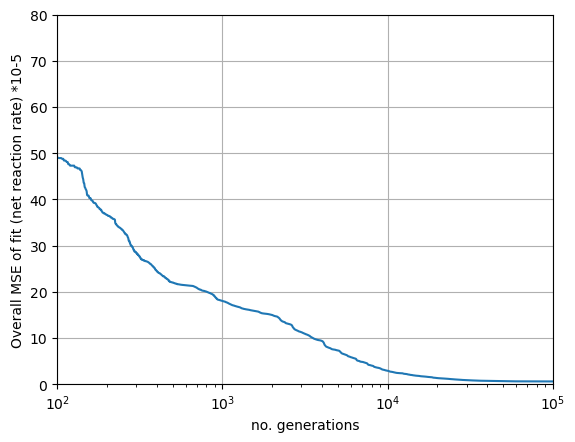

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-7.900769044651541
-8.40104052200302
-7.601532360290234
-8.800317069643281
-8.301737738684615
-7.10844331686224
-8.098907138764794
-10.34385075129022
-7.707729728802505
-6.806501395731622
-7.306839677409621
-8.00474403521619
-7.90846330946251
-6.804912214696058
-7.40490258481131
-7.408462926594196
-7.9013139548446185
-9.094858131568037
-8.387781700701737
-6.503173608494041
-7.303206778376549
-6.716885383427228
-7.517000344972386
-11.983449237667438
-7.3093149151339745
-7.8095669303261515
-1.301029931551095


In [37]:
res.X

array([ -7.90076904,  -8.40104052,  -7.60153236,  -8.80031707,
        -8.30173774,  -7.10844332,  -8.09890714, -10.34385075,
        -7.70772973,  -6.8065014 ,  -7.30683968,  -8.00474404,
        -7.90846331,  -6.80491221,  -7.40490258,  -7.40846293,
        -7.90131395,  -9.09485813,  -8.3877817 ,  -6.50317361,
        -7.30320678,  -6.71688538,  -7.51700034, -11.98344924,
        -7.30931492,  -7.80956693,  -1.30102993])

In [38]:
logkr = [ 
    -7.9, -8.4, 
    -7.6, -8.8, -8.3,
    -7.1, -8.1, -10.9, -7.7, #-18.3, -7.7, 
    -6.8, -7.3, -8.0, -7.9,
    -6.8, -7.4, # -6.8, -7.4, 
    -7.4, -7.9, -9.1, -8.4,
    -6.5, -7.3, # -7.5, -8.3,
    -6.7, -7.5, -11.8,# -19.3,
    -7.3, -7.8]

for i in range(len (logkr)):
    print (logkr[i])

-7.9
-8.4
-7.6
-8.8
-8.3
-7.1
-8.1
-10.9
-7.7
-6.8
-7.3
-8.0
-7.9
-6.8
-7.4
-7.4
-7.9
-9.1
-8.4
-6.5
-7.3
-6.7
-7.5
-11.8
-7.3
-7.8


In [39]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-7.9: -7.900769044651541
-8.4: -8.40104052200302
-7.6: -7.601532360290234
-8.8: -8.800317069643281
-8.3: -8.301737738684615
-7.1: -7.10844331686224
-8.1: -8.098907138764794
-10.9: -10.34385075129022
-7.7: -7.707729728802505
-6.8: -6.806501395731622
-7.3: -7.306839677409621
-8.0: -8.00474403521619
-7.9: -7.90846330946251
-6.8: -6.804912214696058
-7.4: -7.40490258481131
-7.4: -7.408462926594196
-7.9: -7.9013139548446185
-9.1: -9.094858131568037
-8.4: -8.387781700701737
-6.5: -6.503173608494041
-7.3: -7.303206778376549
-6.7: -6.716885383427228
-7.5: -7.517000344972386
-11.8: -11.983449237667438
-7.3: -7.3093149151339745
-7.8: -7.8095669303261515
R-value: 0.9951306445762842
R2: 0.9902849997748108
